# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 1
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
         3.0    0.235487        0.113697  0.054401  0.196026  0.220231   
         4.0    0.215716        0.086401  0.035714  0.192050  0.248849   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  
         3.0   0.247211  0.003811  0.031346  0.049192  0.009499  
         4.0   0.287262  0.004502  0.029509  0.047445  0.013083

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  644465.987031  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  674784.517390  4.412428e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         1.0      398139.231561  
         2.0      494315.467226  
         3.0      537605.057823  
         4.0      562223.555107

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


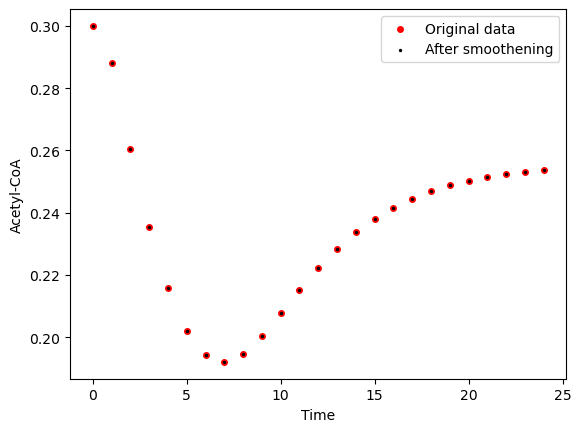

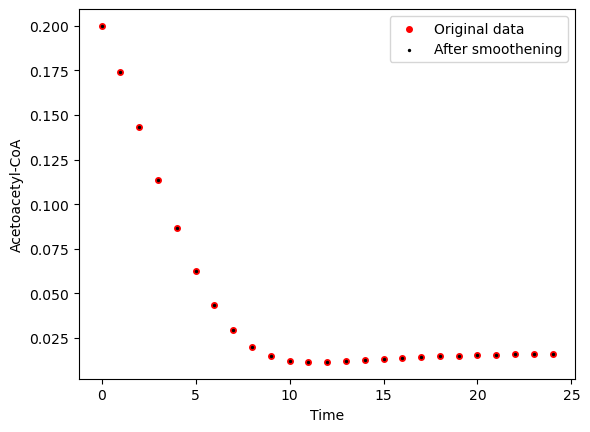

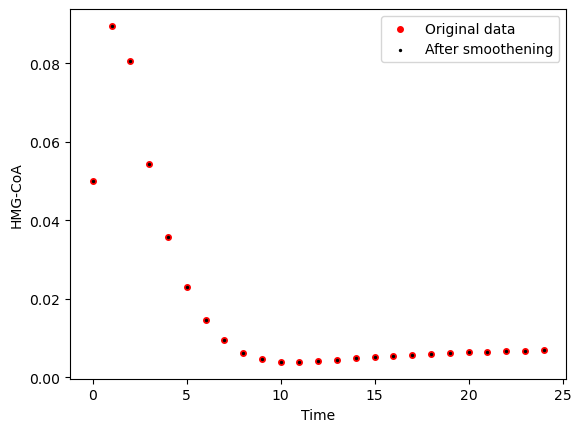

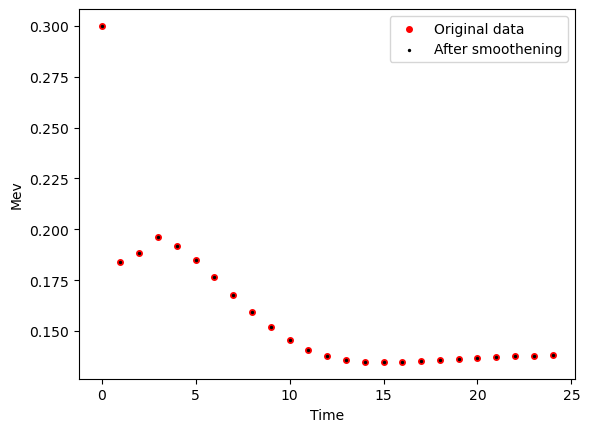

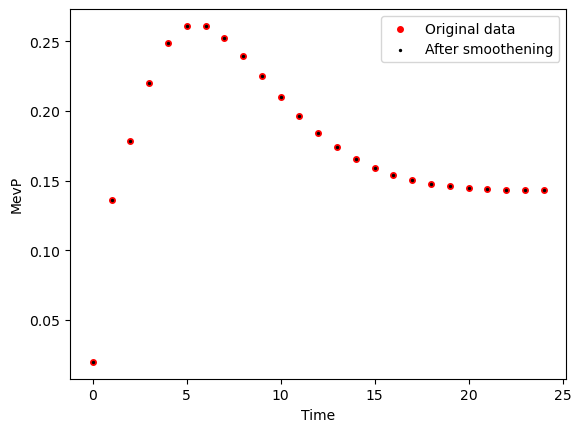

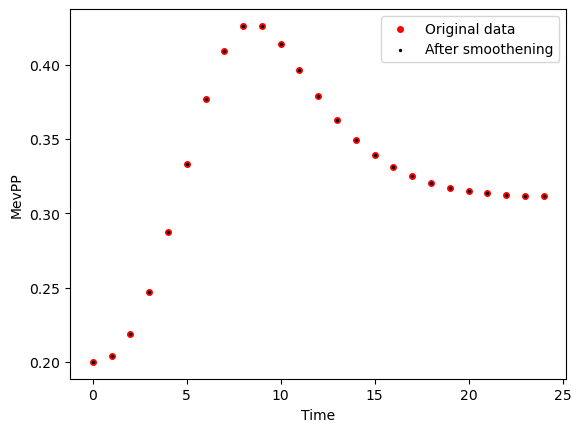

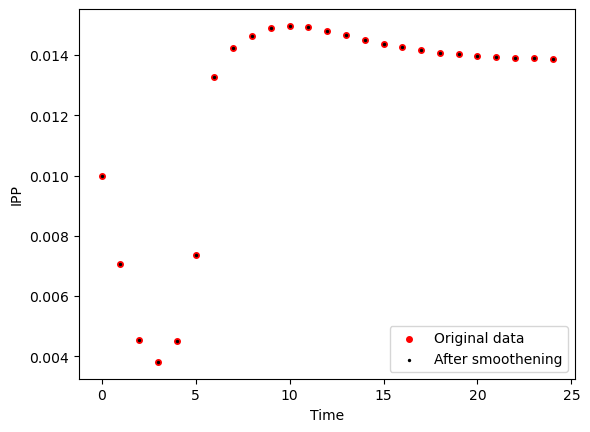

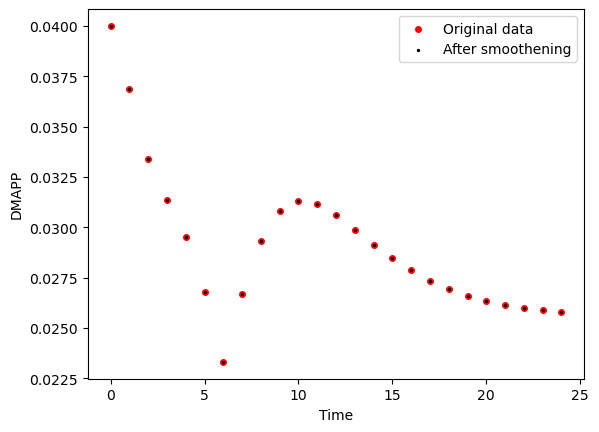

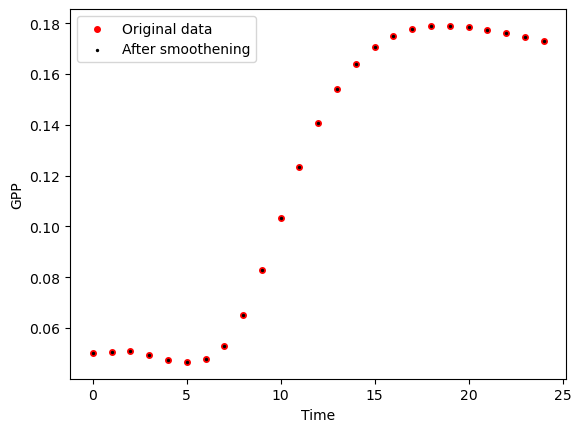

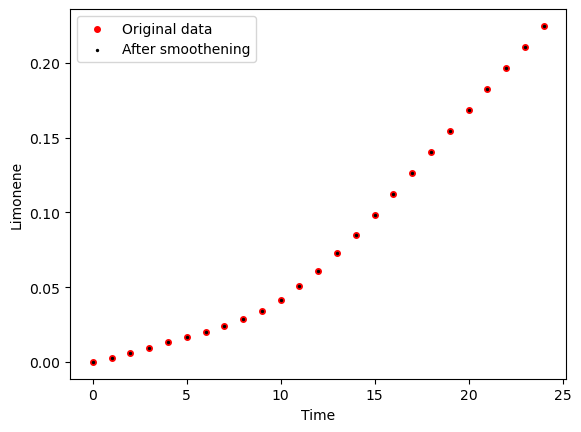

Strain Strain 2


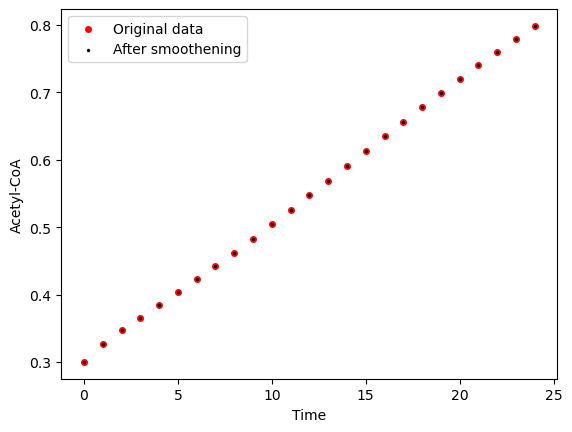

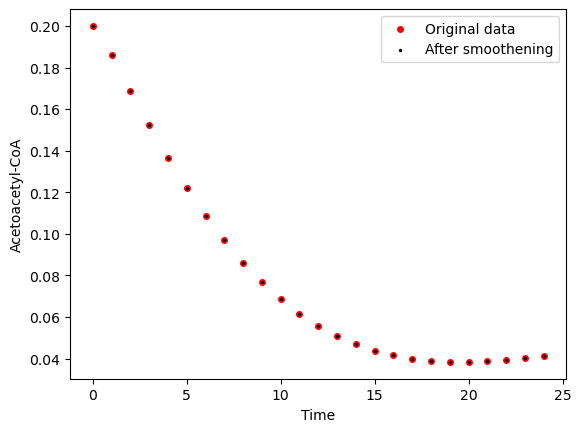

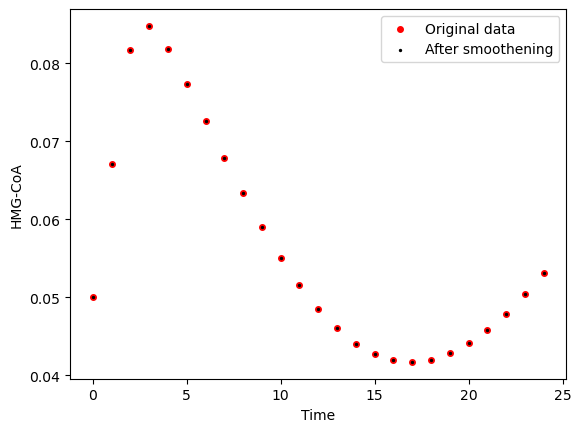

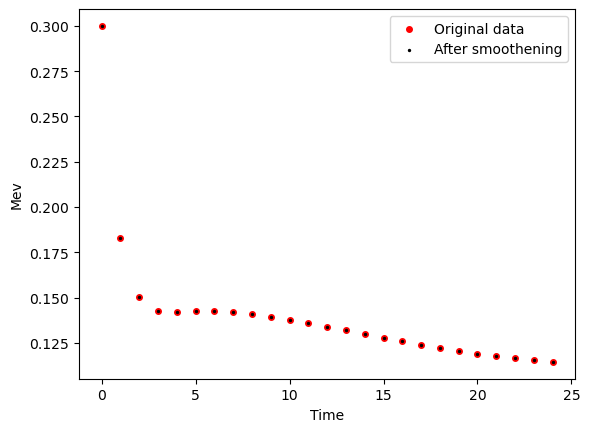

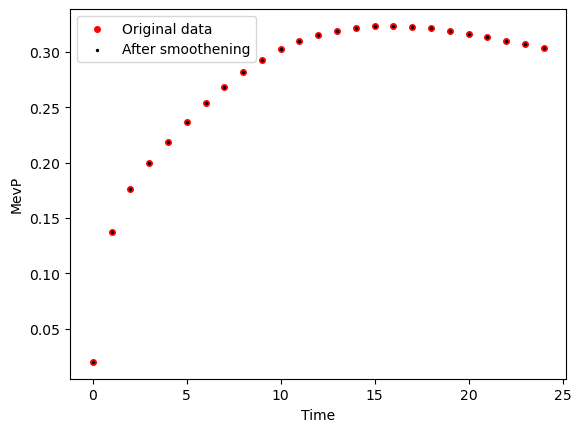

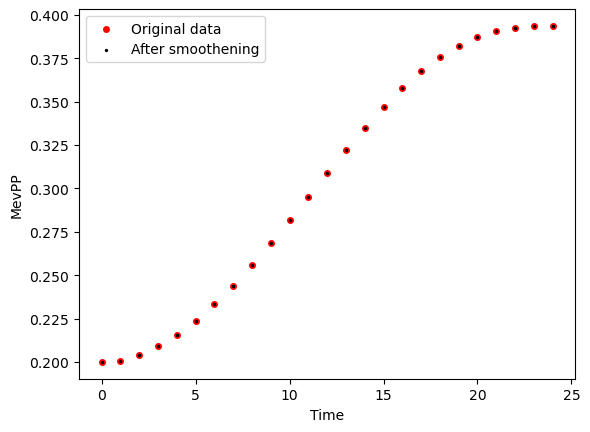

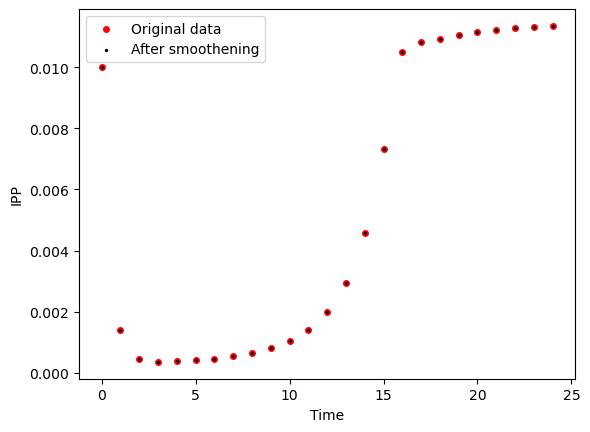

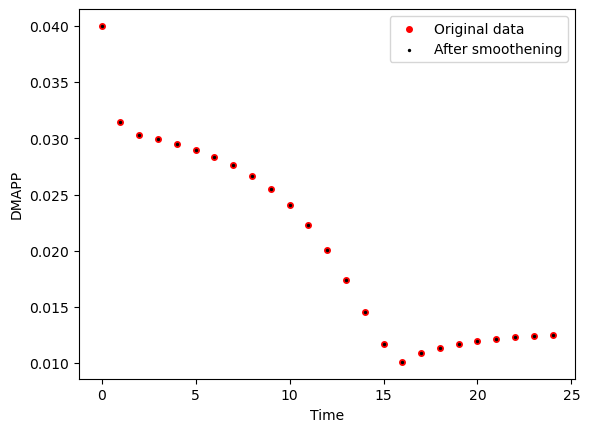

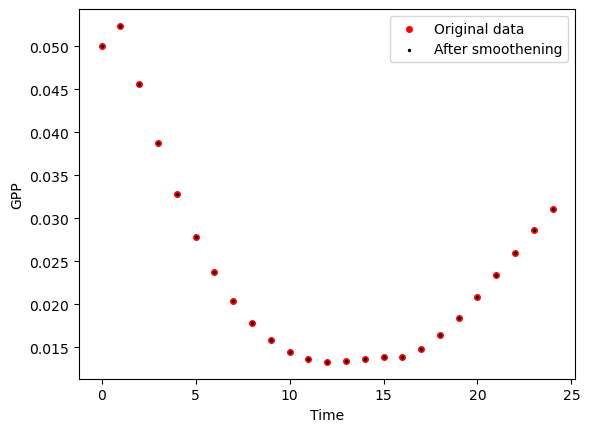

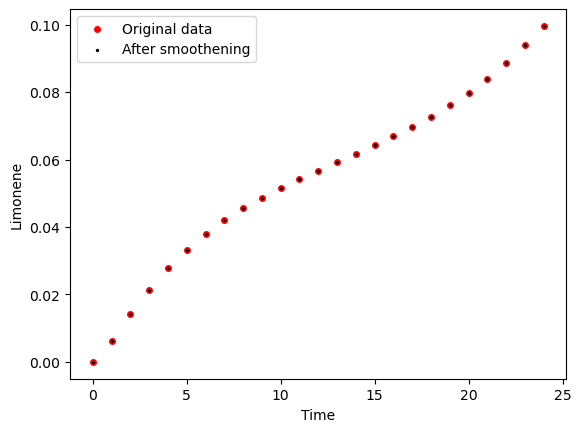

Strain Strain 3


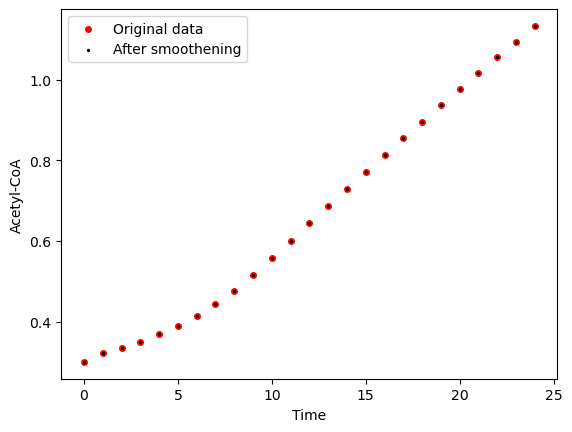

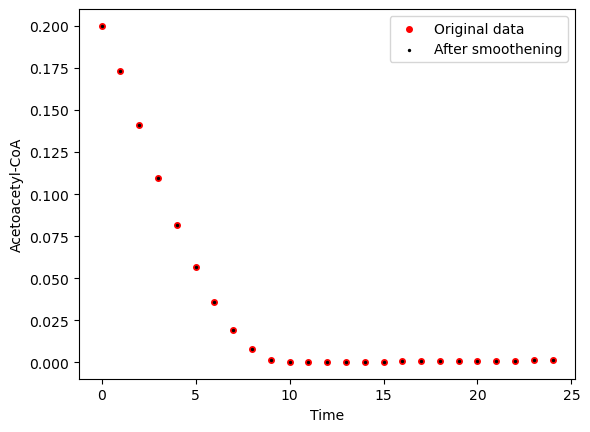

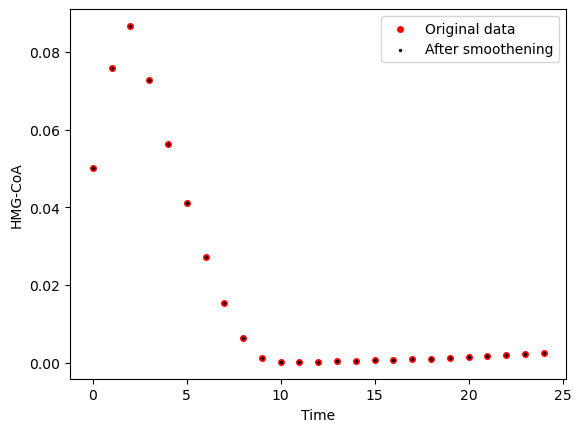

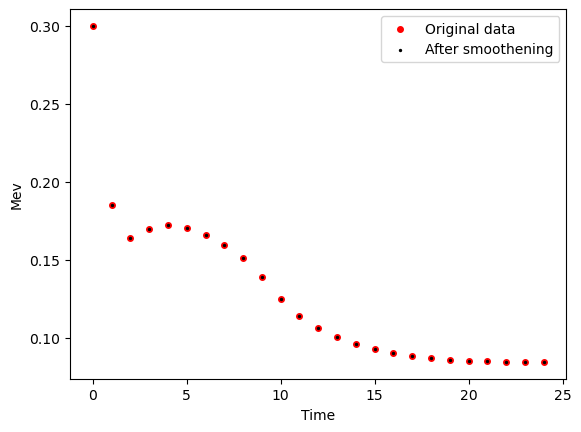

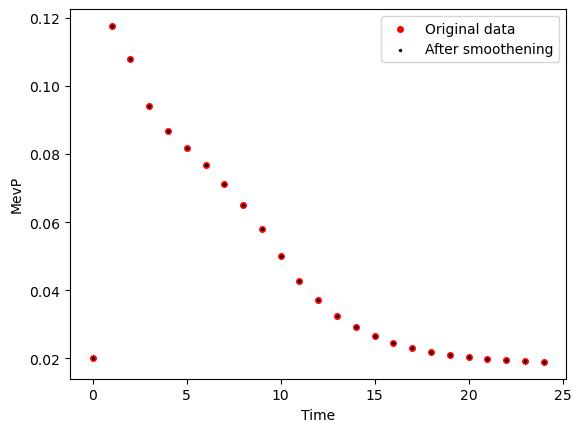

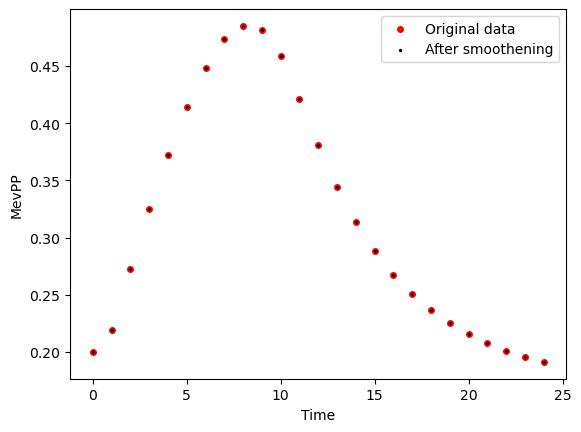

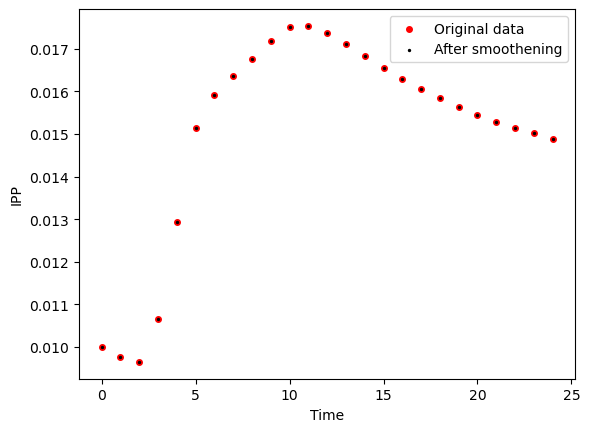

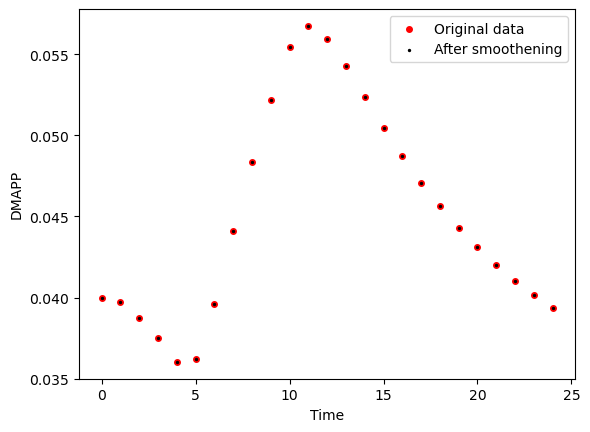

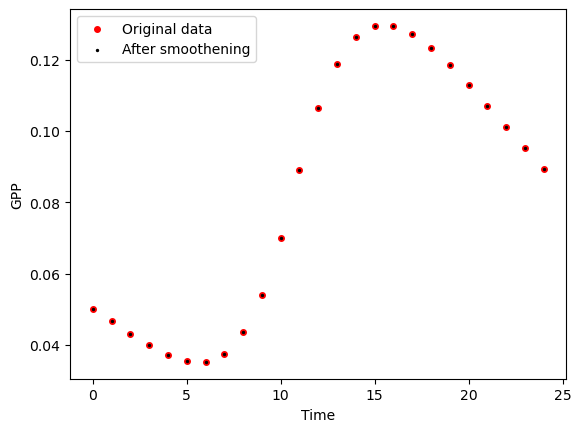

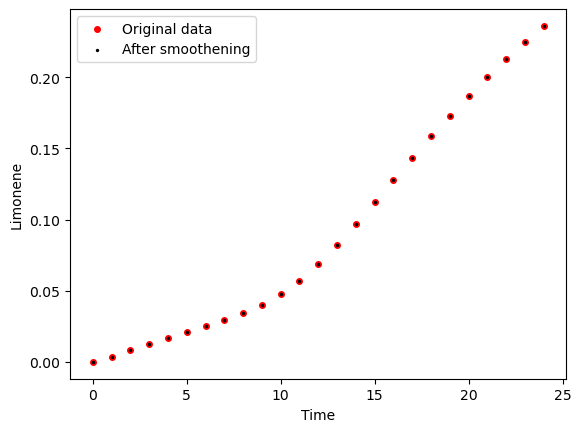

Strain WT


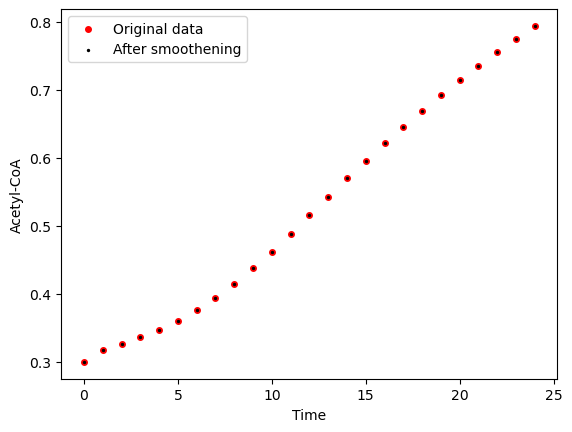

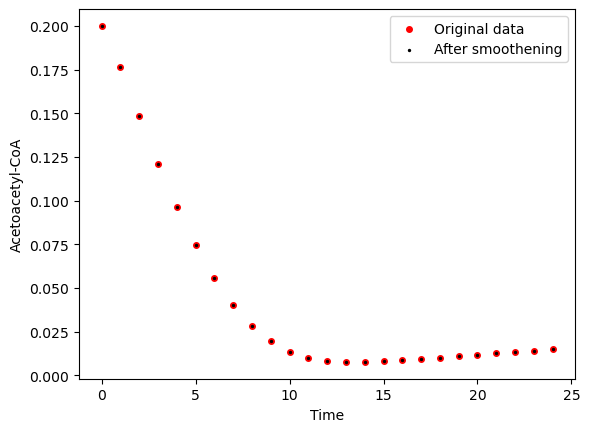

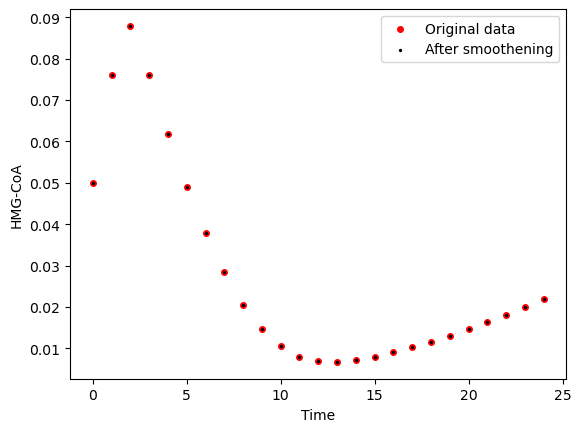

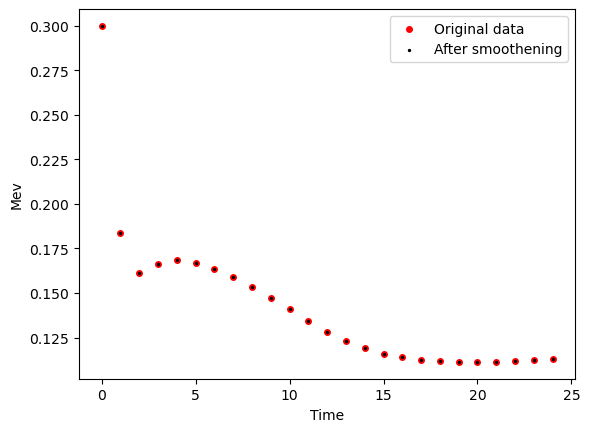

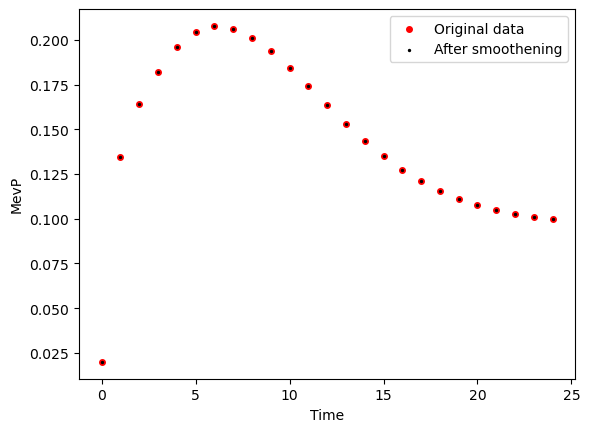

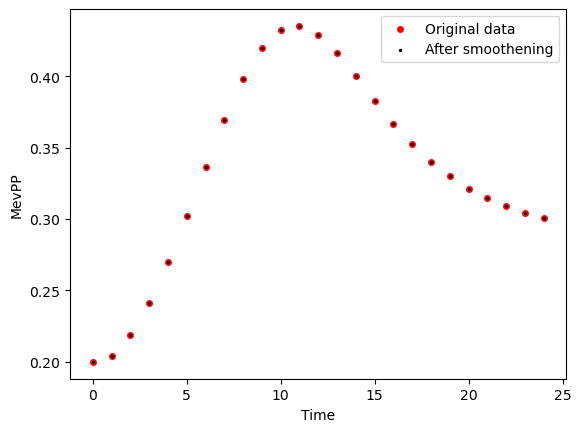

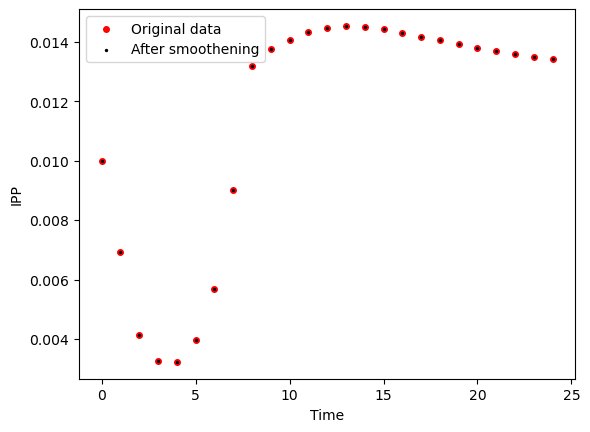

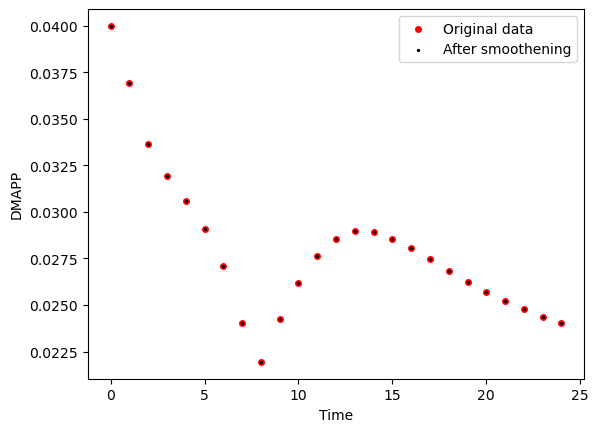

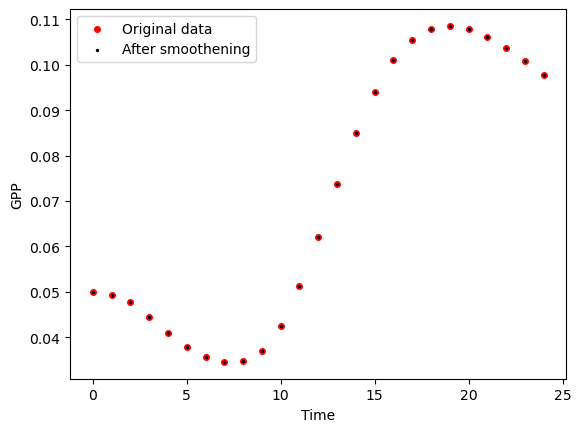

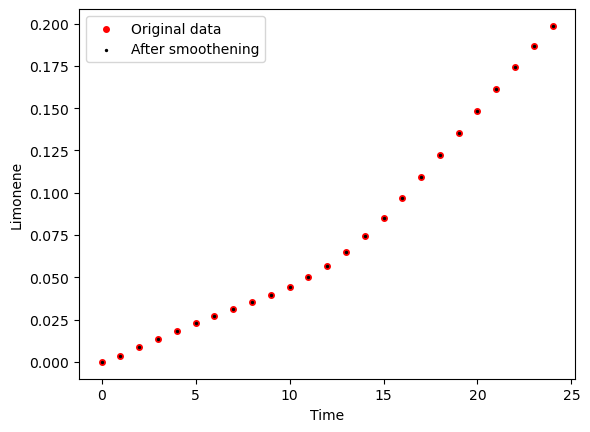

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


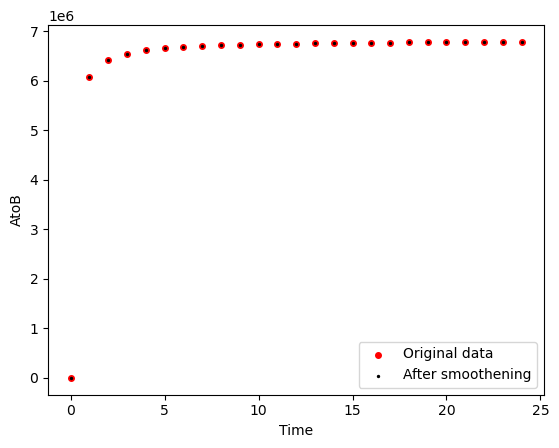

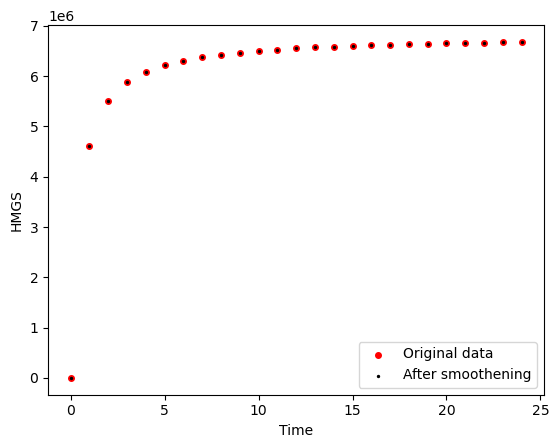

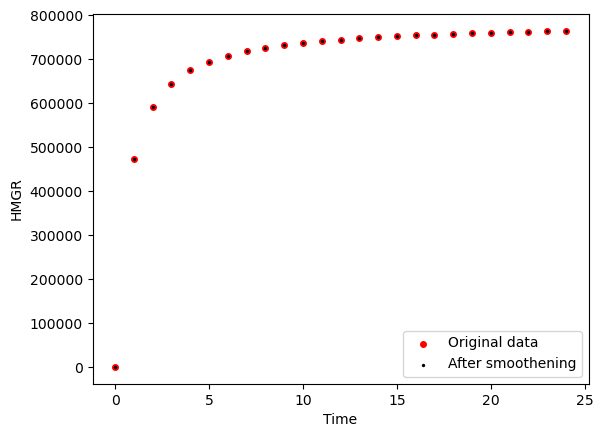

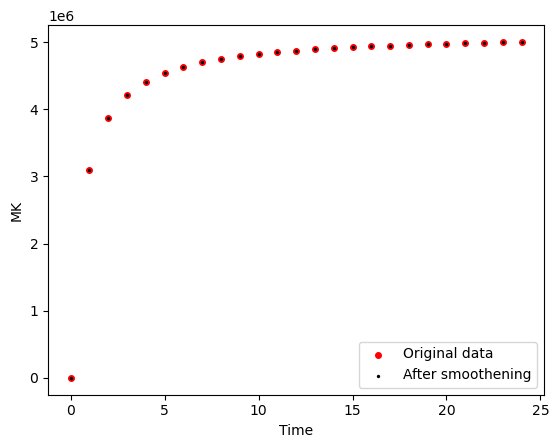

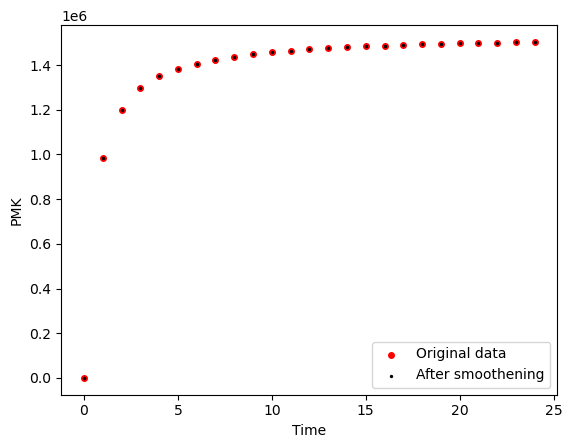

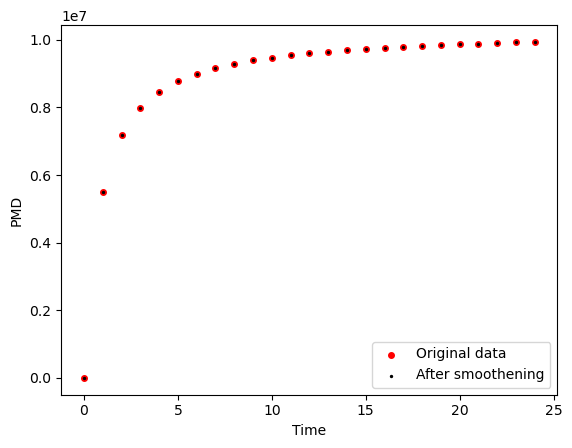

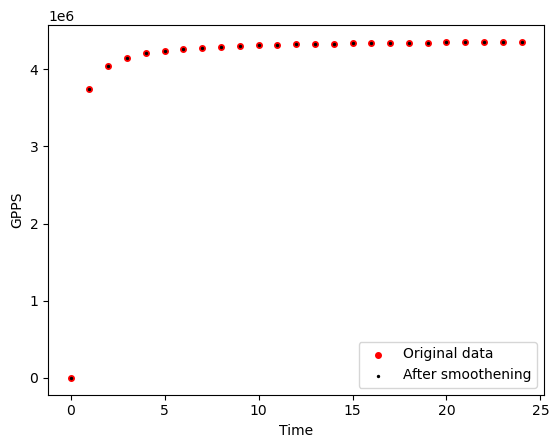

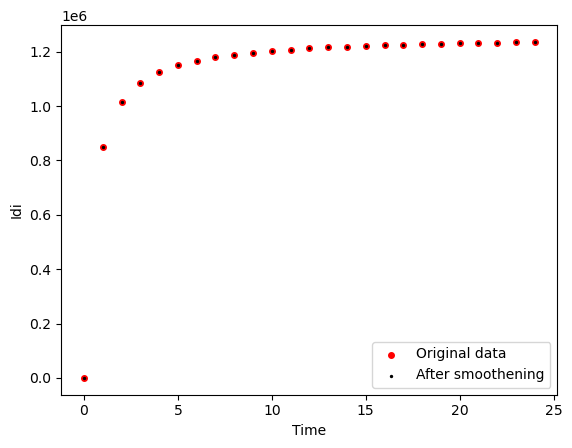

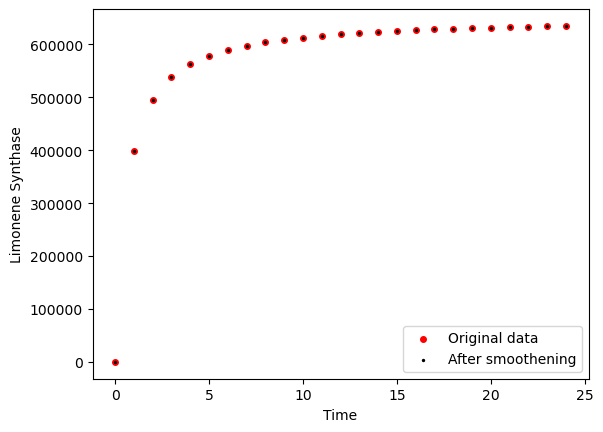

Strain Strain 2


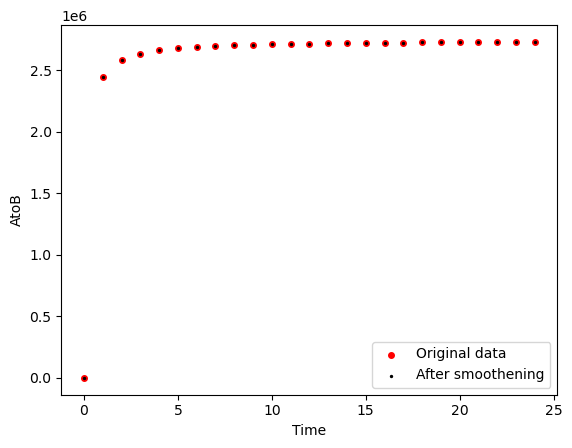

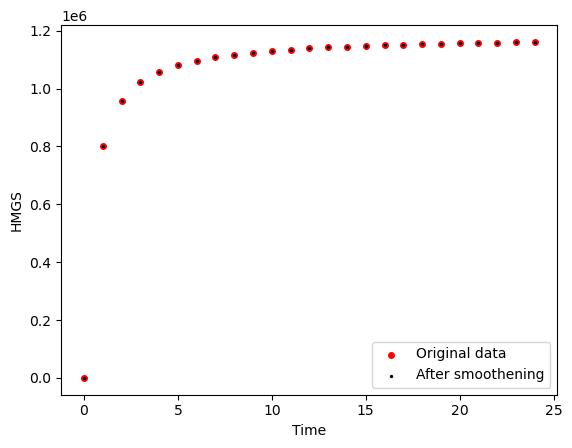

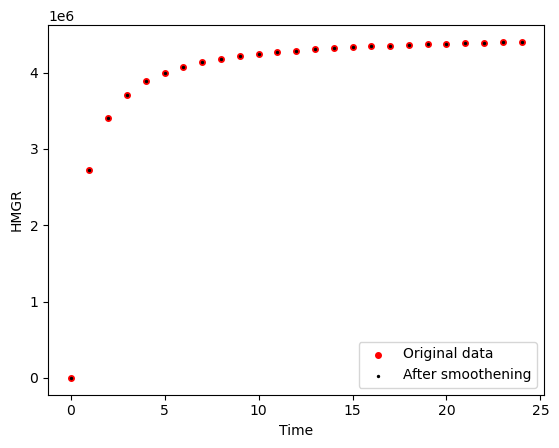

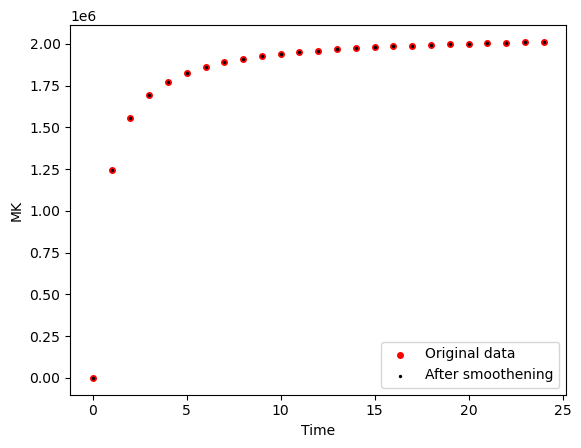

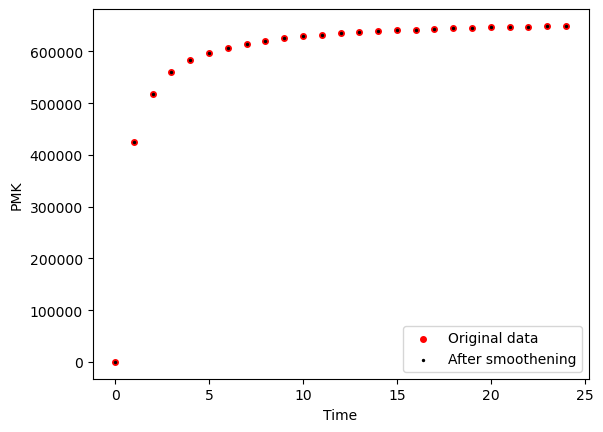

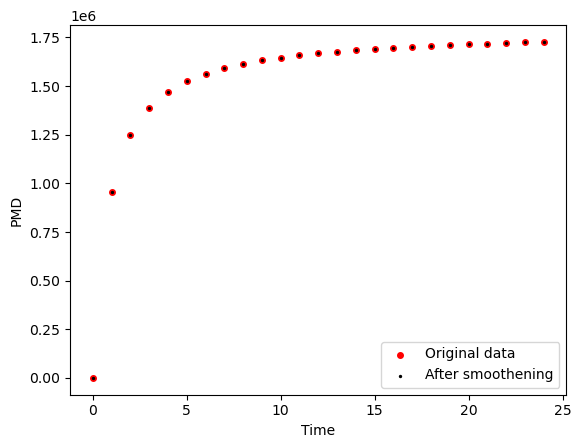

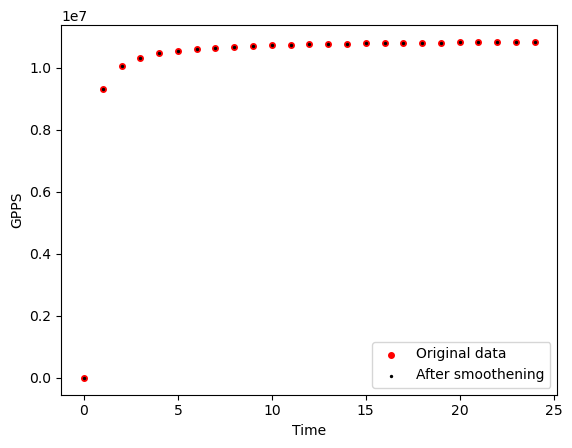

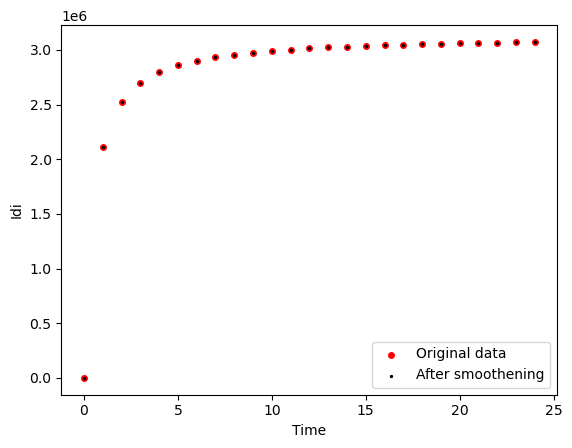

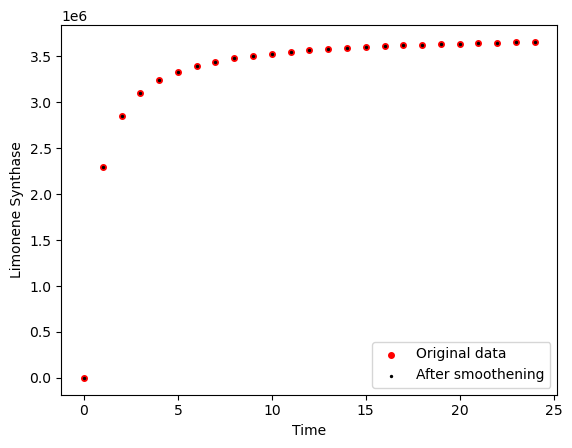

Strain Strain 3


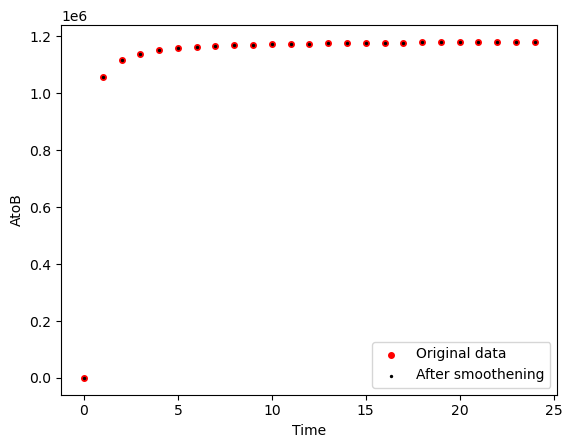

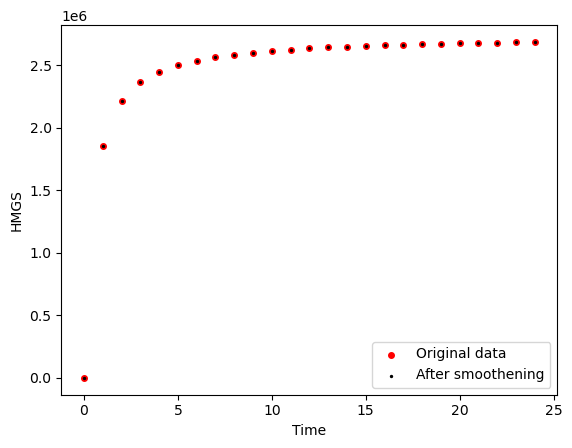

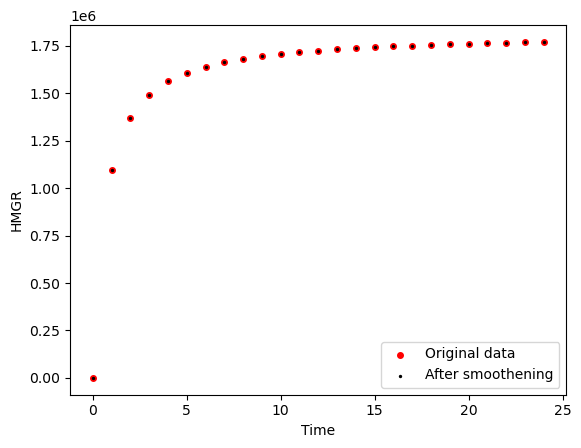

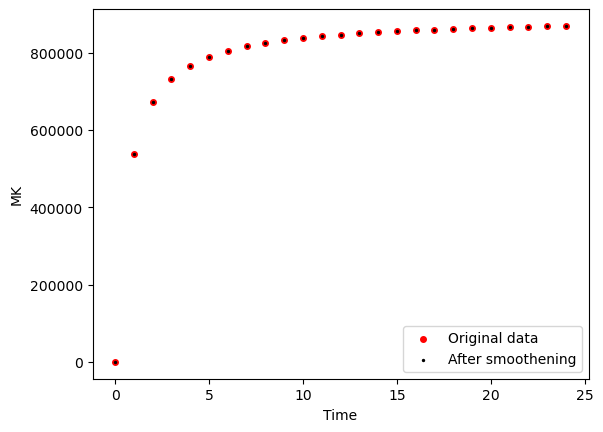

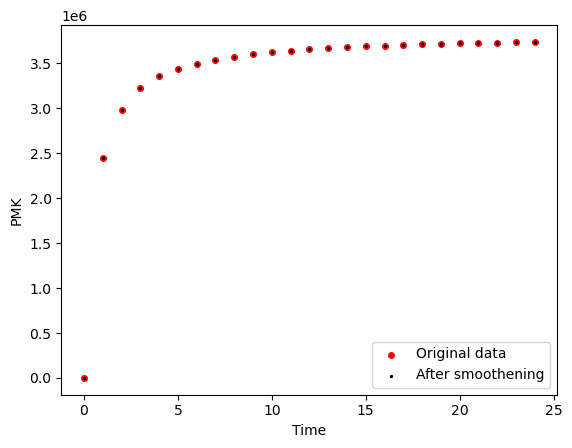

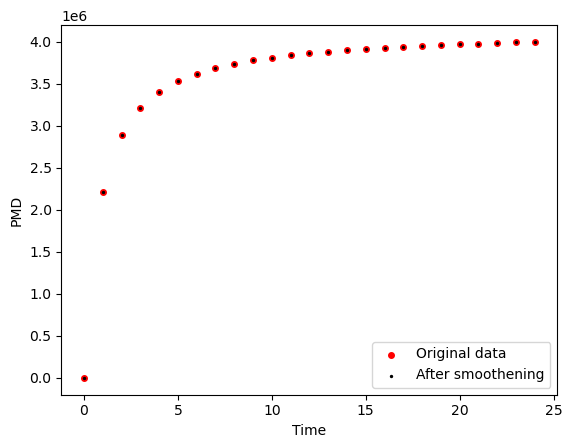

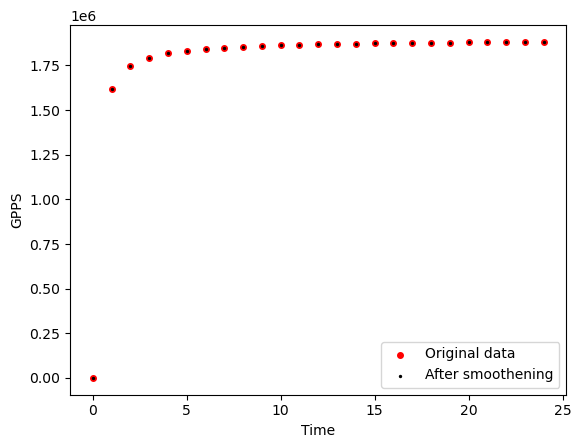

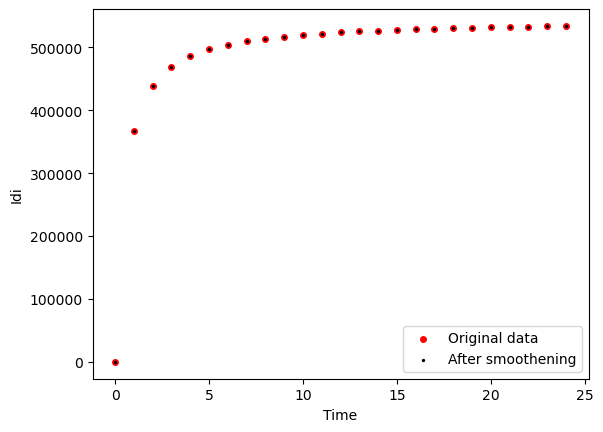

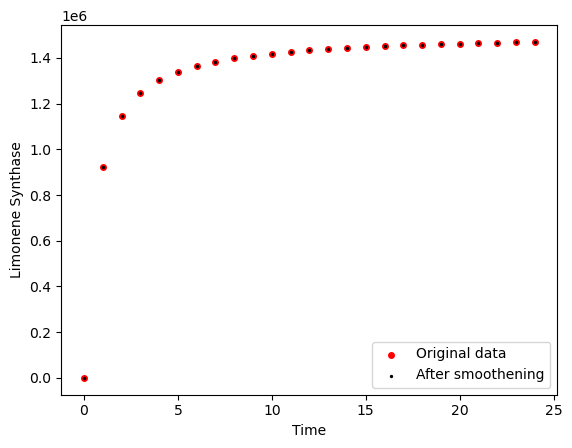

Strain WT


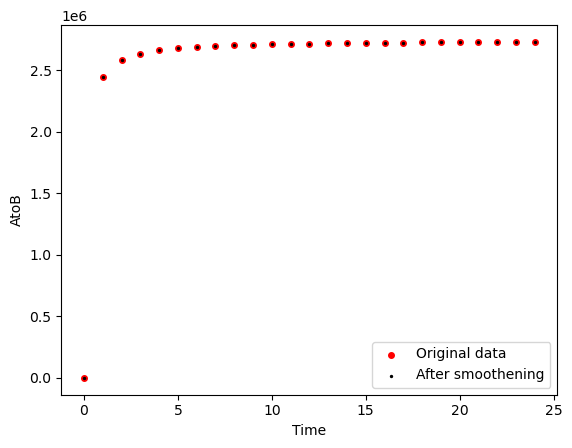

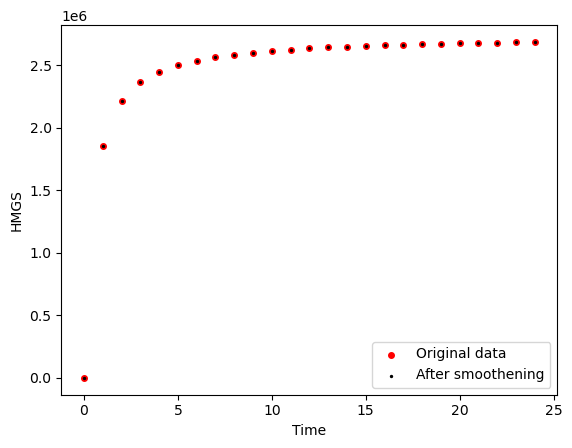

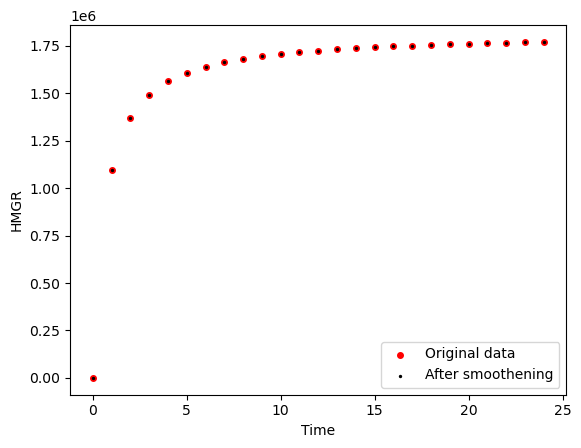

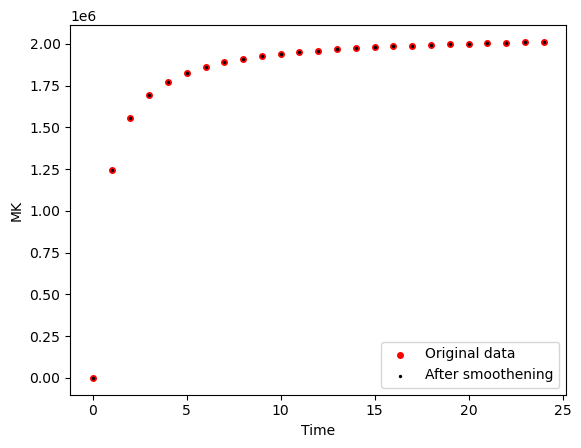

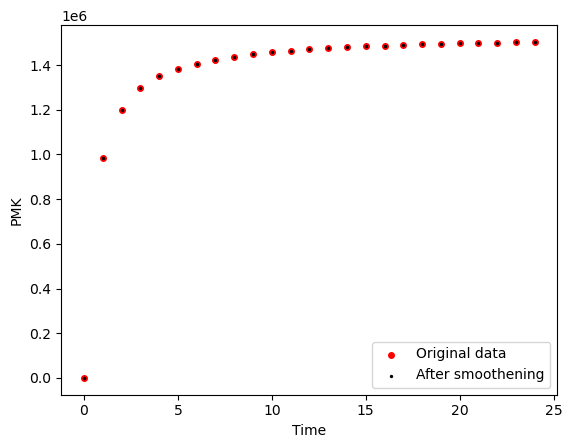

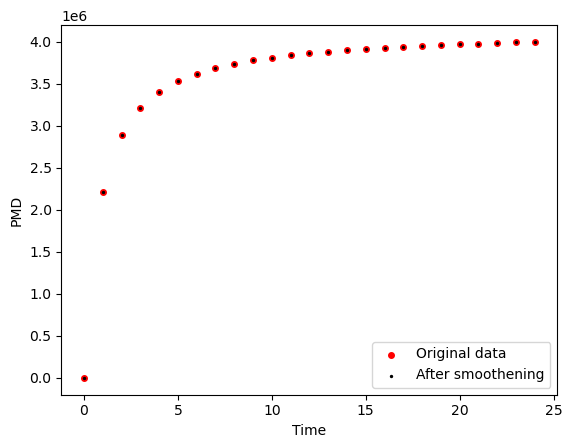

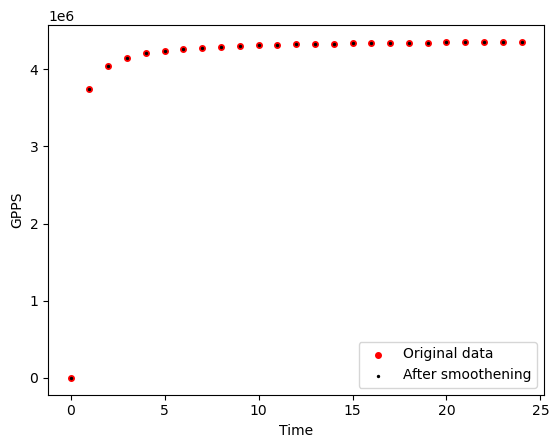

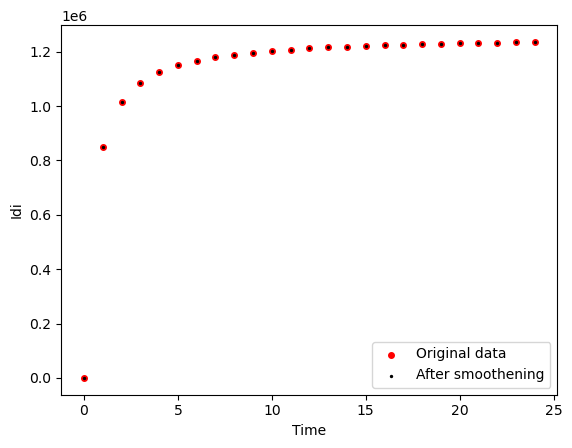

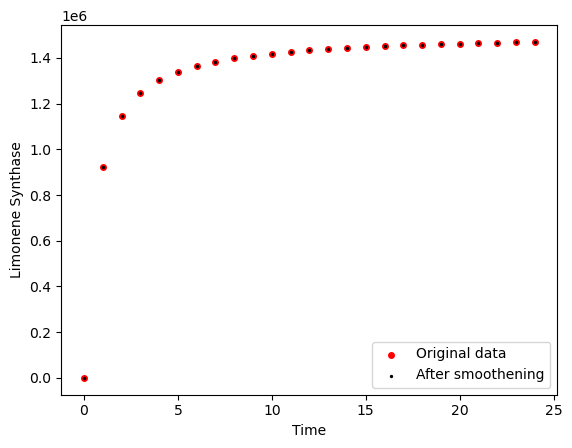

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
         3.0    0.235487        0.113697  0.054401  0.196026  0.220231   
         4.0    0.215716        0.086401  0.035714  0.192050  0.248849   
...                  ...             ...       ...       ...       ...   
WT       20.0   0.713891        0.011704  0.014676  0.111284  0.107612   
         21.0   0.735034        0.012518  0.016354  0.111498  0.104796   
         22.0   0.755407        0.013340  0.018112  0.111883  0.102630   
         23.0   0.775039        0.014167  0.019944  0.112389  0.101024   
         24.0   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  ...   
         3.0   0.247211  0.003811  0.031346  0.049192  0.009499  ...   
         4.0   0.287262  0.004502  0.029509  0.047445  0.013083  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       20.0  0.321363  0.013792  0.025710  0.107872  0.148511  ...   
         21.0  0.314396  0.013683  0.025209  0.106179  0.161465  ...   
         22.0  0.308770  0.013585  0.024759  0.103766  0.174178  ...   
         23.0  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         24.0  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.012210       -0.025323  0.049557 -0.116634  0.116845   
         1.0    -0.020361       -0.028578  0.012025 -0.052534  0.079720   
         2.0    -0.024295       -0.029832 -0.012811 -0.009729  0.050214   
         3.0    -0.024011       -0.029084 -0.024951  0.011779  0.028324   
         4.0    -0.016954       -0.025651 -0.017762 -0.004429  0.021121   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.021537        0.000809  0.001634  0.000108 -0.003173   
         21.0    0.020754        0.000819  0.001719  0.000310 -0.002476   
         22.0    0.019998        0.000826  0.001797  0.000463 -0.001867   
         23.0    0.019268        0.000828  0.001867  0.000556 -0.001351   
         24.0    0.018565        0.000826  0.001928  0.000590 -0.000928   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.007932 -0.003260 -0.004324  0.002387  0.002370  
         1.0   0.009799 -0.002739 -0.003141  0.000185  0.002985  
         2.0   0.024013 -0.001722 -0.002408 -0.001159  0.003412  
         3.0   0.034710 -0.000208 -0.002125 -0.001644  0.003653  
         4.0   0.043730  0.002514 -0.002840 -0.001579  0.003563  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.007713 -0.000115 -0.000527 -0.001239  0.013045  
         21.0 -0.006265 -0.000104 -0.000476 -0.002097  0.012850  
         22.0 -0.005007 -0.000092 -0.000426 -0.002724  0.012584  
         23.0 -0.003946 -0.000081 -0.000374 -0.003088  0.012228  
         24.0 -0.003082 -0.000068 -0.000320 -0.003188  0.011779

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

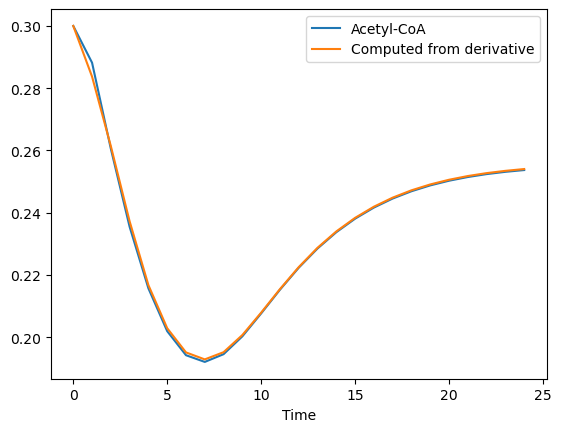

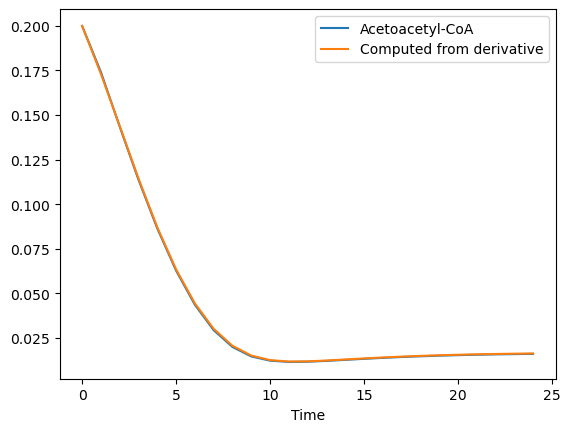

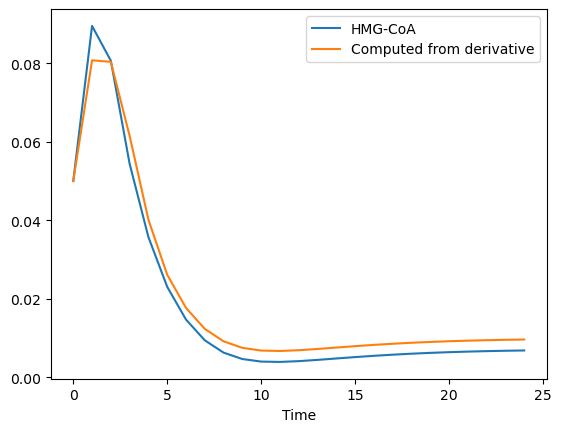

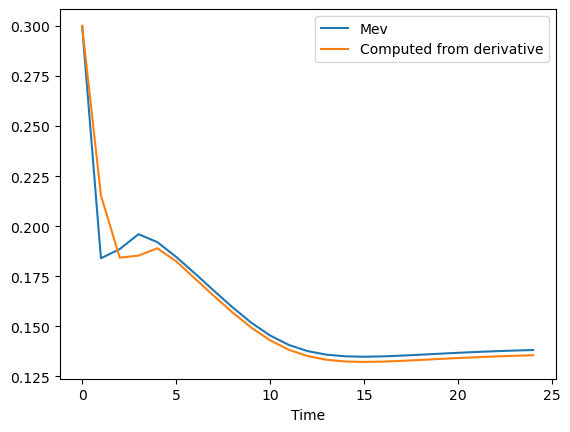

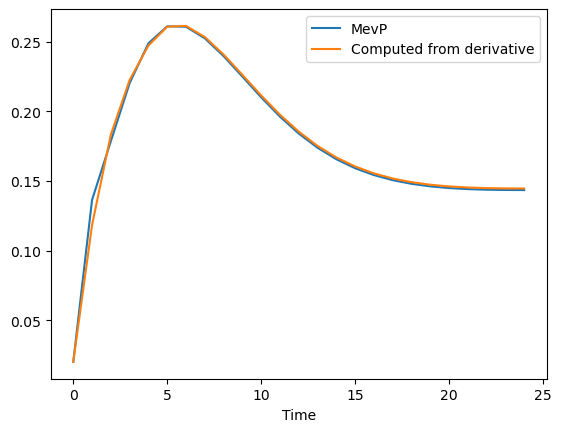

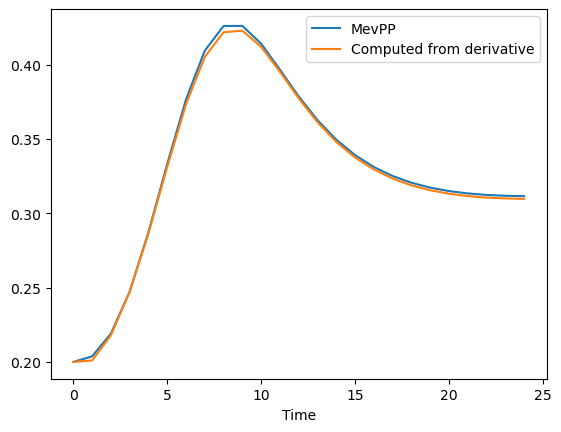

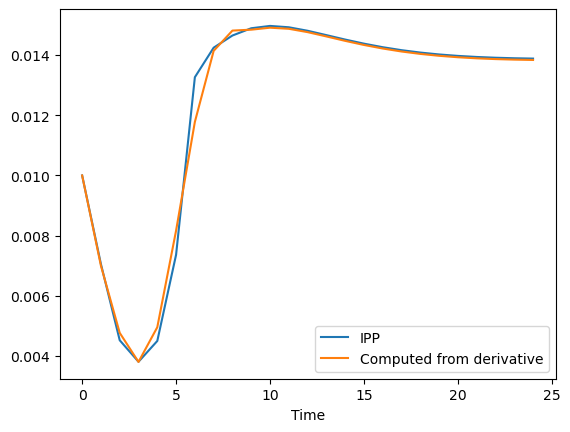

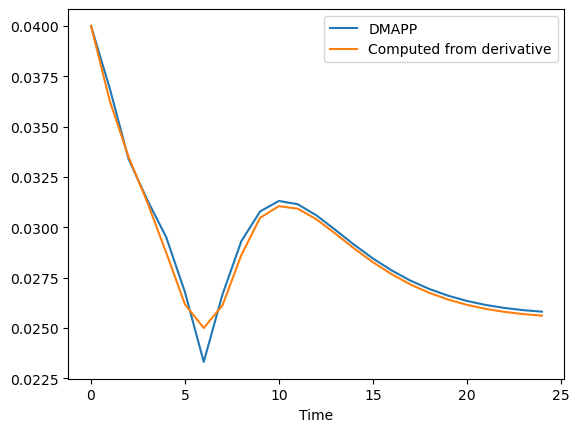

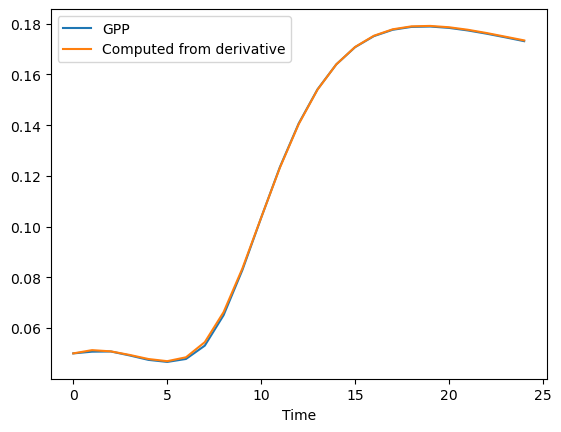

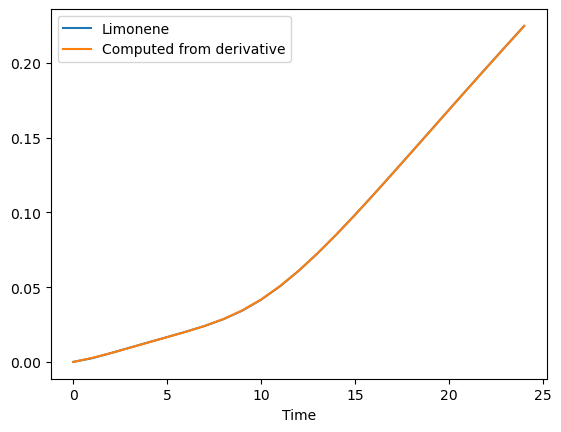

'Time profile from derivative vs. actual profile for Strain 2'

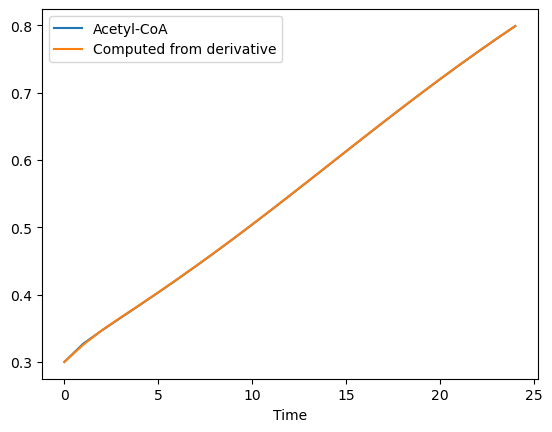

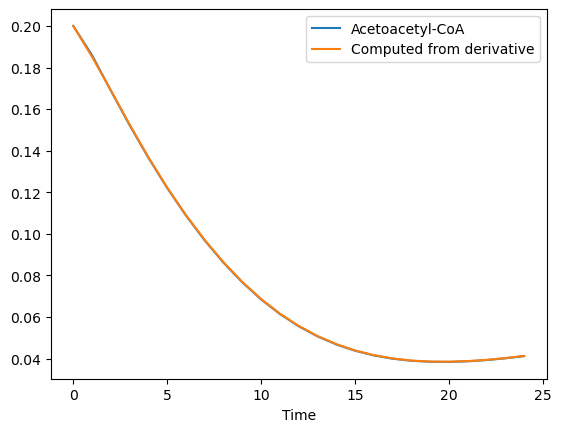

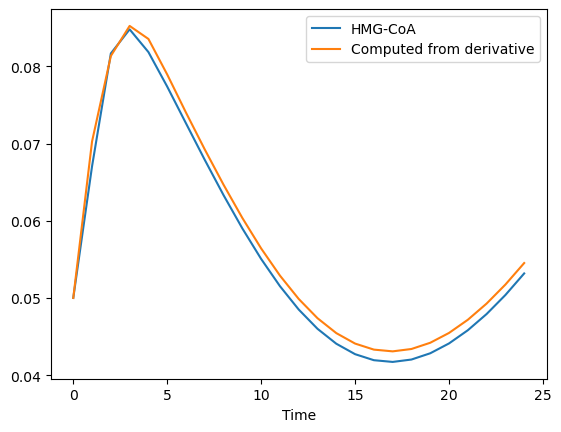

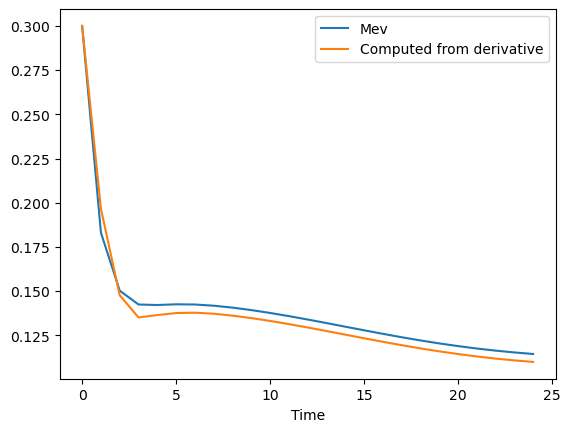

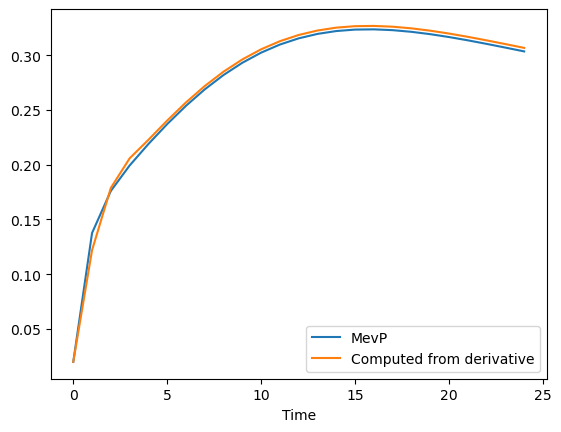

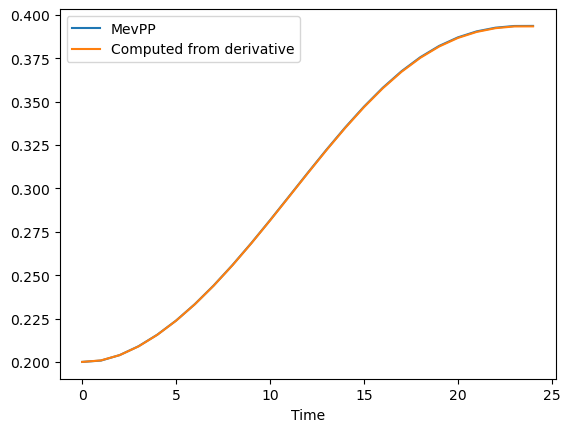

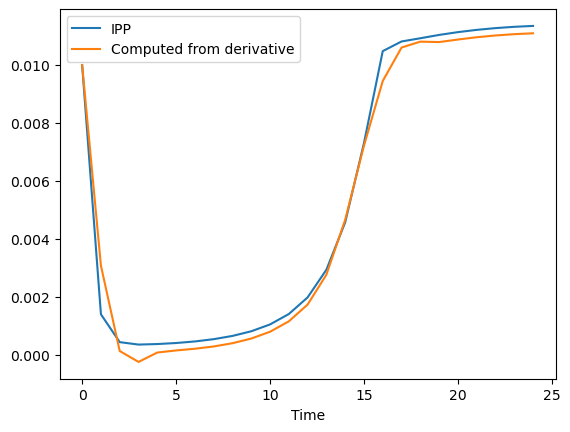

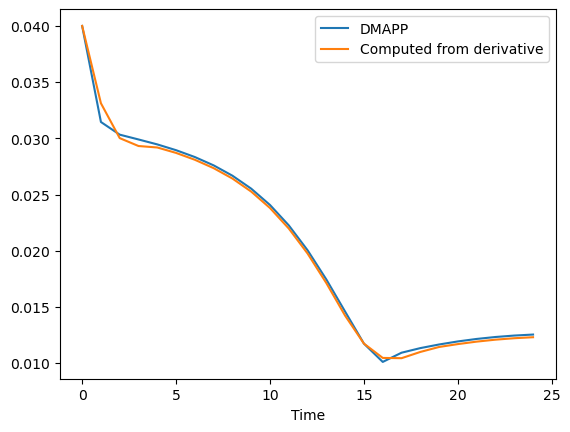

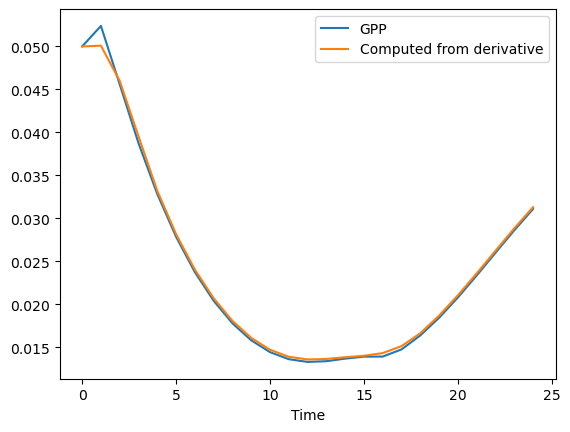

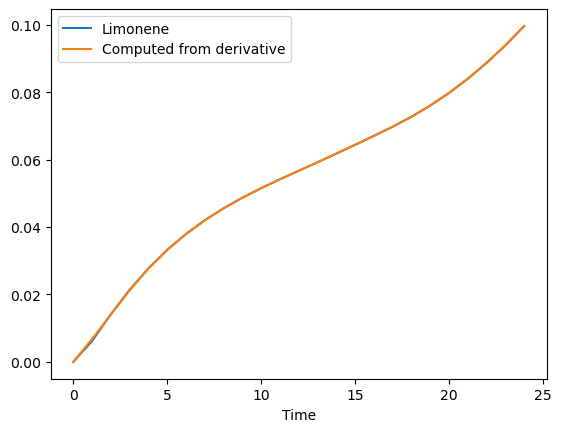

'Time profile from derivative vs. actual profile for Strain 3'

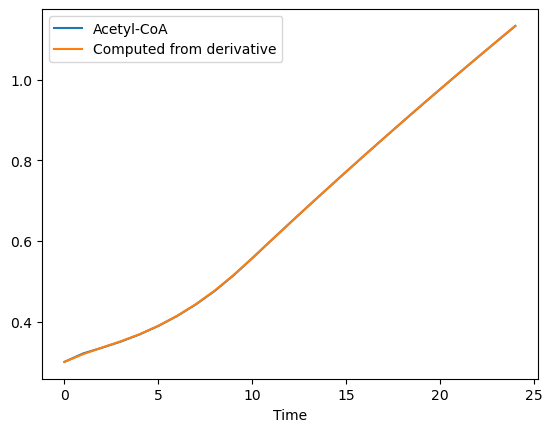

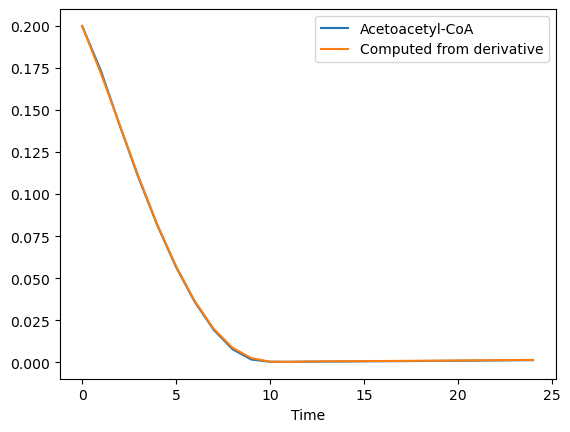

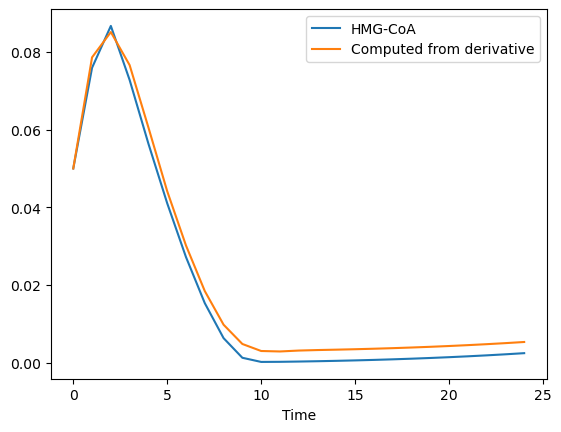

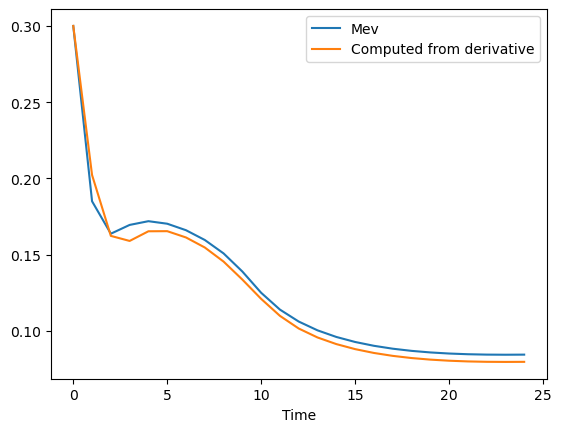

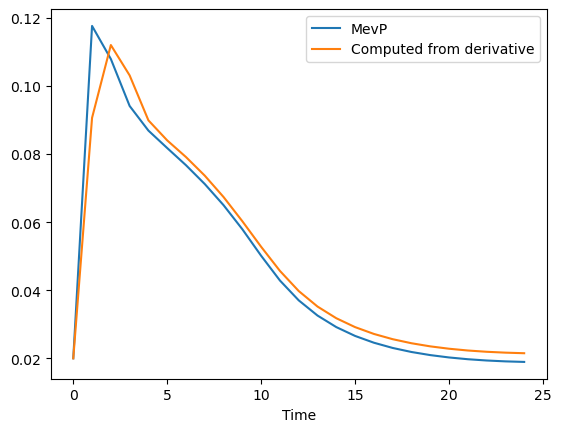

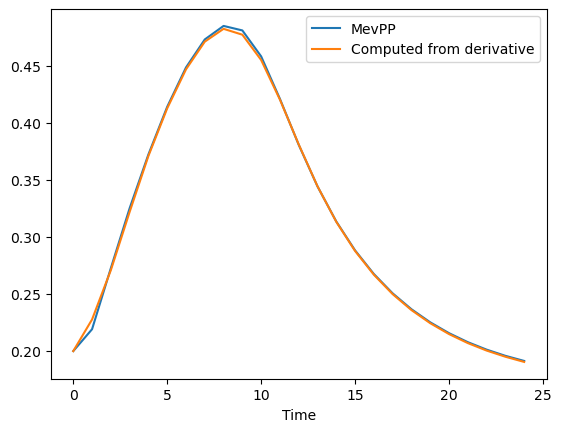

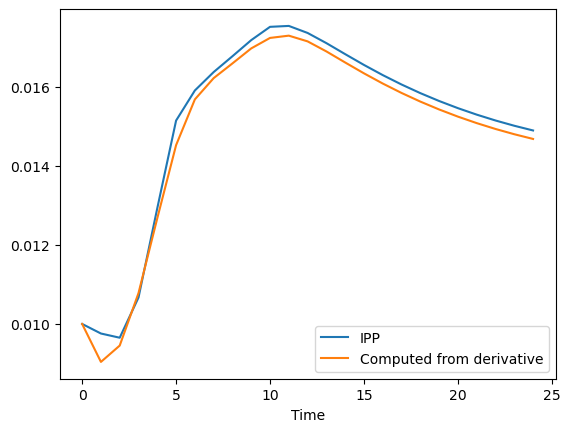

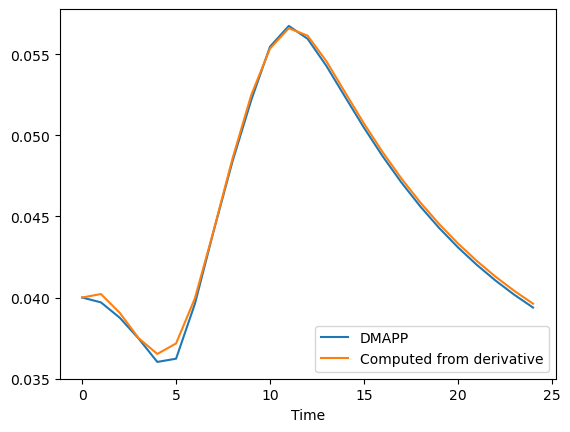

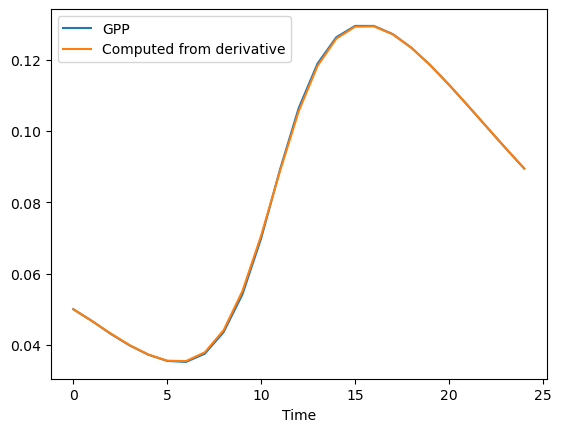

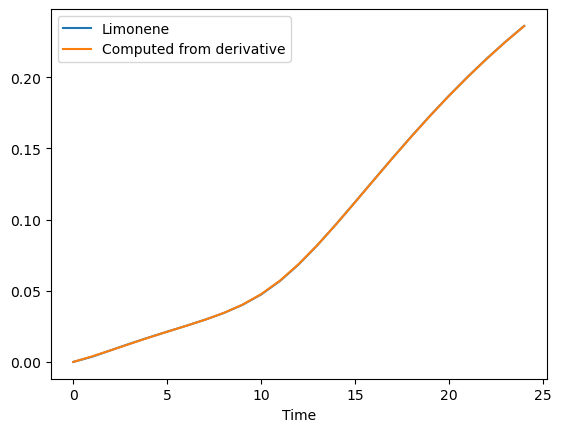

'Time profile from derivative vs. actual profile for WT'

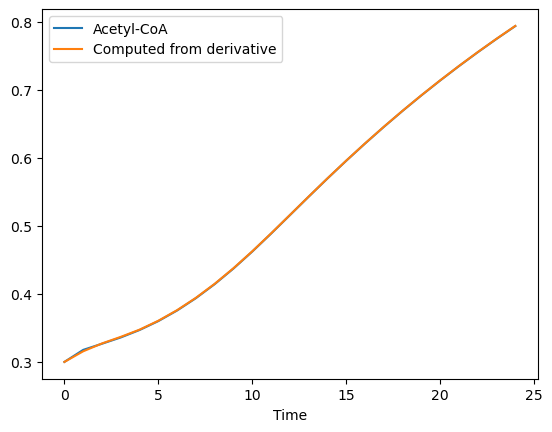

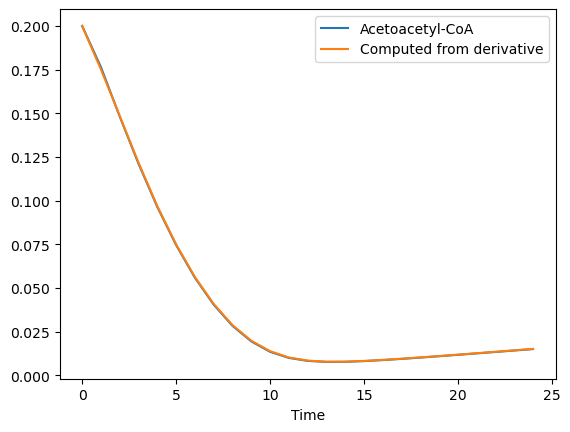

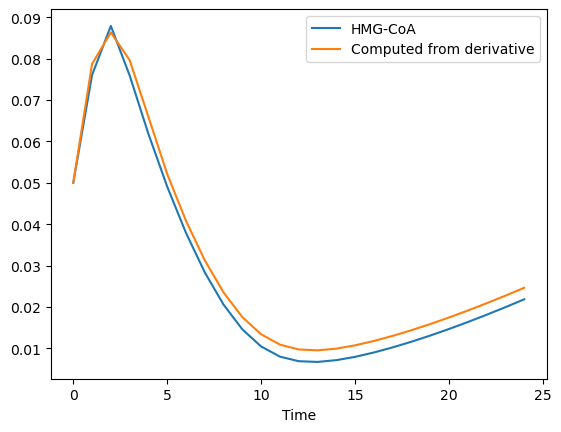

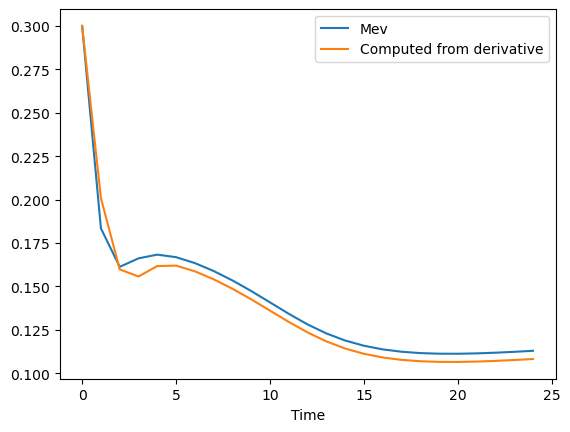

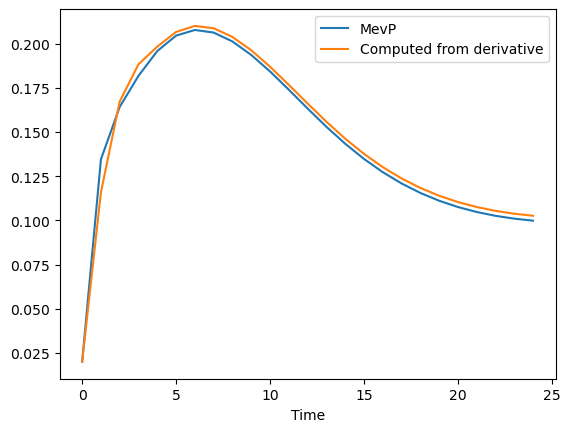

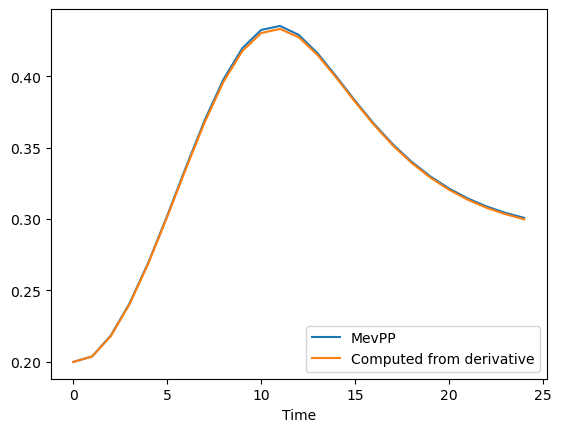

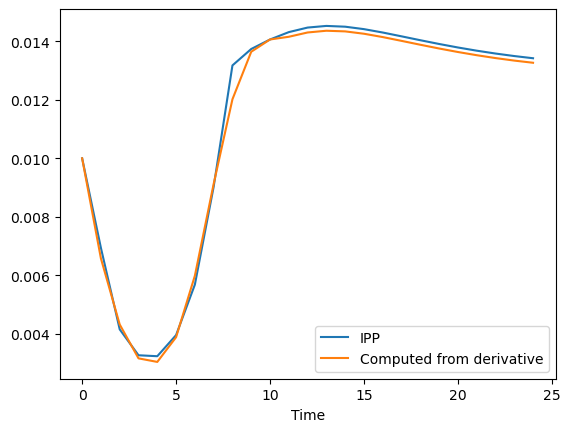

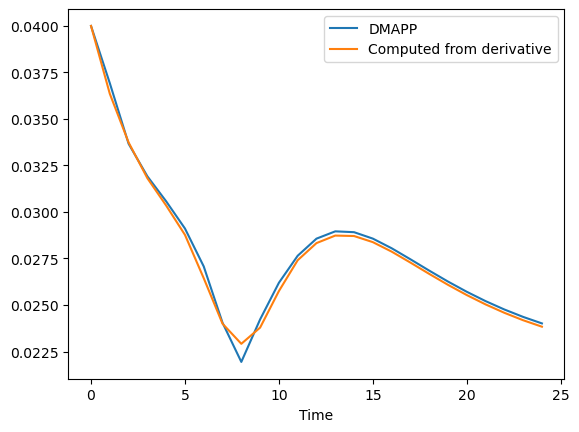

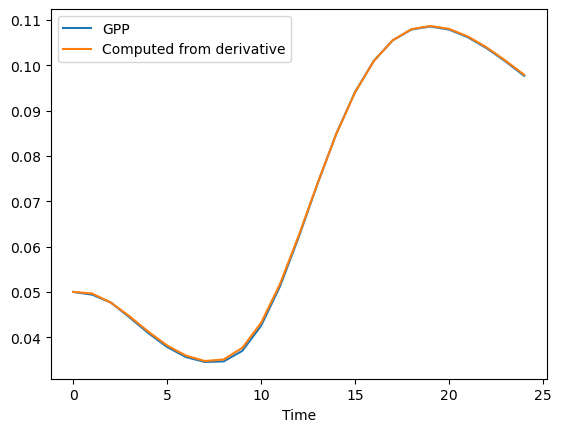

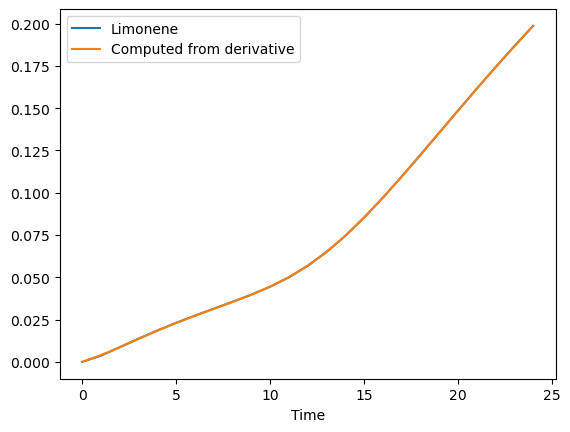

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  5.913288e+05  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  6.444660e+05  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  6.747845e+05  4.412428e+06   
...                     ...           ...           ...           ...   
WT       20.0  2.727222e+06  2.677299e+06  1.760761e+06  2.001420e+06   
         21.0  2.728018e+06  2.680280e+06  1.763434e+06  2.004465e+06   
         22.0  2.728742e+06  2.682996e+06  1.765870e+06  2.007241e+06   
         23.0  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         24.0  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   
...                     ...           ...           ...           ...   
WT       20.0  1.496285e+06  3.969027e+06  4.348970e+06  1.231287e+06   
         21.0  1.498236e+06  3.976909e+06  4.350733e+06  1.232678e+06   
         22.0  1.500014e+06  3.984102e+06  4.352338e+06  1.233945e+06   
         23.0  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         24.0  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.034108e+01   0.300000        0.200000  0.050000   
         1.0       3.981392e+05   0.288190        0.174077  0.089557   
         2.0       4.943155e+05   0.260551        0.143504  0.080676   
         3.0       5.376051e+05   0.235487        0.113697  0.054401   
         4.0       5.622236e+05   0.215716        0.086401  0.035714   
...                         ...        ...             ...       ...   
WT       20.0      1.462098e+06   0.713891        0.011704  0.014676   
         21.0      1.464251e+06   0.735034        0.012518  0.016354   
         22.0      1.466213e+06   0.755407        0.013340  0.018112   
         23.0      1.468009e+06   0.775039        0.014167  0.019944   
         24.0      1.469659e+06   0.793953        0.014996  0.021843   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         1.0   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
         2.0   0.188562  0.178523  0.219000  0.004525  0.033388  0.050751   
         3.0   0.196026  0.220231  0.247211  0.003811  0.031346  0.049192   
         4.0   0.192050  0.248849  0.287262  0.004502  0.029509  0.047445   
...                 ...       ...       ...       ...       ...       ...   
WT       20.0  0.111284  0.107612  0.321363  0.013792  0.025710  0.107872   
         21.0  0.111498  0.104796  0.314396  0.013683  0.025209  0.106179   
         22.0  0.111883  0.102630  0.308770  0.013585  0.024759  0.103766   
         23.0  0.112389  0.101024  0.304

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.012210       -0.025323  0.049557 -0.116634  0.116845   
         1.0    -0.020361       -0.028578  0.012025 -0.052534  0.079720   
         2.0    -0.024295       -0.029832 -0.012811 -0.009729  0.050214   
         3.0    -0.024011       -0.029084 -0.024951  0.011779  0.028324   
         4.0    -0.016954       -0.025651 -0.017762 -0.004429  0.021121   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.021537        0.000809  0.001634  0.000108 -0.003173   
         21.0    0.020754        0.000819  0.001719  0.000310 -0.002476   
         22.0    0.019998        0.000826  0.001797  0.000463 -0.001867   
         23.0    0.019268        0.000828  0.001867  0.000556 -0.001351   
         24.0    0.018565        0.000826  0.001928  0.000590 -0.000928   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.007932 -0.003260 -0.004324  0.002387  0.002370  
         1.0   0.009799 -0.002739 -0.003141  0.000185  0.002985  
         2.0   0.024013 -0.001722 -0.002408 -0.001159  0.003412  
         3.0   0.034710 -0.000208 -0.002125 -0.001644  0.003653  
         4.0   0.043730  0.002514 -0.002840 -0.001579  0.003563  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.007713 -0.000115 -0.000527 -0.001239  0.013045  
         21.0 -0.006265 -0.000104 -0.000476 -0.002097  0.012850  
         22.0 -0.005007 -0.000092 -0.000426 -0.002724  0.012584  
         23.0 -0.003946 -0.000081 -0.000374 -0.003088  0.012228  
         24.0 -0.003082 -0.000068 -0.000320 -0.003188  0.011779  

[100 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 4.112320E+188 | 7.824012E+113
     2 |       74 | 7.925074E+129 |  3.296127E+84
     3 |      138 |  4.485423E+97 |  1.001353E+82
     4 |      202 |  2.639881E+85 |  1.289272E+71
     5 |      266 |  9.360840E+75 |  1.653290E+55
     6 |      330 |  6.849035E+70 |  2.665730E+53
     7 |      394 |  4.775716E+57 |  2.773288E+47
     8 |      458 |  2.602975E+52 |  8.819323E+31
     9 |      522 |  1.558789E+52 |  8.819323E+31
    10 |      586 |  1.148105E+47 |  8.819323E+31
    11 |      650 |  3.641199E+43 |  6.772805E+30
    12 |      714 |  1.687909E+39 |  3.075395E+26
    13 |      778 |  5.674819E+33 |  3.075395E+26
    14 |      842 |  1.391935E+35 |  8.114315E+21
    15 |      906 |  1.735424E+31 |  8.114315E+21
    16 |      970 |  5.666353E+30 |  8.114315E+21
    17 |     1034 |  3.436754E+28 |  2.383222E+17
    18 |     1098 |  1.651204E+25 |  2.383222E+17
    19 |     1162 |  1.830

   163 |    10378 |  2.331994E+01 |  1.991816E+01
   164 |    10442 |  2.393064E+01 |  1.991816E+01
   165 |    10506 |  2.389773E+01 |  1.991816E+01
   166 |    10570 |  2.213000E+01 |  1.991816E+01
   167 |    10634 |  2.185007E+01 |  1.991816E+01
   168 |    10698 |  2.177182E+01 |  1.991816E+01
   169 |    10762 |  2.136437E+01 |  1.991816E+01
   170 |    10826 |  2.190059E+01 |  1.989748E+01
   171 |    10890 |  2.325757E+01 |  1.989748E+01
   172 |    10954 |  2.296589E+01 |  1.989748E+01
   173 |    11018 |  2.255842E+01 |  1.989748E+01
   174 |    11082 |  2.234026E+01 |  1.989748E+01
   175 |    11146 |  2.190004E+01 |  1.989748E+01
   176 |    11210 |  2.256822E+01 |  1.989748E+01
   177 |    11274 |  2.343224E+01 |  1.989748E+01
   178 |    11338 |  2.329687E+01 |  1.989748E+01
   179 |    11402 |  2.381350E+01 |  1.989748E+01
   180 |    11466 |  2.240063E+01 |  1.989748E+01
   181 |    11530 |  2.431243E+01 |  1.989748E+01
   182 |    11594 |  2.393720E+01 |  1.989748E+01


   327 |    20874 |  1.650752E+01 |  1.631743E+01
   328 |    20938 |  1.650487E+01 |  1.631743E+01
   329 |    21002 |  1.647999E+01 |  1.631743E+01
   330 |    21066 |  1.665101E+01 |  1.631743E+01
   331 |    21130 |  1.650108E+01 |  1.631743E+01
   332 |    21194 |  1.644390E+01 |  1.631743E+01
   333 |    21258 |  1.647649E+01 |  1.631743E+01
   334 |    21322 |  1.649819E+01 |  1.631743E+01
   335 |    21386 |  1.654123E+01 |  1.631743E+01
   336 |    21450 |  1.651943E+01 |  1.631743E+01
   337 |    21514 |  1.654246E+01 |  1.631743E+01
   338 |    21578 |  1.643199E+01 |  1.622763E+01
   339 |    21642 |  1.645260E+01 |  1.622763E+01
   340 |    21706 |  1.642307E+01 |  1.614491E+01
   341 |    21770 |  1.646791E+01 |  1.614491E+01
   342 |    21834 |  1.644851E+01 |  1.614491E+01
   343 |    21898 |  1.646368E+01 |  1.614491E+01
   344 |    21962 |  1.637390E+01 |  1.614491E+01
   345 |    22026 |  1.636382E+01 |  1.614491E+01
   346 |    22090 |  1.634480E+01 |  1.614491E+01


   491 |    31370 |  1.507768E+01 |  1.501841E+01
   492 |    31434 |  1.507395E+01 |  1.501578E+01
   493 |    31498 |  1.506737E+01 |  1.498344E+01
   494 |    31562 |  1.506271E+01 |  1.498344E+01
   495 |    31626 |  1.504010E+01 |  1.498344E+01
   496 |    31690 |  1.502375E+01 |  1.498344E+01
   497 |    31754 |  1.502617E+01 |  1.498344E+01
   498 |    31818 |  1.501578E+01 |  1.497323E+01
   499 |    31882 |  1.502179E+01 |  1.497323E+01
   500 |    31946 |  1.501203E+01 |  1.497323E+01
   501 |    32010 |  1.501329E+01 |  1.497243E+01
   502 |    32074 |  1.502246E+01 |  1.497243E+01
   503 |    32138 |  1.501770E+01 |  1.497243E+01
   504 |    32202 |  1.500198E+01 |  1.497243E+01
   505 |    32266 |  1.501200E+01 |  1.497243E+01
   506 |    32330 |  1.501713E+01 |  1.497243E+01
   507 |    32394 |  1.499449E+01 |  1.496309E+01
   508 |    32458 |  1.499670E+01 |  1.496309E+01
   509 |    32522 |  1.499659E+01 |  1.495193E+01
   510 |    32586 |  1.501439E+01 |  1.495193E+01


   655 |    41866 |  1.482627E+01 |  1.482284E+01
   656 |    41930 |  1.482529E+01 |  1.482194E+01
   657 |    41994 |  1.482293E+01 |  1.481855E+01
   658 |    42058 |  1.482138E+01 |  1.481855E+01
   659 |    42122 |  1.482089E+01 |  1.481823E+01
   660 |    42186 |  1.481958E+01 |  1.481668E+01
   661 |    42250 |  1.481827E+01 |  1.481500E+01
   662 |    42314 |  1.481697E+01 |  1.481454E+01
   663 |    42378 |  1.481557E+01 |  1.481327E+01
   664 |    42442 |  1.481349E+01 |  1.481269E+01
   665 |    42506 |  1.481281E+01 |  1.481104E+01
   666 |    42570 |  1.481301E+01 |  1.481104E+01
   667 |    42634 |  1.481252E+01 |  1.481015E+01
   668 |    42698 |  1.481222E+01 |  1.481015E+01
   669 |    42762 |  1.481188E+01 |  1.481015E+01
   670 |    42826 |  1.481100E+01 |  1.480657E+01
   671 |    42890 |  1.480941E+01 |  1.480599E+01
   672 |    42954 |  1.480791E+01 |  1.480521E+01
   673 |    43018 |  1.480651E+01 |  1.480369E+01
   674 |    43082 |  1.480526E+01 |  1.480309E+01


   819 |    52362 |  1.399376E+01 |  1.398579E+01
   820 |    52426 |  1.399729E+01 |  1.398579E+01
   821 |    52490 |  1.399644E+01 |  1.398579E+01
   822 |    52554 |  1.399883E+01 |  1.398579E+01
   823 |    52618 |  1.399184E+01 |  1.398102E+01
   824 |    52682 |  1.399084E+01 |  1.398102E+01
   825 |    52746 |  1.398572E+01 |  1.396426E+01
   826 |    52810 |  1.397884E+01 |  1.396426E+01
   827 |    52874 |  1.398280E+01 |  1.396426E+01
   828 |    52938 |  1.397768E+01 |  1.396426E+01
   829 |    53002 |  1.398265E+01 |  1.396426E+01
   830 |    53066 |  1.397982E+01 |  1.396426E+01
   831 |    53130 |  1.397366E+01 |  1.396344E+01
   832 |    53194 |  1.396848E+01 |  1.396289E+01
   833 |    53258 |  1.396657E+01 |  1.396289E+01
   834 |    53322 |  1.396341E+01 |  1.396019E+01
   835 |    53386 |  1.396244E+01 |  1.395879E+01
   836 |    53450 |  1.396092E+01 |  1.395662E+01
   837 |    53514 |  1.396335E+01 |  1.395662E+01
   838 |    53578 |  1.396204E+01 |  1.395662E+01


   983 |    62858 |  1.380247E+01 |  1.380104E+01
   984 |    62922 |  1.380201E+01 |  1.380104E+01
   985 |    62986 |  1.380132E+01 |  1.379998E+01
   986 |    63050 |  1.380077E+01 |  1.379991E+01
   987 |    63114 |  1.380038E+01 |  1.379846E+01
   988 |    63178 |  1.379980E+01 |  1.379817E+01
   989 |    63242 |  1.379923E+01 |  1.379762E+01
   990 |    63306 |  1.379884E+01 |  1.379762E+01
   991 |    63370 |  1.379859E+01 |  1.379762E+01
   992 |    63434 |  1.379790E+01 |  1.379661E+01
   993 |    63498 |  1.379761E+01 |  1.379633E+01
   994 |    63562 |  1.379703E+01 |  1.379608E+01
   995 |    63626 |  1.379658E+01 |  1.379576E+01
   996 |    63690 |  1.379637E+01 |  1.379548E+01
   997 |    63754 |  1.379606E+01 |  1.379548E+01
   998 |    63818 |  1.379581E+01 |  1.379511E+01
   999 |    63882 |  1.379555E+01 |  1.379449E+01
  1000 |    63946 |  1.379541E+01 |  1.379449E+01
  1001 |    64010 |  1.379527E+01 |  1.379449E+01
  1002 |    64074 |  1.379489E+01 |  1.379415E+01


  1147 |    73354 |  1.374885E+01 |  1.374560E+01
  1148 |    73418 |  1.374705E+01 |  1.374560E+01
  1149 |    73482 |  1.374693E+01 |  1.374560E+01
  1150 |    73546 |  1.374632E+01 |  1.374504E+01
  1151 |    73610 |  1.374619E+01 |  1.374504E+01
  1152 |    73674 |  1.374614E+01 |  1.374403E+01
  1153 |    73738 |  1.374509E+01 |  1.374196E+01
  1154 |    73802 |  1.374380E+01 |  1.374196E+01
  1155 |    73866 |  1.374304E+01 |  1.374144E+01
  1156 |    73930 |  1.374268E+01 |  1.374089E+01
  1157 |    73994 |  1.374185E+01 |  1.374075E+01
  1158 |    74058 |  1.374184E+01 |  1.374075E+01
  1159 |    74122 |  1.374128E+01 |  1.373969E+01
  1160 |    74186 |  1.374051E+01 |  1.373857E+01
  1161 |    74250 |  1.374061E+01 |  1.373732E+01
  1162 |    74314 |  1.373875E+01 |  1.373732E+01
  1163 |    74378 |  1.373856E+01 |  1.373684E+01
  1164 |    74442 |  1.373831E+01 |  1.373591E+01
  1165 |    74506 |  1.373762E+01 |  1.373512E+01
  1166 |    74570 |  1.373640E+01 |  1.373500E+01


  1311 |    83850 |  1.368812E+01 |  1.368786E+01
  1312 |    83914 |  1.368794E+01 |  1.368767E+01
  1313 |    83978 |  1.368775E+01 |  1.368736E+01
  1314 |    84042 |  1.368748E+01 |  1.368713E+01
  1315 |    84106 |  1.368732E+01 |  1.368703E+01
  1316 |    84170 |  1.368724E+01 |  1.368695E+01
  1317 |    84234 |  1.368717E+01 |  1.368685E+01
  1318 |    84298 |  1.368691E+01 |  1.368644E+01
  1319 |    84362 |  1.368652E+01 |  1.368584E+01
  1320 |    84426 |  1.368623E+01 |  1.368584E+01
  1321 |    84490 |  1.368597E+01 |  1.368572E+01
  1322 |    84554 |  1.368579E+01 |  1.368541E+01
  1323 |    84618 |  1.368556E+01 |  1.368536E+01
  1324 |    84682 |  1.368553E+01 |  1.368524E+01
  1325 |    84746 |  1.368517E+01 |  1.368493E+01
  1326 |    84810 |  1.368497E+01 |  1.368485E+01
  1327 |    84874 |  1.368482E+01 |  1.368462E+01
  1328 |    84938 |  1.368468E+01 |  1.368450E+01
  1329 |    85002 |  1.368448E+01 |  1.368433E+01
  1330 |    85066 |  1.368432E+01 |  1.368397E+01


  1475 |    94346 |  1.365857E+01 |  1.365834E+01
  1476 |    94410 |  1.365843E+01 |  1.365832E+01
  1477 |    94474 |  1.365814E+01 |  1.365769E+01
  1478 |    94538 |  1.365790E+01 |  1.365758E+01
  1479 |    94602 |  1.365767E+01 |  1.365667E+01
  1480 |    94666 |  1.365721E+01 |  1.365667E+01
  1481 |    94730 |  1.365691E+01 |  1.365660E+01
  1482 |    94794 |  1.365669E+01 |  1.365642E+01
  1483 |    94858 |  1.365671E+01 |  1.365642E+01
  1484 |    94922 |  1.365650E+01 |  1.365581E+01
  1485 |    94986 |  1.365622E+01 |  1.365581E+01
  1486 |    95050 |  1.365599E+01 |  1.365564E+01
  1487 |    95114 |  1.365584E+01 |  1.365554E+01
  1488 |    95178 |  1.365564E+01 |  1.365516E+01
  1489 |    95242 |  1.365532E+01 |  1.365496E+01
  1490 |    95306 |  1.365515E+01 |  1.365491E+01
  1491 |    95370 |  1.365476E+01 |  1.365443E+01
  1492 |    95434 |  1.365453E+01 |  1.365393E+01
  1493 |    95498 |  1.365433E+01 |  1.365367E+01
  1494 |    95562 |  1.365397E+01 |  1.365363E+01


  1639 |   104842 |  1.358074E+01 |  1.358000E+01
  1640 |   104906 |  1.358043E+01 |  1.357948E+01
  1641 |   104970 |  1.358009E+01 |  1.357948E+01
  1642 |   105034 |  1.357964E+01 |  1.357876E+01
  1643 |   105098 |  1.357909E+01 |  1.357850E+01
  1644 |   105162 |  1.357881E+01 |  1.357831E+01
  1645 |   105226 |  1.357850E+01 |  1.357751E+01
  1646 |   105290 |  1.357808E+01 |  1.357733E+01
  1647 |   105354 |  1.357756E+01 |  1.357686E+01
  1648 |   105418 |  1.357729E+01 |  1.357598E+01
  1649 |   105482 |  1.357625E+01 |  1.357495E+01
  1650 |   105546 |  1.357574E+01 |  1.357495E+01
  1651 |   105610 |  1.357532E+01 |  1.357478E+01
  1652 |   105674 |  1.357503E+01 |  1.357384E+01
  1653 |   105738 |  1.357487E+01 |  1.357384E+01
  1654 |   105802 |  1.357403E+01 |  1.357311E+01
  1655 |   105866 |  1.357343E+01 |  1.357212E+01
  1656 |   105930 |  1.357264E+01 |  1.357173E+01
  1657 |   105994 |  1.357195E+01 |  1.357144E+01
  1658 |   106058 |  1.357177E+01 |  1.357063E+01


  1803 |   115338 |  1.346737E+01 |  1.346666E+01
  1804 |   115402 |  1.346717E+01 |  1.346576E+01
  1805 |   115466 |  1.346619E+01 |  1.346497E+01
  1806 |   115530 |  1.346470E+01 |  1.346367E+01
  1807 |   115594 |  1.346443E+01 |  1.346367E+01
  1808 |   115658 |  1.346428E+01 |  1.346247E+01
  1809 |   115722 |  1.346384E+01 |  1.346247E+01
  1810 |   115786 |  1.346360E+01 |  1.346164E+01
  1811 |   115850 |  1.346275E+01 |  1.346164E+01
  1812 |   115914 |  1.346228E+01 |  1.346152E+01
  1813 |   115978 |  1.346227E+01 |  1.346135E+01
  1814 |   116042 |  1.346204E+01 |  1.346119E+01
  1815 |   116106 |  1.346169E+01 |  1.346100E+01
  1816 |   116170 |  1.346134E+01 |  1.346031E+01
  1817 |   116234 |  1.346091E+01 |  1.346026E+01
  1818 |   116298 |  1.346103E+01 |  1.345879E+01
  1819 |   116362 |  1.346019E+01 |  1.345811E+01
  1820 |   116426 |  1.345962E+01 |  1.345811E+01
  1821 |   116490 |  1.345973E+01 |  1.345811E+01
  1822 |   116554 |  1.346015E+01 |  1.345811E+01


  1967 |   125834 |  1.337392E+01 |  1.337314E+01
  1968 |   125898 |  1.337355E+01 |  1.337275E+01
  1969 |   125962 |  1.337340E+01 |  1.337275E+01
  1970 |   126026 |  1.337303E+01 |  1.337230E+01
  1971 |   126090 |  1.337231E+01 |  1.337091E+01
  1972 |   126154 |  1.337137E+01 |  1.337048E+01
  1973 |   126218 |  1.337031E+01 |  1.336797E+01
  1974 |   126282 |  1.336883E+01 |  1.336797E+01
  1975 |   126346 |  1.336849E+01 |  1.336774E+01
  1976 |   126410 |  1.336794E+01 |  1.336598E+01
  1977 |   126474 |  1.336719E+01 |  1.336598E+01
  1978 |   126538 |  1.336665E+01 |  1.336598E+01
  1979 |   126602 |  1.336611E+01 |  1.336544E+01
  1980 |   126666 |  1.336554E+01 |  1.336468E+01
  1981 |   126730 |  1.336465E+01 |  1.336386E+01
  1982 |   126794 |  1.336421E+01 |  1.336309E+01
  1983 |   126858 |  1.336359E+01 |  1.336259E+01
  1984 |   126922 |  1.336303E+01 |  1.336156E+01
  1985 |   126986 |  1.336257E+01 |  1.336156E+01
  1986 |   127050 |  1.336206E+01 |  1.336111E+01


  2131 |   136330 |  1.319810E+01 |  1.319436E+01
  2132 |   136394 |  1.319719E+01 |  1.319210E+01
  2133 |   136458 |  1.319734E+01 |  1.319210E+01
  2134 |   136522 |  1.319521E+01 |  1.318798E+01
  2135 |   136586 |  1.318903E+01 |  1.318022E+01
  2136 |   136650 |  1.318527E+01 |  1.317839E+01
  2137 |   136714 |  1.318419E+01 |  1.317428E+01
  2138 |   136778 |  1.317526E+01 |  1.316682E+01
  2139 |   136842 |  1.317325E+01 |  1.316682E+01
  2140 |   136906 |  1.317142E+01 |  1.316682E+01
  2141 |   136970 |  1.317040E+01 |  1.316450E+01
  2142 |   137034 |  1.316729E+01 |  1.316074E+01
  2143 |   137098 |  1.316444E+01 |  1.315750E+01
  2144 |   137162 |  1.315907E+01 |  1.315570E+01
  2145 |   137226 |  1.315690E+01 |  1.315410E+01
  2146 |   137290 |  1.315395E+01 |  1.314818E+01
  2147 |   137354 |  1.315307E+01 |  1.314802E+01
  2148 |   137418 |  1.314811E+01 |  1.314218E+01
  2149 |   137482 |  1.314467E+01 |  1.314122E+01
  2150 |   137546 |  1.314546E+01 |  1.313954E+01


  2295 |   146826 |  1.291780E+01 |  1.291513E+01
  2296 |   146890 |  1.291728E+01 |  1.291513E+01
  2297 |   146954 |  1.291646E+01 |  1.291407E+01
  2298 |   147018 |  1.291582E+01 |  1.291320E+01
  2299 |   147082 |  1.291489E+01 |  1.291320E+01
  2300 |   147146 |  1.291491E+01 |  1.291320E+01
  2301 |   147210 |  1.291447E+01 |  1.291252E+01
  2302 |   147274 |  1.291376E+01 |  1.291042E+01
  2303 |   147338 |  1.291297E+01 |  1.291027E+01
  2304 |   147402 |  1.291233E+01 |  1.291027E+01
  2305 |   147466 |  1.291241E+01 |  1.290993E+01
  2306 |   147530 |  1.291123E+01 |  1.290891E+01
  2307 |   147594 |  1.291045E+01 |  1.290891E+01
  2308 |   147658 |  1.291098E+01 |  1.290891E+01
  2309 |   147722 |  1.291043E+01 |  1.290692E+01
  2310 |   147786 |  1.290970E+01 |  1.290692E+01
  2311 |   147850 |  1.290948E+01 |  1.290692E+01
  2312 |   147914 |  1.290830E+01 |  1.290692E+01
  2313 |   147978 |  1.290809E+01 |  1.290629E+01
  2314 |   148042 |  1.290750E+01 |  1.290629E+01


  2459 |   157322 |  1.277541E+01 |  1.277370E+01
  2460 |   157386 |  1.277469E+01 |  1.277339E+01
  2461 |   157450 |  1.277442E+01 |  1.277339E+01
  2462 |   157514 |  1.277448E+01 |  1.277252E+01
  2463 |   157578 |  1.277398E+01 |  1.277086E+01
  2464 |   157642 |  1.277165E+01 |  1.276996E+01
  2465 |   157706 |  1.277066E+01 |  1.276811E+01
  2466 |   157770 |  1.277028E+01 |  1.276699E+01
  2467 |   157834 |  1.276864E+01 |  1.276665E+01
  2468 |   157898 |  1.276752E+01 |  1.276508E+01
  2469 |   157962 |  1.276659E+01 |  1.276456E+01
  2470 |   158026 |  1.276602E+01 |  1.276355E+01
  2471 |   158090 |  1.276670E+01 |  1.276131E+01
  2472 |   158154 |  1.276714E+01 |  1.276131E+01
  2473 |   158218 |  1.276585E+01 |  1.276081E+01
  2474 |   158282 |  1.276275E+01 |  1.275977E+01
  2475 |   158346 |  1.276342E+01 |  1.275977E+01
  2476 |   158410 |  1.276152E+01 |  1.275736E+01
  2477 |   158474 |  1.276070E+01 |  1.275714E+01
  2478 |   158538 |  1.275939E+01 |  1.275418E+01


  2623 |   167818 |  1.258050E+01 |  1.257559E+01
  2624 |   167882 |  1.257407E+01 |  1.256243E+01
  2625 |   167946 |  1.256689E+01 |  1.255621E+01
  2626 |   168010 |  1.255660E+01 |  1.254891E+01
  2627 |   168074 |  1.255466E+01 |  1.254891E+01
  2628 |   168138 |  1.255235E+01 |  1.254456E+01
  2629 |   168202 |  1.255214E+01 |  1.254456E+01
  2630 |   168266 |  1.254580E+01 |  1.254064E+01
  2631 |   168330 |  1.254147E+01 |  1.253672E+01
  2632 |   168394 |  1.253920E+01 |  1.252984E+01
  2633 |   168458 |  1.253280E+01 |  1.252408E+01
  2634 |   168522 |  1.252709E+01 |  1.251531E+01
  2635 |   168586 |  1.251703E+01 |  1.249891E+01
  2636 |   168650 |  1.251767E+01 |  1.249891E+01
  2637 |   168714 |  1.250787E+01 |  1.249761E+01
  2638 |   168778 |  1.250333E+01 |  1.248858E+01
  2639 |   168842 |  1.249913E+01 |  1.247941E+01
  2640 |   168906 |  1.249043E+01 |  1.247941E+01
  2641 |   168970 |  1.247643E+01 |  1.245900E+01
  2642 |   169034 |  1.246845E+01 |  1.245579E+01


  2787 |   178314 |  1.126111E+01 |  1.123903E+01
  2788 |   178378 |  1.124913E+01 |  1.123190E+01
  2789 |   178442 |  1.125041E+01 |  1.122920E+01
  2790 |   178506 |  1.124938E+01 |  1.122920E+01
  2791 |   178570 |  1.124081E+01 |  1.120927E+01
  2792 |   178634 |  1.124240E+01 |  1.120927E+01
  2793 |   178698 |  1.124437E+01 |  1.120927E+01
  2794 |   178762 |  1.123475E+01 |  1.120226E+01
  2795 |   178826 |  1.121657E+01 |  1.119974E+01
  2796 |   178890 |  1.120229E+01 |  1.117693E+01
  2797 |   178954 |  1.119704E+01 |  1.115842E+01
  2798 |   179018 |  1.118125E+01 |  1.115723E+01
  2799 |   179082 |  1.116779E+01 |  1.113947E+01
  2800 |   179146 |  1.114712E+01 |  1.111520E+01
  2801 |   179210 |  1.111665E+01 |  1.109897E+01
  2802 |   179274 |  1.111202E+01 |  1.109608E+01
  2803 |   179338 |  1.110583E+01 |  1.108460E+01
  2804 |   179402 |  1.108584E+01 |  1.106559E+01
  2805 |   179466 |  1.107316E+01 |  1.104012E+01
  2806 |   179530 |  1.106273E+01 |  1.103890E+01


  2951 |   188810 |  8.7256975540 |  8.7157450016
  2952 |   188874 |  8.7253664052 |  8.7157450016
  2953 |   188938 |  8.7243868697 |  8.7134217957
  2954 |   189002 |  8.7127129629 |  8.6991267694
  2955 |   189066 |  8.7121067834 |  8.6991267694
  2956 |   189130 |  8.7117309925 |  8.6991267694
  2957 |   189194 |  8.7101702699 |  8.6991267694
  2958 |   189258 |  8.7081067805 |  8.6991267694
  2959 |   189322 |  8.7044553973 |  8.6855346402
  2960 |   189386 |  8.6975489971 |  8.6855346402
  2961 |   189450 |  8.6916911198 |  8.6855346402
  2962 |   189514 |  8.6863933468 |  8.6815210061
  2963 |   189578 |  8.6802097257 |  8.6759114402
  2964 |   189642 |  8.6795264410 |  8.6719552988
  2965 |   189706 |  8.6779210229 |  8.6710826973
  2966 |   189770 |  8.6734745499 |  8.6598762859
  2967 |   189834 |  8.6668430600 |  8.6573869745
  2968 |   189898 |  8.6614396179 |  8.6555822044
  2969 |   189962 |  8.6612703569 |  8.6555057825
  2970 |   190026 |  8.6566757290 |  8.6466208464


  3115 |   199306 |  8.2383259211 |  8.2358083569
  3116 |   199370 |  8.2374387227 |  8.2352366846
  3117 |   199434 |  8.2351556118 |  8.2291449211
  3118 |   199498 |  8.2341270302 |  8.2291449211
  3119 |   199562 |  8.2322046512 |  8.2276867012
  3120 |   199626 |  8.2306758217 |  8.2276817052
  3121 |   199690 |  8.2301318629 |  8.2269383481
  3122 |   199754 |  8.2303826596 |  8.2269383481
  3123 |   199818 |  8.2278090097 |  8.2242255004
  3124 |   199882 |  8.2269800825 |  8.2242255004
  3125 |   199946 |  8.2283441160 |  8.2242255004
  3126 |   200010 |  8.2267554825 |  8.2242255004
  3127 |   200074 |  8.2247679537 |  8.2202924185
  3128 |   200138 |  8.2225872955 |  8.2202924185
  3129 |   200202 |  8.2219803336 |  8.2194813821
  3130 |   200266 |  8.2207350993 |  8.2194813821
  3131 |   200330 |  8.2205708089 |  8.2192953810
  3132 |   200394 |  8.2192951519 |  8.2183097883
  3133 |   200458 |  8.2186586713 |  8.2169664691
  3134 |   200522 |  8.2166212812 |  8.2152012274


  3279 |   209802 |  8.1353528025 |  8.1346079675
  3280 |   209866 |  8.1352475930 |  8.1345876791
  3281 |   209930 |  8.1349456886 |  8.1343712185
  3282 |   209994 |  8.1348941803 |  8.1331785477
  3283 |   210058 |  8.1343708035 |  8.1325910578
  3284 |   210122 |  8.1334362353 |  8.1315974299
  3285 |   210186 |  8.1329553632 |  8.1315656669
  3286 |   210250 |  8.1320265954 |  8.1306036372
  3287 |   210314 |  8.1308418672 |  8.1299393949
  3288 |   210378 |  8.1305371722 |  8.1293774430
  3289 |   210442 |  8.1297667242 |  8.1280319308
  3290 |   210506 |  8.1288039156 |  8.1276733989
  3291 |   210570 |  8.1284843112 |  8.1275473234
  3292 |   210634 |  8.1280766421 |  8.1275137156
  3293 |   210698 |  8.1277197213 |  8.1265866735
  3294 |   210762 |  8.1275972752 |  8.1258649126
  3295 |   210826 |  8.1271020994 |  8.1254998771
  3296 |   210890 |  8.1264767920 |  8.1249226422
  3297 |   210954 |  8.1255287448 |  8.1247192904
  3298 |   211018 |  8.1252933022 |  8.1245353695


  3443 |   220298 |  8.0638970014 |  8.0627283147
  3444 |   220362 |  8.0639990351 |  8.0625187884
  3445 |   220426 |  8.0633344172 |  8.0619795704
  3446 |   220490 |  8.0633406968 |  8.0619795704
  3447 |   220554 |  8.0632738563 |  8.0615904049
  3448 |   220618 |  8.0629409341 |  8.0615904049
  3449 |   220682 |  8.0625396181 |  8.0613140473
  3450 |   220746 |  8.0619643564 |  8.0602869400
  3451 |   220810 |  8.0620271666 |  8.0602869400
  3452 |   220874 |  8.0625434967 |  8.0602869400
  3453 |   220938 |  8.0625972008 |  8.0602869400
  3454 |   221002 |  8.0627933150 |  8.0602869400
  3455 |   221066 |  8.0626068330 |  8.0602869400
  3456 |   221130 |  8.0616727954 |  8.0602016234
  3457 |   221194 |  8.0610079447 |  8.0589451667
  3458 |   221258 |  8.0598930611 |  8.0566645564
  3459 |   221322 |  8.0588017302 |  8.0566645564
  3460 |   221386 |  8.0583597676 |  8.0566645564
  3461 |   221450 |  8.0583749464 |  8.0564781851
  3462 |   221514 |  8.0577755342 |  8.0564255523


  3607 |   230794 |  7.9899772317 |  7.9890323353
  3608 |   230858 |  7.9900396229 |  7.9890323353
  3609 |   230922 |  7.9896945286 |  7.9888300219
  3610 |   230986 |  7.9890172492 |  7.9877999753
  3611 |   231050 |  7.9887428412 |  7.9877999753
  3612 |   231114 |  7.9885447125 |  7.9877999753
  3613 |   231178 |  7.9880521324 |  7.9870530143
  3614 |   231242 |  7.9878825003 |  7.9870083654
  3615 |   231306 |  7.9876278261 |  7.9870083654
  3616 |   231370 |  7.9872577781 |  7.9868565771
  3617 |   231434 |  7.9874267488 |  7.9867014802
  3618 |   231498 |  7.9869501799 |  7.9861363732
  3619 |   231562 |  7.9865865969 |  7.9861363732
  3620 |   231626 |  7.9864772527 |  7.9858661404
  3621 |   231690 |  7.9860447737 |  7.9852750695
  3622 |   231754 |  7.9858349066 |  7.9852402593
  3623 |   231818 |  7.9855643082 |  7.9848446403
  3624 |   231882 |  7.9850752248 |  7.9847298691
  3625 |   231946 |  7.9850550491 |  7.9845262051
  3626 |   232010 |  7.9849102175 |  7.9845262051


  3771 |   241290 |  7.9566299011 |  7.9559024497
  3772 |   241354 |  7.9560883590 |  7.9553555879
  3773 |   241418 |  7.9558046935 |  7.9548909436
  3774 |   241482 |  7.9553361885 |  7.9547631408
  3775 |   241546 |  7.9549701147 |  7.9541898872
  3776 |   241610 |  7.9544302328 |  7.9539128384
  3777 |   241674 |  7.9540444050 |  7.9531003305
  3778 |   241738 |  7.9534268613 |  7.9530331461
  3779 |   241802 |  7.9532221939 |  7.9525714423
  3780 |   241866 |  7.9526874222 |  7.9516376699
  3781 |   241930 |  7.9523035695 |  7.9516376699
  3782 |   241994 |  7.9522355679 |  7.9514237471
  3783 |   242058 |  7.9519551882 |  7.9511314694
  3784 |   242122 |  7.9517668736 |  7.9511314694
  3785 |   242186 |  7.9518822454 |  7.9509859473
  3786 |   242250 |  7.9515822921 |  7.9509424022
  3787 |   242314 |  7.9511203966 |  7.9499741519
  3788 |   242378 |  7.9506885082 |  7.9495194900
  3789 |   242442 |  7.9502389082 |  7.9494926702
  3790 |   242506 |  7.9497652639 |  7.9486957621


  3935 |   251786 |  7.9175716782 |  7.9173918798
  3936 |   251850 |  7.9174271191 |  7.9172626117
  3937 |   251914 |  7.9172997004 |  7.9171391319
  3938 |   251978 |  7.9171962776 |  7.9170127652
  3939 |   252042 |  7.9171403019 |  7.9170127652
  3940 |   252106 |  7.9169804824 |  7.9168735293
  3941 |   252170 |  7.9169716991 |  7.9167452487
  3942 |   252234 |  7.9168002750 |  7.9165069660
  3943 |   252298 |  7.9166596252 |  7.9163984984
  3944 |   252362 |  7.9166490801 |  7.9163984984
  3945 |   252426 |  7.9165600535 |  7.9163984984
  3946 |   252490 |  7.9164555632 |  7.9162102101
  3947 |   252554 |  7.9163279644 |  7.9162078075
  3948 |   252618 |  7.9162769192 |  7.9161977640
  3949 |   252682 |  7.9161739519 |  7.9160747713
  3950 |   252746 |  7.9160721759 |  7.9158935780
  3951 |   252810 |  7.9159879976 |  7.9158876756
  3952 |   252874 |  7.9159601431 |  7.9157437612
  3953 |   252938 |  7.9158441718 |  7.9157034931
  3954 |   253002 |  7.9157862891 |  7.9156662039


  4099 |   262282 |  7.8981420239 |  7.8980094117
  4100 |   262346 |  7.8979920584 |  7.8977293675
  4101 |   262410 |  7.8977583082 |  7.8975635697
  4102 |   262474 |  7.8974792201 |  7.8972756754
  4103 |   262538 |  7.8972107746 |  7.8969688519
  4104 |   262602 |  7.8971083851 |  7.8969688519
  4105 |   262666 |  7.8969450512 |  7.8968022097
  4106 |   262730 |  7.8968121640 |  7.8963459608
  4107 |   262794 |  7.8965271912 |  7.8963459608
  4108 |   262858 |  7.8962997039 |  7.8961446628
  4109 |   262922 |  7.8962460056 |  7.8960929934
  4110 |   262986 |  7.8961271662 |  7.8957500151
  4111 |   263050 |  7.8958381385 |  7.8954083402
  4112 |   263114 |  7.8955917059 |  7.8952020539
  4113 |   263178 |  7.8953821944 |  7.8949916307
  4114 |   263242 |  7.8952476173 |  7.8946087414
  4115 |   263306 |  7.8948562646 |  7.8946087414
  4116 |   263370 |  7.8944472057 |  7.8938882783
  4117 |   263434 |  7.8941287959 |  7.8935404867
  4118 |   263498 |  7.8937625415 |  7.8932339856


  4263 |   272778 |  7.8603672207 |  7.8601131638
  4264 |   272842 |  7.8602965673 |  7.8599404097
  4265 |   272906 |  7.8602208959 |  7.8599404097
  4266 |   272970 |  7.8601826269 |  7.8599082817
  4267 |   273034 |  7.8600959101 |  7.8599082817
  4268 |   273098 |  7.8600005531 |  7.8597786015
  4269 |   273162 |  7.8599851692 |  7.8597632556
  4270 |   273226 |  7.8598618767 |  7.8593061988
  4271 |   273290 |  7.8594886715 |  7.8591089601
  4272 |   273354 |  7.8594231616 |  7.8591089601
  4273 |   273418 |  7.8595429150 |  7.8591089601
  4274 |   273482 |  7.8595123237 |  7.8591089601
  4275 |   273546 |  7.8594193764 |  7.8591089601
  4276 |   273610 |  7.8593382843 |  7.8590635209
  4277 |   273674 |  7.8592687904 |  7.8588946859
  4278 |   273738 |  7.8591616396 |  7.8588946859
  4279 |   273802 |  7.8590456117 |  7.8586839974
  4280 |   273866 |  7.8589792666 |  7.8586839974
  4281 |   273930 |  7.8590060440 |  7.8586839974
  4282 |   273994 |  7.8590063657 |  7.8586839974


  4427 |   283274 |  7.8402850389 |  7.8400565294
  4428 |   283338 |  7.8402479313 |  7.8399196463
  4429 |   283402 |  7.8401195115 |  7.8397704391
  4430 |   283466 |  7.8400326261 |  7.8395456779
  4431 |   283530 |  7.8399460346 |  7.8395456779
  4432 |   283594 |  7.8399781751 |  7.8395456779
  4433 |   283658 |  7.8397859536 |  7.8394649626
  4434 |   283722 |  7.8394526220 |  7.8391026967
  4435 |   283786 |  7.8393200066 |  7.8389300580
  4436 |   283850 |  7.8392919708 |  7.8387814692
  4437 |   283914 |  7.8392051306 |  7.8387814692
  4438 |   283978 |  7.8388780520 |  7.8384835738
  4439 |   284042 |  7.8389695166 |  7.8384760016
  4440 |   284106 |  7.8386183879 |  7.8382039120
  4441 |   284170 |  7.8383947723 |  7.8381319041
  4442 |   284234 |  7.8384192709 |  7.8378441946
  4443 |   284298 |  7.8380299729 |  7.8376099201
  4444 |   284362 |  7.8380688105 |  7.8376099201
  4445 |   284426 |  7.8382352572 |  7.8376099201
  4446 |   284490 |  7.8378703356 |  7.8374108906


  4591 |   293770 |  7.8006972328 |  7.7996949301
  4592 |   293834 |  7.7999767289 |  7.7995595343
  4593 |   293898 |  7.7992617561 |  7.7986120429
  4594 |   293962 |  7.7987319130 |  7.7980710416
  4595 |   294026 |  7.7984746674 |  7.7977332399
  4596 |   294090 |  7.7982151737 |  7.7973739940
  4597 |   294154 |  7.7977092185 |  7.7968231967
  4598 |   294218 |  7.7970943908 |  7.7963625528
  4599 |   294282 |  7.7963308049 |  7.7951129770
  4600 |   294346 |  7.7956813169 |  7.7948020287
  4601 |   294410 |  7.7952668315 |  7.7937201818
  4602 |   294474 |  7.7939019976 |  7.7921174271
  4603 |   294538 |  7.7928633259 |  7.7912607622
  4604 |   294602 |  7.7913931995 |  7.7900333298
  4605 |   294666 |  7.7902155021 |  7.7897673214
  4606 |   294730 |  7.7899733813 |  7.7896516406
  4607 |   294794 |  7.7902409611 |  7.7892983774
  4608 |   294858 |  7.7895354031 |  7.7890283418
  4609 |   294922 |  7.7893303613 |  7.7886143542
  4610 |   294986 |  7.7889164672 |  7.7885603683


  4755 |   304266 |  7.6866486688 |  7.6839778088
  4756 |   304330 |  7.6862360370 |  7.6839778088
  4757 |   304394 |  7.6862139809 |  7.6833501177
  4758 |   304458 |  7.6865752366 |  7.6833501177
  4759 |   304522 |  7.6864882844 |  7.6833501177
  4760 |   304586 |  7.6864142176 |  7.6833501177
  4761 |   304650 |  7.6858575472 |  7.6833501177
  4762 |   304714 |  7.6847955771 |  7.6821568750
  4763 |   304778 |  7.6846461242 |  7.6821568750
  4764 |   304842 |  7.6846508027 |  7.6821568750
  4765 |   304906 |  7.6849094979 |  7.6821568750
  4766 |   304970 |  7.6841349810 |  7.6821568750
  4767 |   305034 |  7.6829701287 |  7.6804235657
  4768 |   305098 |  7.6828577580 |  7.6804235657
  4769 |   305162 |  7.6821900894 |  7.6804235657
  4770 |   305226 |  7.6813943342 |  7.6800700916
  4771 |   305290 |  7.6812427594 |  7.6800700916
  4772 |   305354 |  7.6808787281 |  7.6796168471
  4773 |   305418 |  7.6807554792 |  7.6796168471
  4774 |   305482 |  7.6800897517 |  7.6786094626


  4919 |   314762 |  7.6424477181 |  7.6420915417
  4920 |   314826 |  7.6422492021 |  7.6418240840
  4921 |   314890 |  7.6420375063 |  7.6417857101
  4922 |   314954 |  7.6418404070 |  7.6416247021
  4923 |   315018 |  7.6417128516 |  7.6415408427
  4924 |   315082 |  7.6416801535 |  7.6415251852
  4925 |   315146 |  7.6415900691 |  7.6413286674
  4926 |   315210 |  7.6415125168 |  7.6413286674
  4927 |   315274 |  7.6414576006 |  7.6411912736
  4928 |   315338 |  7.6412971360 |  7.6408223440
  4929 |   315402 |  7.6410296741 |  7.6408223440
  4930 |   315466 |  7.6409944576 |  7.6406876778
  4931 |   315530 |  7.6409575258 |  7.6406876778
  4932 |   315594 |  7.6408373291 |  7.6404633734
  4933 |   315658 |  7.6406062019 |  7.6403780413
  4934 |   315722 |  7.6404174928 |  7.6402710083
  4935 |   315786 |  7.6402614857 |  7.6400549889
  4936 |   315850 |  7.6401374246 |  7.6395673502
  4937 |   315914 |  7.6400025245 |  7.6395673502
  4938 |   315978 |  7.6397898915 |  7.6393157108


  5083 |   325258 |  7.5920668339 |  7.5903481335
  5084 |   325322 |  7.5910597222 |  7.5903481335
  5085 |   325386 |  7.5906630417 |  7.5900765101
  5086 |   325450 |  7.5903681011 |  7.5887656878
  5087 |   325514 |  7.5891098574 |  7.5886098081
  5088 |   325578 |  7.5891841192 |  7.5883812818
  5089 |   325642 |  7.5890354641 |  7.5883812818
  5090 |   325706 |  7.5877520283 |  7.5866558874
  5091 |   325770 |  7.5873959033 |  7.5865092997
  5092 |   325834 |  7.5862919738 |  7.5854558768
  5093 |   325898 |  7.5855923461 |  7.5841106466
  5094 |   325962 |  7.5847608109 |  7.5840055376
  5095 |   326026 |  7.5841589736 |  7.5816459496
  5096 |   326090 |  7.5827769168 |  7.5815698891
  5097 |   326154 |  7.5820968237 |  7.5810969755
  5098 |   326218 |  7.5814454107 |  7.5800302667
  5099 |   326282 |  7.5807730021 |  7.5796543655
  5100 |   326346 |  7.5803184821 |  7.5785541445
  5101 |   326410 |  7.5797634992 |  7.5782373274
  5102 |   326474 |  7.5792567309 |  7.5773858208


  5247 |   335754 |  7.4922339750 |  7.4918989170
  5248 |   335818 |  7.4920035383 |  7.4914020388
  5249 |   335882 |  7.4915353792 |  7.4907551512
  5250 |   335946 |  7.4910345561 |  7.4903946020
  5251 |   336010 |  7.4905387396 |  7.4900670625
  5252 |   336074 |  7.4903838961 |  7.4900670625
  5253 |   336138 |  7.4902542393 |  7.4896957324
  5254 |   336202 |  7.4899047985 |  7.4892486869
  5255 |   336266 |  7.4893717730 |  7.4886982908
  5256 |   336330 |  7.4889357678 |  7.4885724489
  5257 |   336394 |  7.4886382707 |  7.4882740703
  5258 |   336458 |  7.4883974920 |  7.4880321886
  5259 |   336522 |  7.4880904956 |  7.4877864029
  5260 |   336586 |  7.4878781986 |  7.4876167505
  5261 |   336650 |  7.4876398081 |  7.4871318777
  5262 |   336714 |  7.4873421450 |  7.4867760613
  5263 |   336778 |  7.4867622386 |  7.4859869652
  5264 |   336842 |  7.4862734774 |  7.4858239010
  5265 |   336906 |  7.4858913884 |  7.4853180775
  5266 |   336970 |  7.4853335637 |  7.4844775711


  5411 |   346250 |  7.3815056758 |  7.3792272218
  5412 |   346314 |  7.3809306352 |  7.3766655349
  5413 |   346378 |  7.3796166008 |  7.3754015693
  5414 |   346442 |  7.3786414594 |  7.3754015693
  5415 |   346506 |  7.3782217069 |  7.3747260209
  5416 |   346570 |  7.3773303322 |  7.3740935681
  5417 |   346634 |  7.3770412535 |  7.3718692479
  5418 |   346698 |  7.3733875511 |  7.3699826218
  5419 |   346762 |  7.3717368563 |  7.3699826218
  5420 |   346826 |  7.3709912278 |  7.3677879813
  5421 |   346890 |  7.3695857014 |  7.3662419465
  5422 |   346954 |  7.3680557527 |  7.3661537606
  5423 |   347018 |  7.3661061738 |  7.3618095480
  5424 |   347082 |  7.3650091267 |  7.3618095480
  5425 |   347146 |  7.3635470718 |  7.3618095480
  5426 |   347210 |  7.3642857279 |  7.3618095480
  5427 |   347274 |  7.3622227852 |  7.3608660163
  5428 |   347338 |  7.3619268639 |  7.3605281829
  5429 |   347402 |  7.3616279727 |  7.3600123399
  5430 |   347466 |  7.3606167834 |  7.3584986193


  5575 |   356746 |  7.2982595815 |  7.2965225066
  5576 |   356810 |  7.2975044916 |  7.2960582436
  5577 |   356874 |  7.2969641477 |  7.2935960675
  5578 |   356938 |  7.2947611055 |  7.2924749568
  5579 |   357002 |  7.2937029711 |  7.2924749568
  5580 |   357066 |  7.2917917140 |  7.2898574095
  5581 |   357130 |  7.2914510749 |  7.2898574095
  5582 |   357194 |  7.2908409704 |  7.2898574095
  5583 |   357258 |  7.2907545936 |  7.2885762714
  5584 |   357322 |  7.2905026854 |  7.2882952557
  5585 |   357386 |  7.2889756363 |  7.2873477609
  5586 |   357450 |  7.2884924696 |  7.2869582166
  5587 |   357514 |  7.2871609796 |  7.2859226938
  5588 |   357578 |  7.2877410025 |  7.2859226938
  5589 |   357642 |  7.2881154218 |  7.2857532053
  5590 |   357706 |  7.2858967394 |  7.2830777309
  5591 |   357770 |  7.2849190293 |  7.2830777309
  5592 |   357834 |  7.2838733345 |  7.2824611471
  5593 |   357898 |  7.2833065827 |  7.2817301774
  5594 |   357962 |  7.2831663292 |  7.2807154777


  5739 |   367242 |  7.1198680122 |  7.1185472590
  5740 |   367306 |  7.1203077736 |  7.1185472590
  5741 |   367370 |  7.1198898539 |  7.1185472590
  5742 |   367434 |  7.1189982308 |  7.1180725929
  5743 |   367498 |  7.1183858596 |  7.1156106376
  5744 |   367562 |  7.1177257110 |  7.1156106376
  5745 |   367626 |  7.1175679009 |  7.1156106376
  5746 |   367690 |  7.1174809790 |  7.1156106376
  5747 |   367754 |  7.1171717714 |  7.1155461881
  5748 |   367818 |  7.1171127900 |  7.1155461881
  5749 |   367882 |  7.1170756586 |  7.1155461881
  5750 |   367946 |  7.1168042899 |  7.1147307515
  5751 |   368010 |  7.1159963747 |  7.1143911058
  5752 |   368074 |  7.1152564291 |  7.1139802586
  5753 |   368138 |  7.1157682331 |  7.1138849297
  5754 |   368202 |  7.1141775850 |  7.1132719634
  5755 |   368266 |  7.1135897238 |  7.1118804305
  5756 |   368330 |  7.1132346111 |  7.1111596972
  5757 |   368394 |  7.1126025981 |  7.1111596972
  5758 |   368458 |  7.1116868113 |  7.1099696071


  5903 |   377738 |  7.0372275229 |  7.0366262583
  5904 |   377802 |  7.0368125225 |  7.0364029782
  5905 |   377866 |  7.0366231480 |  7.0358642565
  5906 |   377930 |  7.0362607619 |  7.0354114532
  5907 |   377994 |  7.0356713939 |  7.0350567276
  5908 |   378058 |  7.0354853503 |  7.0347893235
  5909 |   378122 |  7.0351972099 |  7.0341708443
  5910 |   378186 |  7.0341887812 |  7.0333662944
  5911 |   378250 |  7.0332833090 |  7.0321624141
  5912 |   378314 |  7.0325759508 |  7.0305073779
  5913 |   378378 |  7.0316250847 |  7.0305073779
  5914 |   378442 |  7.0307858119 |  7.0295125940
  5915 |   378506 |  7.0299730331 |  7.0275281531
  5916 |   378570 |  7.0291798651 |  7.0275281531
  5917 |   378634 |  7.0286925409 |  7.0275281531
  5918 |   378698 |  7.0271268788 |  7.0262790470
  5919 |   378762 |  7.0264764729 |  7.0228741632
  5920 |   378826 |  7.0249209280 |  7.0228741632
  5921 |   378890 |  7.0241001022 |  7.0225870235
  5922 |   378954 |  7.0232340427 |  7.0219948532


  6067 |   388234 |  6.8794301347 |  6.8787866212
  6068 |   388298 |  6.8794970783 |  6.8787866212
  6069 |   388362 |  6.8792532631 |  6.8784083737
  6070 |   388426 |  6.8790929900 |  6.8784083737
  6071 |   388490 |  6.8786855662 |  6.8780935929
  6072 |   388554 |  6.8781961582 |  6.8777862720
  6073 |   388618 |  6.8780405533 |  6.8774912609
  6074 |   388682 |  6.8779590852 |  6.8774912609
  6075 |   388746 |  6.8777213256 |  6.8772636408
  6076 |   388810 |  6.8778068587 |  6.8772636408
  6077 |   388874 |  6.8776436210 |  6.8770126624
  6078 |   388938 |  6.8773098017 |  6.8767649617
  6079 |   389002 |  6.8770044041 |  6.8763594062
  6080 |   389066 |  6.8766431680 |  6.8760885288
  6081 |   389130 |  6.8765324346 |  6.8760633045
  6082 |   389194 |  6.8762832257 |  6.8759625339
  6083 |   389258 |  6.8758577225 |  6.8756495141
  6084 |   389322 |  6.8757688445 |  6.8753380139
  6085 |   389386 |  6.8753762690 |  6.8743871785
  6086 |   389450 |  6.8750749253 |  6.8743871785


  6231 |   398730 |  6.8223882760 |  6.8208987501
  6232 |   398794 |  6.8216875905 |  6.8208987501
  6233 |   398858 |  6.8215181261 |  6.8203913957
  6234 |   398922 |  6.8207712308 |  6.8194762682
  6235 |   398986 |  6.8202696220 |  6.8184639181
  6236 |   399050 |  6.8196087796 |  6.8183660419
  6237 |   399114 |  6.8192334502 |  6.8179850482
  6238 |   399178 |  6.8185575601 |  6.8176463506
  6239 |   399242 |  6.8181494172 |  6.8176463506
  6240 |   399306 |  6.8177977333 |  6.8170721833
  6241 |   399370 |  6.8175372929 |  6.8169455326
  6242 |   399434 |  6.8170754923 |  6.8165435206
  6243 |   399498 |  6.8166847042 |  6.8159694133
  6244 |   399562 |  6.8158974846 |  6.8144916663
  6245 |   399626 |  6.8152852865 |  6.8139566353
  6246 |   399690 |  6.8151551335 |  6.8139566353
  6247 |   399754 |  6.8148096329 |  6.8139566353
  6248 |   399818 |  6.8146665316 |  6.8139279184
  6249 |   399882 |  6.8145498630 |  6.8139201253
  6250 |   399946 |  6.8141623470 |  6.8129088564


  6395 |   409226 |  6.7730229790 |  6.7725946069
  6396 |   409290 |  6.7728688867 |  6.7725946069
  6397 |   409354 |  6.7727095566 |  6.7724199408
  6398 |   409418 |  6.7724014095 |  6.7720057870
  6399 |   409482 |  6.7718938391 |  6.7711074171
  6400 |   409546 |  6.7714147779 |  6.7711074171
  6401 |   409610 |  6.7711444470 |  6.7707156856
  6402 |   409674 |  6.7709516562 |  6.7705043636
  6403 |   409738 |  6.7707891148 |  6.7704170498
  6404 |   409802 |  6.7705435715 |  6.7701367214
  6405 |   409866 |  6.7701240594 |  6.7698212952
  6406 |   409930 |  6.7697698120 |  6.7696091897
  6407 |   409994 |  6.7694895146 |  6.7689918276
  6408 |   410058 |  6.7692223739 |  6.7689918276
  6409 |   410122 |  6.7689662703 |  6.7686860375
  6410 |   410186 |  6.7687420037 |  6.7684778361
  6411 |   410250 |  6.7684306468 |  6.7678249973
  6412 |   410314 |  6.7679962430 |  6.7675966067
  6413 |   410378 |  6.7677139768 |  6.7675181966
  6414 |   410442 |  6.7673473928 |  6.7666755042


  6559 |   419722 |  6.7327849922 |  6.7324634138
  6560 |   419786 |  6.7325356162 |  6.7314371291
  6561 |   419850 |  6.7320347241 |  6.7314371291
  6562 |   419914 |  6.7313367542 |  6.7305947800
  6563 |   419978 |  6.7305723508 |  6.7294468555
  6564 |   420042 |  6.7301405544 |  6.7294468555
  6565 |   420106 |  6.7301220252 |  6.7290874454
  6566 |   420170 |  6.7296976293 |  6.7290874454
  6567 |   420234 |  6.7289829043 |  6.7282488896
  6568 |   420298 |  6.7286464402 |  6.7269640749
  6569 |   420362 |  6.7282518045 |  6.7269640749
  6570 |   420426 |  6.7272203435 |  6.7264322578
  6571 |   420490 |  6.7266884009 |  6.7253434904
  6572 |   420554 |  6.7257805487 |  6.7246082986
  6573 |   420618 |  6.7252943323 |  6.7246082986
  6574 |   420682 |  6.7244631288 |  6.7232773439
  6575 |   420746 |  6.7235143609 |  6.7225926319
  6576 |   420810 |  6.7230953829 |  6.7220658382
  6577 |   420874 |  6.7223204597 |  6.7211693339
  6578 |   420938 |  6.7218091923 |  6.7209268607


  6723 |   430218 |  6.6777430873 |  6.6774237565
  6724 |   430282 |  6.6777096780 |  6.6774237565
  6725 |   430346 |  6.6775726179 |  6.6772428621
  6726 |   430410 |  6.6774702391 |  6.6772428621
  6727 |   430474 |  6.6774376938 |  6.6772428621
  6728 |   430538 |  6.6773318558 |  6.6772016316
  6729 |   430602 |  6.6772182113 |  6.6770343589
  6730 |   430666 |  6.6772191526 |  6.6770343589
  6731 |   430730 |  6.6770536500 |  6.6767535094
  6732 |   430794 |  6.6770085019 |  6.6767535094
  6733 |   430858 |  6.6770300344 |  6.6765610788
  6734 |   430922 |  6.6769455894 |  6.6765610788
  6735 |   430986 |  6.6768620001 |  6.6764895782
  6736 |   431050 |  6.6766964932 |  6.6760432707
  6737 |   431114 |  6.6763849612 |  6.6760432707
  6738 |   431178 |  6.6763516346 |  6.6760432707
  6739 |   431242 |  6.6762566135 |  6.6759731567
  6740 |   431306 |  6.6761217243 |  6.6759317809
  6741 |   431370 |  6.6759329611 |  6.6757545977
  6742 |   431434 |  6.6757736897 |  6.6755649888


  6887 |   440714 |  6.6409120794 |  6.6401950628
  6888 |   440778 |  6.6409148039 |  6.6401384118
  6889 |   440842 |  6.6409339973 |  6.6401384118
  6890 |   440906 |  6.6407002349 |  6.6400768821
  6891 |   440970 |  6.6401494989 |  6.6391889487
  6892 |   441034 |  6.6398776312 |  6.6391889487
  6893 |   441098 |  6.6396489834 |  6.6391889487
  6894 |   441162 |  6.6395364250 |  6.6389950659
  6895 |   441226 |  6.6391178286 |  6.6385263190
  6896 |   441290 |  6.6387874559 |  6.6383434689
  6897 |   441354 |  6.6383686022 |  6.6380720947
  6898 |   441418 |  6.6383339727 |  6.6378756058
  6899 |   441482 |  6.6381089159 |  6.6377979138
  6900 |   441546 |  6.6378727316 |  6.6376488495
  6901 |   441610 |  6.6377312904 |  6.6375151499
  6902 |   441674 |  6.6376912829 |  6.6373290792
  6903 |   441738 |  6.6378207792 |  6.6373290792
  6904 |   441802 |  6.6377035720 |  6.6371991296
  6905 |   441866 |  6.6373912765 |  6.6371991296
  6906 |   441930 |  6.6373487037 |  6.6370618049


  7051 |   451210 |  6.5929117668 |  6.5909761824
  7052 |   451274 |  6.5929464766 |  6.5909761824
  7053 |   451338 |  6.5925818119 |  6.5909761824
  7054 |   451402 |  6.5924463203 |  6.5904816991
  7055 |   451466 |  6.5916078385 |  6.5904816991
  7056 |   451530 |  6.5914350721 |  6.5902242490
  7057 |   451594 |  6.5905088752 |  6.5892674908
  7058 |   451658 |  6.5902720863 |  6.5892630134
  7059 |   451722 |  6.5904183811 |  6.5892630134
  7060 |   451786 |  6.5903656881 |  6.5892540438
  7061 |   451850 |  6.5904623314 |  6.5887414323
  7062 |   451914 |  6.5903197441 |  6.5887414323
  7063 |   451978 |  6.5904992982 |  6.5887414323
  7064 |   452042 |  6.5900441642 |  6.5887414323
  7065 |   452106 |  6.5898915983 |  6.5881355294
  7066 |   452170 |  6.5894813719 |  6.5880364767
  7067 |   452234 |  6.5892411135 |  6.5880364767
  7068 |   452298 |  6.5900665316 |  6.5880364767
  7069 |   452362 |  6.5903158770 |  6.5880364767
  7070 |   452426 |  6.5891491630 |  6.5874588175


  7215 |   461706 |  6.5437558660 |  6.5432775788
  7216 |   461770 |  6.5434859610 |  6.5424013695
  7217 |   461834 |  6.5429720358 |  6.5418699432
  7218 |   461898 |  6.5424662619 |  6.5403838455
  7219 |   461962 |  6.5420074263 |  6.5403838455
  7220 |   462026 |  6.5413260990 |  6.5401536552
  7221 |   462090 |  6.5404708277 |  6.5384752860
  7222 |   462154 |  6.5399293997 |  6.5384752860
  7223 |   462218 |  6.5396632718 |  6.5382653724
  7224 |   462282 |  6.5382683359 |  6.5367144493
  7225 |   462346 |  6.5367215023 |  6.5346920340
  7226 |   462410 |  6.5363579696 |  6.5346920340
  7227 |   462474 |  6.5350893356 |  6.5334384880
  7228 |   462538 |  6.5341107375 |  6.5334384880
  7229 |   462602 |  6.5336382526 |  6.5324031064
  7230 |   462666 |  6.5333758139 |  6.5323449071
  7231 |   462730 |  6.5329967149 |  6.5316204863
  7232 |   462794 |  6.5319769225 |  6.5313927826
  7233 |   462858 |  6.5315867220 |  6.5311166725
  7234 |   462922 |  6.5315306673 |  6.5311166725


  7379 |   472202 |  6.4776824527 |  6.4760376522
  7380 |   472266 |  6.4768899965 |  6.4754786057
  7381 |   472330 |  6.4765917717 |  6.4754786057
  7382 |   472394 |  6.4759038701 |  6.4753163004
  7383 |   472458 |  6.4757345486 |  6.4746762997
  7384 |   472522 |  6.4751676304 |  6.4738655100
  7385 |   472586 |  6.4743611246 |  6.4736448628
  7386 |   472650 |  6.4738843175 |  6.4734325388
  7387 |   472714 |  6.4736429596 |  6.4727043430
  7388 |   472778 |  6.4733883491 |  6.4723693465
  7389 |   472842 |  6.4730595539 |  6.4723693465
  7390 |   472906 |  6.4726082792 |  6.4717808446
  7391 |   472970 |  6.4719922540 |  6.4705610254
  7392 |   473034 |  6.4715114635 |  6.4705610254
  7393 |   473098 |  6.4708718407 |  6.4701437548
  7394 |   473162 |  6.4706566730 |  6.4697615018
  7395 |   473226 |  6.4701455187 |  6.4691868767
  7396 |   473290 |  6.4694158864 |  6.4686337743
  7397 |   473354 |  6.4689836609 |  6.4683497338
  7398 |   473418 |  6.4687971234 |  6.4682803610


  7543 |   482698 |  6.4037799678 |  6.4022278084
  7544 |   482762 |  6.4036002541 |  6.4022278084
  7545 |   482826 |  6.4037750247 |  6.4022278084
  7546 |   482890 |  6.4036511028 |  6.4022278084
  7547 |   482954 |  6.4032993986 |  6.4022278084
  7548 |   483018 |  6.4031742690 |  6.4019689571
  7549 |   483082 |  6.4021861925 |  6.4011474461
  7550 |   483146 |  6.4020634706 |  6.4009119960
  7551 |   483210 |  6.4022407659 |  6.4009119960
  7552 |   483274 |  6.4018755288 |  6.4009119960
  7553 |   483338 |  6.4014140459 |  6.3995426805
  7554 |   483402 |  6.4020719296 |  6.3995426805
  7555 |   483466 |  6.4015942588 |  6.3995426805
  7556 |   483530 |  6.4008800828 |  6.3995426805
  7557 |   483594 |  6.4002910680 |  6.3992836728
  7558 |   483658 |  6.3999925794 |  6.3982613874
  7559 |   483722 |  6.3992608698 |  6.3982613874
  7560 |   483786 |  6.3988817681 |  6.3981864486
  7561 |   483850 |  6.3989685194 |  6.3979693264
  7562 |   483914 |  6.3987561081 |  6.3977016810


  7707 |   493194 |  6.3551638341 |  6.3545931803
  7708 |   493258 |  6.3546049768 |  6.3536650840
  7709 |   493322 |  6.3542256273 |  6.3536650840
  7710 |   493386 |  6.3538070581 |  6.3534402557
  7711 |   493450 |  6.3534463813 |  6.3531035363
  7712 |   493514 |  6.3530126569 |  6.3527613277
  7713 |   493578 |  6.3526803104 |  6.3518787686
  7714 |   493642 |  6.3522529211 |  6.3517008725
  7715 |   493706 |  6.3516310436 |  6.3510521348
  7716 |   493770 |  6.3514019774 |  6.3510521348
  7717 |   493834 |  6.3508453145 |  6.3503999304
  7718 |   493898 |  6.3506611435 |  6.3501607062
  7719 |   493962 |  6.3502405655 |  6.3496961451
  7720 |   494026 |  6.3497171902 |  6.3490091037
  7721 |   494090 |  6.3493137276 |  6.3487708459
  7722 |   494154 |  6.3492750356 |  6.3484283975
  7723 |   494218 |  6.3486476019 |  6.3476822343
  7724 |   494282 |  6.3480405177 |  6.3467847163
  7725 |   494346 |  6.3472410996 |  6.3467460224
  7726 |   494410 |  6.3467477442 |  6.3463542452


  7871 |   503690 |  6.2158279721 |  6.2132951576
  7872 |   503754 |  6.2131373291 |  6.2109029894
  7873 |   503818 |  6.2095060341 |  6.2053241198
  7874 |   503882 |  6.2059244777 |  6.2015028777
  7875 |   503946 |  6.2048562459 |  6.2015028777
  7876 |   504010 |  6.2004117893 |  6.1959359102
  7877 |   504074 |  6.1973801046 |  6.1929866984
  7878 |   504138 |  6.1938386997 |  6.1916200255
  7879 |   504202 |  6.1934688179 |  6.1888022279
  7880 |   504266 |  6.1923501920 |  6.1877902604
  7881 |   504330 |  6.1919150730 |  6.1875272025
  7882 |   504394 |  6.1881054890 |  6.1807955225
  7883 |   504458 |  6.1842412112 |  6.1793467788
  7884 |   504522 |  6.1808924776 |  6.1741988221
  7885 |   504586 |  6.1759066427 |  6.1719017168
  7886 |   504650 |  6.1746147551 |  6.1708213554
  7887 |   504714 |  6.1723315432 |  6.1698558664
  7888 |   504778 |  6.1717069327 |  6.1680916184
  7889 |   504842 |  6.1692549643 |  6.1654341331
  7890 |   504906 |  6.1677610574 |  6.1643463498


  8035 |   514186 |  5.7673995855 |  5.7639850786
  8036 |   514250 |  5.7662728098 |  5.7606957553
  8037 |   514314 |  5.7639220120 |  5.7606957553
  8038 |   514378 |  5.7621735134 |  5.7579721731
  8039 |   514442 |  5.7593798838 |  5.7561684394
  8040 |   514506 |  5.7581015266 |  5.7530617615
  8041 |   514570 |  5.7560685299 |  5.7514295260
  8042 |   514634 |  5.7545335538 |  5.7505035073
  8043 |   514698 |  5.7518045869 |  5.7473225438
  8044 |   514762 |  5.7489890463 |  5.7451963955
  8045 |   514826 |  5.7487805679 |  5.7451963955
  8046 |   514890 |  5.7490281775 |  5.7450401797
  8047 |   514954 |  5.7467214976 |  5.7396867470
  8048 |   515018 |  5.7446853417 |  5.7396867470
  8049 |   515082 |  5.7418103858 |  5.7382735905
  8050 |   515146 |  5.7390563457 |  5.7371945525
  8051 |   515210 |  5.7363929672 |  5.7334702479
  8052 |   515274 |  5.7353175758 |  5.7294850847
  8053 |   515338 |  5.7339482710 |  5.7294850847
  8054 |   515402 |  5.7312152431 |  5.7266220697


  8199 |   524682 |  5.4622660333 |  5.4591089212
  8200 |   524746 |  5.4606648751 |  5.4583138947
  8201 |   524810 |  5.4586100084 |  5.4537440509
  8202 |   524874 |  5.4566539437 |  5.4508441975
  8203 |   524938 |  5.4539523102 |  5.4508441975
  8204 |   525002 |  5.4525047695 |  5.4491260219
  8205 |   525066 |  5.4517084296 |  5.4491260219
  8206 |   525130 |  5.4516861948 |  5.4485294378
  8207 |   525194 |  5.4500790450 |  5.4466989593
  8208 |   525258 |  5.4484977996 |  5.4460259400
  8209 |   525322 |  5.4479954377 |  5.4441210787
  8210 |   525386 |  5.4471762881 |  5.4435353707
  8211 |   525450 |  5.4473030707 |  5.4411465413
  8212 |   525514 |  5.4436559714 |  5.4404905829
  8213 |   525578 |  5.4412187807 |  5.4369134762
  8214 |   525642 |  5.4383061054 |  5.4354771941
  8215 |   525706 |  5.4384733544 |  5.4354085903
  8216 |   525770 |  5.4357421589 |  5.4321940137
  8217 |   525834 |  5.4338585885 |  5.4307942113
  8218 |   525898 |  5.4316645040 |  5.4292481723


  8363 |   535178 |  5.1727487434 |  5.1700966594
  8364 |   535242 |  5.1708571934 |  5.1666233252
  8365 |   535306 |  5.1711168866 |  5.1658089515
  8366 |   535370 |  5.1674719177 |  5.1651517025
  8367 |   535434 |  5.1654043446 |  5.1629511241
  8368 |   535498 |  5.1639513050 |  5.1591814422
  8369 |   535562 |  5.1608364489 |  5.1553030282
  8370 |   535626 |  5.1571257989 |  5.1531105647
  8371 |   535690 |  5.1547937411 |  5.1520518349
  8372 |   535754 |  5.1528943822 |  5.1503411301
  8373 |   535818 |  5.1528601885 |  5.1503411301
  8374 |   535882 |  5.1512683001 |  5.1499501113
  8375 |   535946 |  5.1503055580 |  5.1437529053
  8376 |   536010 |  5.1470810858 |  5.1437529053
  8377 |   536074 |  5.1464021849 |  5.1437529053
  8378 |   536138 |  5.1471753307 |  5.1437529053
  8379 |   536202 |  5.1459424840 |  5.1434849097
  8380 |   536266 |  5.1461776186 |  5.1434849097
  8381 |   536330 |  5.1441297681 |  5.1421478156
  8382 |   536394 |  5.1440655506 |  5.1415430176


  8527 |   545674 |  4.9379918834 |  4.9330701932
  8528 |   545738 |  4.9369366776 |  4.9330701932
  8529 |   545802 |  4.9346635007 |  4.9276822572
  8530 |   545866 |  4.9343315326 |  4.9276822572
  8531 |   545930 |  4.9285744449 |  4.9242415923
  8532 |   545994 |  4.9268551539 |  4.9206482324
  8533 |   546058 |  4.9251207805 |  4.9181353973
  8534 |   546122 |  4.9223009095 |  4.9158264246
  8535 |   546186 |  4.9207411133 |  4.9158264246
  8536 |   546250 |  4.9200096086 |  4.9158264246
  8537 |   546314 |  4.9176881572 |  4.9121984705
  8538 |   546378 |  4.9177460007 |  4.9121984705
  8539 |   546442 |  4.9150278630 |  4.9087889355
  8540 |   546506 |  4.9115885924 |  4.9064311742
  8541 |   546570 |  4.9101717568 |  4.9059743306
  8542 |   546634 |  4.9079463590 |  4.9056595179
  8543 |   546698 |  4.9070020866 |  4.9046738080
  8544 |   546762 |  4.9061558296 |  4.9030232723
  8545 |   546826 |  4.9057205365 |  4.9023199161
  8546 |   546890 |  4.9046863798 |  4.8999748152


  8691 |   556170 |  4.7275574554 |  4.7260949219
  8692 |   556234 |  4.7270315701 |  4.7254961797
  8693 |   556298 |  4.7267018968 |  4.7254961797
  8694 |   556362 |  4.7249661616 |  4.7243192635
  8695 |   556426 |  4.7245852124 |  4.7234128165
  8696 |   556490 |  4.7238093000 |  4.7225798990
  8697 |   556554 |  4.7238524543 |  4.7223738309
  8698 |   556618 |  4.7238092880 |  4.7223738309
  8699 |   556682 |  4.7233729666 |  4.7223738309
  8700 |   556746 |  4.7231151605 |  4.7217740132
  8701 |   556810 |  4.7238344395 |  4.7217137272
  8702 |   556874 |  4.7226382009 |  4.7209676030
  8703 |   556938 |  4.7220259054 |  4.7209676030
  8704 |   557002 |  4.7211788009 |  4.7195756804
  8705 |   557066 |  4.7202897054 |  4.7191293983
  8706 |   557130 |  4.7197835082 |  4.7190243438
  8707 |   557194 |  4.7191076340 |  4.7176653656
  8708 |   557258 |  4.7184038396 |  4.7174342692
  8709 |   557322 |  4.7177521579 |  4.7172054836
  8710 |   557386 |  4.7176841374 |  4.7172054836


  8855 |   566666 |  4.6739625801 |  4.6735952214
  8856 |   566730 |  4.6737052385 |  4.6733428206
  8857 |   566794 |  4.6734248262 |  4.6729837749
  8858 |   566858 |  4.6730367475 |  4.6726092376
  8859 |   566922 |  4.6727674919 |  4.6722809244
  8860 |   566986 |  4.6723916016 |  4.6721819680
  8861 |   567050 |  4.6719117679 |  4.6712162392
  8862 |   567114 |  4.6714707151 |  4.6710807811
  8863 |   567178 |  4.6711868931 |  4.6708922731
  8864 |   567242 |  4.6709998386 |  4.6707113139
  8865 |   567306 |  4.6709187621 |  4.6704168164
  8866 |   567370 |  4.6705549160 |  4.6702577968
  8867 |   567434 |  4.6701350415 |  4.6697581366
  8868 |   567498 |  4.6699967823 |  4.6697581366
  8869 |   567562 |  4.6698366840 |  4.6694807046
  8870 |   567626 |  4.6696564365 |  4.6691077421
  8871 |   567690 |  4.6695151579 |  4.6690600907
  8872 |   567754 |  4.6693480694 |  4.6689048114
  8873 |   567818 |  4.6690712372 |  4.6689022482
  8874 |   567882 |  4.6688717851 |  4.6685076909


  9019 |   577162 |  4.6169373706 |  4.6149815953
  9020 |   577226 |  4.6158638987 |  4.6138360346
  9021 |   577290 |  4.6159274165 |  4.6138360346
  9022 |   577354 |  4.6153730791 |  4.6138360346
  9023 |   577418 |  4.6159680542 |  4.6138360346
  9024 |   577482 |  4.6163352427 |  4.6138360346
  9025 |   577546 |  4.6159366538 |  4.6119442920
  9026 |   577610 |  4.6148117812 |  4.6105721760
  9027 |   577674 |  4.6133383315 |  4.6105721760
  9028 |   577738 |  4.6134346831 |  4.6105721760
  9029 |   577802 |  4.6122228654 |  4.6084861868
  9030 |   577866 |  4.6103297331 |  4.6084861868
  9031 |   577930 |  4.6101413158 |  4.6084861868
  9032 |   577994 |  4.6093423875 |  4.6075564742
  9033 |   578058 |  4.6096366361 |  4.6065274144
  9034 |   578122 |  4.6083394768 |  4.6052988107
  9035 |   578186 |  4.6065308186 |  4.6049771074
  9036 |   578250 |  4.6057450172 |  4.6041760753
  9037 |   578314 |  4.6055019972 |  4.6041760753
  9038 |   578378 |  4.6044777820 |  4.6021103883


  9183 |   587658 |  4.5557043610 |  4.5555719170
  9184 |   587722 |  4.5555761699 |  4.5553597452
  9185 |   587786 |  4.5554732174 |  4.5552511904
  9186 |   587850 |  4.5553491821 |  4.5550478382
  9187 |   587914 |  4.5551967435 |  4.5550002681
  9188 |   587978 |  4.5551450558 |  4.5548691607
  9189 |   588042 |  4.5551414711 |  4.5548691607
  9190 |   588106 |  4.5551073808 |  4.5548691607
  9191 |   588170 |  4.5550621978 |  4.5548691607
  9192 |   588234 |  4.5550102462 |  4.5546993608
  9193 |   588298 |  4.5548383664 |  4.5546269780
  9194 |   588362 |  4.5547224118 |  4.5543359371
  9195 |   588426 |  4.5545414553 |  4.5542831750
  9196 |   588490 |  4.5543124141 |  4.5541353208
  9197 |   588554 |  4.5542301634 |  4.5539658617
  9198 |   588618 |  4.5540435962 |  4.5538815132
  9199 |   588682 |  4.5538673987 |  4.5537169931
  9200 |   588746 |  4.5537128647 |  4.5535931256
  9201 |   588810 |  4.5534822957 |  4.5532257064
  9202 |   588874 |  4.5533719475 |  4.5531784434


  9347 |   598154 |  4.4914668176 |  4.4899704843
  9348 |   598218 |  4.4910188566 |  4.4890842872
  9349 |   598282 |  4.4904145849 |  4.4890271471
  9350 |   598346 |  4.4899543647 |  4.4889187812
  9351 |   598410 |  4.4895549168 |  4.4878859576
  9352 |   598474 |  4.4891611445 |  4.4876487147
  9353 |   598538 |  4.4887342218 |  4.4873004694
  9354 |   598602 |  4.4886494676 |  4.4873004694
  9355 |   598666 |  4.4881149823 |  4.4873004694
  9356 |   598730 |  4.4884323780 |  4.4872483394
  9357 |   598794 |  4.4887963126 |  4.4872483394
  9358 |   598858 |  4.4885489782 |  4.4872483394
  9359 |   598922 |  4.4878260172 |  4.4865437043
  9360 |   598986 |  4.4874081852 |  4.4863104242
  9361 |   599050 |  4.4867458653 |  4.4862161340
  9362 |   599114 |  4.4861765566 |  4.4852822916
  9363 |   599178 |  4.4852170040 |  4.4829949427
  9364 |   599242 |  4.4847673367 |  4.4829949427
  9365 |   599306 |  4.4843185573 |  4.4829949427
  9366 |   599370 |  4.4842377121 |  4.4825015297


  9511 |   608650 |  4.4419839602 |  4.4416179412
  9512 |   608714 |  4.4418359293 |  4.4414941973
  9513 |   608778 |  4.4416318409 |  4.4414587472
  9514 |   608842 |  4.4416735237 |  4.4414587472
  9515 |   608906 |  4.4417890468 |  4.4414587472
  9516 |   608970 |  4.4416549892 |  4.4410427939
  9517 |   609034 |  4.4414318106 |  4.4410427939
  9518 |   609098 |  4.4413028626 |  4.4410350083
  9519 |   609162 |  4.4411649036 |  4.4407987432
  9520 |   609226 |  4.4411408711 |  4.4407987432
  9521 |   609290 |  4.4407755379 |  4.4404099514
  9522 |   609354 |  4.4406122210 |  4.4403349849
  9523 |   609418 |  4.4404051648 |  4.4401963553
  9524 |   609482 |  4.4403673686 |  4.4401415742
  9525 |   609546 |  4.4402305221 |  4.4398592249
  9526 |   609610 |  4.4400676320 |  4.4397571665
  9527 |   609674 |  4.4400194414 |  4.4397201985
  9528 |   609738 |  4.4398963396 |  4.4397201985
  9529 |   609802 |  4.4400324727 |  4.4397201985
  9530 |   609866 |  4.4398867213 |  4.4395350281


  9675 |   619146 |  4.4159490704 |  4.4156459054
  9676 |   619210 |  4.4157928424 |  4.4152290289
  9677 |   619274 |  4.4153402052 |  4.4150736788
  9678 |   619338 |  4.4149790464 |  4.4146719182
  9679 |   619402 |  4.4146676681 |  4.4139327820
  9680 |   619466 |  4.4143862700 |  4.4139327820
  9681 |   619530 |  4.4138570276 |  4.4134630717
  9682 |   619594 |  4.4134104881 |  4.4123143530
  9683 |   619658 |  4.4129001419 |  4.4123143530
  9684 |   619722 |  4.4124407841 |  4.4122180687
  9685 |   619786 |  4.4121094401 |  4.4117392809
  9686 |   619850 |  4.4115797096 |  4.4112223877
  9687 |   619914 |  4.4111708079 |  4.4107730819
  9688 |   619978 |  4.4106603471 |  4.4100431102
  9689 |   620042 |  4.4102927531 |  4.4099050979
  9690 |   620106 |  4.4099634278 |  4.4096344511
  9691 |   620170 |  4.4096243658 |  4.4092112497
  9692 |   620234 |  4.4094759191 |  4.4088407919
  9693 |   620298 |  4.4091271188 |  4.4084753762
  9694 |   620362 |  4.4091102400 |  4.4084397817


  9839 |   629642 |  4.3495015973 |  4.3487081271
  9840 |   629706 |  4.3490456029 |  4.3484827873
  9841 |   629770 |  4.3488765275 |  4.3484090510
  9842 |   629834 |  4.3485312901 |  4.3479854689
  9843 |   629898 |  4.3484123189 |  4.3479854689
  9844 |   629962 |  4.3480429441 |  4.3475328336
  9845 |   630026 |  4.3475553936 |  4.3470224583
  9846 |   630090 |  4.3472318497 |  4.3468211478
  9847 |   630154 |  4.3471726517 |  4.3467489342
  9848 |   630218 |  4.3469972193 |  4.3464937703
  9849 |   630282 |  4.3465631566 |  4.3459957109
  9850 |   630346 |  4.3465678188 |  4.3459957109
  9851 |   630410 |  4.3464541806 |  4.3459957109
  9852 |   630474 |  4.3462397763 |  4.3456203930
  9853 |   630538 |  4.3460996522 |  4.3455491743
  9854 |   630602 |  4.3459165387 |  4.3454737429
  9855 |   630666 |  4.3457260354 |  4.3452714837
  9856 |   630730 |  4.3455953643 |  4.3451003745
  9857 |   630794 |  4.3450889368 |  4.3442128937
  9858 |   630858 |  4.3446658982 |  4.3440107683


 10003 |   640138 |  4.2890228060 |  4.2881750319
 10004 |   640202 |  4.2888332217 |  4.2881750319
 10005 |   640266 |  4.2887468813 |  4.2880367263
 10006 |   640330 |  4.2885375047 |  4.2876679343
 10007 |   640394 |  4.2881176862 |  4.2875002101
 10008 |   640458 |  4.2877427527 |  4.2873104159
 10009 |   640522 |  4.2876213326 |  4.2867647284
 10010 |   640586 |  4.2870899938 |  4.2865441119
 10011 |   640650 |  4.2867930423 |  4.2861829491
 10012 |   640714 |  4.2865600399 |  4.2860823167
 10013 |   640778 |  4.2862083955 |  4.2859611202
 10014 |   640842 |  4.2860160381 |  4.2852862035
 10015 |   640906 |  4.2857853837 |  4.2850550068
 10016 |   640970 |  4.2854217752 |  4.2849694316
 10017 |   641034 |  4.2851543780 |  4.2848149311
 10018 |   641098 |  4.2849336255 |  4.2845298624
 10019 |   641162 |  4.2847257420 |  4.2844491277
 10020 |   641226 |  4.2844839977 |  4.2841031079
 10021 |   641290 |  4.2841626507 |  4.2838462550
 10022 |   641354 |  4.2839105878 |  4.2834844014


 10167 |   650634 |  4.2406834813 |  4.2400751478
 10168 |   650698 |  4.2403490166 |  4.2396323292
 10169 |   650762 |  4.2401629007 |  4.2396323292
 10170 |   650826 |  4.2402315690 |  4.2396323292
 10171 |   650890 |  4.2400820859 |  4.2396323292
 10172 |   650954 |  4.2398477051 |  4.2395028371
 10173 |   651018 |  4.2396571660 |  4.2393878362
 10174 |   651082 |  4.2395335565 |  4.2391506458
 10175 |   651146 |  4.2393972050 |  4.2390565138
 10176 |   651210 |  4.2392418959 |  4.2390565138
 10177 |   651274 |  4.2391354767 |  4.2389430106
 10178 |   651338 |  4.2390016499 |  4.2386779604
 10179 |   651402 |  4.2388890044 |  4.2384882418
 10180 |   651466 |  4.2387838509 |  4.2384882418
 10181 |   651530 |  4.2387044738 |  4.2384676670
 10182 |   651594 |  4.2385808442 |  4.2382590949
 10183 |   651658 |  4.2382149345 |  4.2378992545
 10184 |   651722 |  4.2380386323 |  4.2376686991
 10185 |   651786 |  4.2377257392 |  4.2372466922
 10186 |   651850 |  4.2374045084 |  4.2369737175


 10331 |   661130 |  4.1829632336 |  4.1823491975
 10332 |   661194 |  4.1825338280 |  4.1819501767
 10333 |   661258 |  4.1820573960 |  4.1812441117
 10334 |   661322 |  4.1818575220 |  4.1805989791
 10335 |   661386 |  4.1811448626 |  4.1803274445
 10336 |   661450 |  4.1812223766 |  4.1803274445
 10337 |   661514 |  4.1810405859 |  4.1803274445
 10338 |   661578 |  4.1808787223 |  4.1803274445
 10339 |   661642 |  4.1807704010 |  4.1796451405
 10340 |   661706 |  4.1803522364 |  4.1796451405
 10341 |   661770 |  4.1798585825 |  4.1795960656
 10342 |   661834 |  4.1797642725 |  4.1795171261
 10343 |   661898 |  4.1796688608 |  4.1792450594
 10344 |   661962 |  4.1792909099 |  4.1789546690
 10345 |   662026 |  4.1792287434 |  4.1789546690
 10346 |   662090 |  4.1792106232 |  4.1789475361
 10347 |   662154 |  4.1789493356 |  4.1775820707
 10348 |   662218 |  4.1784902698 |  4.1775820707
 10349 |   662282 |  4.1780517429 |  4.1773135132
 10350 |   662346 |  4.1776923761 |  4.1772439500


 10495 |   671626 |  4.1336780844 |  4.1322007050
 10496 |   671690 |  4.1341154699 |  4.1322007050
 10497 |   671754 |  4.1339317926 |  4.1322007050
 10498 |   671818 |  4.1335096494 |  4.1322007050
 10499 |   671882 |  4.1325338789 |  4.1303113816
 10500 |   671946 |  4.1306519307 |  4.1297354828
 10501 |   672010 |  4.1301939937 |  4.1284263811
 10502 |   672074 |  4.1293624026 |  4.1274661535
 10503 |   672138 |  4.1285299341 |  4.1274661535
 10504 |   672202 |  4.1281141447 |  4.1273640118
 10505 |   672266 |  4.1281279697 |  4.1264898765
 10506 |   672330 |  4.1279824285 |  4.1260671033
 10507 |   672394 |  4.1271135637 |  4.1255331759
 10508 |   672458 |  4.1256956260 |  4.1236888793
 10509 |   672522 |  4.1243864744 |  4.1225189613
 10510 |   672586 |  4.1242601846 |  4.1219003669
 10511 |   672650 |  4.1226790512 |  4.1210126600
 10512 |   672714 |  4.1213263303 |  4.1196940947
 10513 |   672778 |  4.1209156456 |  4.1196940947
 10514 |   672842 |  4.1207426782 |  4.1193086425


 10659 |   682122 |  4.0386225946 |  4.0374179763
 10660 |   682186 |  4.0375778993 |  4.0369870056
 10661 |   682250 |  4.0365478658 |  4.0353906163
 10662 |   682314 |  4.0355199714 |  4.0347384253
 10663 |   682378 |  4.0351339210 |  4.0336329691
 10664 |   682442 |  4.0339437717 |  4.0327010386
 10665 |   682506 |  4.0335184190 |  4.0322209485
 10666 |   682570 |  4.0329305492 |  4.0319690022
 10667 |   682634 |  4.0323970610 |  4.0311178411
 10668 |   682698 |  4.0322797996 |  4.0310366549
 10669 |   682762 |  4.0318263628 |  4.0299840494
 10670 |   682826 |  4.0315152355 |  4.0299840494
 10671 |   682890 |  4.0309481694 |  4.0299265144
 10672 |   682954 |  4.0307742799 |  4.0298794480
 10673 |   683018 |  4.0299529422 |  4.0289957235
 10674 |   683082 |  4.0299590334 |  4.0289957235
 10675 |   683146 |  4.0292049712 |  4.0274821441
 10676 |   683210 |  4.0289633603 |  4.0274821441
 10677 |   683274 |  4.0289326961 |  4.0274821441
 10678 |   683338 |  4.0278186844 |  4.0260720530


 10823 |   692618 |  3.9712295531 |  3.9708936836
 10824 |   692682 |  3.9710829218 |  3.9708207126
 10825 |   692746 |  3.9709221564 |  3.9705957812
 10826 |   692810 |  3.9707135336 |  3.9702155895
 10827 |   692874 |  3.9704963851 |  3.9700937436
 10828 |   692938 |  3.9702567348 |  3.9700311298
 10829 |   693002 |  3.9702864445 |  3.9700311298
 10830 |   693066 |  3.9703296168 |  3.9700311298
 10831 |   693130 |  3.9700940854 |  3.9696864191
 10832 |   693194 |  3.9699335555 |  3.9696864191
 10833 |   693258 |  3.9700208157 |  3.9696864191
 10834 |   693322 |  3.9698979863 |  3.9692869463
 10835 |   693386 |  3.9695893813 |  3.9691452697
 10836 |   693450 |  3.9694875375 |  3.9687153699
 10837 |   693514 |  3.9691449550 |  3.9687153699
 10838 |   693578 |  3.9688283005 |  3.9684553364
 10839 |   693642 |  3.9688988686 |  3.9684553364
 10840 |   693706 |  3.9686454366 |  3.9684512648
 10841 |   693770 |  3.9686230628 |  3.9678913270
 10842 |   693834 |  3.9683216221 |  3.9678294921


 10987 |   703114 |  3.9126075634 |  3.9124376055
 10988 |   703178 |  3.9126158631 |  3.9124061955
 10989 |   703242 |  3.9125566353 |  3.9124061955
 10990 |   703306 |  3.9123976080 |  3.9121989798
 10991 |   703370 |  3.9121628898 |  3.9117437556
 10992 |   703434 |  3.9121070146 |  3.9117035277
 10993 |   703498 |  3.9117860349 |  3.9113717966
 10994 |   703562 |  3.9115911483 |  3.9113717966
 10995 |   703626 |  3.9113951829 |  3.9112150709
 10996 |   703690 |  3.9112502477 |  3.9108875643
 10997 |   703754 |  3.9110368046 |  3.9108091471
 10998 |   703818 |  3.9109177766 |  3.9106174167
 10999 |   703882 |  3.9105696348 |  3.9102162721
 11000 |   703946 |  3.9105000043 |  3.9101849704
 11001 |   704010 |  3.9103355156 |  3.9100544341
 11002 |   704074 |  3.9103452314 |  3.9100544341
 11003 |   704138 |  3.9101039003 |  3.9098695556
 11004 |   704202 |  3.9100359495 |  3.9098594098
 11005 |   704266 |  3.9099727208 |  3.9096855905
 11006 |   704330 |  3.9096723642 |  3.9092077635


 11151 |   713610 |  3.8858583595 |  3.8856289085
 11152 |   713674 |  3.8857878189 |  3.8855661049
 11153 |   713738 |  3.8857418579 |  3.8855661049
 11154 |   713802 |  3.8858238890 |  3.8854592871
 11155 |   713866 |  3.8855235771 |  3.8851966484
 11156 |   713930 |  3.8854474449 |  3.8850542837
 11157 |   713994 |  3.8853913049 |  3.8849879952
 11158 |   714058 |  3.8852075258 |  3.8848261187
 11159 |   714122 |  3.8851358691 |  3.8848190543
 11160 |   714186 |  3.8849835180 |  3.8847636235
 11161 |   714250 |  3.8847918578 |  3.8845284057
 11162 |   714314 |  3.8846602454 |  3.8844590285
 11163 |   714378 |  3.8845511689 |  3.8843363933
 11164 |   714442 |  3.8843058250 |  3.8840491521
 11165 |   714506 |  3.8841748699 |  3.8839205703
 11166 |   714570 |  3.8841444749 |  3.8839205703
 11167 |   714634 |  3.8842026579 |  3.8839205703
 11168 |   714698 |  3.8841694235 |  3.8839205703
 11169 |   714762 |  3.8839702114 |  3.8837350313
 11170 |   714826 |  3.8838477597 |  3.8835820455


 11315 |   724106 |  3.8610587797 |  3.8607177121
 11316 |   724170 |  3.8607791513 |  3.8604247452
 11317 |   724234 |  3.8605502131 |  3.8603177321
 11318 |   724298 |  3.8603054437 |  3.8601703735
 11319 |   724362 |  3.8602379367 |  3.8600498675
 11320 |   724426 |  3.8602140871 |  3.8599232979
 11321 |   724490 |  3.8600050178 |  3.8597350920
 11322 |   724554 |  3.8597970362 |  3.8595640002
 11323 |   724618 |  3.8596362005 |  3.8592153434
 11324 |   724682 |  3.8594000236 |  3.8591452451
 11325 |   724746 |  3.8592930581 |  3.8589546230
 11326 |   724810 |  3.8590730174 |  3.8586777086
 11327 |   724874 |  3.8588341409 |  3.8586734055
 11328 |   724938 |  3.8587329301 |  3.8583271994
 11329 |   725002 |  3.8585641915 |  3.8580966522
 11330 |   725066 |  3.8582968120 |  3.8580966522
 11331 |   725130 |  3.8581738151 |  3.8579520209
 11332 |   725194 |  3.8580899336 |  3.8577614347
 11333 |   725258 |  3.8579648576 |  3.8575595793
 11334 |   725322 |  3.8577185760 |  3.8574598152


 11479 |   734602 |  3.8270184231 |  3.8268726483
 11480 |   734666 |  3.8269401969 |  3.8267062918
 11481 |   734730 |  3.8266895212 |  3.8264074690
 11482 |   734794 |  3.8264412060 |  3.8258693683
 11483 |   734858 |  3.8261829563 |  3.8258693683
 11484 |   734922 |  3.8258747643 |  3.8255861589
 11485 |   734986 |  3.8257057657 |  3.8255755149
 11486 |   735050 |  3.8255887225 |  3.8254805347
 11487 |   735114 |  3.8254457151 |  3.8252339391
 11488 |   735178 |  3.8252514274 |  3.8249916789
 11489 |   735242 |  3.8251019574 |  3.8245398330
 11490 |   735306 |  3.8246014208 |  3.8241881476
 11491 |   735370 |  3.8243231956 |  3.8238405627
 11492 |   735434 |  3.8241555316 |  3.8236126163
 11493 |   735498 |  3.8238410654 |  3.8234313863
 11494 |   735562 |  3.8235662979 |  3.8231367070
 11495 |   735626 |  3.8234736704 |  3.8231367070
 11496 |   735690 |  3.8233225944 |  3.8230421586
 11497 |   735754 |  3.8229037870 |  3.8225114312
 11498 |   735818 |  3.8225495651 |  3.8220398996


 11643 |   745098 |  3.7699669196 |  3.7684583713
 11644 |   745162 |  3.7694717133 |  3.7675981805
 11645 |   745226 |  3.7688264843 |  3.7675137995
 11646 |   745290 |  3.7682920443 |  3.7669954054
 11647 |   745354 |  3.7676009035 |  3.7669502128
 11648 |   745418 |  3.7668360527 |  3.7661148799
 11649 |   745482 |  3.7663753602 |  3.7661148799
 11650 |   745546 |  3.7664145598 |  3.7655587007
 11651 |   745610 |  3.7662076517 |  3.7654552519
 11652 |   745674 |  3.7659220283 |  3.7650867592
 11653 |   745738 |  3.7654850579 |  3.7650867592
 11654 |   745802 |  3.7651720010 |  3.7647018340
 11655 |   745866 |  3.7649153633 |  3.7630761182
 11656 |   745930 |  3.7640814503 |  3.7622656919
 11657 |   745994 |  3.7627664558 |  3.7615123790
 11658 |   746058 |  3.7622595193 |  3.7611095797
 11659 |   746122 |  3.7617826449 |  3.7611095797
 11660 |   746186 |  3.7614427548 |  3.7601973068
 11661 |   746250 |  3.7610222109 |  3.7598202273
 11662 |   746314 |  3.7607910470 |  3.7598202273


 11807 |   755594 |  3.7121225141 |  3.7117696728
 11808 |   755658 |  3.7119113916 |  3.7116695238
 11809 |   755722 |  3.7118587423 |  3.7116116640
 11810 |   755786 |  3.7117592429 |  3.7113045645
 11811 |   755850 |  3.7114921618 |  3.7113045645
 11812 |   755914 |  3.7113743805 |  3.7110024794
 11813 |   755978 |  3.7112193625 |  3.7108505736
 11814 |   756042 |  3.7111227807 |  3.7108505736
 11815 |   756106 |  3.7110971088 |  3.7107538220
 11816 |   756170 |  3.7106854653 |  3.7102689275
 11817 |   756234 |  3.7106043831 |  3.7101970958
 11818 |   756298 |  3.7104686651 |  3.7097421130
 11819 |   756362 |  3.7102617402 |  3.7092654231
 11820 |   756426 |  3.7096798466 |  3.7092045825
 11821 |   756490 |  3.7092966984 |  3.7087898085
 11822 |   756554 |  3.7090652053 |  3.7084874218
 11823 |   756618 |  3.7087624885 |  3.7084188784
 11824 |   756682 |  3.7085731005 |  3.7083590643
 11825 |   756746 |  3.7084031240 |  3.7080476213
 11826 |   756810 |  3.7083495394 |  3.7079252971


 11971 |   766090 |  3.6769604495 |  3.6766849442
 11972 |   766154 |  3.6764443733 |  3.6760905640
 11973 |   766218 |  3.6763304834 |  3.6759879258
 11974 |   766282 |  3.6760807847 |  3.6757468219
 11975 |   766346 |  3.6759087662 |  3.6755659880
 11976 |   766410 |  3.6757325286 |  3.6752687013
 11977 |   766474 |  3.6755255995 |  3.6752687013
 11978 |   766538 |  3.6754975418 |  3.6752334800
 11979 |   766602 |  3.6752789625 |  3.6750831213
 11980 |   766666 |  3.6749674813 |  3.6747927182
 11981 |   766730 |  3.6748499206 |  3.6744152346
 11982 |   766794 |  3.6745921871 |  3.6744152346
 11983 |   766858 |  3.6745119161 |  3.6742012005
 11984 |   766922 |  3.6743736691 |  3.6741155171
 11985 |   766986 |  3.6743155975 |  3.6741155171
 11986 |   767050 |  3.6743459133 |  3.6739193622
 11987 |   767114 |  3.6742731701 |  3.6739193622
 11988 |   767178 |  3.6741270538 |  3.6738167493
 11989 |   767242 |  3.6739661623 |  3.6736693398
 11990 |   767306 |  3.6737797069 |  3.6734780550


 12135 |   776586 |  3.6530060247 |  3.6527485915
 12136 |   776650 |  3.6528750202 |  3.6525236689
 12137 |   776714 |  3.6526640972 |  3.6522656626
 12138 |   776778 |  3.6525203423 |  3.6521187831
 12139 |   776842 |  3.6523309897 |  3.6521064611
 12140 |   776906 |  3.6522264269 |  3.6517885380
 12141 |   776970 |  3.6520014968 |  3.6516707813
 12142 |   777034 |  3.6518681358 |  3.6514441061
 12143 |   777098 |  3.6517353843 |  3.6514441061
 12144 |   777162 |  3.6516214092 |  3.6512567621
 12145 |   777226 |  3.6514531721 |  3.6511501305
 12146 |   777290 |  3.6512038870 |  3.6506363884
 12147 |   777354 |  3.6509537737 |  3.6503890901
 12148 |   777418 |  3.6506038120 |  3.6499410958
 12149 |   777482 |  3.6504618680 |  3.6499410958
 12150 |   777546 |  3.6502585158 |  3.6499410958
 12151 |   777610 |  3.6500716914 |  3.6497132810
 12152 |   777674 |  3.6495797616 |  3.6492287511
 12153 |   777738 |  3.6493802043 |  3.6489989030
 12154 |   777802 |  3.6493797780 |  3.6488667150


 12299 |   787082 |  3.6296968802 |  3.6295227755
 12300 |   787146 |  3.6296261942 |  3.6291645783
 12301 |   787210 |  3.6294169546 |  3.6291551731
 12302 |   787274 |  3.6291163643 |  3.6288113059
 12303 |   787338 |  3.6289898765 |  3.6288113059
 12304 |   787402 |  3.6288175744 |  3.6284113105
 12305 |   787466 |  3.6287130821 |  3.6284113105
 12306 |   787530 |  3.6286041387 |  3.6284047869
 12307 |   787594 |  3.6283073469 |  3.6280906538
 12308 |   787658 |  3.6281918331 |  3.6280121384
 12309 |   787722 |  3.6280253655 |  3.6276792937
 12310 |   787786 |  3.6277801653 |  3.6273467539
 12311 |   787850 |  3.6273881859 |  3.6267131615
 12312 |   787914 |  3.6270449386 |  3.6267131615
 12313 |   787978 |  3.6270626191 |  3.6267131615
 12314 |   788042 |  3.6268687639 |  3.6265188322
 12315 |   788106 |  3.6265992410 |  3.6264102053
 12316 |   788170 |  3.6265964125 |  3.6264011043
 12317 |   788234 |  3.6263960074 |  3.6261670799
 12318 |   788298 |  3.6262861823 |  3.6261489319


 12463 |   797578 |  3.6086212320 |  3.6083436092
 12464 |   797642 |  3.6086092943 |  3.6083436092
 12465 |   797706 |  3.6086537968 |  3.6083436092
 12466 |   797770 |  3.6086603295 |  3.6083436092
 12467 |   797834 |  3.6085421429 |  3.6082194823
 12468 |   797898 |  3.6084982000 |  3.6082194823
 12469 |   797962 |  3.6082992673 |  3.6080467149
 12470 |   798026 |  3.6081805130 |  3.6080467149
 12471 |   798090 |  3.6081103817 |  3.6078884567
 12472 |   798154 |  3.6080283977 |  3.6077867382
 12473 |   798218 |  3.6078748237 |  3.6076205258
 12474 |   798282 |  3.6079267439 |  3.6076205258
 12475 |   798346 |  3.6078323637 |  3.6076205258
 12476 |   798410 |  3.6077258363 |  3.6074160436
 12477 |   798474 |  3.6074933406 |  3.6072831996
 12478 |   798538 |  3.6075479342 |  3.6072831996
 12479 |   798602 |  3.6074955630 |  3.6072831996
 12480 |   798666 |  3.6073433893 |  3.6071883491
 12481 |   798730 |  3.6073312875 |  3.6069816066
 12482 |   798794 |  3.6072704979 |  3.6069816066


 12627 |   808074 |  3.5928208593 |  3.5925152066
 12628 |   808138 |  3.5926965071 |  3.5925152066
 12629 |   808202 |  3.5925906785 |  3.5923466564
 12630 |   808266 |  3.5924574449 |  3.5923196094
 12631 |   808330 |  3.5924479414 |  3.5922622716
 12632 |   808394 |  3.5923429762 |  3.5920529484
 12633 |   808458 |  3.5922296553 |  3.5919541708
 12634 |   808522 |  3.5920673812 |  3.5919534518
 12635 |   808586 |  3.5919690761 |  3.5917446125
 12636 |   808650 |  3.5918486432 |  3.5917107026
 12637 |   808714 |  3.5917640843 |  3.5916111763
 12638 |   808778 |  3.5917132047 |  3.5914082667
 12639 |   808842 |  3.5915571843 |  3.5913096773
 12640 |   808906 |  3.5914575125 |  3.5911750116
 12641 |   808970 |  3.5913424419 |  3.5911750116
 12642 |   809034 |  3.5911896393 |  3.5910494200
 12643 |   809098 |  3.5910312803 |  3.5908815740
 12644 |   809162 |  3.5909102149 |  3.5906636020
 12645 |   809226 |  3.5907746134 |  3.5905780644
 12646 |   809290 |  3.5905993236 |  3.5902354158


 12791 |   818570 |  3.5712844959 |  3.5709809847
 12792 |   818634 |  3.5711827654 |  3.5709809847
 12793 |   818698 |  3.5712558758 |  3.5707849987
 12794 |   818762 |  3.5710946733 |  3.5707849987
 12795 |   818826 |  3.5707856499 |  3.5702990837
 12796 |   818890 |  3.5705935249 |  3.5701463268
 12797 |   818954 |  3.5704468146 |  3.5701463268
 12798 |   819018 |  3.5702361715 |  3.5697194913
 12799 |   819082 |  3.5699850806 |  3.5697194913
 12800 |   819146 |  3.5699162776 |  3.5696489659
 12801 |   819210 |  3.5699993232 |  3.5696489659
 12802 |   819274 |  3.5698555396 |  3.5692501345
 12803 |   819338 |  3.5696003297 |  3.5692501345
 12804 |   819402 |  3.5696248447 |  3.5690740603
 12805 |   819466 |  3.5692551716 |  3.5690091309
 12806 |   819530 |  3.5692221996 |  3.5687959959
 12807 |   819594 |  3.5691905687 |  3.5687959959
 12808 |   819658 |  3.5690457601 |  3.5685721396
 12809 |   819722 |  3.5689835779 |  3.5685721396
 12810 |   819786 |  3.5690540595 |  3.5685721396


 12955 |   829066 |  3.5524641476 |  3.5522431997
 12956 |   829130 |  3.5522660487 |  3.5520355745
 12957 |   829194 |  3.5521097447 |  3.5514854304
 12958 |   829258 |  3.5517689035 |  3.5513810383
 12959 |   829322 |  3.5514544249 |  3.5511981051
 12960 |   829386 |  3.5513589183 |  3.5511981051
 12961 |   829450 |  3.5512337325 |  3.5510467046
 12962 |   829514 |  3.5510574700 |  3.5508646102
 12963 |   829578 |  3.5509634542 |  3.5508221393
 12964 |   829642 |  3.5507924583 |  3.5507172005
 12965 |   829706 |  3.5506550877 |  3.5501114435
 12966 |   829770 |  3.5502307441 |  3.5498040750
 12967 |   829834 |  3.5500900896 |  3.5498040750
 12968 |   829898 |  3.5499249046 |  3.5497482947
 12969 |   829962 |  3.5498737703 |  3.5494883747
 12970 |   830026 |  3.5496787903 |  3.5494605912
 12971 |   830090 |  3.5494341498 |  3.5491165520
 12972 |   830154 |  3.5491882360 |  3.5489808331
 12973 |   830218 |  3.5491007660 |  3.5488303933
 12974 |   830282 |  3.5490159531 |  3.5486865566


 13119 |   839562 |  3.5243145580 |  3.5238430384
 13120 |   839626 |  3.5241822867 |  3.5238430384
 13121 |   839690 |  3.5242033558 |  3.5236508095
 13122 |   839754 |  3.5237480120 |  3.5232035148
 13123 |   839818 |  3.5234237646 |  3.5230553421
 13124 |   839882 |  3.5234922327 |  3.5230553421
 13125 |   839946 |  3.5231777968 |  3.5227772669
 13126 |   840010 |  3.5229717611 |  3.5226879977
 13127 |   840074 |  3.5226071813 |  3.5219680535
 13128 |   840138 |  3.5224344856 |  3.5219680535
 13129 |   840202 |  3.5222925850 |  3.5219680535
 13130 |   840266 |  3.5220401931 |  3.5215488525
 13131 |   840330 |  3.5215940906 |  3.5212502246
 13132 |   840394 |  3.5212864744 |  3.5207935294
 13133 |   840458 |  3.5209576934 |  3.5205796377
 13134 |   840522 |  3.5205957096 |  3.5202606702
 13135 |   840586 |  3.5202600492 |  3.5198449236
 13136 |   840650 |  3.5200195394 |  3.5195045846
 13137 |   840714 |  3.5198802071 |  3.5194802820
 13138 |   840778 |  3.5197889127 |  3.5194802820


 13283 |   850058 |  3.4923724244 |  3.4921079187
 13284 |   850122 |  3.4921925216 |  3.4919217915
 13285 |   850186 |  3.4920129898 |  3.4918713063
 13286 |   850250 |  3.4918778734 |  3.4917488571
 13287 |   850314 |  3.4918096516 |  3.4915636360
 13288 |   850378 |  3.4915878086 |  3.4913644313
 13289 |   850442 |  3.4915638334 |  3.4913420392
 13290 |   850506 |  3.4914382612 |  3.4912936238
 13291 |   850570 |  3.4913247045 |  3.4912110877
 13292 |   850634 |  3.4912801649 |  3.4909543024
 13293 |   850698 |  3.4911317189 |  3.4909201152
 13294 |   850762 |  3.4909442802 |  3.4906545644
 13295 |   850826 |  3.4907375665 |  3.4903704077
 13296 |   850890 |  3.4904925898 |  3.4902498639
 13297 |   850954 |  3.4902640167 |  3.4899345728
 13298 |   851018 |  3.4900886560 |  3.4898899511
 13299 |   851082 |  3.4899725055 |  3.4897340136
 13300 |   851146 |  3.4898747589 |  3.4896004851
 13301 |   851210 |  3.4896784645 |  3.4895292379
 13302 |   851274 |  3.4895349459 |  3.4893264192


 13447 |   860554 |  3.4525772215 |  3.4516878506
 13448 |   860618 |  3.4522461901 |  3.4516878506
 13449 |   860682 |  3.4518387109 |  3.4512868689
 13450 |   860746 |  3.4517572827 |  3.4512868689
 13451 |   860810 |  3.4515430420 |  3.4507332723
 13452 |   860874 |  3.4512451227 |  3.4506974220
 13453 |   860938 |  3.4513003737 |  3.4506974220
 13454 |   861002 |  3.4512191499 |  3.4506974220
 13455 |   861066 |  3.4510635136 |  3.4506974220
 13456 |   861130 |  3.4508522608 |  3.4503097258
 13457 |   861194 |  3.4507643149 |  3.4503097258
 13458 |   861258 |  3.4507501027 |  3.4503097258
 13459 |   861322 |  3.4504342569 |  3.4499887296
 13460 |   861386 |  3.4501774509 |  3.4498938196
 13461 |   861450 |  3.4501309525 |  3.4498717195
 13462 |   861514 |  3.4500598486 |  3.4492398170
 13463 |   861578 |  3.4497174442 |  3.4490370708
 13464 |   861642 |  3.4495994024 |  3.4489913837
 13465 |   861706 |  3.4494838072 |  3.4489913837
 13466 |   861770 |  3.4494938746 |  3.4489913837


 13611 |   871050 |  3.4151094650 |  3.4145574780
 13612 |   871114 |  3.4149399775 |  3.4144842540
 13613 |   871178 |  3.4143788392 |  3.4132365750
 13614 |   871242 |  3.4142374713 |  3.4129833365
 13615 |   871306 |  3.4135895046 |  3.4129366758
 13616 |   871370 |  3.4133399980 |  3.4126169633
 13617 |   871434 |  3.4128068398 |  3.4124187096
 13618 |   871498 |  3.4128955169 |  3.4123995907
 13619 |   871562 |  3.4127763462 |  3.4123772405
 13620 |   871626 |  3.4122500605 |  3.4117126162
 13621 |   871690 |  3.4119820389 |  3.4116173741
 13622 |   871754 |  3.4117292291 |  3.4112810133
 13623 |   871818 |  3.4116481617 |  3.4112677785
 13624 |   871882 |  3.4116020997 |  3.4112677785
 13625 |   871946 |  3.4113964625 |  3.4110019269
 13626 |   872010 |  3.4110528300 |  3.4100205866
 13627 |   872074 |  3.4105268114 |  3.4100205866
 13628 |   872138 |  3.4103819481 |  3.4100205866
 13629 |   872202 |  3.4103503802 |  3.4100205866
 13630 |   872266 |  3.4103142520 |  3.4097608727


 13775 |   881546 |  3.3876452019 |  3.3873110612
 13776 |   881610 |  3.3874050276 |  3.3869186620
 13777 |   881674 |  3.3873166597 |  3.3868722428
 13778 |   881738 |  3.3871353770 |  3.3868722428
 13779 |   881802 |  3.3868191588 |  3.3866220508
 13780 |   881866 |  3.3864828073 |  3.3860729980
 13781 |   881930 |  3.3862673263 |  3.3856984860
 13782 |   881994 |  3.3858511505 |  3.3855520738
 13783 |   882058 |  3.3855340974 |  3.3845406316
 13784 |   882122 |  3.3851801460 |  3.3843402042
 13785 |   882186 |  3.3847724177 |  3.3843402042
 13786 |   882250 |  3.3843846095 |  3.3835884953
 13787 |   882314 |  3.3839186273 |  3.3835884953
 13788 |   882378 |  3.3836065640 |  3.3833935647
 13789 |   882442 |  3.3832717696 |  3.3828865705
 13790 |   882506 |  3.3830097987 |  3.3828237530
 13791 |   882570 |  3.3827470796 |  3.3824744435
 13792 |   882634 |  3.3826403614 |  3.3823034007
 13793 |   882698 |  3.3826469728 |  3.3823034007
 13794 |   882762 |  3.3824545763 |  3.3819596465


 13939 |   892042 |  3.3543434026 |  3.3541146417
 13940 |   892106 |  3.3543238566 |  3.3540823552
 13941 |   892170 |  3.3543207833 |  3.3540510876
 13942 |   892234 |  3.3542758119 |  3.3540510876
 13943 |   892298 |  3.3542120388 |  3.3539910391
 13944 |   892362 |  3.3542756530 |  3.3539910391
 13945 |   892426 |  3.3542547878 |  3.3539910391
 13946 |   892490 |  3.3541786666 |  3.3539862069
 13947 |   892554 |  3.3541127727 |  3.3539178721
 13948 |   892618 |  3.3540225703 |  3.3538379027
 13949 |   892682 |  3.3539783884 |  3.3537457934
 13950 |   892746 |  3.3539179603 |  3.3535802863
 13951 |   892810 |  3.3539175005 |  3.3535802863
 13952 |   892874 |  3.3536868496 |  3.3532756348
 13953 |   892938 |  3.3535420117 |  3.3532756348
 13954 |   893002 |  3.3533578952 |  3.3532446212
 13955 |   893066 |  3.3533599922 |  3.3531000188
 13956 |   893130 |  3.3532239859 |  3.3529912789
 13957 |   893194 |  3.3530963483 |  3.3527729197
 13958 |   893258 |  3.3531071648 |  3.3527729197


 14103 |   902538 |  3.3397029521 |  3.3396633844
 14104 |   902602 |  3.3396860693 |  3.3396132576
 14105 |   902666 |  3.3395842567 |  3.3394827759
 14106 |   902730 |  3.3395426632 |  3.3394636686
 14107 |   902794 |  3.3395051819 |  3.3393754575
 14108 |   902858 |  3.3394761087 |  3.3393339699
 14109 |   902922 |  3.3393850272 |  3.3392867912
 14110 |   902986 |  3.3393409785 |  3.3392579634
 14111 |   903050 |  3.3393083374 |  3.3391561788
 14112 |   903114 |  3.3392375663 |  3.3390709564
 14113 |   903178 |  3.3392164739 |  3.3390709564
 14114 |   903242 |  3.3391506612 |  3.3390709564
 14115 |   903306 |  3.3390739300 |  3.3389690101
 14116 |   903370 |  3.3389580714 |  3.3388559511
 14117 |   903434 |  3.3388522574 |  3.3386356755
 14118 |   903498 |  3.3386933865 |  3.3385735924
 14119 |   903562 |  3.3385964993 |  3.3384848973
 14120 |   903626 |  3.3385818570 |  3.3384848973
 14121 |   903690 |  3.3384853212 |  3.3383969874
 14122 |   903754 |  3.3384194458 |  3.3382481760


 14267 |   913034 |  3.3257245792 |  3.3256053488
 14268 |   913098 |  3.3257085866 |  3.3255068467
 14269 |   913162 |  3.3256746873 |  3.3254631552
 14270 |   913226 |  3.3255760933 |  3.3254238700
 14271 |   913290 |  3.3255133012 |  3.3254238700
 14272 |   913354 |  3.3255233755 |  3.3254238700
 14273 |   913418 |  3.3254755171 |  3.3253824020
 14274 |   913482 |  3.3253868271 |  3.3253081091
 14275 |   913546 |  3.3253179804 |  3.3252576995
 14276 |   913610 |  3.3253076563 |  3.3252576995
 14277 |   913674 |  3.3253188108 |  3.3252458614
 14278 |   913738 |  3.3252936869 |  3.3252170282
 14279 |   913802 |  3.3252402602 |  3.3251707565
 14280 |   913866 |  3.3252104210 |  3.3250915121
 14281 |   913930 |  3.3251221300 |  3.3250384056
 14282 |   913994 |  3.3250857506 |  3.3249918397
 14283 |   914058 |  3.3250341686 |  3.3249778408
 14284 |   914122 |  3.3250050958 |  3.3248091813
 14285 |   914186 |  3.3249197700 |  3.3248091813
 14286 |   914250 |  3.3248807027 |  3.3247820242


 14431 |   923530 |  3.3088530050 |  3.3086543129
 14432 |   923594 |  3.3087495859 |  3.3084183612
 14433 |   923658 |  3.3086614612 |  3.3080849670
 14434 |   923722 |  3.3084572308 |  3.3079757267
 14435 |   923786 |  3.3081980897 |  3.3079604266
 14436 |   923850 |  3.3081000088 |  3.3079604266
 14437 |   923914 |  3.3080617400 |  3.3077811874
 14438 |   923978 |  3.3079908727 |  3.3077811874
 14439 |   924042 |  3.3078713636 |  3.3077336062
 14440 |   924106 |  3.3078487789 |  3.3076711856
 14441 |   924170 |  3.3077257164 |  3.3074501558
 14442 |   924234 |  3.3077564209 |  3.3074096775
 14443 |   924298 |  3.3076227147 |  3.3073547333
 14444 |   924362 |  3.3074611695 |  3.3072970574
 14445 |   924426 |  3.3073730285 |  3.3071092293
 14446 |   924490 |  3.3073230339 |  3.3071092293
 14447 |   924554 |  3.3072353857 |  3.3068981277
 14448 |   924618 |  3.3071213730 |  3.3068298479
 14449 |   924682 |  3.3069051220 |  3.3066950205
 14450 |   924746 |  3.3067677523 |  3.3062707900


 14595 |   934026 |  3.2881482920 |  3.2876572468
 14596 |   934090 |  3.2880060494 |  3.2876509717
 14597 |   934154 |  3.2878870626 |  3.2876270320
 14598 |   934218 |  3.2876111197 |  3.2873417214
 14599 |   934282 |  3.2875198495 |  3.2872929586
 14600 |   934346 |  3.2874847255 |  3.2872349942
 14601 |   934410 |  3.2873681873 |  3.2869529915
 14602 |   934474 |  3.2871192730 |  3.2868509128
 14603 |   934538 |  3.2869921066 |  3.2868306551
 14604 |   934602 |  3.2867993269 |  3.2866768742
 14605 |   934666 |  3.2866561026 |  3.2865523019
 14606 |   934730 |  3.2865868866 |  3.2864141134
 14607 |   934794 |  3.2863941262 |  3.2861813954
 14608 |   934858 |  3.2862680039 |  3.2859448771
 14609 |   934922 |  3.2860685244 |  3.2859211463
 14610 |   934986 |  3.2859567801 |  3.2857310475
 14611 |   935050 |  3.2858281902 |  3.2856119247
 14612 |   935114 |  3.2856136718 |  3.2854922178
 14613 |   935178 |  3.2855365543 |  3.2853519824
 14614 |   935242 |  3.2854876704 |  3.2851784408


 14759 |   944522 |  3.2574009661 |  3.2569205556
 14760 |   944586 |  3.2573942661 |  3.2568921399
 14761 |   944650 |  3.2571741024 |  3.2566573266
 14762 |   944714 |  3.2567261519 |  3.2562847306
 14763 |   944778 |  3.2564092907 |  3.2562049626
 14764 |   944842 |  3.2563230612 |  3.2559118233
 14765 |   944906 |  3.2562470549 |  3.2559118233
 14766 |   944970 |  3.2562366660 |  3.2557573203
 14767 |   945034 |  3.2560228742 |  3.2556826894
 14768 |   945098 |  3.2556948809 |  3.2552594619
 14769 |   945162 |  3.2555805266 |  3.2552594619
 14770 |   945226 |  3.2555139463 |  3.2552594619
 14771 |   945290 |  3.2552163514 |  3.2550415911
 14772 |   945354 |  3.2550419651 |  3.2548384149
 14773 |   945418 |  3.2551435006 |  3.2547271667
 14774 |   945482 |  3.2550509937 |  3.2547271667
 14775 |   945546 |  3.2550680673 |  3.2547271667
 14776 |   945610 |  3.2553225503 |  3.2547271667
 14777 |   945674 |  3.2553686989 |  3.2547271667
 14778 |   945738 |  3.2552356549 |  3.2547271667


 14923 |   955018 |  3.2272084441 |  3.2266795914
 14924 |   955082 |  3.2270038893 |  3.2264322414
 14925 |   955146 |  3.2267049991 |  3.2264322414
 14926 |   955210 |  3.2266358056 |  3.2260974427
 14927 |   955274 |  3.2263281793 |  3.2260106878
 14928 |   955338 |  3.2261464091 |  3.2257216658
 14929 |   955402 |  3.2258330758 |  3.2255627206
 14930 |   955466 |  3.2256418562 |  3.2251715391
 14931 |   955530 |  3.2255493325 |  3.2251423433
 14932 |   955594 |  3.2254837130 |  3.2251423433
 14933 |   955658 |  3.2252799853 |  3.2248912396
 14934 |   955722 |  3.2251927113 |  3.2247722988
 14935 |   955786 |  3.2251005157 |  3.2247722988
 14936 |   955850 |  3.2251069154 |  3.2247722988
 14937 |   955914 |  3.2247952290 |  3.2242526445
 14938 |   955978 |  3.2246069143 |  3.2242526445
 14939 |   956042 |  3.2243225905 |  3.2237922168
 14940 |   956106 |  3.2240263662 |  3.2237076866
 14941 |   956170 |  3.2238221060 |  3.2234746353
 14942 |   956234 |  3.2237018473 |  3.2234746353


 15087 |   965514 |  3.2024052780 |  3.2023016226
 15088 |   965578 |  3.2023266625 |  3.2022101764
 15089 |   965642 |  3.2022781470 |  3.2021211884
 15090 |   965706 |  3.2022318820 |  3.2021211884
 15091 |   965770 |  3.2021328226 |  3.2020033246
 15092 |   965834 |  3.2020204193 |  3.2018628432
 15093 |   965898 |  3.2019375997 |  3.2018577256
 15094 |   965962 |  3.2018718858 |  3.2017780359
 15095 |   966026 |  3.2018195201 |  3.2016973296
 15096 |   966090 |  3.2017398961 |  3.2016475835
 15097 |   966154 |  3.2016774390 |  3.2015677381
 15098 |   966218 |  3.2016846713 |  3.2015677381
 15099 |   966282 |  3.2016177001 |  3.2014904002
 15100 |   966346 |  3.2014824721 |  3.2013268738
 15101 |   966410 |  3.2014352185 |  3.2013268738
 15102 |   966474 |  3.2013758967 |  3.2011950325
 15103 |   966538 |  3.2013023446 |  3.2011066602
 15104 |   966602 |  3.2011748439 |  3.2009272841
 15105 |   966666 |  3.2010087260 |  3.2008244811
 15106 |   966730 |  3.2009767043 |  3.2008239886


 15251 |   976010 |  3.1862247735 |  3.1860521130
 15252 |   976074 |  3.1861313361 |  3.1858472866
 15253 |   976138 |  3.1859952402 |  3.1857620633
 15254 |   976202 |  3.1858542452 |  3.1856403905
 15255 |   976266 |  3.1857118040 |  3.1856099835
 15256 |   976330 |  3.1857301007 |  3.1854502460
 15257 |   976394 |  3.1856604085 |  3.1853910304
 15258 |   976458 |  3.1855892394 |  3.1853910304
 15259 |   976522 |  3.1856254655 |  3.1853766749
 15260 |   976586 |  3.1854424194 |  3.1851431503
 15261 |   976650 |  3.1853829448 |  3.1851431503
 15262 |   976714 |  3.1853189558 |  3.1850909230
 15263 |   976778 |  3.1852350809 |  3.1850552662
 15264 |   976842 |  3.1851400384 |  3.1849762452
 15265 |   976906 |  3.1849720111 |  3.1847187759
 15266 |   976970 |  3.1848267929 |  3.1845730329
 15267 |   977034 |  3.1846539241 |  3.1843823985
 15268 |   977098 |  3.1846016595 |  3.1843823985
 15269 |   977162 |  3.1845362183 |  3.1842849312
 15270 |   977226 |  3.1842697382 |  3.1838921326


 15415 |   986506 |  3.1651939331 |  3.1649604067
 15416 |   986570 |  3.1650793154 |  3.1648081903
 15417 |   986634 |  3.1650234683 |  3.1648081903
 15418 |   986698 |  3.1648067043 |  3.1644051450
 15419 |   986762 |  3.1646730142 |  3.1642889718
 15420 |   986826 |  3.1644401765 |  3.1637605223
 15421 |   986890 |  3.1641232704 |  3.1636174605
 15422 |   986954 |  3.1640570649 |  3.1634580238
 15423 |   987018 |  3.1638308657 |  3.1634580238
 15424 |   987082 |  3.1638195292 |  3.1631310362
 15425 |   987146 |  3.1634322341 |  3.1629534954
 15426 |   987210 |  3.1631937040 |  3.1629534954
 15427 |   987274 |  3.1631293215 |  3.1625485106
 15428 |   987338 |  3.1629366236 |  3.1619332623
 15429 |   987402 |  3.1625524778 |  3.1616113472
 15430 |   987466 |  3.1622421060 |  3.1616039395
 15431 |   987530 |  3.1618734734 |  3.1614792042
 15432 |   987594 |  3.1618436623 |  3.1614792042
 15433 |   987658 |  3.1616510918 |  3.1611571192
 15434 |   987722 |  3.1614330081 |  3.1611571192


 15579 |   997002 |  3.1327520875 |  3.1325733442
 15580 |   997066 |  3.1326140185 |  3.1321379714
 15581 |   997130 |  3.1323848619 |  3.1319108338
 15582 |   997194 |  3.1323563220 |  3.1319108338
 15583 |   997258 |  3.1323859865 |  3.1319108338
 15584 |   997322 |  3.1322722846 |  3.1319108338
 15585 |   997386 |  3.1320335495 |  3.1316685008
 15586 |   997450 |  3.1316124776 |  3.1314163372
 15587 |   997514 |  3.1315780867 |  3.1312005891
 15588 |   997578 |  3.1313631238 |  3.1309972986
 15589 |   997642 |  3.1312726352 |  3.1308675001
 15590 |   997706 |  3.1312373616 |  3.1308675001
 15591 |   997770 |  3.1310603806 |  3.1307854726
 15592 |   997834 |  3.1310552919 |  3.1307854726
 15593 |   997898 |  3.1312422056 |  3.1306387971
 15594 |   997962 |  3.1308642131 |  3.1304676118
 15595 |   998026 |  3.1308315313 |  3.1304676118
 15596 |   998090 |  3.1306896552 |  3.1302665165
 15597 |   998154 |  3.1306696261 |  3.1300947788
 15598 |   998218 |  3.1302921916 |  3.1297483162


 15743 |  1007498 |  3.1140876249 |  3.1138520913
 15744 |  1007562 |  3.1139680630 |  3.1138208816
 15745 |  1007626 |  3.1138238025 |  3.1135551043
 15746 |  1007690 |  3.1137308954 |  3.1135026479
 15747 |  1007754 |  3.1136163607 |  3.1134682853
 15748 |  1007818 |  3.1135625921 |  3.1133930388
 15749 |  1007882 |  3.1134960666 |  3.1133231268
 15750 |  1007946 |  3.1134777851 |  3.1133231268
 15751 |  1008010 |  3.1134551358 |  3.1132279517
 15752 |  1008074 |  3.1133500635 |  3.1132279517
 15753 |  1008138 |  3.1132778586 |  3.1130951802
 15754 |  1008202 |  3.1131843364 |  3.1130848532
 15755 |  1008266 |  3.1130402728 |  3.1127888773
 15756 |  1008330 |  3.1130113646 |  3.1127888773
 15757 |  1008394 |  3.1129562648 |  3.1127558526
 15758 |  1008458 |  3.1130037378 |  3.1127558526
 15759 |  1008522 |  3.1129136557 |  3.1127558526
 15760 |  1008586 |  3.1128838513 |  3.1126910975
 15761 |  1008650 |  3.1128450916 |  3.1126745706
 15762 |  1008714 |  3.1127690985 |  3.1126424543


 15907 |  1017994 |  3.0849568838 |  3.0846498504
 15908 |  1018058 |  3.0849425102 |  3.0844913430
 15909 |  1018122 |  3.0847220186 |  3.0843382795
 15910 |  1018186 |  3.0845852380 |  3.0841809792
 15911 |  1018250 |  3.0844613249 |  3.0841487406
 15912 |  1018314 |  3.0843734835 |  3.0841487406
 15913 |  1018378 |  3.0843940781 |  3.0840950290
 15914 |  1018442 |  3.0843201651 |  3.0835311507
 15915 |  1018506 |  3.0841073894 |  3.0835311507
 15916 |  1018570 |  3.0838760116 |  3.0833407005
 15917 |  1018634 |  3.0837650398 |  3.0833407005
 15918 |  1018698 |  3.0837491492 |  3.0833407005
 15919 |  1018762 |  3.0837047430 |  3.0833218756
 15920 |  1018826 |  3.0836195007 |  3.0833218756
 15921 |  1018890 |  3.0834045555 |  3.0828713725
 15922 |  1018954 |  3.0831232959 |  3.0828380611
 15923 |  1019018 |  3.0830848721 |  3.0827456804
 15924 |  1019082 |  3.0826640714 |  3.0822830892
 15925 |  1019146 |  3.0824056551 |  3.0819314246
 15926 |  1019210 |  3.0822008757 |  3.0817712472


 16071 |  1028490 |  3.0556853948 |  3.0553250392
 16072 |  1028554 |  3.0555961403 |  3.0552691283
 16073 |  1028618 |  3.0554132856 |  3.0549627078
 16074 |  1028682 |  3.0552581096 |  3.0549196691
 16075 |  1028746 |  3.0550580336 |  3.0549196691
 16076 |  1028810 |  3.0550327935 |  3.0545870995
 16077 |  1028874 |  3.0548275753 |  3.0543743554
 16078 |  1028938 |  3.0546169799 |  3.0543743554
 16079 |  1029002 |  3.0545765813 |  3.0543743554
 16080 |  1029066 |  3.0544775123 |  3.0543743554
 16081 |  1029130 |  3.0544117431 |  3.0541473651
 16082 |  1029194 |  3.0542669940 |  3.0540198892
 16083 |  1029258 |  3.0541948194 |  3.0540198892
 16084 |  1029322 |  3.0540280092 |  3.0539291347
 16085 |  1029386 |  3.0539113502 |  3.0536400056
 16086 |  1029450 |  3.0538283892 |  3.0536400056
 16087 |  1029514 |  3.0537602912 |  3.0536400056
 16088 |  1029578 |  3.0537347285 |  3.0536211886
 16089 |  1029642 |  3.0536209840 |  3.0533580556
 16090 |  1029706 |  3.0535589147 |  3.0532748547


 16235 |  1038986 |  3.0426937523 |  3.0426132814
 16236 |  1039050 |  3.0426708781 |  3.0425839531
 16237 |  1039114 |  3.0426015545 |  3.0423951247
 16238 |  1039178 |  3.0425079483 |  3.0423951247
 16239 |  1039242 |  3.0424789007 |  3.0423704856
 16240 |  1039306 |  3.0424324458 |  3.0423666224
 16241 |  1039370 |  3.0423415478 |  3.0422697767
 16242 |  1039434 |  3.0422950265 |  3.0421806709
 16243 |  1039498 |  3.0422215566 |  3.0421173657
 16244 |  1039562 |  3.0421961988 |  3.0421085518
 16245 |  1039626 |  3.0421494454 |  3.0420635524
 16246 |  1039690 |  3.0421022858 |  3.0420544447
 16247 |  1039754 |  3.0420123059 |  3.0418968337
 16248 |  1039818 |  3.0419587878 |  3.0418917425
 16249 |  1039882 |  3.0418930360 |  3.0417863441
 16250 |  1039946 |  3.0418453846 |  3.0416168275
 16251 |  1040010 |  3.0417861345 |  3.0416168275
 16252 |  1040074 |  3.0417677425 |  3.0416168275
 16253 |  1040138 |  3.0416657029 |  3.0415673098
 16254 |  1040202 |  3.0416097750 |  3.0415120951


 16399 |  1049482 |  3.0139076704 |  3.0134655486
 16400 |  1049546 |  3.0135838711 |  3.0132905727
 16401 |  1049610 |  3.0136976430 |  3.0127414899
 16402 |  1049674 |  3.0136817549 |  3.0127414899
 16403 |  1049738 |  3.0131309670 |  3.0125266179
 16404 |  1049802 |  3.0127391249 |  3.0122874668
 16405 |  1049866 |  3.0125252088 |  3.0122662776
 16406 |  1049930 |  3.0127481223 |  3.0122662776
 16407 |  1049994 |  3.0126686244 |  3.0122648147
 16408 |  1050058 |  3.0124042208 |  3.0119989934
 16409 |  1050122 |  3.0121885407 |  3.0118899682
 16410 |  1050186 |  3.0121459132 |  3.0116157804
 16411 |  1050250 |  3.0122142284 |  3.0116157804
 16412 |  1050314 |  3.0120260185 |  3.0115639122
 16413 |  1050378 |  3.0120228367 |  3.0115639122
 16414 |  1050442 |  3.0118697776 |  3.0114121544
 16415 |  1050506 |  3.0117199253 |  3.0112971230
 16416 |  1050570 |  3.0116540590 |  3.0112971230
 16417 |  1050634 |  3.0115734113 |  3.0112172416
 16418 |  1050698 |  3.0115683020 |  3.0108478310


 16563 |  1059978 |  2.9917110592 |  2.9910881133
 16564 |  1060042 |  2.9913475972 |  2.9910881133
 16565 |  1060106 |  2.9912164213 |  2.9908643897
 16566 |  1060170 |  2.9911199566 |  2.9907440373
 16567 |  1060234 |  2.9909688591 |  2.9907440373
 16568 |  1060298 |  2.9908279832 |  2.9906806985
 16569 |  1060362 |  2.9907378584 |  2.9905922480
 16570 |  1060426 |  2.9906292768 |  2.9905464629
 16571 |  1060490 |  2.9905530622 |  2.9904663543
 16572 |  1060554 |  2.9905026086 |  2.9903761668
 16573 |  1060618 |  2.9904216899 |  2.9902876775
 16574 |  1060682 |  2.9903114089 |  2.9901400632
 16575 |  1060746 |  2.9902429364 |  2.9901222417
 16576 |  1060810 |  2.9901678447 |  2.9900630687
 16577 |  1060874 |  2.9901278559 |  2.9900321783
 16578 |  1060938 |  2.9900426852 |  2.9898654513
 16579 |  1061002 |  2.9899488618 |  2.9897158764
 16580 |  1061066 |  2.9898669966 |  2.9897158764
 16581 |  1061130 |  2.9897578939 |  2.9894570486
 16582 |  1061194 |  2.9896557130 |  2.9894317193


 16727 |  1070474 |  2.9771593526 |  2.9771128440
 16728 |  1070538 |  2.9771323978 |  2.9770850621
 16729 |  1070602 |  2.9771071616 |  2.9770792032
 16730 |  1070666 |  2.9770683130 |  2.9769875564
 16731 |  1070730 |  2.9770020836 |  2.9769459145
 16732 |  1070794 |  2.9769495525 |  2.9769007428
 16733 |  1070858 |  2.9769091811 |  2.9768675834
 16734 |  1070922 |  2.9768707432 |  2.9768180499
 16735 |  1070986 |  2.9768330259 |  2.9767696926
 16736 |  1071050 |  2.9767771990 |  2.9767468532
 16737 |  1071114 |  2.9767499402 |  2.9767197292
 16738 |  1071178 |  2.9767225430 |  2.9766803120
 16739 |  1071242 |  2.9766737742 |  2.9766319158
 16740 |  1071306 |  2.9766213148 |  2.9765561465
 16741 |  1071370 |  2.9765770848 |  2.9765224773
 16742 |  1071434 |  2.9765467789 |  2.9764883301
 16743 |  1071498 |  2.9764901930 |  2.9764180898
 16744 |  1071562 |  2.9764347116 |  2.9763108404
 16745 |  1071626 |  2.9763688243 |  2.9762949057
 16746 |  1071690 |  2.9763269979 |  2.9762949057


 16891 |  1080970 |  2.9711386927 |  2.9710890387
 16892 |  1081034 |  2.9710783856 |  2.9710387074
 16893 |  1081098 |  2.9710685909 |  2.9709753998
 16894 |  1081162 |  2.9710210359 |  2.9708955738
 16895 |  1081226 |  2.9709373679 |  2.9707758171
 16896 |  1081290 |  2.9708777405 |  2.9707575826
 16897 |  1081354 |  2.9708642848 |  2.9707575826
 16898 |  1081418 |  2.9707230476 |  2.9706500099
 16899 |  1081482 |  2.9706640572 |  2.9706091877
 16900 |  1081546 |  2.9706778065 |  2.9706091877
 16901 |  1081610 |  2.9706830086 |  2.9705987764
 16902 |  1081674 |  2.9706655656 |  2.9705560572
 16903 |  1081738 |  2.9706276917 |  2.9705039700
 16904 |  1081802 |  2.9706477691 |  2.9704774971
 16905 |  1081866 |  2.9705830704 |  2.9702946017
 16906 |  1081930 |  2.9704185202 |  2.9702838822
 16907 |  1081994 |  2.9704301541 |  2.9702838822
 16908 |  1082058 |  2.9703762074 |  2.9702135241
 16909 |  1082122 |  2.9703404755 |  2.9702135241
 16910 |  1082186 |  2.9702432957 |  2.9701353301


 17055 |  1091466 |  2.9609238550 |  2.9608338899
 17056 |  1091530 |  2.9608638198 |  2.9607066662
 17057 |  1091594 |  2.9607416558 |  2.9606387583
 17058 |  1091658 |  2.9606580718 |  2.9605967613
 17059 |  1091722 |  2.9606034202 |  2.9605235939
 17060 |  1091786 |  2.9604958635 |  2.9603472722
 17061 |  1091850 |  2.9603789781 |  2.9602648623
 17062 |  1091914 |  2.9602522386 |  2.9601198222
 17063 |  1091978 |  2.9601027682 |  2.9599116831
 17064 |  1092042 |  2.9599263513 |  2.9596154911
 17065 |  1092106 |  2.9596908145 |  2.9594586695
 17066 |  1092170 |  2.9594778959 |  2.9593340674
 17067 |  1092234 |  2.9593473912 |  2.9590270720
 17068 |  1092298 |  2.9591515556 |  2.9589667445
 17069 |  1092362 |  2.9590625607 |  2.9589628468
 17070 |  1092426 |  2.9590064121 |  2.9589097001
 17071 |  1092490 |  2.9589736678 |  2.9589027790
 17072 |  1092554 |  2.9589108784 |  2.9587242806
 17073 |  1092618 |  2.9588033133 |  2.9587242806
 17074 |  1092682 |  2.9587588294 |  2.9586442732


 17219 |  1101962 |  2.9421725990 |  2.9418899033
 17220 |  1102026 |  2.9420624156 |  2.9417752541
 17221 |  1102090 |  2.9418329212 |  2.9416692768
 17222 |  1102154 |  2.9417603335 |  2.9413887616
 17223 |  1102218 |  2.9417019366 |  2.9413887616
 17224 |  1102282 |  2.9416205621 |  2.9413253550
 17225 |  1102346 |  2.9415417751 |  2.9413021958
 17226 |  1102410 |  2.9416089476 |  2.9413021958
 17227 |  1102474 |  2.9415380056 |  2.9413021958
 17228 |  1102538 |  2.9415020522 |  2.9412986139
 17229 |  1102602 |  2.9414236623 |  2.9411528886
 17230 |  1102666 |  2.9415016442 |  2.9410991640
 17231 |  1102730 |  2.9414913421 |  2.9410991640
 17232 |  1102794 |  2.9414697296 |  2.9410991640
 17233 |  1102858 |  2.9413847800 |  2.9410571910
 17234 |  1102922 |  2.9412897343 |  2.9407334235
 17235 |  1102986 |  2.9413029333 |  2.9407334235
 17236 |  1103050 |  2.9411432113 |  2.9407272318
 17237 |  1103114 |  2.9409351594 |  2.9404045399
 17238 |  1103178 |  2.9408709265 |  2.9404045399


 17383 |  1112458 |  2.9267266282 |  2.9264512566
 17384 |  1112522 |  2.9264602459 |  2.9261511302
 17385 |  1112586 |  2.9263001223 |  2.9260696515
 17386 |  1112650 |  2.9260860506 |  2.9259153884
 17387 |  1112714 |  2.9258534926 |  2.9257207623
 17388 |  1112778 |  2.9256388744 |  2.9252972954
 17389 |  1112842 |  2.9255173704 |  2.9249998031
 17390 |  1112906 |  2.9252958088 |  2.9249998031
 17391 |  1112970 |  2.9251729878 |  2.9246130610
 17392 |  1113034 |  2.9248580417 |  2.9243424084
 17393 |  1113098 |  2.9247332514 |  2.9243424084
 17394 |  1113162 |  2.9246607040 |  2.9243355075
 17395 |  1113226 |  2.9244771469 |  2.9241962298
 17396 |  1113290 |  2.9242485234 |  2.9241520331
 17397 |  1113354 |  2.9239970452 |  2.9235107222
 17398 |  1113418 |  2.9236191453 |  2.9233627625
 17399 |  1113482 |  2.9233434465 |  2.9229619671
 17400 |  1113546 |  2.9230781280 |  2.9228480134
 17401 |  1113610 |  2.9228763863 |  2.9227688354
 17402 |  1113674 |  2.9228380400 |  2.9224098096


 17547 |  1122954 |  2.8984863606 |  2.8983717264
 17548 |  1123018 |  2.8983672739 |  2.8981107177
 17549 |  1123082 |  2.8983767614 |  2.8981107177
 17550 |  1123146 |  2.8982557737 |  2.8979448418
 17551 |  1123210 |  2.8980654423 |  2.8979170251
 17552 |  1123274 |  2.8980098126 |  2.8978197502
 17553 |  1123338 |  2.8979730680 |  2.8978126987
 17554 |  1123402 |  2.8979199284 |  2.8978126987
 17555 |  1123466 |  2.8978801600 |  2.8977016396
 17556 |  1123530 |  2.8978426788 |  2.8977016396
 17557 |  1123594 |  2.8977486984 |  2.8976380763
 17558 |  1123658 |  2.8976440976 |  2.8974456577
 17559 |  1123722 |  2.8975998597 |  2.8974456577
 17560 |  1123786 |  2.8976044501 |  2.8974344366
 17561 |  1123850 |  2.8975669700 |  2.8974344366
 17562 |  1123914 |  2.8975249641 |  2.8974344366
 17563 |  1123978 |  2.8975540744 |  2.8973652437
 17564 |  1124042 |  2.8975408571 |  2.8973652437
 17565 |  1124106 |  2.8975125773 |  2.8973399201
 17566 |  1124170 |  2.8974657201 |  2.8973309933


 17711 |  1133450 |  2.8886405536 |  2.8885589400
 17712 |  1133514 |  2.8886080022 |  2.8885521090
 17713 |  1133578 |  2.8885703869 |  2.8885101273
 17714 |  1133642 |  2.8885213082 |  2.8884736997
 17715 |  1133706 |  2.8884883819 |  2.8884149734
 17716 |  1133770 |  2.8884538070 |  2.8883728788
 17717 |  1133834 |  2.8883927102 |  2.8883490292
 17718 |  1133898 |  2.8883698604 |  2.8882856961
 17719 |  1133962 |  2.8883221100 |  2.8882786279
 17720 |  1134026 |  2.8883124774 |  2.8881777106
 17721 |  1134090 |  2.8882140706 |  2.8881663214
 17722 |  1134154 |  2.8881893617 |  2.8881327431
 17723 |  1134218 |  2.8881161093 |  2.8880226300
 17724 |  1134282 |  2.8880717460 |  2.8880226300
 17725 |  1134346 |  2.8880306890 |  2.8879326996
 17726 |  1134410 |  2.8879579548 |  2.8878589361
 17727 |  1134474 |  2.8879348747 |  2.8878589361
 17728 |  1134538 |  2.8878918018 |  2.8878344102
 17729 |  1134602 |  2.8878419193 |  2.8876944027
 17730 |  1134666 |  2.8877867435 |  2.8876944027


 17875 |  1143946 |  2.8771147533 |  2.8770130429
 17876 |  1144010 |  2.8770789695 |  2.8769755266
 17877 |  1144074 |  2.8770425833 |  2.8769716630
 17878 |  1144138 |  2.8770057315 |  2.8769360168
 17879 |  1144202 |  2.8769459302 |  2.8768629659
 17880 |  1144266 |  2.8768645240 |  2.8766158889
 17881 |  1144330 |  2.8768281705 |  2.8766158889
 17882 |  1144394 |  2.8767633371 |  2.8766158889
 17883 |  1144458 |  2.8766972013 |  2.8765448802
 17884 |  1144522 |  2.8765946823 |  2.8764379808
 17885 |  1144586 |  2.8765759587 |  2.8764379808
 17886 |  1144650 |  2.8764470508 |  2.8763009722
 17887 |  1144714 |  2.8764003899 |  2.8763009722
 17888 |  1144778 |  2.8764250424 |  2.8762863997
 17889 |  1144842 |  2.8763586314 |  2.8762644308
 17890 |  1144906 |  2.8762821077 |  2.8762080608
 17891 |  1144970 |  2.8762784480 |  2.8761846561
 17892 |  1145034 |  2.8762634093 |  2.8761846561
 17893 |  1145098 |  2.8760940360 |  2.8758467817
 17894 |  1145162 |  2.8759627427 |  2.8756037006


 18039 |  1154442 |  2.8640942692 |  2.8638435712
 18040 |  1154506 |  2.8640550224 |  2.8638435712
 18041 |  1154570 |  2.8640101012 |  2.8636518009
 18042 |  1154634 |  2.8639101870 |  2.8636360264
 18043 |  1154698 |  2.8638164798 |  2.8636360264
 18044 |  1154762 |  2.8638337749 |  2.8636360264
 18045 |  1154826 |  2.8637418990 |  2.8636261007
 18046 |  1154890 |  2.8636827615 |  2.8636139621
 18047 |  1154954 |  2.8636573157 |  2.8634808959
 18048 |  1155018 |  2.8635968349 |  2.8634261725
 18049 |  1155082 |  2.8635235180 |  2.8633750352
 18050 |  1155146 |  2.8634501937 |  2.8633750352
 18051 |  1155210 |  2.8633609850 |  2.8630448543
 18052 |  1155274 |  2.8631897107 |  2.8630279792
 18053 |  1155338 |  2.8631717583 |  2.8630279792
 18054 |  1155402 |  2.8630903157 |  2.8628702873
 18055 |  1155466 |  2.8630106811 |  2.8627938346
 18056 |  1155530 |  2.8630091423 |  2.8627938346
 18057 |  1155594 |  2.8630667160 |  2.8627938346
 18058 |  1155658 |  2.8630119652 |  2.8627938346


 18203 |  1164938 |  2.8470057493 |  2.8464000300
 18204 |  1165002 |  2.8469256432 |  2.8464000300
 18205 |  1165066 |  2.8466682725 |  2.8462091616
 18206 |  1165130 |  2.8465684549 |  2.8462091616
 18207 |  1165194 |  2.8466138363 |  2.8462091616
 18208 |  1165258 |  2.8465067200 |  2.8461788011
 18209 |  1165322 |  2.8464562722 |  2.8461788011
 18210 |  1165386 |  2.8465117988 |  2.8460594973
 18211 |  1165450 |  2.8463778710 |  2.8460594973
 18212 |  1165514 |  2.8462996564 |  2.8458384687
 18213 |  1165578 |  2.8462240234 |  2.8458384687
 18214 |  1165642 |  2.8461881684 |  2.8457937036
 18215 |  1165706 |  2.8461659352 |  2.8457937036
 18216 |  1165770 |  2.8462297530 |  2.8457937036
 18217 |  1165834 |  2.8462396880 |  2.8457937036
 18218 |  1165898 |  2.8461860613 |  2.8456824283
 18219 |  1165962 |  2.8460107043 |  2.8453371903
 18220 |  1166026 |  2.8457071697 |  2.8453371903
 18221 |  1166090 |  2.8456877803 |  2.8453371903
 18222 |  1166154 |  2.8456065271 |  2.8453371903


 18367 |  1175434 |  2.8367932214 |  2.8363544341
 18368 |  1175498 |  2.8367026099 |  2.8362545980
 18369 |  1175562 |  2.8366510579 |  2.8362545980
 18370 |  1175626 |  2.8365485463 |  2.8362545980
 18371 |  1175690 |  2.8364808259 |  2.8361404563
 18372 |  1175754 |  2.8364577560 |  2.8361239701
 18373 |  1175818 |  2.8363843806 |  2.8361239701
 18374 |  1175882 |  2.8364005321 |  2.8361239701
 18375 |  1175946 |  2.8362500489 |  2.8361136692
 18376 |  1176010 |  2.8361737505 |  2.8360350443
 18377 |  1176074 |  2.8360991979 |  2.8358526709
 18378 |  1176138 |  2.8359864114 |  2.8357831235
 18379 |  1176202 |  2.8358640087 |  2.8356642393
 18380 |  1176266 |  2.8358155343 |  2.8355121323
 18381 |  1176330 |  2.8357149083 |  2.8354791183
 18382 |  1176394 |  2.8356413959 |  2.8353993732
 18383 |  1176458 |  2.8355763362 |  2.8352879699
 18384 |  1176522 |  2.8353541364 |  2.8351366204
 18385 |  1176586 |  2.8353137901 |  2.8350532443
 18386 |  1176650 |  2.8352700475 |  2.8349517213


 18532 |  1185994 |  2.8231885153 |  2.8230292494
 18533 |  1186058 |  2.8230617202 |  2.8228603847
 18534 |  1186122 |  2.8230003551 |  2.8228603847
 18535 |  1186186 |  2.8229937446 |  2.8228603847
 18536 |  1186250 |  2.8229664299 |  2.8228603847
 18537 |  1186314 |  2.8229123175 |  2.8227507281
 18538 |  1186378 |  2.8228124228 |  2.8227157825
 18539 |  1186442 |  2.8227533373 |  2.8226489198
 18540 |  1186506 |  2.8227173194 |  2.8225834875
 18541 |  1186570 |  2.8226242506 |  2.8225209283
 18542 |  1186634 |  2.8226426997 |  2.8225209283
 18543 |  1186698 |  2.8225714062 |  2.8224866072
 18544 |  1186762 |  2.8225589978 |  2.8223714289
 18545 |  1186826 |  2.8224917473 |  2.8223714289
 18546 |  1186890 |  2.8224499566 |  2.8222640940
 18547 |  1186954 |  2.8223648253 |  2.8222445056
 18548 |  1187018 |  2.8223019939 |  2.8222095655
 18549 |  1187082 |  2.8222662938 |  2.8221930123
 18550 |  1187146 |  2.8222197211 |  2.8221046243
 18551 |  1187210 |  2.8221786727 |  2.8220272713


 18696 |  1196490 |  2.7852980598 |  2.7847064871
 18697 |  1196554 |  2.7850847112 |  2.7842892634
 18698 |  1196618 |  2.7848982631 |  2.7842892634
 18699 |  1196682 |  2.7850949762 |  2.7842892634
 18700 |  1196746 |  2.7850652481 |  2.7842892634
 18701 |  1196810 |  2.7849699621 |  2.7841647941
 18702 |  1196874 |  2.7843954402 |  2.7839276948
 18703 |  1196938 |  2.7840059773 |  2.7833925180
 18704 |  1197002 |  2.7836319552 |  2.7832672592
 18705 |  1197066 |  2.7833458079 |  2.7827762513
 18706 |  1197130 |  2.7829450392 |  2.7824156237
 18707 |  1197194 |  2.7826211616 |  2.7823236951
 18708 |  1197258 |  2.7825495376 |  2.7823236951
 18709 |  1197322 |  2.7822716115 |  2.7818704105
 18710 |  1197386 |  2.7821331293 |  2.7818124683
 18711 |  1197450 |  2.7819945012 |  2.7818124683
 18712 |  1197514 |  2.7819050741 |  2.7816959208
 18713 |  1197578 |  2.7816553076 |  2.7814044532
 18714 |  1197642 |  2.7815607167 |  2.7814044532
 18715 |  1197706 |  2.7814187939 |  2.7812985105


 18860 |  1206986 |  2.7725520258 |  2.7725253164
 18861 |  1207050 |  2.7725301204 |  2.7725020061
 18862 |  1207114 |  2.7725050460 |  2.7724628172
 18863 |  1207178 |  2.7724673101 |  2.7724149096
 18864 |  1207242 |  2.7724360568 |  2.7724146035
 18865 |  1207306 |  2.7724082818 |  2.7723895383
 18866 |  1207370 |  2.7723774848 |  2.7723629792
 18867 |  1207434 |  2.7723531350 |  2.7723288711
 18868 |  1207498 |  2.7723486954 |  2.7722969775
 18869 |  1207562 |  2.7723029355 |  2.7722849893
 18870 |  1207626 |  2.7722584834 |  2.7722209614
 18871 |  1207690 |  2.7722199679 |  2.7721501046
 18872 |  1207754 |  2.7721892298 |  2.7721501046
 18873 |  1207818 |  2.7721439332 |  2.7720470050
 18874 |  1207882 |  2.7720902730 |  2.7719825952
 18875 |  1207946 |  2.7720465980 |  2.7719825952
 18876 |  1208010 |  2.7720003766 |  2.7718955918
 18877 |  1208074 |  2.7719683283 |  2.7718955918
 18878 |  1208138 |  2.7719511838 |  2.7718955918
 18879 |  1208202 |  2.7718978736 |  2.7718119552


 19024 |  1217482 |  2.7637435400 |  2.7635888597
 19025 |  1217546 |  2.7636286362 |  2.7634352265
 19026 |  1217610 |  2.7634857077 |  2.7634048568
 19027 |  1217674 |  2.7634106063 |  2.7632793687
 19028 |  1217738 |  2.7633417460 |  2.7632110417
 19029 |  1217802 |  2.7632474157 |  2.7631071485
 19030 |  1217866 |  2.7631418923 |  2.7630241391
 19031 |  1217930 |  2.7630801090 |  2.7629833439
 19032 |  1217994 |  2.7630041540 |  2.7628425540
 19033 |  1218058 |  2.7629137782 |  2.7627814706
 19034 |  1218122 |  2.7628272758 |  2.7627422513
 19035 |  1218186 |  2.7627343134 |  2.7625610329
 19036 |  1218250 |  2.7625967141 |  2.7624918658
 19037 |  1218314 |  2.7624704106 |  2.7623639216
 19038 |  1218378 |  2.7624126124 |  2.7622868406
 19039 |  1218442 |  2.7623173855 |  2.7622252649
 19040 |  1218506 |  2.7622177465 |  2.7621437221
 19041 |  1218570 |  2.7621402350 |  2.7620608028
 19042 |  1218634 |  2.7620384903 |  2.7618860320
 19043 |  1218698 |  2.7620025578 |  2.7618860320


 19188 |  1227978 |  2.7513540603 |  2.7511532592
 19189 |  1228042 |  2.7512854212 |  2.7509960299
 19190 |  1228106 |  2.7511654509 |  2.7509435656
 19191 |  1228170 |  2.7510708104 |  2.7508461704
 19192 |  1228234 |  2.7510372986 |  2.7508461704
 19193 |  1228298 |  2.7507729199 |  2.7506384811
 19194 |  1228362 |  2.7507212036 |  2.7506279832
 19195 |  1228426 |  2.7506111053 |  2.7503870571
 19196 |  1228490 |  2.7505426721 |  2.7503870571
 19197 |  1228554 |  2.7504751136 |  2.7502660956
 19198 |  1228618 |  2.7503720535 |  2.7502543475
 19199 |  1228682 |  2.7503340558 |  2.7502087137
 19200 |  1228746 |  2.7503315285 |  2.7501979312
 19201 |  1228810 |  2.7502755438 |  2.7500408879
 19202 |  1228874 |  2.7502324980 |  2.7500408879
 19203 |  1228938 |  2.7501871267 |  2.7498578880
 19204 |  1229002 |  2.7499854755 |  2.7497186671
 19205 |  1229066 |  2.7499227024 |  2.7497186671
 19206 |  1229130 |  2.7498183333 |  2.7496378406
 19207 |  1229194 |  2.7497636766 |  2.7495126338


 19352 |  1238474 |  2.7390443703 |  2.7387967629
 19353 |  1238538 |  2.7388902720 |  2.7387024229
 19354 |  1238602 |  2.7387830927 |  2.7385186606
 19355 |  1238666 |  2.7386906242 |  2.7385186606
 19356 |  1238730 |  2.7386268253 |  2.7385077642
 19357 |  1238794 |  2.7385453953 |  2.7384715125
 19358 |  1238858 |  2.7384405143 |  2.7383358009
 19359 |  1238922 |  2.7383775894 |  2.7382740559
 19360 |  1238986 |  2.7382477215 |  2.7381555021
 19361 |  1239050 |  2.7382020821 |  2.7381011607
 19362 |  1239114 |  2.7381530340 |  2.7380819258
 19363 |  1239178 |  2.7380997948 |  2.7380138505
 19364 |  1239242 |  2.7380572393 |  2.7379630314
 19365 |  1239306 |  2.7380085892 |  2.7379126056
 19366 |  1239370 |  2.7379800776 |  2.7379126056
 19367 |  1239434 |  2.7379359444 |  2.7378364310
 19368 |  1239498 |  2.7378875019 |  2.7377734833
 19369 |  1239562 |  2.7378210840 |  2.7377373299
 19370 |  1239626 |  2.7377472656 |  2.7375637218
 19371 |  1239690 |  2.7376227157 |  2.7375125295


 19516 |  1248970 |  2.7236526439 |  2.7233662339
 19517 |  1249034 |  2.7235197815 |  2.7230583426
 19518 |  1249098 |  2.7232975342 |  2.7230211695
 19519 |  1249162 |  2.7231241847 |  2.7227025069
 19520 |  1249226 |  2.7230474099 |  2.7227025069
 19521 |  1249290 |  2.7228481714 |  2.7225756457
 19522 |  1249354 |  2.7226513184 |  2.7223102652
 19523 |  1249418 |  2.7224329590 |  2.7222401695
 19524 |  1249482 |  2.7223251963 |  2.7221820610
 19525 |  1249546 |  2.7221650022 |  2.7219482470
 19526 |  1249610 |  2.7219962466 |  2.7217935684
 19527 |  1249674 |  2.7218604313 |  2.7217547566
 19528 |  1249738 |  2.7217781945 |  2.7216687134
 19529 |  1249802 |  2.7216715218 |  2.7214586743
 19530 |  1249866 |  2.7215601548 |  2.7214194355
 19531 |  1249930 |  2.7213692429 |  2.7210468068
 19532 |  1249994 |  2.7213184716 |  2.7210468068
 19533 |  1250058 |  2.7210973600 |  2.7207754291
 19534 |  1250122 |  2.7209325199 |  2.7207085115
 19535 |  1250186 |  2.7208177560 |  2.7205809506


 19680 |  1259466 |  2.7055345961 |  2.7054094140
 19681 |  1259530 |  2.7054699207 |  2.7053521885
 19682 |  1259594 |  2.7053853948 |  2.7052036784
 19683 |  1259658 |  2.7053935093 |  2.7051820523
 19684 |  1259722 |  2.7053017898 |  2.7051597838
 19685 |  1259786 |  2.7051857100 |  2.7050550034
 19686 |  1259850 |  2.7050725516 |  2.7048554290
 19687 |  1259914 |  2.7049651661 |  2.7047867271
 19688 |  1259978 |  2.7048270787 |  2.7044526212
 19689 |  1260042 |  2.7046709138 |  2.7044526212
 19690 |  1260106 |  2.7046013582 |  2.7043958544
 19691 |  1260170 |  2.7044828601 |  2.7043345155
 19692 |  1260234 |  2.7044988998 |  2.7043345155
 19693 |  1260298 |  2.7044359357 |  2.7042679748
 19694 |  1260362 |  2.7043172060 |  2.7041385765
 19695 |  1260426 |  2.7042259446 |  2.7041385765
 19696 |  1260490 |  2.7041788455 |  2.7038505040
 19697 |  1260554 |  2.7040778671 |  2.7036292327
 19698 |  1260618 |  2.7038844390 |  2.7035908689
 19699 |  1260682 |  2.7036467843 |  2.7033476277


 19844 |  1269962 |  2.6914875121 |  2.6913996796
 19845 |  1270026 |  2.6914191016 |  2.6913359235
 19846 |  1270090 |  2.6913191135 |  2.6911855030
 19847 |  1270154 |  2.6911757728 |  2.6910281120
 19848 |  1270218 |  2.6910901089 |  2.6909952734
 19849 |  1270282 |  2.6910502336 |  2.6909107861
 19850 |  1270346 |  2.6909696532 |  2.6909107861
 19851 |  1270410 |  2.6909122237 |  2.6908374355
 19852 |  1270474 |  2.6909289629 |  2.6907694949
 19853 |  1270538 |  2.6909446419 |  2.6907694949
 19854 |  1270602 |  2.6908302831 |  2.6906619342
 19855 |  1270666 |  2.6907425655 |  2.6906297921
 19856 |  1270730 |  2.6907163135 |  2.6906230927
 19857 |  1270794 |  2.6906306714 |  2.6903355089
 19858 |  1270858 |  2.6905559135 |  2.6903355089
 19859 |  1270922 |  2.6903960487 |  2.6901944891
 19860 |  1270986 |  2.6902276230 |  2.6899462216
 19861 |  1271050 |  2.6901539195 |  2.6899462216
 19862 |  1271114 |  2.6900859358 |  2.6899462216
 19863 |  1271178 |  2.6900276385 |  2.6898752403


 20008 |  1280458 |  2.6784029419 |  2.6783292071
 20009 |  1280522 |  2.6783678443 |  2.6783038051
 20010 |  1280586 |  2.6783317180 |  2.6782704683
 20011 |  1280650 |  2.6783067117 |  2.6782364381
 20012 |  1280714 |  2.6783066943 |  2.6782346081
 20013 |  1280778 |  2.6782839609 |  2.6782286406
 20014 |  1280842 |  2.6782521315 |  2.6781796962
 20015 |  1280906 |  2.6782092018 |  2.6781796962
 20016 |  1280970 |  2.6781723077 |  2.6781328555
 20017 |  1281034 |  2.6781522385 |  2.6781140006
 20018 |  1281098 |  2.6781335599 |  2.6780994588
 20019 |  1281162 |  2.6781016363 |  2.6780460711
 20020 |  1281226 |  2.6780635128 |  2.6779950957
 20021 |  1281290 |  2.6780132455 |  2.6779617064
 20022 |  1281354 |  2.6779853477 |  2.6779212046
 20023 |  1281418 |  2.6779750724 |  2.6779212046
 20024 |  1281482 |  2.6779739968 |  2.6779187974
 20025 |  1281546 |  2.6779276117 |  2.6778264659
 20026 |  1281610 |  2.6778361223 |  2.6777832321
 20027 |  1281674 |  2.6778066892 |  2.6777597954


 20172 |  1290954 |  2.6683324543 |  2.6680800374
 20173 |  1291018 |  2.6683259917 |  2.6680800374
 20174 |  1291082 |  2.6681905846 |  2.6680717033
 20175 |  1291146 |  2.6681976329 |  2.6680290142
 20176 |  1291210 |  2.6682264645 |  2.6680290142
 20177 |  1291274 |  2.6680309761 |  2.6679089628
 20178 |  1291338 |  2.6680313562 |  2.6678829557
 20179 |  1291402 |  2.6679289931 |  2.6678134620
 20180 |  1291466 |  2.6677885160 |  2.6676669535
 20181 |  1291530 |  2.6677342538 |  2.6676291425
 20182 |  1291594 |  2.6677017589 |  2.6676012713
 20183 |  1291658 |  2.6676907629 |  2.6675123457
 20184 |  1291722 |  2.6676716238 |  2.6675123457
 20185 |  1291786 |  2.6677422447 |  2.6675123457
 20186 |  1291850 |  2.6676744869 |  2.6675123457
 20187 |  1291914 |  2.6676221555 |  2.6674558568
 20188 |  1291978 |  2.6675928096 |  2.6673503654
 20189 |  1292042 |  2.6675212579 |  2.6673503654
 20190 |  1292106 |  2.6673779790 |  2.6670930006
 20191 |  1292170 |  2.6673352297 |  2.6670930006


 20336 |  1301450 |  2.6569599627 |  2.6568553807
 20337 |  1301514 |  2.6569577749 |  2.6568057539
 20338 |  1301578 |  2.6569085498 |  2.6568037571
 20339 |  1301642 |  2.6568685319 |  2.6567628818
 20340 |  1301706 |  2.6567839537 |  2.6566490372
 20341 |  1301770 |  2.6566829351 |  2.6565668198
 20342 |  1301834 |  2.6566154414 |  2.6565360275
 20343 |  1301898 |  2.6565708838 |  2.6565026212
 20344 |  1301962 |  2.6565563304 |  2.6564614629
 20345 |  1302026 |  2.6565092855 |  2.6563757904
 20346 |  1302090 |  2.6564792845 |  2.6562574056
 20347 |  1302154 |  2.6563979799 |  2.6562574056
 20348 |  1302218 |  2.6564105055 |  2.6562574056
 20349 |  1302282 |  2.6563139298 |  2.6561874271
 20350 |  1302346 |  2.6562765138 |  2.6561636193
 20351 |  1302410 |  2.6562513968 |  2.6561636193
 20352 |  1302474 |  2.6561972562 |  2.6560704986
 20353 |  1302538 |  2.6561745745 |  2.6559982289
 20354 |  1302602 |  2.6561026440 |  2.6558167732
 20355 |  1302666 |  2.6559096900 |  2.6556141191


 20500 |  1311946 |  2.6437048938 |  2.6435500967
 20501 |  1312010 |  2.6437150666 |  2.6434644565
 20502 |  1312074 |  2.6436786757 |  2.6434644565
 20503 |  1312138 |  2.6437134538 |  2.6434644565
 20504 |  1312202 |  2.6437495634 |  2.6434644565
 20505 |  1312266 |  2.6437848644 |  2.6434644565
 20506 |  1312330 |  2.6438686228 |  2.6434644565
 20507 |  1312394 |  2.6437850139 |  2.6434644565
 20508 |  1312458 |  2.6437723546 |  2.6434644565
 20509 |  1312522 |  2.6436232631 |  2.6434341463
 20510 |  1312586 |  2.6436125524 |  2.6433995902
 20511 |  1312650 |  2.6436477925 |  2.6433995902
 20512 |  1312714 |  2.6436720059 |  2.6433785617
 20513 |  1312778 |  2.6435534385 |  2.6433360585
 20514 |  1312842 |  2.6434561226 |  2.6433042633
 20515 |  1312906 |  2.6433751516 |  2.6431150094
 20516 |  1312970 |  2.6433270031 |  2.6431150094
 20517 |  1313034 |  2.6432717246 |  2.6431085942
 20518 |  1313098 |  2.6432024129 |  2.6430522267
 20519 |  1313162 |  2.6431541295 |  2.6429022871


 20664 |  1322442 |  2.6342461264 |  2.6341202480
 20665 |  1322506 |  2.6341783016 |  2.6339844812
 20666 |  1322570 |  2.6340523984 |  2.6339136212
 20667 |  1322634 |  2.6339153527 |  2.6337337248
 20668 |  1322698 |  2.6338490203 |  2.6336929903
 20669 |  1322762 |  2.6337653371 |  2.6336837967
 20670 |  1322826 |  2.6336958334 |  2.6335230521
 20671 |  1322890 |  2.6335997510 |  2.6333988376
 20672 |  1322954 |  2.6335003408 |  2.6333010927
 20673 |  1323018 |  2.6333314383 |  2.6331895246
 20674 |  1323082 |  2.6332932232 |  2.6329471991
 20675 |  1323146 |  2.6331421986 |  2.6329112242
 20676 |  1323210 |  2.6330680147 |  2.6328063346
 20677 |  1323274 |  2.6329959849 |  2.6328063346
 20678 |  1323338 |  2.6329001764 |  2.6327836998
 20679 |  1323402 |  2.6327504637 |  2.6325711090
 20680 |  1323466 |  2.6325894968 |  2.6324574505
 20681 |  1323530 |  2.6324985188 |  2.6323274642
 20682 |  1323594 |  2.6324490076 |  2.6322717534
 20683 |  1323658 |  2.6324028377 |  2.6322717534


 20828 |  1332938 |  2.6256862749 |  2.6255264294
 20829 |  1333002 |  2.6256471573 |  2.6255264294
 20830 |  1333066 |  2.6255800904 |  2.6255048754
 20831 |  1333130 |  2.6255560751 |  2.6254720870
 20832 |  1333194 |  2.6255635352 |  2.6254720870
 20833 |  1333258 |  2.6255132358 |  2.6253914649
 20834 |  1333322 |  2.6255417182 |  2.6253914649
 20835 |  1333386 |  2.6254723587 |  2.6253746012
 20836 |  1333450 |  2.6253773989 |  2.6252298196
 20837 |  1333514 |  2.6253274135 |  2.6252150562
 20838 |  1333578 |  2.6253187767 |  2.6252002717
 20839 |  1333642 |  2.6252796811 |  2.6251597489
 20840 |  1333706 |  2.6251908569 |  2.6250705723
 20841 |  1333770 |  2.6251712288 |  2.6250705723
 20842 |  1333834 |  2.6251889676 |  2.6250705723
 20843 |  1333898 |  2.6251380979 |  2.6250220392
 20844 |  1333962 |  2.6251038064 |  2.6250175221
 20845 |  1334026 |  2.6250862051 |  2.6250175221
 20846 |  1334090 |  2.6250717475 |  2.6249913212
 20847 |  1334154 |  2.6250182836 |  2.6249588390


 20992 |  1343434 |  2.6199500116 |  2.6198888211
 20993 |  1343498 |  2.6199320709 |  2.6198628290
 20994 |  1343562 |  2.6198888269 |  2.6198353202
 20995 |  1343626 |  2.6198464831 |  2.6198115289
 20996 |  1343690 |  2.6198505080 |  2.6198115289
 20997 |  1343754 |  2.6198094964 |  2.6197631612
 20998 |  1343818 |  2.6197915248 |  2.6197441231
 20999 |  1343882 |  2.6197700468 |  2.6197087127
 21000 |  1343946 |  2.6197258027 |  2.6196506275
 21001 |  1344010 |  2.6196550596 |  2.6196200299
 21002 |  1344074 |  2.6196285950 |  2.6195796730
 21003 |  1344138 |  2.6195920141 |  2.6195367608
 21004 |  1344202 |  2.6195578648 |  2.6194939737
 21005 |  1344266 |  2.6194996641 |  2.6194434388
 21006 |  1344330 |  2.6194752750 |  2.6194415699
 21007 |  1344394 |  2.6194494027 |  2.6193950500
 21008 |  1344458 |  2.6194159992 |  2.6193809538
 21009 |  1344522 |  2.6193818852 |  2.6193266278
 21010 |  1344586 |  2.6193377709 |  2.6192375513
 21011 |  1344650 |  2.6192705321 |  2.6192093410


 21156 |  1353930 |  2.6136131718 |  2.6134223426
 21157 |  1353994 |  2.6135722791 |  2.6133870788
 21158 |  1354058 |  2.6134810732 |  2.6133789651
 21159 |  1354122 |  2.6134743080 |  2.6133789651
 21160 |  1354186 |  2.6133968307 |  2.6132860420
 21161 |  1354250 |  2.6132935384 |  2.6131370551
 21162 |  1354314 |  2.6132398825 |  2.6131370551
 21163 |  1354378 |  2.6131979764 |  2.6130919475
 21164 |  1354442 |  2.6131870071 |  2.6130515693
 21165 |  1354506 |  2.6130951733 |  2.6130361858
 21166 |  1354570 |  2.6130829643 |  2.6129987154
 21167 |  1354634 |  2.6129182249 |  2.6127720762
 21168 |  1354698 |  2.6128427740 |  2.6126766174
 21169 |  1354762 |  2.6127342399 |  2.6126273308
 21170 |  1354826 |  2.6127052381 |  2.6125869367
 21171 |  1354890 |  2.6126660462 |  2.6124834410
 21172 |  1354954 |  2.6126158469 |  2.6124834410
 21173 |  1355018 |  2.6126403186 |  2.6124834410
 21174 |  1355082 |  2.6125338956 |  2.6124500899
 21175 |  1355146 |  2.6125261411 |  2.6123579138


 21320 |  1364426 |  2.6011141790 |  2.6010708343
 21321 |  1364490 |  2.6010851910 |  2.6010518335
 21322 |  1364554 |  2.6010306843 |  2.6009407633
 21323 |  1364618 |  2.6010019338 |  2.6009243629
 21324 |  1364682 |  2.6009787802 |  2.6008963013
 21325 |  1364746 |  2.6009548384 |  2.6008126090
 21326 |  1364810 |  2.6008797254 |  2.6008036381
 21327 |  1364874 |  2.6008312370 |  2.6007828606
 21328 |  1364938 |  2.6007851809 |  2.6006732362
 21329 |  1365002 |  2.6007495777 |  2.6006664624
 21330 |  1365066 |  2.6007230473 |  2.6006457876
 21331 |  1365130 |  2.6006837851 |  2.6006217991
 21332 |  1365194 |  2.6006752481 |  2.6006217991
 21333 |  1365258 |  2.6006379064 |  2.6005561722
 21334 |  1365322 |  2.6006023641 |  2.6005090029
 21335 |  1365386 |  2.6005481658 |  2.6004937678
 21336 |  1365450 |  2.6004689820 |  2.6003920354
 21337 |  1365514 |  2.6004280717 |  2.6003827785
 21338 |  1365578 |  2.6003927169 |  2.6003475245
 21339 |  1365642 |  2.6003567513 |  2.6002799206


 21484 |  1374922 |  2.5901007635 |  2.5900656951
 21485 |  1374986 |  2.5900593269 |  2.5900023444
 21486 |  1375050 |  2.5900363331 |  2.5899987403
 21487 |  1375114 |  2.5900361842 |  2.5899987403
 21488 |  1375178 |  2.5900364047 |  2.5899739451
 21489 |  1375242 |  2.5900141123 |  2.5899739451
 21490 |  1375306 |  2.5899894572 |  2.5899563804
 21491 |  1375370 |  2.5899530979 |  2.5899049017
 21492 |  1375434 |  2.5899386141 |  2.5898627608
 21493 |  1375498 |  2.5899325721 |  2.5898583797
 21494 |  1375562 |  2.5899415850 |  2.5898583797
 21495 |  1375626 |  2.5899255102 |  2.5898208333
 21496 |  1375690 |  2.5898790631 |  2.5898208333
 21497 |  1375754 |  2.5898625436 |  2.5897815031
 21498 |  1375818 |  2.5898335270 |  2.5897815031
 21499 |  1375882 |  2.5897923129 |  2.5897434393
 21500 |  1375946 |  2.5897997419 |  2.5897434393
 21501 |  1376010 |  2.5897808331 |  2.5897390327
 21502 |  1376074 |  2.5897529401 |  2.5896874890
 21503 |  1376138 |  2.5897338429 |  2.5896547911


 21648 |  1385418 |  2.5851838078 |  2.5851048987
 21649 |  1385482 |  2.5851114363 |  2.5850680694
 21650 |  1385546 |  2.5851087830 |  2.5850680694
 21651 |  1385610 |  2.5850776644 |  2.5850429209
 21652 |  1385674 |  2.5850627333 |  2.5850254410
 21653 |  1385738 |  2.5850298421 |  2.5849667771
 21654 |  1385802 |  2.5850174363 |  2.5849667771
 21655 |  1385866 |  2.5849997639 |  2.5849538752
 21656 |  1385930 |  2.5849750641 |  2.5849265237
 21657 |  1385994 |  2.5849334036 |  2.5848963021
 21658 |  1386058 |  2.5849185127 |  2.5848633853
 21659 |  1386122 |  2.5848897750 |  2.5848284484
 21660 |  1386186 |  2.5848804160 |  2.5847942987
 21661 |  1386250 |  2.5848409795 |  2.5847898611
 21662 |  1386314 |  2.5848143878 |  2.5847510208
 21663 |  1386378 |  2.5847647218 |  2.5847016790
 21664 |  1386442 |  2.5847165957 |  2.5846713585
 21665 |  1386506 |  2.5846934883 |  2.5846547491
 21666 |  1386570 |  2.5846777619 |  2.5845920787
 21667 |  1386634 |  2.5846249519 |  2.5845354771


 21812 |  1395914 |  2.5796873845 |  2.5796689251
 21813 |  1395978 |  2.5796613034 |  2.5795750097
 21814 |  1396042 |  2.5796069088 |  2.5795298660
 21815 |  1396106 |  2.5795406315 |  2.5794800623
 21816 |  1396170 |  2.5794877859 |  2.5794351056
 21817 |  1396234 |  2.5794632315 |  2.5794322982
 21818 |  1396298 |  2.5794445339 |  2.5793635372
 21819 |  1396362 |  2.5794142173 |  2.5793219770
 21820 |  1396426 |  2.5793695460 |  2.5793215116
 21821 |  1396490 |  2.5793523119 |  2.5792933116
 21822 |  1396554 |  2.5793245062 |  2.5792933116
 21823 |  1396618 |  2.5793015666 |  2.5792605209
 21824 |  1396682 |  2.5792858991 |  2.5792447855
 21825 |  1396746 |  2.5792700569 |  2.5792447855
 21826 |  1396810 |  2.5792490015 |  2.5792108327
 21827 |  1396874 |  2.5792215111 |  2.5791857795
 21828 |  1396938 |  2.5791909779 |  2.5791334262
 21829 |  1397002 |  2.5791616194 |  2.5791088716
 21830 |  1397066 |  2.5791335317 |  2.5790920920
 21831 |  1397130 |  2.5791039023 |  2.5790629571


 21976 |  1406410 |  2.5733018598 |  2.5732681437
 21977 |  1406474 |  2.5732694043 |  2.5732320673
 21978 |  1406538 |  2.5732450503 |  2.5732296366
 21979 |  1406602 |  2.5732392371 |  2.5732273822
 21980 |  1406666 |  2.5732326804 |  2.5732137534
 21981 |  1406730 |  2.5732183521 |  2.5731999060
 21982 |  1406794 |  2.5732067770 |  2.5731828668
 21983 |  1406858 |  2.5731907811 |  2.5731764574
 21984 |  1406922 |  2.5731788492 |  2.5731457586
 21985 |  1406986 |  2.5731612751 |  2.5731430382
 21986 |  1407050 |  2.5731492475 |  2.5731235602
 21987 |  1407114 |  2.5731368417 |  2.5731159267
 21988 |  1407178 |  2.5731288156 |  2.5731136251
 21989 |  1407242 |  2.5731297302 |  2.5730993601
 21990 |  1407306 |  2.5731172123 |  2.5730847002
 21991 |  1407370 |  2.5731056352 |  2.5730788575
 21992 |  1407434 |  2.5730946741 |  2.5730679516
 21993 |  1407498 |  2.5730771558 |  2.5730459216
 21994 |  1407562 |  2.5730598662 |  2.5730158310
 21995 |  1407626 |  2.5730347906 |  2.5729693621


 22140 |  1416906 |  2.5698909321 |  2.5698020303
 22141 |  1416970 |  2.5698794128 |  2.5698020303
 22142 |  1417034 |  2.5698887961 |  2.5698020303
 22143 |  1417098 |  2.5697940418 |  2.5696924994
 22144 |  1417162 |  2.5697893672 |  2.5696924994
 22145 |  1417226 |  2.5697656129 |  2.5696924994
 22146 |  1417290 |  2.5697397256 |  2.5696924994
 22147 |  1417354 |  2.5697045769 |  2.5696794477
 22148 |  1417418 |  2.5696711207 |  2.5696499900
 22149 |  1417482 |  2.5696456066 |  2.5696199283
 22150 |  1417546 |  2.5696255471 |  2.5695848869
 22151 |  1417610 |  2.5696011708 |  2.5695649471
 22152 |  1417674 |  2.5695758575 |  2.5695456994
 22153 |  1417738 |  2.5695507224 |  2.5695281632
 22154 |  1417802 |  2.5695213576 |  2.5694578082
 22155 |  1417866 |  2.5694680116 |  2.5694135299
 22156 |  1417930 |  2.5694314940 |  2.5693940616
 22157 |  1417994 |  2.5693828430 |  2.5693327512
 22158 |  1418058 |  2.5693421563 |  2.5692874393
 22159 |  1418122 |  2.5692898050 |  2.5692169178


 22304 |  1427402 |  2.5600830835 |  2.5599420997
 22305 |  1427466 |  2.5600472410 |  2.5599420997
 22306 |  1427530 |  2.5600204094 |  2.5599420997
 22307 |  1427594 |  2.5599670450 |  2.5599368396
 22308 |  1427658 |  2.5599169191 |  2.5598427117
 22309 |  1427722 |  2.5598803131 |  2.5598065583
 22310 |  1427786 |  2.5598210862 |  2.5597310353
 22311 |  1427850 |  2.5597888301 |  2.5597310353
 22312 |  1427914 |  2.5597811156 |  2.5597213517
 22313 |  1427978 |  2.5597548465 |  2.5597213517
 22314 |  1428042 |  2.5597037743 |  2.5596312303
 22315 |  1428106 |  2.5596220344 |  2.5595547490
 22316 |  1428170 |  2.5596023084 |  2.5595547490
 22317 |  1428234 |  2.5595834204 |  2.5595178061
 22318 |  1428298 |  2.5595605820 |  2.5594628737
 22319 |  1428362 |  2.5595154630 |  2.5594628737
 22320 |  1428426 |  2.5595417769 |  2.5594599054
 22321 |  1428490 |  2.5594763720 |  2.5593637691
 22322 |  1428554 |  2.5594069825 |  2.5593585491
 22323 |  1428618 |  2.5593491662 |  2.5592829281


 22468 |  1437898 |  2.5521285698 |  2.5520458747
 22469 |  1437962 |  2.5521369473 |  2.5520458747
 22470 |  1438026 |  2.5520897279 |  2.5520012727
 22471 |  1438090 |  2.5520768032 |  2.5519910926
 22472 |  1438154 |  2.5520363366 |  2.5519498233
 22473 |  1438218 |  2.5519891659 |  2.5519105287
 22474 |  1438282 |  2.5519458549 |  2.5518763466
 22475 |  1438346 |  2.5519276604 |  2.5517860588
 22476 |  1438410 |  2.5518750707 |  2.5517860588
 22477 |  1438474 |  2.5518364366 |  2.5517589823
 22478 |  1438538 |  2.5517837456 |  2.5517206798
 22479 |  1438602 |  2.5517209431 |  2.5516305695
 22480 |  1438666 |  2.5516645782 |  2.5515844354
 22481 |  1438730 |  2.5516085778 |  2.5514778739
 22482 |  1438794 |  2.5515225862 |  2.5514778739
 22483 |  1438858 |  2.5514978562 |  2.5514208325
 22484 |  1438922 |  2.5514805277 |  2.5514208325
 22485 |  1438986 |  2.5514723409 |  2.5514189241
 22486 |  1439050 |  2.5514445571 |  2.5513482727
 22487 |  1439114 |  2.5514067687 |  2.5513398100


 22632 |  1448394 |  2.5438372320 |  2.5437647720
 22633 |  1448458 |  2.5437604508 |  2.5437037620
 22634 |  1448522 |  2.5437171766 |  2.5436734670
 22635 |  1448586 |  2.5437025733 |  2.5436450544
 22636 |  1448650 |  2.5436772496 |  2.5436118303
 22637 |  1448714 |  2.5436657078 |  2.5436002256
 22638 |  1448778 |  2.5436293917 |  2.5435845768
 22639 |  1448842 |  2.5435749821 |  2.5434919794
 22640 |  1448906 |  2.5435395638 |  2.5434631440
 22641 |  1448970 |  2.5434848907 |  2.5434516298
 22642 |  1449034 |  2.5434583901 |  2.5433928263
 22643 |  1449098 |  2.5434048744 |  2.5433683045
 22644 |  1449162 |  2.5434031225 |  2.5433375693
 22645 |  1449226 |  2.5433950625 |  2.5433253641
 22646 |  1449290 |  2.5433290792 |  2.5432253911
 22647 |  1449354 |  2.5432635799 |  2.5432253911
 22648 |  1449418 |  2.5432621564 |  2.5431539492
 22649 |  1449482 |  2.5431879636 |  2.5431180609
 22650 |  1449546 |  2.5431565990 |  2.5431180609
 22651 |  1449610 |  2.5431041478 |  2.5430350653


 22796 |  1458890 |  2.5363798051 |  2.5362593855
 22797 |  1458954 |  2.5362889231 |  2.5362085255
 22798 |  1459018 |  2.5362637342 |  2.5361815817
 22799 |  1459082 |  2.5361911195 |  2.5360291904
 22800 |  1459146 |  2.5361631703 |  2.5359852931
 22801 |  1459210 |  2.5360603167 |  2.5359576349
 22802 |  1459274 |  2.5360429664 |  2.5358509858
 22803 |  1459338 |  2.5359866231 |  2.5358509858
 22804 |  1459402 |  2.5359112842 |  2.5357997618
 22805 |  1459466 |  2.5358652891 |  2.5357779360
 22806 |  1459530 |  2.5358462054 |  2.5357779360
 22807 |  1459594 |  2.5358034557 |  2.5357241014
 22808 |  1459658 |  2.5357331440 |  2.5356082265
 22809 |  1459722 |  2.5356498611 |  2.5356037380
 22810 |  1459786 |  2.5356233963 |  2.5355721290
 22811 |  1459850 |  2.5355850530 |  2.5354938530
 22812 |  1459914 |  2.5355674626 |  2.5354938530
 22813 |  1459978 |  2.5354935582 |  2.5354346509
 22814 |  1460042 |  2.5355120424 |  2.5354346509
 22815 |  1460106 |  2.5354584786 |  2.5353979897


 22960 |  1469386 |  2.5300104108 |  2.5299570754
 22961 |  1469450 |  2.5299929511 |  2.5299039655
 22962 |  1469514 |  2.5299638185 |  2.5299039655
 22963 |  1469578 |  2.5299202235 |  2.5298239891
 22964 |  1469642 |  2.5298902997 |  2.5297994653
 22965 |  1469706 |  2.5298489548 |  2.5297733692
 22966 |  1469770 |  2.5297977344 |  2.5297450077
 22967 |  1469834 |  2.5297898959 |  2.5297439328
 22968 |  1469898 |  2.5297480427 |  2.5296788661
 22969 |  1469962 |  2.5297062134 |  2.5296788134
 22970 |  1470026 |  2.5296681523 |  2.5296310186
 22971 |  1470090 |  2.5296379283 |  2.5295961416
 22972 |  1470154 |  2.5295923662 |  2.5295278956
 22973 |  1470218 |  2.5295536745 |  2.5295149304
 22974 |  1470282 |  2.5295265202 |  2.5294478200
 22975 |  1470346 |  2.5294750247 |  2.5294223220
 22976 |  1470410 |  2.5294575545 |  2.5294195554
 22977 |  1470474 |  2.5294520005 |  2.5294090653
 22978 |  1470538 |  2.5294007255 |  2.5292873217
 22979 |  1470602 |  2.5293561865 |  2.5292873217


 23124 |  1479882 |  2.5259889357 |  2.5259666379
 23125 |  1479946 |  2.5259816173 |  2.5259666379
 23126 |  1480010 |  2.5259675732 |  2.5259393472
 23127 |  1480074 |  2.5259451935 |  2.5259284546
 23128 |  1480138 |  2.5259368681 |  2.5259248174
 23129 |  1480202 |  2.5259269560 |  2.5259152276
 23130 |  1480266 |  2.5259189828 |  2.5258990916
 23131 |  1480330 |  2.5259055721 |  2.5258940398
 23132 |  1480394 |  2.5258998583 |  2.5258812077
 23133 |  1480458 |  2.5258879604 |  2.5258694983
 23134 |  1480522 |  2.5258769650 |  2.5258557934
 23135 |  1480586 |  2.5258654460 |  2.5258557934
 23136 |  1480650 |  2.5258538621 |  2.5258404666
 23137 |  1480714 |  2.5258423866 |  2.5257999958
 23138 |  1480778 |  2.5258188218 |  2.5257966858
 23139 |  1480842 |  2.5257976971 |  2.5257721632
 23140 |  1480906 |  2.5257949743 |  2.5257721632
 23141 |  1480970 |  2.5257715005 |  2.5257363810
 23142 |  1481034 |  2.5257498202 |  2.5257320477
 23143 |  1481098 |  2.5257425284 |  2.5257198230


 23288 |  1490378 |  2.5204231848 |  2.5203785383
 23289 |  1490442 |  2.5204045382 |  2.5203253962
 23290 |  1490506 |  2.5203176551 |  2.5202035196
 23291 |  1490570 |  2.5202921114 |  2.5201383781
 23292 |  1490634 |  2.5202034756 |  2.5201200816
 23293 |  1490698 |  2.5202024110 |  2.5200801804
 23294 |  1490762 |  2.5201393520 |  2.5200474087
 23295 |  1490826 |  2.5200554962 |  2.5199521362
 23296 |  1490890 |  2.5200093974 |  2.5199521362
 23297 |  1490954 |  2.5199427804 |  2.5198198679
 23298 |  1491018 |  2.5199124746 |  2.5198119462
 23299 |  1491082 |  2.5198045556 |  2.5195306454
 23300 |  1491146 |  2.5197594901 |  2.5195306454
 23301 |  1491210 |  2.5196306563 |  2.5194638563
 23302 |  1491274 |  2.5194914465 |  2.5193617697
 23303 |  1491338 |  2.5194290599 |  2.5192696906
 23304 |  1491402 |  2.5193594852 |  2.5192154569
 23305 |  1491466 |  2.5192934166 |  2.5191546100
 23306 |  1491530 |  2.5192278594 |  2.5191263228
 23307 |  1491594 |  2.5191490227 |  2.5189623144


 23452 |  1500874 |  2.5125935669 |  2.5125571732
 23453 |  1500938 |  2.5125382006 |  2.5124810462
 23454 |  1501002 |  2.5124821019 |  2.5124136994
 23455 |  1501066 |  2.5124289457 |  2.5123937926
 23456 |  1501130 |  2.5124171081 |  2.5123772429
 23457 |  1501194 |  2.5123600637 |  2.5122709904
 23458 |  1501258 |  2.5122821981 |  2.5122326996
 23459 |  1501322 |  2.5122392775 |  2.5122155015
 23460 |  1501386 |  2.5122133081 |  2.5121622229
 23461 |  1501450 |  2.5121701279 |  2.5121319630
 23462 |  1501514 |  2.5121421733 |  2.5120863173
 23463 |  1501578 |  2.5121229451 |  2.5120863173
 23464 |  1501642 |  2.5120690217 |  2.5120460151
 23465 |  1501706 |  2.5120523828 |  2.5120324987
 23466 |  1501770 |  2.5120320081 |  2.5120107660
 23467 |  1501834 |  2.5119934785 |  2.5119591281
 23468 |  1501898 |  2.5119738113 |  2.5119216855
 23469 |  1501962 |  2.5119386624 |  2.5118849990
 23470 |  1502026 |  2.5119046947 |  2.5118131206
 23471 |  1502090 |  2.5118685160 |  2.5118131206


 23616 |  1511370 |  2.5062560257 |  2.5061234664
 23617 |  1511434 |  2.5061599403 |  2.5060933960
 23618 |  1511498 |  2.5061834536 |  2.5060901892
 23619 |  1511562 |  2.5061304056 |  2.5060491428
 23620 |  1511626 |  2.5061014225 |  2.5060491428
 23621 |  1511690 |  2.5061291927 |  2.5060491428
 23622 |  1511754 |  2.5061116094 |  2.5060491428
 23623 |  1511818 |  2.5060911026 |  2.5059935144
 23624 |  1511882 |  2.5060009873 |  2.5058071005
 23625 |  1511946 |  2.5059054530 |  2.5058071005
 23626 |  1512010 |  2.5058227716 |  2.5057086602
 23627 |  1512074 |  2.5057524698 |  2.5056774540
 23628 |  1512138 |  2.5057057999 |  2.5056378537
 23629 |  1512202 |  2.5056792646 |  2.5055823634
 23630 |  1512266 |  2.5055967827 |  2.5054293289
 23631 |  1512330 |  2.5055541052 |  2.5054293289
 23632 |  1512394 |  2.5055712647 |  2.5054293289
 23633 |  1512458 |  2.5055787360 |  2.5054293289
 23634 |  1512522 |  2.5055795867 |  2.5054293289
 23635 |  1512586 |  2.5055212766 |  2.5054236740


 23780 |  1521866 |  2.4984163412 |  2.4981314345
 23781 |  1521930 |  2.4983367699 |  2.4981314345
 23782 |  1521994 |  2.4983443180 |  2.4981314345
 23783 |  1522058 |  2.4982518728 |  2.4979268015
 23784 |  1522122 |  2.4981418461 |  2.4979268015
 23785 |  1522186 |  2.4980695632 |  2.4979268015
 23786 |  1522250 |  2.4980035576 |  2.4977891451
 23787 |  1522314 |  2.4979072234 |  2.4977891451
 23788 |  1522378 |  2.4977922704 |  2.4977023452
 23789 |  1522442 |  2.4977782496 |  2.4976541295
 23790 |  1522506 |  2.4977103501 |  2.4975477624
 23791 |  1522570 |  2.4975307741 |  2.4973863662
 23792 |  1522634 |  2.4974687067 |  2.4973649334
 23793 |  1522698 |  2.4974149888 |  2.4973093657
 23794 |  1522762 |  2.4974021399 |  2.4973082025
 23795 |  1522826 |  2.4973895249 |  2.4972556828
 23796 |  1522890 |  2.4973579037 |  2.4972325756
 23797 |  1522954 |  2.4973091545 |  2.4972325756
 23798 |  1523018 |  2.4972825993 |  2.4971219143
 23799 |  1523082 |  2.4972115479 |  2.4971061513


 23944 |  1532362 |  2.4930512481 |  2.4930076634
 23945 |  1532426 |  2.4930301057 |  2.4929956453
 23946 |  1532490 |  2.4930255358 |  2.4929879793
 23947 |  1532554 |  2.4930382254 |  2.4929879793
 23948 |  1532618 |  2.4930256263 |  2.4929443081
 23949 |  1532682 |  2.4929538402 |  2.4928685428
 23950 |  1532746 |  2.4929537778 |  2.4928685428
 23951 |  1532810 |  2.4929172997 |  2.4928416010
 23952 |  1532874 |  2.4928926104 |  2.4928416010
 23953 |  1532938 |  2.4928462441 |  2.4926801053
 23954 |  1533002 |  2.4927703997 |  2.4926801053
 23955 |  1533066 |  2.4927537824 |  2.4926463329
 23956 |  1533130 |  2.4927105713 |  2.4925835713
 23957 |  1533194 |  2.4927024494 |  2.4925835713
 23958 |  1533258 |  2.4926532729 |  2.4925161605
 23959 |  1533322 |  2.4925683259 |  2.4924623082
 23960 |  1533386 |  2.4925092078 |  2.4924623082
 23961 |  1533450 |  2.4924537396 |  2.4923640237
 23962 |  1533514 |  2.4924473881 |  2.4923339912
 23963 |  1533578 |  2.4924362540 |  2.4923339912


 24108 |  1542858 |  2.4878191968 |  2.4877882349
 24109 |  1542922 |  2.4878177607 |  2.4877727286
 24110 |  1542986 |  2.4878020835 |  2.4877727286
 24111 |  1543050 |  2.4877877499 |  2.4877619479
 24112 |  1543114 |  2.4877760950 |  2.4877545628
 24113 |  1543178 |  2.4877363247 |  2.4877126880
 24114 |  1543242 |  2.4877224412 |  2.4876745274
 24115 |  1543306 |  2.4876790789 |  2.4876402161
 24116 |  1543370 |  2.4876668638 |  2.4876027886
 24117 |  1543434 |  2.4876498873 |  2.4876027886
 24118 |  1543498 |  2.4876449510 |  2.4875853651
 24119 |  1543562 |  2.4876304708 |  2.4875799837
 24120 |  1543626 |  2.4876124577 |  2.4875799837
 24121 |  1543690 |  2.4875998980 |  2.4875646719
 24122 |  1543754 |  2.4875729378 |  2.4875381315
 24123 |  1543818 |  2.4875655972 |  2.4875365544
 24124 |  1543882 |  2.4875656697 |  2.4875259602
 24125 |  1543946 |  2.4875536818 |  2.4875095821
 24126 |  1544010 |  2.4875319794 |  2.4874842688
 24127 |  1544074 |  2.4875154104 |  2.4874808801


 24272 |  1553354 |  2.4835872262 |  2.4835690647
 24273 |  1553418 |  2.4835675488 |  2.4835389702
 24274 |  1553482 |  2.4835473833 |  2.4835176711
 24275 |  1553546 |  2.4835294356 |  2.4835149847
 24276 |  1553610 |  2.4835080751 |  2.4834688107
 24277 |  1553674 |  2.4834986203 |  2.4834688107
 24278 |  1553738 |  2.4834800172 |  2.4834636520
 24279 |  1553802 |  2.4834765041 |  2.4834470024
 24280 |  1553866 |  2.4834686971 |  2.4834470024
 24281 |  1553930 |  2.4834552703 |  2.4834271667
 24282 |  1553994 |  2.4834481121 |  2.4834271667
 24283 |  1554058 |  2.4834397024 |  2.4834081046
 24284 |  1554122 |  2.4834278272 |  2.4834030577
 24285 |  1554186 |  2.4834072078 |  2.4833873655
 24286 |  1554250 |  2.4833911292 |  2.4833811570
 24287 |  1554314 |  2.4833785767 |  2.4833719169
 24288 |  1554378 |  2.4833630402 |  2.4833397764
 24289 |  1554442 |  2.4833414698 |  2.4833155948
 24290 |  1554506 |  2.4833185975 |  2.4832698285
 24291 |  1554570 |  2.4832925955 |  2.4832499360


 24436 |  1563850 |  2.4787089541 |  2.4786381360
 24437 |  1563914 |  2.4786830622 |  2.4786381360
 24438 |  1563978 |  2.4786704222 |  2.4786228739
 24439 |  1564042 |  2.4786375412 |  2.4785638966
 24440 |  1564106 |  2.4786006563 |  2.4784982355
 24441 |  1564170 |  2.4785497973 |  2.4784850869
 24442 |  1564234 |  2.4785241965 |  2.4784835522
 24443 |  1564298 |  2.4784909073 |  2.4784669349
 24444 |  1564362 |  2.4784802736 |  2.4784094821
 24445 |  1564426 |  2.4784547429 |  2.4783992556
 24446 |  1564490 |  2.4784117770 |  2.4783482852
 24447 |  1564554 |  2.4783902094 |  2.4783191436
 24448 |  1564618 |  2.4783888142 |  2.4783191436
 24449 |  1564682 |  2.4783790030 |  2.4783191436
 24450 |  1564746 |  2.4783815070 |  2.4783187057
 24451 |  1564810 |  2.4783388793 |  2.4782800240
 24452 |  1564874 |  2.4783238115 |  2.4782800240
 24453 |  1564938 |  2.4783194495 |  2.4782573515
 24454 |  1565002 |  2.4782840639 |  2.4782282693
 24455 |  1565066 |  2.4782322996 |  2.4781952134


 24600 |  1574346 |  2.4748328594 |  2.4747095779
 24601 |  1574410 |  2.4747895305 |  2.4747095779
 24602 |  1574474 |  2.4748045001 |  2.4747095779
 24603 |  1574538 |  2.4747319622 |  2.4745779427
 24604 |  1574602 |  2.4746450500 |  2.4745648622
 24605 |  1574666 |  2.4746476981 |  2.4745648622
 24606 |  1574730 |  2.4746580665 |  2.4745455347
 24607 |  1574794 |  2.4746097666 |  2.4745290506
 24608 |  1574858 |  2.4745845765 |  2.4744747828
 24609 |  1574922 |  2.4745616575 |  2.4744747828
 24610 |  1574986 |  2.4745302818 |  2.4744402064
 24611 |  1575050 |  2.4744582557 |  2.4744044363
 24612 |  1575114 |  2.4744163714 |  2.4743221584
 24613 |  1575178 |  2.4744110291 |  2.4743221584
 24614 |  1575242 |  2.4744009893 |  2.4743221584
 24615 |  1575306 |  2.4743129556 |  2.4741811084
 24616 |  1575370 |  2.4742930198 |  2.4741811084
 24617 |  1575434 |  2.4742924520 |  2.4741811084
 24618 |  1575498 |  2.4742839098 |  2.4741811084
 24619 |  1575562 |  2.4742683395 |  2.4741811084


 24764 |  1584842 |  2.4709252520 |  2.4708804588
 24765 |  1584906 |  2.4708776659 |  2.4708019049
 24766 |  1584970 |  2.4708386445 |  2.4707667287
 24767 |  1585034 |  2.4707903830 |  2.4707332491
 24768 |  1585098 |  2.4707160774 |  2.4706786416
 24769 |  1585162 |  2.4706456417 |  2.4706053584
 24770 |  1585226 |  2.4706428875 |  2.4706000729
 24771 |  1585290 |  2.4706249999 |  2.4705230797
 24772 |  1585354 |  2.4705478754 |  2.4704697340
 24773 |  1585418 |  2.4705168204 |  2.4704002367
 24774 |  1585482 |  2.4704574154 |  2.4703829995
 24775 |  1585546 |  2.4704455560 |  2.4703690291
 24776 |  1585610 |  2.4703895625 |  2.4703371044
 24777 |  1585674 |  2.4703423139 |  2.4703228755
 24778 |  1585738 |  2.4703028610 |  2.4702686160
 24779 |  1585802 |  2.4702710807 |  2.4702171640
 24780 |  1585866 |  2.4702380806 |  2.4701943430
 24781 |  1585930 |  2.4702021605 |  2.4701635929
 24782 |  1585994 |  2.4701829012 |  2.4701635929
 24783 |  1586058 |  2.4701445888 |  2.4700728156


 24928 |  1595338 |  2.4626707073 |  2.4625787152
 24929 |  1595402 |  2.4626042998 |  2.4624529520
 24930 |  1595466 |  2.4625294596 |  2.4624475540
 24931 |  1595530 |  2.4625090229 |  2.4623762773
 24932 |  1595594 |  2.4624310729 |  2.4623293563
 24933 |  1595658 |  2.4623770531 |  2.4623275474
 24934 |  1595722 |  2.4623612244 |  2.4623070391
 24935 |  1595786 |  2.4623046661 |  2.4622323187
 24936 |  1595850 |  2.4623236417 |  2.4622113804
 24937 |  1595914 |  2.4622882887 |  2.4622077858
 24938 |  1595978 |  2.4622545165 |  2.4621345503
 24939 |  1596042 |  2.4621946672 |  2.4620191082
 24940 |  1596106 |  2.4621589285 |  2.4620191082
 24941 |  1596170 |  2.4620982003 |  2.4620191082
 24942 |  1596234 |  2.4620603206 |  2.4619440963
 24943 |  1596298 |  2.4620180835 |  2.4618736889
 24944 |  1596362 |  2.4619583309 |  2.4618465029
 24945 |  1596426 |  2.4619004034 |  2.4617805184
 24946 |  1596490 |  2.4618237945 |  2.4617313795
 24947 |  1596554 |  2.4617647974 |  2.4616454087


 25092 |  1605834 |  2.4571979752 |  2.4571565981
 25093 |  1605898 |  2.4571652614 |  2.4571187301
 25094 |  1605962 |  2.4571521105 |  2.4571034246
 25095 |  1606026 |  2.4571278338 |  2.4570692034
 25096 |  1606090 |  2.4571095749 |  2.4570557558
 25097 |  1606154 |  2.4571057762 |  2.4570383152
 25098 |  1606218 |  2.4570726267 |  2.4570319891
 25099 |  1606282 |  2.4570490539 |  2.4570006690
 25100 |  1606346 |  2.4570311511 |  2.4569870699
 25101 |  1606410 |  2.4570326107 |  2.4569530451
 25102 |  1606474 |  2.4570082052 |  2.4569530451
 25103 |  1606538 |  2.4570004307 |  2.4569335950
 25104 |  1606602 |  2.4569919930 |  2.4569335950
 25105 |  1606666 |  2.4569801023 |  2.4569335950
 25106 |  1606730 |  2.4569655638 |  2.4569202922
 25107 |  1606794 |  2.4569716605 |  2.4569202922
 25108 |  1606858 |  2.4569562044 |  2.4569109675
 25109 |  1606922 |  2.4569481264 |  2.4568997887
 25110 |  1606986 |  2.4569352413 |  2.4568896480
 25111 |  1607050 |  2.4569457954 |  2.4568872539


 25256 |  1616330 |  2.4525770131 |  2.4525175566
 25257 |  1616394 |  2.4525435581 |  2.4524904965
 25258 |  1616458 |  2.4525122381 |  2.4524687455
 25259 |  1616522 |  2.4524842477 |  2.4524303299
 25260 |  1616586 |  2.4524559453 |  2.4524246887
 25261 |  1616650 |  2.4524155226 |  2.4523707058
 25262 |  1616714 |  2.4524055395 |  2.4523707058
 25263 |  1616778 |  2.4524278998 |  2.4523707058
 25264 |  1616842 |  2.4524222822 |  2.4523707058
 25265 |  1616906 |  2.4524199683 |  2.4523707058
 25266 |  1616970 |  2.4523890530 |  2.4523149667
 25267 |  1617034 |  2.4523466547 |  2.4523018869
 25268 |  1617098 |  2.4523079155 |  2.4522799452
 25269 |  1617162 |  2.4522813787 |  2.4522601593
 25270 |  1617226 |  2.4522367949 |  2.4521650726
 25271 |  1617290 |  2.4522202011 |  2.4521650726
 25272 |  1617354 |  2.4521670670 |  2.4520918917
 25273 |  1617418 |  2.4521535063 |  2.4520918917
 25274 |  1617482 |  2.4521397174 |  2.4520856165
 25275 |  1617546 |  2.4521252685 |  2.4520602581


 25420 |  1626826 |  2.4481406796 |  2.4480662740
 25421 |  1626890 |  2.4480599210 |  2.4480156443
 25422 |  1626954 |  2.4480108490 |  2.4479386590
 25423 |  1627018 |  2.4479598820 |  2.4479113611
 25424 |  1627082 |  2.4478614673 |  2.4477779096
 25425 |  1627146 |  2.4478013037 |  2.4477164629
 25426 |  1627210 |  2.4477774973 |  2.4477164629
 25427 |  1627274 |  2.4476634002 |  2.4476145980
 25428 |  1627338 |  2.4476239309 |  2.4475899118
 25429 |  1627402 |  2.4475440332 |  2.4474098273
 25430 |  1627466 |  2.4474732582 |  2.4473862414
 25431 |  1627530 |  2.4473805092 |  2.4472358518
 25432 |  1627594 |  2.4473310281 |  2.4472352353
 25433 |  1627658 |  2.4472899339 |  2.4471918583
 25434 |  1627722 |  2.4471913891 |  2.4470189365
 25435 |  1627786 |  2.4471198846 |  2.4470189365
 25436 |  1627850 |  2.4470579811 |  2.4469918987
 25437 |  1627914 |  2.4470252301 |  2.4469818907
 25438 |  1627978 |  2.4470023232 |  2.4469615311
 25439 |  1628042 |  2.4469320903 |  2.4468504846


 25584 |  1637322 |  2.4416942710 |  2.4416680763
 25585 |  1637386 |  2.4416862088 |  2.4416647539
 25586 |  1637450 |  2.4416676101 |  2.4416279943
 25587 |  1637514 |  2.4416566889 |  2.4416249622
 25588 |  1637578 |  2.4416323465 |  2.4415850814
 25589 |  1637642 |  2.4416156600 |  2.4415803132
 25590 |  1637706 |  2.4415934107 |  2.4415729072
 25591 |  1637770 |  2.4415773314 |  2.4415503650
 25592 |  1637834 |  2.4415544433 |  2.4415367017
 25593 |  1637898 |  2.4415356766 |  2.4414862224
 25594 |  1637962 |  2.4415201145 |  2.4414862224
 25595 |  1638026 |  2.4415065195 |  2.4414862224
 25596 |  1638090 |  2.4414857377 |  2.4414485087
 25597 |  1638154 |  2.4414774588 |  2.4414485087
 25598 |  1638218 |  2.4414674639 |  2.4414485087
 25599 |  1638282 |  2.4414516766 |  2.4413985316
 25600 |  1638346 |  2.4414282094 |  2.4413985316
 25601 |  1638410 |  2.4414050128 |  2.4413756826
 25602 |  1638474 |  2.4413828296 |  2.4413488150
 25603 |  1638538 |  2.4413752025 |  2.4413488150


 25748 |  1647818 |  2.4383148926 |  2.4382804800
 25749 |  1647882 |  2.4382815780 |  2.4382610982
 25750 |  1647946 |  2.4382800293 |  2.4382139876
 25751 |  1648010 |  2.4382348706 |  2.4381604351
 25752 |  1648074 |  2.4381789576 |  2.4380878923
 25753 |  1648138 |  2.4381042734 |  2.4380765570
 25754 |  1648202 |  2.4380743372 |  2.4380480251
 25755 |  1648266 |  2.4380520026 |  2.4380210236
 25756 |  1648330 |  2.4380303358 |  2.4380034517
 25757 |  1648394 |  2.4380122048 |  2.4379438977
 25758 |  1648458 |  2.4379744402 |  2.4379150419
 25759 |  1648522 |  2.4379304338 |  2.4378354986
 25760 |  1648586 |  2.4378773408 |  2.4377868674
 25761 |  1648650 |  2.4378540261 |  2.4377868674
 25762 |  1648714 |  2.4378132798 |  2.4377024436
 25763 |  1648778 |  2.4377890595 |  2.4377024436
 25764 |  1648842 |  2.4377445736 |  2.4376357378
 25765 |  1648906 |  2.4376998370 |  2.4376187516
 25766 |  1648970 |  2.4376574656 |  2.4376146636
 25767 |  1649034 |  2.4376307926 |  2.4375946279


 25912 |  1658314 |  2.4309357738 |  2.4307802985
 25913 |  1658378 |  2.4308556834 |  2.4307696548
 25914 |  1658442 |  2.4308448549 |  2.4307158052
 25915 |  1658506 |  2.4308401267 |  2.4307157153
 25916 |  1658570 |  2.4308226753 |  2.4306278459
 25917 |  1658634 |  2.4307581317 |  2.4305980834
 25918 |  1658698 |  2.4306853097 |  2.4305600404
 25919 |  1658762 |  2.4305994208 |  2.4304238191
 25920 |  1658826 |  2.4304953014 |  2.4303722149
 25921 |  1658890 |  2.4304505656 |  2.4303266883
 25922 |  1658954 |  2.4303537123 |  2.4300635372
 25923 |  1659018 |  2.4302285340 |  2.4300597517
 25924 |  1659082 |  2.4301135849 |  2.4300009715
 25925 |  1659146 |  2.4300901571 |  2.4299545527
 25926 |  1659210 |  2.4300679685 |  2.4299545527
 25927 |  1659274 |  2.4299884327 |  2.4298562953
 25928 |  1659338 |  2.4299643969 |  2.4297918824
 25929 |  1659402 |  2.4298475556 |  2.4297479378
 25930 |  1659466 |  2.4297935711 |  2.4296567034
 25931 |  1659530 |  2.4297628328 |  2.4296034628


 26076 |  1668810 |  2.4259681238 |  2.4259155088
 26077 |  1668874 |  2.4259383869 |  2.4258978830
 26078 |  1668938 |  2.4259080242 |  2.4258489820
 26079 |  1669002 |  2.4258757143 |  2.4258308921
 26080 |  1669066 |  2.4258555066 |  2.4258251122
 26081 |  1669130 |  2.4258620934 |  2.4258251122
 26082 |  1669194 |  2.4258726222 |  2.4258251122
 26083 |  1669258 |  2.4258710665 |  2.4258179964
 26084 |  1669322 |  2.4258359245 |  2.4258083802
 26085 |  1669386 |  2.4258196115 |  2.4257892736
 26086 |  1669450 |  2.4258013177 |  2.4257463982
 26087 |  1669514 |  2.4257857928 |  2.4257463982
 26088 |  1669578 |  2.4257424032 |  2.4257066586
 26089 |  1669642 |  2.4257299503 |  2.4257008606
 26090 |  1669706 |  2.4257266957 |  2.4256793373
 26091 |  1669770 |  2.4257088011 |  2.4256793373
 26092 |  1669834 |  2.4256829149 |  2.4256358539
 26093 |  1669898 |  2.4256608833 |  2.4256358539
 26094 |  1669962 |  2.4256557307 |  2.4256358539
 26095 |  1670026 |  2.4256408123 |  2.4256152286


 26240 |  1679306 |  2.4237146183 |  2.4236965065
 26241 |  1679370 |  2.4237032391 |  2.4236873978
 26242 |  1679434 |  2.4237040258 |  2.4236786122
 26243 |  1679498 |  2.4236917232 |  2.4236750154
 26244 |  1679562 |  2.4236734892 |  2.4236400662
 26245 |  1679626 |  2.4236545937 |  2.4236271029
 26246 |  1679690 |  2.4236364097 |  2.4236250021
 26247 |  1679754 |  2.4236301139 |  2.4236106054
 26248 |  1679818 |  2.4236188771 |  2.4236106054
 26249 |  1679882 |  2.4236090221 |  2.4236033239
 26250 |  1679946 |  2.4235975690 |  2.4235834888
 26251 |  1680010 |  2.4235784093 |  2.4235555380
 26252 |  1680074 |  2.4235652092 |  2.4235542240
 26253 |  1680138 |  2.4235560340 |  2.4235375351
 26254 |  1680202 |  2.4235495629 |  2.4235325735
 26255 |  1680266 |  2.4235389789 |  2.4235271276
 26256 |  1680330 |  2.4235224785 |  2.4234979358
 26257 |  1680394 |  2.4235037014 |  2.4234698698
 26258 |  1680458 |  2.4234845874 |  2.4234698698
 26259 |  1680522 |  2.4234692297 |  2.4234487716


 26404 |  1689802 |  2.4188188064 |  2.4187654836
 26405 |  1689866 |  2.4188271191 |  2.4187654836
 26406 |  1689930 |  2.4187824494 |  2.4187083357
 26407 |  1689994 |  2.4187477344 |  2.4186774931
 26408 |  1690058 |  2.4187351348 |  2.4186774931
 26409 |  1690122 |  2.4187173599 |  2.4186491426
 26410 |  1690186 |  2.4186509887 |  2.4185613887
 26411 |  1690250 |  2.4186347445 |  2.4185613887
 26412 |  1690314 |  2.4186231438 |  2.4185502669
 26413 |  1690378 |  2.4186180894 |  2.4185295792
 26414 |  1690442 |  2.4186022936 |  2.4185295792
 26415 |  1690506 |  2.4185971356 |  2.4184961983
 26416 |  1690570 |  2.4185410850 |  2.4184912376
 26417 |  1690634 |  2.4185280047 |  2.4184911700
 26418 |  1690698 |  2.4185165097 |  2.4184778772
 26419 |  1690762 |  2.4184902210 |  2.4183974395
 26420 |  1690826 |  2.4184489516 |  2.4183974395
 26421 |  1690890 |  2.4184474197 |  2.4183884633
 26422 |  1690954 |  2.4184071906 |  2.4183303126
 26423 |  1691018 |  2.4183698552 |  2.4183211748


 26568 |  1700298 |  2.4148291981 |  2.4147424266
 26569 |  1700362 |  2.4148061848 |  2.4147424266
 26570 |  1700426 |  2.4147767547 |  2.4147424266
 26571 |  1700490 |  2.4147531233 |  2.4147123328
 26572 |  1700554 |  2.4147285292 |  2.4146988826
 26573 |  1700618 |  2.4147276028 |  2.4146925243
 26574 |  1700682 |  2.4147298711 |  2.4146925243
 26575 |  1700746 |  2.4147192825 |  2.4146579026
 26576 |  1700810 |  2.4147037612 |  2.4146579026
 26577 |  1700874 |  2.4146729532 |  2.4146200706
 26578 |  1700938 |  2.4146620443 |  2.4146200706
 26579 |  1701002 |  2.4146553177 |  2.4146200706
 26580 |  1701066 |  2.4146154555 |  2.4145802043
 26581 |  1701130 |  2.4145775710 |  2.4145294034
 26582 |  1701194 |  2.4145469734 |  2.4145072743
 26583 |  1701258 |  2.4145323870 |  2.4145067457
 26584 |  1701322 |  2.4145118545 |  2.4144699854
 26585 |  1701386 |  2.4145019993 |  2.4144699854
 26586 |  1701450 |  2.4144920595 |  2.4144553899
 26587 |  1701514 |  2.4144720305 |  2.4144553899


 26732 |  1710794 |  2.4119878925 |  2.4119345289
 26733 |  1710858 |  2.4119670599 |  2.4118947931
 26734 |  1710922 |  2.4119377153 |  2.4118506084
 26735 |  1710986 |  2.4118894931 |  2.4118367172
 26736 |  1711050 |  2.4118343761 |  2.4117920355
 26737 |  1711114 |  2.4117981625 |  2.4117712000
 26738 |  1711178 |  2.4117748969 |  2.4116961287
 26739 |  1711242 |  2.4117703831 |  2.4116961287
 26740 |  1711306 |  2.4117429564 |  2.4116083644
 26741 |  1711370 |  2.4116614935 |  2.4115933551
 26742 |  1711434 |  2.4116542110 |  2.4115653089
 26743 |  1711498 |  2.4116397551 |  2.4115653089
 26744 |  1711562 |  2.4116122149 |  2.4115597190
 26745 |  1711626 |  2.4115560938 |  2.4114348488
 26746 |  1711690 |  2.4114844143 |  2.4113963374
 26747 |  1711754 |  2.4114467015 |  2.4113686792
 26748 |  1711818 |  2.4114090975 |  2.4113322459
 26749 |  1711882 |  2.4113985664 |  2.4113322459
 26750 |  1711946 |  2.4113597216 |  2.4113120265
 26751 |  1712010 |  2.4113363836 |  2.4112986623


 26896 |  1721290 |  2.4063417847 |  2.4063131005
 26897 |  1721354 |  2.4063052241 |  2.4062419179
 26898 |  1721418 |  2.4062610080 |  2.4061891722
 26899 |  1721482 |  2.4062113601 |  2.4061891722
 26900 |  1721546 |  2.4062032614 |  2.4061877773
 26901 |  1721610 |  2.4061969473 |  2.4061584947
 26902 |  1721674 |  2.4061850528 |  2.4061584947
 26903 |  1721738 |  2.4061938987 |  2.4061539991
 26904 |  1721802 |  2.4062016860 |  2.4061539991
 26905 |  1721866 |  2.4061789594 |  2.4061346775
 26906 |  1721930 |  2.4061489009 |  2.4061100622
 26907 |  1721994 |  2.4061251492 |  2.4060806729
 26908 |  1722058 |  2.4060926162 |  2.4060443231
 26909 |  1722122 |  2.4060538335 |  2.4060031373
 26910 |  1722186 |  2.4060197502 |  2.4059802204
 26911 |  1722250 |  2.4059821101 |  2.4059472089
 26912 |  1722314 |  2.4059703760 |  2.4059156720
 26913 |  1722378 |  2.4059315901 |  2.4058903983
 26914 |  1722442 |  2.4059055321 |  2.4058769724
 26915 |  1722506 |  2.4058837317 |  2.4058558200


 27060 |  1731786 |  2.4031260904 |  2.4030967324
 27061 |  1731850 |  2.4030908923 |  2.4029650708
 27062 |  1731914 |  2.4030249302 |  2.4029419027
 27063 |  1731978 |  2.4029964311 |  2.4029348697
 27064 |  1732042 |  2.4029686662 |  2.4028910821
 27065 |  1732106 |  2.4029559582 |  2.4028910821
 27066 |  1732170 |  2.4029056850 |  2.4028528436
 27067 |  1732234 |  2.4028541370 |  2.4027871248
 27068 |  1732298 |  2.4028603847 |  2.4027871248
 27069 |  1732362 |  2.4027698772 |  2.4027287275
 27070 |  1732426 |  2.4027111364 |  2.4026363058
 27071 |  1732490 |  2.4026648270 |  2.4026102314
 27072 |  1732554 |  2.4026140238 |  2.4025616168
 27073 |  1732618 |  2.4025204604 |  2.4023621423
 27074 |  1732682 |  2.4024183570 |  2.4023621423
 27075 |  1732746 |  2.4023586445 |  2.4022928981
 27076 |  1732810 |  2.4023288989 |  2.4022590625
 27077 |  1732874 |  2.4022815877 |  2.4021976953
 27078 |  1732938 |  2.4022212581 |  2.4021612953
 27079 |  1733002 |  2.4021847677 |  2.4021387017


 27224 |  1742282 |  2.4000019113 |  2.3999896472
 27225 |  1742346 |  2.3999865666 |  2.3999534840
 27226 |  1742410 |  2.3999678319 |  2.3999363844
 27227 |  1742474 |  2.3999516159 |  2.3999363844
 27228 |  1742538 |  2.3999411409 |  2.3999194868
 27229 |  1742602 |  2.3999354553 |  2.3999194868
 27230 |  1742666 |  2.3999287427 |  2.3998894988
 27231 |  1742730 |  2.3999219458 |  2.3998894988
 27232 |  1742794 |  2.3999061298 |  2.3998894988
 27233 |  1742858 |  2.3998920897 |  2.3998726249
 27234 |  1742922 |  2.3998893106 |  2.3998726249
 27235 |  1742986 |  2.3998821349 |  2.3998697483
 27236 |  1743050 |  2.3998627771 |  2.3998502070
 27237 |  1743114 |  2.3998542657 |  2.3998273413
 27238 |  1743178 |  2.3998279024 |  2.3997965768
 27239 |  1743242 |  2.3998164542 |  2.3997858416
 27240 |  1743306 |  2.3998027554 |  2.3997858416
 27241 |  1743370 |  2.3997929660 |  2.3997729377
 27242 |  1743434 |  2.3997828859 |  2.3997599065
 27243 |  1743498 |  2.3997680236 |  2.3997504253


 27388 |  1752778 |  2.3976300288 |  2.3975824542
 27389 |  1752842 |  2.3976223814 |  2.3975824542
 27390 |  1752906 |  2.3976209354 |  2.3975824542
 27391 |  1752970 |  2.3976237677 |  2.3975824542
 27392 |  1753034 |  2.3976195097 |  2.3975684852
 27393 |  1753098 |  2.3976003722 |  2.3975684852
 27394 |  1753162 |  2.3975734527 |  2.3975254590
 27395 |  1753226 |  2.3975646920 |  2.3975254590
 27396 |  1753290 |  2.3975408551 |  2.3974860740
 27397 |  1753354 |  2.3975089924 |  2.3974860740
 27398 |  1753418 |  2.3974742317 |  2.3974498227
 27399 |  1753482 |  2.3974600685 |  2.3974479579
 27400 |  1753546 |  2.3974548705 |  2.3974409914
 27401 |  1753610 |  2.3974511215 |  2.3974379242
 27402 |  1753674 |  2.3974515678 |  2.3974379242
 27403 |  1753738 |  2.3974409927 |  2.3974208224
 27404 |  1753802 |  2.3974254443 |  2.3973838319
 27405 |  1753866 |  2.3974071031 |  2.3973656439
 27406 |  1753930 |  2.3973832481 |  2.3973615251
 27407 |  1753994 |  2.3973710226 |  2.3973604658


 27552 |  1763274 |  2.3949249556 |  2.3949113749
 27553 |  1763338 |  2.3949225011 |  2.3948979832
 27554 |  1763402 |  2.3949118170 |  2.3948979832
 27555 |  1763466 |  2.3949053611 |  2.3948964693
 27556 |  1763530 |  2.3948985935 |  2.3948902178
 27557 |  1763594 |  2.3948933727 |  2.3948815585
 27558 |  1763658 |  2.3948840794 |  2.3948742584
 27559 |  1763722 |  2.3948752639 |  2.3948670275
 27560 |  1763786 |  2.3948741573 |  2.3948653378
 27561 |  1763850 |  2.3948657674 |  2.3948562731
 27562 |  1763914 |  2.3948617324 |  2.3948544800
 27563 |  1763978 |  2.3948532967 |  2.3948494960
 27564 |  1764042 |  2.3948448270 |  2.3948403574
 27565 |  1764106 |  2.3948360523 |  2.3948183773
 27566 |  1764170 |  2.3948305334 |  2.3948183773
 27567 |  1764234 |  2.3948201629 |  2.3948023945
 27568 |  1764298 |  2.3948100932 |  2.3948017240
 27569 |  1764362 |  2.3948048702 |  2.3947835125
 27570 |  1764426 |  2.3947971682 |  2.3947835125
 27571 |  1764490 |  2.3947851311 |  2.3947596927


 27716 |  1773770 |  2.3917126873 |  2.3916459698
 27717 |  1773834 |  2.3917084272 |  2.3916459698
 27718 |  1773898 |  2.3916791306 |  2.3916157540
 27719 |  1773962 |  2.3916978705 |  2.3916157540
 27720 |  1774026 |  2.3916531868 |  2.3915904940
 27721 |  1774090 |  2.3916195000 |  2.3915639462
 27722 |  1774154 |  2.3916220926 |  2.3914979183
 27723 |  1774218 |  2.3915745677 |  2.3914979183
 27724 |  1774282 |  2.3915755419 |  2.3914979183
 27725 |  1774346 |  2.3915610593 |  2.3914968777
 27726 |  1774410 |  2.3915179717 |  2.3914474561
 27727 |  1774474 |  2.3915541709 |  2.3914474561
 27728 |  1774538 |  2.3915178905 |  2.3914474561
 27729 |  1774602 |  2.3914808252 |  2.3914228802
 27730 |  1774666 |  2.3914557049 |  2.3913950621
 27731 |  1774730 |  2.3914607604 |  2.3913950621
 27732 |  1774794 |  2.3914732934 |  2.3913950621
 27733 |  1774858 |  2.3915116302 |  2.3913950621
 27734 |  1774922 |  2.3915012101 |  2.3913872852
 27735 |  1774986 |  2.3914522703 |  2.3912826772


 27880 |  1784266 |  2.3895189409 |  2.3894930502
 27881 |  1784330 |  2.3895055141 |  2.3894909148
 27882 |  1784394 |  2.3894981352 |  2.3894852975
 27883 |  1784458 |  2.3894902005 |  2.3894843722
 27884 |  1784522 |  2.3894825874 |  2.3894746709
 27885 |  1784586 |  2.3894705761 |  2.3894626701
 27886 |  1784650 |  2.3894640335 |  2.3894488365
 27887 |  1784714 |  2.3894560111 |  2.3894438311
 27888 |  1784778 |  2.3894503347 |  2.3894367780
 27889 |  1784842 |  2.3894416668 |  2.3894245533
 27890 |  1784906 |  2.3894395563 |  2.3894245533
 27891 |  1784970 |  2.3894322692 |  2.3894221739
 27892 |  1785034 |  2.3894212295 |  2.3894153774
 27893 |  1785098 |  2.3894121891 |  2.3894043730
 27894 |  1785162 |  2.3894052342 |  2.3893925631
 27895 |  1785226 |  2.3893986075 |  2.3893841400
 27896 |  1785290 |  2.3893821558 |  2.3893651881
 27897 |  1785354 |  2.3893756970 |  2.3893481234
 27898 |  1785418 |  2.3893697763 |  2.3893481234
 27899 |  1785482 |  2.3893631295 |  2.3893481234


 28044 |  1794762 |  2.3867553838 |  2.3867018350
 28045 |  1794826 |  2.3867394119 |  2.3866708812
 28046 |  1794890 |  2.3867083457 |  2.3866490691
 28047 |  1794954 |  2.3867043491 |  2.3866008781
 28048 |  1795018 |  2.3866587195 |  2.3865853004
 28049 |  1795082 |  2.3866369557 |  2.3865667067
 28050 |  1795146 |  2.3866109481 |  2.3865501425
 28051 |  1795210 |  2.3866071914 |  2.3865169749
 28052 |  1795274 |  2.3866073077 |  2.3865169749
 28053 |  1795338 |  2.3866039176 |  2.3865169749
 28054 |  1795402 |  2.3865717800 |  2.3864679039
 28055 |  1795466 |  2.3865148738 |  2.3864479540
 28056 |  1795530 |  2.3864969901 |  2.3863788801
 28057 |  1795594 |  2.3864435464 |  2.3863340385
 28058 |  1795658 |  2.3864160157 |  2.3863340385
 28059 |  1795722 |  2.3863846920 |  2.3862956407
 28060 |  1795786 |  2.3863620665 |  2.3862956407
 28061 |  1795850 |  2.3863124640 |  2.3862401464
 28062 |  1795914 |  2.3862718889 |  2.3862220076
 28063 |  1795978 |  2.3862232202 |  2.3861884129


 28208 |  1805258 |  2.3821636424 |  2.3820873279
 28209 |  1805322 |  2.3821583052 |  2.3820873279
 28210 |  1805386 |  2.3821376637 |  2.3820873279
 28211 |  1805450 |  2.3821417254 |  2.3820733872
 28212 |  1805514 |  2.3820943977 |  2.3820400548
 28213 |  1805578 |  2.3820655755 |  2.3819865318
 28214 |  1805642 |  2.3820621820 |  2.3819605554
 28215 |  1805706 |  2.3820207983 |  2.3819605554
 28216 |  1805770 |  2.3820011674 |  2.3819063620
 28217 |  1805834 |  2.3819733364 |  2.3819063620
 28218 |  1805898 |  2.3819480917 |  2.3819034175
 28219 |  1805962 |  2.3819298904 |  2.3818589778
 28220 |  1806026 |  2.3819178673 |  2.3818574703
 28221 |  1806090 |  2.3818976674 |  2.3818133846
 28222 |  1806154 |  2.3818566376 |  2.3817631966
 28223 |  1806218 |  2.3818427548 |  2.3817631966
 28224 |  1806282 |  2.3818045172 |  2.3817521664
 28225 |  1806346 |  2.3817837236 |  2.3817201545
 28226 |  1806410 |  2.3817608389 |  2.3816501073
 28227 |  1806474 |  2.3817033482 |  2.3816079610


 28373 |  1815818 |  2.3793070280 |  2.3792527637
 28374 |  1815882 |  2.3792871404 |  2.3792477994
 28375 |  1815946 |  2.3792648976 |  2.3792433117
 28376 |  1816010 |  2.3792414259 |  2.3792168675
 28377 |  1816074 |  2.3792139670 |  2.3791563241
 28378 |  1816138 |  2.3791914000 |  2.3791563241
 28379 |  1816202 |  2.3791876525 |  2.3791460762
 28380 |  1816266 |  2.3791600750 |  2.3791202270
 28381 |  1816330 |  2.3791387693 |  2.3790817060
 28382 |  1816394 |  2.3790922950 |  2.3789978388
 28383 |  1816458 |  2.3790536679 |  2.3789978388
 28384 |  1816522 |  2.3790352039 |  2.3789978388
 28385 |  1816586 |  2.3790049402 |  2.3789663509
 28386 |  1816650 |  2.3789899721 |  2.3789595645
 28387 |  1816714 |  2.3789822965 |  2.3789506368
 28388 |  1816778 |  2.3789741334 |  2.3789288449
 28389 |  1816842 |  2.3789530298 |  2.3789093657
 28390 |  1816906 |  2.3789502821 |  2.3788916714
 28391 |  1816970 |  2.3789115339 |  2.3788916714
 28392 |  1817034 |  2.3789113031 |  2.3788199742


 28537 |  1826314 |  2.3763386178 |  2.3763158394
 28538 |  1826378 |  2.3763206836 |  2.3763081230
 28539 |  1826442 |  2.3763067766 |  2.3762948065
 28540 |  1826506 |  2.3763013201 |  2.3762874677
 28541 |  1826570 |  2.3762925540 |  2.3762750923
 28542 |  1826634 |  2.3762783434 |  2.3762497213
 28543 |  1826698 |  2.3762783285 |  2.3762497213
 28544 |  1826762 |  2.3762680018 |  2.3762497213
 28545 |  1826826 |  2.3762606060 |  2.3762313501
 28546 |  1826890 |  2.3762475507 |  2.3762136029
 28547 |  1826954 |  2.3762289674 |  2.3762072248
 28548 |  1827018 |  2.3762117243 |  2.3761941992
 28549 |  1827082 |  2.3762144796 |  2.3761846909
 28550 |  1827146 |  2.3762055008 |  2.3761846909
 28551 |  1827210 |  2.3762165834 |  2.3761846909
 28552 |  1827274 |  2.3762016909 |  2.3761844357
 28553 |  1827338 |  2.3761922868 |  2.3761721273
 28554 |  1827402 |  2.3761748580 |  2.3761299580
 28555 |  1827466 |  2.3761538235 |  2.3761145651
 28556 |  1827530 |  2.3761390786 |  2.3761128764


 28701 |  1836810 |  2.3749803805 |  2.3749560953
 28702 |  1836874 |  2.3749750441 |  2.3749494921
 28703 |  1836938 |  2.3749718300 |  2.3749460637
 28704 |  1837002 |  2.3749615190 |  2.3749381217
 28705 |  1837066 |  2.3749515951 |  2.3749231419
 28706 |  1837130 |  2.3749240756 |  2.3749057051
 28707 |  1837194 |  2.3749204890 |  2.3749046435
 28708 |  1837258 |  2.3749185363 |  2.3749002533
 28709 |  1837322 |  2.3749154454 |  2.3749002533
 28710 |  1837386 |  2.3749108627 |  2.3748975447
 28711 |  1837450 |  2.3749086752 |  2.3748975447
 28712 |  1837514 |  2.3749135745 |  2.3748909079
 28713 |  1837578 |  2.3749128997 |  2.3748716231
 28714 |  1837642 |  2.3749010141 |  2.3748716231
 28715 |  1837706 |  2.3748896479 |  2.3748716231
 28716 |  1837770 |  2.3748738225 |  2.3748634831
 28717 |  1837834 |  2.3748668620 |  2.3748482068
 28718 |  1837898 |  2.3748555791 |  2.3748197949
 28719 |  1837962 |  2.3748513505 |  2.3748197949
 28720 |  1838026 |  2.3748440601 |  2.3748197949


 28865 |  1847306 |  2.3740223084 |  2.3740080165
 28866 |  1847370 |  2.3740090212 |  2.3739870678
 28867 |  1847434 |  2.3739993991 |  2.3739870678
 28868 |  1847498 |  2.3739923555 |  2.3739789599
 28869 |  1847562 |  2.3739882465 |  2.3739699099
 28870 |  1847626 |  2.3739846940 |  2.3739699099
 28871 |  1847690 |  2.3739841730 |  2.3739699099
 28872 |  1847754 |  2.3739854227 |  2.3739667234
 28873 |  1847818 |  2.3739792584 |  2.3739648536
 28874 |  1847882 |  2.3739693468 |  2.3739557638
 28875 |  1847946 |  2.3739662727 |  2.3739557638
 28876 |  1848010 |  2.3739648072 |  2.3739499382
 28877 |  1848074 |  2.3739618629 |  2.3739410738
 28878 |  1848138 |  2.3739566040 |  2.3739410738
 28879 |  1848202 |  2.3739506532 |  2.3739410738
 28880 |  1848266 |  2.3739457594 |  2.3739362224
 28881 |  1848330 |  2.3739391281 |  2.3739304078
 28882 |  1848394 |  2.3739337945 |  2.3739219038
 28883 |  1848458 |  2.3739247776 |  2.3739150116
 28884 |  1848522 |  2.3739210754 |  2.3739105565


 29029 |  1857802 |  2.3727591015 |  2.3727382637
 29030 |  1857866 |  2.3727451852 |  2.3727215958
 29031 |  1857930 |  2.3727329912 |  2.3727137946
 29032 |  1857994 |  2.3727165424 |  2.3726952634
 29033 |  1858058 |  2.3727120937 |  2.3726889359
 29034 |  1858122 |  2.3727066839 |  2.3726889359
 29035 |  1858186 |  2.3727117625 |  2.3726889359
 29036 |  1858250 |  2.3727012377 |  2.3726877118
 29037 |  1858314 |  2.3726986641 |  2.3726870135
 29038 |  1858378 |  2.3726900193 |  2.3726825114
 29039 |  1858442 |  2.3726801793 |  2.3726489241
 29040 |  1858506 |  2.3726723426 |  2.3726489241
 29041 |  1858570 |  2.3726625933 |  2.3726425051
 29042 |  1858634 |  2.3726474255 |  2.3726334491
 29043 |  1858698 |  2.3726450406 |  2.3726334491
 29044 |  1858762 |  2.3726282543 |  2.3726151669
 29045 |  1858826 |  2.3726098804 |  2.3725788801
 29046 |  1858890 |  2.3725988957 |  2.3725788801
 29047 |  1858954 |  2.3725880879 |  2.3725586318
 29048 |  1859018 |  2.3725743310 |  2.3725586318


 29193 |  1868298 |  2.3712640501 |  2.3712366995
 29194 |  1868362 |  2.3712573178 |  2.3712196518
 29195 |  1868426 |  2.3712403768 |  2.3712110114
 29196 |  1868490 |  2.3712302016 |  2.3712110114
 29197 |  1868554 |  2.3712060219 |  2.3711833700
 29198 |  1868618 |  2.3711932598 |  2.3711611872
 29199 |  1868682 |  2.3711800105 |  2.3711611872
 29200 |  1868746 |  2.3711681711 |  2.3711484066
 29201 |  1868810 |  2.3711494169 |  2.3711269198
 29202 |  1868874 |  2.3711329221 |  2.3711107514
 29203 |  1868938 |  2.3711113155 |  2.3710806495
 29204 |  1869002 |  2.3710903264 |  2.3710571010
 29205 |  1869066 |  2.3710618783 |  2.3710074933
 29206 |  1869130 |  2.3710382109 |  2.3710074933
 29207 |  1869194 |  2.3710310605 |  2.3710074933
 29208 |  1869258 |  2.3710134748 |  2.3709939945
 29209 |  1869322 |  2.3710037644 |  2.3709774688
 29210 |  1869386 |  2.3709876397 |  2.3709678897
 29211 |  1869450 |  2.3709698322 |  2.3709459636
 29212 |  1869514 |  2.3709562529 |  2.3709168406


 29357 |  1878794 |  2.3681762353 |  2.3681441526
 29358 |  1878858 |  2.3681723920 |  2.3681365031
 29359 |  1878922 |  2.3681426891 |  2.3681253095
 29360 |  1878986 |  2.3681301775 |  2.3680971459
 29361 |  1879050 |  2.3681142239 |  2.3680947550
 29362 |  1879114 |  2.3680962139 |  2.3680697871
 29363 |  1879178 |  2.3680879674 |  2.3680645814
 29364 |  1879242 |  2.3680604284 |  2.3680407640
 29365 |  1879306 |  2.3680550012 |  2.3680277062
 29366 |  1879370 |  2.3680433369 |  2.3680218677
 29367 |  1879434 |  2.3680404280 |  2.3680218677
 29368 |  1879498 |  2.3680386538 |  2.3680218677
 29369 |  1879562 |  2.3680319829 |  2.3680218677
 29370 |  1879626 |  2.3680270226 |  2.3680038718
 29371 |  1879690 |  2.3679949163 |  2.3679673627
 29372 |  1879754 |  2.3679801603 |  2.3679659170
 29373 |  1879818 |  2.3679672226 |  2.3679512109
 29374 |  1879882 |  2.3679652249 |  2.3679512109
 29375 |  1879946 |  2.3679584255 |  2.3679389606
 29376 |  1880010 |  2.3679531007 |  2.3679037254


 29521 |  1889290 |  2.3664774591 |  2.3664609493
 29522 |  1889354 |  2.3664610419 |  2.3664306228
 29523 |  1889418 |  2.3664469790 |  2.3664301697
 29524 |  1889482 |  2.3664339979 |  2.3664186704
 29525 |  1889546 |  2.3664233712 |  2.3664106804
 29526 |  1889610 |  2.3664110407 |  2.3664032147
 29527 |  1889674 |  2.3664077569 |  2.3663972840
 29528 |  1889738 |  2.3663949605 |  2.3663825578
 29529 |  1889802 |  2.3663848056 |  2.3663715204
 29530 |  1889866 |  2.3663785309 |  2.3663597999
 29531 |  1889930 |  2.3663716824 |  2.3663451191
 29532 |  1889994 |  2.3663639753 |  2.3663425436
 29533 |  1890058 |  2.3663560588 |  2.3663378625
 29534 |  1890122 |  2.3663452958 |  2.3663375069
 29535 |  1890186 |  2.3663427154 |  2.3663336759
 29536 |  1890250 |  2.3663300682 |  2.3663038350
 29537 |  1890314 |  2.3663191132 |  2.3663025701
 29538 |  1890378 |  2.3663040290 |  2.3662813775
 29539 |  1890442 |  2.3663001469 |  2.3662813775
 29540 |  1890506 |  2.3662936671 |  2.3662813775


 29685 |  1899786 |  2.3646533360 |  2.3646351268
 29686 |  1899850 |  2.3646440758 |  2.3646210233
 29687 |  1899914 |  2.3646208225 |  2.3645986976
 29688 |  1899978 |  2.3646083977 |  2.3645941044
 29689 |  1900042 |  2.3645928341 |  2.3645672176
 29690 |  1900106 |  2.3645735400 |  2.3645546966
 29691 |  1900170 |  2.3645559051 |  2.3645335723
 29692 |  1900234 |  2.3645441065 |  2.3645335723
 29693 |  1900298 |  2.3645369696 |  2.3645191045
 29694 |  1900362 |  2.3645262710 |  2.3645191045
 29695 |  1900426 |  2.3645109238 |  2.3644932919
 29696 |  1900490 |  2.3645015783 |  2.3644730347
 29697 |  1900554 |  2.3644921260 |  2.3644730347
 29698 |  1900618 |  2.3644856922 |  2.3644628126
 29699 |  1900682 |  2.3644692616 |  2.3644493414
 29700 |  1900746 |  2.3644557002 |  2.3644373115
 29701 |  1900810 |  2.3644469621 |  2.3644373115
 29702 |  1900874 |  2.3644332873 |  2.3643997337
 29703 |  1900938 |  2.3644256042 |  2.3643997337
 29704 |  1901002 |  2.3644010576 |  2.3643318684


 29849 |  1910282 |  2.3620046882 |  2.3619661836
 29850 |  1910346 |  2.3619891962 |  2.3619529325
 29851 |  1910410 |  2.3619794305 |  2.3619529325
 29852 |  1910474 |  2.3619692999 |  2.3619529325
 29853 |  1910538 |  2.3619536282 |  2.3619331138
 29854 |  1910602 |  2.3619433054 |  2.3619071063
 29855 |  1910666 |  2.3619422398 |  2.3619071063
 29856 |  1910730 |  2.3619340754 |  2.3619027548
 29857 |  1910794 |  2.3619241569 |  2.3618789967
 29858 |  1910858 |  2.3619039049 |  2.3618693879
 29859 |  1910922 |  2.3618968289 |  2.3618623686
 29860 |  1910986 |  2.3618784803 |  2.3618525918
 29861 |  1911050 |  2.3618664015 |  2.3618381263
 29862 |  1911114 |  2.3618659342 |  2.3618381263
 29863 |  1911178 |  2.3618721740 |  2.3618381263
 29864 |  1911242 |  2.3618698536 |  2.3618381263
 29865 |  1911306 |  2.3618614278 |  2.3618381263
 29866 |  1911370 |  2.3618572572 |  2.3618273661
 29867 |  1911434 |  2.3618529813 |  2.3618206501
 29868 |  1911498 |  2.3618429660 |  2.3618206501


 30013 |  1920778 |  2.3603312964 |  2.3603031253
 30014 |  1920842 |  2.3603322082 |  2.3603031253
 30015 |  1920906 |  2.3603394834 |  2.3603031253
 30016 |  1920970 |  2.3603353098 |  2.3603031253
 30017 |  1921034 |  2.3603190983 |  2.3602754287
 30018 |  1921098 |  2.3603007139 |  2.3602754287
 30019 |  1921162 |  2.3602931370 |  2.3602686012
 30020 |  1921226 |  2.3602740679 |  2.3602467436
 30021 |  1921290 |  2.3602673915 |  2.3602433742
 30022 |  1921354 |  2.3602490644 |  2.3602267131
 30023 |  1921418 |  2.3602336327 |  2.3602189893
 30024 |  1921482 |  2.3602273053 |  2.3602099665
 30025 |  1921546 |  2.3602181764 |  2.3601970102
 30026 |  1921610 |  2.3602043154 |  2.3601850605
 30027 |  1921674 |  2.3601886100 |  2.3601615240
 30028 |  1921738 |  2.3601766944 |  2.3601469176
 30029 |  1921802 |  2.3601596849 |  2.3601456304
 30030 |  1921866 |  2.3601501385 |  2.3601355291
 30031 |  1921930 |  2.3601373974 |  2.3601234802
 30032 |  1921994 |  2.3601289509 |  2.3601188331


 30177 |  1931274 |  2.3588352998 |  2.3588304136
 30178 |  1931338 |  2.3588208387 |  2.3588084768
 30179 |  1931402 |  2.3588104241 |  2.3588066117
 30180 |  1931466 |  2.3588046753 |  2.3587996515
 30181 |  1931530 |  2.3588017046 |  2.3587923503
 30182 |  1931594 |  2.3587934550 |  2.3587831377
 30183 |  1931658 |  2.3587874933 |  2.3587783152
 30184 |  1931722 |  2.3587750772 |  2.3587663186
 30185 |  1931786 |  2.3587663875 |  2.3587437346
 30186 |  1931850 |  2.3587529724 |  2.3587354679
 30187 |  1931914 |  2.3587424369 |  2.3587354679
 30188 |  1931978 |  2.3587398767 |  2.3587272340
 30189 |  1932042 |  2.3587268658 |  2.3587169076
 30190 |  1932106 |  2.3587232564 |  2.3587076349
 30191 |  1932170 |  2.3587217995 |  2.3587076349
 30192 |  1932234 |  2.3587116307 |  2.3587025199
 30193 |  1932298 |  2.3587061393 |  2.3586965912
 30194 |  1932362 |  2.3587024902 |  2.3586871159
 30195 |  1932426 |  2.3586969640 |  2.3586871159
 30196 |  1932490 |  2.3586921695 |  2.3586763865


 30341 |  1941770 |  2.3565319247 |  2.3564486058
 30342 |  1941834 |  2.3565005773 |  2.3564373455
 30343 |  1941898 |  2.3564828408 |  2.3564331552
 30344 |  1941962 |  2.3564702631 |  2.3564289849
 30345 |  1942026 |  2.3564372354 |  2.3563788508
 30346 |  1942090 |  2.3564033400 |  2.3563669468
 30347 |  1942154 |  2.3563965759 |  2.3563669468
 30348 |  1942218 |  2.3564352249 |  2.3563669468
 30349 |  1942282 |  2.3564050201 |  2.3563669468
 30350 |  1942346 |  2.3564123732 |  2.3563669468
 30351 |  1942410 |  2.3563886656 |  2.3563453849
 30352 |  1942474 |  2.3563562293 |  2.3563333527
 30353 |  1942538 |  2.3563572067 |  2.3563028779
 30354 |  1942602 |  2.3563352801 |  2.3562259843
 30355 |  1942666 |  2.3563073623 |  2.3562259843
 30356 |  1942730 |  2.3562840721 |  2.3562259843
 30357 |  1942794 |  2.3562648398 |  2.3562129520
 30358 |  1942858 |  2.3562583996 |  2.3561903518
 30359 |  1942922 |  2.3562371430 |  2.3561903518
 30360 |  1942986 |  2.3562073700 |  2.3561533869


 30505 |  1952266 |  2.3548778778 |  2.3548676308
 30506 |  1952330 |  2.3548733759 |  2.3548646789
 30507 |  1952394 |  2.3548672903 |  2.3548631924
 30508 |  1952458 |  2.3548645013 |  2.3548608404
 30509 |  1952522 |  2.3548619681 |  2.3548527855
 30510 |  1952586 |  2.3548537098 |  2.3548373738
 30511 |  1952650 |  2.3548455985 |  2.3548334965
 30512 |  1952714 |  2.3548432268 |  2.3548334965
 30513 |  1952778 |  2.3548349306 |  2.3548279350
 30514 |  1952842 |  2.3548289496 |  2.3548226577
 30515 |  1952906 |  2.3548248835 |  2.3548197149
 30516 |  1952970 |  2.3548257017 |  2.3548191756
 30517 |  1953034 |  2.3548228059 |  2.3548132086
 30518 |  1953098 |  2.3548190558 |  2.3548131668
 30519 |  1953162 |  2.3548114442 |  2.3547993279
 30520 |  1953226 |  2.3548056546 |  2.3547866731
 30521 |  1953290 |  2.3547982034 |  2.3547865725
 30522 |  1953354 |  2.3547914330 |  2.3547841548
 30523 |  1953418 |  2.3547896155 |  2.3547795044
 30524 |  1953482 |  2.3547800190 |  2.3547679037


 30669 |  1962762 |  2.3536821076 |  2.3536735200
 30670 |  1962826 |  2.3536783612 |  2.3536634366
 30671 |  1962890 |  2.3536690669 |  2.3536605142
 30672 |  1962954 |  2.3536639508 |  2.3536524445
 30673 |  1963018 |  2.3536551037 |  2.3536429897
 30674 |  1963082 |  2.3536494421 |  2.3536429897
 30675 |  1963146 |  2.3536433382 |  2.3536367978
 30676 |  1963210 |  2.3536393781 |  2.3536169901
 30677 |  1963274 |  2.3536296483 |  2.3536153682
 30678 |  1963338 |  2.3536254561 |  2.3536153682
 30679 |  1963402 |  2.3536222823 |  2.3536101273
 30680 |  1963466 |  2.3536192895 |  2.3536058216
 30681 |  1963530 |  2.3536078610 |  2.3535961922
 30682 |  1963594 |  2.3536047033 |  2.3535961601
 30683 |  1963658 |  2.3536010810 |  2.3535930889
 30684 |  1963722 |  2.3535959242 |  2.3535906201
 30685 |  1963786 |  2.3535920118 |  2.3535835984
 30686 |  1963850 |  2.3535932822 |  2.3535835984
 30687 |  1963914 |  2.3535885124 |  2.3535738732
 30688 |  1963978 |  2.3535803741 |  2.3535706487


 30833 |  1973258 |  2.3525937062 |  2.3525713650
 30834 |  1973322 |  2.3525780921 |  2.3525644471
 30835 |  1973386 |  2.3525642257 |  2.3525458519
 30836 |  1973450 |  2.3525530854 |  2.3525366720
 30837 |  1973514 |  2.3525545716 |  2.3525325395
 30838 |  1973578 |  2.3525443825 |  2.3525245815
 30839 |  1973642 |  2.3525407016 |  2.3525160326
 30840 |  1973706 |  2.3525264862 |  2.3525137672
 30841 |  1973770 |  2.3525225684 |  2.3525105845
 30842 |  1973834 |  2.3525261837 |  2.3525059455
 30843 |  1973898 |  2.3525247388 |  2.3525059455
 30844 |  1973962 |  2.3525186860 |  2.3524978485
 30845 |  1974026 |  2.3525146488 |  2.3524757785
 30846 |  1974090 |  2.3525088917 |  2.3524757785
 30847 |  1974154 |  2.3525015121 |  2.3524660267
 30848 |  1974218 |  2.3524786850 |  2.3524594711
 30849 |  1974282 |  2.3524772887 |  2.3524564944
 30850 |  1974346 |  2.3524715617 |  2.3524564944
 30851 |  1974410 |  2.3524612765 |  2.3524335752
 30852 |  1974474 |  2.3524676909 |  2.3524335752


 30997 |  1983754 |  2.3513599317 |  2.3513429655
 30998 |  1983818 |  2.3513445979 |  2.3513172585
 30999 |  1983882 |  2.3513351279 |  2.3513172585
 31000 |  1983946 |  2.3513154564 |  2.3513058406
 31001 |  1984010 |  2.3513175469 |  2.3513002008
 31002 |  1984074 |  2.3513108965 |  2.3512945346
 31003 |  1984138 |  2.3512965224 |  2.3512674588
 31004 |  1984202 |  2.3512897119 |  2.3512522107
 31005 |  1984266 |  2.3512718773 |  2.3512522107
 31006 |  1984330 |  2.3512699385 |  2.3512492149
 31007 |  1984394 |  2.3512559141 |  2.3512483314
 31008 |  1984458 |  2.3512469432 |  2.3512139449
 31009 |  1984522 |  2.3512386184 |  2.3512062764
 31010 |  1984586 |  2.3512275072 |  2.3512015634
 31011 |  1984650 |  2.3512295504 |  2.3512015634
 31012 |  1984714 |  2.3512245215 |  2.3511993122
 31013 |  1984778 |  2.3512162078 |  2.3511993122
 31014 |  1984842 |  2.3512141198 |  2.3511696588
 31015 |  1984906 |  2.3512008375 |  2.3511696588
 31016 |  1984970 |  2.3511913169 |  2.3511696588


 31161 |  1994250 |  2.3495420223 |  2.3495262102
 31162 |  1994314 |  2.3495405705 |  2.3495208633
 31163 |  1994378 |  2.3495251033 |  2.3495094862
 31164 |  1994442 |  2.3495131407 |  2.3494909516
 31165 |  1994506 |  2.3495047660 |  2.3494577830
 31166 |  1994570 |  2.3494882313 |  2.3494577830
 31167 |  1994634 |  2.3494705702 |  2.3494515916
 31168 |  1994698 |  2.3494609035 |  2.3494457364
 31169 |  1994762 |  2.3494485125 |  2.3494312603
 31170 |  1994826 |  2.3494369270 |  2.3494277613
 31171 |  1994890 |  2.3494279155 |  2.3494144568
 31172 |  1994954 |  2.3494222669 |  2.3494066055
 31173 |  1995018 |  2.3494081432 |  2.3493947107
 31174 |  1995082 |  2.3493973325 |  2.3493845369
 31175 |  1995146 |  2.3493905217 |  2.3493725245
 31176 |  1995210 |  2.3493791416 |  2.3493654350
 31177 |  1995274 |  2.3493680485 |  2.3493479910
 31178 |  1995338 |  2.3493548729 |  2.3493404566
 31179 |  1995402 |  2.3493492265 |  2.3493298847
 31180 |  1995466 |  2.3493394846 |  2.3493284452


 31325 |  2004746 |  2.3485263254 |  2.3485201396
 31326 |  2004810 |  2.3485228023 |  2.3485016381
 31327 |  2004874 |  2.3485111631 |  2.3484969927
 31328 |  2004938 |  2.3485055775 |  2.3484848677
 31329 |  2005002 |  2.3484933186 |  2.3484796585
 31330 |  2005066 |  2.3484885486 |  2.3484796585
 31331 |  2005130 |  2.3484841279 |  2.3484564832
 31332 |  2005194 |  2.3484755589 |  2.3484564832
 31333 |  2005258 |  2.3484722138 |  2.3484564832
 31334 |  2005322 |  2.3484667468 |  2.3484459635
 31335 |  2005386 |  2.3484674194 |  2.3484459635
 31336 |  2005450 |  2.3484609587 |  2.3484459635
 31337 |  2005514 |  2.3484601800 |  2.3484459213
 31338 |  2005578 |  2.3484460180 |  2.3484297797
 31339 |  2005642 |  2.3484371512 |  2.3484238772
 31340 |  2005706 |  2.3484358982 |  2.3484238772
 31341 |  2005770 |  2.3484288201 |  2.3484201330
 31342 |  2005834 |  2.3484221886 |  2.3484140828
 31343 |  2005898 |  2.3484198688 |  2.3484008864
 31344 |  2005962 |  2.3484125640 |  2.3484008864


 31489 |  2015242 |  2.3466384087 |  2.3465930460
 31490 |  2015306 |  2.3466124221 |  2.3465706271
 31491 |  2015370 |  2.3466068634 |  2.3465702169
 31492 |  2015434 |  2.3465997041 |  2.3465702169
 31493 |  2015498 |  2.3465918078 |  2.3465702169
 31494 |  2015562 |  2.3465895307 |  2.3465702169
 31495 |  2015626 |  2.3465822832 |  2.3465315226
 31496 |  2015690 |  2.3465500417 |  2.3465253329
 31497 |  2015754 |  2.3465423046 |  2.3465241413
 31498 |  2015818 |  2.3465346245 |  2.3464891830
 31499 |  2015882 |  2.3465223080 |  2.3464891830
 31500 |  2015946 |  2.3464926890 |  2.3464367727
 31501 |  2016010 |  2.3464781891 |  2.3464367727
 31502 |  2016074 |  2.3464694723 |  2.3464218169
 31503 |  2016138 |  2.3464447486 |  2.3463893193
 31504 |  2016202 |  2.3464188772 |  2.3463893193
 31505 |  2016266 |  2.3463952565 |  2.3463538940
 31506 |  2016330 |  2.3463791337 |  2.3463432246
 31507 |  2016394 |  2.3463722786 |  2.3463319892
 31508 |  2016458 |  2.3463547527 |  2.3463134522


 31653 |  2025738 |  2.3442753892 |  2.3442305060
 31654 |  2025802 |  2.3442550215 |  2.3442194704
 31655 |  2025866 |  2.3442375021 |  2.3442003711
 31656 |  2025930 |  2.3442169856 |  2.3441633674
 31657 |  2025994 |  2.3442169615 |  2.3441464470
 31658 |  2026058 |  2.3441931824 |  2.3441464470
 31659 |  2026122 |  2.3441624347 |  2.3440960189
 31660 |  2026186 |  2.3441166487 |  2.3440578168
 31661 |  2026250 |  2.3441095348 |  2.3440578168
 31662 |  2026314 |  2.3441018263 |  2.3440558097
 31663 |  2026378 |  2.3440839162 |  2.3440468131
 31664 |  2026442 |  2.3440683672 |  2.3440439238
 31665 |  2026506 |  2.3440411518 |  2.3440254917
 31666 |  2026570 |  2.3440252378 |  2.3440031549
 31667 |  2026634 |  2.3440183564 |  2.3439828473
 31668 |  2026698 |  2.3440211563 |  2.3439828473
 31669 |  2026762 |  2.3440024438 |  2.3439296488
 31670 |  2026826 |  2.3439647187 |  2.3439296488
 31671 |  2026890 |  2.3439292340 |  2.3438748750
 31672 |  2026954 |  2.3439170080 |  2.3438748750


 31817 |  2036234 |  2.3420630869 |  2.3420329452
 31818 |  2036298 |  2.3420464792 |  2.3420210471
 31819 |  2036362 |  2.3420353136 |  2.3420186382
 31820 |  2036426 |  2.3420276640 |  2.3420186382
 31821 |  2036490 |  2.3420365372 |  2.3420129270
 31822 |  2036554 |  2.3420193350 |  2.3420012599
 31823 |  2036618 |  2.3420176226 |  2.3419868797
 31824 |  2036682 |  2.3420095987 |  2.3419868797
 31825 |  2036746 |  2.3420123318 |  2.3419841980
 31826 |  2036810 |  2.3420095507 |  2.3419837527
 31827 |  2036874 |  2.3420098711 |  2.3419837527
 31828 |  2036938 |  2.3420091322 |  2.3419837527
 31829 |  2037002 |  2.3420081966 |  2.3419837527
 31830 |  2037066 |  2.3420132504 |  2.3419837527
 31831 |  2037130 |  2.3420157949 |  2.3419837527
 31832 |  2037194 |  2.3419862106 |  2.3419628844
 31833 |  2037258 |  2.3419761858 |  2.3419598506
 31834 |  2037322 |  2.3419672107 |  2.3419398464
 31835 |  2037386 |  2.3419637011 |  2.3419371852
 31836 |  2037450 |  2.3419466993 |  2.3419249641


 31981 |  2046730 |  2.3402102762 |  2.3401659129
 31982 |  2046794 |  2.3401906811 |  2.3401530645
 31983 |  2046858 |  2.3401775887 |  2.3401477600
 31984 |  2046922 |  2.3401558219 |  2.3401199215
 31985 |  2046986 |  2.3401530959 |  2.3401199215
 31986 |  2047050 |  2.3401237808 |  2.3400897700
 31987 |  2047114 |  2.3401097033 |  2.3400484075
 31988 |  2047178 |  2.3400946781 |  2.3400484075
 31989 |  2047242 |  2.3400882832 |  2.3400484075
 31990 |  2047306 |  2.3400922928 |  2.3400247572
 31991 |  2047370 |  2.3400708426 |  2.3400247572
 31992 |  2047434 |  2.3400348956 |  2.3399654930
 31993 |  2047498 |  2.3400146023 |  2.3399578397
 31994 |  2047562 |  2.3399983662 |  2.3399574492
 31995 |  2047626 |  2.3399956384 |  2.3399574492
 31996 |  2047690 |  2.3399548920 |  2.3399281436
 31997 |  2047754 |  2.3399474600 |  2.3399246374
 31998 |  2047818 |  2.3399328187 |  2.3399143507
 31999 |  2047882 |  2.3399154065 |  2.3398896450
 32000 |  2047946 |  2.3398904735 |  2.3398720616


 32145 |  2057226 |  2.3379628577 |  2.3379289584
 32146 |  2057290 |  2.3379408369 |  2.3379189080
 32147 |  2057354 |  2.3379277141 |  2.3379051736
 32148 |  2057418 |  2.3379159854 |  2.3379041081
 32149 |  2057482 |  2.3378972539 |  2.3378817472
 32150 |  2057546 |  2.3379009635 |  2.3378790242
 32151 |  2057610 |  2.3378876414 |  2.3378564436
 32152 |  2057674 |  2.3378659124 |  2.3378360394
 32153 |  2057738 |  2.3378494492 |  2.3378229263
 32154 |  2057802 |  2.3378370868 |  2.3378225081
 32155 |  2057866 |  2.3378347479 |  2.3378117542
 32156 |  2057930 |  2.3378263093 |  2.3378065252
 32157 |  2057994 |  2.3378106312 |  2.3377876859
 32158 |  2058058 |  2.3378065564 |  2.3377790872
 32159 |  2058122 |  2.3377981830 |  2.3377790872
 32160 |  2058186 |  2.3377828878 |  2.3377695684
 32161 |  2058250 |  2.3377627067 |  2.3377118722
 32162 |  2058314 |  2.3377419993 |  2.3376884322
 32163 |  2058378 |  2.3377034306 |  2.3376683164
 32164 |  2058442 |  2.3376946906 |  2.3376683164


 32309 |  2067722 |  2.3363998270 |  2.3363857288
 32310 |  2067786 |  2.3363911217 |  2.3363720458
 32311 |  2067850 |  2.3363785624 |  2.3363665893
 32312 |  2067914 |  2.3363706151 |  2.3363619495
 32313 |  2067978 |  2.3363612823 |  2.3363471369
 32314 |  2068042 |  2.3363551483 |  2.3363425825
 32315 |  2068106 |  2.3363454775 |  2.3363323154
 32316 |  2068170 |  2.3363397917 |  2.3363242218
 32317 |  2068234 |  2.3363300417 |  2.3363182377
 32318 |  2068298 |  2.3363243514 |  2.3363125200
 32319 |  2068362 |  2.3363181981 |  2.3363053623
 32320 |  2068426 |  2.3363072399 |  2.3362888457
 32321 |  2068490 |  2.3362933329 |  2.3362829263
 32322 |  2068554 |  2.3362910251 |  2.3362648862
 32323 |  2068618 |  2.3362799908 |  2.3362648862
 32324 |  2068682 |  2.3362787827 |  2.3362648862
 32325 |  2068746 |  2.3362696163 |  2.3362626987
 32326 |  2068810 |  2.3362594621 |  2.3362439549
 32327 |  2068874 |  2.3362510066 |  2.3362347622
 32328 |  2068938 |  2.3362362225 |  2.3362242177


 32473 |  2078218 |  2.3352015607 |  2.3351907854
 32474 |  2078282 |  2.3351994664 |  2.3351861714
 32475 |  2078346 |  2.3351949312 |  2.3351861714
 32476 |  2078410 |  2.3351891962 |  2.3351753538
 32477 |  2078474 |  2.3351808190 |  2.3351725778
 32478 |  2078538 |  2.3351725865 |  2.3351612984
 32479 |  2078602 |  2.3351681558 |  2.3351612984
 32480 |  2078666 |  2.3351603950 |  2.3351450473
 32481 |  2078730 |  2.3351515254 |  2.3351437676
 32482 |  2078794 |  2.3351470984 |  2.3351407109
 32483 |  2078858 |  2.3351409690 |  2.3351354304
 32484 |  2078922 |  2.3351338659 |  2.3351300714
 32485 |  2078986 |  2.3351296735 |  2.3351262904
 32486 |  2079050 |  2.3351259419 |  2.3351223520
 32487 |  2079114 |  2.3351242703 |  2.3351087033
 32488 |  2079178 |  2.3351158266 |  2.3351087033
 32489 |  2079242 |  2.3351112090 |  2.3351017041
 32490 |  2079306 |  2.3351070438 |  2.3351017041
 32491 |  2079370 |  2.3351040919 |  2.3350929464
 32492 |  2079434 |  2.3350922418 |  2.3350868003


 32637 |  2088714 |  2.3335551142 |  2.3335348513
 32638 |  2088778 |  2.3335503833 |  2.3335325552
 32639 |  2088842 |  2.3335315320 |  2.3335113857
 32640 |  2088906 |  2.3335212310 |  2.3334959558
 32641 |  2088970 |  2.3335107798 |  2.3334789844
 32642 |  2089034 |  2.3335063471 |  2.3334773099
 32643 |  2089098 |  2.3334922418 |  2.3334452311
 32644 |  2089162 |  2.3334767613 |  2.3334435175
 32645 |  2089226 |  2.3334434458 |  2.3333853946
 32646 |  2089290 |  2.3334454043 |  2.3333853946
 32647 |  2089354 |  2.3334475718 |  2.3333853946
 32648 |  2089418 |  2.3334283516 |  2.3333759061
 32649 |  2089482 |  2.3334239530 |  2.3333759061
 32650 |  2089546 |  2.3334229739 |  2.3333759061
 32651 |  2089610 |  2.3334096378 |  2.3333759061
 32652 |  2089674 |  2.3333989059 |  2.3333536892
 32653 |  2089738 |  2.3333831008 |  2.3333477772
 32654 |  2089802 |  2.3333662117 |  2.3333338315
 32655 |  2089866 |  2.3333776829 |  2.3333225885
 32656 |  2089930 |  2.3333455032 |  2.3333225885


 32801 |  2099210 |  2.3318613110 |  2.3318406115
 32802 |  2099274 |  2.3318510365 |  2.3318181636
 32803 |  2099338 |  2.3318332281 |  2.3318056604
 32804 |  2099402 |  2.3318164198 |  2.3318021025
 32805 |  2099466 |  2.3318089292 |  2.3317970921
 32806 |  2099530 |  2.3318012544 |  2.3317872726
 32807 |  2099594 |  2.3317891207 |  2.3317778476
 32808 |  2099658 |  2.3317888713 |  2.3317742447
 32809 |  2099722 |  2.3317792907 |  2.3317726388
 32810 |  2099786 |  2.3317741984 |  2.3317598633
 32811 |  2099850 |  2.3317638971 |  2.3317476005
 32812 |  2099914 |  2.3317543781 |  2.3317443155
 32813 |  2099978 |  2.3317451410 |  2.3317311410
 32814 |  2100042 |  2.3317356989 |  2.3317239015
 32815 |  2100106 |  2.3317234114 |  2.3317120511
 32816 |  2100170 |  2.3317187949 |  2.3316961810
 32817 |  2100234 |  2.3317066699 |  2.3316961810
 32818 |  2100298 |  2.3317021549 |  2.3316814344
 32819 |  2100362 |  2.3316868749 |  2.3316795325
 32820 |  2100426 |  2.3316751119 |  2.3316655267


 32965 |  2109706 |  2.3297288099 |  2.3297119939
 32966 |  2109770 |  2.3297217789 |  2.3296888683
 32967 |  2109834 |  2.3297177606 |  2.3296765087
 32968 |  2109898 |  2.3297081020 |  2.3296700764
 32969 |  2109962 |  2.3297138651 |  2.3296700764
 32970 |  2110026 |  2.3296919874 |  2.3296533467
 32971 |  2110090 |  2.3296777878 |  2.3296419172
 32972 |  2110154 |  2.3296841664 |  2.3296419172
 32973 |  2110218 |  2.3296660817 |  2.3296419172
 32974 |  2110282 |  2.3296389845 |  2.3296218393
 32975 |  2110346 |  2.3296306597 |  2.3296147416
 32976 |  2110410 |  2.3296295527 |  2.3296101038
 32977 |  2110474 |  2.3296170496 |  2.3295940454
 32978 |  2110538 |  2.3296085996 |  2.3295940454
 32979 |  2110602 |  2.3296106113 |  2.3295940454
 32980 |  2110666 |  2.3295938225 |  2.3295642087
 32981 |  2110730 |  2.3295736044 |  2.3295482066
 32982 |  2110794 |  2.3295650830 |  2.3295482066
 32983 |  2110858 |  2.3295602058 |  2.3295482066
 32984 |  2110922 |  2.3295590112 |  2.3295404716


 33129 |  2120202 |  2.3283370134 |  2.3283316053
 33130 |  2120266 |  2.3283358141 |  2.3283218797
 33131 |  2120330 |  2.3283281137 |  2.3283171740
 33132 |  2120394 |  2.3283222393 |  2.3283169272
 33133 |  2120458 |  2.3283161565 |  2.3283074015
 33134 |  2120522 |  2.3283098261 |  2.3283026920
 33135 |  2120586 |  2.3283055272 |  2.3282959477
 33136 |  2120650 |  2.3282989089 |  2.3282817342
 33137 |  2120714 |  2.3282926359 |  2.3282704991
 33138 |  2120778 |  2.3282769814 |  2.3282662205
 33139 |  2120842 |  2.3282705088 |  2.3282589638
 33140 |  2120906 |  2.3282628040 |  2.3282512099
 33141 |  2120970 |  2.3282600164 |  2.3282512099
 33142 |  2121034 |  2.3282531329 |  2.3282403364
 33143 |  2121098 |  2.3282515181 |  2.3282381635
 33144 |  2121162 |  2.3282430399 |  2.3282364021
 33145 |  2121226 |  2.3282395837 |  2.3282330157
 33146 |  2121290 |  2.3282352111 |  2.3282275066
 33147 |  2121354 |  2.3282299664 |  2.3282224065
 33148 |  2121418 |  2.3282289337 |  2.3282169703


 33293 |  2130698 |  2.3265309319 |  2.3264667158
 33294 |  2130762 |  2.3265103901 |  2.3264618973
 33295 |  2130826 |  2.3264723404 |  2.3264213708
 33296 |  2130890 |  2.3264412068 |  2.3263853516
 33297 |  2130954 |  2.3264082713 |  2.3263224570
 33298 |  2131018 |  2.3263351883 |  2.3262833440
 33299 |  2131082 |  2.3263340786 |  2.3262813688
 33300 |  2131146 |  2.3263176448 |  2.3262813688
 33301 |  2131210 |  2.3263022360 |  2.3262365479
 33302 |  2131274 |  2.3262781018 |  2.3262365479
 33303 |  2131338 |  2.3262700262 |  2.3262365479
 33304 |  2131402 |  2.3262489039 |  2.3262005988
 33305 |  2131466 |  2.3262202566 |  2.3261755883
 33306 |  2131530 |  2.3262042053 |  2.3261755883
 33307 |  2131594 |  2.3261826093 |  2.3261014924
 33308 |  2131658 |  2.3261297155 |  2.3260929071
 33309 |  2131722 |  2.3261224823 |  2.3260929071
 33310 |  2131786 |  2.3261042375 |  2.3260803235
 33311 |  2131850 |  2.3260860774 |  2.3260388343
 33312 |  2131914 |  2.3260705907 |  2.3260367123


 33457 |  2141194 |  2.3243428892 |  2.3243187515
 33458 |  2141258 |  2.3243255681 |  2.3243122801
 33459 |  2141322 |  2.3243220245 |  2.3243122801
 33460 |  2141386 |  2.3243151370 |  2.3243034704
 33461 |  2141450 |  2.3243070573 |  2.3243008340
 33462 |  2141514 |  2.3242942670 |  2.3242751915
 33463 |  2141578 |  2.3242869540 |  2.3242681427
 33464 |  2141642 |  2.3242668979 |  2.3242436784
 33465 |  2141706 |  2.3242572851 |  2.3242436784
 33466 |  2141770 |  2.3242458655 |  2.3242305633
 33467 |  2141834 |  2.3242353572 |  2.3242214893
 33468 |  2141898 |  2.3242261979 |  2.3242128369
 33469 |  2141962 |  2.3242178223 |  2.3242100608
 33470 |  2142026 |  2.3242116787 |  2.3242033441
 33471 |  2142090 |  2.3242002159 |  2.3241851735
 33472 |  2142154 |  2.3241898736 |  2.3241754338
 33473 |  2142218 |  2.3241746910 |  2.3241569179
 33474 |  2142282 |  2.3241666147 |  2.3241327626
 33475 |  2142346 |  2.3241524011 |  2.3241260137
 33476 |  2142410 |  2.3241443463 |  2.3241260137


 33621 |  2151690 |  2.3223809283 |  2.3223662599
 33622 |  2151754 |  2.3223758313 |  2.3223570495
 33623 |  2151818 |  2.3223652683 |  2.3223570495
 33624 |  2151882 |  2.3223483624 |  2.3223251551
 33625 |  2151946 |  2.3223395717 |  2.3223213448
 33626 |  2152010 |  2.3223361092 |  2.3223174721
 33627 |  2152074 |  2.3223224146 |  2.3223137763
 33628 |  2152138 |  2.3223123290 |  2.3222958519
 33629 |  2152202 |  2.3222966242 |  2.3222795926
 33630 |  2152266 |  2.3222827698 |  2.3222595433
 33631 |  2152330 |  2.3222709609 |  2.3222560711
 33632 |  2152394 |  2.3222618157 |  2.3222261066
 33633 |  2152458 |  2.3222377431 |  2.3222181802
 33634 |  2152522 |  2.3222141839 |  2.3221791377
 33635 |  2152586 |  2.3221903105 |  2.3221549468
 33636 |  2152650 |  2.3221691278 |  2.3221361987
 33637 |  2152714 |  2.3221326625 |  2.3220953656
 33638 |  2152778 |  2.3221140016 |  2.3220953656
 33639 |  2152842 |  2.3220985299 |  2.3220651717
 33640 |  2152906 |  2.3220758339 |  2.3220186110


 33785 |  2162186 |  2.3197582897 |  2.3197379119
 33786 |  2162250 |  2.3197473358 |  2.3197322253
 33787 |  2162314 |  2.3197359078 |  2.3197213709
 33788 |  2162378 |  2.3197347071 |  2.3197167140
 33789 |  2162442 |  2.3197236109 |  2.3197106699
 33790 |  2162506 |  2.3197191438 |  2.3197106699
 33791 |  2162570 |  2.3197104258 |  2.3196968184
 33792 |  2162634 |  2.3197008088 |  2.3196785583
 33793 |  2162698 |  2.3196965255 |  2.3196785583
 33794 |  2162762 |  2.3196991019 |  2.3196785583
 33795 |  2162826 |  2.3196934343 |  2.3196773969
 33796 |  2162890 |  2.3197008831 |  2.3196773969
 33797 |  2162954 |  2.3196938748 |  2.3196773969
 33798 |  2163018 |  2.3196872632 |  2.3196637483
 33799 |  2163082 |  2.3196740016 |  2.3196509259
 33800 |  2163146 |  2.3196555760 |  2.3196261679
 33801 |  2163210 |  2.3196497854 |  2.3196261679
 33802 |  2163274 |  2.3196451407 |  2.3196261679
 33803 |  2163338 |  2.3196305701 |  2.3196153621
 33804 |  2163402 |  2.3196140644 |  2.3195936920


 33949 |  2172682 |  2.3182371871 |  2.3182313475
 33950 |  2172746 |  2.3182281303 |  2.3182238994
 33951 |  2172810 |  2.3182290095 |  2.3182215452
 33952 |  2172874 |  2.3182214697 |  2.3182149758
 33953 |  2172938 |  2.3182173078 |  2.3182104788
 33954 |  2173002 |  2.3182173299 |  2.3182099105
 33955 |  2173066 |  2.3182059013 |  2.3181987558
 33956 |  2173130 |  2.3182047685 |  2.3181968737
 33957 |  2173194 |  2.3181969567 |  2.3181891286
 33958 |  2173258 |  2.3181895038 |  2.3181802286
 33959 |  2173322 |  2.3181851027 |  2.3181776742
 33960 |  2173386 |  2.3181780041 |  2.3181670453
 33961 |  2173450 |  2.3181728039 |  2.3181634119
 33962 |  2173514 |  2.3181606464 |  2.3181505941
 33963 |  2173578 |  2.3181502892 |  2.3181384406
 33964 |  2173642 |  2.3181417487 |  2.3181324504
 33965 |  2173706 |  2.3181357311 |  2.3181247032
 33966 |  2173770 |  2.3181246799 |  2.3181166834
 33967 |  2173834 |  2.3181137668 |  2.3181003949
 33968 |  2173898 |  2.3181023677 |  2.3180911116


 34113 |  2183178 |  2.3171494596 |  2.3171298815
 34114 |  2183242 |  2.3171307202 |  2.3170876910
 34115 |  2183306 |  2.3171207616 |  2.3170876910
 34116 |  2183370 |  2.3171087147 |  2.3170783606
 34117 |  2183434 |  2.3171050852 |  2.3170783606
 34118 |  2183498 |  2.3170878517 |  2.3170619787
 34119 |  2183562 |  2.3170820300 |  2.3170469431
 34120 |  2183626 |  2.3170730103 |  2.3170469431
 34121 |  2183690 |  2.3170673806 |  2.3170344398
 34122 |  2183754 |  2.3170618642 |  2.3170344398
 34123 |  2183818 |  2.3170509678 |  2.3170344398
 34124 |  2183882 |  2.3170570105 |  2.3170344398
 34125 |  2183946 |  2.3170429397 |  2.3169996666
 34126 |  2184010 |  2.3170271949 |  2.3169996666
 34127 |  2184074 |  2.3170161505 |  2.3169906330
 34128 |  2184138 |  2.3170045220 |  2.3169746451
 34129 |  2184202 |  2.3169763030 |  2.3169514005
 34130 |  2184266 |  2.3169720010 |  2.3169396045
 34131 |  2184330 |  2.3169528934 |  2.3169140576
 34132 |  2184394 |  2.3169249423 |  2.3169140576


 34277 |  2193674 |  2.3156200325 |  2.3156037923
 34278 |  2193738 |  2.3156138118 |  2.3155857916
 34279 |  2193802 |  2.3156004843 |  2.3155657085
 34280 |  2193866 |  2.3155922032 |  2.3155657085
 34281 |  2193930 |  2.3155798962 |  2.3155557493
 34282 |  2193994 |  2.3155682157 |  2.3155511059
 34283 |  2194058 |  2.3155577788 |  2.3155436280
 34284 |  2194122 |  2.3155541542 |  2.3155284426
 34285 |  2194186 |  2.3155425119 |  2.3155249363
 34286 |  2194250 |  2.3155359116 |  2.3154990324
 34287 |  2194314 |  2.3155193901 |  2.3154914114
 34288 |  2194378 |  2.3155083358 |  2.3154861024
 34289 |  2194442 |  2.3154965045 |  2.3154725572
 34290 |  2194506 |  2.3154902717 |  2.3154657261
 34291 |  2194570 |  2.3154849787 |  2.3154652708
 34292 |  2194634 |  2.3154661528 |  2.3154380105
 34293 |  2194698 |  2.3154418128 |  2.3154215162
 34294 |  2194762 |  2.3154213745 |  2.3154048593
 34295 |  2194826 |  2.3154218559 |  2.3153992708
 34296 |  2194890 |  2.3154224368 |  2.3153969957


 34441 |  2204170 |  2.3137961703 |  2.3137257808
 34442 |  2204234 |  2.3137861084 |  2.3137257808
 34443 |  2204298 |  2.3137680070 |  2.3137257808
 34444 |  2204362 |  2.3137754472 |  2.3137257808
 34445 |  2204426 |  2.3137554400 |  2.3137136145
 34446 |  2204490 |  2.3137364591 |  2.3136766057
 34447 |  2204554 |  2.3137140766 |  2.3136568916
 34448 |  2204618 |  2.3137005245 |  2.3135610208
 34449 |  2204682 |  2.3136656172 |  2.3135610208
 34450 |  2204746 |  2.3136460418 |  2.3135342482
 34451 |  2204810 |  2.3135961732 |  2.3135200890
 34452 |  2204874 |  2.3135496800 |  2.3135004472
 34453 |  2204938 |  2.3135437530 |  2.3134842920
 34454 |  2205002 |  2.3135584960 |  2.3134842920
 34455 |  2205066 |  2.3135641181 |  2.3134805110
 34456 |  2205130 |  2.3135229320 |  2.3134293228
 34457 |  2205194 |  2.3135090672 |  2.3134227638
 34458 |  2205258 |  2.3134977552 |  2.3134227638
 34459 |  2205322 |  2.3134801784 |  2.3134064795
 34460 |  2205386 |  2.3134662967 |  2.3134064795


 34605 |  2214666 |  2.3116809096 |  2.3116514715
 34606 |  2214730 |  2.3116800412 |  2.3116514715
 34607 |  2214794 |  2.3116810643 |  2.3116514715
 34608 |  2214858 |  2.3116744987 |  2.3116376460
 34609 |  2214922 |  2.3116594201 |  2.3116173116
 34610 |  2214986 |  2.3116462372 |  2.3116121523
 34611 |  2215050 |  2.3116239406 |  2.3115988170
 34612 |  2215114 |  2.3116118583 |  2.3115649003
 34613 |  2215178 |  2.3116072286 |  2.3115649003
 34614 |  2215242 |  2.3116060343 |  2.3115519459
 34615 |  2215306 |  2.3115888187 |  2.3115500542
 34616 |  2215370 |  2.3115891574 |  2.3115500542
 34617 |  2215434 |  2.3115738817 |  2.3115500542
 34618 |  2215498 |  2.3115546342 |  2.3115319840
 34619 |  2215562 |  2.3115427819 |  2.3115247242
 34620 |  2215626 |  2.3115479469 |  2.3115247242
 34621 |  2215690 |  2.3115459931 |  2.3115244284
 34622 |  2215754 |  2.3115368889 |  2.3115192744
 34623 |  2215818 |  2.3115326598 |  2.3115121511
 34624 |  2215882 |  2.3115316345 |  2.3115121511


 34769 |  2225162 |  2.3097650360 |  2.3097493323
 34770 |  2225226 |  2.3097535597 |  2.3097439590
 34771 |  2225290 |  2.3097446928 |  2.3097359826
 34772 |  2225354 |  2.3097373859 |  2.3097209719
 34773 |  2225418 |  2.3097230277 |  2.3097039135
 34774 |  2225482 |  2.3097121375 |  2.3096996865
 34775 |  2225546 |  2.3096996205 |  2.3096851551
 34776 |  2225610 |  2.3096952796 |  2.3096768821
 34777 |  2225674 |  2.3096787005 |  2.3096731484
 34778 |  2225738 |  2.3096712318 |  2.3096543826
 34779 |  2225802 |  2.3096584105 |  2.3096373425
 34780 |  2225866 |  2.3096509033 |  2.3096343006
 34781 |  2225930 |  2.3096399285 |  2.3096241081
 34782 |  2225994 |  2.3096274846 |  2.3096086503
 34783 |  2226058 |  2.3096116252 |  2.3095946733
 34784 |  2226122 |  2.3096033648 |  2.3095946733
 34785 |  2226186 |  2.3095985182 |  2.3095795871
 34786 |  2226250 |  2.3095946557 |  2.3095795871
 34787 |  2226314 |  2.3095960719 |  2.3095795871
 34788 |  2226378 |  2.3095892345 |  2.3095795871


 34933 |  2235658 |  2.3063016131 |  2.3062891896
 34934 |  2235722 |  2.3063031779 |  2.3062891896
 34935 |  2235786 |  2.3062850784 |  2.3062668257
 34936 |  2235850 |  2.3062840044 |  2.3062540276
 34937 |  2235914 |  2.3062666453 |  2.3062383951
 34938 |  2235978 |  2.3062550781 |  2.3062383951
 34939 |  2236042 |  2.3062435655 |  2.3062267111
 34940 |  2236106 |  2.3062428264 |  2.3062260978
 34941 |  2236170 |  2.3062414159 |  2.3062203545
 34942 |  2236234 |  2.3062338987 |  2.3062203545
 34943 |  2236298 |  2.3062282432 |  2.3062065107
 34944 |  2236362 |  2.3062215772 |  2.3062065107
 34945 |  2236426 |  2.3062232829 |  2.3062065107
 34946 |  2236490 |  2.3062137789 |  2.3062043748
 34947 |  2236554 |  2.3062088396 |  2.3061877356
 34948 |  2236618 |  2.3062001338 |  2.3061813656
 34949 |  2236682 |  2.3061913324 |  2.3061710844
 34950 |  2236746 |  2.3061770403 |  2.3061672789
 34951 |  2236810 |  2.3061796795 |  2.3061672789
 34952 |  2236874 |  2.3061816457 |  2.3061672789


 35097 |  2246154 |  2.3049783858 |  2.3049664716
 35098 |  2246218 |  2.3049761384 |  2.3049664716
 35099 |  2246282 |  2.3049736572 |  2.3049664716
 35100 |  2246346 |  2.3049697783 |  2.3049475557
 35101 |  2246410 |  2.3049681086 |  2.3049447625
 35102 |  2246474 |  2.3049527944 |  2.3049424296
 35103 |  2246538 |  2.3049475037 |  2.3049303821
 35104 |  2246602 |  2.3049422160 |  2.3049278358
 35105 |  2246666 |  2.3049349068 |  2.3049173982
 35106 |  2246730 |  2.3049311176 |  2.3049173982
 35107 |  2246794 |  2.3049273524 |  2.3049173982
 35108 |  2246858 |  2.3049237149 |  2.3049130067
 35109 |  2246922 |  2.3049196183 |  2.3049111169
 35110 |  2246986 |  2.3049237487 |  2.3049067199
 35111 |  2247050 |  2.3049242357 |  2.3049067199
 35112 |  2247114 |  2.3049327815 |  2.3049067199
 35113 |  2247178 |  2.3049212586 |  2.3049040383
 35114 |  2247242 |  2.3049160587 |  2.3048891670
 35115 |  2247306 |  2.3049095681 |  2.3048891670
 35116 |  2247370 |  2.3049011959 |  2.3048891670


 35261 |  2256650 |  2.3037881606 |  2.3037686520
 35262 |  2256714 |  2.3037819401 |  2.3037499840
 35263 |  2256778 |  2.3037607399 |  2.3037227403
 35264 |  2256842 |  2.3037439216 |  2.3037124235
 35265 |  2256906 |  2.3037358847 |  2.3037052979
 35266 |  2256970 |  2.3037190052 |  2.3036965379
 35267 |  2257034 |  2.3037055875 |  2.3036836635
 35268 |  2257098 |  2.3036986798 |  2.3036836635
 35269 |  2257162 |  2.3036915342 |  2.3036723007
 35270 |  2257226 |  2.3036828192 |  2.3036698796
 35271 |  2257290 |  2.3036895470 |  2.3036679473
 35272 |  2257354 |  2.3036775186 |  2.3036485299
 35273 |  2257418 |  2.3036640941 |  2.3036354988
 35274 |  2257482 |  2.3036736287 |  2.3036259283
 35275 |  2257546 |  2.3036551775 |  2.3036106377
 35276 |  2257610 |  2.3036346638 |  2.3036106377
 35277 |  2257674 |  2.3036361935 |  2.3036042783
 35278 |  2257738 |  2.3036200907 |  2.3035646442
 35279 |  2257802 |  2.3035896137 |  2.3035432246
 35280 |  2257866 |  2.3035758624 |  2.3035265951


 35425 |  2267146 |  2.3025379134 |  2.3025216001
 35426 |  2267210 |  2.3025268149 |  2.3025149204
 35427 |  2267274 |  2.3025142550 |  2.3025049282
 35428 |  2267338 |  2.3025086431 |  2.3025004340
 35429 |  2267402 |  2.3025032262 |  2.3024995170
 35430 |  2267466 |  2.3025022499 |  2.3024959115
 35431 |  2267530 |  2.3024972861 |  2.3024852459
 35432 |  2267594 |  2.3024913467 |  2.3024764312
 35433 |  2267658 |  2.3024888838 |  2.3024709584
 35434 |  2267722 |  2.3024854224 |  2.3024709584
 35435 |  2267786 |  2.3024809865 |  2.3024690997
 35436 |  2267850 |  2.3024807524 |  2.3024633931
 35437 |  2267914 |  2.3024737479 |  2.3024554066
 35438 |  2267978 |  2.3024624581 |  2.3024522359
 35439 |  2268042 |  2.3024613648 |  2.3024417564
 35440 |  2268106 |  2.3024581441 |  2.3024417564
 35441 |  2268170 |  2.3024576874 |  2.3024417564
 35442 |  2268234 |  2.3024494091 |  2.3024342084
 35443 |  2268298 |  2.3024543700 |  2.3024342084
 35444 |  2268362 |  2.3024458241 |  2.3024137956


 35589 |  2277642 |  2.3013473174 |  2.3013211849
 35590 |  2277706 |  2.3013449715 |  2.3013211849
 35591 |  2277770 |  2.3013465472 |  2.3013211849
 35592 |  2277834 |  2.3013424939 |  2.3013211849
 35593 |  2277898 |  2.3013497629 |  2.3013211849
 35594 |  2277962 |  2.3013412291 |  2.3013211849
 35595 |  2278026 |  2.3013370564 |  2.3013054821
 35596 |  2278090 |  2.3013232986 |  2.3013054821
 35597 |  2278154 |  2.3013166028 |  2.3013054821
 35598 |  2278218 |  2.3013115136 |  2.3013023755
 35599 |  2278282 |  2.3013001707 |  2.3012785585
 35600 |  2278346 |  2.3012945150 |  2.3012785585
 35601 |  2278410 |  2.3012921426 |  2.3012734614
 35602 |  2278474 |  2.3012889736 |  2.3012639789
 35603 |  2278538 |  2.3012815168 |  2.3012639789
 35604 |  2278602 |  2.3012771696 |  2.3012622666
 35605 |  2278666 |  2.3012675954 |  2.3012501328
 35606 |  2278730 |  2.3012625484 |  2.3012501328
 35607 |  2278794 |  2.3012581994 |  2.3012501328
 35608 |  2278858 |  2.3012554733 |  2.3012467285


 35753 |  2288138 |  2.3006290060 |  2.3006217302
 35754 |  2288202 |  2.3006238445 |  2.3006161359
 35755 |  2288266 |  2.3006250424 |  2.3006161359
 35756 |  2288330 |  2.3006242095 |  2.3006138896
 35757 |  2288394 |  2.3006237996 |  2.3006116194
 35758 |  2288458 |  2.3006217369 |  2.3006116194
 35759 |  2288522 |  2.3006239955 |  2.3006081224
 35760 |  2288586 |  2.3006181069 |  2.3006007653
 35761 |  2288650 |  2.3006106129 |  2.3005941612
 35762 |  2288714 |  2.3006034908 |  2.3005842209
 35763 |  2288778 |  2.3005936475 |  2.3005842209
 35764 |  2288842 |  2.3005935649 |  2.3005653695
 35765 |  2288906 |  2.3005888149 |  2.3005653695
 35766 |  2288970 |  2.3005911160 |  2.3005653695
 35767 |  2289034 |  2.3005801326 |  2.3005653695
 35768 |  2289098 |  2.3005703399 |  2.3005514485
 35769 |  2289162 |  2.3005663889 |  2.3005514485
 35770 |  2289226 |  2.3005577099 |  2.3005502642
 35771 |  2289290 |  2.3005561777 |  2.3005502642
 35772 |  2289354 |  2.3005473104 |  2.3005369837


 35917 |  2298634 |  2.3000337568 |  2.3000283980
 35918 |  2298698 |  2.3000309293 |  2.3000268264
 35919 |  2298762 |  2.3000265065 |  2.3000197256
 35920 |  2298826 |  2.3000238328 |  2.3000197256
 35921 |  2298890 |  2.3000212518 |  2.3000162583
 35922 |  2298954 |  2.3000187353 |  2.3000154809
 35923 |  2299018 |  2.3000168256 |  2.3000128632
 35924 |  2299082 |  2.3000131822 |  2.3000091703
 35925 |  2299146 |  2.3000102404 |  2.3000040041
 35926 |  2299210 |  2.3000069016 |  2.3000000068
 35927 |  2299274 |  2.3000023215 |  2.2999978470
 35928 |  2299338 |  2.2999982091 |  2.2999946380
 35929 |  2299402 |  2.2999936111 |  2.2999879139
 35930 |  2299466 |  2.2999897109 |  2.2999847115
 35931 |  2299530 |  2.2999869519 |  2.2999803073
 35932 |  2299594 |  2.2999852084 |  2.2999803073
 35933 |  2299658 |  2.2999803947 |  2.2999678874
 35934 |  2299722 |  2.2999739024 |  2.2999675474
 35935 |  2299786 |  2.2999681187 |  2.2999588479
 35936 |  2299850 |  2.2999631149 |  2.2999550336


 36081 |  2309130 |  2.2992212765 |  2.2992127874
 36082 |  2309194 |  2.2992189742 |  2.2992053223
 36083 |  2309258 |  2.2992138805 |  2.2992053223
 36084 |  2309322 |  2.2992118440 |  2.2992053223
 36085 |  2309386 |  2.2992061667 |  2.2991977019
 36086 |  2309450 |  2.2992075319 |  2.2991977019
 36087 |  2309514 |  2.2992085778 |  2.2991966222
 36088 |  2309578 |  2.2992013318 |  2.2991875100
 36089 |  2309642 |  2.2991954875 |  2.2991852839
 36090 |  2309706 |  2.2991937352 |  2.2991852839
 36091 |  2309770 |  2.2991912185 |  2.2991817539
 36092 |  2309834 |  2.2991933393 |  2.2991817539
 36093 |  2309898 |  2.2991898886 |  2.2991776105
 36094 |  2309962 |  2.2991861389 |  2.2991735662
 36095 |  2310026 |  2.2991818078 |  2.2991688475
 36096 |  2310090 |  2.2991731788 |  2.2991641276
 36097 |  2310154 |  2.2991678324 |  2.2991625267
 36098 |  2310218 |  2.2991652757 |  2.2991625267
 36099 |  2310282 |  2.2991647235 |  2.2991545925
 36100 |  2310346 |  2.2991622208 |  2.2991545925


 36245 |  2319626 |  2.2986848845 |  2.2986722837
 36246 |  2319690 |  2.2986831516 |  2.2986703330
 36247 |  2319754 |  2.2986823978 |  2.2986703330
 36248 |  2319818 |  2.2986791718 |  2.2986703330
 36249 |  2319882 |  2.2986769205 |  2.2986700092
 36250 |  2319946 |  2.2986743303 |  2.2986685709
 36251 |  2320010 |  2.2986702558 |  2.2986624916
 36252 |  2320074 |  2.2986652302 |  2.2986614196
 36253 |  2320138 |  2.2986624473 |  2.2986510502
 36254 |  2320202 |  2.2986549312 |  2.2986445066
 36255 |  2320266 |  2.2986504207 |  2.2986428611
 36256 |  2320330 |  2.2986475406 |  2.2986402985
 36257 |  2320394 |  2.2986455143 |  2.2986394033
 36258 |  2320458 |  2.2986415586 |  2.2986386054
 36259 |  2320522 |  2.2986393271 |  2.2986357554
 36260 |  2320586 |  2.2986356526 |  2.2986321302
 36261 |  2320650 |  2.2986361162 |  2.2986321302
 36262 |  2320714 |  2.2986345239 |  2.2986303183
 36263 |  2320778 |  2.2986331088 |  2.2986295826
 36264 |  2320842 |  2.2986324314 |  2.2986264644


 36409 |  2330122 |  2.2982601648 |  2.2982584165
 36410 |  2330186 |  2.2982571628 |  2.2982514695
 36411 |  2330250 |  2.2982542638 |  2.2982497757
 36412 |  2330314 |  2.2982517271 |  2.2982490443
 36413 |  2330378 |  2.2982502703 |  2.2982465470
 36414 |  2330442 |  2.2982461791 |  2.2982434577
 36415 |  2330506 |  2.2982451562 |  2.2982407039
 36416 |  2330570 |  2.2982414999 |  2.2982389795
 36417 |  2330634 |  2.2982406211 |  2.2982385964
 36418 |  2330698 |  2.2982385162 |  2.2982334407
 36419 |  2330762 |  2.2982365763 |  2.2982313127
 36420 |  2330826 |  2.2982345681 |  2.2982313127
 36421 |  2330890 |  2.2982341877 |  2.2982284330
 36422 |  2330954 |  2.2982307181 |  2.2982258664
 36423 |  2331018 |  2.2982303425 |  2.2982255677
 36424 |  2331082 |  2.2982267806 |  2.2982226669
 36425 |  2331146 |  2.2982231507 |  2.2982142293
 36426 |  2331210 |  2.2982204099 |  2.2982142293
 36427 |  2331274 |  2.2982173752 |  2.2982121253
 36428 |  2331338 |  2.2982141894 |  2.2982090052


 36573 |  2340618 |  2.2973831941 |  2.2973708710
 36574 |  2340682 |  2.2973801856 |  2.2973658826
 36575 |  2340746 |  2.2973791208 |  2.2973626752
 36576 |  2340810 |  2.2973718586 |  2.2973559089
 36577 |  2340874 |  2.2973558050 |  2.2973462125
 36578 |  2340938 |  2.2973485917 |  2.2973234715
 36579 |  2341002 |  2.2973391964 |  2.2973234715
 36580 |  2341066 |  2.2973363912 |  2.2973134788
 36581 |  2341130 |  2.2973252404 |  2.2973011814
 36582 |  2341194 |  2.2973134042 |  2.2972990212
 36583 |  2341258 |  2.2973130287 |  2.2972990212
 36584 |  2341322 |  2.2973084826 |  2.2972929524
 36585 |  2341386 |  2.2973021097 |  2.2972899656
 36586 |  2341450 |  2.2972949406 |  2.2972830669
 36587 |  2341514 |  2.2972963682 |  2.2972809124
 36588 |  2341578 |  2.2972893551 |  2.2972720165
 36589 |  2341642 |  2.2972730946 |  2.2972557876
 36590 |  2341706 |  2.2972618321 |  2.2972508212
 36591 |  2341770 |  2.2972574780 |  2.2972464190
 36592 |  2341834 |  2.2972592272 |  2.2972442973


 36737 |  2351114 |  2.2960924333 |  2.2960695792
 36738 |  2351178 |  2.2960875561 |  2.2960695792
 36739 |  2351242 |  2.2960837383 |  2.2960695792
 36740 |  2351306 |  2.2960735278 |  2.2960561493
 36741 |  2351370 |  2.2960735407 |  2.2960488233
 36742 |  2351434 |  2.2960669866 |  2.2960460467
 36743 |  2351498 |  2.2960551880 |  2.2960392381
 36744 |  2351562 |  2.2960516140 |  2.2960336447
 36745 |  2351626 |  2.2960408480 |  2.2960301745
 36746 |  2351690 |  2.2960342138 |  2.2960119150
 36747 |  2351754 |  2.2960364863 |  2.2960119150
 36748 |  2351818 |  2.2960262541 |  2.2959988031
 36749 |  2351882 |  2.2960125833 |  2.2959864243
 36750 |  2351946 |  2.2960005102 |  2.2959715618
 36751 |  2352010 |  2.2959924082 |  2.2959708146
 36752 |  2352074 |  2.2959849500 |  2.2959708146
 36753 |  2352138 |  2.2959736117 |  2.2959602446
 36754 |  2352202 |  2.2959715480 |  2.2959525145
 36755 |  2352266 |  2.2959721381 |  2.2959525145
 36756 |  2352330 |  2.2959679036 |  2.2959488274


 36901 |  2361610 |  2.2951332256 |  2.2951213335
 36902 |  2361674 |  2.2951281221 |  2.2951211469
 36903 |  2361738 |  2.2951273364 |  2.2951175228
 36904 |  2361802 |  2.2951191030 |  2.2951112764
 36905 |  2361866 |  2.2951111368 |  2.2950978008
 36906 |  2361930 |  2.2950998399 |  2.2950917380
 36907 |  2361994 |  2.2950931395 |  2.2950806465
 36908 |  2362058 |  2.2950869213 |  2.2950717607
 36909 |  2362122 |  2.2950804083 |  2.2950717607
 36910 |  2362186 |  2.2950708098 |  2.2950568939
 36911 |  2362250 |  2.2950686517 |  2.2950568939
 36912 |  2362314 |  2.2950659953 |  2.2950568939
 36913 |  2362378 |  2.2950579325 |  2.2950432769
 36914 |  2362442 |  2.2950475065 |  2.2950420839
 36915 |  2362506 |  2.2950420023 |  2.2950285980
 36916 |  2362570 |  2.2950299396 |  2.2950235727
 36917 |  2362634 |  2.2950280569 |  2.2950143216
 36918 |  2362698 |  2.2950209894 |  2.2949979819
 36919 |  2362762 |  2.2950133185 |  2.2949979819
 36920 |  2362826 |  2.2950085250 |  2.2949812265


 37065 |  2372106 |  2.2937759272 |  2.2937466174
 37066 |  2372170 |  2.2937624553 |  2.2937321993
 37067 |  2372234 |  2.2937662263 |  2.2937321993
 37068 |  2372298 |  2.2937488324 |  2.2937321993
 37069 |  2372362 |  2.2937346939 |  2.2937136344
 37070 |  2372426 |  2.2937236502 |  2.2937061938
 37071 |  2372490 |  2.2937101350 |  2.2936740736
 37072 |  2372554 |  2.2936944305 |  2.2936740736
 37073 |  2372618 |  2.2936911622 |  2.2936366903
 37074 |  2372682 |  2.2936790402 |  2.2936176329
 37075 |  2372746 |  2.2936439722 |  2.2936018794
 37076 |  2372810 |  2.2936184984 |  2.2935789594
 37077 |  2372874 |  2.2936121141 |  2.2935789594
 37078 |  2372938 |  2.2936057907 |  2.2935789594
 37079 |  2373002 |  2.2935891074 |  2.2935759266
 37080 |  2373066 |  2.2935874376 |  2.2935710249
 37081 |  2373130 |  2.2935723898 |  2.2935462997
 37082 |  2373194 |  2.2935689700 |  2.2935404639
 37083 |  2373258 |  2.2935591501 |  2.2935404639
 37084 |  2373322 |  2.2935408067 |  2.2935235226


 37229 |  2382602 |  2.2922463470 |  2.2922255390
 37230 |  2382666 |  2.2922364262 |  2.2922255390
 37231 |  2382730 |  2.2922234406 |  2.2922061321
 37232 |  2382794 |  2.2922140782 |  2.2921930659
 37233 |  2382858 |  2.2921969242 |  2.2921811664
 37234 |  2382922 |  2.2921911498 |  2.2921790766
 37235 |  2382986 |  2.2921882832 |  2.2921745397
 37236 |  2383050 |  2.2921791054 |  2.2921620727
 37237 |  2383114 |  2.2921636290 |  2.2921476515
 37238 |  2383178 |  2.2921452958 |  2.2921325539
 37239 |  2383242 |  2.2921381917 |  2.2921219413
 37240 |  2383306 |  2.2921273295 |  2.2921161525
 37241 |  2383370 |  2.2921193133 |  2.2921044133
 37242 |  2383434 |  2.2921139034 |  2.2921044133
 37243 |  2383498 |  2.2921105887 |  2.2920893676
 37244 |  2383562 |  2.2920989909 |  2.2920893676
 37245 |  2383626 |  2.2920951994 |  2.2920893676
 37246 |  2383690 |  2.2920895442 |  2.2920738900
 37247 |  2383754 |  2.2920797704 |  2.2920606354
 37248 |  2383818 |  2.2920676368 |  2.2920555915


 37393 |  2393098 |  2.2908861996 |  2.2908739440
 37394 |  2393162 |  2.2908789319 |  2.2908660923
 37395 |  2393226 |  2.2908785733 |  2.2908660923
 37396 |  2393290 |  2.2908699497 |  2.2908565664
 37397 |  2393354 |  2.2908691956 |  2.2908565664
 37398 |  2393418 |  2.2908653934 |  2.2908565664
 37399 |  2393482 |  2.2908617310 |  2.2908507117
 37400 |  2393546 |  2.2908476458 |  2.2908320948
 37401 |  2393610 |  2.2908440596 |  2.2908320948
 37402 |  2393674 |  2.2908406318 |  2.2908320948
 37403 |  2393738 |  2.2908332766 |  2.2908262535
 37404 |  2393802 |  2.2908308402 |  2.2908242317
 37405 |  2393866 |  2.2908273664 |  2.2908222728
 37406 |  2393930 |  2.2908229824 |  2.2908137718
 37407 |  2393994 |  2.2908193970 |  2.2908135714
 37408 |  2394058 |  2.2908134989 |  2.2908046849
 37409 |  2394122 |  2.2908068989 |  2.2908028110
 37410 |  2394186 |  2.2908032300 |  2.2907941187
 37411 |  2394250 |  2.2907998843 |  2.2907931559
 37412 |  2394314 |  2.2907941124 |  2.2907879059


 37557 |  2403594 |  2.2899784228 |  2.2899492415
 37558 |  2403658 |  2.2899559323 |  2.2899113709
 37559 |  2403722 |  2.2899247158 |  2.2898936421
 37560 |  2403786 |  2.2899167910 |  2.2898936421
 37561 |  2403850 |  2.2899133396 |  2.2898856631
 37562 |  2403914 |  2.2899055523 |  2.2898856631
 37563 |  2403978 |  2.2898973088 |  2.2898856631
 37564 |  2404042 |  2.2898928302 |  2.2898800470
 37565 |  2404106 |  2.2898844961 |  2.2898717617
 37566 |  2404170 |  2.2898724288 |  2.2898464214
 37567 |  2404234 |  2.2898576009 |  2.2898308138
 37568 |  2404298 |  2.2898416353 |  2.2898124812
 37569 |  2404362 |  2.2898236648 |  2.2898067887
 37570 |  2404426 |  2.2898175657 |  2.2898022080
 37571 |  2404490 |  2.2898012149 |  2.2897813944
 37572 |  2404554 |  2.2898078295 |  2.2897664671
 37573 |  2404618 |  2.2897945776 |  2.2897664671
 37574 |  2404682 |  2.2897920213 |  2.2897664671
 37575 |  2404746 |  2.2897900194 |  2.2897664671
 37576 |  2404810 |  2.2897820111 |  2.2897664671


 37721 |  2414090 |  2.2888830257 |  2.2888681568
 37722 |  2414154 |  2.2888765847 |  2.2888609433
 37723 |  2414218 |  2.2888717871 |  2.2888554029
 37724 |  2414282 |  2.2888707308 |  2.2888554029
 37725 |  2414346 |  2.2888602509 |  2.2888434843
 37726 |  2414410 |  2.2888514261 |  2.2888364056
 37727 |  2414474 |  2.2888508759 |  2.2888364056
 37728 |  2414538 |  2.2888509757 |  2.2888364056
 37729 |  2414602 |  2.2888494296 |  2.2888364056
 37730 |  2414666 |  2.2888475288 |  2.2888267176
 37731 |  2414730 |  2.2888399050 |  2.2888267176
 37732 |  2414794 |  2.2888423573 |  2.2888267176
 37733 |  2414858 |  2.2888395837 |  2.2888267176
 37734 |  2414922 |  2.2888380728 |  2.2888252961
 37735 |  2414986 |  2.2888387642 |  2.2888252961
 37736 |  2415050 |  2.2888318081 |  2.2888235933
 37737 |  2415114 |  2.2888275843 |  2.2888166086
 37738 |  2415178 |  2.2888265623 |  2.2888166086
 37739 |  2415242 |  2.2888265839 |  2.2888114763
 37740 |  2415306 |  2.2888244085 |  2.2888114763


 37885 |  2424586 |  2.2882922214 |  2.2882866905
 37886 |  2424650 |  2.2882885575 |  2.2882793064
 37887 |  2424714 |  2.2882817134 |  2.2882748644
 37888 |  2424778 |  2.2882776735 |  2.2882724171
 37889 |  2424842 |  2.2882758841 |  2.2882687802
 37890 |  2424906 |  2.2882714018 |  2.2882673690
 37891 |  2424970 |  2.2882707636 |  2.2882673690
 37892 |  2425034 |  2.2882704320 |  2.2882673690
 37893 |  2425098 |  2.2882670428 |  2.2882617664
 37894 |  2425162 |  2.2882644695 |  2.2882606731
 37895 |  2425226 |  2.2882631422 |  2.2882597295
 37896 |  2425290 |  2.2882588794 |  2.2882506937
 37897 |  2425354 |  2.2882547829 |  2.2882506937
 37898 |  2425418 |  2.2882524197 |  2.2882472583
 37899 |  2425482 |  2.2882502264 |  2.2882472583
 37900 |  2425546 |  2.2882469912 |  2.2882405638
 37901 |  2425610 |  2.2882431218 |  2.2882397508
 37902 |  2425674 |  2.2882419608 |  2.2882371199
 37903 |  2425738 |  2.2882371767 |  2.2882280654
 37904 |  2425802 |  2.2882378669 |  2.2882280654


 38049 |  2435082 |  2.2877152660 |  2.2877008690
 38050 |  2435146 |  2.2877097048 |  2.2877008690
 38051 |  2435210 |  2.2877054223 |  2.2876960058
 38052 |  2435274 |  2.2877028697 |  2.2876943855
 38053 |  2435338 |  2.2876946237 |  2.2876839699
 38054 |  2435402 |  2.2876897521 |  2.2876839699
 38055 |  2435466 |  2.2876845975 |  2.2876820204
 38056 |  2435530 |  2.2876824336 |  2.2876721743
 38057 |  2435594 |  2.2876786452 |  2.2876721743
 38058 |  2435658 |  2.2876768922 |  2.2876673534
 38059 |  2435722 |  2.2876707795 |  2.2876578143
 38060 |  2435786 |  2.2876668531 |  2.2876578143
 38061 |  2435850 |  2.2876664665 |  2.2876578143
 38062 |  2435914 |  2.2876622637 |  2.2876578143
 38063 |  2435978 |  2.2876590561 |  2.2876522081
 38064 |  2436042 |  2.2876548865 |  2.2876458397
 38065 |  2436106 |  2.2876516116 |  2.2876381789
 38066 |  2436170 |  2.2876412401 |  2.2876334776
 38067 |  2436234 |  2.2876357750 |  2.2876264190
 38068 |  2436298 |  2.2876331024 |  2.2876264190


 38213 |  2445578 |  2.2869192107 |  2.2869140890
 38214 |  2445642 |  2.2869194743 |  2.2869140890
 38215 |  2445706 |  2.2869140304 |  2.2869082991
 38216 |  2445770 |  2.2869059827 |  2.2869005392
 38217 |  2445834 |  2.2869043882 |  2.2868992326
 38218 |  2445898 |  2.2868992995 |  2.2868930486
 38219 |  2445962 |  2.2868960809 |  2.2868876563
 38220 |  2446026 |  2.2868915838 |  2.2868828941
 38221 |  2446090 |  2.2868865499 |  2.2868758905
 38222 |  2446154 |  2.2868796647 |  2.2868708071
 38223 |  2446218 |  2.2868791163 |  2.2868708071
 38224 |  2446282 |  2.2868731844 |  2.2868618263
 38225 |  2446346 |  2.2868647855 |  2.2868539051
 38226 |  2446410 |  2.2868614510 |  2.2868523783
 38227 |  2446474 |  2.2868561434 |  2.2868506964
 38228 |  2446538 |  2.2868513587 |  2.2868467938
 38229 |  2446602 |  2.2868481159 |  2.2868383603
 38230 |  2446666 |  2.2868413172 |  2.2868348242
 38231 |  2446730 |  2.2868377655 |  2.2868298524
 38232 |  2446794 |  2.2868317851 |  2.2868250053


 38377 |  2456074 |  2.2857313137 |  2.2857256161
 38378 |  2456138 |  2.2857253976 |  2.2857169945
 38379 |  2456202 |  2.2857174602 |  2.2857029268
 38380 |  2456266 |  2.2857144236 |  2.2857029268
 38381 |  2456330 |  2.2857079681 |  2.2857021138
 38382 |  2456394 |  2.2857040581 |  2.2856968053
 38383 |  2456458 |  2.2856950606 |  2.2856852443
 38384 |  2456522 |  2.2856892162 |  2.2856807414
 38385 |  2456586 |  2.2856857574 |  2.2856761092
 38386 |  2456650 |  2.2856767593 |  2.2856584893
 38387 |  2456714 |  2.2856756680 |  2.2856584893
 38388 |  2456778 |  2.2856692680 |  2.2856584893
 38389 |  2456842 |  2.2856622127 |  2.2856405600
 38390 |  2456906 |  2.2856557258 |  2.2856405600
 38391 |  2456970 |  2.2856434293 |  2.2856374955
 38392 |  2457034 |  2.2856373935 |  2.2856264249
 38393 |  2457098 |  2.2856314046 |  2.2856264249
 38394 |  2457162 |  2.2856285669 |  2.2856165303
 38395 |  2457226 |  2.2856227275 |  2.2856165303
 38396 |  2457290 |  2.2856181558 |  2.2856122962


 38541 |  2466570 |  2.2849366658 |  2.2849280458
 38542 |  2466634 |  2.2849294552 |  2.2849213801
 38543 |  2466698 |  2.2849224399 |  2.2849131427
 38544 |  2466762 |  2.2849154141 |  2.2849043322
 38545 |  2466826 |  2.2849118397 |  2.2849010835
 38546 |  2466890 |  2.2848996523 |  2.2848924515
 38547 |  2466954 |  2.2848960466 |  2.2848803891
 38548 |  2467018 |  2.2848897045 |  2.2848803891
 38549 |  2467082 |  2.2848850446 |  2.2848763662
 38550 |  2467146 |  2.2848806861 |  2.2848729898
 38551 |  2467210 |  2.2848756398 |  2.2848664452
 38552 |  2467274 |  2.2848745077 |  2.2848664452
 38553 |  2467338 |  2.2848694645 |  2.2848502057
 38554 |  2467402 |  2.2848626751 |  2.2848502057
 38555 |  2467466 |  2.2848584208 |  2.2848457967
 38556 |  2467530 |  2.2848554069 |  2.2848457967
 38557 |  2467594 |  2.2848477685 |  2.2848394505
 38558 |  2467658 |  2.2848424072 |  2.2848351191
 38559 |  2467722 |  2.2848387060 |  2.2848338337
 38560 |  2467786 |  2.2848341947 |  2.2848220199


 38705 |  2477066 |  2.2841493945 |  2.2841387840
 38706 |  2477130 |  2.2841505395 |  2.2841345043
 38707 |  2477194 |  2.2841511790 |  2.2841345043
 38708 |  2477258 |  2.2841471212 |  2.2841345043
 38709 |  2477322 |  2.2841508230 |  2.2841345043
 38710 |  2477386 |  2.2841462969 |  2.2841345043
 38711 |  2477450 |  2.2841449669 |  2.2841345043
 38712 |  2477514 |  2.2841382314 |  2.2841246638
 38713 |  2477578 |  2.2841307223 |  2.2841220716
 38714 |  2477642 |  2.2841263408 |  2.2841156343
 38715 |  2477706 |  2.2841202652 |  2.2840986390
 38716 |  2477770 |  2.2841157022 |  2.2840986390
 38717 |  2477834 |  2.2841089895 |  2.2840986390
 38718 |  2477898 |  2.2841070113 |  2.2840986390
 38719 |  2477962 |  2.2841044495 |  2.2840986390
 38720 |  2478026 |  2.2841033718 |  2.2840905067
 38721 |  2478090 |  2.2841006611 |  2.2840905067
 38722 |  2478154 |  2.2840929402 |  2.2840787292
 38723 |  2478218 |  2.2840860532 |  2.2840718869
 38724 |  2478282 |  2.2840804440 |  2.2840718869


 38869 |  2487562 |  2.2832365545 |  2.2832287844
 38870 |  2487626 |  2.2832344930 |  2.2832243750
 38871 |  2487690 |  2.2832256103 |  2.2832141298
 38872 |  2487754 |  2.2832129732 |  2.2832014029
 38873 |  2487818 |  2.2832057451 |  2.2831867913
 38874 |  2487882 |  2.2831889821 |  2.2831578286
 38875 |  2487946 |  2.2831752111 |  2.2831578286
 38876 |  2488010 |  2.2831606431 |  2.2831387255
 38877 |  2488074 |  2.2831522079 |  2.2831387255
 38878 |  2488138 |  2.2831419160 |  2.2831227613
 38879 |  2488202 |  2.2831370900 |  2.2831171262
 38880 |  2488266 |  2.2831251549 |  2.2831046332
 38881 |  2488330 |  2.2831232191 |  2.2830929476
 38882 |  2488394 |  2.2831087615 |  2.2830881989
 38883 |  2488458 |  2.2831117501 |  2.2830842942
 38884 |  2488522 |  2.2830980483 |  2.2830817694
 38885 |  2488586 |  2.2830941377 |  2.2830699573
 38886 |  2488650 |  2.2830946155 |  2.2830699573
 38887 |  2488714 |  2.2830791418 |  2.2830483722
 38888 |  2488778 |  2.2830710915 |  2.2830483722


 39033 |  2498058 |  2.2822014648 |  2.2821939188
 39034 |  2498122 |  2.2821960217 |  2.2821915925
 39035 |  2498186 |  2.2821940023 |  2.2821904860
 39036 |  2498250 |  2.2821953592 |  2.2821904860
 39037 |  2498314 |  2.2821918084 |  2.2821826224
 39038 |  2498378 |  2.2821882099 |  2.2821818244
 39039 |  2498442 |  2.2821845579 |  2.2821793044
 39040 |  2498506 |  2.2821822138 |  2.2821745363
 39041 |  2498570 |  2.2821801632 |  2.2821735264
 39042 |  2498634 |  2.2821738175 |  2.2821667923
 39043 |  2498698 |  2.2821706671 |  2.2821667923
 39044 |  2498762 |  2.2821698742 |  2.2821650123
 39045 |  2498826 |  2.2821685565 |  2.2821629813
 39046 |  2498890 |  2.2821656441 |  2.2821612638
 39047 |  2498954 |  2.2821628458 |  2.2821557147
 39048 |  2499018 |  2.2821572692 |  2.2821508298
 39049 |  2499082 |  2.2821516896 |  2.2821439268
 39050 |  2499146 |  2.2821487412 |  2.2821396448
 39051 |  2499210 |  2.2821396774 |  2.2821308697
 39052 |  2499274 |  2.2821356864 |  2.2821308697


 39197 |  2508554 |  2.2811085533 |  2.2810894336
 39198 |  2508618 |  2.2811046948 |  2.2810824804
 39199 |  2508682 |  2.2811103284 |  2.2810708336
 39200 |  2508746 |  2.2811054585 |  2.2810708336
 39201 |  2508810 |  2.2810840290 |  2.2810708336
 39202 |  2508874 |  2.2810815533 |  2.2810651535
 39203 |  2508938 |  2.2810775606 |  2.2810590350
 39204 |  2509002 |  2.2810783560 |  2.2810590350
 39205 |  2509066 |  2.2810703463 |  2.2810497063
 39206 |  2509130 |  2.2810825893 |  2.2810497063
 39207 |  2509194 |  2.2810794698 |  2.2810430251
 39208 |  2509258 |  2.2810612301 |  2.2810221857
 39209 |  2509322 |  2.2810698379 |  2.2810221857
 39210 |  2509386 |  2.2810448627 |  2.2809991793
 39211 |  2509450 |  2.2810327700 |  2.2809801486
 39212 |  2509514 |  2.2810133155 |  2.2809645401
 39213 |  2509578 |  2.2809948236 |  2.2809453989
 39214 |  2509642 |  2.2809879429 |  2.2809453989
 39215 |  2509706 |  2.2809871865 |  2.2809453989
 39216 |  2509770 |  2.2809946405 |  2.2809453989


 39361 |  2519050 |  2.2800022139 |  2.2799922454
 39362 |  2519114 |  2.2799957864 |  2.2799890394
 39363 |  2519178 |  2.2799923469 |  2.2799830943
 39364 |  2519242 |  2.2799865795 |  2.2799779377
 39365 |  2519306 |  2.2799832542 |  2.2799735673
 39366 |  2519370 |  2.2799847812 |  2.2799735673
 39367 |  2519434 |  2.2799844852 |  2.2799735673
 39368 |  2519498 |  2.2799791448 |  2.2799661079
 39369 |  2519562 |  2.2799749339 |  2.2799632169
 39370 |  2519626 |  2.2799646377 |  2.2799568048
 39371 |  2519690 |  2.2799573623 |  2.2799471804
 39372 |  2519754 |  2.2799547661 |  2.2799471804
 39373 |  2519818 |  2.2799530838 |  2.2799423500
 39374 |  2519882 |  2.2799472532 |  2.2799386693
 39375 |  2519946 |  2.2799459655 |  2.2799377151
 39376 |  2520010 |  2.2799404661 |  2.2799342487
 39377 |  2520074 |  2.2799350640 |  2.2799220604
 39378 |  2520138 |  2.2799279080 |  2.2799185360
 39379 |  2520202 |  2.2799212110 |  2.2799115496
 39380 |  2520266 |  2.2799151411 |  2.2799039723


 39525 |  2529546 |  2.2791379058 |  2.2791261887
 39526 |  2529610 |  2.2791350444 |  2.2791247433
 39527 |  2529674 |  2.2791290434 |  2.2791162916
 39528 |  2529738 |  2.2791207431 |  2.2791052067
 39529 |  2529802 |  2.2791092253 |  2.2790981694
 39530 |  2529866 |  2.2791044441 |  2.2790948161
 39531 |  2529930 |  2.2790985976 |  2.2790889984
 39532 |  2529994 |  2.2790960378 |  2.2790889984
 39533 |  2530058 |  2.2790917886 |  2.2790857532
 39534 |  2530122 |  2.2790895800 |  2.2790857532
 39535 |  2530186 |  2.2790831616 |  2.2790759668
 39536 |  2530250 |  2.2790802458 |  2.2790671834
 39537 |  2530314 |  2.2790759570 |  2.2790665473
 39538 |  2530378 |  2.2790746519 |  2.2790641695
 39539 |  2530442 |  2.2790688803 |  2.2790616201
 39540 |  2530506 |  2.2790673593 |  2.2790609165
 39541 |  2530570 |  2.2790684462 |  2.2790609165
 39542 |  2530634 |  2.2790675548 |  2.2790606031
 39543 |  2530698 |  2.2790666828 |  2.2790590886
 39544 |  2530762 |  2.2790635707 |  2.2790572740


 39689 |  2540042 |  2.2785877790 |  2.2785783700
 39690 |  2540106 |  2.2785855107 |  2.2785783700
 39691 |  2540170 |  2.2785801952 |  2.2785671359
 39692 |  2540234 |  2.2785760709 |  2.2785671359
 39693 |  2540298 |  2.2785733468 |  2.2785651276
 39694 |  2540362 |  2.2785695116 |  2.2785520540
 39695 |  2540426 |  2.2785551199 |  2.2785388157
 39696 |  2540490 |  2.2785493502 |  2.2785388157
 39697 |  2540554 |  2.2785512860 |  2.2785156487
 39698 |  2540618 |  2.2785339474 |  2.2785142920
 39699 |  2540682 |  2.2785249303 |  2.2785098752
 39700 |  2540746 |  2.2785166811 |  2.2785029420
 39701 |  2540810 |  2.2785138655 |  2.2785029420
 39702 |  2540874 |  2.2785104069 |  2.2785029420
 39703 |  2540938 |  2.2785003717 |  2.2784904291
 39704 |  2541002 |  2.2784942837 |  2.2784781355
 39705 |  2541066 |  2.2784821879 |  2.2784710344
 39706 |  2541130 |  2.2784815323 |  2.2784447100
 39707 |  2541194 |  2.2784681323 |  2.2784447100
 39708 |  2541258 |  2.2784510524 |  2.2784409592


 39853 |  2550538 |  2.2776089051 |  2.2775966325
 39854 |  2550602 |  2.2776061417 |  2.2775849992
 39855 |  2550666 |  2.2776056588 |  2.2775849992
 39856 |  2550730 |  2.2776008216 |  2.2775849992
 39857 |  2550794 |  2.2775939004 |  2.2775754657
 39858 |  2550858 |  2.2775885401 |  2.2775681859
 39859 |  2550922 |  2.2775839329 |  2.2775681859
 39860 |  2550986 |  2.2775782098 |  2.2775679864
 39861 |  2551050 |  2.2775722473 |  2.2775630189
 39862 |  2551114 |  2.2775694295 |  2.2775630189
 39863 |  2551178 |  2.2775654644 |  2.2775557804
 39864 |  2551242 |  2.2775614912 |  2.2775541762
 39865 |  2551306 |  2.2775554556 |  2.2775497849
 39866 |  2551370 |  2.2775540993 |  2.2775437938
 39867 |  2551434 |  2.2775533888 |  2.2775437938
 39868 |  2551498 |  2.2775522873 |  2.2775401878
 39869 |  2551562 |  2.2775541932 |  2.2775401878
 39870 |  2551626 |  2.2775454774 |  2.2775388661
 39871 |  2551690 |  2.2775421704 |  2.2775364241
 39872 |  2551754 |  2.2775432748 |  2.2775320086


 40017 |  2561034 |  2.2771797624 |  2.2771751663
 40018 |  2561098 |  2.2771767865 |  2.2771683085
 40019 |  2561162 |  2.2771728375 |  2.2771658600
 40020 |  2561226 |  2.2771689908 |  2.2771629800
 40021 |  2561290 |  2.2771661412 |  2.2771629800
 40022 |  2561354 |  2.2771643142 |  2.2771612095
 40023 |  2561418 |  2.2771631739 |  2.2771580255
 40024 |  2561482 |  2.2771627934 |  2.2771580255
 40025 |  2561546 |  2.2771618094 |  2.2771566186
 40026 |  2561610 |  2.2771612986 |  2.2771566186
 40027 |  2561674 |  2.2771597474 |  2.2771539539
 40028 |  2561738 |  2.2771545701 |  2.2771491157
 40029 |  2561802 |  2.2771534492 |  2.2771479113
 40030 |  2561866 |  2.2771502991 |  2.2771468418
 40031 |  2561930 |  2.2771474606 |  2.2771427591
 40032 |  2561994 |  2.2771459524 |  2.2771411168
 40033 |  2562058 |  2.2771435200 |  2.2771391073
 40034 |  2562122 |  2.2771407050 |  2.2771347026
 40035 |  2562186 |  2.2771381930 |  2.2771281132
 40036 |  2562250 |  2.2771356795 |  2.2771281132


 40181 |  2571530 |  2.2767487364 |  2.2767409152
 40182 |  2571594 |  2.2767502679 |  2.2767381343
 40183 |  2571658 |  2.2767457200 |  2.2767374029
 40184 |  2571722 |  2.2767420566 |  2.2767314294
 40185 |  2571786 |  2.2767344866 |  2.2767217684
 40186 |  2571850 |  2.2767296202 |  2.2767183278
 40187 |  2571914 |  2.2767247304 |  2.2767016810
 40188 |  2571978 |  2.2767167001 |  2.2767016810
 40189 |  2572042 |  2.2767139164 |  2.2766992411
 40190 |  2572106 |  2.2767116961 |  2.2766992411
 40191 |  2572170 |  2.2767036887 |  2.2766988332
 40192 |  2572234 |  2.2767017962 |  2.2766898427
 40193 |  2572298 |  2.2766943128 |  2.2766867519
 40194 |  2572362 |  2.2766865305 |  2.2766747933
 40195 |  2572426 |  2.2766825612 |  2.2766663520
 40196 |  2572490 |  2.2766736123 |  2.2766655438
 40197 |  2572554 |  2.2766644872 |  2.2766498814
 40198 |  2572618 |  2.2766540779 |  2.2766372841
 40199 |  2572682 |  2.2766448552 |  2.2766280531
 40200 |  2572746 |  2.2766302840 |  2.2766149629


 40345 |  2582026 |  2.2758260341 |  2.2758160427
 40346 |  2582090 |  2.2758244564 |  2.2758154834
 40347 |  2582154 |  2.2758210079 |  2.2758066529
 40348 |  2582218 |  2.2758132962 |  2.2757976137
 40349 |  2582282 |  2.2758014149 |  2.2757888690
 40350 |  2582346 |  2.2757935344 |  2.2757805385
 40351 |  2582410 |  2.2757936657 |  2.2757793668
 40352 |  2582474 |  2.2757931342 |  2.2757793668
 40353 |  2582538 |  2.2757887162 |  2.2757793668
 40354 |  2582602 |  2.2757951296 |  2.2757793668
 40355 |  2582666 |  2.2757962369 |  2.2757765781
 40356 |  2582730 |  2.2757974855 |  2.2757765781
 40357 |  2582794 |  2.2757924932 |  2.2757559328
 40358 |  2582858 |  2.2757793353 |  2.2757559328
 40359 |  2582922 |  2.2757759794 |  2.2757559328
 40360 |  2582986 |  2.2757656084 |  2.2757497081
 40361 |  2583050 |  2.2757631693 |  2.2757385126
 40362 |  2583114 |  2.2757550372 |  2.2757385126
 40363 |  2583178 |  2.2757437239 |  2.2757227034
 40364 |  2583242 |  2.2757460954 |  2.2757197126


 40509 |  2592522 |  2.2751158693 |  2.2751096592
 40510 |  2592586 |  2.2751116760 |  2.2751031974
 40511 |  2592650 |  2.2751073764 |  2.2750983852
 40512 |  2592714 |  2.2751061130 |  2.2750983852
 40513 |  2592778 |  2.2751025665 |  2.2750983635
 40514 |  2592842 |  2.2750983144 |  2.2750923253
 40515 |  2592906 |  2.2750944412 |  2.2750883943
 40516 |  2592970 |  2.2750932615 |  2.2750845374
 40517 |  2593034 |  2.2750863460 |  2.2750753089
 40518 |  2593098 |  2.2750808556 |  2.2750720253
 40519 |  2593162 |  2.2750733398 |  2.2750666208
 40520 |  2593226 |  2.2750685095 |  2.2750499910
 40521 |  2593290 |  2.2750606854 |  2.2750475126
 40522 |  2593354 |  2.2750528019 |  2.2750454990
 40523 |  2593418 |  2.2750465389 |  2.2750351330
 40524 |  2593482 |  2.2750415833 |  2.2750328411
 40525 |  2593546 |  2.2750366584 |  2.2750247824
 40526 |  2593610 |  2.2750332154 |  2.2750223349
 40527 |  2593674 |  2.2750335528 |  2.2750223349
 40528 |  2593738 |  2.2750309543 |  2.2750170646


 40673 |  2603018 |  2.2745481098 |  2.2745423645
 40674 |  2603082 |  2.2745448626 |  2.2745421595
 40675 |  2603146 |  2.2745430028 |  2.2745389604
 40676 |  2603210 |  2.2745417899 |  2.2745372817
 40677 |  2603274 |  2.2745386537 |  2.2745358363
 40678 |  2603338 |  2.2745377628 |  2.2745350294
 40679 |  2603402 |  2.2745370322 |  2.2745338480
 40680 |  2603466 |  2.2745352976 |  2.2745335749
 40681 |  2603530 |  2.2745336586 |  2.2745293616
 40682 |  2603594 |  2.2745314631 |  2.2745290308
 40683 |  2603658 |  2.2745302298 |  2.2745271693
 40684 |  2603722 |  2.2745283809 |  2.2745259612
 40685 |  2603786 |  2.2745272421 |  2.2745249696
 40686 |  2603850 |  2.2745260667 |  2.2745233433
 40687 |  2603914 |  2.2745253435 |  2.2745233433
 40688 |  2603978 |  2.2745246363 |  2.2745233433
 40689 |  2604042 |  2.2745240355 |  2.2745219036
 40690 |  2604106 |  2.2745232242 |  2.2745212052
 40691 |  2604170 |  2.2745222524 |  2.2745203615
 40692 |  2604234 |  2.2745217072 |  2.2745194778


 40837 |  2613514 |  2.2741251290 |  2.2741054873
 40838 |  2613578 |  2.2741304495 |  2.2741054873
 40839 |  2613642 |  2.2741273919 |  2.2741054873
 40840 |  2613706 |  2.2741180622 |  2.2740981882
 40841 |  2613770 |  2.2741004247 |  2.2740778720
 40842 |  2613834 |  2.2740868269 |  2.2740711649
 40843 |  2613898 |  2.2740722323 |  2.2740623549
 40844 |  2613962 |  2.2740659970 |  2.2740448852
 40845 |  2614026 |  2.2740645119 |  2.2740448852
 40846 |  2614090 |  2.2740633814 |  2.2740410785
 40847 |  2614154 |  2.2740510842 |  2.2740314276
 40848 |  2614218 |  2.2740459970 |  2.2740276455
 40849 |  2614282 |  2.2740412261 |  2.2740276455
 40850 |  2614346 |  2.2740360327 |  2.2740269327
 40851 |  2614410 |  2.2740330857 |  2.2740219464
 40852 |  2614474 |  2.2740320373 |  2.2740219464
 40853 |  2614538 |  2.2740254134 |  2.2740161230
 40854 |  2614602 |  2.2740257670 |  2.2740161230
 40855 |  2614666 |  2.2740203837 |  2.2740123208
 40856 |  2614730 |  2.2740097029 |  2.2740021927


 41001 |  2624010 |  2.2727780024 |  2.2727589467
 41002 |  2624074 |  2.2727798990 |  2.2727589467
 41003 |  2624138 |  2.2727584979 |  2.2727439227
 41004 |  2624202 |  2.2727444797 |  2.2727255353
 41005 |  2624266 |  2.2727475254 |  2.2727231470
 41006 |  2624330 |  2.2727336658 |  2.2727193006
 41007 |  2624394 |  2.2727285562 |  2.2727113020
 41008 |  2624458 |  2.2727199719 |  2.2727034516
 41009 |  2624522 |  2.2727157119 |  2.2727006250
 41010 |  2624586 |  2.2727145208 |  2.2727006250
 41011 |  2624650 |  2.2727125688 |  2.2726932634
 41012 |  2624714 |  2.2727054032 |  2.2726899223
 41013 |  2624778 |  2.2727018276 |  2.2726899098
 41014 |  2624842 |  2.2726958270 |  2.2726805054
 41015 |  2624906 |  2.2726838086 |  2.2726736530
 41016 |  2624970 |  2.2726773627 |  2.2726557809
 41017 |  2625034 |  2.2726717987 |  2.2726551876
 41018 |  2625098 |  2.2726628636 |  2.2726447717
 41019 |  2625162 |  2.2726556830 |  2.2726447717
 41020 |  2625226 |  2.2726492943 |  2.2726399271


 41165 |  2634506 |  2.2722153110 |  2.2722124699
 41166 |  2634570 |  2.2722138936 |  2.2722093657
 41167 |  2634634 |  2.2722141322 |  2.2722093657
 41168 |  2634698 |  2.2722129514 |  2.2722082541
 41169 |  2634762 |  2.2722114710 |  2.2722075463
 41170 |  2634826 |  2.2722085977 |  2.2722031047
 41171 |  2634890 |  2.2722062832 |  2.2722018645
 41172 |  2634954 |  2.2722042275 |  2.2722018645
 41173 |  2635018 |  2.2722032312 |  2.2721985332
 41174 |  2635082 |  2.2722001343 |  2.2721957165
 41175 |  2635146 |  2.2721987699 |  2.2721957165
 41176 |  2635210 |  2.2721977569 |  2.2721952900
 41177 |  2635274 |  2.2721957188 |  2.2721926349
 41178 |  2635338 |  2.2721962277 |  2.2721926349
 41179 |  2635402 |  2.2721941470 |  2.2721921094
 41180 |  2635466 |  2.2721913826 |  2.2721887215
 41181 |  2635530 |  2.2721910048 |  2.2721878411
 41182 |  2635594 |  2.2721884545 |  2.2721827879
 41183 |  2635658 |  2.2721852947 |  2.2721811865
 41184 |  2635722 |  2.2721816750 |  2.2721779368


 41329 |  2645002 |  2.2716693033 |  2.2716631133
 41330 |  2645066 |  2.2716641026 |  2.2716504807
 41331 |  2645130 |  2.2716600239 |  2.2716467617
 41332 |  2645194 |  2.2716531349 |  2.2716467617
 41333 |  2645258 |  2.2716514274 |  2.2716403361
 41334 |  2645322 |  2.2716414203 |  2.2716315782
 41335 |  2645386 |  2.2716316857 |  2.2716238476
 41336 |  2645450 |  2.2716306193 |  2.2716134993
 41337 |  2645514 |  2.2716254283 |  2.2716134993
 41338 |  2645578 |  2.2716243463 |  2.2716134993
 41339 |  2645642 |  2.2716197435 |  2.2716104384
 41340 |  2645706 |  2.2716188187 |  2.2716104384
 41341 |  2645770 |  2.2716185397 |  2.2716068511
 41342 |  2645834 |  2.2716150551 |  2.2716068511
 41343 |  2645898 |  2.2716080598 |  2.2716024896
 41344 |  2645962 |  2.2716099080 |  2.2715995738
 41345 |  2646026 |  2.2716055335 |  2.2715981235
 41346 |  2646090 |  2.2716058915 |  2.2715944809
 41347 |  2646154 |  2.2716056900 |  2.2715869743
 41348 |  2646218 |  2.2716055126 |  2.2715869743


 41493 |  2655498 |  2.2708929420 |  2.2708854663
 41494 |  2655562 |  2.2708888385 |  2.2708788052
 41495 |  2655626 |  2.2708851446 |  2.2708784060
 41496 |  2655690 |  2.2708790221 |  2.2708712310
 41497 |  2655754 |  2.2708768516 |  2.2708711162
 41498 |  2655818 |  2.2708751389 |  2.2708685942
 41499 |  2655882 |  2.2708721450 |  2.2708675254
 41500 |  2655946 |  2.2708687391 |  2.2708631914
 41501 |  2656010 |  2.2708618293 |  2.2708578121
 41502 |  2656074 |  2.2708546870 |  2.2708441412
 41503 |  2656138 |  2.2708461109 |  2.2708359554
 41504 |  2656202 |  2.2708365141 |  2.2708214317
 41505 |  2656266 |  2.2708280992 |  2.2708159790
 41506 |  2656330 |  2.2708234921 |  2.2708140103
 41507 |  2656394 |  2.2708162298 |  2.2708099737
 41508 |  2656458 |  2.2708101187 |  2.2707938971
 41509 |  2656522 |  2.2708044284 |  2.2707915792
 41510 |  2656586 |  2.2707960720 |  2.2707775916
 41511 |  2656650 |  2.2707937439 |  2.2707770202
 41512 |  2656714 |  2.2707798552 |  2.2707586884


 41657 |  2665994 |  2.2699091175 |  2.2699081156
 41658 |  2666058 |  2.2699050317 |  2.2699035748
 41659 |  2666122 |  2.2699028674 |  2.2698970710
 41660 |  2666186 |  2.2699036555 |  2.2698970710
 41661 |  2666250 |  2.2699008235 |  2.2698970710
 41662 |  2666314 |  2.2698988499 |  2.2698949201
 41663 |  2666378 |  2.2698931195 |  2.2698882268
 41664 |  2666442 |  2.2698908532 |  2.2698803326
 41665 |  2666506 |  2.2698822449 |  2.2698708277
 41666 |  2666570 |  2.2698773735 |  2.2698708277
 41667 |  2666634 |  2.2698740520 |  2.2698659580
 41668 |  2666698 |  2.2698682632 |  2.2698629153
 41669 |  2666762 |  2.2698652413 |  2.2698582699
 41670 |  2666826 |  2.2698575043 |  2.2698517298
 41671 |  2666890 |  2.2698546939 |  2.2698479865
 41672 |  2666954 |  2.2698502156 |  2.2698439809
 41673 |  2667018 |  2.2698447019 |  2.2698385555
 41674 |  2667082 |  2.2698387053 |  2.2698349978
 41675 |  2667146 |  2.2698378396 |  2.2698337441
 41676 |  2667210 |  2.2698337043 |  2.2698267111


 41821 |  2676490 |  2.2689191982 |  2.2689054248
 41822 |  2676554 |  2.2689150982 |  2.2689021242
 41823 |  2676618 |  2.2689120514 |  2.2688995458
 41824 |  2676682 |  2.2688982465 |  2.2688833037
 41825 |  2676746 |  2.2688870017 |  2.2688770023
 41826 |  2676810 |  2.2688883641 |  2.2688739004
 41827 |  2676874 |  2.2688804169 |  2.2688609758
 41828 |  2676938 |  2.2688647155 |  2.2688431663
 41829 |  2677002 |  2.2688502736 |  2.2688356032
 41830 |  2677066 |  2.2688460981 |  2.2688356032
 41831 |  2677130 |  2.2688358216 |  2.2688256271
 41832 |  2677194 |  2.2688281315 |  2.2688048419
 41833 |  2677258 |  2.2688184946 |  2.2687947566
 41834 |  2677322 |  2.2688046516 |  2.2687925788
 41835 |  2677386 |  2.2687892402 |  2.2687622267
 41836 |  2677450 |  2.2687735884 |  2.2687477358
 41837 |  2677514 |  2.2687574402 |  2.2687385857
 41838 |  2677578 |  2.2687455827 |  2.2687297419
 41839 |  2677642 |  2.2687378647 |  2.2687175737
 41840 |  2677706 |  2.2687314069 |  2.2687062578


 41985 |  2686986 |  2.2679739425 |  2.2679699452
 41986 |  2687050 |  2.2679697924 |  2.2679631092
 41987 |  2687114 |  2.2679664572 |  2.2679631092
 41988 |  2687178 |  2.2679624802 |  2.2679577374
 41989 |  2687242 |  2.2679599643 |  2.2679560815
 41990 |  2687306 |  2.2679564174 |  2.2679487113
 41991 |  2687370 |  2.2679525032 |  2.2679487113
 41992 |  2687434 |  2.2679504260 |  2.2679450488
 41993 |  2687498 |  2.2679458814 |  2.2679318758
 41994 |  2687562 |  2.2679376566 |  2.2679300451
 41995 |  2687626 |  2.2679346927 |  2.2679300451
 41996 |  2687690 |  2.2679331036 |  2.2679224543
 41997 |  2687754 |  2.2679274173 |  2.2679224543
 41998 |  2687818 |  2.2679257332 |  2.2679202036
 41999 |  2687882 |  2.2679205287 |  2.2679111409
 42000 |  2687946 |  2.2679166199 |  2.2679092403
 42001 |  2688010 |  2.2679093345 |  2.2679018488
 42002 |  2688074 |  2.2679020324 |  2.2678976620
 42003 |  2688138 |  2.2678996825 |  2.2678939883
 42004 |  2688202 |  2.2678953673 |  2.2678894968


 42149 |  2697482 |  2.2664043760 |  2.2663745504
 42150 |  2697546 |  2.2663905807 |  2.2663670581
 42151 |  2697610 |  2.2663783493 |  2.2663590376
 42152 |  2697674 |  2.2663655084 |  2.2663545233
 42153 |  2697738 |  2.2663699681 |  2.2663520783
 42154 |  2697802 |  2.2663517447 |  2.2663324677
 42155 |  2697866 |  2.2663425064 |  2.2663166256
 42156 |  2697930 |  2.2663250331 |  2.2663077191
 42157 |  2697994 |  2.2663225275 |  2.2663007099
 42158 |  2698058 |  2.2663174566 |  2.2662892817
 42159 |  2698122 |  2.2663065024 |  2.2662892817
 42160 |  2698186 |  2.2663021905 |  2.2662892817
 42161 |  2698250 |  2.2662931649 |  2.2662745094
 42162 |  2698314 |  2.2662777316 |  2.2662695037
 42163 |  2698378 |  2.2662719056 |  2.2662441656
 42164 |  2698442 |  2.2662577406 |  2.2662212720
 42165 |  2698506 |  2.2662541492 |  2.2662212720
 42166 |  2698570 |  2.2662479558 |  2.2662212720
 42167 |  2698634 |  2.2662415563 |  2.2662105301
 42168 |  2698698 |  2.2662362050 |  2.2662105301


 42313 |  2707978 |  2.2653961220 |  2.2653913012
 42314 |  2708042 |  2.2653957057 |  2.2653887189
 42315 |  2708106 |  2.2653974247 |  2.2653887189
 42316 |  2708170 |  2.2653925388 |  2.2653855124
 42317 |  2708234 |  2.2653959426 |  2.2653855124
 42318 |  2708298 |  2.2653952540 |  2.2653851383
 42319 |  2708362 |  2.2653937663 |  2.2653851040
 42320 |  2708426 |  2.2653921440 |  2.2653851040
 42321 |  2708490 |  2.2653889783 |  2.2653817130
 42322 |  2708554 |  2.2653861756 |  2.2653817130
 42323 |  2708618 |  2.2653862044 |  2.2653799439
 42324 |  2708682 |  2.2653855473 |  2.2653788447
 42325 |  2708746 |  2.2653846057 |  2.2653788439
 42326 |  2708810 |  2.2653856136 |  2.2653749846
 42327 |  2708874 |  2.2653845364 |  2.2653749846
 42328 |  2708938 |  2.2653776878 |  2.2653710545
 42329 |  2709002 |  2.2653724066 |  2.2653607039
 42330 |  2709066 |  2.2653669224 |  2.2653486352
 42331 |  2709130 |  2.2653641070 |  2.2653486352
 42332 |  2709194 |  2.2653572146 |  2.2653486352


 42477 |  2718474 |  2.2648240947 |  2.2648214869
 42478 |  2718538 |  2.2648244571 |  2.2648168792
 42479 |  2718602 |  2.2648189981 |  2.2648130489
 42480 |  2718666 |  2.2648134184 |  2.2648069539
 42481 |  2718730 |  2.2648117443 |  2.2648069539
 42482 |  2718794 |  2.2648084922 |  2.2648025616
 42483 |  2718858 |  2.2648055607 |  2.2648002173
 42484 |  2718922 |  2.2648035238 |  2.2648002173
 42485 |  2718986 |  2.2648022997 |  2.2647998824
 42486 |  2719050 |  2.2648000921 |  2.2647952217
 42487 |  2719114 |  2.2647975707 |  2.2647939494
 42488 |  2719178 |  2.2647960949 |  2.2647916118
 42489 |  2719242 |  2.2647934889 |  2.2647900928
 42490 |  2719306 |  2.2647924438 |  2.2647900928
 42491 |  2719370 |  2.2647904626 |  2.2647866393
 42492 |  2719434 |  2.2647901151 |  2.2647866393
 42493 |  2719498 |  2.2647892946 |  2.2647866393
 42494 |  2719562 |  2.2647863041 |  2.2647829995
 42495 |  2719626 |  2.2647852514 |  2.2647807268
 42496 |  2719690 |  2.2647831635 |  2.2647781825


 42641 |  2728970 |  2.2643489196 |  2.2643427106
 42642 |  2729034 |  2.2643460828 |  2.2643341453
 42643 |  2729098 |  2.2643404461 |  2.2643341453
 42644 |  2729162 |  2.2643381765 |  2.2643316347
 42645 |  2729226 |  2.2643335933 |  2.2643278754
 42646 |  2729290 |  2.2643299089 |  2.2643170875
 42647 |  2729354 |  2.2643246543 |  2.2643168353
 42648 |  2729418 |  2.2643234656 |  2.2643144175
 42649 |  2729482 |  2.2643203505 |  2.2643144175
 42650 |  2729546 |  2.2643109092 |  2.2642982674
 42651 |  2729610 |  2.2643034855 |  2.2642937634
 42652 |  2729674 |  2.2643008464 |  2.2642916469
 42653 |  2729738 |  2.2642978164 |  2.2642906632
 42654 |  2729802 |  2.2642915187 |  2.2642801729
 42655 |  2729866 |  2.2642865151 |  2.2642801729
 42656 |  2729930 |  2.2642852077 |  2.2642773059
 42657 |  2729994 |  2.2642860570 |  2.2642773059
 42658 |  2730058 |  2.2642817170 |  2.2642761353
 42659 |  2730122 |  2.2642779685 |  2.2642688932
 42660 |  2730186 |  2.2642797549 |  2.2642545695


 42805 |  2739466 |  2.2635680643 |  2.2635519960
 42806 |  2739530 |  2.2635574751 |  2.2635502455
 42807 |  2739594 |  2.2635546287 |  2.2635502455
 42808 |  2739658 |  2.2635555683 |  2.2635502455
 42809 |  2739722 |  2.2635511674 |  2.2635438469
 42810 |  2739786 |  2.2635478774 |  2.2635427623
 42811 |  2739850 |  2.2635433735 |  2.2635338636
 42812 |  2739914 |  2.2635388350 |  2.2635312534
 42813 |  2739978 |  2.2635344371 |  2.2635230947
 42814 |  2740042 |  2.2635313159 |  2.2635230947
 42815 |  2740106 |  2.2635255826 |  2.2635210605
 42816 |  2740170 |  2.2635216873 |  2.2635091740
 42817 |  2740234 |  2.2635156876 |  2.2635083955
 42818 |  2740298 |  2.2635112437 |  2.2635068439
 42819 |  2740362 |  2.2635093441 |  2.2635034670
 42820 |  2740426 |  2.2635071052 |  2.2635021974
 42821 |  2740490 |  2.2635049685 |  2.2635009627
 42822 |  2740554 |  2.2635036208 |  2.2634977005
 42823 |  2740618 |  2.2635028003 |  2.2634957112
 42824 |  2740682 |  2.2635016384 |  2.2634928802


 42969 |  2749962 |  2.2629846368 |  2.2629677010
 42970 |  2750026 |  2.2629783446 |  2.2629643346
 42971 |  2750090 |  2.2629732697 |  2.2629575883
 42972 |  2750154 |  2.2629639628 |  2.2629575883
 42973 |  2750218 |  2.2629598417 |  2.2629464218
 42974 |  2750282 |  2.2629496505 |  2.2629414604
 42975 |  2750346 |  2.2629458200 |  2.2629293709
 42976 |  2750410 |  2.2629415929 |  2.2629293709
 42977 |  2750474 |  2.2629382456 |  2.2629259440
 42978 |  2750538 |  2.2629352286 |  2.2629226413
 42979 |  2750602 |  2.2629296751 |  2.2629226413
 42980 |  2750666 |  2.2629260934 |  2.2629137598
 42981 |  2750730 |  2.2629128533 |  2.2629043952
 42982 |  2750794 |  2.2629130406 |  2.2628986887
 42983 |  2750858 |  2.2629062280 |  2.2628923585
 42984 |  2750922 |  2.2629065507 |  2.2628923585
 42985 |  2750986 |  2.2628983645 |  2.2628850804
 42986 |  2751050 |  2.2628886162 |  2.2628761230
 42987 |  2751114 |  2.2628863679 |  2.2628730612
 42988 |  2751178 |  2.2628894739 |  2.2628730612


 43133 |  2760458 |  2.2621683561 |  2.2621636896
 43134 |  2760522 |  2.2621643744 |  2.2621612771
 43135 |  2760586 |  2.2621620394 |  2.2621569378
 43136 |  2760650 |  2.2621603275 |  2.2621552128
 43137 |  2760714 |  2.2621569117 |  2.2621511698
 43138 |  2760778 |  2.2621534806 |  2.2621499168
 43139 |  2760842 |  2.2621502470 |  2.2621480044
 43140 |  2760906 |  2.2621481169 |  2.2621464225
 43141 |  2760970 |  2.2621459072 |  2.2621434900
 43142 |  2761034 |  2.2621437624 |  2.2621416181
 43143 |  2761098 |  2.2621414118 |  2.2621379938
 43144 |  2761162 |  2.2621395098 |  2.2621375380
 43145 |  2761226 |  2.2621383184 |  2.2621353523
 43146 |  2761290 |  2.2621371585 |  2.2621330009
 43147 |  2761354 |  2.2621346564 |  2.2621330009
 43148 |  2761418 |  2.2621342636 |  2.2621301743
 43149 |  2761482 |  2.2621323398 |  2.2621289578
 43150 |  2761546 |  2.2621308193 |  2.2621270316
 43151 |  2761610 |  2.2621301411 |  2.2621267078
 43152 |  2761674 |  2.2621284178 |  2.2621255452


 43297 |  2770954 |  2.2615856370 |  2.2615817440
 43298 |  2771018 |  2.2615815042 |  2.2615761106
 43299 |  2771082 |  2.2615776072 |  2.2615754603
 43300 |  2771146 |  2.2615757075 |  2.2615733125
 43301 |  2771210 |  2.2615720213 |  2.2615684756
 43302 |  2771274 |  2.2615701963 |  2.2615677611
 43303 |  2771338 |  2.2615685439 |  2.2615666521
 43304 |  2771402 |  2.2615662619 |  2.2615598118
 43305 |  2771466 |  2.2615621428 |  2.2615598118
 43306 |  2771530 |  2.2615589728 |  2.2615535489
 43307 |  2771594 |  2.2615552125 |  2.2615512824
 43308 |  2771658 |  2.2615515751 |  2.2615467300
 43309 |  2771722 |  2.2615476030 |  2.2615455574
 43310 |  2771786 |  2.2615472072 |  2.2615452805
 43311 |  2771850 |  2.2615455964 |  2.2615431389
 43312 |  2771914 |  2.2615417775 |  2.2615395138
 43313 |  2771978 |  2.2615392562 |  2.2615372605
 43314 |  2772042 |  2.2615372296 |  2.2615335149
 43315 |  2772106 |  2.2615339680 |  2.2615322476
 43316 |  2772170 |  2.2615328807 |  2.2615296399


 43461 |  2781450 |  2.2611466029 |  2.2611428077
 43462 |  2781514 |  2.2611458779 |  2.2611415365
 43463 |  2781578 |  2.2611443273 |  2.2611412091
 43464 |  2781642 |  2.2611410069 |  2.2611382515
 43465 |  2781706 |  2.2611394670 |  2.2611368111
 43466 |  2781770 |  2.2611355360 |  2.2611304996
 43467 |  2781834 |  2.2611313332 |  2.2611230842
 43468 |  2781898 |  2.2611292383 |  2.2611230842
 43469 |  2781962 |  2.2611253707 |  2.2611138371
 43470 |  2782026 |  2.2611211689 |  2.2611137294
 43471 |  2782090 |  2.2611161852 |  2.2611111113
 43472 |  2782154 |  2.2611109081 |  2.2611051965
 43473 |  2782218 |  2.2611077396 |  2.2610976056
 43474 |  2782282 |  2.2611030358 |  2.2610976056
 43475 |  2782346 |  2.2610976600 |  2.2610914404
 43476 |  2782410 |  2.2610967183 |  2.2610910619
 43477 |  2782474 |  2.2610908728 |  2.2610850978
 43478 |  2782538 |  2.2610851855 |  2.2610799171
 43479 |  2782602 |  2.2610827461 |  2.2610772418
 43480 |  2782666 |  2.2610784788 |  2.2610722005


 43625 |  2791946 |  2.2607589617 |  2.2607554415
 43626 |  2792010 |  2.2607570143 |  2.2607542746
 43627 |  2792074 |  2.2607561062 |  2.2607542746
 43628 |  2792138 |  2.2607551827 |  2.2607527598
 43629 |  2792202 |  2.2607519927 |  2.2607495729
 43630 |  2792266 |  2.2607487418 |  2.2607434984
 43631 |  2792330 |  2.2607460178 |  2.2607434984
 43632 |  2792394 |  2.2607440470 |  2.2607403542
 43633 |  2792458 |  2.2607421841 |  2.2607403542
 43634 |  2792522 |  2.2607410015 |  2.2607383836
 43635 |  2792586 |  2.2607391051 |  2.2607363756
 43636 |  2792650 |  2.2607368896 |  2.2607342780
 43637 |  2792714 |  2.2607354062 |  2.2607317713
 43638 |  2792778 |  2.2607339665 |  2.2607317713
 43639 |  2792842 |  2.2607327016 |  2.2607307508
 43640 |  2792906 |  2.2607307351 |  2.2607267008
 43641 |  2792970 |  2.2607275904 |  2.2607239704
 43642 |  2793034 |  2.2607253754 |  2.2607183026
 43643 |  2793098 |  2.2607222273 |  2.2607183026
 43644 |  2793162 |  2.2607192767 |  2.2607145071


 43789 |  2802442 |  2.2601201457 |  2.2601092290
 43790 |  2802506 |  2.2601174392 |  2.2601080602
 43791 |  2802570 |  2.2601090306 |  2.2600933445
 43792 |  2802634 |  2.2601095348 |  2.2600933445
 43793 |  2802698 |  2.2601111533 |  2.2600933445
 43794 |  2802762 |  2.2601087297 |  2.2600933445
 43795 |  2802826 |  2.2601000569 |  2.2600933445
 43796 |  2802890 |  2.2600983525 |  2.2600826080
 43797 |  2802954 |  2.2600949657 |  2.2600794913
 43798 |  2803018 |  2.2600860089 |  2.2600706672
 43799 |  2803082 |  2.2600797710 |  2.2600633399
 43800 |  2803146 |  2.2600755127 |  2.2600617002
 43801 |  2803210 |  2.2600736997 |  2.2600617002
 43802 |  2803274 |  2.2600727426 |  2.2600617002
 43803 |  2803338 |  2.2600671639 |  2.2600546197
 43804 |  2803402 |  2.2600662860 |  2.2600546197
 43805 |  2803466 |  2.2600668669 |  2.2600546197
 43806 |  2803530 |  2.2600681188 |  2.2600546197
 43807 |  2803594 |  2.2600650121 |  2.2600540821
 43808 |  2803658 |  2.2600664739 |  2.2600540821


 43953 |  2812938 |  2.2596745335 |  2.2596731630
 43954 |  2813002 |  2.2596738155 |  2.2596690193
 43955 |  2813066 |  2.2596696413 |  2.2596668259
 43956 |  2813130 |  2.2596683598 |  2.2596660512
 43957 |  2813194 |  2.2596675116 |  2.2596643000
 43958 |  2813258 |  2.2596639265 |  2.2596574412
 43959 |  2813322 |  2.2596598010 |  2.2596551241
 43960 |  2813386 |  2.2596568123 |  2.2596525248
 43961 |  2813450 |  2.2596541039 |  2.2596524224
 43962 |  2813514 |  2.2596522444 |  2.2596488190
 43963 |  2813578 |  2.2596491826 |  2.2596463889
 43964 |  2813642 |  2.2596453821 |  2.2596392084
 43965 |  2813706 |  2.2596398856 |  2.2596327395
 43966 |  2813770 |  2.2596346906 |  2.2596298209
 43967 |  2813834 |  2.2596341106 |  2.2596298209
 43968 |  2813898 |  2.2596315162 |  2.2596255274
 43969 |  2813962 |  2.2596263180 |  2.2596231894
 43970 |  2814026 |  2.2596263964 |  2.2596231894
 43971 |  2814090 |  2.2596244869 |  2.2596216772
 43972 |  2814154 |  2.2596221907 |  2.2596176576


 44117 |  2823434 |  2.2591552781 |  2.2591470728
 44118 |  2823498 |  2.2591502476 |  2.2591448833
 44119 |  2823562 |  2.2591459191 |  2.2591354608
 44120 |  2823626 |  2.2591425656 |  2.2591354608
 44121 |  2823690 |  2.2591421828 |  2.2591343780
 44122 |  2823754 |  2.2591365704 |  2.2591263711
 44123 |  2823818 |  2.2591306269 |  2.2591158936
 44124 |  2823882 |  2.2591247826 |  2.2591158936
 44125 |  2823946 |  2.2591274777 |  2.2591133725
 44126 |  2824010 |  2.2591234670 |  2.2591133725
 44127 |  2824074 |  2.2591183713 |  2.2591093061
 44128 |  2824138 |  2.2591139967 |  2.2591083207
 44129 |  2824202 |  2.2591106429 |  2.2591041255
 44130 |  2824266 |  2.2591079108 |  2.2591040220
 44131 |  2824330 |  2.2591087757 |  2.2590975573
 44132 |  2824394 |  2.2591021414 |  2.2590959872
 44133 |  2824458 |  2.2591003173 |  2.2590951041
 44134 |  2824522 |  2.2591000496 |  2.2590951041
 44135 |  2824586 |  2.2590988867 |  2.2590951041
 44136 |  2824650 |  2.2590974900 |  2.2590933022


 44281 |  2833930 |  2.2587510445 |  2.2587494196
 44282 |  2833994 |  2.2587488468 |  2.2587474908
 44283 |  2834058 |  2.2587477394 |  2.2587449214
 44284 |  2834122 |  2.2587466650 |  2.2587424063
 44285 |  2834186 |  2.2587458911 |  2.2587424063
 44286 |  2834250 |  2.2587447998 |  2.2587424063
 44287 |  2834314 |  2.2587437342 |  2.2587411944
 44288 |  2834378 |  2.2587420669 |  2.2587386168
 44289 |  2834442 |  2.2587416504 |  2.2587379191
 44290 |  2834506 |  2.2587404871 |  2.2587379191
 44291 |  2834570 |  2.2587404382 |  2.2587376088
 44292 |  2834634 |  2.2587399128 |  2.2587363258
 44293 |  2834698 |  2.2587391925 |  2.2587363258
 44294 |  2834762 |  2.2587369298 |  2.2587336556
 44295 |  2834826 |  2.2587368581 |  2.2587336556
 44296 |  2834890 |  2.2587359335 |  2.2587336556
 44297 |  2834954 |  2.2587345075 |  2.2587312129
 44298 |  2835018 |  2.2587300533 |  2.2587258308
 44299 |  2835082 |  2.2587278744 |  2.2587236710
 44300 |  2835146 |  2.2587257658 |  2.2587214619


 44445 |  2844426 |  2.2583215245 |  2.2583158426
 44446 |  2844490 |  2.2583198130 |  2.2583158426
 44447 |  2844554 |  2.2583165323 |  2.2583126825
 44448 |  2844618 |  2.2583139618 |  2.2583075541
 44449 |  2844682 |  2.2583115612 |  2.2583075541
 44450 |  2844746 |  2.2583081966 |  2.2583038675
 44451 |  2844810 |  2.2583072354 |  2.2583025082
 44452 |  2844874 |  2.2583055644 |  2.2582964590
 44453 |  2844938 |  2.2583019714 |  2.2582964590
 44454 |  2845002 |  2.2582989748 |  2.2582929162
 44455 |  2845066 |  2.2582951511 |  2.2582839931
 44456 |  2845130 |  2.2582907830 |  2.2582815143
 44457 |  2845194 |  2.2582881682 |  2.2582815143
 44458 |  2845258 |  2.2582874263 |  2.2582815143
 44459 |  2845322 |  2.2582850603 |  2.2582806988
 44460 |  2845386 |  2.2582837082 |  2.2582806157
 44461 |  2845450 |  2.2582828073 |  2.2582775745
 44462 |  2845514 |  2.2582805429 |  2.2582715693
 44463 |  2845578 |  2.2582771454 |  2.2582697736
 44464 |  2845642 |  2.2582738120 |  2.2582679353


 44609 |  2854922 |  2.2578456998 |  2.2578353204
 44610 |  2854986 |  2.2578370931 |  2.2578264370
 44611 |  2855050 |  2.2578309698 |  2.2578253277
 44612 |  2855114 |  2.2578292231 |  2.2578211740
 44613 |  2855178 |  2.2578258451 |  2.2578211740
 44614 |  2855242 |  2.2578246235 |  2.2578188706
 44615 |  2855306 |  2.2578204475 |  2.2578149818
 44616 |  2855370 |  2.2578193446 |  2.2578149818
 44617 |  2855434 |  2.2578176261 |  2.2578103505
 44618 |  2855498 |  2.2578158537 |  2.2578103505
 44619 |  2855562 |  2.2578113205 |  2.2578051756
 44620 |  2855626 |  2.2578080555 |  2.2578016283
 44621 |  2855690 |  2.2578074472 |  2.2578016283
 44622 |  2855754 |  2.2578052766 |  2.2578010868
 44623 |  2855818 |  2.2578022548 |  2.2577962968
 44624 |  2855882 |  2.2577956261 |  2.2577896068
 44625 |  2855946 |  2.2577918758 |  2.2577891099
 44626 |  2856010 |  2.2577888288 |  2.2577848721
 44627 |  2856074 |  2.2577881749 |  2.2577847654
 44628 |  2856138 |  2.2577855625 |  2.2577818750


 44773 |  2865418 |  2.2573183205 |  2.2573159146
 44774 |  2865482 |  2.2573174173 |  2.2573156674
 44775 |  2865546 |  2.2573161850 |  2.2573120493
 44776 |  2865610 |  2.2573154526 |  2.2573120493
 44777 |  2865674 |  2.2573138116 |  2.2573114825
 44778 |  2865738 |  2.2573123376 |  2.2573090141
 44779 |  2865802 |  2.2573108660 |  2.2573027671
 44780 |  2865866 |  2.2573076877 |  2.2573027671
 44781 |  2865930 |  2.2573025248 |  2.2572993973
 44782 |  2865994 |  2.2572993496 |  2.2572960917
 44783 |  2866058 |  2.2572970489 |  2.2572941283
 44784 |  2866122 |  2.2572964664 |  2.2572941283
 44785 |  2866186 |  2.2572957061 |  2.2572932477
 44786 |  2866250 |  2.2572942741 |  2.2572925688
 44787 |  2866314 |  2.2572916078 |  2.2572873735
 44788 |  2866378 |  2.2572894247 |  2.2572872330
 44789 |  2866442 |  2.2572878444 |  2.2572843346
 44790 |  2866506 |  2.2572862901 |  2.2572830517
 44791 |  2866570 |  2.2572840360 |  2.2572768272
 44792 |  2866634 |  2.2572785158 |  2.2572753410


 44937 |  2875914 |  2.2568539207 |  2.2568463227
 44938 |  2875978 |  2.2568525535 |  2.2568463227
 44939 |  2876042 |  2.2568489868 |  2.2568463227
 44940 |  2876106 |  2.2568467043 |  2.2568437306
 44941 |  2876170 |  2.2568453203 |  2.2568376088
 44942 |  2876234 |  2.2568419256 |  2.2568367615
 44943 |  2876298 |  2.2568392771 |  2.2568315483
 44944 |  2876362 |  2.2568323774 |  2.2568227798
 44945 |  2876426 |  2.2568248920 |  2.2568170347
 44946 |  2876490 |  2.2568204773 |  2.2568140655
 44947 |  2876554 |  2.2568152587 |  2.2568110036
 44948 |  2876618 |  2.2568120993 |  2.2568089273
 44949 |  2876682 |  2.2568118899 |  2.2568080020
 44950 |  2876746 |  2.2568101197 |  2.2568060361
 44951 |  2876810 |  2.2568069443 |  2.2568008442
 44952 |  2876874 |  2.2568045859 |  2.2567986320
 44953 |  2876938 |  2.2568022172 |  2.2567970022
 44954 |  2877002 |  2.2567993749 |  2.2567960035
 44955 |  2877066 |  2.2567974047 |  2.2567928929
 44956 |  2877130 |  2.2567916952 |  2.2567877615


 45101 |  2886410 |  2.2561925058 |  2.2561818979
 45102 |  2886474 |  2.2561934199 |  2.2561776811
 45103 |  2886538 |  2.2561853407 |  2.2561776811
 45104 |  2886602 |  2.2561784484 |  2.2561639921
 45105 |  2886666 |  2.2561784418 |  2.2561639921
 45106 |  2886730 |  2.2561776505 |  2.2561639921
 45107 |  2886794 |  2.2561759609 |  2.2561639921
 45108 |  2886858 |  2.2561770118 |  2.2561639921
 45109 |  2886922 |  2.2561700738 |  2.2561582234
 45110 |  2886986 |  2.2561633412 |  2.2561463603
 45111 |  2887050 |  2.2561590576 |  2.2561430640
 45112 |  2887114 |  2.2561543270 |  2.2561430640
 45113 |  2887178 |  2.2561514500 |  2.2561394505
 45114 |  2887242 |  2.2561503159 |  2.2561394505
 45115 |  2887306 |  2.2561460880 |  2.2561370543
 45116 |  2887370 |  2.2561454550 |  2.2561369167
 45117 |  2887434 |  2.2561393261 |  2.2561133195
 45118 |  2887498 |  2.2561287519 |  2.2561133195
 45119 |  2887562 |  2.2561174558 |  2.2561049321
 45120 |  2887626 |  2.2561101089 |  2.2560883742


 45265 |  2896906 |  2.2555898085 |  2.2555852713
 45266 |  2896970 |  2.2555863403 |  2.2555825291
 45267 |  2897034 |  2.2555836915 |  2.2555800357
 45268 |  2897098 |  2.2555818886 |  2.2555793475
 45269 |  2897162 |  2.2555799750 |  2.2555761308
 45270 |  2897226 |  2.2555761890 |  2.2555716811
 45271 |  2897290 |  2.2555746205 |  2.2555716811
 45272 |  2897354 |  2.2555725256 |  2.2555664500
 45273 |  2897418 |  2.2555696744 |  2.2555664500
 45274 |  2897482 |  2.2555671251 |  2.2555620744
 45275 |  2897546 |  2.2555628389 |  2.2555597968
 45276 |  2897610 |  2.2555646678 |  2.2555577735
 45277 |  2897674 |  2.2555608988 |  2.2555560882
 45278 |  2897738 |  2.2555563694 |  2.2555470306
 45279 |  2897802 |  2.2555537745 |  2.2555465772
 45280 |  2897866 |  2.2555496704 |  2.2555461925
 45281 |  2897930 |  2.2555445480 |  2.2555380918
 45282 |  2897994 |  2.2555388295 |  2.2555309852
 45283 |  2898058 |  2.2555337631 |  2.2555284410
 45284 |  2898122 |  2.2555284943 |  2.2555198729


 45429 |  2907402 |  2.2550196478 |  2.2550149224
 45430 |  2907466 |  2.2550166203 |  2.2550095651
 45431 |  2907530 |  2.2550117590 |  2.2550065650
 45432 |  2907594 |  2.2550092837 |  2.2550018699
 45433 |  2907658 |  2.2550056809 |  2.2550010657
 45434 |  2907722 |  2.2550001528 |  2.2549893795
 45435 |  2907786 |  2.2549930468 |  2.2549826149
 45436 |  2907850 |  2.2549907642 |  2.2549826149
 45437 |  2907914 |  2.2549852085 |  2.2549792374
 45438 |  2907978 |  2.2549824382 |  2.2549774796
 45439 |  2908042 |  2.2549738213 |  2.2549646962
 45440 |  2908106 |  2.2549709346 |  2.2549646962
 45441 |  2908170 |  2.2549681485 |  2.2549633567
 45442 |  2908234 |  2.2549704322 |  2.2549633567
 45443 |  2908298 |  2.2549642791 |  2.2549457739
 45444 |  2908362 |  2.2549575666 |  2.2549380670
 45445 |  2908426 |  2.2549507070 |  2.2549375696
 45446 |  2908490 |  2.2549454329 |  2.2549333334
 45447 |  2908554 |  2.2549432575 |  2.2549333334
 45448 |  2908618 |  2.2549396261 |  2.2549247300


 45593 |  2917898 |  2.2544641054 |  2.2544502138
 45594 |  2917962 |  2.2544546153 |  2.2544442679
 45595 |  2918026 |  2.2544465796 |  2.2544424735
 45596 |  2918090 |  2.2544444197 |  2.2544355413
 45597 |  2918154 |  2.2544356153 |  2.2544233422
 45598 |  2918218 |  2.2544310351 |  2.2544233422
 45599 |  2918282 |  2.2544273271 |  2.2544209846
 45600 |  2918346 |  2.2544216377 |  2.2544060610
 45601 |  2918410 |  2.2544116523 |  2.2544023136
 45602 |  2918474 |  2.2544061102 |  2.2543951629
 45603 |  2918538 |  2.2544001577 |  2.2543928675
 45604 |  2918602 |  2.2543897154 |  2.2543730550
 45605 |  2918666 |  2.2543771680 |  2.2543722032
 45606 |  2918730 |  2.2543740531 |  2.2543657390
 45607 |  2918794 |  2.2543715928 |  2.2543609588
 45608 |  2918858 |  2.2543675403 |  2.2543534727
 45609 |  2918922 |  2.2543626612 |  2.2543534727
 45610 |  2918986 |  2.2543589698 |  2.2543456246
 45611 |  2919050 |  2.2543546945 |  2.2543456246
 45612 |  2919114 |  2.2543497922 |  2.2543368799


 45757 |  2928394 |  2.2538163518 |  2.2538116097
 45758 |  2928458 |  2.2538161146 |  2.2538109310
 45759 |  2928522 |  2.2538141827 |  2.2538094654
 45760 |  2928586 |  2.2538164687 |  2.2538094654
 45761 |  2928650 |  2.2538109513 |  2.2538064901
 45762 |  2928714 |  2.2538065231 |  2.2538015001
 45763 |  2928778 |  2.2538032859 |  2.2537996086
 45764 |  2928842 |  2.2538014909 |  2.2537945953
 45765 |  2928906 |  2.2537972000 |  2.2537928691
 45766 |  2928970 |  2.2537951834 |  2.2537905414
 45767 |  2929034 |  2.2537963733 |  2.2537905414
 45768 |  2929098 |  2.2537938964 |  2.2537870214
 45769 |  2929162 |  2.2537915149 |  2.2537861922
 45770 |  2929226 |  2.2537889603 |  2.2537861922
 45771 |  2929290 |  2.2537851067 |  2.2537806883
 45772 |  2929354 |  2.2537828395 |  2.2537799043
 45773 |  2929418 |  2.2537811166 |  2.2537794430
 45774 |  2929482 |  2.2537795022 |  2.2537768961
 45775 |  2929546 |  2.2537782826 |  2.2537756222
 45776 |  2929610 |  2.2537767582 |  2.2537681962


 45921 |  2938890 |  2.2534627320 |  2.2534591980
 45922 |  2938954 |  2.2534638255 |  2.2534591980
 45923 |  2939018 |  2.2534626154 |  2.2534591980
 45924 |  2939082 |  2.2534626819 |  2.2534588088
 45925 |  2939146 |  2.2534592212 |  2.2534545735
 45926 |  2939210 |  2.2534572613 |  2.2534545735
 45927 |  2939274 |  2.2534551175 |  2.2534514256
 45928 |  2939338 |  2.2534529307 |  2.2534477360
 45929 |  2939402 |  2.2534496607 |  2.2534472409
 45930 |  2939466 |  2.2534467628 |  2.2534440872
 45931 |  2939530 |  2.2534451326 |  2.2534420714
 45932 |  2939594 |  2.2534428487 |  2.2534377638
 45933 |  2939658 |  2.2534412284 |  2.2534377638
 45934 |  2939722 |  2.2534385901 |  2.2534340677
 45935 |  2939786 |  2.2534365381 |  2.2534323084
 45936 |  2939850 |  2.2534362589 |  2.2534323084
 45937 |  2939914 |  2.2534331450 |  2.2534279470
 45938 |  2939978 |  2.2534311700 |  2.2534256647
 45939 |  2940042 |  2.2534288114 |  2.2534256647
 45940 |  2940106 |  2.2534254552 |  2.2534211408


 46085 |  2949386 |  2.2530876052 |  2.2530794757
 46086 |  2949450 |  2.2530874245 |  2.2530788609
 46087 |  2949514 |  2.2530837642 |  2.2530711541
 46088 |  2949578 |  2.2530827338 |  2.2530711541
 46089 |  2949642 |  2.2530838578 |  2.2530711541
 46090 |  2949706 |  2.2530854809 |  2.2530711541
 46091 |  2949770 |  2.2530840692 |  2.2530711541
 46092 |  2949834 |  2.2530800245 |  2.2530711541
 46093 |  2949898 |  2.2530816655 |  2.2530711541
 46094 |  2949962 |  2.2530780834 |  2.2530686148
 46095 |  2950026 |  2.2530764610 |  2.2530667333
 46096 |  2950090 |  2.2530794707 |  2.2530659256
 46097 |  2950154 |  2.2530713544 |  2.2530590854
 46098 |  2950218 |  2.2530692414 |  2.2530589615
 46099 |  2950282 |  2.2530619262 |  2.2530505016
 46100 |  2950346 |  2.2530626518 |  2.2530504142
 46101 |  2950410 |  2.2530546943 |  2.2530499917
 46102 |  2950474 |  2.2530539215 |  2.2530465062
 46103 |  2950538 |  2.2530510962 |  2.2530465062
 46104 |  2950602 |  2.2530541028 |  2.2530465062


 46249 |  2959882 |  2.2526044177 |  2.2526018238
 46250 |  2959946 |  2.2526032012 |  2.2525998543
 46251 |  2960010 |  2.2526016118 |  2.2525939825
 46252 |  2960074 |  2.2525993498 |  2.2525919925
 46253 |  2960138 |  2.2525958051 |  2.2525883726
 46254 |  2960202 |  2.2525921478 |  2.2525849460
 46255 |  2960266 |  2.2525872770 |  2.2525808875
 46256 |  2960330 |  2.2525825691 |  2.2525764373
 46257 |  2960394 |  2.2525779454 |  2.2525727583
 46258 |  2960458 |  2.2525757246 |  2.2525694728
 46259 |  2960522 |  2.2525705485 |  2.2525636293
 46260 |  2960586 |  2.2525674105 |  2.2525636293
 46261 |  2960650 |  2.2525636619 |  2.2525584665
 46262 |  2960714 |  2.2525611846 |  2.2525565185
 46263 |  2960778 |  2.2525582821 |  2.2525543077
 46264 |  2960842 |  2.2525572852 |  2.2525543077
 46265 |  2960906 |  2.2525581888 |  2.2525543077
 46266 |  2960970 |  2.2525559144 |  2.2525532261
 46267 |  2961034 |  2.2525542322 |  2.2525508203
 46268 |  2961098 |  2.2525521028 |  2.2525494737


 46413 |  2970378 |  2.2522344122 |  2.2522204696
 46414 |  2970442 |  2.2522275219 |  2.2522127092
 46415 |  2970506 |  2.2522185480 |  2.2522050552
 46416 |  2970570 |  2.2522111822 |  2.2522008164
 46417 |  2970634 |  2.2522081014 |  2.2522008164
 46418 |  2970698 |  2.2522027078 |  2.2521847642
 46419 |  2970762 |  2.2521944982 |  2.2521811264
 46420 |  2970826 |  2.2521936661 |  2.2521811264
 46421 |  2970890 |  2.2521900440 |  2.2521706090
 46422 |  2970954 |  2.2521856836 |  2.2521706090
 46423 |  2971018 |  2.2521804622 |  2.2521706090
 46424 |  2971082 |  2.2521871893 |  2.2521706090
 46425 |  2971146 |  2.2521811147 |  2.2521699396
 46426 |  2971210 |  2.2521787101 |  2.2521698993
 46427 |  2971274 |  2.2521692201 |  2.2521650570
 46428 |  2971338 |  2.2521555824 |  2.2521439951
 46429 |  2971402 |  2.2521563087 |  2.2521439951
 46430 |  2971466 |  2.2521515143 |  2.2521439951
 46431 |  2971530 |  2.2521457733 |  2.2521376550
 46432 |  2971594 |  2.2521351712 |  2.2521217509


 46577 |  2980874 |  2.2517758468 |  2.2517726356
 46578 |  2980938 |  2.2517733144 |  2.2517703788
 46579 |  2981002 |  2.2517708474 |  2.2517684321
 46580 |  2981066 |  2.2517694164 |  2.2517650787
 46581 |  2981130 |  2.2517672045 |  2.2517639218
 46582 |  2981194 |  2.2517651520 |  2.2517603591
 46583 |  2981258 |  2.2517610516 |  2.2517559270
 46584 |  2981322 |  2.2517564644 |  2.2517514527
 46585 |  2981386 |  2.2517530818 |  2.2517509918
 46586 |  2981450 |  2.2517507490 |  2.2517464568
 46587 |  2981514 |  2.2517480081 |  2.2517432993
 46588 |  2981578 |  2.2517463373 |  2.2517432993
 46589 |  2981642 |  2.2517448726 |  2.2517410234
 46590 |  2981706 |  2.2517424336 |  2.2517387881
 46591 |  2981770 |  2.2517395226 |  2.2517345667
 46592 |  2981834 |  2.2517378299 |  2.2517341483
 46593 |  2981898 |  2.2517357111 |  2.2517315529
 46594 |  2981962 |  2.2517343326 |  2.2517315529
 46595 |  2982026 |  2.2517337097 |  2.2517307295
 46596 |  2982090 |  2.2517322592 |  2.2517307197


 46741 |  2991370 |  2.2514556160 |  2.2514521870
 46742 |  2991434 |  2.2514552901 |  2.2514498803
 46743 |  2991498 |  2.2514528092 |  2.2514498803
 46744 |  2991562 |  2.2514508321 |  2.2514451731
 46745 |  2991626 |  2.2514488370 |  2.2514447295
 46746 |  2991690 |  2.2514465213 |  2.2514413416
 46747 |  2991754 |  2.2514462841 |  2.2514413416
 46748 |  2991818 |  2.2514447509 |  2.2514413416
 46749 |  2991882 |  2.2514433024 |  2.2514407588
 46750 |  2991946 |  2.2514420834 |  2.2514390965
 46751 |  2992010 |  2.2514411881 |  2.2514390965
 46752 |  2992074 |  2.2514409162 |  2.2514390965
 46753 |  2992138 |  2.2514400540 |  2.2514380393
 46754 |  2992202 |  2.2514387885 |  2.2514364972
 46755 |  2992266 |  2.2514362477 |  2.2514351423
 46756 |  2992330 |  2.2514355027 |  2.2514335042
 46757 |  2992394 |  2.2514341278 |  2.2514330176
 46758 |  2992458 |  2.2514333947 |  2.2514306088
 46759 |  2992522 |  2.2514318712 |  2.2514306088
 46760 |  2992586 |  2.2514313074 |  2.2514303875


 46905 |  3001866 |  2.2511697580 |  2.2511660428
 46906 |  3001930 |  2.2511684262 |  2.2511654817
 46907 |  3001994 |  2.2511656849 |  2.2511616458
 46908 |  3002058 |  2.2511631763 |  2.2511569759
 46909 |  3002122 |  2.2511622532 |  2.2511541713
 46910 |  3002186 |  2.2511585109 |  2.2511541093
 46911 |  3002250 |  2.2511565270 |  2.2511528213
 46912 |  3002314 |  2.2511544696 |  2.2511518765
 46913 |  3002378 |  2.2511536017 |  2.2511492013
 46914 |  3002442 |  2.2511520139 |  2.2511484252
 46915 |  3002506 |  2.2511474556 |  2.2511440181
 46916 |  3002570 |  2.2511460329 |  2.2511439757
 46917 |  3002634 |  2.2511458949 |  2.2511419542
 46918 |  3002698 |  2.2511423283 |  2.2511330518
 46919 |  3002762 |  2.2511374178 |  2.2511330518
 46920 |  3002826 |  2.2511345397 |  2.2511293684
 46921 |  3002890 |  2.2511317479 |  2.2511284687
 46922 |  3002954 |  2.2511297000 |  2.2511254837
 46923 |  3003018 |  2.2511269286 |  2.2511175894
 46924 |  3003082 |  2.2511217093 |  2.2511175894


 47069 |  3012362 |  2.2508631978 |  2.2508612376
 47070 |  3012426 |  2.2508590720 |  2.2508565488
 47071 |  3012490 |  2.2508565486 |  2.2508522436
 47072 |  3012554 |  2.2508523173 |  2.2508487417
 47073 |  3012618 |  2.2508504010 |  2.2508470676
 47074 |  3012682 |  2.2508478402 |  2.2508463713
 47075 |  3012746 |  2.2508476495 |  2.2508439395
 47076 |  3012810 |  2.2508448816 |  2.2508418079
 47077 |  3012874 |  2.2508441429 |  2.2508416357
 47078 |  3012938 |  2.2508424665 |  2.2508378254
 47079 |  3013002 |  2.2508405194 |  2.2508378254
 47080 |  3013066 |  2.2508395768 |  2.2508331020
 47081 |  3013130 |  2.2508366985 |  2.2508331020
 47082 |  3013194 |  2.2508334887 |  2.2508288622
 47083 |  3013258 |  2.2508317935 |  2.2508264180
 47084 |  3013322 |  2.2508291138 |  2.2508264180
 47085 |  3013386 |  2.2508273533 |  2.2508239142
 47086 |  3013450 |  2.2508245047 |  2.2508215106
 47087 |  3013514 |  2.2508211942 |  2.2508156426
 47088 |  3013578 |  2.2508153135 |  2.2508117816


 47233 |  3022858 |  2.2502312219 |  2.2502264769
 47234 |  3022922 |  2.2502268352 |  2.2502185353
 47235 |  3022986 |  2.2502220150 |  2.2502153984
 47236 |  3023050 |  2.2502188101 |  2.2502138480
 47237 |  3023114 |  2.2502158151 |  2.2502137453
 47238 |  3023178 |  2.2502123599 |  2.2502055096
 47239 |  3023242 |  2.2502093345 |  2.2502055096
 47240 |  3023306 |  2.2502066692 |  2.2501992668
 47241 |  3023370 |  2.2502058727 |  2.2501992668
 47242 |  3023434 |  2.2502028193 |  2.2501982583
 47243 |  3023498 |  2.2501985969 |  2.2501911939
 47244 |  3023562 |  2.2501951352 |  2.2501911451
 47245 |  3023626 |  2.2501885760 |  2.2501798722
 47246 |  3023690 |  2.2501853700 |  2.2501798722
 47247 |  3023754 |  2.2501792472 |  2.2501733877
 47248 |  3023818 |  2.2501761192 |  2.2501716457
 47249 |  3023882 |  2.2501711004 |  2.2501667440
 47250 |  3023946 |  2.2501692602 |  2.2501659149
 47251 |  3024010 |  2.2501666427 |  2.2501627347
 47252 |  3024074 |  2.2501638091 |  2.2501606232


 47397 |  3033354 |  2.2497498444 |  2.2497479510
 47398 |  3033418 |  2.2497478596 |  2.2497445455
 47399 |  3033482 |  2.2497435773 |  2.2497405726
 47400 |  3033546 |  2.2497424956 |  2.2497389527
 47401 |  3033610 |  2.2497418955 |  2.2497389527
 47402 |  3033674 |  2.2497396227 |  2.2497352239
 47403 |  3033738 |  2.2497382877 |  2.2497287310
 47404 |  3033802 |  2.2497328034 |  2.2497243936
 47405 |  3033866 |  2.2497281627 |  2.2497243936
 47406 |  3033930 |  2.2497264457 |  2.2497239933
 47407 |  3033994 |  2.2497233050 |  2.2497191869
 47408 |  3034058 |  2.2497179361 |  2.2497104899
 47409 |  3034122 |  2.2497136898 |  2.2497100632
 47410 |  3034186 |  2.2497085185 |  2.2497008320
 47411 |  3034250 |  2.2497017198 |  2.2496923877
 47412 |  3034314 |  2.2496989757 |  2.2496884062
 47413 |  3034378 |  2.2496959846 |  2.2496884062
 47414 |  3034442 |  2.2496913023 |  2.2496868869
 47415 |  3034506 |  2.2496901536 |  2.2496834871
 47416 |  3034570 |  2.2496826365 |  2.2496732246


 47561 |  3043850 |  2.2491680102 |  2.2491582227
 47562 |  3043914 |  2.2491645974 |  2.2491534508
 47563 |  3043978 |  2.2491601551 |  2.2491534508
 47564 |  3044042 |  2.2491553971 |  2.2491475921
 47565 |  3044106 |  2.2491542223 |  2.2491460988
 47566 |  3044170 |  2.2491514466 |  2.2491435704
 47567 |  3044234 |  2.2491490737 |  2.2491425317
 47568 |  3044298 |  2.2491445506 |  2.2491388435
 47569 |  3044362 |  2.2491417947 |  2.2491362252
 47570 |  3044426 |  2.2491388998 |  2.2491356679
 47571 |  3044490 |  2.2491369009 |  2.2491324707
 47572 |  3044554 |  2.2491357358 |  2.2491317960
 47573 |  3044618 |  2.2491338184 |  2.2491313213
 47574 |  3044682 |  2.2491329944 |  2.2491306630
 47575 |  3044746 |  2.2491319271 |  2.2491306630
 47576 |  3044810 |  2.2491291054 |  2.2491243417
 47577 |  3044874 |  2.2491259846 |  2.2491227105
 47578 |  3044938 |  2.2491254292 |  2.2491203470
 47579 |  3045002 |  2.2491224397 |  2.2491140211
 47580 |  3045066 |  2.2491179587 |  2.2491137134


 47725 |  3054346 |  2.2486100310 |  2.2486044804
 47726 |  3054410 |  2.2486074657 |  2.2486044804
 47727 |  3054474 |  2.2486035018 |  2.2485936008
 47728 |  3054538 |  2.2486026108 |  2.2485936008
 47729 |  3054602 |  2.2485963375 |  2.2485903518
 47730 |  3054666 |  2.2485911877 |  2.2485866799
 47731 |  3054730 |  2.2485880098 |  2.2485826537
 47732 |  3054794 |  2.2485832163 |  2.2485750725
 47733 |  3054858 |  2.2485793217 |  2.2485749272
 47734 |  3054922 |  2.2485756064 |  2.2485653407
 47735 |  3054986 |  2.2485698547 |  2.2485652308
 47736 |  3055050 |  2.2485666324 |  2.2485572804
 47737 |  3055114 |  2.2485613292 |  2.2485572804
 47738 |  3055178 |  2.2485600392 |  2.2485547754
 47739 |  3055242 |  2.2485575372 |  2.2485530567
 47740 |  3055306 |  2.2485536776 |  2.2485458303
 47741 |  3055370 |  2.2485507705 |  2.2485458303
 47742 |  3055434 |  2.2485486484 |  2.2485409973
 47743 |  3055498 |  2.2485456219 |  2.2485409973
 47744 |  3055562 |  2.2485468178 |  2.2485409973


 47889 |  3064842 |  2.2482897164 |  2.2482833639
 47890 |  3064906 |  2.2482873418 |  2.2482833639
 47891 |  3064970 |  2.2482861461 |  2.2482833639
 47892 |  3065034 |  2.2482856410 |  2.2482810689
 47893 |  3065098 |  2.2482841265 |  2.2482810689
 47894 |  3065162 |  2.2482809191 |  2.2482785727
 47895 |  3065226 |  2.2482794561 |  2.2482772394
 47896 |  3065290 |  2.2482780061 |  2.2482736922
 47897 |  3065354 |  2.2482758244 |  2.2482720307
 47898 |  3065418 |  2.2482727139 |  2.2482690968
 47899 |  3065482 |  2.2482703948 |  2.2482681096
 47900 |  3065546 |  2.2482683531 |  2.2482661293
 47901 |  3065610 |  2.2482666536 |  2.2482631405
 47902 |  3065674 |  2.2482658522 |  2.2482597792
 47903 |  3065738 |  2.2482638438 |  2.2482594308
 47904 |  3065802 |  2.2482604031 |  2.2482548539
 47905 |  3065866 |  2.2482559499 |  2.2482533131
 47906 |  3065930 |  2.2482542632 |  2.2482523798
 47907 |  3065994 |  2.2482543764 |  2.2482523798
 47908 |  3066058 |  2.2482537899 |  2.2482507964


 48053 |  3075338 |  2.2480213671 |  2.2480177517
 48054 |  3075402 |  2.2480184139 |  2.2480130099
 48055 |  3075466 |  2.2480154817 |  2.2480126253
 48056 |  3075530 |  2.2480151914 |  2.2480121398
 48057 |  3075594 |  2.2480137797 |  2.2480111246
 48058 |  3075658 |  2.2480111231 |  2.2480050230
 48059 |  3075722 |  2.2480094042 |  2.2480050230
 48060 |  3075786 |  2.2480049951 |  2.2480015794
 48061 |  3075850 |  2.2480006682 |  2.2479963552
 48062 |  3075914 |  2.2479985900 |  2.2479920074
 48063 |  3075978 |  2.2479936772 |  2.2479892877
 48064 |  3076042 |  2.2479912645 |  2.2479870055
 48065 |  3076106 |  2.2479894572 |  2.2479812089
 48066 |  3076170 |  2.2479864619 |  2.2479751613
 48067 |  3076234 |  2.2479828000 |  2.2479751613
 48068 |  3076298 |  2.2479797231 |  2.2479706560
 48069 |  3076362 |  2.2479737469 |  2.2479663986
 48070 |  3076426 |  2.2479715112 |  2.2479663986
 48071 |  3076490 |  2.2479712404 |  2.2479633672
 48072 |  3076554 |  2.2479658203 |  2.2479612659


 48217 |  3085834 |  2.2476789455 |  2.2476725508
 48218 |  3085898 |  2.2476792722 |  2.2476725508
 48219 |  3085962 |  2.2476762202 |  2.2476725508
 48220 |  3086026 |  2.2476712467 |  2.2476643464
 48221 |  3086090 |  2.2476686679 |  2.2476643464
 48222 |  3086154 |  2.2476680099 |  2.2476615325
 48223 |  3086218 |  2.2476662592 |  2.2476615325
 48224 |  3086282 |  2.2476659884 |  2.2476615325
 48225 |  3086346 |  2.2476657991 |  2.2476615325
 48226 |  3086410 |  2.2476635586 |  2.2476593817
 48227 |  3086474 |  2.2476621083 |  2.2476593224
 48228 |  3086538 |  2.2476600945 |  2.2476558135
 48229 |  3086602 |  2.2476590944 |  2.2476514422
 48230 |  3086666 |  2.2476548089 |  2.2476493169
 48231 |  3086730 |  2.2476519866 |  2.2476493169
 48232 |  3086794 |  2.2476517694 |  2.2476444867
 48233 |  3086858 |  2.2476479084 |  2.2476444867
 48234 |  3086922 |  2.2476449108 |  2.2476424496
 48235 |  3086986 |  2.2476445431 |  2.2476423510
 48236 |  3087050 |  2.2476430721 |  2.2476381580


 48381 |  3096330 |  2.2473281288 |  2.2473262522
 48382 |  3096394 |  2.2473268692 |  2.2473228766
 48383 |  3096458 |  2.2473241289 |  2.2473182023
 48384 |  3096522 |  2.2473193045 |  2.2473153446
 48385 |  3096586 |  2.2473179958 |  2.2473138311
 48386 |  3096650 |  2.2473167472 |  2.2473132676
 48387 |  3096714 |  2.2473157585 |  2.2473104711
 48388 |  3096778 |  2.2473131379 |  2.2473099280
 48389 |  3096842 |  2.2473130299 |  2.2473078782
 48390 |  3096906 |  2.2473136868 |  2.2473078782
 48391 |  3096970 |  2.2473095351 |  2.2473037416
 48392 |  3097034 |  2.2473080411 |  2.2472969736
 48393 |  3097098 |  2.2473043414 |  2.2472969736
 48394 |  3097162 |  2.2473033159 |  2.2472969736
 48395 |  3097226 |  2.2473027039 |  2.2472969736
 48396 |  3097290 |  2.2473026410 |  2.2472969736
 48397 |  3097354 |  2.2473006015 |  2.2472928297
 48398 |  3097418 |  2.2472981051 |  2.2472928297
 48399 |  3097482 |  2.2472971236 |  2.2472928297
 48400 |  3097546 |  2.2472948922 |  2.2472895157


 48545 |  3106826 |  2.2469805231 |  2.2469788479
 48546 |  3106890 |  2.2469780704 |  2.2469748832
 48547 |  3106954 |  2.2469766363 |  2.2469748832
 48548 |  3107018 |  2.2469742502 |  2.2469724533
 48549 |  3107082 |  2.2469735743 |  2.2469708584
 48550 |  3107146 |  2.2469718436 |  2.2469690432
 48551 |  3107210 |  2.2469698742 |  2.2469661978
 48552 |  3107274 |  2.2469687977 |  2.2469645675
 48553 |  3107338 |  2.2469680426 |  2.2469645675
 48554 |  3107402 |  2.2469651570 |  2.2469623003
 48555 |  3107466 |  2.2469630182 |  2.2469581853
 48556 |  3107530 |  2.2469604745 |  2.2469576747
 48557 |  3107594 |  2.2469607675 |  2.2469576747
 48558 |  3107658 |  2.2469584599 |  2.2469552635
 48559 |  3107722 |  2.2469562902 |  2.2469542544
 48560 |  3107786 |  2.2469550343 |  2.2469524313
 48561 |  3107850 |  2.2469533095 |  2.2469500273
 48562 |  3107914 |  2.2469514783 |  2.2469488245
 48563 |  3107978 |  2.2469489585 |  2.2469468817
 48564 |  3108042 |  2.2469485911 |  2.2469447930


 48709 |  3117322 |  2.2466050021 |  2.2465996692
 48710 |  3117386 |  2.2466033224 |  2.2465996692
 48711 |  3117450 |  2.2466011339 |  2.2465959672
 48712 |  3117514 |  2.2465972688 |  2.2465912994
 48713 |  3117578 |  2.2465987123 |  2.2465907932
 48714 |  3117642 |  2.2465961625 |  2.2465907932
 48715 |  3117706 |  2.2465950951 |  2.2465907599
 48716 |  3117770 |  2.2465937044 |  2.2465856494
 48717 |  3117834 |  2.2465912614 |  2.2465856494
 48718 |  3117898 |  2.2465909840 |  2.2465845935
 48719 |  3117962 |  2.2465869314 |  2.2465842754
 48720 |  3118026 |  2.2465846710 |  2.2465812609
 48721 |  3118090 |  2.2465828371 |  2.2465780208
 48722 |  3118154 |  2.2465808907 |  2.2465775176
 48723 |  3118218 |  2.2465775269 |  2.2465757108
 48724 |  3118282 |  2.2465755266 |  2.2465720027
 48725 |  3118346 |  2.2465727274 |  2.2465700401
 48726 |  3118410 |  2.2465707121 |  2.2465671478
 48727 |  3118474 |  2.2465690557 |  2.2465670019
 48728 |  3118538 |  2.2465672077 |  2.2465620708


 48873 |  3127818 |  2.2462530483 |  2.2462443041
 48874 |  3127882 |  2.2462507224 |  2.2462443041
 48875 |  3127946 |  2.2462486455 |  2.2462441362
 48876 |  3128010 |  2.2462455955 |  2.2462403729
 48877 |  3128074 |  2.2462413592 |  2.2462351535
 48878 |  3128138 |  2.2462383542 |  2.2462309433
 48879 |  3128202 |  2.2462339715 |  2.2462295631
 48880 |  3128266 |  2.2462310278 |  2.2462274140
 48881 |  3128330 |  2.2462297930 |  2.2462256868
 48882 |  3128394 |  2.2462276068 |  2.2462256868
 48883 |  3128458 |  2.2462277563 |  2.2462256868
 48884 |  3128522 |  2.2462265745 |  2.2462242606
 48885 |  3128586 |  2.2462228894 |  2.2462184749
 48886 |  3128650 |  2.2462238271 |  2.2462184749
 48887 |  3128714 |  2.2462221367 |  2.2462184749
 48888 |  3128778 |  2.2462239647 |  2.2462184749
 48889 |  3128842 |  2.2462200872 |  2.2462087429
 48890 |  3128906 |  2.2462150855 |  2.2462085630
 48891 |  3128970 |  2.2462150794 |  2.2462085630
 48892 |  3129034 |  2.2462122279 |  2.2462052764


 49037 |  3138314 |  2.2457906434 |  2.2457867842
 49038 |  3138378 |  2.2457892817 |  2.2457847490
 49039 |  3138442 |  2.2457838058 |  2.2457803070
 49040 |  3138506 |  2.2457810103 |  2.2457725889
 49041 |  3138570 |  2.2457770220 |  2.2457677791
 49042 |  3138634 |  2.2457705077 |  2.2457653396
 49043 |  3138698 |  2.2457654590 |  2.2457611277
 49044 |  3138762 |  2.2457658810 |  2.2457611277
 49045 |  3138826 |  2.2457632664 |  2.2457592332
 49046 |  3138890 |  2.2457623432 |  2.2457592332
 49047 |  3138954 |  2.2457571253 |  2.2457533453
 49048 |  3139018 |  2.2457547937 |  2.2457509526
 49049 |  3139082 |  2.2457521539 |  2.2457497193
 49050 |  3139146 |  2.2457503287 |  2.2457447342
 49051 |  3139210 |  2.2457452116 |  2.2457394832
 49052 |  3139274 |  2.2457461564 |  2.2457363033
 49053 |  3139338 |  2.2457402503 |  2.2457301560
 49054 |  3139402 |  2.2457365123 |  2.2457278855
 49055 |  3139466 |  2.2457323337 |  2.2457234199
 49056 |  3139530 |  2.2457256963 |  2.2457204804


 49201 |  3148810 |  2.2450772902 |  2.2450671701
 49202 |  3148874 |  2.2450747585 |  2.2450671701
 49203 |  3148938 |  2.2450682318 |  2.2450559362
 49204 |  3149002 |  2.2450652542 |  2.2450559362
 49205 |  3149066 |  2.2450644968 |  2.2450553988
 49206 |  3149130 |  2.2450604656 |  2.2450488945
 49207 |  3149194 |  2.2450518093 |  2.2450431606
 49208 |  3149258 |  2.2450494948 |  2.2450286369
 49209 |  3149322 |  2.2450404438 |  2.2450286369
 49210 |  3149386 |  2.2450307919 |  2.2450187071
 49211 |  3149450 |  2.2450265729 |  2.2450169146
 49212 |  3149514 |  2.2450247304 |  2.2450163439
 49213 |  3149578 |  2.2450222850 |  2.2450122055
 49214 |  3149642 |  2.2450158068 |  2.2450075404
 49215 |  3149706 |  2.2450121766 |  2.2450013258
 49216 |  3149770 |  2.2450024911 |  2.2449881588
 49217 |  3149834 |  2.2449925948 |  2.2449711391
 49218 |  3149898 |  2.2449784934 |  2.2449669021
 49219 |  3149962 |  2.2449778356 |  2.2449669021
 49220 |  3150026 |  2.2449720646 |  2.2449658435


 49365 |  3159306 |  2.2442067385 |  2.2441938581
 49366 |  3159370 |  2.2442021115 |  2.2441938581
 49367 |  3159434 |  2.2441939614 |  2.2441832347
 49368 |  3159498 |  2.2441904374 |  2.2441794627
 49369 |  3159562 |  2.2441860933 |  2.2441792229
 49370 |  3159626 |  2.2441809304 |  2.2441754921
 49371 |  3159690 |  2.2441745438 |  2.2441675194
 49372 |  3159754 |  2.2441683394 |  2.2441641918
 49373 |  3159818 |  2.2441687287 |  2.2441640720
 49374 |  3159882 |  2.2441653178 |  2.2441598207
 49375 |  3159946 |  2.2441628906 |  2.2441579148
 49376 |  3160010 |  2.2441580146 |  2.2441531448
 49377 |  3160074 |  2.2441537996 |  2.2441515996
 49378 |  3160138 |  2.2441528981 |  2.2441476599
 49379 |  3160202 |  2.2441495022 |  2.2441406117
 49380 |  3160266 |  2.2441451204 |  2.2441336587
 49381 |  3160330 |  2.2441407296 |  2.2441333664
 49382 |  3160394 |  2.2441362943 |  2.2441297018
 49383 |  3160458 |  2.2441374752 |  2.2441297018
 49384 |  3160522 |  2.2441352118 |  2.2441296894


 49529 |  3169802 |  2.2437176837 |  2.2437127011
 49530 |  3169866 |  2.2437137451 |  2.2437086082
 49531 |  3169930 |  2.2437122888 |  2.2437051722
 49532 |  3169994 |  2.2437072914 |  2.2437027945
 49533 |  3170058 |  2.2437020033 |  2.2436969758
 49534 |  3170122 |  2.2436994291 |  2.2436913560
 49535 |  3170186 |  2.2436961539 |  2.2436913560
 49536 |  3170250 |  2.2436940157 |  2.2436882266
 49537 |  3170314 |  2.2436917729 |  2.2436871181
 49538 |  3170378 |  2.2436874321 |  2.2436835366
 49539 |  3170442 |  2.2436817014 |  2.2436787130
 49540 |  3170506 |  2.2436782113 |  2.2436752264
 49541 |  3170570 |  2.2436760929 |  2.2436697371
 49542 |  3170634 |  2.2436724667 |  2.2436675042
 49543 |  3170698 |  2.2436718606 |  2.2436611051
 49544 |  3170762 |  2.2436668784 |  2.2436611051
 49545 |  3170826 |  2.2436648660 |  2.2436611051
 49546 |  3170890 |  2.2436628146 |  2.2436592046
 49547 |  3170954 |  2.2436611273 |  2.2436531295
 49548 |  3171018 |  2.2436605714 |  2.2436531295


 49693 |  3180298 |  2.2433329743 |  2.2433283193
 49694 |  3180362 |  2.2433335847 |  2.2433283193
 49695 |  3180426 |  2.2433315734 |  2.2433283193
 49696 |  3180490 |  2.2433286050 |  2.2433206694
 49697 |  3180554 |  2.2433284123 |  2.2433206694
 49698 |  3180618 |  2.2433275656 |  2.2433206615
 49699 |  3180682 |  2.2433243160 |  2.2433157209
 49700 |  3180746 |  2.2433183942 |  2.2433129793
 49701 |  3180810 |  2.2433165136 |  2.2433129729
 49702 |  3180874 |  2.2433178483 |  2.2433129729
 49703 |  3180938 |  2.2433173533 |  2.2433114289
 49704 |  3181002 |  2.2433148416 |  2.2433035188
 49705 |  3181066 |  2.2433102357 |  2.2433035188
 49706 |  3181130 |  2.2433082517 |  2.2433028140
 49707 |  3181194 |  2.2433066550 |  2.2433022830
 49708 |  3181258 |  2.2433021466 |  2.2432965561
 49709 |  3181322 |  2.2432996954 |  2.2432922974
 49710 |  3181386 |  2.2432974431 |  2.2432922974
 49711 |  3181450 |  2.2432970104 |  2.2432889859
 49712 |  3181514 |  2.2432970557 |  2.2432889859


 49857 |  3190794 |  2.2430547932 |  2.2430506208
 49858 |  3190858 |  2.2430536869 |  2.2430474144
 49859 |  3190922 |  2.2430500033 |  2.2430406243
 49860 |  3190986 |  2.2430465836 |  2.2430376501
 49861 |  3191050 |  2.2430405368 |  2.2430296683
 49862 |  3191114 |  2.2430331320 |  2.2430263290
 49863 |  3191178 |  2.2430306246 |  2.2430233688
 49864 |  3191242 |  2.2430272386 |  2.2430197989
 49865 |  3191306 |  2.2430222198 |  2.2430186666
 49866 |  3191370 |  2.2430219392 |  2.2430166502
 49867 |  3191434 |  2.2430193743 |  2.2430154583
 49868 |  3191498 |  2.2430175592 |  2.2430140371
 49869 |  3191562 |  2.2430176185 |  2.2430137521
 49870 |  3191626 |  2.2430141306 |  2.2430107046
 49871 |  3191690 |  2.2430129407 |  2.2430096443
 49872 |  3191754 |  2.2430115323 |  2.2430082002
 49873 |  3191818 |  2.2430089443 |  2.2430072377
 49874 |  3191882 |  2.2430084122 |  2.2430037871
 49875 |  3191946 |  2.2430063086 |  2.2430037871
 49876 |  3192010 |  2.2430034496 |  2.2430007557


 50021 |  3201290 |  2.2426327658 |  2.2426271376
 50022 |  3201354 |  2.2426310304 |  2.2426239817
 50023 |  3201418 |  2.2426278674 |  2.2426239817
 50024 |  3201482 |  2.2426257671 |  2.2426198383
 50025 |  3201546 |  2.2426249899 |  2.2426198383
 50026 |  3201610 |  2.2426238566 |  2.2426198383
 50027 |  3201674 |  2.2426223868 |  2.2426198383
 50028 |  3201738 |  2.2426230293 |  2.2426194467
 50029 |  3201802 |  2.2426211841 |  2.2426160420
 50030 |  3201866 |  2.2426189834 |  2.2426152103
 50031 |  3201930 |  2.2426187765 |  2.2426139398
 50032 |  3201994 |  2.2426174476 |  2.2426137595
 50033 |  3202058 |  2.2426168534 |  2.2426112314
 50034 |  3202122 |  2.2426147142 |  2.2426042742
 50035 |  3202186 |  2.2426108242 |  2.2426033693
 50036 |  3202250 |  2.2426056360 |  2.2426019694
 50037 |  3202314 |  2.2426031953 |  2.2425986288
 50038 |  3202378 |  2.2425987789 |  2.2425959301
 50039 |  3202442 |  2.2425940493 |  2.2425890552
 50040 |  3202506 |  2.2425896986 |  2.2425856232


 50185 |  3211786 |  2.2422758145 |  2.2422696730
 50186 |  3211850 |  2.2422745170 |  2.2422692020
 50187 |  3211914 |  2.2422706030 |  2.2422666878
 50188 |  3211978 |  2.2422687355 |  2.2422666878
 50189 |  3212042 |  2.2422669679 |  2.2422558526
 50190 |  3212106 |  2.2422621096 |  2.2422527065
 50191 |  3212170 |  2.2422606172 |  2.2422527065
 50192 |  3212234 |  2.2422577665 |  2.2422521798
 50193 |  3212298 |  2.2422566939 |  2.2422479832
 50194 |  3212362 |  2.2422544904 |  2.2422479832
 50195 |  3212426 |  2.2422563641 |  2.2422479832
 50196 |  3212490 |  2.2422572909 |  2.2422479832
 50197 |  3212554 |  2.2422555270 |  2.2422479832
 50198 |  3212618 |  2.2422506990 |  2.2422456810
 50199 |  3212682 |  2.2422502544 |  2.2422456810
 50200 |  3212746 |  2.2422455907 |  2.2422347300
 50201 |  3212810 |  2.2422460652 |  2.2422347300
 50202 |  3212874 |  2.2422408702 |  2.2422341069
 50203 |  3212938 |  2.2422402824 |  2.2422305501
 50204 |  3213002 |  2.2422389909 |  2.2422278163


 50349 |  3222282 |  2.2418955538 |  2.2418919409
 50350 |  3222346 |  2.2418935834 |  2.2418853433
 50351 |  3222410 |  2.2418908714 |  2.2418853433
 50352 |  3222474 |  2.2418893207 |  2.2418853433
 50353 |  3222538 |  2.2418882815 |  2.2418844017
 50354 |  3222602 |  2.2418835850 |  2.2418791490
 50355 |  3222666 |  2.2418836853 |  2.2418787031
 50356 |  3222730 |  2.2418793062 |  2.2418777701
 50357 |  3222794 |  2.2418790280 |  2.2418738469
 50358 |  3222858 |  2.2418746383 |  2.2418707006
 50359 |  3222922 |  2.2418728200 |  2.2418704470
 50360 |  3222986 |  2.2418712565 |  2.2418677794
 50361 |  3223050 |  2.2418695970 |  2.2418657354
 50362 |  3223114 |  2.2418699198 |  2.2418626001
 50363 |  3223178 |  2.2418637270 |  2.2418475492
 50364 |  3223242 |  2.2418547826 |  2.2418462892
 50365 |  3223306 |  2.2418495194 |  2.2418439257
 50366 |  3223370 |  2.2418476929 |  2.2418379081
 50367 |  3223434 |  2.2418434641 |  2.2418379081
 50368 |  3223498 |  2.2418413847 |  2.2418343501


 50513 |  3232778 |  2.2412661863 |  2.2412621581
 50514 |  3232842 |  2.2412646750 |  2.2412612147
 50515 |  3232906 |  2.2412647537 |  2.2412612147
 50516 |  3232970 |  2.2412624779 |  2.2412587856
 50517 |  3233034 |  2.2412599120 |  2.2412527482
 50518 |  3233098 |  2.2412565592 |  2.2412501766
 50519 |  3233162 |  2.2412545356 |  2.2412500232
 50520 |  3233226 |  2.2412542318 |  2.2412490746
 50521 |  3233290 |  2.2412550990 |  2.2412490746
 50522 |  3233354 |  2.2412537234 |  2.2412490746
 50523 |  3233418 |  2.2412540545 |  2.2412490746
 50524 |  3233482 |  2.2412557113 |  2.2412490746
 50525 |  3233546 |  2.2412534742 |  2.2412442901
 50526 |  3233610 |  2.2412495705 |  2.2412439334
 50527 |  3233674 |  2.2412464150 |  2.2412405855
 50528 |  3233738 |  2.2412452042 |  2.2412405855
 50529 |  3233802 |  2.2412442883 |  2.2412393979
 50530 |  3233866 |  2.2412428889 |  2.2412382662
 50531 |  3233930 |  2.2412426302 |  2.2412379171
 50532 |  3233994 |  2.2412404094 |  2.2412360596


 50677 |  3243274 |  2.2408973846 |  2.2408926498
 50678 |  3243338 |  2.2408937988 |  2.2408884010
 50679 |  3243402 |  2.2408913348 |  2.2408876355
 50680 |  3243466 |  2.2408890881 |  2.2408867383
 50681 |  3243530 |  2.2408873386 |  2.2408839548
 50682 |  3243594 |  2.2408838766 |  2.2408737116
 50683 |  3243658 |  2.2408804097 |  2.2408737116
 50684 |  3243722 |  2.2408772577 |  2.2408705279
 50685 |  3243786 |  2.2408747219 |  2.2408701009
 50686 |  3243850 |  2.2408732957 |  2.2408660841
 50687 |  3243914 |  2.2408711500 |  2.2408623161
 50688 |  3243978 |  2.2408678566 |  2.2408623161
 50689 |  3244042 |  2.2408671010 |  2.2408623161
 50690 |  3244106 |  2.2408658630 |  2.2408618521
 50691 |  3244170 |  2.2408630614 |  2.2408555030
 50692 |  3244234 |  2.2408579146 |  2.2408480335
 50693 |  3244298 |  2.2408535022 |  2.2408472020
 50694 |  3244362 |  2.2408505563 |  2.2408447214
 50695 |  3244426 |  2.2408481720 |  2.2408413179
 50696 |  3244490 |  2.2408460552 |  2.2408402316


 50841 |  3253770 |  2.2406342043 |  2.2406305165
 50842 |  3253834 |  2.2406320280 |  2.2406302979
 50843 |  3253898 |  2.2406316026 |  2.2406284885
 50844 |  3253962 |  2.2406289526 |  2.2406242986
 50845 |  3254026 |  2.2406278653 |  2.2406242986
 50846 |  3254090 |  2.2406281312 |  2.2406223575
 50847 |  3254154 |  2.2406279757 |  2.2406213630
 50848 |  3254218 |  2.2406277265 |  2.2406202207
 50849 |  3254282 |  2.2406209791 |  2.2406144692
 50850 |  3254346 |  2.2406195436 |  2.2406092071
 50851 |  3254410 |  2.2406195911 |  2.2406092071
 50852 |  3254474 |  2.2406173379 |  2.2406092071
 50853 |  3254538 |  2.2406159716 |  2.2406092071
 50854 |  3254602 |  2.2406155672 |  2.2406092071
 50855 |  3254666 |  2.2406127025 |  2.2406061946
 50856 |  3254730 |  2.2406095106 |  2.2406020899
 50857 |  3254794 |  2.2406063357 |  2.2406009556
 50858 |  3254858 |  2.2406046417 |  2.2406009556
 50859 |  3254922 |  2.2406036002 |  2.2405980348
 50860 |  3254986 |  2.2405992203 |  2.2405946750


 51005 |  3264266 |  2.2402805937 |  2.2402755372
 51006 |  3264330 |  2.2402781052 |  2.2402681715
 51007 |  3264394 |  2.2402748491 |  2.2402656737
 51008 |  3264458 |  2.2402684356 |  2.2402636828
 51009 |  3264522 |  2.2402692439 |  2.2402625202
 51010 |  3264586 |  2.2402696168 |  2.2402625202
 51011 |  3264650 |  2.2402670586 |  2.2402612782
 51012 |  3264714 |  2.2402641769 |  2.2402588711
 51013 |  3264778 |  2.2402653692 |  2.2402571953
 51014 |  3264842 |  2.2402596745 |  2.2402461194
 51015 |  3264906 |  2.2402604128 |  2.2402461194
 51016 |  3264970 |  2.2402592989 |  2.2402461194
 51017 |  3265034 |  2.2402555359 |  2.2402461194
 51018 |  3265098 |  2.2402491175 |  2.2402395794
 51019 |  3265162 |  2.2402461050 |  2.2402354062
 51020 |  3265226 |  2.2402366908 |  2.2402299280
 51021 |  3265290 |  2.2402332815 |  2.2402201482
 51022 |  3265354 |  2.2402274616 |  2.2402184719
 51023 |  3265418 |  2.2402194620 |  2.2402142596
 51024 |  3265482 |  2.2402204855 |  2.2402138830


 51169 |  3274762 |  2.2396677035 |  2.2396581319
 51170 |  3274826 |  2.2396668465 |  2.2396581319
 51171 |  3274890 |  2.2396581950 |  2.2396489111
 51172 |  3274954 |  2.2396546376 |  2.2396425618
 51173 |  3275018 |  2.2396499231 |  2.2396425618
 51174 |  3275082 |  2.2396468551 |  2.2396384587
 51175 |  3275146 |  2.2396429611 |  2.2396344277
 51176 |  3275210 |  2.2396409031 |  2.2396309496
 51177 |  3275274 |  2.2396365419 |  2.2396273966
 51178 |  3275338 |  2.2396349218 |  2.2396273966
 51179 |  3275402 |  2.2396272506 |  2.2396222548
 51180 |  3275466 |  2.2396232561 |  2.2396165824
 51181 |  3275530 |  2.2396192407 |  2.2396109281
 51182 |  3275594 |  2.2396180983 |  2.2396109281
 51183 |  3275658 |  2.2396115506 |  2.2396017834
 51184 |  3275722 |  2.2396055395 |  2.2395982649
 51185 |  3275786 |  2.2396005207 |  2.2395941150
 51186 |  3275850 |  2.2395974010 |  2.2395881067
 51187 |  3275914 |  2.2395975245 |  2.2395877201
 51188 |  3275978 |  2.2395945738 |  2.2395877201


 51333 |  3285258 |  2.2392433502 |  2.2392409500
 51334 |  3285322 |  2.2392405735 |  2.2392346727
 51335 |  3285386 |  2.2392364493 |  2.2392344395
 51336 |  3285450 |  2.2392360475 |  2.2392320501
 51337 |  3285514 |  2.2392334927 |  2.2392290593
 51338 |  3285578 |  2.2392303653 |  2.2392265229
 51339 |  3285642 |  2.2392276796 |  2.2392226901
 51340 |  3285706 |  2.2392234142 |  2.2392189992
 51341 |  3285770 |  2.2392196542 |  2.2392159545
 51342 |  3285834 |  2.2392182954 |  2.2392159545
 51343 |  3285898 |  2.2392156514 |  2.2392095774
 51344 |  3285962 |  2.2392120160 |  2.2392076626
 51345 |  3286026 |  2.2392092890 |  2.2392066375
 51346 |  3286090 |  2.2392063482 |  2.2392040446
 51347 |  3286154 |  2.2392043208 |  2.2392022060
 51348 |  3286218 |  2.2392035715 |  2.2392003818
 51349 |  3286282 |  2.2392004521 |  2.2391981593
 51350 |  3286346 |  2.2391996276 |  2.2391959803
 51351 |  3286410 |  2.2391981575 |  2.2391940665
 51352 |  3286474 |  2.2391953931 |  2.2391927324


 51497 |  3295754 |  2.2387836852 |  2.2387778760
 51498 |  3295818 |  2.2387832229 |  2.2387744881
 51499 |  3295882 |  2.2387773650 |  2.2387699981
 51500 |  3295946 |  2.2387716480 |  2.2387665868
 51501 |  3296010 |  2.2387678271 |  2.2387618409
 51502 |  3296074 |  2.2387678630 |  2.2387618409
 51503 |  3296138 |  2.2387633821 |  2.2387580325
 51504 |  3296202 |  2.2387616632 |  2.2387556081
 51505 |  3296266 |  2.2387598643 |  2.2387500072
 51506 |  3296330 |  2.2387548486 |  2.2387369572
 51507 |  3296394 |  2.2387459296 |  2.2387369572
 51508 |  3296458 |  2.2387470769 |  2.2387313966
 51509 |  3296522 |  2.2387410122 |  2.2387248470
 51510 |  3296586 |  2.2387337435 |  2.2387248470
 51511 |  3296650 |  2.2387317065 |  2.2387248470
 51512 |  3296714 |  2.2387293407 |  2.2387190759
 51513 |  3296778 |  2.2387275346 |  2.2387190759
 51514 |  3296842 |  2.2387286877 |  2.2387190759
 51515 |  3296906 |  2.2387251751 |  2.2387135033
 51516 |  3296970 |  2.2387218835 |  2.2387135033


 51661 |  3306250 |  2.2385083469 |  2.2385061746
 51662 |  3306314 |  2.2385058771 |  2.2384996045
 51663 |  3306378 |  2.2385021841 |  2.2384978918
 51664 |  3306442 |  2.2384996891 |  2.2384961345
 51665 |  3306506 |  2.2384983637 |  2.2384961345
 51666 |  3306570 |  2.2384969992 |  2.2384944269
 51667 |  3306634 |  2.2384958889 |  2.2384939667
 51668 |  3306698 |  2.2384951470 |  2.2384939667
 51669 |  3306762 |  2.2384943957 |  2.2384925421
 51670 |  3306826 |  2.2384934238 |  2.2384923708
 51671 |  3306890 |  2.2384928112 |  2.2384913237
 51672 |  3306954 |  2.2384915998 |  2.2384902036
 51673 |  3307018 |  2.2384902934 |  2.2384887001
 51674 |  3307082 |  2.2384904619 |  2.2384887001
 51675 |  3307146 |  2.2384877682 |  2.2384846331
 51676 |  3307210 |  2.2384868607 |  2.2384846331
 51677 |  3307274 |  2.2384846147 |  2.2384833234
 51678 |  3307338 |  2.2384836071 |  2.2384811959
 51679 |  3307402 |  2.2384824320 |  2.2384809074
 51680 |  3307466 |  2.2384817994 |  2.2384792121


 51825 |  3316746 |  2.2382752986 |  2.2382706788
 51826 |  3316810 |  2.2382729992 |  2.2382685081
 51827 |  3316874 |  2.2382707922 |  2.2382678797
 51828 |  3316938 |  2.2382681545 |  2.2382647010
 51829 |  3317002 |  2.2382680986 |  2.2382647010
 51830 |  3317066 |  2.2382660357 |  2.2382637420
 51831 |  3317130 |  2.2382652517 |  2.2382624727
 51832 |  3317194 |  2.2382645609 |  2.2382596521
 51833 |  3317258 |  2.2382620227 |  2.2382570194
 51834 |  3317322 |  2.2382603701 |  2.2382569493
 51835 |  3317386 |  2.2382587941 |  2.2382566304
 51836 |  3317450 |  2.2382569844 |  2.2382555642
 51837 |  3317514 |  2.2382561566 |  2.2382551533
 51838 |  3317578 |  2.2382553292 |  2.2382541953
 51839 |  3317642 |  2.2382542698 |  2.2382516155
 51840 |  3317706 |  2.2382523023 |  2.2382501095
 51841 |  3317770 |  2.2382508096 |  2.2382496739
 51842 |  3317834 |  2.2382502295 |  2.2382477303
 51843 |  3317898 |  2.2382495309 |  2.2382477303
 51844 |  3317962 |  2.2382480999 |  2.2382460815


 51989 |  3327242 |  2.2379208622 |  2.2379139637
 51990 |  3327306 |  2.2379192677 |  2.2379139637
 51991 |  3327370 |  2.2379195019 |  2.2379137314
 51992 |  3327434 |  2.2379163871 |  2.2379060277
 51993 |  3327498 |  2.2379126400 |  2.2378987165
 51994 |  3327562 |  2.2379071783 |  2.2378985246
 51995 |  3327626 |  2.2379025868 |  2.2378965490
 51996 |  3327690 |  2.2378984881 |  2.2378945398
 51997 |  3327754 |  2.2378992516 |  2.2378909338
 51998 |  3327818 |  2.2378989602 |  2.2378909338
 51999 |  3327882 |  2.2378969917 |  2.2378909338
 52000 |  3327946 |  2.2378944220 |  2.2378909338
 52001 |  3328010 |  2.2378958094 |  2.2378909338
 52002 |  3328074 |  2.2378940879 |  2.2378899399
 52003 |  3328138 |  2.2378926577 |  2.2378886443
 52004 |  3328202 |  2.2378908537 |  2.2378864864
 52005 |  3328266 |  2.2378900044 |  2.2378864864
 52006 |  3328330 |  2.2378897374 |  2.2378859637
 52007 |  3328394 |  2.2378881552 |  2.2378850062
 52008 |  3328458 |  2.2378881362 |  2.2378837649


 52153 |  3337738 |  2.2376327442 |  2.2376291193
 52154 |  3337802 |  2.2376312444 |  2.2376283103
 52155 |  3337866 |  2.2376280941 |  2.2376183425
 52156 |  3337930 |  2.2376234298 |  2.2376177693
 52157 |  3337994 |  2.2376224058 |  2.2376177693
 52158 |  3338058 |  2.2376215036 |  2.2376163730
 52159 |  3338122 |  2.2376188741 |  2.2376158994
 52160 |  3338186 |  2.2376188548 |  2.2376149984
 52161 |  3338250 |  2.2376165971 |  2.2376115123
 52162 |  3338314 |  2.2376128295 |  2.2376071624
 52163 |  3338378 |  2.2376093176 |  2.2376062899
 52164 |  3338442 |  2.2376063518 |  2.2375974411
 52165 |  3338506 |  2.2376048694 |  2.2375957370
 52166 |  3338570 |  2.2375989725 |  2.2375957370
 52167 |  3338634 |  2.2375980210 |  2.2375957370
 52168 |  3338698 |  2.2375979870 |  2.2375931381
 52169 |  3338762 |  2.2375957512 |  2.2375902648
 52170 |  3338826 |  2.2375941421 |  2.2375902648
 52171 |  3338890 |  2.2375928882 |  2.2375857525
 52172 |  3338954 |  2.2375898328 |  2.2375838867


 52317 |  3348234 |  2.2373630225 |  2.2373609406
 52318 |  3348298 |  2.2373617649 |  2.2373608037
 52319 |  3348362 |  2.2373615088 |  2.2373569020
 52320 |  3348426 |  2.2373601291 |  2.2373561435
 52321 |  3348490 |  2.2373576261 |  2.2373548225
 52322 |  3348554 |  2.2373569667 |  2.2373548225
 52323 |  3348618 |  2.2373575163 |  2.2373548225
 52324 |  3348682 |  2.2373568248 |  2.2373538117
 52325 |  3348746 |  2.2373560528 |  2.2373531346
 52326 |  3348810 |  2.2373548784 |  2.2373525341
 52327 |  3348874 |  2.2373542694 |  2.2373508748
 52328 |  3348938 |  2.2373514561 |  2.2373476216
 52329 |  3349002 |  2.2373506957 |  2.2373476216
 52330 |  3349066 |  2.2373482815 |  2.2373452466
 52331 |  3349130 |  2.2373462735 |  2.2373421927
 52332 |  3349194 |  2.2373447988 |  2.2373421927
 52333 |  3349258 |  2.2373446301 |  2.2373421927
 52334 |  3349322 |  2.2373425617 |  2.2373391542
 52335 |  3349386 |  2.2373405784 |  2.2373381112
 52336 |  3349450 |  2.2373382169 |  2.2373362265


 52481 |  3358730 |  2.2371215790 |  2.2371198935
 52482 |  3358794 |  2.2371208174 |  2.2371191999
 52483 |  3358858 |  2.2371195984 |  2.2371159068
 52484 |  3358922 |  2.2371177904 |  2.2371146232
 52485 |  3358986 |  2.2371150276 |  2.2371121540
 52486 |  3359050 |  2.2371135221 |  2.2371112143
 52487 |  3359114 |  2.2371113064 |  2.2371092380
 52488 |  3359178 |  2.2371103083 |  2.2371072459
 52489 |  3359242 |  2.2371093977 |  2.2371072459
 52490 |  3359306 |  2.2371077410 |  2.2371065917
 52491 |  3359370 |  2.2371077493 |  2.2371064718
 52492 |  3359434 |  2.2371060691 |  2.2371035139
 52493 |  3359498 |  2.2371052209 |  2.2371031562
 52494 |  3359562 |  2.2371044128 |  2.2371030625
 52495 |  3359626 |  2.2371038672 |  2.2371025889
 52496 |  3359690 |  2.2371019180 |  2.2371000151
 52497 |  3359754 |  2.2371011383 |  2.2370960310
 52498 |  3359818 |  2.2370984975 |  2.2370931919
 52499 |  3359882 |  2.2370970816 |  2.2370931919
 52500 |  3359946 |  2.2370954495 |  2.2370931919


 52645 |  3369226 |  2.2368379249 |  2.2368344752
 52646 |  3369290 |  2.2368366543 |  2.2368325986
 52647 |  3369354 |  2.2368348996 |  2.2368319169
 52648 |  3369418 |  2.2368341418 |  2.2368264354
 52649 |  3369482 |  2.2368299107 |  2.2368262337
 52650 |  3369546 |  2.2368271851 |  2.2368217023
 52651 |  3369610 |  2.2368265132 |  2.2368214963
 52652 |  3369674 |  2.2368264234 |  2.2368197996
 52653 |  3369738 |  2.2368237228 |  2.2368194448
 52654 |  3369802 |  2.2368231830 |  2.2368179637
 52655 |  3369866 |  2.2368214254 |  2.2368175507
 52656 |  3369930 |  2.2368197232 |  2.2368145502
 52657 |  3369994 |  2.2368164327 |  2.2368112987
 52658 |  3370058 |  2.2368156157 |  2.2368070075
 52659 |  3370122 |  2.2368119690 |  2.2368070075
 52660 |  3370186 |  2.2368103271 |  2.2368070075
 52661 |  3370250 |  2.2368088977 |  2.2368033517
 52662 |  3370314 |  2.2368083017 |  2.2368033517
 52663 |  3370378 |  2.2368078330 |  2.2368004076
 52664 |  3370442 |  2.2368051465 |  2.2368004076


 52809 |  3379722 |  2.2366018016 |  2.2365988440
 52810 |  3379786 |  2.2366017451 |  2.2365988440
 52811 |  3379850 |  2.2366006551 |  2.2365974364
 52812 |  3379914 |  2.2365983541 |  2.2365957238
 52813 |  3379978 |  2.2365966998 |  2.2365938914
 52814 |  3380042 |  2.2365951590 |  2.2365932399
 52815 |  3380106 |  2.2365950073 |  2.2365932012
 52816 |  3380170 |  2.2365927024 |  2.2365892022
 52817 |  3380234 |  2.2365888457 |  2.2365840041
 52818 |  3380298 |  2.2365862641 |  2.2365839006
 52819 |  3380362 |  2.2365840332 |  2.2365804649
 52820 |  3380426 |  2.2365829291 |  2.2365798655
 52821 |  3380490 |  2.2365817385 |  2.2365793367
 52822 |  3380554 |  2.2365792406 |  2.2365767762
 52823 |  3380618 |  2.2365762060 |  2.2365725033
 52824 |  3380682 |  2.2365736268 |  2.2365695966
 52825 |  3380746 |  2.2365716321 |  2.2365683705
 52826 |  3380810 |  2.2365694639 |  2.2365671413
 52827 |  3380874 |  2.2365672482 |  2.2365625602
 52828 |  3380938 |  2.2365639575 |  2.2365572099


 52973 |  3390218 |  2.2362778789 |  2.2362732782
 52974 |  3390282 |  2.2362752946 |  2.2362675282
 52975 |  3390346 |  2.2362731258 |  2.2362675282
 52976 |  3390410 |  2.2362720629 |  2.2362675282
 52977 |  3390474 |  2.2362717867 |  2.2362675282
 52978 |  3390538 |  2.2362691595 |  2.2362671570
 52979 |  3390602 |  2.2362671967 |  2.2362633551
 52980 |  3390666 |  2.2362660117 |  2.2362627380
 52981 |  3390730 |  2.2362634699 |  2.2362607528
 52982 |  3390794 |  2.2362634278 |  2.2362594455
 52983 |  3390858 |  2.2362631745 |  2.2362577675
 52984 |  3390922 |  2.2362608823 |  2.2362577675
 52985 |  3390986 |  2.2362612505 |  2.2362577675
 52986 |  3391050 |  2.2362611033 |  2.2362577675
 52987 |  3391114 |  2.2362596988 |  2.2362565378
 52988 |  3391178 |  2.2362581952 |  2.2362560186
 52989 |  3391242 |  2.2362565669 |  2.2362537183
 52990 |  3391306 |  2.2362531471 |  2.2362486387
 52991 |  3391370 |  2.2362499679 |  2.2362479798
 52992 |  3391434 |  2.2362490950 |  2.2362475358


 53137 |  3400714 |  2.2360627406 |  2.2360613921
 53138 |  3400778 |  2.2360621250 |  2.2360597448
 53139 |  3400842 |  2.2360612437 |  2.2360583280
 53140 |  3400906 |  2.2360574999 |  2.2360550839
 53141 |  3400970 |  2.2360558904 |  2.2360544488
 53142 |  3401034 |  2.2360553199 |  2.2360544488
 53143 |  3401098 |  2.2360549113 |  2.2360540781
 53144 |  3401162 |  2.2360534115 |  2.2360524193
 53145 |  3401226 |  2.2360534334 |  2.2360516816
 53146 |  3401290 |  2.2360517542 |  2.2360501598
 53147 |  3401354 |  2.2360507007 |  2.2360496851
 53148 |  3401418 |  2.2360490424 |  2.2360454050
 53149 |  3401482 |  2.2360473092 |  2.2360452991
 53150 |  3401546 |  2.2360448997 |  2.2360405027
 53151 |  3401610 |  2.2360425331 |  2.2360393337
 53152 |  3401674 |  2.2360408032 |  2.2360389683
 53153 |  3401738 |  2.2360396777 |  2.2360371442
 53154 |  3401802 |  2.2360374537 |  2.2360350426
 53155 |  3401866 |  2.2360369113 |  2.2360350426
 53156 |  3401930 |  2.2360352789 |  2.2360330135


 53301 |  3411210 |  2.2358611132 |  2.2358586922
 53302 |  3411274 |  2.2358608253 |  2.2358579403
 53303 |  3411338 |  2.2358582630 |  2.2358547383
 53304 |  3411402 |  2.2358567025 |  2.2358547383
 53305 |  3411466 |  2.2358546710 |  2.2358521092
 53306 |  3411530 |  2.2358518795 |  2.2358502585
 53307 |  3411594 |  2.2358514838 |  2.2358496275
 53308 |  3411658 |  2.2358499150 |  2.2358467032
 53309 |  3411722 |  2.2358491928 |  2.2358461099
 53310 |  3411786 |  2.2358473908 |  2.2358436597
 53311 |  3411850 |  2.2358457346 |  2.2358423417
 53312 |  3411914 |  2.2358437629 |  2.2358396150
 53313 |  3411978 |  2.2358413687 |  2.2358396150
 53314 |  3412042 |  2.2358417247 |  2.2358396150
 53315 |  3412106 |  2.2358400898 |  2.2358387534
 53316 |  3412170 |  2.2358393818 |  2.2358348113
 53317 |  3412234 |  2.2358375962 |  2.2358338465
 53318 |  3412298 |  2.2358351118 |  2.2358308882
 53319 |  3412362 |  2.2358319834 |  2.2358304376
 53320 |  3412426 |  2.2358314804 |  2.2358297678


 53465 |  3421706 |  2.2357582131 |  2.2357578398
 53466 |  3421770 |  2.2357578946 |  2.2357565289
 53467 |  3421834 |  2.2357573744 |  2.2357555651
 53468 |  3421898 |  2.2357566905 |  2.2357555651
 53469 |  3421962 |  2.2357558839 |  2.2357553863
 53470 |  3422026 |  2.2357552202 |  2.2357539082
 53471 |  3422090 |  2.2357538189 |  2.2357529963
 53472 |  3422154 |  2.2357534311 |  2.2357527723
 53473 |  3422218 |  2.2357527350 |  2.2357521785
 53474 |  3422282 |  2.2357519621 |  2.2357509808
 53475 |  3422346 |  2.2357512294 |  2.2357507580
 53476 |  3422410 |  2.2357508191 |  2.2357495376
 53477 |  3422474 |  2.2357501169 |  2.2357495335
 53478 |  3422538 |  2.2357496524 |  2.2357492973
 53479 |  3422602 |  2.2357491088 |  2.2357487394
 53480 |  3422666 |  2.2357489778 |  2.2357484823
 53481 |  3422730 |  2.2357486765 |  2.2357483364
 53482 |  3422794 |  2.2357484675 |  2.2357476338
 53483 |  3422858 |  2.2357475888 |  2.2357464053
 53484 |  3422922 |  2.2357465499 |  2.2357457040


 53629 |  3432202 |  2.2355514293 |  2.2355461535
 53630 |  3432266 |  2.2355492712 |  2.2355425659
 53631 |  3432330 |  2.2355466048 |  2.2355424610
 53632 |  3432394 |  2.2355436135 |  2.2355416816
 53633 |  3432458 |  2.2355441397 |  2.2355390293
 53634 |  3432522 |  2.2355417384 |  2.2355343178
 53635 |  3432586 |  2.2355386899 |  2.2355343178
 53636 |  3432650 |  2.2355351881 |  2.2355322490
 53637 |  3432714 |  2.2355318018 |  2.2355271385
 53638 |  3432778 |  2.2355291578 |  2.2355251787
 53639 |  3432842 |  2.2355282392 |  2.2355247350
 53640 |  3432906 |  2.2355259476 |  2.2355234793
 53641 |  3432970 |  2.2355235561 |  2.2355200742
 53642 |  3433034 |  2.2355232351 |  2.2355200742
 53643 |  3433098 |  2.2355214284 |  2.2355164438
 53644 |  3433162 |  2.2355178994 |  2.2355160341
 53645 |  3433226 |  2.2355164553 |  2.2355125727
 53646 |  3433290 |  2.2355132029 |  2.2355095998
 53647 |  3433354 |  2.2355116879 |  2.2355066983
 53648 |  3433418 |  2.2355108943 |  2.2355059276


 53793 |  3442698 |  2.2352021215 |  2.2351970897
 53794 |  3442762 |  2.2351976501 |  2.2351886620
 53795 |  3442826 |  2.2351962430 |  2.2351886620
 53796 |  3442890 |  2.2351930697 |  2.2351866739
 53797 |  3442954 |  2.2351924518 |  2.2351857206
 53798 |  3443018 |  2.2351880230 |  2.2351801560
 53799 |  3443082 |  2.2351852451 |  2.2351801560
 53800 |  3443146 |  2.2351832199 |  2.2351797224
 53801 |  3443210 |  2.2351806902 |  2.2351718694
 53802 |  3443274 |  2.2351763102 |  2.2351716794
 53803 |  3443338 |  2.2351754067 |  2.2351690608
 53804 |  3443402 |  2.2351764826 |  2.2351690608
 53805 |  3443466 |  2.2351706437 |  2.2351597857
 53806 |  3443530 |  2.2351668613 |  2.2351567225
 53807 |  3443594 |  2.2351643481 |  2.2351567225
 53808 |  3443658 |  2.2351612323 |  2.2351557878
 53809 |  3443722 |  2.2351596830 |  2.2351543928
 53810 |  3443786 |  2.2351543531 |  2.2351410288
 53811 |  3443850 |  2.2351436706 |  2.2351363863
 53812 |  3443914 |  2.2351442683 |  2.2351363863


 53957 |  3453194 |  2.2348033512 |  2.2347961857
 53958 |  3453258 |  2.2348001897 |  2.2347961857
 53959 |  3453322 |  2.2347983867 |  2.2347916456
 53960 |  3453386 |  2.2347950410 |  2.2347913510
 53961 |  3453450 |  2.2347927687 |  2.2347889686
 53962 |  3453514 |  2.2347897549 |  2.2347854201
 53963 |  3453578 |  2.2347888932 |  2.2347852380
 53964 |  3453642 |  2.2347870981 |  2.2347832020
 53965 |  3453706 |  2.2347860009 |  2.2347826287
 53966 |  3453770 |  2.2347846869 |  2.2347812829
 53967 |  3453834 |  2.2347821773 |  2.2347812270
 53968 |  3453898 |  2.2347808440 |  2.2347781676
 53969 |  3453962 |  2.2347793112 |  2.2347765541
 53970 |  3454026 |  2.2347769175 |  2.2347743996
 53971 |  3454090 |  2.2347744397 |  2.2347710753
 53972 |  3454154 |  2.2347722353 |  2.2347691487
 53973 |  3454218 |  2.2347703430 |  2.2347680130
 53974 |  3454282 |  2.2347678753 |  2.2347660628
 53975 |  3454346 |  2.2347679808 |  2.2347656233
 53976 |  3454410 |  2.2347669190 |  2.2347650723


 54121 |  3463690 |  2.2345151525 |  2.2345132162
 54122 |  3463754 |  2.2345144288 |  2.2345128425
 54123 |  3463818 |  2.2345138668 |  2.2345123042
 54124 |  3463882 |  2.2345124181 |  2.2345110005
 54125 |  3463946 |  2.2345116484 |  2.2345102154
 54126 |  3464010 |  2.2345112428 |  2.2345100144
 54127 |  3464074 |  2.2345106396 |  2.2345099350
 54128 |  3464138 |  2.2345097248 |  2.2345085777
 54129 |  3464202 |  2.2345088296 |  2.2345066455
 54130 |  3464266 |  2.2345080031 |  2.2345057512
 54131 |  3464330 |  2.2345058680 |  2.2345049138
 54132 |  3464394 |  2.2345052856 |  2.2345036197
 54133 |  3464458 |  2.2345041086 |  2.2345019731
 54134 |  3464522 |  2.2345032929 |  2.2345013113
 54135 |  3464586 |  2.2345022968 |  2.2345003628
 54136 |  3464650 |  2.2345008630 |  2.2344989911
 54137 |  3464714 |  2.2345003826 |  2.2344989911
 54138 |  3464778 |  2.2344991036 |  2.2344977959
 54139 |  3464842 |  2.2344984953 |  2.2344975475
 54140 |  3464906 |  2.2344980320 |  2.2344966801


 54285 |  3474186 |  2.2343164625 |  2.2343128678
 54286 |  3474250 |  2.2343144981 |  2.2343121344
 54287 |  3474314 |  2.2343118007 |  2.2343080310
 54288 |  3474378 |  2.2343104761 |  2.2343077736
 54289 |  3474442 |  2.2343085980 |  2.2343056171
 54290 |  3474506 |  2.2343071878 |  2.2343037424
 54291 |  3474570 |  2.2343049495 |  2.2343036747
 54292 |  3474634 |  2.2343033690 |  2.2342998392
 54293 |  3474698 |  2.2343022130 |  2.2342998392
 54294 |  3474762 |  2.2343007229 |  2.2342986371
 54295 |  3474826 |  2.2342999753 |  2.2342970207
 54296 |  3474890 |  2.2342993807 |  2.2342953752
 54297 |  3474954 |  2.2342990842 |  2.2342953500
 54298 |  3475018 |  2.2342968391 |  2.2342931102
 54299 |  3475082 |  2.2342927216 |  2.2342887355
 54300 |  3475146 |  2.2342896222 |  2.2342877853
 54301 |  3475210 |  2.2342892183 |  2.2342860408
 54302 |  3475274 |  2.2342888510 |  2.2342860408
 54303 |  3475338 |  2.2342888661 |  2.2342860308
 54304 |  3475402 |  2.2342881993 |  2.2342848983


 54449 |  3484682 |  2.2340185183 |  2.2340141735
 54450 |  3484746 |  2.2340172210 |  2.2340140102
 54451 |  3484810 |  2.2340152748 |  2.2340134058
 54452 |  3484874 |  2.2340141821 |  2.2340116306
 54453 |  3484938 |  2.2340118604 |  2.2340017606
 54454 |  3485002 |  2.2340060061 |  2.2339968078
 54455 |  3485066 |  2.2340011434 |  2.2339968078
 54456 |  3485130 |  2.2340004683 |  2.2339968078
 54457 |  3485194 |  2.2340013237 |  2.2339968078
 54458 |  3485258 |  2.2340014398 |  2.2339956768
 54459 |  3485322 |  2.2339983316 |  2.2339940060
 54460 |  3485386 |  2.2339954305 |  2.2339895179
 54461 |  3485450 |  2.2339924274 |  2.2339895179
 54462 |  3485514 |  2.2339913368 |  2.2339885304
 54463 |  3485578 |  2.2339901546 |  2.2339885087
 54464 |  3485642 |  2.2339891988 |  2.2339880977
 54465 |  3485706 |  2.2339874447 |  2.2339846931
 54466 |  3485770 |  2.2339861556 |  2.2339835739
 54467 |  3485834 |  2.2339856020 |  2.2339833422
 54468 |  3485898 |  2.2339842096 |  2.2339807020


 54613 |  3495178 |  2.2337551789 |  2.2337486696
 54614 |  3495242 |  2.2337533764 |  2.2337459110
 54615 |  3495306 |  2.2337524510 |  2.2337459110
 54616 |  3495370 |  2.2337515104 |  2.2337459110
 54617 |  3495434 |  2.2337517673 |  2.2337459110
 54618 |  3495498 |  2.2337536868 |  2.2337459110
 54619 |  3495562 |  2.2337514895 |  2.2337459110
 54620 |  3495626 |  2.2337501512 |  2.2337447788
 54621 |  3495690 |  2.2337512553 |  2.2337447788
 54622 |  3495754 |  2.2337500714 |  2.2337433429
 54623 |  3495818 |  2.2337531521 |  2.2337433429
 54624 |  3495882 |  2.2337492235 |  2.2337400384
 54625 |  3495946 |  2.2337459125 |  2.2337375056
 54626 |  3496010 |  2.2337481754 |  2.2337375056
 54627 |  3496074 |  2.2337473466 |  2.2337375056
 54628 |  3496138 |  2.2337427672 |  2.2337375056
 54629 |  3496202 |  2.2337410805 |  2.2337364686
 54630 |  3496266 |  2.2337400240 |  2.2337347959
 54631 |  3496330 |  2.2337394397 |  2.2337347959
 54632 |  3496394 |  2.2337369311 |  2.2337257345


 54777 |  3505674 |  2.2335929292 |  2.2335918165
 54778 |  3505738 |  2.2335917364 |  2.2335904451
 54779 |  3505802 |  2.2335917057 |  2.2335896104
 54780 |  3505866 |  2.2335909554 |  2.2335895001
 54781 |  3505930 |  2.2335901609 |  2.2335891805
 54782 |  3505994 |  2.2335889004 |  2.2335875797
 54783 |  3506058 |  2.2335866155 |  2.2335851879
 54784 |  3506122 |  2.2335854070 |  2.2335829641
 54785 |  3506186 |  2.2335832419 |  2.2335804103
 54786 |  3506250 |  2.2335822035 |  2.2335804103
 54787 |  3506314 |  2.2335819411 |  2.2335797870
 54788 |  3506378 |  2.2335803381 |  2.2335772274
 54789 |  3506442 |  2.2335788796 |  2.2335772274
 54790 |  3506506 |  2.2335786000 |  2.2335772274
 54791 |  3506570 |  2.2335773842 |  2.2335724211
 54792 |  3506634 |  2.2335754910 |  2.2335724211
 54793 |  3506698 |  2.2335741547 |  2.2335715825
 54794 |  3506762 |  2.2335730152 |  2.2335686955
 54795 |  3506826 |  2.2335724191 |  2.2335686955
 54796 |  3506890 |  2.2335716488 |  2.2335673592


 54941 |  3516170 |  2.2332192806 |  2.2332085788
 54942 |  3516234 |  2.2332135078 |  2.2332014829
 54943 |  3516298 |  2.2332062726 |  2.2331959050
 54944 |  3516362 |  2.2331995910 |  2.2331959050
 54945 |  3516426 |  2.2331998685 |  2.2331898595
 54946 |  3516490 |  2.2331962138 |  2.2331898595
 54947 |  3516554 |  2.2331959396 |  2.2331882408
 54948 |  3516618 |  2.2331945635 |  2.2331882408
 54949 |  3516682 |  2.2331890023 |  2.2331812339
 54950 |  3516746 |  2.2331880310 |  2.2331781051
 54951 |  3516810 |  2.2331834900 |  2.2331755959
 54952 |  3516874 |  2.2331836344 |  2.2331755959
 54953 |  3516938 |  2.2331799854 |  2.2331670823
 54954 |  3517002 |  2.2331755161 |  2.2331670823
 54955 |  3517066 |  2.2331731752 |  2.2331638020
 54956 |  3517130 |  2.2331689406 |  2.2331621786
 54957 |  3517194 |  2.2331709468 |  2.2331613975
 54958 |  3517258 |  2.2331688185 |  2.2331613975
 54959 |  3517322 |  2.2331638075 |  2.2331547027
 54960 |  3517386 |  2.2331553040 |  2.2331470022


 55105 |  3526666 |  2.2329182298 |  2.2329162392
 55106 |  3526730 |  2.2329170947 |  2.2329157466
 55107 |  3526794 |  2.2329166837 |  2.2329151964
 55108 |  3526858 |  2.2329158069 |  2.2329148767
 55109 |  3526922 |  2.2329151652 |  2.2329144831
 55110 |  3526986 |  2.2329143657 |  2.2329125601
 55111 |  3527050 |  2.2329123610 |  2.2329107130
 55112 |  3527114 |  2.2329111645 |  2.2329075163
 55113 |  3527178 |  2.2329091759 |  2.2329075163
 55114 |  3527242 |  2.2329071813 |  2.2329041419
 55115 |  3527306 |  2.2329059579 |  2.2329031253
 55116 |  3527370 |  2.2329035338 |  2.2329021798
 55117 |  3527434 |  2.2329027661 |  2.2329014276
 55118 |  3527498 |  2.2329024454 |  2.2329002753
 55119 |  3527562 |  2.2329009503 |  2.2328981755
 55120 |  3527626 |  2.2328993777 |  2.2328968489
 55121 |  3527690 |  2.2328987750 |  2.2328968489
 55122 |  3527754 |  2.2328986395 |  2.2328954009
 55123 |  3527818 |  2.2328969486 |  2.2328947271
 55124 |  3527882 |  2.2328966865 |  2.2328935294


 55269 |  3537162 |  2.2326800822 |  2.2326760044
 55270 |  3537226 |  2.2326793269 |  2.2326738227
 55271 |  3537290 |  2.2326793315 |  2.2326738227
 55272 |  3537354 |  2.2326828474 |  2.2326738227
 55273 |  3537418 |  2.2326799807 |  2.2326738227
 55274 |  3537482 |  2.2326771881 |  2.2326688109
 55275 |  3537546 |  2.2326743788 |  2.2326650152
 55276 |  3537610 |  2.2326737473 |  2.2326650152
 55277 |  3537674 |  2.2326723056 |  2.2326621576
 55278 |  3537738 |  2.2326706610 |  2.2326621576
 55279 |  3537802 |  2.2326672793 |  2.2326589271
 55280 |  3537866 |  2.2326669516 |  2.2326589271
 55281 |  3537930 |  2.2326632685 |  2.2326582345
 55282 |  3537994 |  2.2326637567 |  2.2326582345
 55283 |  3538058 |  2.2326639503 |  2.2326582345
 55284 |  3538122 |  2.2326622884 |  2.2326559703
 55285 |  3538186 |  2.2326582154 |  2.2326516956
 55286 |  3538250 |  2.2326541654 |  2.2326486561
 55287 |  3538314 |  2.2326538142 |  2.2326486561
 55288 |  3538378 |  2.2326550463 |  2.2326458256


 55433 |  3547658 |  2.2322584190 |  2.2322530342
 55434 |  3547722 |  2.2322549150 |  2.2322496689
 55435 |  3547786 |  2.2322514513 |  2.2322467579
 55436 |  3547850 |  2.2322487054 |  2.2322438397
 55437 |  3547914 |  2.2322448941 |  2.2322411324
 55438 |  3547978 |  2.2322427937 |  2.2322384249
 55439 |  3548042 |  2.2322404706 |  2.2322337636
 55440 |  3548106 |  2.2322367179 |  2.2322321761
 55441 |  3548170 |  2.2322352174 |  2.2322301763
 55442 |  3548234 |  2.2322341678 |  2.2322301763
 55443 |  3548298 |  2.2322314870 |  2.2322272543
 55444 |  3548362 |  2.2322270677 |  2.2322231298
 55445 |  3548426 |  2.2322270827 |  2.2322223724
 55446 |  3548490 |  2.2322240456 |  2.2322222390
 55447 |  3548554 |  2.2322239258 |  2.2322214243
 55448 |  3548618 |  2.2322224350 |  2.2322177845
 55449 |  3548682 |  2.2322175756 |  2.2322133807
 55450 |  3548746 |  2.2322146344 |  2.2322117053
 55451 |  3548810 |  2.2322126036 |  2.2322083810
 55452 |  3548874 |  2.2322108919 |  2.2322083810


 55597 |  3558154 |  2.2318241898 |  2.2318162450
 55598 |  3558218 |  2.2318225940 |  2.2318162450
 55599 |  3558282 |  2.2318218258 |  2.2318143326
 55600 |  3558346 |  2.2318224278 |  2.2318096315
 55601 |  3558410 |  2.2318189166 |  2.2318096315
 55602 |  3558474 |  2.2318193271 |  2.2318096315
 55603 |  3558538 |  2.2318224988 |  2.2318096315
 55604 |  3558602 |  2.2318252533 |  2.2318096315
 55605 |  3558666 |  2.2318273610 |  2.2318096315
 55606 |  3558730 |  2.2318217337 |  2.2318096315
 55607 |  3558794 |  2.2318182805 |  2.2318092624
 55608 |  3558858 |  2.2318157699 |  2.2318087117
 55609 |  3558922 |  2.2318127987 |  2.2318084297
 55610 |  3558986 |  2.2318163747 |  2.2318084297
 55611 |  3559050 |  2.2318151271 |  2.2318083632
 55612 |  3559114 |  2.2318137347 |  2.2318081051
 55613 |  3559178 |  2.2318116886 |  2.2318070009
 55614 |  3559242 |  2.2318112982 |  2.2318066151
 55615 |  3559306 |  2.2318119982 |  2.2318060546
 55616 |  3559370 |  2.2318117271 |  2.2318060546


 55761 |  3568650 |  2.2315742276 |  2.2315692556
 55762 |  3568714 |  2.2315731587 |  2.2315692556
 55763 |  3568778 |  2.2315699678 |  2.2315649133
 55764 |  3568842 |  2.2315671769 |  2.2315633545
 55765 |  3568906 |  2.2315661987 |  2.2315627968
 55766 |  3568970 |  2.2315644080 |  2.2315594097
 55767 |  3569034 |  2.2315630803 |  2.2315594097
 55768 |  3569098 |  2.2315618579 |  2.2315594097
 55769 |  3569162 |  2.2315626225 |  2.2315594097
 55770 |  3569226 |  2.2315606481 |  2.2315561340
 55771 |  3569290 |  2.2315572402 |  2.2315508489
 55772 |  3569354 |  2.2315540281 |  2.2315487628
 55773 |  3569418 |  2.2315511536 |  2.2315487628
 55774 |  3569482 |  2.2315503390 |  2.2315481859
 55775 |  3569546 |  2.2315485318 |  2.2315454342
 55776 |  3569610 |  2.2315463717 |  2.2315440475
 55777 |  3569674 |  2.2315448498 |  2.2315434516
 55778 |  3569738 |  2.2315431491 |  2.2315378816
 55779 |  3569802 |  2.2315418476 |  2.2315378816
 55780 |  3569866 |  2.2315405883 |  2.2315344653


 55925 |  3579146 |  2.2312936804 |  2.2312909523
 55926 |  3579210 |  2.2312918691 |  2.2312893866
 55927 |  3579274 |  2.2312894071 |  2.2312852068
 55928 |  3579338 |  2.2312849135 |  2.2312807559
 55929 |  3579402 |  2.2312813780 |  2.2312793022
 55930 |  3579466 |  2.2312791392 |  2.2312763662
 55931 |  3579530 |  2.2312798494 |  2.2312763662
 55932 |  3579594 |  2.2312777022 |  2.2312752978
 55933 |  3579658 |  2.2312759019 |  2.2312719824
 55934 |  3579722 |  2.2312719949 |  2.2312684779
 55935 |  3579786 |  2.2312695637 |  2.2312670924
 55936 |  3579850 |  2.2312670925 |  2.2312652290
 55937 |  3579914 |  2.2312654313 |  2.2312634559
 55938 |  3579978 |  2.2312626903 |  2.2312589339
 55939 |  3580042 |  2.2312593638 |  2.2312550790
 55940 |  3580106 |  2.2312570851 |  2.2312530435
 55941 |  3580170 |  2.2312556110 |  2.2312521847
 55942 |  3580234 |  2.2312500129 |  2.2312463629
 55943 |  3580298 |  2.2312461592 |  2.2312427668
 55944 |  3580362 |  2.2312447819 |  2.2312398285


 56089 |  3589642 |  2.2309415989 |  2.2309399579
 56090 |  3589706 |  2.2309407921 |  2.2309395750
 56091 |  3589770 |  2.2309396147 |  2.2309381610
 56092 |  3589834 |  2.2309386669 |  2.2309368695
 56093 |  3589898 |  2.2309366226 |  2.2309347855
 56094 |  3589962 |  2.2309357579 |  2.2309343453
 56095 |  3590026 |  2.2309347240 |  2.2309340050
 56096 |  3590090 |  2.2309334344 |  2.2309325603
 56097 |  3590154 |  2.2309333566 |  2.2309321271
 56098 |  3590218 |  2.2309309798 |  2.2309297781
 56099 |  3590282 |  2.2309292486 |  2.2309274012
 56100 |  3590346 |  2.2309277847 |  2.2309262410
 56101 |  3590410 |  2.2309288536 |  2.2309262410
 56102 |  3590474 |  2.2309270102 |  2.2309259332
 56103 |  3590538 |  2.2309255801 |  2.2309234630
 56104 |  3590602 |  2.2309226387 |  2.2309209380
 56105 |  3590666 |  2.2309214312 |  2.2309198537
 56106 |  3590730 |  2.2309198624 |  2.2309154102
 56107 |  3590794 |  2.2309180600 |  2.2309154102
 56108 |  3590858 |  2.2309172520 |  2.2309146510


 56253 |  3600138 |  2.2305213688 |  2.2305141744
 56254 |  3600202 |  2.2305166828 |  2.2305115724
 56255 |  3600266 |  2.2305137290 |  2.2305093167
 56256 |  3600330 |  2.2305135343 |  2.2305093167
 56257 |  3600394 |  2.2305125677 |  2.2305093167
 56258 |  3600458 |  2.2305071711 |  2.2304935754
 56259 |  3600522 |  2.2305016874 |  2.2304935754
 56260 |  3600586 |  2.2305005579 |  2.2304907759
 56261 |  3600650 |  2.2305004994 |  2.2304907759
 56262 |  3600714 |  2.2304972840 |  2.2304907759
 56263 |  3600778 |  2.2304968411 |  2.2304907759
 56264 |  3600842 |  2.2304941697 |  2.2304886184
 56265 |  3600906 |  2.2304898878 |  2.2304840703
 56266 |  3600970 |  2.2304896879 |  2.2304798497
 56267 |  3601034 |  2.2304841348 |  2.2304759675
 56268 |  3601098 |  2.2304802927 |  2.2304745592
 56269 |  3601162 |  2.2304770645 |  2.2304722497
 56270 |  3601226 |  2.2304744242 |  2.2304649742
 56271 |  3601290 |  2.2304673836 |  2.2304512137
 56272 |  3601354 |  2.2304589924 |  2.2304509168


 56417 |  3610634 |  2.2301737596 |  2.2301712529
 56418 |  3610698 |  2.2301722784 |  2.2301704191
 56419 |  3610762 |  2.2301716319 |  2.2301688230
 56420 |  3610826 |  2.2301713244 |  2.2301688230
 56421 |  3610890 |  2.2301713142 |  2.2301688230
 56422 |  3610954 |  2.2301699018 |  2.2301671241
 56423 |  3611018 |  2.2301686531 |  2.2301631035
 56424 |  3611082 |  2.2301657485 |  2.2301630813
 56425 |  3611146 |  2.2301632992 |  2.2301615666
 56426 |  3611210 |  2.2301607111 |  2.2301582140
 56427 |  3611274 |  2.2301599519 |  2.2301582140
 56428 |  3611338 |  2.2301601433 |  2.2301561375
 56429 |  3611402 |  2.2301585585 |  2.2301561375
 56430 |  3611466 |  2.2301580131 |  2.2301556239
 56431 |  3611530 |  2.2301577135 |  2.2301551896
 56432 |  3611594 |  2.2301574801 |  2.2301551896
 56433 |  3611658 |  2.2301568721 |  2.2301551896
 56434 |  3611722 |  2.2301563934 |  2.2301542382
 56435 |  3611786 |  2.2301558224 |  2.2301540617
 56436 |  3611850 |  2.2301542021 |  2.2301511459


 56581 |  3621130 |  2.2299768767 |  2.2299741860
 56582 |  3621194 |  2.2299758408 |  2.2299741860
 56583 |  3621258 |  2.2299751272 |  2.2299741860
 56584 |  3621322 |  2.2299742451 |  2.2299723419
 56585 |  3621386 |  2.2299729739 |  2.2299716093
 56586 |  3621450 |  2.2299713435 |  2.2299696622
 56587 |  3621514 |  2.2299704438 |  2.2299671680
 56588 |  3621578 |  2.2299676225 |  2.2299652653
 56589 |  3621642 |  2.2299653788 |  2.2299616666
 56590 |  3621706 |  2.2299648344 |  2.2299616666
 56591 |  3621770 |  2.2299636309 |  2.2299587117
 56592 |  3621834 |  2.2299605088 |  2.2299569727
 56593 |  3621898 |  2.2299583254 |  2.2299569727
 56594 |  3621962 |  2.2299569508 |  2.2299545391
 56595 |  3622026 |  2.2299543882 |  2.2299512482
 56596 |  3622090 |  2.2299524599 |  2.2299496560
 56597 |  3622154 |  2.2299506524 |  2.2299492798
 56598 |  3622218 |  2.2299502311 |  2.2299491208
 56599 |  3622282 |  2.2299487860 |  2.2299473643
 56600 |  3622346 |  2.2299474550 |  2.2299453831


 56745 |  3631626 |  2.2296728762 |  2.2296650674
 56746 |  3631690 |  2.2296706100 |  2.2296650674
 56747 |  3631754 |  2.2296692083 |  2.2296637199
 56748 |  3631818 |  2.2296656138 |  2.2296626503
 56749 |  3631882 |  2.2296642132 |  2.2296585364
 56750 |  3631946 |  2.2296622245 |  2.2296576006
 56751 |  3632010 |  2.2296594654 |  2.2296555409
 56752 |  3632074 |  2.2296592632 |  2.2296555409
 56753 |  3632138 |  2.2296583079 |  2.2296543981
 56754 |  3632202 |  2.2296589142 |  2.2296523654
 56755 |  3632266 |  2.2296575047 |  2.2296522454
 56756 |  3632330 |  2.2296550364 |  2.2296488526
 56757 |  3632394 |  2.2296565736 |  2.2296488526
 56758 |  3632458 |  2.2296546052 |  2.2296488526
 56759 |  3632522 |  2.2296513021 |  2.2296464149
 56760 |  3632586 |  2.2296502136 |  2.2296444802
 56761 |  3632650 |  2.2296487055 |  2.2296431716
 56762 |  3632714 |  2.2296473022 |  2.2296424705
 56763 |  3632778 |  2.2296438389 |  2.2296386661
 56764 |  3632842 |  2.2296405787 |  2.2296360684


 56909 |  3642122 |  2.2294347233 |  2.2294320651
 56910 |  3642186 |  2.2294339835 |  2.2294313856
 56911 |  3642250 |  2.2294333681 |  2.2294311384
 56912 |  3642314 |  2.2294309609 |  2.2294269864
 56913 |  3642378 |  2.2294307979 |  2.2294255287
 56914 |  3642442 |  2.2294288286 |  2.2294255287
 56915 |  3642506 |  2.2294285856 |  2.2294241499
 56916 |  3642570 |  2.2294276034 |  2.2294241499
 56917 |  3642634 |  2.2294274254 |  2.2294240777
 56918 |  3642698 |  2.2294276910 |  2.2294210921
 56919 |  3642762 |  2.2294241092 |  2.2294180392
 56920 |  3642826 |  2.2294226288 |  2.2294180392
 56921 |  3642890 |  2.2294215493 |  2.2294180392
 56922 |  3642954 |  2.2294180043 |  2.2294100665
 56923 |  3643018 |  2.2294135505 |  2.2294100665
 56924 |  3643082 |  2.2294124820 |  2.2294082863
 56925 |  3643146 |  2.2294101982 |  2.2294063861
 56926 |  3643210 |  2.2294095500 |  2.2294041515
 56927 |  3643274 |  2.2294077178 |  2.2294041515
 56928 |  3643338 |  2.2294064477 |  2.2294035242


 57073 |  3652618 |  2.2292289405 |  2.2292251391
 57074 |  3652682 |  2.2292269140 |  2.2292228111
 57075 |  3652746 |  2.2292250278 |  2.2292211419
 57076 |  3652810 |  2.2292246899 |  2.2292211419
 57077 |  3652874 |  2.2292243002 |  2.2292188485
 57078 |  3652938 |  2.2292222835 |  2.2292188485
 57079 |  3653002 |  2.2292190300 |  2.2292148051
 57080 |  3653066 |  2.2292166862 |  2.2292146580
 57081 |  3653130 |  2.2292169030 |  2.2292118398
 57082 |  3653194 |  2.2292134867 |  2.2292060154
 57083 |  3653258 |  2.2292112102 |  2.2292060154
 57084 |  3653322 |  2.2292110139 |  2.2292052570
 57085 |  3653386 |  2.2292114948 |  2.2292035867
 57086 |  3653450 |  2.2292099677 |  2.2292035867
 57087 |  3653514 |  2.2292140641 |  2.2292035867
 57088 |  3653578 |  2.2292138324 |  2.2292035867
 57089 |  3653642 |  2.2292122716 |  2.2292035867
 57090 |  3653706 |  2.2292107147 |  2.2292020651
 57091 |  3653770 |  2.2292102554 |  2.2291999866
 57092 |  3653834 |  2.2292072954 |  2.2291982030


 57237 |  3663114 |  2.2289473606 |  2.2289450335
 57238 |  3663178 |  2.2289453116 |  2.2289417276
 57239 |  3663242 |  2.2289434552 |  2.2289417276
 57240 |  3663306 |  2.2289428671 |  2.2289417276
 57241 |  3663370 |  2.2289421212 |  2.2289409663
 57242 |  3663434 |  2.2289409701 |  2.2289385022
 57243 |  3663498 |  2.2289398757 |  2.2289385022
 57244 |  3663562 |  2.2289380547 |  2.2289350833
 57245 |  3663626 |  2.2289372698 |  2.2289349817
 57246 |  3663690 |  2.2289361014 |  2.2289332727
 57247 |  3663754 |  2.2289349594 |  2.2289322021
 57248 |  3663818 |  2.2289327163 |  2.2289311683
 57249 |  3663882 |  2.2289317440 |  2.2289310317
 57250 |  3663946 |  2.2289314418 |  2.2289303769
 57251 |  3664010 |  2.2289303633 |  2.2289281404
 57252 |  3664074 |  2.2289291098 |  2.2289259771
 57253 |  3664138 |  2.2289277788 |  2.2289259771
 57254 |  3664202 |  2.2289267945 |  2.2289253698
 57255 |  3664266 |  2.2289266077 |  2.2289253698
 57256 |  3664330 |  2.2289252683 |  2.2289234048


 57401 |  3673610 |  2.2287664713 |  2.2287633520
 57402 |  3673674 |  2.2287648671 |  2.2287632416
 57403 |  3673738 |  2.2287648090 |  2.2287611721
 57404 |  3673802 |  2.2287632050 |  2.2287604242
 57405 |  3673866 |  2.2287618413 |  2.2287602657
 57406 |  3673930 |  2.2287614753 |  2.2287593334
 57407 |  3673994 |  2.2287601470 |  2.2287564758
 57408 |  3674058 |  2.2287588116 |  2.2287559374
 57409 |  3674122 |  2.2287569433 |  2.2287518240
 57410 |  3674186 |  2.2287540978 |  2.2287495860
 57411 |  3674250 |  2.2287521791 |  2.2287477906
 57412 |  3674314 |  2.2287510847 |  2.2287477906
 57413 |  3674378 |  2.2287474434 |  2.2287430579
 57414 |  3674442 |  2.2287446407 |  2.2287430579
 57415 |  3674506 |  2.2287440776 |  2.2287408305
 57416 |  3674570 |  2.2287414993 |  2.2287393669
 57417 |  3674634 |  2.2287402004 |  2.2287378208
 57418 |  3674698 |  2.2287386605 |  2.2287356347
 57419 |  3674762 |  2.2287372869 |  2.2287350167
 57420 |  3674826 |  2.2287371859 |  2.2287350167


 57565 |  3684106 |  2.2285406041 |  2.2285344860
 57566 |  3684170 |  2.2285382306 |  2.2285344860
 57567 |  3684234 |  2.2285369383 |  2.2285323184
 57568 |  3684298 |  2.2285363599 |  2.2285323184
 57569 |  3684362 |  2.2285348184 |  2.2285313356
 57570 |  3684426 |  2.2285319338 |  2.2285229350
 57571 |  3684490 |  2.2285280788 |  2.2285229350
 57572 |  3684554 |  2.2285256769 |  2.2285225424
 57573 |  3684618 |  2.2285228124 |  2.2285190367
 57574 |  3684682 |  2.2285205603 |  2.2285151373
 57575 |  3684746 |  2.2285174025 |  2.2285121384
 57576 |  3684810 |  2.2285128852 |  2.2285062485
 57577 |  3684874 |  2.2285095516 |  2.2285062485
 57578 |  3684938 |  2.2285089350 |  2.2285062485
 57579 |  3685002 |  2.2285065674 |  2.2285042554
 57580 |  3685066 |  2.2285052833 |  2.2285032756
 57581 |  3685130 |  2.2285043707 |  2.2285018632
 57582 |  3685194 |  2.2285026540 |  2.2284994695
 57583 |  3685258 |  2.2285020582 |  2.2284982338
 57584 |  3685322 |  2.2285005347 |  2.2284979348


 57729 |  3694602 |  2.2283070730 |  2.2283048177
 57730 |  3694666 |  2.2283052177 |  2.2283027768
 57731 |  3694730 |  2.2283036425 |  2.2283009619
 57732 |  3694794 |  2.2283026721 |  2.2282995392
 57733 |  3694858 |  2.2283012558 |  2.2282995392
 57734 |  3694922 |  2.2283003166 |  2.2282993104
 57735 |  3694986 |  2.2282983140 |  2.2282921258
 57736 |  3695050 |  2.2282934948 |  2.2282890614
 57737 |  3695114 |  2.2282930348 |  2.2282890614
 57738 |  3695178 |  2.2282914961 |  2.2282844583
 57739 |  3695242 |  2.2282892447 |  2.2282835811
 57740 |  3695306 |  2.2282871036 |  2.2282813157
 57741 |  3695370 |  2.2282835678 |  2.2282796246
 57742 |  3695434 |  2.2282829017 |  2.2282796246
 57743 |  3695498 |  2.2282816774 |  2.2282764451
 57744 |  3695562 |  2.2282810159 |  2.2282764451
 57745 |  3695626 |  2.2282791158 |  2.2282720230
 57746 |  3695690 |  2.2282774847 |  2.2282720230
 57747 |  3695754 |  2.2282772793 |  2.2282720230
 57748 |  3695818 |  2.2282762539 |  2.2282720230


 57893 |  3705098 |  2.2279910556 |  2.2279887132
 57894 |  3705162 |  2.2279917954 |  2.2279887132
 57895 |  3705226 |  2.2279897572 |  2.2279877242
 57896 |  3705290 |  2.2279884185 |  2.2279864493
 57897 |  3705354 |  2.2279868109 |  2.2279848797
 57898 |  3705418 |  2.2279860726 |  2.2279836732
 57899 |  3705482 |  2.2279849755 |  2.2279836732
 57900 |  3705546 |  2.2279839298 |  2.2279795113
 57901 |  3705610 |  2.2279812140 |  2.2279771839
 57902 |  3705674 |  2.2279791363 |  2.2279738926
 57903 |  3705738 |  2.2279769302 |  2.2279727622
 57904 |  3705802 |  2.2279752400 |  2.2279711520
 57905 |  3705866 |  2.2279730179 |  2.2279688823
 57906 |  3705930 |  2.2279714853 |  2.2279683534
 57907 |  3705994 |  2.2279705052 |  2.2279683534
 57908 |  3706058 |  2.2279693573 |  2.2279677475
 57909 |  3706122 |  2.2279692366 |  2.2279677475
 57910 |  3706186 |  2.2279683413 |  2.2279649279
 57911 |  3706250 |  2.2279677180 |  2.2279649279
 57912 |  3706314 |  2.2279664729 |  2.2279649279


 58057 |  3715594 |  2.2277845005 |  2.2277830242
 58058 |  3715658 |  2.2277836501 |  2.2277824356
 58059 |  3715722 |  2.2277822780 |  2.2277812633
 58060 |  3715786 |  2.2277816739 |  2.2277805038
 58061 |  3715850 |  2.2277808301 |  2.2277788489
 58062 |  3715914 |  2.2277797944 |  2.2277782012
 58063 |  3715978 |  2.2277789573 |  2.2277777538
 58064 |  3716042 |  2.2277774425 |  2.2277754955
 58065 |  3716106 |  2.2277758517 |  2.2277734460
 58066 |  3716170 |  2.2277742696 |  2.2277715687
 58067 |  3716234 |  2.2277720750 |  2.2277697506
 58068 |  3716298 |  2.2277703488 |  2.2277681449
 58069 |  3716362 |  2.2277690328 |  2.2277663212
 58070 |  3716426 |  2.2277675748 |  2.2277663212
 58071 |  3716490 |  2.2277673799 |  2.2277652040
 58072 |  3716554 |  2.2277673109 |  2.2277636182
 58073 |  3716618 |  2.2277659319 |  2.2277613802
 58074 |  3716682 |  2.2277636363 |  2.2277604721
 58075 |  3716746 |  2.2277599337 |  2.2277577625
 58076 |  3716810 |  2.2277577139 |  2.2277542102


 58221 |  3726090 |  2.2275261954 |  2.2275227939
 58222 |  3726154 |  2.2275244333 |  2.2275216162
 58223 |  3726218 |  2.2275232537 |  2.2275206639
 58224 |  3726282 |  2.2275216760 |  2.2275177084
 58225 |  3726346 |  2.2275204101 |  2.2275174803
 58226 |  3726410 |  2.2275181725 |  2.2275164167
 58227 |  3726474 |  2.2275170514 |  2.2275155781
 58228 |  3726538 |  2.2275159217 |  2.2275138481
 58229 |  3726602 |  2.2275152457 |  2.2275134812
 58230 |  3726666 |  2.2275146079 |  2.2275125867
 58231 |  3726730 |  2.2275131612 |  2.2275114908
 58232 |  3726794 |  2.2275113745 |  2.2275099339
 58233 |  3726858 |  2.2275099709 |  2.2275072576
 58234 |  3726922 |  2.2275074522 |  2.2275046324
 58235 |  3726986 |  2.2275057100 |  2.2275042594
 58236 |  3727050 |  2.2275049511 |  2.2275022654
 58237 |  3727114 |  2.2275038738 |  2.2275006880
 58238 |  3727178 |  2.2275016917 |  2.2274980458
 58239 |  3727242 |  2.2274999252 |  2.2274978464
 58240 |  3727306 |  2.2274981366 |  2.2274962185


 58385 |  3736586 |  2.2272644504 |  2.2272607328
 58386 |  3736650 |  2.2272622253 |  2.2272600393
 58387 |  3736714 |  2.2272608283 |  2.2272595610
 58388 |  3736778 |  2.2272604190 |  2.2272586097
 58389 |  3736842 |  2.2272600909 |  2.2272586097
 58390 |  3736906 |  2.2272596913 |  2.2272586097
 58391 |  3736970 |  2.2272585760 |  2.2272573164
 58392 |  3737034 |  2.2272575775 |  2.2272561999
 58393 |  3737098 |  2.2272570086 |  2.2272561014
 58394 |  3737162 |  2.2272564438 |  2.2272549697
 58395 |  3737226 |  2.2272548197 |  2.2272524662
 58396 |  3737290 |  2.2272535937 |  2.2272515263
 58397 |  3737354 |  2.2272524691 |  2.2272502507
 58398 |  3737418 |  2.2272521105 |  2.2272502507
 58399 |  3737482 |  2.2272503511 |  2.2272475531
 58400 |  3737546 |  2.2272488972 |  2.2272462277
 58401 |  3737610 |  2.2272474981 |  2.2272460470
 58402 |  3737674 |  2.2272455775 |  2.2272442989
 58403 |  3737738 |  2.2272444511 |  2.2272417661
 58404 |  3737802 |  2.2272434729 |  2.2272410582


 58549 |  3747082 |  2.2270732471 |  2.2270718983
 58550 |  3747146 |  2.2270722357 |  2.2270704000
 58551 |  3747210 |  2.2270711518 |  2.2270677322
 58552 |  3747274 |  2.2270688885 |  2.2270667147
 58553 |  3747338 |  2.2270670165 |  2.2270647513
 58554 |  3747402 |  2.2270660004 |  2.2270637434
 58555 |  3747466 |  2.2270635398 |  2.2270606333
 58556 |  3747530 |  2.2270622399 |  2.2270589425
 58557 |  3747594 |  2.2270616805 |  2.2270581952
 58558 |  3747658 |  2.2270597879 |  2.2270567649
 58559 |  3747722 |  2.2270591272 |  2.2270567649
 58560 |  3747786 |  2.2270575680 |  2.2270553052
 58561 |  3747850 |  2.2270552863 |  2.2270528336
 58562 |  3747914 |  2.2270543186 |  2.2270526623
 58563 |  3747978 |  2.2270541351 |  2.2270512430
 58564 |  3748042 |  2.2270532875 |  2.2270500389
 58565 |  3748106 |  2.2270515438 |  2.2270497710
 58566 |  3748170 |  2.2270496985 |  2.2270481895
 58567 |  3748234 |  2.2270497546 |  2.2270481895
 58568 |  3748298 |  2.2270481585 |  2.2270470346


 58713 |  3757578 |  2.2267784282 |  2.2267753919
 58714 |  3757642 |  2.2267765277 |  2.2267732773
 58715 |  3757706 |  2.2267752180 |  2.2267731501
 58716 |  3757770 |  2.2267735943 |  2.2267730091
 58717 |  3757834 |  2.2267733270 |  2.2267716447
 58718 |  3757898 |  2.2267722294 |  2.2267709558
 58719 |  3757962 |  2.2267714855 |  2.2267706563
 58720 |  3758026 |  2.2267707779 |  2.2267687611
 58721 |  3758090 |  2.2267698191 |  2.2267684653
 58722 |  3758154 |  2.2267685639 |  2.2267673769
 58723 |  3758218 |  2.2267670462 |  2.2267659422
 58724 |  3758282 |  2.2267660787 |  2.2267647552
 58725 |  3758346 |  2.2267654860 |  2.2267629749
 58726 |  3758410 |  2.2267645631 |  2.2267629749
 58727 |  3758474 |  2.2267634832 |  2.2267610340
 58728 |  3758538 |  2.2267616203 |  2.2267596044
 58729 |  3758602 |  2.2267604713 |  2.2267580236
 58730 |  3758666 |  2.2267593801 |  2.2267569666
 58731 |  3758730 |  2.2267576468 |  2.2267553109
 58732 |  3758794 |  2.2267559492 |  2.2267540888


 58877 |  3768074 |  2.2264733085 |  2.2264670439
 58878 |  3768138 |  2.2264703291 |  2.2264631803
 58879 |  3768202 |  2.2264698023 |  2.2264631803
 58880 |  3768266 |  2.2264670920 |  2.2264631803
 58881 |  3768330 |  2.2264648085 |  2.2264602725
 58882 |  3768394 |  2.2264613875 |  2.2264591257
 58883 |  3768458 |  2.2264614558 |  2.2264568776
 58884 |  3768522 |  2.2264587818 |  2.2264565376
 58885 |  3768586 |  2.2264572697 |  2.2264541253
 58886 |  3768650 |  2.2264566268 |  2.2264541253
 58887 |  3768714 |  2.2264560157 |  2.2264541253
 58888 |  3768778 |  2.2264545516 |  2.2264513878
 58889 |  3768842 |  2.2264531627 |  2.2264488222
 58890 |  3768906 |  2.2264513538 |  2.2264488222
 58891 |  3768970 |  2.2264497654 |  2.2264467413
 58892 |  3769034 |  2.2264483733 |  2.2264452778
 58893 |  3769098 |  2.2264464937 |  2.2264437037
 58894 |  3769162 |  2.2264448685 |  2.2264426647
 58895 |  3769226 |  2.2264427954 |  2.2264411105
 58896 |  3769290 |  2.2264419698 |  2.2264395763


 59041 |  3778570 |  2.2261827974 |  2.2261811990
 59042 |  3778634 |  2.2261812326 |  2.2261795931
 59043 |  3778698 |  2.2261806216 |  2.2261777996
 59044 |  3778762 |  2.2261801994 |  2.2261769879
 59045 |  3778826 |  2.2261790282 |  2.2261766120
 59046 |  3778890 |  2.2261783714 |  2.2261762835
 59047 |  3778954 |  2.2261771223 |  2.2261724767
 59048 |  3779018 |  2.2261755571 |  2.2261724767
 59049 |  3779082 |  2.2261734974 |  2.2261713394
 59050 |  3779146 |  2.2261719933 |  2.2261706985
 59051 |  3779210 |  2.2261694570 |  2.2261650678
 59052 |  3779274 |  2.2261659252 |  2.2261620523
 59053 |  3779338 |  2.2261618546 |  2.2261602195
 59054 |  3779402 |  2.2261601620 |  2.2261575508
 59055 |  3779466 |  2.2261572394 |  2.2261552530
 59056 |  3779530 |  2.2261551544 |  2.2261517042
 59057 |  3779594 |  2.2261539675 |  2.2261515586
 59058 |  3779658 |  2.2261528228 |  2.2261512662
 59059 |  3779722 |  2.2261526121 |  2.2261502495
 59060 |  3779786 |  2.2261507369 |  2.2261485222


 59205 |  3789066 |  2.2259993881 |  2.2259968726
 59206 |  3789130 |  2.2259972222 |  2.2259945235
 59207 |  3789194 |  2.2259948901 |  2.2259908324
 59208 |  3789258 |  2.2259935275 |  2.2259908324
 59209 |  3789322 |  2.2259910090 |  2.2259893009
 59210 |  3789386 |  2.2259895105 |  2.2259879508
 59211 |  3789450 |  2.2259885493 |  2.2259874155
 59212 |  3789514 |  2.2259873124 |  2.2259855755
 59213 |  3789578 |  2.2259868893 |  2.2259855029
 59214 |  3789642 |  2.2259855361 |  2.2259842735
 59215 |  3789706 |  2.2259849037 |  2.2259836583
 59216 |  3789770 |  2.2259839484 |  2.2259821250
 59217 |  3789834 |  2.2259817250 |  2.2259787904
 59218 |  3789898 |  2.2259794967 |  2.2259774105
 59219 |  3789962 |  2.2259774194 |  2.2259734865
 59220 |  3790026 |  2.2259745496 |  2.2259720358
 59221 |  3790090 |  2.2259736076 |  2.2259720358
 59222 |  3790154 |  2.2259716832 |  2.2259701665
 59223 |  3790218 |  2.2259701925 |  2.2259680043
 59224 |  3790282 |  2.2259695636 |  2.2259680043


 59369 |  3799562 |  2.2258207738 |  2.2258183007
 59370 |  3799626 |  2.2258197796 |  2.2258177394
 59371 |  3799690 |  2.2258151451 |  2.2258080674
 59372 |  3799754 |  2.2258100435 |  2.2258079600
 59373 |  3799818 |  2.2258080143 |  2.2258051669
 59374 |  3799882 |  2.2258052906 |  2.2258029645
 59375 |  3799946 |  2.2258034616 |  2.2257999532
 59376 |  3800010 |  2.2258013317 |  2.2257973339
 59377 |  3800074 |  2.2257986462 |  2.2257951206
 59378 |  3800138 |  2.2257971708 |  2.2257951206
 59379 |  3800202 |  2.2257970167 |  2.2257951206
 59380 |  3800266 |  2.2257963316 |  2.2257915372
 59381 |  3800330 |  2.2257937069 |  2.2257914163
 59382 |  3800394 |  2.2257930616 |  2.2257910781
 59383 |  3800458 |  2.2257921973 |  2.2257896329
 59384 |  3800522 |  2.2257907302 |  2.2257867303
 59385 |  3800586 |  2.2257887882 |  2.2257865056
 59386 |  3800650 |  2.2257872853 |  2.2257852626
 59387 |  3800714 |  2.2257867775 |  2.2257842419
 59388 |  3800778 |  2.2257848335 |  2.2257831254


 59533 |  3810058 |  2.2255458479 |  2.2255396475
 59534 |  3810122 |  2.2255422211 |  2.2255377482
 59535 |  3810186 |  2.2255400986 |  2.2255342759
 59536 |  3810250 |  2.2255367831 |  2.2255332781
 59537 |  3810314 |  2.2255350550 |  2.2255332781
 59538 |  3810378 |  2.2255341899 |  2.2255324818
 59539 |  3810442 |  2.2255335197 |  2.2255309387
 59540 |  3810506 |  2.2255311479 |  2.2255288180
 59541 |  3810570 |  2.2255304796 |  2.2255268912
 59542 |  3810634 |  2.2255310176 |  2.2255268912
 59543 |  3810698 |  2.2255294282 |  2.2255262006
 59544 |  3810762 |  2.2255275695 |  2.2255238653
 59545 |  3810826 |  2.2255261869 |  2.2255218105
 59546 |  3810890 |  2.2255230145 |  2.2255211190
 59547 |  3810954 |  2.2255218357 |  2.2255190237
 59548 |  3811018 |  2.2255205824 |  2.2255163686
 59549 |  3811082 |  2.2255194832 |  2.2255163686
 59550 |  3811146 |  2.2255181702 |  2.2255163686
 59551 |  3811210 |  2.2255172100 |  2.2255144920
 59552 |  3811274 |  2.2255165104 |  2.2255143306


 59697 |  3820554 |  2.2253434852 |  2.2253401421
 59698 |  3820618 |  2.2253425700 |  2.2253398820
 59699 |  3820682 |  2.2253413334 |  2.2253390356
 59700 |  3820746 |  2.2253404759 |  2.2253386934
 59701 |  3820810 |  2.2253389281 |  2.2253377942
 59702 |  3820874 |  2.2253382637 |  2.2253371637
 59703 |  3820938 |  2.2253380734 |  2.2253369626
 59704 |  3821002 |  2.2253370533 |  2.2253340992
 59705 |  3821066 |  2.2253360682 |  2.2253340992
 59706 |  3821130 |  2.2253358295 |  2.2253340992
 59707 |  3821194 |  2.2253353527 |  2.2253333709
 59708 |  3821258 |  2.2253330330 |  2.2253306230
 59709 |  3821322 |  2.2253324316 |  2.2253282285
 59710 |  3821386 |  2.2253299454 |  2.2253248322
 59711 |  3821450 |  2.2253281282 |  2.2253248322
 59712 |  3821514 |  2.2253276836 |  2.2253248322
 59713 |  3821578 |  2.2253269028 |  2.2253237858
 59714 |  3821642 |  2.2253252611 |  2.2253208482
 59715 |  3821706 |  2.2253236726 |  2.2253204669
 59716 |  3821770 |  2.2253217927 |  2.2253176382


 59861 |  3831050 |  2.2251672873 |  2.2251654458
 59862 |  3831114 |  2.2251656528 |  2.2251585760
 59863 |  3831178 |  2.2251645556 |  2.2251585760
 59864 |  3831242 |  2.2251649026 |  2.2251585760
 59865 |  3831306 |  2.2251628959 |  2.2251585760
 59866 |  3831370 |  2.2251622868 |  2.2251578401
 59867 |  3831434 |  2.2251605683 |  2.2251575024
 59868 |  3831498 |  2.2251594882 |  2.2251575024
 59869 |  3831562 |  2.2251599554 |  2.2251575024
 59870 |  3831626 |  2.2251588756 |  2.2251562024
 59871 |  3831690 |  2.2251573001 |  2.2251540654
 59872 |  3831754 |  2.2251530504 |  2.2251485720
 59873 |  3831818 |  2.2251521684 |  2.2251465945
 59874 |  3831882 |  2.2251506448 |  2.2251465945
 59875 |  3831946 |  2.2251496144 |  2.2251462725
 59876 |  3832010 |  2.2251481431 |  2.2251462725
 59877 |  3832074 |  2.2251475555 |  2.2251458800
 59878 |  3832138 |  2.2251466605 |  2.2251446557
 59879 |  3832202 |  2.2251456020 |  2.2251433006
 59880 |  3832266 |  2.2251445852 |  2.2251425721


 60025 |  3841546 |  2.2249772180 |  2.2249725535
 60026 |  3841610 |  2.2249760231 |  2.2249706699
 60027 |  3841674 |  2.2249717701 |  2.2249646330
 60028 |  3841738 |  2.2249695341 |  2.2249623975
 60029 |  3841802 |  2.2249673169 |  2.2249623975
 60030 |  3841866 |  2.2249654448 |  2.2249599025
 60031 |  3841930 |  2.2249603817 |  2.2249540985
 60032 |  3841994 |  2.2249603734 |  2.2249540985
 60033 |  3842058 |  2.2249606640 |  2.2249540985
 60034 |  3842122 |  2.2249574052 |  2.2249513956
 60035 |  3842186 |  2.2249549472 |  2.2249483946
 60036 |  3842250 |  2.2249542347 |  2.2249483946
 60037 |  3842314 |  2.2249510313 |  2.2249429206
 60038 |  3842378 |  2.2249479237 |  2.2249404231
 60039 |  3842442 |  2.2249452477 |  2.2249392350
 60040 |  3842506 |  2.2249460372 |  2.2249392350
 60041 |  3842570 |  2.2249419322 |  2.2249384989
 60042 |  3842634 |  2.2249389246 |  2.2249340345
 60043 |  3842698 |  2.2249369334 |  2.2249296100
 60044 |  3842762 |  2.2249348544 |  2.2249272974


 60189 |  3852042 |  2.2247288660 |  2.2247262921
 60190 |  3852106 |  2.2247292331 |  2.2247262921
 60191 |  3852170 |  2.2247276662 |  2.2247248392
 60192 |  3852234 |  2.2247264791 |  2.2247231037
 60193 |  3852298 |  2.2247259348 |  2.2247231037
 60194 |  3852362 |  2.2247240752 |  2.2247230425
 60195 |  3852426 |  2.2247236147 |  2.2247224708
 60196 |  3852490 |  2.2247242773 |  2.2247224708
 60197 |  3852554 |  2.2247238644 |  2.2247194686
 60198 |  3852618 |  2.2247223767 |  2.2247190504
 60199 |  3852682 |  2.2247202773 |  2.2247188483
 60200 |  3852746 |  2.2247197659 |  2.2247188483
 60201 |  3852810 |  2.2247195348 |  2.2247174490
 60202 |  3852874 |  2.2247186233 |  2.2247171153
 60203 |  3852938 |  2.2247178038 |  2.2247170781
 60204 |  3853002 |  2.2247169388 |  2.2247152918
 60205 |  3853066 |  2.2247163111 |  2.2247152918
 60206 |  3853130 |  2.2247161737 |  2.2247145327
 60207 |  3853194 |  2.2247156442 |  2.2247145327
 60208 |  3853258 |  2.2247148711 |  2.2247135072


 60353 |  3862538 |  2.2245475599 |  2.2245446366
 60354 |  3862602 |  2.2245431734 |  2.2245387748
 60355 |  3862666 |  2.2245408906 |  2.2245338972
 60356 |  3862730 |  2.2245385971 |  2.2245338972
 60357 |  3862794 |  2.2245372273 |  2.2245338972
 60358 |  3862858 |  2.2245362122 |  2.2245334565
 60359 |  3862922 |  2.2245335023 |  2.2245314025
 60360 |  3862986 |  2.2245310464 |  2.2245288939
 60361 |  3863050 |  2.2245298370 |  2.2245274298
 60362 |  3863114 |  2.2245287694 |  2.2245266617
 60363 |  3863178 |  2.2245265987 |  2.2245250248
 60364 |  3863242 |  2.2245263162 |  2.2245250248
 60365 |  3863306 |  2.2245247420 |  2.2245216378
 60366 |  3863370 |  2.2245227987 |  2.2245209142
 60367 |  3863434 |  2.2245214062 |  2.2245194939
 60368 |  3863498 |  2.2245203095 |  2.2245181702
 60369 |  3863562 |  2.2245185734 |  2.2245153805
 60370 |  3863626 |  2.2245177610 |  2.2245153805
 60371 |  3863690 |  2.2245169006 |  2.2245144016
 60372 |  3863754 |  2.2245151053 |  2.2245131478


 60517 |  3873034 |  2.2243854565 |  2.2243844447
 60518 |  3873098 |  2.2243843104 |  2.2243835458
 60519 |  3873162 |  2.2243832766 |  2.2243816192
 60520 |  3873226 |  2.2243824496 |  2.2243805917
 60521 |  3873290 |  2.2243813231 |  2.2243801015
 60522 |  3873354 |  2.2243802796 |  2.2243791418
 60523 |  3873418 |  2.2243795801 |  2.2243786595
 60524 |  3873482 |  2.2243787076 |  2.2243779389
 60525 |  3873546 |  2.2243776521 |  2.2243768729
 60526 |  3873610 |  2.2243764843 |  2.2243752965
 60527 |  3873674 |  2.2243757832 |  2.2243749746
 60528 |  3873738 |  2.2243751134 |  2.2243745257
 60529 |  3873802 |  2.2243742541 |  2.2243725545
 60530 |  3873866 |  2.2243730951 |  2.2243715904
 60531 |  3873930 |  2.2243719257 |  2.2243706701
 60532 |  3873994 |  2.2243711770 |  2.2243699129
 60533 |  3874058 |  2.2243709647 |  2.2243697657
 60534 |  3874122 |  2.2243703475 |  2.2243694680
 60535 |  3874186 |  2.2243703752 |  2.2243694680
 60536 |  3874250 |  2.2243696061 |  2.2243686697


 60681 |  3883530 |  2.2242742258 |  2.2242729552
 60682 |  3883594 |  2.2242726466 |  2.2242717661
 60683 |  3883658 |  2.2242722330 |  2.2242712052
 60684 |  3883722 |  2.2242712425 |  2.2242700467
 60685 |  3883786 |  2.2242699965 |  2.2242690659
 60686 |  3883850 |  2.2242685653 |  2.2242677841
 60687 |  3883914 |  2.2242675809 |  2.2242667812
 60688 |  3883978 |  2.2242667517 |  2.2242660400
 60689 |  3884042 |  2.2242660880 |  2.2242654710
 60690 |  3884106 |  2.2242644264 |  2.2242621358
 60691 |  3884170 |  2.2242625582 |  2.2242614789
 60692 |  3884234 |  2.2242617444 |  2.2242610263
 60693 |  3884298 |  2.2242601760 |  2.2242594793
 60694 |  3884362 |  2.2242583621 |  2.2242568532
 60695 |  3884426 |  2.2242574450 |  2.2242555809
 60696 |  3884490 |  2.2242562233 |  2.2242551493
 60697 |  3884554 |  2.2242554118 |  2.2242540476
 60698 |  3884618 |  2.2242541770 |  2.2242531237
 60699 |  3884682 |  2.2242537741 |  2.2242531237
 60700 |  3884746 |  2.2242527384 |  2.2242516091


 60845 |  3894026 |  2.2239930469 |  2.2239887903
 60846 |  3894090 |  2.2239910317 |  2.2239874213
 60847 |  3894154 |  2.2239912089 |  2.2239844268
 60848 |  3894218 |  2.2239870342 |  2.2239822507
 60849 |  3894282 |  2.2239870213 |  2.2239809849
 60850 |  3894346 |  2.2239862162 |  2.2239809849
 60851 |  3894410 |  2.2239848977 |  2.2239794046
 60852 |  3894474 |  2.2239830766 |  2.2239793479
 60853 |  3894538 |  2.2239826729 |  2.2239793479
 60854 |  3894602 |  2.2239797449 |  2.2239753460
 60855 |  3894666 |  2.2239788059 |  2.2239753460
 60856 |  3894730 |  2.2239758355 |  2.2239664097
 60857 |  3894794 |  2.2239740150 |  2.2239664097
 60858 |  3894858 |  2.2239711468 |  2.2239627191
 60859 |  3894922 |  2.2239685877 |  2.2239627191
 60860 |  3894986 |  2.2239667530 |  2.2239610078
 60861 |  3895050 |  2.2239636341 |  2.2239595255
 60862 |  3895114 |  2.2239629531 |  2.2239595255
 60863 |  3895178 |  2.2239616116 |  2.2239563699
 60864 |  3895242 |  2.2239582731 |  2.2239551441


 61009 |  3904522 |  2.2237865415 |  2.2237835472
 61010 |  3904586 |  2.2237849747 |  2.2237829123
 61011 |  3904650 |  2.2237834361 |  2.2237817584
 61012 |  3904714 |  2.2237827821 |  2.2237807207
 61013 |  3904778 |  2.2237821566 |  2.2237807207
 61014 |  3904842 |  2.2237810257 |  2.2237803474
 61015 |  3904906 |  2.2237794968 |  2.2237775915
 61016 |  3904970 |  2.2237782319 |  2.2237766931
 61017 |  3905034 |  2.2237762790 |  2.2237741240
 61018 |  3905098 |  2.2237746083 |  2.2237732636
 61019 |  3905162 |  2.2237746972 |  2.2237722518
 61020 |  3905226 |  2.2237736674 |  2.2237715057
 61021 |  3905290 |  2.2237723631 |  2.2237701978
 61022 |  3905354 |  2.2237710876 |  2.2237689126
 61023 |  3905418 |  2.2237700326 |  2.2237672075
 61024 |  3905482 |  2.2237692770 |  2.2237646039
 61025 |  3905546 |  2.2237679325 |  2.2237646039
 61026 |  3905610 |  2.2237658667 |  2.2237624063
 61027 |  3905674 |  2.2237656153 |  2.2237624063
 61028 |  3905738 |  2.2237639302 |  2.2237624063


 61173 |  3915018 |  2.2235072868 |  2.2235032460
 61174 |  3915082 |  2.2235060779 |  2.2235021518
 61175 |  3915146 |  2.2235038009 |  2.2234989369
 61176 |  3915210 |  2.2235000104 |  2.2234980421
 61177 |  3915274 |  2.2234978785 |  2.2234905780
 61178 |  3915338 |  2.2234950235 |  2.2234905780
 61179 |  3915402 |  2.2234939974 |  2.2234899226
 61180 |  3915466 |  2.2234910854 |  2.2234873436
 61181 |  3915530 |  2.2234890886 |  2.2234828388
 61182 |  3915594 |  2.2234874564 |  2.2234828388
 61183 |  3915658 |  2.2234843877 |  2.2234817979
 61184 |  3915722 |  2.2234823086 |  2.2234770956
 61185 |  3915786 |  2.2234817683 |  2.2234744030
 61186 |  3915850 |  2.2234782369 |  2.2234715695
 61187 |  3915914 |  2.2234731100 |  2.2234680983
 61188 |  3915978 |  2.2234706522 |  2.2234664135
 61189 |  3916042 |  2.2234681517 |  2.2234607211
 61190 |  3916106 |  2.2234645425 |  2.2234596261
 61191 |  3916170 |  2.2234617061 |  2.2234596261
 61192 |  3916234 |  2.2234599062 |  2.2234581229


 61337 |  3925514 |  2.2232695611 |  2.2232679584
 61338 |  3925578 |  2.2232675233 |  2.2232655670
 61339 |  3925642 |  2.2232669129 |  2.2232653640
 61340 |  3925706 |  2.2232666416 |  2.2232653640
 61341 |  3925770 |  2.2232660796 |  2.2232637847
 61342 |  3925834 |  2.2232647539 |  2.2232617158
 61343 |  3925898 |  2.2232633688 |  2.2232617158
 61344 |  3925962 |  2.2232597062 |  2.2232549684
 61345 |  3926026 |  2.2232558178 |  2.2232522519
 61346 |  3926090 |  2.2232553688 |  2.2232522519
 61347 |  3926154 |  2.2232531712 |  2.2232487907
 61348 |  3926218 |  2.2232521849 |  2.2232484953
 61349 |  3926282 |  2.2232496856 |  2.2232455076
 61350 |  3926346 |  2.2232481170 |  2.2232455076
 61351 |  3926410 |  2.2232469780 |  2.2232452977
 61352 |  3926474 |  2.2232464199 |  2.2232440885
 61353 |  3926538 |  2.2232456936 |  2.2232427563
 61354 |  3926602 |  2.2232449205 |  2.2232421625
 61355 |  3926666 |  2.2232434899 |  2.2232421625
 61356 |  3926730 |  2.2232424579 |  2.2232400873


 61501 |  3936010 |  2.2230301009 |  2.2230261237
 61502 |  3936074 |  2.2230286905 |  2.2230261237
 61503 |  3936138 |  2.2230272702 |  2.2230259941
 61504 |  3936202 |  2.2230266182 |  2.2230249913
 61505 |  3936266 |  2.2230261272 |  2.2230243985
 61506 |  3936330 |  2.2230244969 |  2.2230231646
 61507 |  3936394 |  2.2230237657 |  2.2230223133
 61508 |  3936458 |  2.2230225669 |  2.2230191016
 61509 |  3936522 |  2.2230214150 |  2.2230191016
 61510 |  3936586 |  2.2230197825 |  2.2230166129
 61511 |  3936650 |  2.2230198082 |  2.2230166129
 61512 |  3936714 |  2.2230186753 |  2.2230148087
 61513 |  3936778 |  2.2230168666 |  2.2230140748
 61514 |  3936842 |  2.2230158956 |  2.2230140748
 61515 |  3936906 |  2.2230160054 |  2.2230127909
 61516 |  3936970 |  2.2230142348 |  2.2230093732
 61517 |  3937034 |  2.2230118042 |  2.2230087748
 61518 |  3937098 |  2.2230092239 |  2.2230021005
 61519 |  3937162 |  2.2230060742 |  2.2230021005
 61520 |  3937226 |  2.2230052660 |  2.2230021005


 61665 |  3946506 |  2.2227981174 |  2.2227947119
 61666 |  3946570 |  2.2227968485 |  2.2227940698
 61667 |  3946634 |  2.2227950626 |  2.2227924199
 61668 |  3946698 |  2.2227941586 |  2.2227924199
 61669 |  3946762 |  2.2227934486 |  2.2227918382
 61670 |  3946826 |  2.2227935380 |  2.2227910722
 61671 |  3946890 |  2.2227934458 |  2.2227910722
 61672 |  3946954 |  2.2227930473 |  2.2227910557
 61673 |  3947018 |  2.2227907782 |  2.2227889574
 61674 |  3947082 |  2.2227892387 |  2.2227877017
 61675 |  3947146 |  2.2227885902 |  2.2227865710
 61676 |  3947210 |  2.2227876472 |  2.2227848985
 61677 |  3947274 |  2.2227860171 |  2.2227835172
 61678 |  3947338 |  2.2227852198 |  2.2227835172
 61679 |  3947402 |  2.2227841628 |  2.2227817337
 61680 |  3947466 |  2.2227840473 |  2.2227817337
 61681 |  3947530 |  2.2227841145 |  2.2227817337
 61682 |  3947594 |  2.2227837769 |  2.2227817337
 61683 |  3947658 |  2.2227834995 |  2.2227813406
 61684 |  3947722 |  2.2227825188 |  2.2227800972


 61829 |  3957002 |  2.2225822154 |  2.2225788459
 61830 |  3957066 |  2.2225814689 |  2.2225752198
 61831 |  3957130 |  2.2225762947 |  2.2225720217
 61832 |  3957194 |  2.2225759914 |  2.2225720217
 61833 |  3957258 |  2.2225766731 |  2.2225719181
 61834 |  3957322 |  2.2225762312 |  2.2225719181
 61835 |  3957386 |  2.2225749384 |  2.2225699589
 61836 |  3957450 |  2.2225732958 |  2.2225693378
 61837 |  3957514 |  2.2225722569 |  2.2225683036
 61838 |  3957578 |  2.2225701786 |  2.2225657814
 61839 |  3957642 |  2.2225680568 |  2.2225653471
 61840 |  3957706 |  2.2225661730 |  2.2225630272
 61841 |  3957770 |  2.2225667871 |  2.2225630272
 61842 |  3957834 |  2.2225633411 |  2.2225597125
 61843 |  3957898 |  2.2225588049 |  2.2225559748
 61844 |  3957962 |  2.2225599699 |  2.2225559748
 61845 |  3958026 |  2.2225568012 |  2.2225530058
 61846 |  3958090 |  2.2225550312 |  2.2225515998
 61847 |  3958154 |  2.2225546604 |  2.2225515998
 61848 |  3958218 |  2.2225549667 |  2.2225515998


 61993 |  3967498 |  2.2223099917 |  2.2223072242
 61994 |  3967562 |  2.2223083306 |  2.2223068268
 61995 |  3967626 |  2.2223079178 |  2.2223050226
 61996 |  3967690 |  2.2223053841 |  2.2223014690
 61997 |  3967754 |  2.2223033736 |  2.2222999025
 61998 |  3967818 |  2.2223017455 |  2.2222992275
 61999 |  3967882 |  2.2223011993 |  2.2222992275
 62000 |  3967946 |  2.2223006734 |  2.2222983853
 62001 |  3968010 |  2.2222977280 |  2.2222954869
 62002 |  3968074 |  2.2222971229 |  2.2222954869
 62003 |  3968138 |  2.2222946567 |  2.2222911270
 62004 |  3968202 |  2.2222932047 |  2.2222911270
 62005 |  3968266 |  2.2222912072 |  2.2222884779
 62006 |  3968330 |  2.2222902507 |  2.2222884779
 62007 |  3968394 |  2.2222889459 |  2.2222870849
 62008 |  3968458 |  2.2222880235 |  2.2222857329
 62009 |  3968522 |  2.2222875728 |  2.2222853534
 62010 |  3968586 |  2.2222883652 |  2.2222853534
 62011 |  3968650 |  2.2222879816 |  2.2222853534
 62012 |  3968714 |  2.2222888303 |  2.2222853534


 62157 |  3977994 |  2.2221364327 |  2.2221341902
 62158 |  3978058 |  2.2221356834 |  2.2221341902
 62159 |  3978122 |  2.2221358159 |  2.2221330742
 62160 |  3978186 |  2.2221345246 |  2.2221330742
 62161 |  3978250 |  2.2221333378 |  2.2221302828
 62162 |  3978314 |  2.2221313462 |  2.2221282647
 62163 |  3978378 |  2.2221291610 |  2.2221271013
 62164 |  3978442 |  2.2221280687 |  2.2221253868
 62165 |  3978506 |  2.2221261758 |  2.2221243186
 62166 |  3978570 |  2.2221260824 |  2.2221236004
 62167 |  3978634 |  2.2221249648 |  2.2221236004
 62168 |  3978698 |  2.2221234808 |  2.2221203605
 62169 |  3978762 |  2.2221217845 |  2.2221188861
 62170 |  3978826 |  2.2221208657 |  2.2221188861
 62171 |  3978890 |  2.2221192060 |  2.2221178301
 62172 |  3978954 |  2.2221180012 |  2.2221152974
 62173 |  3979018 |  2.2221173119 |  2.2221152974
 62174 |  3979082 |  2.2221165766 |  2.2221143015
 62175 |  3979146 |  2.2221158988 |  2.2221143015
 62176 |  3979210 |  2.2221148009 |  2.2221119859


 62321 |  3988490 |  2.2220255066 |  2.2220247191
 62322 |  3988554 |  2.2220252410 |  2.2220245646
 62323 |  3988618 |  2.2220242844 |  2.2220224516
 62324 |  3988682 |  2.2220233791 |  2.2220217155
 62325 |  3988746 |  2.2220223057 |  2.2220215656
 62326 |  3988810 |  2.2220220370 |  2.2220207764
 62327 |  3988874 |  2.2220213849 |  2.2220201654
 62328 |  3988938 |  2.2220206014 |  2.2220197236
 62329 |  3989002 |  2.2220202512 |  2.2220187107
 62330 |  3989066 |  2.2220195897 |  2.2220187107
 62331 |  3989130 |  2.2220187063 |  2.2220181298
 62332 |  3989194 |  2.2220182270 |  2.2220167119
 62333 |  3989258 |  2.2220171678 |  2.2220150626
 62334 |  3989322 |  2.2220156747 |  2.2220150626
 62335 |  3989386 |  2.2220147437 |  2.2220134509
 62336 |  3989450 |  2.2220141067 |  2.2220128499
 62337 |  3989514 |  2.2220133055 |  2.2220125554
 62338 |  3989578 |  2.2220125756 |  2.2220108924
 62339 |  3989642 |  2.2220118116 |  2.2220108924
 62340 |  3989706 |  2.2220111798 |  2.2220100644


 62485 |  3998986 |  2.2219171894 |  2.2219161639
 62486 |  3999050 |  2.2219168194 |  2.2219152500
 62487 |  3999114 |  2.2219171534 |  2.2219152500
 62488 |  3999178 |  2.2219168267 |  2.2219152333
 62489 |  3999242 |  2.2219160815 |  2.2219152333
 62490 |  3999306 |  2.2219161549 |  2.2219144974
 62491 |  3999370 |  2.2219153846 |  2.2219144974
 62492 |  3999434 |  2.2219147885 |  2.2219127824
 62493 |  3999498 |  2.2219141985 |  2.2219123726
 62494 |  3999562 |  2.2219139299 |  2.2219114655
 62495 |  3999626 |  2.2219131278 |  2.2219114353
 62496 |  3999690 |  2.2219122105 |  2.2219103410
 62497 |  3999754 |  2.2219108980 |  2.2219098957
 62498 |  3999818 |  2.2219109586 |  2.2219095914
 62499 |  3999882 |  2.2219106183 |  2.2219091559
 62500 |  3999946 |  2.2219102229 |  2.2219085664
 62501 |  4000010 |  2.2219096218 |  2.2219080977
 62502 |  4000074 |  2.2219089153 |  2.2219066239
 62503 |  4000138 |  2.2219083106 |  2.2219066239
 62504 |  4000202 |  2.2219078962 |  2.2219066239


 62649 |  4009482 |  2.2217366317 |  2.2217348320
 62650 |  4009546 |  2.2217356219 |  2.2217330993
 62651 |  4009610 |  2.2217354037 |  2.2217325295
 62652 |  4009674 |  2.2217360350 |  2.2217324591
 62653 |  4009738 |  2.2217348634 |  2.2217313776
 62654 |  4009802 |  2.2217344991 |  2.2217313776
 62655 |  4009866 |  2.2217331725 |  2.2217313776
 62656 |  4009930 |  2.2217324859 |  2.2217309199
 62657 |  4009994 |  2.2217323840 |  2.2217309199
 62658 |  4010058 |  2.2217307572 |  2.2217286141
 62659 |  4010122 |  2.2217282284 |  2.2217271910
 62660 |  4010186 |  2.2217280842 |  2.2217271910
 62661 |  4010250 |  2.2217275903 |  2.2217267914
 62662 |  4010314 |  2.2217280523 |  2.2217267914
 62663 |  4010378 |  2.2217270406 |  2.2217258953
 62664 |  4010442 |  2.2217269306 |  2.2217257499
 62665 |  4010506 |  2.2217276232 |  2.2217257499
 62666 |  4010570 |  2.2217278014 |  2.2217257499
 62667 |  4010634 |  2.2217269617 |  2.2217257499
 62668 |  4010698 |  2.2217268317 |  2.2217257499


 62813 |  4019978 |  2.2216531616 |  2.2216524985
 62814 |  4020042 |  2.2216532148 |  2.2216523542
 62815 |  4020106 |  2.2216516511 |  2.2216494345
 62816 |  4020170 |  2.2216509012 |  2.2216494345
 62817 |  4020234 |  2.2216502037 |  2.2216494345
 62818 |  4020298 |  2.2216496017 |  2.2216487737
 62819 |  4020362 |  2.2216488634 |  2.2216473230
 62820 |  4020426 |  2.2216483057 |  2.2216469499
 62821 |  4020490 |  2.2216473674 |  2.2216461604
 62822 |  4020554 |  2.2216460897 |  2.2216453424
 62823 |  4020618 |  2.2216446609 |  2.2216432062
 62824 |  4020682 |  2.2216442917 |  2.2216432062
 62825 |  4020746 |  2.2216439617 |  2.2216432062
 62826 |  4020810 |  2.2216436421 |  2.2216425392
 62827 |  4020874 |  2.2216434465 |  2.2216417979
 62828 |  4020938 |  2.2216425281 |  2.2216408247
 62829 |  4021002 |  2.2216413227 |  2.2216393349
 62830 |  4021066 |  2.2216404986 |  2.2216368981
 62831 |  4021130 |  2.2216397017 |  2.2216368981
 62832 |  4021194 |  2.2216388444 |  2.2216368981


 62977 |  4030474 |  2.2215216639 |  2.2215191011
 62978 |  4030538 |  2.2215199743 |  2.2215171465
 62979 |  4030602 |  2.2215182931 |  2.2215171465
 62980 |  4030666 |  2.2215176625 |  2.2215158633
 62981 |  4030730 |  2.2215173164 |  2.2215158633
 62982 |  4030794 |  2.2215161901 |  2.2215154738
 62983 |  4030858 |  2.2215159759 |  2.2215154738
 62984 |  4030922 |  2.2215144567 |  2.2215123653
 62985 |  4030986 |  2.2215131394 |  2.2215120102
 62986 |  4031050 |  2.2215124775 |  2.2215115084
 62987 |  4031114 |  2.2215114207 |  2.2215094582
 62988 |  4031178 |  2.2215109293 |  2.2215094582
 62989 |  4031242 |  2.2215107465 |  2.2215094582
 62990 |  4031306 |  2.2215098066 |  2.2215088882
 62991 |  4031370 |  2.2215091058 |  2.2215078511
 62992 |  4031434 |  2.2215090772 |  2.2215072352
 62993 |  4031498 |  2.2215085653 |  2.2215072290
 62994 |  4031562 |  2.2215080384 |  2.2215064064
 62995 |  4031626 |  2.2215078290 |  2.2215059934
 62996 |  4031690 |  2.2215070363 |  2.2215046632


 63141 |  4040970 |  2.2213998207 |  2.2213967621
 63142 |  4041034 |  2.2213980411 |  2.2213947842
 63143 |  4041098 |  2.2213974807 |  2.2213947842
 63144 |  4041162 |  2.2213970163 |  2.2213947842
 63145 |  4041226 |  2.2213973049 |  2.2213947842
 63146 |  4041290 |  2.2213965721 |  2.2213930671
 63147 |  4041354 |  2.2213964097 |  2.2213930671
 63148 |  4041418 |  2.2213965303 |  2.2213930671
 63149 |  4041482 |  2.2213945251 |  2.2213913412
 63150 |  4041546 |  2.2213904746 |  2.2213862221
 63151 |  4041610 |  2.2213905661 |  2.2213858466
 63152 |  4041674 |  2.2213888103 |  2.2213858466
 63153 |  4041738 |  2.2213888371 |  2.2213858466
 63154 |  4041802 |  2.2213886888 |  2.2213854767
 63155 |  4041866 |  2.2213882806 |  2.2213854767
 63156 |  4041930 |  2.2213887026 |  2.2213854767
 63157 |  4041994 |  2.2213868823 |  2.2213825239
 63158 |  4042058 |  2.2213854110 |  2.2213800220
 63159 |  4042122 |  2.2213853445 |  2.2213800220
 63160 |  4042186 |  2.2213852423 |  2.2213800220


 63305 |  4051466 |  2.2211857290 |  2.2211837679
 63306 |  4051530 |  2.2211856891 |  2.2211823319
 63307 |  4051594 |  2.2211843183 |  2.2211812891
 63308 |  4051658 |  2.2211829128 |  2.2211809190
 63309 |  4051722 |  2.2211818367 |  2.2211789565
 63310 |  4051786 |  2.2211801530 |  2.2211787493
 63311 |  4051850 |  2.2211807883 |  2.2211787493
 63312 |  4051914 |  2.2211802358 |  2.2211761127
 63313 |  4051978 |  2.2211787638 |  2.2211757346
 63314 |  4052042 |  2.2211779861 |  2.2211747148
 63315 |  4052106 |  2.2211775936 |  2.2211747148
 63316 |  4052170 |  2.2211766356 |  2.2211742533
 63317 |  4052234 |  2.2211770367 |  2.2211742533
 63318 |  4052298 |  2.2211777976 |  2.2211742533
 63319 |  4052362 |  2.2211781456 |  2.2211742533
 63320 |  4052426 |  2.2211773076 |  2.2211739633
 63321 |  4052490 |  2.2211769441 |  2.2211739633
 63322 |  4052554 |  2.2211764764 |  2.2211739633
 63323 |  4052618 |  2.2211751697 |  2.2211738352
 63324 |  4052682 |  2.2211753345 |  2.2211738352


 63469 |  4061962 |  2.2210497230 |  2.2210474838
 63470 |  4062026 |  2.2210492402 |  2.2210474838
 63471 |  4062090 |  2.2210481296 |  2.2210462980
 63472 |  4062154 |  2.2210468333 |  2.2210442806
 63473 |  4062218 |  2.2210454737 |  2.2210442806
 63474 |  4062282 |  2.2210452133 |  2.2210441468
 63475 |  4062346 |  2.2210444992 |  2.2210431133
 63476 |  4062410 |  2.2210444516 |  2.2210412848
 63477 |  4062474 |  2.2210426600 |  2.2210402984
 63478 |  4062538 |  2.2210409012 |  2.2210380160
 63479 |  4062602 |  2.2210388106 |  2.2210375136
 63480 |  4062666 |  2.2210381388 |  2.2210357638
 63481 |  4062730 |  2.2210361055 |  2.2210349910
 63482 |  4062794 |  2.2210346575 |  2.2210325612
 63483 |  4062858 |  2.2210326604 |  2.2210305010
 63484 |  4062922 |  2.2210311704 |  2.2210291490
 63485 |  4062986 |  2.2210294936 |  2.2210272061
 63486 |  4063050 |  2.2210282197 |  2.2210255650
 63487 |  4063114 |  2.2210264756 |  2.2210241183
 63488 |  4063178 |  2.2210250840 |  2.2210235684


 63633 |  4072458 |  2.2209129225 |  2.2209118918
 63634 |  4072522 |  2.2209121244 |  2.2209113952
 63635 |  4072586 |  2.2209106493 |  2.2209091647
 63636 |  4072650 |  2.2209098114 |  2.2209089521
 63637 |  4072714 |  2.2209088153 |  2.2209080209
 63638 |  4072778 |  2.2209076618 |  2.2209059793
 63639 |  4072842 |  2.2209069958 |  2.2209057778
 63640 |  4072906 |  2.2209060438 |  2.2209040950
 63641 |  4072970 |  2.2209047386 |  2.2209034095
 63642 |  4073034 |  2.2209030041 |  2.2209000435
 63643 |  4073098 |  2.2209011610 |  2.2208987150
 63644 |  4073162 |  2.2208999828 |  2.2208987150
 63645 |  4073226 |  2.2208987490 |  2.2208965958
 63646 |  4073290 |  2.2208978351 |  2.2208960065
 63647 |  4073354 |  2.2208968629 |  2.2208941197
 63648 |  4073418 |  2.2208951556 |  2.2208932131
 63649 |  4073482 |  2.2208942658 |  2.2208929518
 63650 |  4073546 |  2.2208928308 |  2.2208918165
 63651 |  4073610 |  2.2208920085 |  2.2208901471
 63652 |  4073674 |  2.2208906806 |  2.2208896646


 63797 |  4082954 |  2.2206790163 |  2.2206769678
 63798 |  4083018 |  2.2206792528 |  2.2206769678
 63799 |  4083082 |  2.2206787118 |  2.2206758407
 63800 |  4083146 |  2.2206769797 |  2.2206738479
 63801 |  4083210 |  2.2206760135 |  2.2206736941
 63802 |  4083274 |  2.2206739161 |  2.2206722153
 63803 |  4083338 |  2.2206737685 |  2.2206720442
 63804 |  4083402 |  2.2206736808 |  2.2206720442
 63805 |  4083466 |  2.2206720036 |  2.2206698914
 63806 |  4083530 |  2.2206714408 |  2.2206698914
 63807 |  4083594 |  2.2206706427 |  2.2206688610
 63808 |  4083658 |  2.2206695868 |  2.2206673788
 63809 |  4083722 |  2.2206686731 |  2.2206668009
 63810 |  4083786 |  2.2206678988 |  2.2206662642
 63811 |  4083850 |  2.2206667466 |  2.2206655144
 63812 |  4083914 |  2.2206662686 |  2.2206653592
 63813 |  4083978 |  2.2206664513 |  2.2206652536
 63814 |  4084042 |  2.2206663246 |  2.2206643284
 63815 |  4084106 |  2.2206657043 |  2.2206643284
 63816 |  4084170 |  2.2206649159 |  2.2206641037


 63961 |  4093450 |  2.2205025966 |  2.2204962709
 63962 |  4093514 |  2.2204987125 |  2.2204921043
 63963 |  4093578 |  2.2204939941 |  2.2204877757
 63964 |  4093642 |  2.2204900312 |  2.2204872342
 63965 |  4093706 |  2.2204887773 |  2.2204859501
 63966 |  4093770 |  2.2204869543 |  2.2204820189
 63967 |  4093834 |  2.2204854367 |  2.2204818270
 63968 |  4093898 |  2.2204832889 |  2.2204785026
 63969 |  4093962 |  2.2204821527 |  2.2204785026
 63970 |  4094026 |  2.2204821176 |  2.2204773694
 63971 |  4094090 |  2.2204801665 |  2.2204766911
 63972 |  4094154 |  2.2204771910 |  2.2204730068
 63973 |  4094218 |  2.2204763904 |  2.2204722953
 63974 |  4094282 |  2.2204762066 |  2.2204722953
 63975 |  4094346 |  2.2204764487 |  2.2204701668
 63976 |  4094410 |  2.2204743752 |  2.2204685648
 63977 |  4094474 |  2.2204733550 |  2.2204685648
 63978 |  4094538 |  2.2204724157 |  2.2204685648
 63979 |  4094602 |  2.2204711020 |  2.2204685648
 63980 |  4094666 |  2.2204701745 |  2.2204667167


 64125 |  4103946 |  2.2203754806 |  2.2203752384
 64126 |  4104010 |  2.2203754064 |  2.2203751051
 64127 |  4104074 |  2.2203748522 |  2.2203740796
 64128 |  4104138 |  2.2203741889 |  2.2203729510
 64129 |  4104202 |  2.2203735366 |  2.2203729383
 64130 |  4104266 |  2.2203727393 |  2.2203714976
 64131 |  4104330 |  2.2203718895 |  2.2203713910
 64132 |  4104394 |  2.2203716498 |  2.2203708441
 64133 |  4104458 |  2.2203713388 |  2.2203702934
 64134 |  4104522 |  2.2203706571 |  2.2203700664
 64135 |  4104586 |  2.2203702958 |  2.2203697136
 64136 |  4104650 |  2.2203700105 |  2.2203692724
 64137 |  4104714 |  2.2203693562 |  2.2203688314
 64138 |  4104778 |  2.2203690819 |  2.2203683950
 64139 |  4104842 |  2.2203684519 |  2.2203675727
 64140 |  4104906 |  2.2203678978 |  2.2203674770
 64141 |  4104970 |  2.2203673157 |  2.2203664466
 64142 |  4105034 |  2.2203668291 |  2.2203661273
 64143 |  4105098 |  2.2203665282 |  2.2203657037
 64144 |  4105162 |  2.2203661681 |  2.2203655271


 64289 |  4114442 |  2.2202930985 |  2.2202911993
 64290 |  4114506 |  2.2202916273 |  2.2202907304
 64291 |  4114570 |  2.2202906393 |  2.2202894260
 64292 |  4114634 |  2.2202904797 |  2.2202894260
 64293 |  4114698 |  2.2202895378 |  2.2202885490
 64294 |  4114762 |  2.2202884995 |  2.2202871705
 64295 |  4114826 |  2.2202875776 |  2.2202860336
 64296 |  4114890 |  2.2202871179 |  2.2202849904
 64297 |  4114954 |  2.2202859367 |  2.2202837338
 64298 |  4115018 |  2.2202861191 |  2.2202837338
 64299 |  4115082 |  2.2202849538 |  2.2202834776
 64300 |  4115146 |  2.2202848193 |  2.2202813722
 64301 |  4115210 |  2.2202838847 |  2.2202813722
 64302 |  4115274 |  2.2202830574 |  2.2202806577
 64303 |  4115338 |  2.2202818168 |  2.2202783361
 64304 |  4115402 |  2.2202806550 |  2.2202783361
 64305 |  4115466 |  2.2202805576 |  2.2202770804
 64306 |  4115530 |  2.2202811664 |  2.2202770804
 64307 |  4115594 |  2.2202803716 |  2.2202766201
 64308 |  4115658 |  2.2202790489 |  2.2202766201


 64453 |  4124938 |  2.2201393884 |  2.2201379973
 64454 |  4125002 |  2.2201378494 |  2.2201367421
 64455 |  4125066 |  2.2201371874 |  2.2201330655
 64456 |  4125130 |  2.2201352609 |  2.2201330655
 64457 |  4125194 |  2.2201341471 |  2.2201317873
 64458 |  4125258 |  2.2201350783 |  2.2201317873
 64459 |  4125322 |  2.2201325929 |  2.2201296992
 64460 |  4125386 |  2.2201321536 |  2.2201296992
 64461 |  4125450 |  2.2201307566 |  2.2201273581
 64462 |  4125514 |  2.2201287096 |  2.2201259860
 64463 |  4125578 |  2.2201274481 |  2.2201252995
 64464 |  4125642 |  2.2201262974 |  2.2201241477
 64465 |  4125706 |  2.2201238459 |  2.2201199641
 64466 |  4125770 |  2.2201219444 |  2.2201174549
 64467 |  4125834 |  2.2201191928 |  2.2201173159
 64468 |  4125898 |  2.2201178701 |  2.2201164327
 64469 |  4125962 |  2.2201165731 |  2.2201147085
 64470 |  4126026 |  2.2201151511 |  2.2201136162
 64471 |  4126090 |  2.2201147945 |  2.2201124037
 64472 |  4126154 |  2.2201139912 |  2.2201124037


 64617 |  4135434 |  2.2199639689 |  2.2199623996
 64618 |  4135498 |  2.2199632503 |  2.2199616331
 64619 |  4135562 |  2.2199624998 |  2.2199609691
 64620 |  4135626 |  2.2199614964 |  2.2199600746
 64621 |  4135690 |  2.2199605270 |  2.2199591611
 64622 |  4135754 |  2.2199601927 |  2.2199591611
 64623 |  4135818 |  2.2199601445 |  2.2199591611
 64624 |  4135882 |  2.2199600346 |  2.2199584475
 64625 |  4135946 |  2.2199599435 |  2.2199584475
 64626 |  4136010 |  2.2199593511 |  2.2199571950
 64627 |  4136074 |  2.2199585242 |  2.2199571950
 64628 |  4136138 |  2.2199585967 |  2.2199561146
 64629 |  4136202 |  2.2199572166 |  2.2199559462
 64630 |  4136266 |  2.2199563104 |  2.2199542122
 64631 |  4136330 |  2.2199548324 |  2.2199528960
 64632 |  4136394 |  2.2199542560 |  2.2199528960
 64633 |  4136458 |  2.2199542069 |  2.2199528960
 64634 |  4136522 |  2.2199536581 |  2.2199527303
 64635 |  4136586 |  2.2199530889 |  2.2199519302
 64636 |  4136650 |  2.2199527531 |  2.2199500765


 64781 |  4145930 |  2.2198562586 |  2.2198551241
 64782 |  4145994 |  2.2198550023 |  2.2198519554
 64783 |  4146058 |  2.2198537290 |  2.2198519554
 64784 |  4146122 |  2.2198529719 |  2.2198518920
 64785 |  4146186 |  2.2198522055 |  2.2198496232
 64786 |  4146250 |  2.2198504124 |  2.2198481911
 64787 |  4146314 |  2.2198488939 |  2.2198480263
 64788 |  4146378 |  2.2198478816 |  2.2198455822
 64789 |  4146442 |  2.2198464862 |  2.2198442659
 64790 |  4146506 |  2.2198445984 |  2.2198436090
 64791 |  4146570 |  2.2198433103 |  2.2198417346
 64792 |  4146634 |  2.2198422332 |  2.2198405872
 64793 |  4146698 |  2.2198402895 |  2.2198386038
 64794 |  4146762 |  2.2198385120 |  2.2198370346
 64795 |  4146826 |  2.2198367127 |  2.2198328600
 64796 |  4146890 |  2.2198340113 |  2.2198322545
 64797 |  4146954 |  2.2198326915 |  2.2198301517
 64798 |  4147018 |  2.2198313293 |  2.2198299181
 64799 |  4147082 |  2.2198301047 |  2.2198293006
 64800 |  4147146 |  2.2198291001 |  2.2198285073


 64945 |  4156426 |  2.2195705335 |  2.2195684946
 64946 |  4156490 |  2.2195683476 |  2.2195651725
 64947 |  4156554 |  2.2195669509 |  2.2195636819
 64948 |  4156618 |  2.2195646102 |  2.2195634268
 64949 |  4156682 |  2.2195633333 |  2.2195620619
 64950 |  4156746 |  2.2195631319 |  2.2195613862
 64951 |  4156810 |  2.2195617121 |  2.2195589411
 64952 |  4156874 |  2.2195605428 |  2.2195587713
 64953 |  4156938 |  2.2195588751 |  2.2195573828
 64954 |  4157002 |  2.2195565858 |  2.2195549759
 64955 |  4157066 |  2.2195549128 |  2.2195531305
 64956 |  4157130 |  2.2195524674 |  2.2195508950
 64957 |  4157194 |  2.2195511094 |  2.2195498042
 64958 |  4157258 |  2.2195503860 |  2.2195475847
 64959 |  4157322 |  2.2195485080 |  2.2195466902
 64960 |  4157386 |  2.2195475768 |  2.2195466902
 64961 |  4157450 |  2.2195462524 |  2.2195447553
 64962 |  4157514 |  2.2195456578 |  2.2195433898
 64963 |  4157578 |  2.2195446644 |  2.2195423130
 64964 |  4157642 |  2.2195436502 |  2.2195413035


 65109 |  4166922 |  2.2192692407 |  2.2192650057
 65110 |  4166986 |  2.2192681338 |  2.2192650057
 65111 |  4167050 |  2.2192676886 |  2.2192650057
 65112 |  4167114 |  2.2192662226 |  2.2192610272
 65113 |  4167178 |  2.2192622585 |  2.2192556701
 65114 |  4167242 |  2.2192594789 |  2.2192556701
 65115 |  4167306 |  2.2192584641 |  2.2192556701
 65116 |  4167370 |  2.2192567481 |  2.2192538255
 65117 |  4167434 |  2.2192556948 |  2.2192537486
 65118 |  4167498 |  2.2192544630 |  2.2192522625
 65119 |  4167562 |  2.2192541280 |  2.2192505324
 65120 |  4167626 |  2.2192533613 |  2.2192505324
 65121 |  4167690 |  2.2192517030 |  2.2192453741
 65122 |  4167754 |  2.2192478755 |  2.2192431688
 65123 |  4167818 |  2.2192458806 |  2.2192415196
 65124 |  4167882 |  2.2192442014 |  2.2192415196
 65125 |  4167946 |  2.2192427732 |  2.2192406046
 65126 |  4168010 |  2.2192426744 |  2.2192400270
 65127 |  4168074 |  2.2192416243 |  2.2192376502
 65128 |  4168138 |  2.2192411219 |  2.2192376502


 65273 |  4177418 |  2.2190696793 |  2.2190681079
 65274 |  4177482 |  2.2190697313 |  2.2190681079
 65275 |  4177546 |  2.2190691274 |  2.2190681079
 65276 |  4177610 |  2.2190686572 |  2.2190675376
 65277 |  4177674 |  2.2190674720 |  2.2190666280
 65278 |  4177738 |  2.2190663236 |  2.2190648256
 65279 |  4177802 |  2.2190658116 |  2.2190644854
 65280 |  4177866 |  2.2190653830 |  2.2190644854
 65281 |  4177930 |  2.2190652408 |  2.2190644854
 65282 |  4177994 |  2.2190646724 |  2.2190634538
 65283 |  4178058 |  2.2190641489 |  2.2190627532
 65284 |  4178122 |  2.2190634095 |  2.2190620379
 65285 |  4178186 |  2.2190628827 |  2.2190620379
 65286 |  4178250 |  2.2190623015 |  2.2190614324
 65287 |  4178314 |  2.2190618891 |  2.2190599028
 65288 |  4178378 |  2.2190619665 |  2.2190599028
 65289 |  4178442 |  2.2190611059 |  2.2190598512
 65290 |  4178506 |  2.2190602357 |  2.2190594852
 65291 |  4178570 |  2.2190597200 |  2.2190590800
 65292 |  4178634 |  2.2190595554 |  2.2190582702


 65437 |  4187914 |  2.2189644638 |  2.2189629993
 65438 |  4187978 |  2.2189642773 |  2.2189629993
 65439 |  4188042 |  2.2189639908 |  2.2189626485
 65440 |  4188106 |  2.2189634590 |  2.2189614347
 65441 |  4188170 |  2.2189623992 |  2.2189597560
 65442 |  4188234 |  2.2189612009 |  2.2189590592
 65443 |  4188298 |  2.2189596182 |  2.2189569792
 65444 |  4188362 |  2.2189581023 |  2.2189557752
 65445 |  4188426 |  2.2189570284 |  2.2189557752
 65446 |  4188490 |  2.2189568372 |  2.2189557752
 65447 |  4188554 |  2.2189567235 |  2.2189557752
 65448 |  4188618 |  2.2189556515 |  2.2189544126
 65449 |  4188682 |  2.2189553702 |  2.2189544126
 65450 |  4188746 |  2.2189547018 |  2.2189531802
 65451 |  4188810 |  2.2189537902 |  2.2189526242
 65452 |  4188874 |  2.2189534100 |  2.2189526242
 65453 |  4188938 |  2.2189525000 |  2.2189503499
 65454 |  4189002 |  2.2189510506 |  2.2189485214
 65455 |  4189066 |  2.2189493592 |  2.2189469887
 65456 |  4189130 |  2.2189479028 |  2.2189463708


 65601 |  4198410 |  2.2188363288 |  2.2188329082
 65602 |  4198474 |  2.2188355506 |  2.2188329082
 65603 |  4198538 |  2.2188352515 |  2.2188329082
 65604 |  4198602 |  2.2188346327 |  2.2188324946
 65605 |  4198666 |  2.2188334278 |  2.2188320935
 65606 |  4198730 |  2.2188331181 |  2.2188320778
 65607 |  4198794 |  2.2188327577 |  2.2188295562
 65608 |  4198858 |  2.2188323931 |  2.2188295562
 65609 |  4198922 |  2.2188311248 |  2.2188294702
 65610 |  4198986 |  2.2188312772 |  2.2188294702
 65611 |  4199050 |  2.2188313858 |  2.2188294702
 65612 |  4199114 |  2.2188307815 |  2.2188294702
 65613 |  4199178 |  2.2188299794 |  2.2188280814
 65614 |  4199242 |  2.2188294310 |  2.2188267312
 65615 |  4199306 |  2.2188276611 |  2.2188263311
 65616 |  4199370 |  2.2188272292 |  2.2188248412
 65617 |  4199434 |  2.2188263940 |  2.2188243115
 65618 |  4199498 |  2.2188255187 |  2.2188235346
 65619 |  4199562 |  2.2188250934 |  2.2188235346
 65620 |  4199626 |  2.2188243990 |  2.2188231444


 65765 |  4208906 |  2.2187245971 |  2.2187220743
 65766 |  4208970 |  2.2187235459 |  2.2187214860
 65767 |  4209034 |  2.2187232139 |  2.2187214860
 65768 |  4209098 |  2.2187218969 |  2.2187195718
 65769 |  4209162 |  2.2187207447 |  2.2187179473
 65770 |  4209226 |  2.2187204181 |  2.2187179473
 65771 |  4209290 |  2.2187194547 |  2.2187176213
 65772 |  4209354 |  2.2187186168 |  2.2187176128
 65773 |  4209418 |  2.2187188999 |  2.2187160112
 65774 |  4209482 |  2.2187179269 |  2.2187144965
 65775 |  4209546 |  2.2187166023 |  2.2187136508
 65776 |  4209610 |  2.2187158776 |  2.2187122061
 65777 |  4209674 |  2.2187144928 |  2.2187118327
 65778 |  4209738 |  2.2187137134 |  2.2187118327
 65779 |  4209802 |  2.2187139078 |  2.2187106973
 65780 |  4209866 |  2.2187134064 |  2.2187106973
 65781 |  4209930 |  2.2187131110 |  2.2187106973
 65782 |  4209994 |  2.2187121030 |  2.2187106973
 65783 |  4210058 |  2.2187129661 |  2.2187106973
 65784 |  4210122 |  2.2187125054 |  2.2187099954


 65929 |  4219402 |  2.2185477274 |  2.2185463840
 65930 |  4219466 |  2.2185474102 |  2.2185453939
 65931 |  4219530 |  2.2185463010 |  2.2185440956
 65932 |  4219594 |  2.2185450883 |  2.2185434433
 65933 |  4219658 |  2.2185438794 |  2.2185418674
 65934 |  4219722 |  2.2185427811 |  2.2185397512
 65935 |  4219786 |  2.2185418513 |  2.2185389267
 65936 |  4219850 |  2.2185402987 |  2.2185389267
 65937 |  4219914 |  2.2185396351 |  2.2185376010
 65938 |  4219978 |  2.2185386308 |  2.2185376010
 65939 |  4220042 |  2.2185380724 |  2.2185372920
 65940 |  4220106 |  2.2185375717 |  2.2185367273
 65941 |  4220170 |  2.2185375224 |  2.2185364443
 65942 |  4220234 |  2.2185377155 |  2.2185353297
 65943 |  4220298 |  2.2185376949 |  2.2185350957
 65944 |  4220362 |  2.2185366517 |  2.2185350957
 65945 |  4220426 |  2.2185376170 |  2.2185350957
 65946 |  4220490 |  2.2185363357 |  2.2185337501
 65947 |  4220554 |  2.2185349382 |  2.2185334047
 65948 |  4220618 |  2.2185345421 |  2.2185328506


 66093 |  4229898 |  2.2184366005 |  2.2184351163
 66094 |  4229962 |  2.2184363692 |  2.2184351163
 66095 |  4230026 |  2.2184366137 |  2.2184351163
 66096 |  4230090 |  2.2184361978 |  2.2184345716
 66097 |  4230154 |  2.2184354630 |  2.2184343900
 66098 |  4230218 |  2.2184350849 |  2.2184339890
 66099 |  4230282 |  2.2184343014 |  2.2184336929
 66100 |  4230346 |  2.2184336367 |  2.2184325084
 66101 |  4230410 |  2.2184335007 |  2.2184325084
 66102 |  4230474 |  2.2184332237 |  2.2184323689
 66103 |  4230538 |  2.2184322615 |  2.2184305555
 66104 |  4230602 |  2.2184312517 |  2.2184301914
 66105 |  4230666 |  2.2184308838 |  2.2184301914
 66106 |  4230730 |  2.2184312966 |  2.2184301914
 66107 |  4230794 |  2.2184302916 |  2.2184291262
 66108 |  4230858 |  2.2184298453 |  2.2184285952
 66109 |  4230922 |  2.2184298261 |  2.2184283062
 66110 |  4230986 |  2.2184295954 |  2.2184278485
 66111 |  4231050 |  2.2184290601 |  2.2184278485
 66112 |  4231114 |  2.2184284545 |  2.2184265060


 66257 |  4240394 |  2.2183557126 |  2.2183546533
 66258 |  4240458 |  2.2183547550 |  2.2183525321
 66259 |  4240522 |  2.2183539348 |  2.2183517867
 66260 |  4240586 |  2.2183531230 |  2.2183517867
 66261 |  4240650 |  2.2183539076 |  2.2183517867
 66262 |  4240714 |  2.2183519615 |  2.2183505338
 66263 |  4240778 |  2.2183518352 |  2.2183499478
 66264 |  4240842 |  2.2183512306 |  2.2183499093
 66265 |  4240906 |  2.2183505823 |  2.2183494256
 66266 |  4240970 |  2.2183504108 |  2.2183494256
 66267 |  4241034 |  2.2183506132 |  2.2183494256
 66268 |  4241098 |  2.2183503576 |  2.2183488650
 66269 |  4241162 |  2.2183491787 |  2.2183481028
 66270 |  4241226 |  2.2183490467 |  2.2183479578
 66271 |  4241290 |  2.2183492588 |  2.2183479578
 66272 |  4241354 |  2.2183487755 |  2.2183473245
 66273 |  4241418 |  2.2183478326 |  2.2183470287
 66274 |  4241482 |  2.2183473771 |  2.2183467029
 66275 |  4241546 |  2.2183472353 |  2.2183467029
 66276 |  4241610 |  2.2183466825 |  2.2183454245


 66421 |  4250890 |  2.2181150520 |  2.2181098269
 66422 |  4250954 |  2.2181160572 |  2.2181061437
 66423 |  4251018 |  2.2181120384 |  2.2181055016
 66424 |  4251082 |  2.2181067836 |  2.2180992036
 66425 |  4251146 |  2.2181046847 |  2.2180992036
 66426 |  4251210 |  2.2181011464 |  2.2180974018
 66427 |  4251274 |  2.2181004716 |  2.2180952712
 66428 |  4251338 |  2.2181006886 |  2.2180952712
 66429 |  4251402 |  2.2181010975 |  2.2180892666
 66430 |  4251466 |  2.2180982759 |  2.2180892666
 66431 |  4251530 |  2.2180964265 |  2.2180876244
 66432 |  4251594 |  2.2180946638 |  2.2180876244
 66433 |  4251658 |  2.2180927888 |  2.2180876244
 66434 |  4251722 |  2.2180905525 |  2.2180865028
 66435 |  4251786 |  2.2180906526 |  2.2180865028
 66436 |  4251850 |  2.2180889284 |  2.2180846513
 66437 |  4251914 |  2.2180891408 |  2.2180846513
 66438 |  4251978 |  2.2180900055 |  2.2180818781
 66439 |  4252042 |  2.2180870682 |  2.2180769781
 66440 |  4252106 |  2.2180848476 |  2.2180768052


 66585 |  4261386 |  2.2179417433 |  2.2179406248
 66586 |  4261450 |  2.2179415941 |  2.2179400552
 66587 |  4261514 |  2.2179412479 |  2.2179400552
 66588 |  4261578 |  2.2179398004 |  2.2179385748
 66589 |  4261642 |  2.2179389685 |  2.2179382719
 66590 |  4261706 |  2.2179384932 |  2.2179362575
 66591 |  4261770 |  2.2179374000 |  2.2179360479
 66592 |  4261834 |  2.2179366895 |  2.2179345258
 66593 |  4261898 |  2.2179359757 |  2.2179343581
 66594 |  4261962 |  2.2179342172 |  2.2179327506
 66595 |  4262026 |  2.2179344577 |  2.2179322669
 66596 |  4262090 |  2.2179329625 |  2.2179308765
 66597 |  4262154 |  2.2179314549 |  2.2179281563
 66598 |  4262218 |  2.2179283996 |  2.2179252994
 66599 |  4262282 |  2.2179263388 |  2.2179223391
 66600 |  4262346 |  2.2179229409 |  2.2179214640
 66601 |  4262410 |  2.2179217947 |  2.2179191994
 66602 |  4262474 |  2.2179202848 |  2.2179165520
 66603 |  4262538 |  2.2179186342 |  2.2179159104
 66604 |  4262602 |  2.2179175875 |  2.2179159104


 66749 |  4271882 |  2.2177844256 |  2.2177831570
 66750 |  4271946 |  2.2177838028 |  2.2177827504
 66751 |  4272010 |  2.2177832794 |  2.2177816922
 66752 |  4272074 |  2.2177830266 |  2.2177816922
 66753 |  4272138 |  2.2177818529 |  2.2177807912
 66754 |  4272202 |  2.2177808162 |  2.2177784196
 66755 |  4272266 |  2.2177798930 |  2.2177777561
 66756 |  4272330 |  2.2177786129 |  2.2177773140
 66757 |  4272394 |  2.2177779521 |  2.2177761170
 66758 |  4272458 |  2.2177767621 |  2.2177755133
 66759 |  4272522 |  2.2177760425 |  2.2177753912
 66760 |  4272586 |  2.2177752055 |  2.2177737539
 66761 |  4272650 |  2.2177740302 |  2.2177730607
 66762 |  4272714 |  2.2177735655 |  2.2177721693
 66763 |  4272778 |  2.2177733266 |  2.2177711937
 66764 |  4272842 |  2.2177729124 |  2.2177707710
 66765 |  4272906 |  2.2177714405 |  2.2177693441
 66766 |  4272970 |  2.2177715206 |  2.2177681983
 66767 |  4273034 |  2.2177719125 |  2.2177681983
 66768 |  4273098 |  2.2177703506 |  2.2177681375


 66913 |  4282378 |  2.2176263592 |  2.2176251119
 66914 |  4282442 |  2.2176257450 |  2.2176247121
 66915 |  4282506 |  2.2176254950 |  2.2176236478
 66916 |  4282570 |  2.2176251592 |  2.2176227944
 66917 |  4282634 |  2.2176231488 |  2.2176217583
 66918 |  4282698 |  2.2176235342 |  2.2176217583
 66919 |  4282762 |  2.2176226933 |  2.2176217583
 66920 |  4282826 |  2.2176217301 |  2.2176207491
 66921 |  4282890 |  2.2176213835 |  2.2176204633
 66922 |  4282954 |  2.2176205811 |  2.2176194146
 66923 |  4283018 |  2.2176203741 |  2.2176194146
 66924 |  4283082 |  2.2176198914 |  2.2176187668
 66925 |  4283146 |  2.2176191548 |  2.2176180477
 66926 |  4283210 |  2.2176190273 |  2.2176174321
 66927 |  4283274 |  2.2176180723 |  2.2176156731
 66928 |  4283338 |  2.2176175018 |  2.2176146189
 66929 |  4283402 |  2.2176160175 |  2.2176145018
 66930 |  4283466 |  2.2176146205 |  2.2176122099
 66931 |  4283530 |  2.2176131288 |  2.2176117486
 66932 |  4283594 |  2.2176126316 |  2.2176105281


 67077 |  4292874 |  2.2174540809 |  2.2174519597
 67078 |  4292938 |  2.2174530831 |  2.2174517850
 67079 |  4293002 |  2.2174518914 |  2.2174497058
 67080 |  4293066 |  2.2174502143 |  2.2174475657
 67081 |  4293130 |  2.2174498414 |  2.2174475657
 67082 |  4293194 |  2.2174489932 |  2.2174469698
 67083 |  4293258 |  2.2174486512 |  2.2174469698
 67084 |  4293322 |  2.2174490518 |  2.2174469698
 67085 |  4293386 |  2.2174487130 |  2.2174469698
 67086 |  4293450 |  2.2174474709 |  2.2174453479
 67087 |  4293514 |  2.2174454788 |  2.2174443154
 67088 |  4293578 |  2.2174448774 |  2.2174426269
 67089 |  4293642 |  2.2174434280 |  2.2174392303
 67090 |  4293706 |  2.2174394518 |  2.2174373994
 67091 |  4293770 |  2.2174377150 |  2.2174359241
 67092 |  4293834 |  2.2174381002 |  2.2174359241
 67093 |  4293898 |  2.2174372646 |  2.2174355359
 67094 |  4293962 |  2.2174365936 |  2.2174340712
 67095 |  4294026 |  2.2174360593 |  2.2174340712
 67096 |  4294090 |  2.2174358428 |  2.2174340712


 67241 |  4303370 |  2.2173109042 |  2.2173042328
 67242 |  4303434 |  2.2173094633 |  2.2173042328
 67243 |  4303498 |  2.2173085157 |  2.2173008872
 67244 |  4303562 |  2.2173066114 |  2.2172993812
 67245 |  4303626 |  2.2173021895 |  2.2172981001
 67246 |  4303690 |  2.2173017521 |  2.2172981001
 67247 |  4303754 |  2.2173024853 |  2.2172980910
 67248 |  4303818 |  2.2173005156 |  2.2172980910
 67249 |  4303882 |  2.2172981941 |  2.2172923941
 67250 |  4303946 |  2.2172961230 |  2.2172917976
 67251 |  4304010 |  2.2172954483 |  2.2172907248
 67252 |  4304074 |  2.2172938865 |  2.2172906730
 67253 |  4304138 |  2.2172907401 |  2.2172866322
 67254 |  4304202 |  2.2172879764 |  2.2172847245
 67255 |  4304266 |  2.2172882706 |  2.2172847245
 67256 |  4304330 |  2.2172858550 |  2.2172827788
 67257 |  4304394 |  2.2172853660 |  2.2172813057
 67258 |  4304458 |  2.2172834182 |  2.2172813057
 67259 |  4304522 |  2.2172809534 |  2.2172771191
 67260 |  4304586 |  2.2172783025 |  2.2172741580


 67405 |  4313866 |  2.2171882256 |  2.2171872055
 67406 |  4313930 |  2.2171881292 |  2.2171870714
 67407 |  4313994 |  2.2171886171 |  2.2171870714
 67408 |  4314058 |  2.2171878942 |  2.2171866234
 67409 |  4314122 |  2.2171871826 |  2.2171861690
 67410 |  4314186 |  2.2171864416 |  2.2171855616
 67411 |  4314250 |  2.2171860516 |  2.2171842228
 67412 |  4314314 |  2.2171858969 |  2.2171840716
 67413 |  4314378 |  2.2171853076 |  2.2171832272
 67414 |  4314442 |  2.2171846368 |  2.2171832272
 67415 |  4314506 |  2.2171837884 |  2.2171821326
 67416 |  4314570 |  2.2171832346 |  2.2171821326
 67417 |  4314634 |  2.2171828054 |  2.2171816364
 67418 |  4314698 |  2.2171820552 |  2.2171802242
 67419 |  4314762 |  2.2171819826 |  2.2171802242
 67420 |  4314826 |  2.2171818124 |  2.2171802242
 67421 |  4314890 |  2.2171811259 |  2.2171796637
 67422 |  4314954 |  2.2171810232 |  2.2171796311
 67423 |  4315018 |  2.2171802341 |  2.2171795746
 67424 |  4315082 |  2.2171798166 |  2.2171783288


 67569 |  4324362 |  2.2171203835 |  2.2171198781
 67570 |  4324426 |  2.2171200697 |  2.2171196812
 67571 |  4324490 |  2.2171196757 |  2.2171191064
 67572 |  4324554 |  2.2171194171 |  2.2171190480
 67573 |  4324618 |  2.2171190301 |  2.2171187093
 67574 |  4324682 |  2.2171188476 |  2.2171181399
 67575 |  4324746 |  2.2171185351 |  2.2171181088
 67576 |  4324810 |  2.2171182383 |  2.2171179382
 67577 |  4324874 |  2.2171181417 |  2.2171178139
 67578 |  4324938 |  2.2171180234 |  2.2171174735
 67579 |  4325002 |  2.2171178213 |  2.2171172297
 67580 |  4325066 |  2.2171173235 |  2.2171166152
 67581 |  4325130 |  2.2171169477 |  2.2171165075
 67582 |  4325194 |  2.2171167296 |  2.2171161649
 67583 |  4325258 |  2.2171163555 |  2.2171160701
 67584 |  4325322 |  2.2171161590 |  2.2171157984
 67585 |  4325386 |  2.2171159283 |  2.2171156407
 67586 |  4325450 |  2.2171156522 |  2.2171152611
 67587 |  4325514 |  2.2171151380 |  2.2171137835
 67588 |  4325578 |  2.2171145312 |  2.2171137835


 67733 |  4334858 |  2.2170338162 |  2.2170300740
 67734 |  4334922 |  2.2170333452 |  2.2170294777
 67735 |  4334986 |  2.2170323417 |  2.2170294777
 67736 |  4335050 |  2.2170283179 |  2.2170247128
 67737 |  4335114 |  2.2170274416 |  2.2170220336
 67738 |  4335178 |  2.2170257102 |  2.2170220336
 67739 |  4335242 |  2.2170254579 |  2.2170220336
 67740 |  4335306 |  2.2170234542 |  2.2170211463
 67741 |  4335370 |  2.2170220017 |  2.2170198506
 67742 |  4335434 |  2.2170222195 |  2.2170197465
 67743 |  4335498 |  2.2170220429 |  2.2170197465
 67744 |  4335562 |  2.2170218004 |  2.2170181948
 67745 |  4335626 |  2.2170191629 |  2.2170146554
 67746 |  4335690 |  2.2170181466 |  2.2170146554
 67747 |  4335754 |  2.2170169354 |  2.2170103467
 67748 |  4335818 |  2.2170149163 |  2.2170100684
 67749 |  4335882 |  2.2170118004 |  2.2170100684
 67750 |  4335946 |  2.2170127684 |  2.2170100684
 67751 |  4336010 |  2.2170115472 |  2.2170073616
 67752 |  4336074 |  2.2170107629 |  2.2170073616


 67897 |  4345354 |  2.2168771478 |  2.2168748189
 67898 |  4345418 |  2.2168774172 |  2.2168748189
 67899 |  4345482 |  2.2168766204 |  2.2168748189
 67900 |  4345546 |  2.2168760921 |  2.2168738924
 67901 |  4345610 |  2.2168748119 |  2.2168729007
 67902 |  4345674 |  2.2168737518 |  2.2168727764
 67903 |  4345738 |  2.2168740495 |  2.2168724944
 67904 |  4345802 |  2.2168731626 |  2.2168715043
 67905 |  4345866 |  2.2168730728 |  2.2168715043
 67906 |  4345930 |  2.2168714406 |  2.2168692067
 67907 |  4345994 |  2.2168705798 |  2.2168691527
 67908 |  4346058 |  2.2168699721 |  2.2168689624
 67909 |  4346122 |  2.2168700639 |  2.2168681226
 67910 |  4346186 |  2.2168676113 |  2.2168626864
 67911 |  4346250 |  2.2168657990 |  2.2168615864
 67912 |  4346314 |  2.2168633809 |  2.2168594066
 67913 |  4346378 |  2.2168631554 |  2.2168594066
 67914 |  4346442 |  2.2168627591 |  2.2168590169
 67915 |  4346506 |  2.2168610985 |  2.2168590169
 67916 |  4346570 |  2.2168605773 |  2.2168575679


 68061 |  4355850 |  2.2166707612 |  2.2166690983
 68062 |  4355914 |  2.2166703572 |  2.2166690969
 68063 |  4355978 |  2.2166701241 |  2.2166676470
 68064 |  4356042 |  2.2166696871 |  2.2166676470
 68065 |  4356106 |  2.2166684983 |  2.2166676470
 68066 |  4356170 |  2.2166679741 |  2.2166665469
 68067 |  4356234 |  2.2166673206 |  2.2166665469
 68068 |  4356298 |  2.2166665890 |  2.2166651352
 68069 |  4356362 |  2.2166666190 |  2.2166649461
 68070 |  4356426 |  2.2166649040 |  2.2166630139
 68071 |  4356490 |  2.2166641588 |  2.2166624482
 68072 |  4356554 |  2.2166623719 |  2.2166600144
 68073 |  4356618 |  2.2166610873 |  2.2166599627
 68074 |  4356682 |  2.2166602695 |  2.2166583746
 68075 |  4356746 |  2.2166600041 |  2.2166576658
 68076 |  4356810 |  2.2166593655 |  2.2166576658
 68077 |  4356874 |  2.2166582573 |  2.2166549057
 68078 |  4356938 |  2.2166567378 |  2.2166536360
 68079 |  4357002 |  2.2166554275 |  2.2166502998
 68080 |  4357066 |  2.2166529574 |  2.2166502998


 68225 |  4366346 |  2.2165455256 |  2.2165434600
 68226 |  4366410 |  2.2165454762 |  2.2165434600
 68227 |  4366474 |  2.2165457172 |  2.2165434600
 68228 |  4366538 |  2.2165446409 |  2.2165418045
 68229 |  4366602 |  2.2165435528 |  2.2165418045
 68230 |  4366666 |  2.2165430116 |  2.2165418045
 68231 |  4366730 |  2.2165426063 |  2.2165401404
 68232 |  4366794 |  2.2165408013 |  2.2165384819
 68233 |  4366858 |  2.2165392725 |  2.2165378618
 68234 |  4366922 |  2.2165398216 |  2.2165367044
 68235 |  4366986 |  2.2165395823 |  2.2165367044
 68236 |  4367050 |  2.2165390528 |  2.2165367044
 68237 |  4367114 |  2.2165389363 |  2.2165367044
 68238 |  4367178 |  2.2165378757 |  2.2165354122
 68239 |  4367242 |  2.2165363817 |  2.2165348798
 68240 |  4367306 |  2.2165358700 |  2.2165334496
 68241 |  4367370 |  2.2165349406 |  2.2165330448
 68242 |  4367434 |  2.2165343115 |  2.2165318952
 68243 |  4367498 |  2.2165337259 |  2.2165317645
 68244 |  4367562 |  2.2165320852 |  2.2165291260


 68389 |  4376842 |  2.2164191662 |  2.2164177099
 68390 |  4376906 |  2.2164186404 |  2.2164177099
 68391 |  4376970 |  2.2164181602 |  2.2164168805
 68392 |  4377034 |  2.2164182881 |  2.2164164495
 68393 |  4377098 |  2.2164179093 |  2.2164156080
 68394 |  4377162 |  2.2164161704 |  2.2164151467
 68395 |  4377226 |  2.2164157904 |  2.2164150103
 68396 |  4377290 |  2.2164151982 |  2.2164137012
 68397 |  4377354 |  2.2164147706 |  2.2164134899
 68398 |  4377418 |  2.2164144162 |  2.2164133650
 68399 |  4377482 |  2.2164136468 |  2.2164127339
 68400 |  4377546 |  2.2164131430 |  2.2164123455
 68401 |  4377610 |  2.2164124738 |  2.2164117374
 68402 |  4377674 |  2.2164118169 |  2.2164107498
 68403 |  4377738 |  2.2164114610 |  2.2164104017
 68404 |  4377802 |  2.2164107656 |  2.2164093699
 68405 |  4377866 |  2.2164102424 |  2.2164087471
 68406 |  4377930 |  2.2164096556 |  2.2164087471
 68407 |  4377994 |  2.2164093931 |  2.2164087471
 68408 |  4378058 |  2.2164090035 |  2.2164082967


 68553 |  4387338 |  2.2163102399 |  2.2163079423
 68554 |  4387402 |  2.2163095851 |  2.2163079423
 68555 |  4387466 |  2.2163076755 |  2.2163065801
 68556 |  4387530 |  2.2163075900 |  2.2163063157
 68557 |  4387594 |  2.2163067941 |  2.2163056121
 68558 |  4387658 |  2.2163050127 |  2.2163027650
 68559 |  4387722 |  2.2163044057 |  2.2163027650
 68560 |  4387786 |  2.2163036537 |  2.2163027650
 68561 |  4387850 |  2.2163037820 |  2.2163014002
 68562 |  4387914 |  2.2163036088 |  2.2163014002
 68563 |  4387978 |  2.2163045813 |  2.2163014002
 68564 |  4388042 |  2.2163038724 |  2.2163014002
 68565 |  4388106 |  2.2163019879 |  2.2162990868
 68566 |  4388170 |  2.2163010458 |  2.2162987786
 68567 |  4388234 |  2.2162998427 |  2.2162977434
 68568 |  4388298 |  2.2162983898 |  2.2162969305
 68569 |  4388362 |  2.2162975334 |  2.2162964924
 68570 |  4388426 |  2.2162973961 |  2.2162964924
 68571 |  4388490 |  2.2162972040 |  2.2162961702
 68572 |  4388554 |  2.2162965681 |  2.2162953465


 68717 |  4397834 |  2.2162069469 |  2.2162053699
 68718 |  4397898 |  2.2162059549 |  2.2162050532
 68719 |  4397962 |  2.2162055902 |  2.2162050532
 68720 |  4398026 |  2.2162050495 |  2.2162042426
 68721 |  4398090 |  2.2162047784 |  2.2162037533
 68722 |  4398154 |  2.2162040535 |  2.2162027885
 68723 |  4398218 |  2.2162031711 |  2.2162025214
 68724 |  4398282 |  2.2162026969 |  2.2162020615
 68725 |  4398346 |  2.2162021121 |  2.2162002349
 68726 |  4398410 |  2.2162013965 |  2.2162001621
 68727 |  4398474 |  2.2162010890 |  2.2162001621
 68728 |  4398538 |  2.2162004371 |  2.2161994794
 68729 |  4398602 |  2.2161996872 |  2.2161987665
 68730 |  4398666 |  2.2161991282 |  2.2161982394
 68731 |  4398730 |  2.2161986288 |  2.2161969913
 68732 |  4398794 |  2.2161980827 |  2.2161969913
 68733 |  4398858 |  2.2161972889 |  2.2161959699
 68734 |  4398922 |  2.2161965064 |  2.2161958550
 68735 |  4398986 |  2.2161961531 |  2.2161953652
 68736 |  4399050 |  2.2161951949 |  2.2161945809


 68881 |  4408330 |  2.2160748389 |  2.2160738168
 68882 |  4408394 |  2.2160738941 |  2.2160728939
 68883 |  4408458 |  2.2160725718 |  2.2160705857
 68884 |  4408522 |  2.2160711065 |  2.2160693498
 68885 |  4408586 |  2.2160701389 |  2.2160673199
 68886 |  4408650 |  2.2160685675 |  2.2160672513
 68887 |  4408714 |  2.2160678529 |  2.2160671346
 68888 |  4408778 |  2.2160674844 |  2.2160660056
 68889 |  4408842 |  2.2160662976 |  2.2160650590
 68890 |  4408906 |  2.2160657216 |  2.2160641031
 68891 |  4408970 |  2.2160648408 |  2.2160623870
 68892 |  4409034 |  2.2160630934 |  2.2160600570
 68893 |  4409098 |  2.2160615212 |  2.2160595276
 68894 |  4409162 |  2.2160604935 |  2.2160587036
 68895 |  4409226 |  2.2160588185 |  2.2160575533
 68896 |  4409290 |  2.2160581610 |  2.2160560250
 68897 |  4409354 |  2.2160576142 |  2.2160560250
 68898 |  4409418 |  2.2160575898 |  2.2160545899
 68899 |  4409482 |  2.2160570248 |  2.2160545899
 68900 |  4409546 |  2.2160563548 |  2.2160545899


 69045 |  4418826 |  2.2158742374 |  2.2158720232
 69046 |  4418890 |  2.2158722551 |  2.2158703724
 69047 |  4418954 |  2.2158727280 |  2.2158703724
 69048 |  4419018 |  2.2158718803 |  2.2158684865
 69049 |  4419082 |  2.2158700130 |  2.2158672528
 69050 |  4419146 |  2.2158689879 |  2.2158668552
 69051 |  4419210 |  2.2158686620 |  2.2158664822
 69052 |  4419274 |  2.2158678995 |  2.2158664311
 69053 |  4419338 |  2.2158668553 |  2.2158652849
 69054 |  4419402 |  2.2158647364 |  2.2158631374
 69055 |  4419466 |  2.2158643399 |  2.2158623508
 69056 |  4419530 |  2.2158627136 |  2.2158605686
 69057 |  4419594 |  2.2158607087 |  2.2158600714
 69058 |  4419658 |  2.2158602876 |  2.2158591532
 69059 |  4419722 |  2.2158592420 |  2.2158575422
 69060 |  4419786 |  2.2158576599 |  2.2158535640
 69061 |  4419850 |  2.2158557362 |  2.2158528893
 69062 |  4419914 |  2.2158543850 |  2.2158528893
 69063 |  4419978 |  2.2158535985 |  2.2158502224
 69064 |  4420042 |  2.2158522488 |  2.2158502224


 69209 |  4429322 |  2.2157097803 |  2.2157087078
 69210 |  4429386 |  2.2157090666 |  2.2157080734
 69211 |  4429450 |  2.2157085300 |  2.2157080734
 69212 |  4429514 |  2.2157085950 |  2.2157079362
 69213 |  4429578 |  2.2157083627 |  2.2157066420
 69214 |  4429642 |  2.2157078108 |  2.2157065839
 69215 |  4429706 |  2.2157067738 |  2.2157057815
 69216 |  4429770 |  2.2157062690 |  2.2157048947
 69217 |  4429834 |  2.2157050097 |  2.2157026884
 69218 |  4429898 |  2.2157039204 |  2.2157026884
 69219 |  4429962 |  2.2157031555 |  2.2157016927
 69220 |  4430026 |  2.2157030915 |  2.2157016927
 69221 |  4430090 |  2.2157026180 |  2.2157010919
 69222 |  4430154 |  2.2157022032 |  2.2157007306
 69223 |  4430218 |  2.2157021614 |  2.2157007306
 69224 |  4430282 |  2.2157010167 |  2.2156996433
 69225 |  4430346 |  2.2157001133 |  2.2156985605
 69226 |  4430410 |  2.2156996065 |  2.2156985605
 69227 |  4430474 |  2.2156993423 |  2.2156979278
 69228 |  4430538 |  2.2156988782 |  2.2156979278


 69373 |  4439818 |  2.2155795102 |  2.2155776451
 69374 |  4439882 |  2.2155786229 |  2.2155770098
 69375 |  4439946 |  2.2155784239 |  2.2155760530
 69376 |  4440010 |  2.2155772319 |  2.2155746680
 69377 |  4440074 |  2.2155766333 |  2.2155731510
 69378 |  4440138 |  2.2155747399 |  2.2155725036
 69379 |  4440202 |  2.2155735933 |  2.2155724416
 69380 |  4440266 |  2.2155731996 |  2.2155713589
 69381 |  4440330 |  2.2155722742 |  2.2155708752
 69382 |  4440394 |  2.2155717335 |  2.2155701195
 69383 |  4440458 |  2.2155714618 |  2.2155700245
 69384 |  4440522 |  2.2155701190 |  2.2155694885
 69385 |  4440586 |  2.2155696107 |  2.2155688700
 69386 |  4440650 |  2.2155686905 |  2.2155676076
 69387 |  4440714 |  2.2155680930 |  2.2155666532
 69388 |  4440778 |  2.2155681570 |  2.2155664442
 69389 |  4440842 |  2.2155677899 |  2.2155660204
 69390 |  4440906 |  2.2155670753 |  2.2155639295
 69391 |  4440970 |  2.2155648234 |  2.2155633446
 69392 |  4441034 |  2.2155634529 |  2.2155616574


 69537 |  4450314 |  2.2154678064 |  2.2154658066
 69538 |  4450378 |  2.2154673765 |  2.2154657089
 69539 |  4450442 |  2.2154670250 |  2.2154657089
 69540 |  4450506 |  2.2154667404 |  2.2154648270
 69541 |  4450570 |  2.2154662078 |  2.2154648270
 69542 |  4450634 |  2.2154658592 |  2.2154646195
 69543 |  4450698 |  2.2154646481 |  2.2154636486
 69544 |  4450762 |  2.2154638997 |  2.2154615114
 69545 |  4450826 |  2.2154623917 |  2.2154594324
 69546 |  4450890 |  2.2154601859 |  2.2154579932
 69547 |  4450954 |  2.2154592749 |  2.2154579932
 69548 |  4451018 |  2.2154580804 |  2.2154574756
 69549 |  4451082 |  2.2154576145 |  2.2154560074
 69550 |  4451146 |  2.2154566632 |  2.2154557446
 69551 |  4451210 |  2.2154559982 |  2.2154548128
 69552 |  4451274 |  2.2154559876 |  2.2154547122
 69553 |  4451338 |  2.2154557244 |  2.2154540381
 69554 |  4451402 |  2.2154554178 |  2.2154539434
 69555 |  4451466 |  2.2154540695 |  2.2154506899
 69556 |  4451530 |  2.2154526498 |  2.2154506899


 69701 |  4460810 |  2.2153374987 |  2.2153351955
 69702 |  4460874 |  2.2153367218 |  2.2153346900
 69703 |  4460938 |  2.2153353089 |  2.2153341442
 69704 |  4461002 |  2.2153344308 |  2.2153337735
 69705 |  4461066 |  2.2153340736 |  2.2153322036
 69706 |  4461130 |  2.2153332590 |  2.2153313925
 69707 |  4461194 |  2.2153324471 |  2.2153308893
 69708 |  4461258 |  2.2153321110 |  2.2153299601
 69709 |  4461322 |  2.2153311115 |  2.2153297642
 69710 |  4461386 |  2.2153307040 |  2.2153293640
 69711 |  4461450 |  2.2153300864 |  2.2153289787
 69712 |  4461514 |  2.2153300301 |  2.2153289787
 69713 |  4461578 |  2.2153299798 |  2.2153289787
 69714 |  4461642 |  2.2153294302 |  2.2153282242
 69715 |  4461706 |  2.2153292324 |  2.2153281407
 69716 |  4461770 |  2.2153282590 |  2.2153272005
 69717 |  4461834 |  2.2153271021 |  2.2153253105
 69718 |  4461898 |  2.2153261921 |  2.2153253105
 69719 |  4461962 |  2.2153255636 |  2.2153239905
 69720 |  4462026 |  2.2153249584 |  2.2153236654


 69865 |  4471306 |  2.2152215298 |  2.2152195361
 69866 |  4471370 |  2.2152210811 |  2.2152195361
 69867 |  4471434 |  2.2152199542 |  2.2152162982
 69868 |  4471498 |  2.2152187211 |  2.2152159219
 69869 |  4471562 |  2.2152177106 |  2.2152144951
 69870 |  4471626 |  2.2152163356 |  2.2152144951
 69871 |  4471690 |  2.2152151246 |  2.2152131188
 69872 |  4471754 |  2.2152150020 |  2.2152131188
 69873 |  4471818 |  2.2152148382 |  2.2152131188
 69874 |  4471882 |  2.2152138807 |  2.2152118797
 69875 |  4471946 |  2.2152133323 |  2.2152116883
 69876 |  4472010 |  2.2152133029 |  2.2152116883
 69877 |  4472074 |  2.2152135850 |  2.2152116883
 69878 |  4472138 |  2.2152114993 |  2.2152097295
 69879 |  4472202 |  2.2152109798 |  2.2152072313
 69880 |  4472266 |  2.2152103513 |  2.2152072313
 69881 |  4472330 |  2.2152081250 |  2.2152057045
 69882 |  4472394 |  2.2152072430 |  2.2152041010
 69883 |  4472458 |  2.2152048923 |  2.2152026463
 69884 |  4472522 |  2.2152045856 |  2.2152026093


 70029 |  4481802 |  2.2150257416 |  2.2150219472
 70030 |  4481866 |  2.2150244997 |  2.2150219472
 70031 |  4481930 |  2.2150234215 |  2.2150199797
 70032 |  4481994 |  2.2150208983 |  2.2150195710
 70033 |  4482058 |  2.2150204879 |  2.2150185478
 70034 |  4482122 |  2.2150190505 |  2.2150162535
 70035 |  4482186 |  2.2150182644 |  2.2150157721
 70036 |  4482250 |  2.2150175088 |  2.2150156364
 70037 |  4482314 |  2.2150169058 |  2.2150151801
 70038 |  4482378 |  2.2150152609 |  2.2150128021
 70039 |  4482442 |  2.2150140466 |  2.2150122831
 70040 |  4482506 |  2.2150137432 |  2.2150121649
 70041 |  4482570 |  2.2150120781 |  2.2150096069
 70042 |  4482634 |  2.2150106558 |  2.2150094067
 70043 |  4482698 |  2.2150098112 |  2.2150080211
 70044 |  4482762 |  2.2150091336 |  2.2150070769
 70045 |  4482826 |  2.2150078308 |  2.2150066169
 70046 |  4482890 |  2.2150068938 |  2.2150033217
 70047 |  4482954 |  2.2150049877 |  2.2150033217
 70048 |  4483018 |  2.2150046051 |  2.2150031077


 70193 |  4492298 |  2.2148986298 |  2.2148969560
 70194 |  4492362 |  2.2148973896 |  2.2148946911
 70195 |  4492426 |  2.2148954763 |  2.2148925025
 70196 |  4492490 |  2.2148924528 |  2.2148893271
 70197 |  4492554 |  2.2148916417 |  2.2148891298
 70198 |  4492618 |  2.2148898868 |  2.2148869708
 70199 |  4492682 |  2.2148882609 |  2.2148861292
 70200 |  4492746 |  2.2148865241 |  2.2148819374
 70201 |  4492810 |  2.2148845547 |  2.2148817112
 70202 |  4492874 |  2.2148834232 |  2.2148817112
 70203 |  4492938 |  2.2148809759 |  2.2148769066
 70204 |  4493002 |  2.2148776421 |  2.2148734588
 70205 |  4493066 |  2.2148739936 |  2.2148709500
 70206 |  4493130 |  2.2148703553 |  2.2148667239
 70207 |  4493194 |  2.2148686327 |  2.2148661580
 70208 |  4493258 |  2.2148669399 |  2.2148632138
 70209 |  4493322 |  2.2148644336 |  2.2148626524
 70210 |  4493386 |  2.2148634942 |  2.2148622178
 70211 |  4493450 |  2.2148625541 |  2.2148587778
 70212 |  4493514 |  2.2148638196 |  2.2148587778


 70357 |  4502794 |  2.2146657469 |  2.2146629030
 70358 |  4502858 |  2.2146648855 |  2.2146629030
 70359 |  4502922 |  2.2146632495 |  2.2146620298
 70360 |  4502986 |  2.2146629676 |  2.2146605142
 70361 |  4503050 |  2.2146621053 |  2.2146596515
 70362 |  4503114 |  2.2146614816 |  2.2146596515
 70363 |  4503178 |  2.2146605403 |  2.2146596173
 70364 |  4503242 |  2.2146603109 |  2.2146580056
 70365 |  4503306 |  2.2146602212 |  2.2146580056
 70366 |  4503370 |  2.2146582789 |  2.2146554401
 70367 |  4503434 |  2.2146562720 |  2.2146538579
 70368 |  4503498 |  2.2146549905 |  2.2146514883
 70369 |  4503562 |  2.2146530249 |  2.2146486208
 70370 |  4503626 |  2.2146502543 |  2.2146482459
 70371 |  4503690 |  2.2146499743 |  2.2146463527
 70372 |  4503754 |  2.2146483244 |  2.2146457856
 70373 |  4503818 |  2.2146467472 |  2.2146452956
 70374 |  4503882 |  2.2146452969 |  2.2146437177
 70375 |  4503946 |  2.2146439263 |  2.2146415279
 70376 |  4504010 |  2.2146433574 |  2.2146414811


 70521 |  4513290 |  2.2144909233 |  2.2144897645
 70522 |  4513354 |  2.2144907395 |  2.2144897645
 70523 |  4513418 |  2.2144905752 |  2.2144897645
 70524 |  4513482 |  2.2144906039 |  2.2144897645
 70525 |  4513546 |  2.2144902351 |  2.2144897000
 70526 |  4513610 |  2.2144898359 |  2.2144894663
 70527 |  4513674 |  2.2144900033 |  2.2144894663
 70528 |  4513738 |  2.2144902169 |  2.2144894364
 70529 |  4513802 |  2.2144902349 |  2.2144894364
 70530 |  4513866 |  2.2144898548 |  2.2144889385
 70531 |  4513930 |  2.2144894346 |  2.2144883489
 70532 |  4513994 |  2.2144889116 |  2.2144882916
 70533 |  4514058 |  2.2144887797 |  2.2144879416
 70534 |  4514122 |  2.2144885388 |  2.2144876996
 70535 |  4514186 |  2.2144885566 |  2.2144876996
 70536 |  4514250 |  2.2144880391 |  2.2144868119
 70537 |  4514314 |  2.2144877179 |  2.2144868119
 70538 |  4514378 |  2.2144870425 |  2.2144867324
 70539 |  4514442 |  2.2144869475 |  2.2144866334
 70540 |  4514506 |  2.2144870386 |  2.2144866334


 70685 |  4523786 |  2.2144210127 |  2.2144198672
 70686 |  4523850 |  2.2144199584 |  2.2144193202
 70687 |  4523914 |  2.2144192751 |  2.2144180873
 70688 |  4523978 |  2.2144185309 |  2.2144179418
 70689 |  4524042 |  2.2144175114 |  2.2144158483
 70690 |  4524106 |  2.2144168307 |  2.2144156598
 70691 |  4524170 |  2.2144160294 |  2.2144146033
 70692 |  4524234 |  2.2144158634 |  2.2144146033
 70693 |  4524298 |  2.2144148440 |  2.2144125953
 70694 |  4524362 |  2.2144143321 |  2.2144116326
 70695 |  4524426 |  2.2144129157 |  2.2144112499
 70696 |  4524490 |  2.2144114210 |  2.2144103878
 70697 |  4524554 |  2.2144106817 |  2.2144096454
 70698 |  4524618 |  2.2144098629 |  2.2144083748
 70699 |  4524682 |  2.2144091794 |  2.2144076211
 70700 |  4524746 |  2.2144085770 |  2.2144067746
 70701 |  4524810 |  2.2144083756 |  2.2144067746
 70702 |  4524874 |  2.2144083489 |  2.2144067746
 70703 |  4524938 |  2.2144071548 |  2.2144050421
 70704 |  4525002 |  2.2144061166 |  2.2144037386


 70849 |  4534282 |  2.2142934938 |  2.2142922701
 70850 |  4534346 |  2.2142928191 |  2.2142915268
 70851 |  4534410 |  2.2142925929 |  2.2142911074
 70852 |  4534474 |  2.2142920766 |  2.2142908895
 70853 |  4534538 |  2.2142911925 |  2.2142901422
 70854 |  4534602 |  2.2142907336 |  2.2142890538
 70855 |  4534666 |  2.2142896596 |  2.2142887559
 70856 |  4534730 |  2.2142890368 |  2.2142885927
 70857 |  4534794 |  2.2142886588 |  2.2142872084
 70858 |  4534858 |  2.2142881385 |  2.2142871050
 70859 |  4534922 |  2.2142877569 |  2.2142871050
 70860 |  4534986 |  2.2142872411 |  2.2142869241
 70861 |  4535050 |  2.2142869117 |  2.2142863142
 70862 |  4535114 |  2.2142865820 |  2.2142862626
 70863 |  4535178 |  2.2142864020 |  2.2142859653
 70864 |  4535242 |  2.2142859387 |  2.2142855454
 70865 |  4535306 |  2.2142855753 |  2.2142852066
 70866 |  4535370 |  2.2142848965 |  2.2142838644
 70867 |  4535434 |  2.2142844048 |  2.2142838140
 70868 |  4535498 |  2.2142838120 |  2.2142827976


 71013 |  4544778 |  2.2141320500 |  2.2141300298
 71014 |  4544842 |  2.2141315280 |  2.2141294137
 71015 |  4544906 |  2.2141311232 |  2.2141290023
 71016 |  4544970 |  2.2141307994 |  2.2141290023
 71017 |  4545034 |  2.2141298092 |  2.2141276463
 71018 |  4545098 |  2.2141284119 |  2.2141272578
 71019 |  4545162 |  2.2141273188 |  2.2141251298
 71020 |  4545226 |  2.2141264957 |  2.2141248679
 71021 |  4545290 |  2.2141262614 |  2.2141248679
 71022 |  4545354 |  2.2141260177 |  2.2141248679
 71023 |  4545418 |  2.2141256925 |  2.2141247865
 71024 |  4545482 |  2.2141258017 |  2.2141236459
 71025 |  4545546 |  2.2141255711 |  2.2141236459
 71026 |  4545610 |  2.2141246386 |  2.2141234010
 71027 |  4545674 |  2.2141236785 |  2.2141214215
 71028 |  4545738 |  2.2141229525 |  2.2141214215
 71029 |  4545802 |  2.2141226852 |  2.2141209580
 71030 |  4545866 |  2.2141219227 |  2.2141208333
 71031 |  4545930 |  2.2141220573 |  2.2141208333
 71032 |  4545994 |  2.2141216742 |  2.2141205321


 71177 |  4555274 |  2.2140581919 |  2.2140571245
 71178 |  4555338 |  2.2140577448 |  2.2140569353
 71179 |  4555402 |  2.2140572077 |  2.2140567017
 71180 |  4555466 |  2.2140565730 |  2.2140558839
 71181 |  4555530 |  2.2140559749 |  2.2140549483
 71182 |  4555594 |  2.2140554711 |  2.2140545130
 71183 |  4555658 |  2.2140550790 |  2.2140545130
 71184 |  4555722 |  2.2140548805 |  2.2140538376
 71185 |  4555786 |  2.2140544677 |  2.2140538376
 71186 |  4555850 |  2.2140542808 |  2.2140534689
 71187 |  4555914 |  2.2140539846 |  2.2140534689
 71188 |  4555978 |  2.2140537861 |  2.2140529877
 71189 |  4556042 |  2.2140532542 |  2.2140522953
 71190 |  4556106 |  2.2140525419 |  2.2140515049
 71191 |  4556170 |  2.2140519326 |  2.2140511219
 71192 |  4556234 |  2.2140515752 |  2.2140504313
 71193 |  4556298 |  2.2140512969 |  2.2140503435
 71194 |  4556362 |  2.2140508880 |  2.2140498378
 71195 |  4556426 |  2.2140501992 |  2.2140494025
 71196 |  4556490 |  2.2140498036 |  2.2140494025


 71341 |  4565770 |  2.2139720230 |  2.2139703978
 71342 |  4565834 |  2.2139713848 |  2.2139701890
 71343 |  4565898 |  2.2139708895 |  2.2139701890
 71344 |  4565962 |  2.2139706599 |  2.2139696554
 71345 |  4566026 |  2.2139704876 |  2.2139693449
 71346 |  4566090 |  2.2139704192 |  2.2139693449
 71347 |  4566154 |  2.2139693667 |  2.2139682837
 71348 |  4566218 |  2.2139692504 |  2.2139682837
 71349 |  4566282 |  2.2139685760 |  2.2139676903
 71350 |  4566346 |  2.2139679686 |  2.2139672961
 71351 |  4566410 |  2.2139680960 |  2.2139670088
 71352 |  4566474 |  2.2139680827 |  2.2139670088
 71353 |  4566538 |  2.2139678378 |  2.2139665926
 71354 |  4566602 |  2.2139671733 |  2.2139661453
 71355 |  4566666 |  2.2139668726 |  2.2139660557
 71356 |  4566730 |  2.2139667292 |  2.2139655985
 71357 |  4566794 |  2.2139658512 |  2.2139648319
 71358 |  4566858 |  2.2139652570 |  2.2139645693
 71359 |  4566922 |  2.2139653708 |  2.2139640946
 71360 |  4566986 |  2.2139649619 |  2.2139640946


 71505 |  4576266 |  2.2139025638 |  2.2139012711
 71506 |  4576330 |  2.2139028858 |  2.2139012711
 71507 |  4576394 |  2.2139024497 |  2.2139012711
 71508 |  4576458 |  2.2139025083 |  2.2139009110
 71509 |  4576522 |  2.2139019079 |  2.2138997846
 71510 |  4576586 |  2.2139012757 |  2.2138997846
 71511 |  4576650 |  2.2139012038 |  2.2138994058
 71512 |  4576714 |  2.2139008323 |  2.2138994058
 71513 |  4576778 |  2.2139002520 |  2.2138989083
 71514 |  4576842 |  2.2139005811 |  2.2138989083
 71515 |  4576906 |  2.2139005373 |  2.2138989083
 71516 |  4576970 |  2.2139009084 |  2.2138983844
 71517 |  4577034 |  2.2139009839 |  2.2138983844
 71518 |  4577098 |  2.2139006232 |  2.2138983844
 71519 |  4577162 |  2.2139000723 |  2.2138983844
 71520 |  4577226 |  2.2138994220 |  2.2138971984
 71521 |  4577290 |  2.2138987713 |  2.2138971984
 71522 |  4577354 |  2.2138985486 |  2.2138971984
 71523 |  4577418 |  2.2138980373 |  2.2138966561
 71524 |  4577482 |  2.2138974962 |  2.2138964393


 71669 |  4586762 |  2.2138103204 |  2.2138090341
 71670 |  4586826 |  2.2138088315 |  2.2138078787
 71671 |  4586890 |  2.2138082165 |  2.2138062670
 71672 |  4586954 |  2.2138068892 |  2.2138056932
 71673 |  4587018 |  2.2138054689 |  2.2138030952
 71674 |  4587082 |  2.2138039516 |  2.2138018053
 71675 |  4587146 |  2.2138027730 |  2.2138015097
 71676 |  4587210 |  2.2138018288 |  2.2138002399
 71677 |  4587274 |  2.2138003308 |  2.2137995969
 71678 |  4587338 |  2.2137997089 |  2.2137975733
 71679 |  4587402 |  2.2137986318 |  2.2137963199
 71680 |  4587466 |  2.2137989887 |  2.2137963199
 71681 |  4587530 |  2.2137972916 |  2.2137945368
 71682 |  4587594 |  2.2137961414 |  2.2137945354
 71683 |  4587658 |  2.2137950405 |  2.2137927596
 71684 |  4587722 |  2.2137935287 |  2.2137915281
 71685 |  4587786 |  2.2137910357 |  2.2137885402
 71686 |  4587850 |  2.2137884924 |  2.2137816780
 71687 |  4587914 |  2.2137841829 |  2.2137816780
 71688 |  4587978 |  2.2137841879 |  2.2137809288


 71833 |  4597258 |  2.2136299346 |  2.2136291395
 71834 |  4597322 |  2.2136295422 |  2.2136286568
 71835 |  4597386 |  2.2136289031 |  2.2136280128
 71836 |  4597450 |  2.2136283611 |  2.2136271566
 71837 |  4597514 |  2.2136279014 |  2.2136271319
 71838 |  4597578 |  2.2136269556 |  2.2136256797
 71839 |  4597642 |  2.2136260147 |  2.2136239166
 71840 |  4597706 |  2.2136252780 |  2.2136239166
 71841 |  4597770 |  2.2136242799 |  2.2136223559
 71842 |  4597834 |  2.2136233782 |  2.2136223559
 71843 |  4597898 |  2.2136227324 |  2.2136213290
 71844 |  4597962 |  2.2136223484 |  2.2136206741
 71845 |  4598026 |  2.2136218263 |  2.2136205650
 71846 |  4598090 |  2.2136213078 |  2.2136197783
 71847 |  4598154 |  2.2136200611 |  2.2136176156
 71848 |  4598218 |  2.2136198184 |  2.2136176156
 71849 |  4598282 |  2.2136190636 |  2.2136171281
 71850 |  4598346 |  2.2136183481 |  2.2136163943
 71851 |  4598410 |  2.2136174316 |  2.2136163943
 71852 |  4598474 |  2.2136173522 |  2.2136163538


 71997 |  4607754 |  2.2133058422 |  2.2132999175
 71998 |  4607818 |  2.2133052392 |  2.2132999175
 71999 |  4607882 |  2.2133031431 |  2.2132921486
 72000 |  4607946 |  2.2132950209 |  2.2132885693
 72001 |  4608010 |  2.2132934474 |  2.2132805297
 72002 |  4608074 |  2.2132912937 |  2.2132805297
 72003 |  4608138 |  2.2132869418 |  2.2132707869
 72004 |  4608202 |  2.2132798266 |  2.2132705970
 72005 |  4608266 |  2.2132802892 |  2.2132705970
 72006 |  4608330 |  2.2132752716 |  2.2132672522
 72007 |  4608394 |  2.2132728901 |  2.2132642731
 72008 |  4608458 |  2.2132709967 |  2.2132642731
 72009 |  4608522 |  2.2132688327 |  2.2132591149
 72010 |  4608586 |  2.2132604749 |  2.2132537349
 72011 |  4608650 |  2.2132544186 |  2.2132447709
 72012 |  4608714 |  2.2132502184 |  2.2132360435
 72013 |  4608778 |  2.2132467463 |  2.2132360435
 72014 |  4608842 |  2.2132416065 |  2.2132290429
 72015 |  4608906 |  2.2132357746 |  2.2132264479
 72016 |  4608970 |  2.2132291215 |  2.2132253079


 72161 |  4618250 |  2.2130301808 |  2.2130296966
 72162 |  4618314 |  2.2130301389 |  2.2130296966
 72163 |  4618378 |  2.2130297538 |  2.2130292280
 72164 |  4618442 |  2.2130294927 |  2.2130288860
 72165 |  4618506 |  2.2130290481 |  2.2130277168
 72166 |  4618570 |  2.2130284134 |  2.2130276940
 72167 |  4618634 |  2.2130283512 |  2.2130269194
 72168 |  4618698 |  2.2130279140 |  2.2130267524
 72169 |  4618762 |  2.2130276296 |  2.2130267524
 72170 |  4618826 |  2.2130275301 |  2.2130267524
 72171 |  4618890 |  2.2130272114 |  2.2130262497
 72172 |  4618954 |  2.2130261854 |  2.2130253755
 72173 |  4619018 |  2.2130256671 |  2.2130250059
 72174 |  4619082 |  2.2130251197 |  2.2130241424
 72175 |  4619146 |  2.2130240751 |  2.2130232994
 72176 |  4619210 |  2.2130237854 |  2.2130230912
 72177 |  4619274 |  2.2130231905 |  2.2130224832
 72178 |  4619338 |  2.2130229588 |  2.2130220306
 72179 |  4619402 |  2.2130225354 |  2.2130219849
 72180 |  4619466 |  2.2130220323 |  2.2130207703


 72325 |  4628746 |  2.2129362183 |  2.2129349966
 72326 |  4628810 |  2.2129355004 |  2.2129347567
 72327 |  4628874 |  2.2129350481 |  2.2129336081
 72328 |  4628938 |  2.2129341164 |  2.2129332541
 72329 |  4629002 |  2.2129337330 |  2.2129319289
 72330 |  4629066 |  2.2129329308 |  2.2129311430
 72331 |  4629130 |  2.2129320564 |  2.2129308215
 72332 |  4629194 |  2.2129309441 |  2.2129286242
 72333 |  4629258 |  2.2129295859 |  2.2129274402
 72334 |  4629322 |  2.2129287371 |  2.2129274402
 72335 |  4629386 |  2.2129283203 |  2.2129274402
 72336 |  4629450 |  2.2129273461 |  2.2129254404
 72337 |  4629514 |  2.2129262138 |  2.2129250625
 72338 |  4629578 |  2.2129255025 |  2.2129236625
 72339 |  4629642 |  2.2129241140 |  2.2129227025
 72340 |  4629706 |  2.2129232019 |  2.2129224235
 72341 |  4629770 |  2.2129223821 |  2.2129219379
 72342 |  4629834 |  2.2129219750 |  2.2129213986
 72343 |  4629898 |  2.2129213620 |  2.2129203780
 72344 |  4629962 |  2.2129209910 |  2.2129202521


 72489 |  4639242 |  2.2127768312 |  2.2127762757
 72490 |  4639306 |  2.2127763437 |  2.2127752752
 72491 |  4639370 |  2.2127757401 |  2.2127746563
 72492 |  4639434 |  2.2127753041 |  2.2127740288
 72493 |  4639498 |  2.2127744454 |  2.2127736986
 72494 |  4639562 |  2.2127742362 |  2.2127727980
 72495 |  4639626 |  2.2127735820 |  2.2127727980
 72496 |  4639690 |  2.2127731838 |  2.2127724568
 72497 |  4639754 |  2.2127725702 |  2.2127719440
 72498 |  4639818 |  2.2127721883 |  2.2127715972
 72499 |  4639882 |  2.2127717265 |  2.2127709220
 72500 |  4639946 |  2.2127709984 |  2.2127700445
 72501 |  4640010 |  2.2127702939 |  2.2127694248
 72502 |  4640074 |  2.2127700541 |  2.2127694248
 72503 |  4640138 |  2.2127696032 |  2.2127691186
 72504 |  4640202 |  2.2127694513 |  2.2127690702
 72505 |  4640266 |  2.2127692336 |  2.2127689082
 72506 |  4640330 |  2.2127690401 |  2.2127688494
 72507 |  4640394 |  2.2127686340 |  2.2127681056
 72508 |  4640458 |  2.2127680820 |  2.2127675331


 72653 |  4649738 |  2.2126644192 |  2.2126616228
 72654 |  4649802 |  2.2126622905 |  2.2126612647
 72655 |  4649866 |  2.2126611350 |  2.2126592836
 72656 |  4649930 |  2.2126602806 |  2.2126592423
 72657 |  4649994 |  2.2126593210 |  2.2126578858
 72658 |  4650058 |  2.2126585541 |  2.2126573167
 72659 |  4650122 |  2.2126582154 |  2.2126567171
 72660 |  4650186 |  2.2126570383 |  2.2126557498
 72661 |  4650250 |  2.2126558290 |  2.2126537471
 72662 |  4650314 |  2.2126545071 |  2.2126524422
 72663 |  4650378 |  2.2126534004 |  2.2126508523
 72664 |  4650442 |  2.2126529906 |  2.2126508523
 72665 |  4650506 |  2.2126530677 |  2.2126504878
 72666 |  4650570 |  2.2126508278 |  2.2126487013
 72667 |  4650634 |  2.2126502564 |  2.2126485489
 72668 |  4650698 |  2.2126494201 |  2.2126483113
 72669 |  4650762 |  2.2126492906 |  2.2126478213
 72670 |  4650826 |  2.2126481795 |  2.2126471761
 72671 |  4650890 |  2.2126479740 |  2.2126471761
 72672 |  4650954 |  2.2126478676 |  2.2126450490


 72817 |  4660234 |  2.2125148188 |  2.2125122767
 72818 |  4660298 |  2.2125133373 |  2.2125098413
 72819 |  4660362 |  2.2125112794 |  2.2125073305
 72820 |  4660426 |  2.2125081929 |  2.2125045887
 72821 |  4660490 |  2.2125064906 |  2.2125045887
 72822 |  4660554 |  2.2125052799 |  2.2125021239
 72823 |  4660618 |  2.2125049526 |  2.2125021239
 72824 |  4660682 |  2.2125050756 |  2.2125011470
 72825 |  4660746 |  2.2125030700 |  2.2125003637
 72826 |  4660810 |  2.2125028878 |  2.2125003637
 72827 |  4660874 |  2.2125015480 |  2.2124970172
 72828 |  4660938 |  2.2125003378 |  2.2124966777
 72829 |  4661002 |  2.2124972847 |  2.2124949586
 72830 |  4661066 |  2.2124960719 |  2.2124949586
 72831 |  4661130 |  2.2124954748 |  2.2124939831
 72832 |  4661194 |  2.2124952925 |  2.2124926865
 72833 |  4661258 |  2.2124948083 |  2.2124922497
 72834 |  4661322 |  2.2124941363 |  2.2124919513
 72835 |  4661386 |  2.2124938142 |  2.2124912407
 72836 |  4661450 |  2.2124925972 |  2.2124894518


 72981 |  4670730 |  2.2123671896 |  2.2123652848
 72982 |  4670794 |  2.2123657056 |  2.2123622976
 72983 |  4670858 |  2.2123644911 |  2.2123622976
 72984 |  4670922 |  2.2123632355 |  2.2123619922
 72985 |  4670986 |  2.2123615871 |  2.2123603427
 72986 |  4671050 |  2.2123598226 |  2.2123569144
 72987 |  4671114 |  2.2123585517 |  2.2123553585
 72988 |  4671178 |  2.2123571621 |  2.2123553585
 72989 |  4671242 |  2.2123561179 |  2.2123527822
 72990 |  4671306 |  2.2123545201 |  2.2123525371
 72991 |  4671370 |  2.2123532855 |  2.2123516506
 72992 |  4671434 |  2.2123527748 |  2.2123503462
 72993 |  4671498 |  2.2123522370 |  2.2123500750
 72994 |  4671562 |  2.2123515983 |  2.2123500750
 72995 |  4671626 |  2.2123505909 |  2.2123500472
 72996 |  4671690 |  2.2123502905 |  2.2123490738
 72997 |  4671754 |  2.2123499024 |  2.2123479564
 72998 |  4671818 |  2.2123492533 |  2.2123479564
 72999 |  4671882 |  2.2123489826 |  2.2123474711
 73000 |  4671946 |  2.2123482717 |  2.2123466327


 73145 |  4681226 |  2.2122096802 |  2.2122079727
 73146 |  4681290 |  2.2122079982 |  2.2122037016
 73147 |  4681354 |  2.2122054951 |  2.2122037016
 73148 |  4681418 |  2.2122057402 |  2.2122037016
 73149 |  4681482 |  2.2122044214 |  2.2122020450
 73150 |  4681546 |  2.2122039829 |  2.2122016588
 73151 |  4681610 |  2.2122033498 |  2.2122014175
 73152 |  4681674 |  2.2122036774 |  2.2122006850
 73153 |  4681738 |  2.2122037704 |  2.2122006850
 73154 |  4681802 |  2.2122037582 |  2.2121986752
 73155 |  4681866 |  2.2122027055 |  2.2121986752
 73156 |  4681930 |  2.2122020557 |  2.2121986752
 73157 |  4681994 |  2.2122017416 |  2.2121979476
 73158 |  4682058 |  2.2122000509 |  2.2121978112
 73159 |  4682122 |  2.2121984048 |  2.2121962934
 73160 |  4682186 |  2.2121977256 |  2.2121962934
 73161 |  4682250 |  2.2121976433 |  2.2121957688
 73162 |  4682314 |  2.2121974955 |  2.2121957688
 73163 |  4682378 |  2.2121964157 |  2.2121947951
 73164 |  4682442 |  2.2121948322 |  2.2121929495


 73309 |  4691722 |  2.2121195699 |  2.2121188342
 73310 |  4691786 |  2.2121192722 |  2.2121187678
 73311 |  4691850 |  2.2121188530 |  2.2121183931
 73312 |  4691914 |  2.2121185482 |  2.2121181596
 73313 |  4691978 |  2.2121184150 |  2.2121176526
 73314 |  4692042 |  2.2121178444 |  2.2121173797
 73315 |  4692106 |  2.2121176516 |  2.2121170009
 73316 |  4692170 |  2.2121171619 |  2.2121166042
 73317 |  4692234 |  2.2121167188 |  2.2121161068
 73318 |  4692298 |  2.2121162406 |  2.2121157034
 73319 |  4692362 |  2.2121160412 |  2.2121157034
 73320 |  4692426 |  2.2121160084 |  2.2121154114
 73321 |  4692490 |  2.2121157202 |  2.2121152431
 73322 |  4692554 |  2.2121153959 |  2.2121145297
 73323 |  4692618 |  2.2121152761 |  2.2121145297
 73324 |  4692682 |  2.2121150656 |  2.2121145297
 73325 |  4692746 |  2.2121148905 |  2.2121138334
 73326 |  4692810 |  2.2121142439 |  2.2121129624
 73327 |  4692874 |  2.2121134784 |  2.2121126457
 73328 |  4692938 |  2.2121127001 |  2.2121122332


 73473 |  4702218 |  2.2119333293 |  2.2119310855
 73474 |  4702282 |  2.2119325186 |  2.2119298976
 73475 |  4702346 |  2.2119305237 |  2.2119271400
 73476 |  4702410 |  2.2119291881 |  2.2119265097
 73477 |  4702474 |  2.2119270648 |  2.2119258309
 73478 |  4702538 |  2.2119263026 |  2.2119246731
 73479 |  4702602 |  2.2119254234 |  2.2119246433
 73480 |  4702666 |  2.2119251735 |  2.2119235837
 73481 |  4702730 |  2.2119243017 |  2.2119221816
 73482 |  4702794 |  2.2119236762 |  2.2119221409
 73483 |  4702858 |  2.2119227958 |  2.2119221409
 73484 |  4702922 |  2.2119221671 |  2.2119215741
 73485 |  4702986 |  2.2119217399 |  2.2119202935
 73486 |  4703050 |  2.2119208902 |  2.2119189557
 73487 |  4703114 |  2.2119204019 |  2.2119183776
 73488 |  4703178 |  2.2119196577 |  2.2119179074
 73489 |  4703242 |  2.2119184056 |  2.2119171836
 73490 |  4703306 |  2.2119177440 |  2.2119158521
 73491 |  4703370 |  2.2119168670 |  2.2119156073
 73492 |  4703434 |  2.2119163014 |  2.2119144870


 73637 |  4712714 |  2.2117810257 |  2.2117792046
 73638 |  4712778 |  2.2117799282 |  2.2117786522
 73639 |  4712842 |  2.2117789988 |  2.2117778499
 73640 |  4712906 |  2.2117785689 |  2.2117778499
 73641 |  4712970 |  2.2117780709 |  2.2117774681
 73642 |  4713034 |  2.2117776538 |  2.2117770798
 73643 |  4713098 |  2.2117774339 |  2.2117767435
 73644 |  4713162 |  2.2117762171 |  2.2117748337
 73645 |  4713226 |  2.2117758748 |  2.2117746289
 73646 |  4713290 |  2.2117743469 |  2.2117723969
 73647 |  4713354 |  2.2117729345 |  2.2117722395
 73648 |  4713418 |  2.2117716145 |  2.2117691668
 73649 |  4713482 |  2.2117706672 |  2.2117691668
 73650 |  4713546 |  2.2117694395 |  2.2117680062
 73651 |  4713610 |  2.2117684711 |  2.2117667335
 73652 |  4713674 |  2.2117673266 |  2.2117661846
 73653 |  4713738 |  2.2117667815 |  2.2117661846
 73654 |  4713802 |  2.2117671517 |  2.2117661846
 73655 |  4713866 |  2.2117666787 |  2.2117657229
 73656 |  4713930 |  2.2117660596 |  2.2117641327


 73801 |  4723210 |  2.2116082887 |  2.2116055993
 73802 |  4723274 |  2.2116062845 |  2.2116032357
 73803 |  4723338 |  2.2116050711 |  2.2116029423
 73804 |  4723402 |  2.2116036112 |  2.2115977502
 73805 |  4723466 |  2.2116012293 |  2.2115977502
 73806 |  4723530 |  2.2116001937 |  2.2115972484
 73807 |  4723594 |  2.2115994607 |  2.2115969509
 73808 |  4723658 |  2.2115971039 |  2.2115923592
 73809 |  4723722 |  2.2115944688 |  2.2115909390
 73810 |  4723786 |  2.2115930759 |  2.2115903762
 73811 |  4723850 |  2.2115919306 |  2.2115850593
 73812 |  4723914 |  2.2115908085 |  2.2115850593
 73813 |  4723978 |  2.2115900460 |  2.2115850593
 73814 |  4724042 |  2.2115898191 |  2.2115850593
 73815 |  4724106 |  2.2115896544 |  2.2115818064
 73816 |  4724170 |  2.2115859380 |  2.2115810202
 73817 |  4724234 |  2.2115833089 |  2.2115770208
 73818 |  4724298 |  2.2115837330 |  2.2115770208
 73819 |  4724362 |  2.2115855751 |  2.2115770208
 73820 |  4724426 |  2.2115798294 |  2.2115717931


 73965 |  4733706 |  2.2113735315 |  2.2113711920
 73966 |  4733770 |  2.2113726136 |  2.2113711637
 73967 |  4733834 |  2.2113716732 |  2.2113701285
 73968 |  4733898 |  2.2113703450 |  2.2113687606
 73969 |  4733962 |  2.2113696141 |  2.2113686110
 73970 |  4734026 |  2.2113689234 |  2.2113672141
 73971 |  4734090 |  2.2113678745 |  2.2113662395
 73972 |  4734154 |  2.2113669593 |  2.2113654295
 73973 |  4734218 |  2.2113662970 |  2.2113649401
 73974 |  4734282 |  2.2113657472 |  2.2113641306
 73975 |  4734346 |  2.2113650313 |  2.2113638041
 73976 |  4734410 |  2.2113642361 |  2.2113633422
 73977 |  4734474 |  2.2113635646 |  2.2113628663
 73978 |  4734538 |  2.2113624867 |  2.2113606990
 73979 |  4734602 |  2.2113611432 |  2.2113605621
 73980 |  4734666 |  2.2113605367 |  2.2113579162
 73981 |  4734730 |  2.2113587977 |  2.2113573925
 73982 |  4734794 |  2.2113577442 |  2.2113566064
 73983 |  4734858 |  2.2113566223 |  2.2113547038
 73984 |  4734922 |  2.2113561318 |  2.2113547038


 74129 |  4744202 |  2.2112291670 |  2.2112261861
 74130 |  4744266 |  2.2112287360 |  2.2112261861
 74131 |  4744330 |  2.2112272869 |  2.2112261575
 74132 |  4744394 |  2.2112260307 |  2.2112226027
 74133 |  4744458 |  2.2112234292 |  2.2112190370
 74134 |  4744522 |  2.2112217265 |  2.2112190370
 74135 |  4744586 |  2.2112216840 |  2.2112190370
 74136 |  4744650 |  2.2112206786 |  2.2112187024
 74137 |  4744714 |  2.2112194226 |  2.2112173512
 74138 |  4744778 |  2.2112161572 |  2.2112125906
 74139 |  4744842 |  2.2112114994 |  2.2112083650
 74140 |  4744906 |  2.2112073243 |  2.2112041148
 74141 |  4744970 |  2.2112058127 |  2.2112009156
 74142 |  4745034 |  2.2112032170 |  2.2111979201
 74143 |  4745098 |  2.2111992562 |  2.2111959261
 74144 |  4745162 |  2.2111975939 |  2.2111943416
 74145 |  4745226 |  2.2111960055 |  2.2111919572
 74146 |  4745290 |  2.2111938975 |  2.2111904227
 74147 |  4745354 |  2.2111915590 |  2.2111881530
 74148 |  4745418 |  2.2111923911 |  2.2111847331


 74293 |  4754698 |  2.2109309068 |  2.2109275761
 74294 |  4754762 |  2.2109294859 |  2.2109245258
 74295 |  4754826 |  2.2109274870 |  2.2109194472
 74296 |  4754890 |  2.2109245078 |  2.2109194472
 74297 |  4754954 |  2.2109223484 |  2.2109184483
 74298 |  4755018 |  2.2109214275 |  2.2109184483
 74299 |  4755082 |  2.2109204077 |  2.2109184483
 74300 |  4755146 |  2.2109184022 |  2.2109123339
 74301 |  4755210 |  2.2109169663 |  2.2109123339
 74302 |  4755274 |  2.2109165942 |  2.2109123339
 74303 |  4755338 |  2.2109147820 |  2.2109108909
 74304 |  4755402 |  2.2109125462 |  2.2109103735
 74305 |  4755466 |  2.2109134384 |  2.2109095326
 74306 |  4755530 |  2.2109112577 |  2.2109049962
 74307 |  4755594 |  2.2109081098 |  2.2109040585
 74308 |  4755658 |  2.2109075685 |  2.2109040585
 74309 |  4755722 |  2.2109055718 |  2.2109039005
 74310 |  4755786 |  2.2109041452 |  2.2109008836
 74311 |  4755850 |  2.2109021186 |  2.2108971750
 74312 |  4755914 |  2.2109005695 |  2.2108952981


 74457 |  4765194 |  2.2108138978 |  2.2108122143
 74458 |  4765258 |  2.2108137175 |  2.2108119570
 74459 |  4765322 |  2.2108128190 |  2.2108114103
 74460 |  4765386 |  2.2108125146 |  2.2108114103
 74461 |  4765450 |  2.2108119601 |  2.2108105967
 74462 |  4765514 |  2.2108116060 |  2.2108105139
 74463 |  4765578 |  2.2108113598 |  2.2108105139
 74464 |  4765642 |  2.2108110385 |  2.2108099886
 74465 |  4765706 |  2.2108104165 |  2.2108092352
 74466 |  4765770 |  2.2108097457 |  2.2108091367
 74467 |  4765834 |  2.2108098744 |  2.2108083494
 74468 |  4765898 |  2.2108093979 |  2.2108083494
 74469 |  4765962 |  2.2108094194 |  2.2108083156
 74470 |  4766026 |  2.2108091791 |  2.2108078182
 74471 |  4766090 |  2.2108090566 |  2.2108078182
 74472 |  4766154 |  2.2108088735 |  2.2108077610
 74473 |  4766218 |  2.2108079522 |  2.2108067793
 74474 |  4766282 |  2.2108081798 |  2.2108067793
 74475 |  4766346 |  2.2108080428 |  2.2108067793
 74476 |  4766410 |  2.2108074746 |  2.2108065244


 74621 |  4775690 |  2.2107295480 |  2.2107287953
 74622 |  4775754 |  2.2107293184 |  2.2107287678
 74623 |  4775818 |  2.2107289764 |  2.2107286197
 74624 |  4775882 |  2.2107287871 |  2.2107274960
 74625 |  4775946 |  2.2107278028 |  2.2107272240
 74626 |  4776010 |  2.2107274272 |  2.2107261412
 74627 |  4776074 |  2.2107266805 |  2.2107261412
 74628 |  4776138 |  2.2107261431 |  2.2107251063
 74629 |  4776202 |  2.2107252419 |  2.2107245568
 74630 |  4776266 |  2.2107250178 |  2.2107244969
 74631 |  4776330 |  2.2107245676 |  2.2107235322
 74632 |  4776394 |  2.2107235316 |  2.2107221233
 74633 |  4776458 |  2.2107227960 |  2.2107218608
 74634 |  4776522 |  2.2107223912 |  2.2107216222
 74635 |  4776586 |  2.2107216150 |  2.2107208282
 74636 |  4776650 |  2.2107208209 |  2.2107203906
 74637 |  4776714 |  2.2107203017 |  2.2107196640
 74638 |  4776778 |  2.2107195828 |  2.2107187141
 74639 |  4776842 |  2.2107189086 |  2.2107179227
 74640 |  4776906 |  2.2107180560 |  2.2107173690


 74785 |  4786186 |  2.2106488343 |  2.2106485494
 74786 |  4786250 |  2.2106484654 |  2.2106479708
 74787 |  4786314 |  2.2106481563 |  2.2106476032
 74788 |  4786378 |  2.2106478857 |  2.2106474446
 74789 |  4786442 |  2.2106477784 |  2.2106471227
 74790 |  4786506 |  2.2106473282 |  2.2106469255
 74791 |  4786570 |  2.2106469480 |  2.2106466312
 74792 |  4786634 |  2.2106467652 |  2.2106464033
 74793 |  4786698 |  2.2106463768 |  2.2106456594
 74794 |  4786762 |  2.2106459184 |  2.2106449946
 74795 |  4786826 |  2.2106456531 |  2.2106444958
 74796 |  4786890 |  2.2106453397 |  2.2106444958
 74797 |  4786954 |  2.2106450690 |  2.2106442993
 74798 |  4787018 |  2.2106444781 |  2.2106432972
 74799 |  4787082 |  2.2106439153 |  2.2106429824
 74800 |  4787146 |  2.2106431155 |  2.2106424373
 74801 |  4787210 |  2.2106428145 |  2.2106424373
 74802 |  4787274 |  2.2106424630 |  2.2106418977
 74803 |  4787338 |  2.2106420237 |  2.2106411344
 74804 |  4787402 |  2.2106412955 |  2.2106404586


 74949 |  4796682 |  2.2105411179 |  2.2105387647
 74950 |  4796746 |  2.2105407819 |  2.2105387647
 74951 |  4796810 |  2.2105407873 |  2.2105387647
 74952 |  4796874 |  2.2105406735 |  2.2105385350
 74953 |  4796938 |  2.2105395605 |  2.2105374683
 74954 |  4797002 |  2.2105386442 |  2.2105371035
 74955 |  4797066 |  2.2105377120 |  2.2105362717
 74956 |  4797130 |  2.2105372143 |  2.2105359967
 74957 |  4797194 |  2.2105372506 |  2.2105359967
 74958 |  4797258 |  2.2105373282 |  2.2105359967
 74959 |  4797322 |  2.2105371926 |  2.2105355134
 74960 |  4797386 |  2.2105363133 |  2.2105351226
 74961 |  4797450 |  2.2105359707 |  2.2105351226
 74962 |  4797514 |  2.2105353893 |  2.2105340145
 74963 |  4797578 |  2.2105350663 |  2.2105339659
 74964 |  4797642 |  2.2105357162 |  2.2105339659
 74965 |  4797706 |  2.2105339965 |  2.2105324979
 74966 |  4797770 |  2.2105338185 |  2.2105324979
 74967 |  4797834 |  2.2105334476 |  2.2105324417
 74968 |  4797898 |  2.2105335532 |  2.2105324417


 75113 |  4807178 |  2.2104686611 |  2.2104645854
 75114 |  4807242 |  2.2104671711 |  2.2104645854
 75115 |  4807306 |  2.2104666354 |  2.2104645854
 75116 |  4807370 |  2.2104655919 |  2.2104638649
 75117 |  4807434 |  2.2104641961 |  2.2104614983
 75118 |  4807498 |  2.2104626081 |  2.2104591115
 75119 |  4807562 |  2.2104612759 |  2.2104577633
 75120 |  4807626 |  2.2104585288 |  2.2104553058
 75121 |  4807690 |  2.2104566123 |  2.2104540285
 75122 |  4807754 |  2.2104545340 |  2.2104507827
 75123 |  4807818 |  2.2104532702 |  2.2104496306
 75124 |  4807882 |  2.2104518674 |  2.2104486094
 75125 |  4807946 |  2.2104513474 |  2.2104476561
 75126 |  4808010 |  2.2104494839 |  2.2104474023
 75127 |  4808074 |  2.2104489052 |  2.2104467104
 75128 |  4808138 |  2.2104487083 |  2.2104463784
 75129 |  4808202 |  2.2104474289 |  2.2104458286
 75130 |  4808266 |  2.2104465687 |  2.2104450453
 75131 |  4808330 |  2.2104457932 |  2.2104427245
 75132 |  4808394 |  2.2104449700 |  2.2104416577


 75277 |  4817674 |  2.2103594856 |  2.2103583021
 75278 |  4817738 |  2.2103590308 |  2.2103579517
 75279 |  4817802 |  2.2103584459 |  2.2103575394
 75280 |  4817866 |  2.2103578593 |  2.2103572352
 75281 |  4817930 |  2.2103573896 |  2.2103569286
 75282 |  4817994 |  2.2103570882 |  2.2103563886
 75283 |  4818058 |  2.2103564604 |  2.2103555407
 75284 |  4818122 |  2.2103560749 |  2.2103552574
 75285 |  4818186 |  2.2103557073 |  2.2103551214
 75286 |  4818250 |  2.2103550709 |  2.2103541986
 75287 |  4818314 |  2.2103545136 |  2.2103541190
 75288 |  4818378 |  2.2103541554 |  2.2103534107
 75289 |  4818442 |  2.2103538196 |  2.2103529844
 75290 |  4818506 |  2.2103532238 |  2.2103520432
 75291 |  4818570 |  2.2103524199 |  2.2103516293
 75292 |  4818634 |  2.2103519372 |  2.2103515598
 75293 |  4818698 |  2.2103514239 |  2.2103512043
 75294 |  4818762 |  2.2103513602 |  2.2103510581
 75295 |  4818826 |  2.2103513138 |  2.2103506882
 75296 |  4818890 |  2.2103511472 |  2.2103506882


 75441 |  4828170 |  2.2102869612 |  2.2102851704
 75442 |  4828234 |  2.2102853729 |  2.2102837036
 75443 |  4828298 |  2.2102848624 |  2.2102837036
 75444 |  4828362 |  2.2102840954 |  2.2102820907
 75445 |  4828426 |  2.2102822657 |  2.2102805771
 75446 |  4828490 |  2.2102817447 |  2.2102805771
 75447 |  4828554 |  2.2102802635 |  2.2102793473
 75448 |  4828618 |  2.2102792924 |  2.2102783297
 75449 |  4828682 |  2.2102784673 |  2.2102769876
 75450 |  4828746 |  2.2102772375 |  2.2102749918
 75451 |  4828810 |  2.2102758407 |  2.2102739181
 75452 |  4828874 |  2.2102739228 |  2.2102713349
 75453 |  4828938 |  2.2102727925 |  2.2102708968
 75454 |  4829002 |  2.2102717289 |  2.2102698676
 75455 |  4829066 |  2.2102704187 |  2.2102690499
 75456 |  4829130 |  2.2102703025 |  2.2102690499
 75457 |  4829194 |  2.2102699103 |  2.2102684999
 75458 |  4829258 |  2.2102689043 |  2.2102677967
 75459 |  4829322 |  2.2102683119 |  2.2102674680
 75460 |  4829386 |  2.2102675908 |  2.2102662377


 75605 |  4838666 |  2.2101783913 |  2.2101780532
 75606 |  4838730 |  2.2101781848 |  2.2101776839
 75607 |  4838794 |  2.2101779607 |  2.2101773367
 75608 |  4838858 |  2.2101773591 |  2.2101760535
 75609 |  4838922 |  2.2101767031 |  2.2101754969
 75610 |  4838986 |  2.2101764404 |  2.2101750812
 75611 |  4839050 |  2.2101762607 |  2.2101745802
 75612 |  4839114 |  2.2101756643 |  2.2101745802
 75613 |  4839178 |  2.2101748209 |  2.2101739614
 75614 |  4839242 |  2.2101741626 |  2.2101732212
 75615 |  4839306 |  2.2101734957 |  2.2101729053
 75616 |  4839370 |  2.2101731110 |  2.2101724366
 75617 |  4839434 |  2.2101726202 |  2.2101717010
 75618 |  4839498 |  2.2101722185 |  2.2101711849
 75619 |  4839562 |  2.2101716033 |  2.2101704925
 75620 |  4839626 |  2.2101709549 |  2.2101698896
 75621 |  4839690 |  2.2101706819 |  2.2101698896
 75622 |  4839754 |  2.2101705066 |  2.2101697432
 75623 |  4839818 |  2.2101700040 |  2.2101690277
 75624 |  4839882 |  2.2101691334 |  2.2101678292


 75769 |  4849162 |  2.2099477487 |  2.2099457111
 75770 |  4849226 |  2.2099445751 |  2.2099408570
 75771 |  4849290 |  2.2099413455 |  2.2099365617
 75772 |  4849354 |  2.2099400390 |  2.2099364475
 75773 |  4849418 |  2.2099389197 |  2.2099341646
 75774 |  4849482 |  2.2099368345 |  2.2099326646
 75775 |  4849546 |  2.2099343028 |  2.2099320061
 75776 |  4849610 |  2.2099323073 |  2.2099289627
 75777 |  4849674 |  2.2099307031 |  2.2099254940
 75778 |  4849738 |  2.2099264078 |  2.2099247418
 75779 |  4849802 |  2.2099248811 |  2.2099196608
 75780 |  4849866 |  2.2099217091 |  2.2099188251
 75781 |  4849930 |  2.2099193289 |  2.2099171104
 75782 |  4849994 |  2.2099168903 |  2.2099142080
 75783 |  4850058 |  2.2099135750 |  2.2099099074
 75784 |  4850122 |  2.2099093988 |  2.2099065164
 75785 |  4850186 |  2.2099078251 |  2.2099036858
 75786 |  4850250 |  2.2099062788 |  2.2099036858
 75787 |  4850314 |  2.2099050647 |  2.2099031762
 75788 |  4850378 |  2.2099049890 |  2.2099000160


 75933 |  4859658 |  2.2097710413 |  2.2097687704
 75934 |  4859722 |  2.2097704524 |  2.2097687436
 75935 |  4859786 |  2.2097696482 |  2.2097677216
 75936 |  4859850 |  2.2097691389 |  2.2097677216
 75937 |  4859914 |  2.2097685720 |  2.2097677216
 75938 |  4859978 |  2.2097676164 |  2.2097668811
 75939 |  4860042 |  2.2097667611 |  2.2097659633
 75940 |  4860106 |  2.2097658071 |  2.2097650021
 75941 |  4860170 |  2.2097647421 |  2.2097634963
 75942 |  4860234 |  2.2097637284 |  2.2097628444
 75943 |  4860298 |  2.2097631546 |  2.2097622529
 75944 |  4860362 |  2.2097624247 |  2.2097611081
 75945 |  4860426 |  2.2097616589 |  2.2097600236
 75946 |  4860490 |  2.2097611685 |  2.2097598355
 75947 |  4860554 |  2.2097600792 |  2.2097584776
 75948 |  4860618 |  2.2097587021 |  2.2097564757
 75949 |  4860682 |  2.2097574391 |  2.2097564757
 75950 |  4860746 |  2.2097559616 |  2.2097531943
 75951 |  4860810 |  2.2097548751 |  2.2097527667
 75952 |  4860874 |  2.2097522767 |  2.2097512192


 76097 |  4870154 |  2.2095470690 |  2.2095423353
 76098 |  4870218 |  2.2095445936 |  2.2095415824
 76099 |  4870282 |  2.2095433417 |  2.2095381623
 76100 |  4870346 |  2.2095429118 |  2.2095374026
 76101 |  4870410 |  2.2095406792 |  2.2095374026
 76102 |  4870474 |  2.2095383588 |  2.2095337670
 76103 |  4870538 |  2.2095363472 |  2.2095305525
 76104 |  4870602 |  2.2095351520 |  2.2095305525
 76105 |  4870666 |  2.2095338569 |  2.2095305525
 76106 |  4870730 |  2.2095336493 |  2.2095305525
 76107 |  4870794 |  2.2095331568 |  2.2095294691
 76108 |  4870858 |  2.2095316951 |  2.2095276939
 76109 |  4870922 |  2.2095300169 |  2.2095245667
 76110 |  4870986 |  2.2095284130 |  2.2095237348
 76111 |  4871050 |  2.2095275477 |  2.2095237348
 76112 |  4871114 |  2.2095267626 |  2.2095237348
 76113 |  4871178 |  2.2095269991 |  2.2095237348
 76114 |  4871242 |  2.2095269237 |  2.2095237348
 76115 |  4871306 |  2.2095261214 |  2.2095208859
 76116 |  4871370 |  2.2095246589 |  2.2095208859


 76261 |  4880650 |  2.2093859074 |  2.2093830325
 76262 |  4880714 |  2.2093847793 |  2.2093826692
 76263 |  4880778 |  2.2093827012 |  2.2093800672
 76264 |  4880842 |  2.2093814282 |  2.2093777345
 76265 |  4880906 |  2.2093791916 |  2.2093719694
 76266 |  4880970 |  2.2093755303 |  2.2093701826
 76267 |  4881034 |  2.2093739826 |  2.2093701826
 76268 |  4881098 |  2.2093721481 |  2.2093701826
 76269 |  4881162 |  2.2093706507 |  2.2093695375
 76270 |  4881226 |  2.2093700547 |  2.2093679087
 76271 |  4881290 |  2.2093703675 |  2.2093650324
 76272 |  4881354 |  2.2093687952 |  2.2093650324
 76273 |  4881418 |  2.2093670409 |  2.2093647386
 76274 |  4881482 |  2.2093654142 |  2.2093618088
 76275 |  4881546 |  2.2093660604 |  2.2093618088
 76276 |  4881610 |  2.2093638910 |  2.2093603323
 76277 |  4881674 |  2.2093635250 |  2.2093573148
 76278 |  4881738 |  2.2093611269 |  2.2093564467
 76279 |  4881802 |  2.2093587779 |  2.2093524090
 76280 |  4881866 |  2.2093546069 |  2.2093501481


 76425 |  4891146 |  2.2091928326 |  2.2091903989
 76426 |  4891210 |  2.2091917463 |  2.2091903989
 76427 |  4891274 |  2.2091910153 |  2.2091900326
 76428 |  4891338 |  2.2091907401 |  2.2091882691
 76429 |  4891402 |  2.2091891827 |  2.2091882691
 76430 |  4891466 |  2.2091887362 |  2.2091872210
 76431 |  4891530 |  2.2091880654 |  2.2091866894
 76432 |  4891594 |  2.2091867378 |  2.2091857463
 76433 |  4891658 |  2.2091860494 |  2.2091846976
 76434 |  4891722 |  2.2091853582 |  2.2091836086
 76435 |  4891786 |  2.2091844032 |  2.2091832985
 76436 |  4891850 |  2.2091832415 |  2.2091822897
 76437 |  4891914 |  2.2091830210 |  2.2091819431
 76438 |  4891978 |  2.2091824948 |  2.2091819328
 76439 |  4892042 |  2.2091822761 |  2.2091815909
 76440 |  4892106 |  2.2091814066 |  2.2091793927
 76441 |  4892170 |  2.2091800699 |  2.2091792731
 76442 |  4892234 |  2.2091793501 |  2.2091787860
 76443 |  4892298 |  2.2091791802 |  2.2091783547
 76444 |  4892362 |  2.2091789633 |  2.2091783547


 76589 |  4901642 |  2.2090258967 |  2.2090246993
 76590 |  4901706 |  2.2090247890 |  2.2090231318
 76591 |  4901770 |  2.2090238948 |  2.2090231318
 76592 |  4901834 |  2.2090232797 |  2.2090224285
 76593 |  4901898 |  2.2090227554 |  2.2090217304
 76594 |  4901962 |  2.2090218774 |  2.2090206510
 76595 |  4902026 |  2.2090205628 |  2.2090173392
 76596 |  4902090 |  2.2090183693 |  2.2090169006
 76597 |  4902154 |  2.2090179600 |  2.2090162430
 76598 |  4902218 |  2.2090164325 |  2.2090147001
 76599 |  4902282 |  2.2090150921 |  2.2090137060
 76600 |  4902346 |  2.2090136448 |  2.2090123095
 76601 |  4902410 |  2.2090124167 |  2.2090104769
 76602 |  4902474 |  2.2090110406 |  2.2090103150
 76603 |  4902538 |  2.2090114687 |  2.2090103150
 76604 |  4902602 |  2.2090105614 |  2.2090098063
 76605 |  4902666 |  2.2090105311 |  2.2090095419
 76606 |  4902730 |  2.2090102728 |  2.2090094815
 76607 |  4902794 |  2.2090091444 |  2.2090071000
 76608 |  4902858 |  2.2090073383 |  2.2090063736


 76753 |  4912138 |  2.2089045004 |  2.2089030525
 76754 |  4912202 |  2.2089039314 |  2.2089025012
 76755 |  4912266 |  2.2089033777 |  2.2089025012
 76756 |  4912330 |  2.2089026548 |  2.2089016684
 76757 |  4912394 |  2.2089020523 |  2.2089015738
 76758 |  4912458 |  2.2089014131 |  2.2088994611
 76759 |  4912522 |  2.2089006790 |  2.2088994611
 76760 |  4912586 |  2.2088998650 |  2.2088992847
 76761 |  4912650 |  2.2088993879 |  2.2088981732
 76762 |  4912714 |  2.2088988422 |  2.2088981732
 76763 |  4912778 |  2.2088982651 |  2.2088969932
 76764 |  4912842 |  2.2088983227 |  2.2088969932
 76765 |  4912906 |  2.2088978377 |  2.2088961401
 76766 |  4912970 |  2.2088968272 |  2.2088956841
 76767 |  4913034 |  2.2088962725 |  2.2088951724
 76768 |  4913098 |  2.2088960083 |  2.2088951724
 76769 |  4913162 |  2.2088962616 |  2.2088951724
 76770 |  4913226 |  2.2088957884 |  2.2088941556
 76771 |  4913290 |  2.2088954453 |  2.2088941556
 76772 |  4913354 |  2.2088948104 |  2.2088928128


 76917 |  4922634 |  2.2086412730 |  2.2086352073
 76918 |  4922698 |  2.2086415217 |  2.2086352073
 76919 |  4922762 |  2.2086383335 |  2.2086352073
 76920 |  4922826 |  2.2086390125 |  2.2086340461
 76921 |  4922890 |  2.2086366488 |  2.2086275814
 76922 |  4922954 |  2.2086347957 |  2.2086275814
 76923 |  4923018 |  2.2086334917 |  2.2086275814
 76924 |  4923082 |  2.2086330425 |  2.2086275814
 76925 |  4923146 |  2.2086316321 |  2.2086255324
 76926 |  4923210 |  2.2086291054 |  2.2086212975
 76927 |  4923274 |  2.2086217524 |  2.2086154890
 76928 |  4923338 |  2.2086178110 |  2.2086138861
 76929 |  4923402 |  2.2086195603 |  2.2086138861
 76930 |  4923466 |  2.2086167113 |  2.2086123669
 76931 |  4923530 |  2.2086144057 |  2.2086114289
 76932 |  4923594 |  2.2086113878 |  2.2086076275
 76933 |  4923658 |  2.2086106919 |  2.2086074021
 76934 |  4923722 |  2.2086085324 |  2.2086021842
 76935 |  4923786 |  2.2086063868 |  2.2086016809
 76936 |  4923850 |  2.2086020197 |  2.2085989209


 77081 |  4933130 |  2.2084572268 |  2.2084569247
 77082 |  4933194 |  2.2084571691 |  2.2084567687
 77083 |  4933258 |  2.2084570657 |  2.2084564712
 77084 |  4933322 |  2.2084569824 |  2.2084564712
 77085 |  4933386 |  2.2084565582 |  2.2084557890
 77086 |  4933450 |  2.2084564469 |  2.2084555468
 77087 |  4933514 |  2.2084559503 |  2.2084546166
 77088 |  4933578 |  2.2084552780 |  2.2084546166
 77089 |  4933642 |  2.2084547875 |  2.2084543488
 77090 |  4933706 |  2.2084543414 |  2.2084525130
 77091 |  4933770 |  2.2084534682 |  2.2084525130
 77092 |  4933834 |  2.2084529937 |  2.2084520798
 77093 |  4933898 |  2.2084523436 |  2.2084510616
 77094 |  4933962 |  2.2084523693 |  2.2084510616
 77095 |  4934026 |  2.2084515425 |  2.2084499207
 77096 |  4934090 |  2.2084505409 |  2.2084497986
 77097 |  4934154 |  2.2084502359 |  2.2084489163
 77098 |  4934218 |  2.2084494249 |  2.2084477083
 77099 |  4934282 |  2.2084488216 |  2.2084477083
 77100 |  4934346 |  2.2084485236 |  2.2084477083


 77245 |  4943626 |  2.2083547042 |  2.2083524943
 77246 |  4943690 |  2.2083543099 |  2.2083524943
 77247 |  4943754 |  2.2083529607 |  2.2083520729
 77248 |  4943818 |  2.2083526754 |  2.2083505664
 77249 |  4943882 |  2.2083518176 |  2.2083505664
 77250 |  4943946 |  2.2083511586 |  2.2083494144
 77251 |  4944010 |  2.2083508412 |  2.2083494144
 77252 |  4944074 |  2.2083500133 |  2.2083491272
 77253 |  4944138 |  2.2083490244 |  2.2083473592
 77254 |  4944202 |  2.2083485096 |  2.2083466693
 77255 |  4944266 |  2.2083483889 |  2.2083466693
 77256 |  4944330 |  2.2083477017 |  2.2083465241
 77257 |  4944394 |  2.2083466315 |  2.2083456589
 77258 |  4944458 |  2.2083460741 |  2.2083453479
 77259 |  4944522 |  2.2083452562 |  2.2083443800
 77260 |  4944586 |  2.2083449528 |  2.2083438992
 77261 |  4944650 |  2.2083442804 |  2.2083434060
 77262 |  4944714 |  2.2083440632 |  2.2083421211
 77263 |  4944778 |  2.2083430891 |  2.2083417153
 77264 |  4944842 |  2.2083424949 |  2.2083412353


 77409 |  4954122 |  2.2082762020 |  2.2082746809
 77410 |  4954186 |  2.2082758587 |  2.2082740868
 77411 |  4954250 |  2.2082744348 |  2.2082726089
 77412 |  4954314 |  2.2082738004 |  2.2082717857
 77413 |  4954378 |  2.2082723694 |  2.2082700270
 77414 |  4954442 |  2.2082710422 |  2.2082697421
 77415 |  4954506 |  2.2082702772 |  2.2082684911
 77416 |  4954570 |  2.2082688466 |  2.2082674285
 77417 |  4954634 |  2.2082681739 |  2.2082666574
 77418 |  4954698 |  2.2082673362 |  2.2082656260
 77419 |  4954762 |  2.2082663923 |  2.2082647967
 77420 |  4954826 |  2.2082649736 |  2.2082631057
 77421 |  4954890 |  2.2082643282 |  2.2082624603
 77422 |  4954954 |  2.2082640088 |  2.2082612691
 77423 |  4955018 |  2.2082625883 |  2.2082612691
 77424 |  4955082 |  2.2082626521 |  2.2082612199
 77425 |  4955146 |  2.2082620798 |  2.2082606362
 77426 |  4955210 |  2.2082614270 |  2.2082599714
 77427 |  4955274 |  2.2082613879 |  2.2082599093
 77428 |  4955338 |  2.2082607049 |  2.2082593267


 77573 |  4964618 |  2.2081640354 |  2.2081624625
 77574 |  4964682 |  2.2081636009 |  2.2081618923
 77575 |  4964746 |  2.2081634062 |  2.2081618923
 77576 |  4964810 |  2.2081628624 |  2.2081618923
 77577 |  4964874 |  2.2081631682 |  2.2081618923
 77578 |  4964938 |  2.2081628704 |  2.2081617141
 77579 |  4965002 |  2.2081626091 |  2.2081617141
 77580 |  4965066 |  2.2081624007 |  2.2081608434
 77581 |  4965130 |  2.2081618980 |  2.2081608434
 77582 |  4965194 |  2.2081612984 |  2.2081591870
 77583 |  4965258 |  2.2081601682 |  2.2081576698
 77584 |  4965322 |  2.2081584659 |  2.2081564983
 77585 |  4965386 |  2.2081577763 |  2.2081564983
 77586 |  4965450 |  2.2081574453 |  2.2081564117
 77587 |  4965514 |  2.2081568812 |  2.2081557022
 77588 |  4965578 |  2.2081568903 |  2.2081557022
 77589 |  4965642 |  2.2081569992 |  2.2081548599
 77590 |  4965706 |  2.2081566823 |  2.2081548599
 77591 |  4965770 |  2.2081554016 |  2.2081528488
 77592 |  4965834 |  2.2081543661 |  2.2081521918


 77737 |  4975114 |  2.2079526297 |  2.2079494367
 77738 |  4975178 |  2.2079511468 |  2.2079490580
 77739 |  4975242 |  2.2079511622 |  2.2079484478
 77740 |  4975306 |  2.2079502701 |  2.2079480783
 77741 |  4975370 |  2.2079491134 |  2.2079458893
 77742 |  4975434 |  2.2079481806 |  2.2079458893
 77743 |  4975498 |  2.2079464156 |  2.2079449665
 77744 |  4975562 |  2.2079451664 |  2.2079430147
 77745 |  4975626 |  2.2079444155 |  2.2079416731
 77746 |  4975690 |  2.2079443706 |  2.2079416731
 77747 |  4975754 |  2.2079428083 |  2.2079392501
 77748 |  4975818 |  2.2079417571 |  2.2079386375
 77749 |  4975882 |  2.2079411773 |  2.2079370248
 77750 |  4975946 |  2.2079397527 |  2.2079370248
 77751 |  4976010 |  2.2079391756 |  2.2079370248
 77752 |  4976074 |  2.2079378217 |  2.2079352222
 77753 |  4976138 |  2.2079372164 |  2.2079352222
 77754 |  4976202 |  2.2079371139 |  2.2079337904
 77755 |  4976266 |  2.2079349071 |  2.2079332899
 77756 |  4976330 |  2.2079344328 |  2.2079325145


 77901 |  4985610 |  2.2078462844 |  2.2078439720
 77902 |  4985674 |  2.2078456574 |  2.2078439720
 77903 |  4985738 |  2.2078446885 |  2.2078435250
 77904 |  4985802 |  2.2078438606 |  2.2078421438
 77905 |  4985866 |  2.2078440868 |  2.2078421438
 77906 |  4985930 |  2.2078430726 |  2.2078410572
 77907 |  4985994 |  2.2078419699 |  2.2078405059
 77908 |  4986058 |  2.2078415260 |  2.2078396741
 77909 |  4986122 |  2.2078402179 |  2.2078391185
 77910 |  4986186 |  2.2078387950 |  2.2078371556
 77911 |  4986250 |  2.2078381722 |  2.2078371556
 77912 |  4986314 |  2.2078378218 |  2.2078367577
 77913 |  4986378 |  2.2078372945 |  2.2078361757
 77914 |  4986442 |  2.2078364794 |  2.2078349810
 77915 |  4986506 |  2.2078360839 |  2.2078349810
 77916 |  4986570 |  2.2078355871 |  2.2078348014
 77917 |  4986634 |  2.2078350899 |  2.2078339649
 77918 |  4986698 |  2.2078345801 |  2.2078333024
 77919 |  4986762 |  2.2078349326 |  2.2078333024
 77920 |  4986826 |  2.2078344798 |  2.2078331393


 78065 |  4996106 |  2.2076285020 |  2.2076137982
 78066 |  4996170 |  2.2076251573 |  2.2076137982
 78067 |  4996234 |  2.2076179956 |  2.2076115747
 78068 |  4996298 |  2.2076149874 |  2.2076115747
 78069 |  4996362 |  2.2076150153 |  2.2076087300
 78070 |  4996426 |  2.2076133750 |  2.2076087300
 78071 |  4996490 |  2.2076110241 |  2.2076056304
 78072 |  4996554 |  2.2076089385 |  2.2076012575
 78073 |  4996618 |  2.2076071413 |  2.2075965556
 78074 |  4996682 |  2.2076055311 |  2.2075965556
 78075 |  4996746 |  2.2076022240 |  2.2075965556
 78076 |  4996810 |  2.2075965018 |  2.2075865756
 78077 |  4996874 |  2.2075906181 |  2.2075852371
 78078 |  4996938 |  2.2075887456 |  2.2075811059
 78079 |  4997002 |  2.2075874382 |  2.2075811059
 78080 |  4997066 |  2.2075841511 |  2.2075796669
 78081 |  4997130 |  2.2075837843 |  2.2075796669
 78082 |  4997194 |  2.2075829704 |  2.2075796669
 78083 |  4997258 |  2.2075817722 |  2.2075778967
 78084 |  4997322 |  2.2075802345 |  2.2075778967


 78229 |  5006602 |  2.2073977158 |  2.2073945001
 78230 |  5006666 |  2.2073963817 |  2.2073935424
 78231 |  5006730 |  2.2073956670 |  2.2073911698
 78232 |  5006794 |  2.2073961925 |  2.2073911698
 78233 |  5006858 |  2.2073950127 |  2.2073911698
 78234 |  5006922 |  2.2073941710 |  2.2073878500
 78235 |  5006986 |  2.2073918664 |  2.2073878500
 78236 |  5007050 |  2.2073898047 |  2.2073863672
 78237 |  5007114 |  2.2073897274 |  2.2073863672
 78238 |  5007178 |  2.2073893414 |  2.2073863672
 78239 |  5007242 |  2.2073897122 |  2.2073863672
 78240 |  5007306 |  2.2073878964 |  2.2073845807
 78241 |  5007370 |  2.2073861872 |  2.2073829640
 78242 |  5007434 |  2.2073856996 |  2.2073808799
 78243 |  5007498 |  2.2073841656 |  2.2073808799
 78244 |  5007562 |  2.2073835046 |  2.2073808799
 78245 |  5007626 |  2.2073822313 |  2.2073808799
 78246 |  5007690 |  2.2073822515 |  2.2073808799
 78247 |  5007754 |  2.2073814533 |  2.2073802511
 78248 |  5007818 |  2.2073809731 |  2.2073802127


 78393 |  5017098 |  2.2073175393 |  2.2073167953
 78394 |  5017162 |  2.2073169625 |  2.2073158961
 78395 |  5017226 |  2.2073164493 |  2.2073156569
 78396 |  5017290 |  2.2073163491 |  2.2073156569
 78397 |  5017354 |  2.2073157902 |  2.2073147288
 78398 |  5017418 |  2.2073150565 |  2.2073141045
 78399 |  5017482 |  2.2073149704 |  2.2073141045
 78400 |  5017546 |  2.2073148360 |  2.2073141045
 78401 |  5017610 |  2.2073148703 |  2.2073141045
 78402 |  5017674 |  2.2073141036 |  2.2073131690
 78403 |  5017738 |  2.2073133657 |  2.2073128085
 78404 |  5017802 |  2.2073132200 |  2.2073124791
 78405 |  5017866 |  2.2073129068 |  2.2073121587
 78406 |  5017930 |  2.2073120835 |  2.2073107943
 78407 |  5017994 |  2.2073113519 |  2.2073106019
 78408 |  5018058 |  2.2073105696 |  2.2073097913
 78409 |  5018122 |  2.2073100635 |  2.2073089672
 78410 |  5018186 |  2.2073100594 |  2.2073089672
 78411 |  5018250 |  2.2073099968 |  2.2073089087
 78412 |  5018314 |  2.2073096603 |  2.2073083542


 78557 |  5027594 |  2.2071255341 |  2.2071241409
 78558 |  5027658 |  2.2071246445 |  2.2071239080
 78559 |  5027722 |  2.2071241478 |  2.2071232236
 78560 |  5027786 |  2.2071237272 |  2.2071232236
 78561 |  5027850 |  2.2071235433 |  2.2071231731
 78562 |  5027914 |  2.2071233465 |  2.2071227812
 78563 |  5027978 |  2.2071227951 |  2.2071217981
 78564 |  5028042 |  2.2071225229 |  2.2071217981
 78565 |  5028106 |  2.2071221762 |  2.2071214800
 78566 |  5028170 |  2.2071215919 |  2.2071200281
 78567 |  5028234 |  2.2071209005 |  2.2071200281
 78568 |  5028298 |  2.2071206176 |  2.2071196924
 78569 |  5028362 |  2.2071199582 |  2.2071190254
 78570 |  5028426 |  2.2071197477 |  2.2071190254
 78571 |  5028490 |  2.2071191549 |  2.2071184879
 78572 |  5028554 |  2.2071187657 |  2.2071181218
 78573 |  5028618 |  2.2071186576 |  2.2071181218
 78574 |  5028682 |  2.2071182921 |  2.2071172746
 78575 |  5028746 |  2.2071178316 |  2.2071171520
 78576 |  5028810 |  2.2071175224 |  2.2071167987


 78721 |  5038090 |  2.2070053377 |  2.2070011801
 78722 |  5038154 |  2.2070037141 |  2.2070011520
 78723 |  5038218 |  2.2070027882 |  2.2069986089
 78724 |  5038282 |  2.2070013964 |  2.2069986089
 78725 |  5038346 |  2.2070000420 |  2.2069977578
 78726 |  5038410 |  2.2069980435 |  2.2069953972
 78727 |  5038474 |  2.2069971707 |  2.2069953972
 78728 |  5038538 |  2.2069964373 |  2.2069953424
 78729 |  5038602 |  2.2069957739 |  2.2069940498
 78730 |  5038666 |  2.2069958364 |  2.2069940498
 78731 |  5038730 |  2.2069945501 |  2.2069914827
 78732 |  5038794 |  2.2069945226 |  2.2069914827
 78733 |  5038858 |  2.2069928869 |  2.2069908625
 78734 |  5038922 |  2.2069916583 |  2.2069902011
 78735 |  5038986 |  2.2069898472 |  2.2069881392
 78736 |  5039050 |  2.2069893036 |  2.2069872242
 78737 |  5039114 |  2.2069888807 |  2.2069867396
 78738 |  5039178 |  2.2069869002 |  2.2069848442
 78739 |  5039242 |  2.2069854206 |  2.2069836091
 78740 |  5039306 |  2.2069849660 |  2.2069836091


 78885 |  5048586 |  2.2068457707 |  2.2068440758
 78886 |  5048650 |  2.2068448655 |  2.2068413482
 78887 |  5048714 |  2.2068428098 |  2.2068410421
 78888 |  5048778 |  2.2068425232 |  2.2068410421
 78889 |  5048842 |  2.2068414459 |  2.2068407567
 78890 |  5048906 |  2.2068414506 |  2.2068401877
 78891 |  5048970 |  2.2068408951 |  2.2068382333
 78892 |  5049034 |  2.2068398453 |  2.2068364924
 78893 |  5049098 |  2.2068389019 |  2.2068364924
 78894 |  5049162 |  2.2068375525 |  2.2068355233
 78895 |  5049226 |  2.2068361726 |  2.2068350116
 78896 |  5049290 |  2.2068346844 |  2.2068339088
 78897 |  5049354 |  2.2068343807 |  2.2068331994
 78898 |  5049418 |  2.2068346170 |  2.2068331994
 78899 |  5049482 |  2.2068336469 |  2.2068325687
 78900 |  5049546 |  2.2068334449 |  2.2068324594
 78901 |  5049610 |  2.2068330814 |  2.2068311488
 78902 |  5049674 |  2.2068320927 |  2.2068301194
 78903 |  5049738 |  2.2068311458 |  2.2068301194
 78904 |  5049802 |  2.2068308537 |  2.2068284871


 79049 |  5059082 |  2.2067066533 |  2.2067032013
 79050 |  5059146 |  2.2067044248 |  2.2067007753
 79051 |  5059210 |  2.2067036659 |  2.2066990613
 79052 |  5059274 |  2.2067041050 |  2.2066990613
 79053 |  5059338 |  2.2067040739 |  2.2066990613
 79054 |  5059402 |  2.2067009469 |  2.2066921779
 79055 |  5059466 |  2.2066988037 |  2.2066921779
 79056 |  5059530 |  2.2066989055 |  2.2066921779
 79057 |  5059594 |  2.2066969850 |  2.2066921779
 79058 |  5059658 |  2.2066959047 |  2.2066921779
 79059 |  5059722 |  2.2066945469 |  2.2066921779
 79060 |  5059786 |  2.2066943190 |  2.2066904393
 79061 |  5059850 |  2.2066925606 |  2.2066900995
 79062 |  5059914 |  2.2066919865 |  2.2066900995
 79063 |  5059978 |  2.2066924780 |  2.2066900995
 79064 |  5060042 |  2.2066930997 |  2.2066900995
 79065 |  5060106 |  2.2066912156 |  2.2066875934
 79066 |  5060170 |  2.2066870472 |  2.2066834434
 79067 |  5060234 |  2.2066843965 |  2.2066817046
 79068 |  5060298 |  2.2066821831 |  2.2066787532


 79213 |  5069578 |  2.2066044173 |  2.2066036626
 79214 |  5069642 |  2.2066035382 |  2.2066027507
 79215 |  5069706 |  2.2066029308 |  2.2066022218
 79216 |  5069770 |  2.2066023074 |  2.2066010403
 79217 |  5069834 |  2.2066016442 |  2.2065999881
 79218 |  5069898 |  2.2066012704 |  2.2065997535
 79219 |  5069962 |  2.2066005103 |  2.2065993607
 79220 |  5070026 |  2.2065997305 |  2.2065983520
 79221 |  5070090 |  2.2065989506 |  2.2065982314
 79222 |  5070154 |  2.2065987899 |  2.2065982314
 79223 |  5070218 |  2.2065987724 |  2.2065979707
 79224 |  5070282 |  2.2065984168 |  2.2065974771
 79225 |  5070346 |  2.2065980194 |  2.2065972548
 79226 |  5070410 |  2.2065985651 |  2.2065971668
 79227 |  5070474 |  2.2065984858 |  2.2065971668
 79228 |  5070538 |  2.2065983864 |  2.2065971668
 79229 |  5070602 |  2.2065975360 |  2.2065962561
 79230 |  5070666 |  2.2065964213 |  2.2065950793
 79231 |  5070730 |  2.2065960606 |  2.2065950793
 79232 |  5070794 |  2.2065957806 |  2.2065950195


 79377 |  5080074 |  2.2064900832 |  2.2064872061
 79378 |  5080138 |  2.2064884526 |  2.2064854184
 79379 |  5080202 |  2.2064873544 |  2.2064847476
 79380 |  5080266 |  2.2064857543 |  2.2064846565
 79381 |  5080330 |  2.2064838629 |  2.2064827356
 79382 |  5080394 |  2.2064823283 |  2.2064810408
 79383 |  5080458 |  2.2064813529 |  2.2064800872
 79384 |  5080522 |  2.2064814369 |  2.2064800872
 79385 |  5080586 |  2.2064811879 |  2.2064783027
 79386 |  5080650 |  2.2064797558 |  2.2064767125
 79387 |  5080714 |  2.2064789301 |  2.2064764737
 79388 |  5080778 |  2.2064776160 |  2.2064743247
 79389 |  5080842 |  2.2064770667 |  2.2064743247
 79390 |  5080906 |  2.2064763456 |  2.2064734446
 79391 |  5080970 |  2.2064756016 |  2.2064734446
 79392 |  5081034 |  2.2064732782 |  2.2064671127
 79393 |  5081098 |  2.2064711956 |  2.2064671127
 79394 |  5081162 |  2.2064699731 |  2.2064671127
 79395 |  5081226 |  2.2064691652 |  2.2064667427
 79396 |  5081290 |  2.2064680401 |  2.2064652830


 79541 |  5090570 |  2.2063821038 |  2.2063791240
 79542 |  5090634 |  2.2063813011 |  2.2063791240
 79543 |  5090698 |  2.2063802587 |  2.2063791240
 79544 |  5090762 |  2.2063800807 |  2.2063791240
 79545 |  5090826 |  2.2063791488 |  2.2063777524
 79546 |  5090890 |  2.2063782738 |  2.2063772453
 79547 |  5090954 |  2.2063776744 |  2.2063764725
 79548 |  5091018 |  2.2063770847 |  2.2063762042
 79549 |  5091082 |  2.2063767530 |  2.2063758457
 79550 |  5091146 |  2.2063766995 |  2.2063758357
 79551 |  5091210 |  2.2063759996 |  2.2063749348
 79552 |  5091274 |  2.2063749932 |  2.2063735513
 79553 |  5091338 |  2.2063739507 |  2.2063727462
 79554 |  5091402 |  2.2063729348 |  2.2063722698
 79555 |  5091466 |  2.2063733888 |  2.2063722698
 79556 |  5091530 |  2.2063725058 |  2.2063721444
 79557 |  5091594 |  2.2063719183 |  2.2063710477
 79558 |  5091658 |  2.2063712809 |  2.2063706985
 79559 |  5091722 |  2.2063707068 |  2.2063698907
 79560 |  5091786 |  2.2063696362 |  2.2063686129


 79705 |  5101066 |  2.2062609641 |  2.2062590750
 79706 |  5101130 |  2.2062602619 |  2.2062590750
 79707 |  5101194 |  2.2062599639 |  2.2062583616
 79708 |  5101258 |  2.2062596202 |  2.2062581940
 79709 |  5101322 |  2.2062594313 |  2.2062571800
 79710 |  5101386 |  2.2062584708 |  2.2062571800
 79711 |  5101450 |  2.2062575102 |  2.2062560143
 79712 |  5101514 |  2.2062566504 |  2.2062550061
 79713 |  5101578 |  2.2062562897 |  2.2062544148
 79714 |  5101642 |  2.2062557344 |  2.2062538388
 79715 |  5101706 |  2.2062553500 |  2.2062538388
 79716 |  5101770 |  2.2062543145 |  2.2062524288
 79717 |  5101834 |  2.2062539010 |  2.2062524288
 79718 |  5101898 |  2.2062537576 |  2.2062521555
 79719 |  5101962 |  2.2062528141 |  2.2062512480
 79720 |  5102026 |  2.2062518978 |  2.2062511106
 79721 |  5102090 |  2.2062515418 |  2.2062507909
 79722 |  5102154 |  2.2062507677 |  2.2062494039
 79723 |  5102218 |  2.2062499157 |  2.2062473297
 79724 |  5102282 |  2.2062492128 |  2.2062470409


 79869 |  5111562 |  2.2060902945 |  2.2060885050
 79870 |  5111626 |  2.2060899571 |  2.2060885050
 79871 |  5111690 |  2.2060885335 |  2.2060866751
 79872 |  5111754 |  2.2060878212 |  2.2060866751
 79873 |  5111818 |  2.2060875677 |  2.2060859090
 79874 |  5111882 |  2.2060877377 |  2.2060859090
 79875 |  5111946 |  2.2060873934 |  2.2060859090
 79876 |  5112010 |  2.2060874881 |  2.2060859090
 79877 |  5112074 |  2.2060867539 |  2.2060855536
 79878 |  5112138 |  2.2060865969 |  2.2060841808
 79879 |  5112202 |  2.2060855736 |  2.2060838025
 79880 |  5112266 |  2.2060848649 |  2.2060837752
 79881 |  5112330 |  2.2060843803 |  2.2060832043
 79882 |  5112394 |  2.2060841383 |  2.2060832043
 79883 |  5112458 |  2.2060841402 |  2.2060819729
 79884 |  5112522 |  2.2060835511 |  2.2060819729
 79885 |  5112586 |  2.2060825634 |  2.2060804551
 79886 |  5112650 |  2.2060817012 |  2.2060804551
 79887 |  5112714 |  2.2060815651 |  2.2060802088
 79888 |  5112778 |  2.2060812200 |  2.2060794664


 80033 |  5122058 |  2.2060309137 |  2.2060300022
 80034 |  5122122 |  2.2060311395 |  2.2060300022
 80035 |  5122186 |  2.2060311446 |  2.2060300022
 80036 |  5122250 |  2.2060312156 |  2.2060300022
 80037 |  5122314 |  2.2060310777 |  2.2060300022
 80038 |  5122378 |  2.2060306951 |  2.2060300022
 80039 |  5122442 |  2.2060302996 |  2.2060300022
 80040 |  5122506 |  2.2060302378 |  2.2060298092
 80041 |  5122570 |  2.2060304032 |  2.2060297117
 80042 |  5122634 |  2.2060299931 |  2.2060293448
 80043 |  5122698 |  2.2060297939 |  2.2060291617
 80044 |  5122762 |  2.2060299137 |  2.2060291617
 80045 |  5122826 |  2.2060296101 |  2.2060282410
 80046 |  5122890 |  2.2060290315 |  2.2060282410
 80047 |  5122954 |  2.2060289160 |  2.2060282410
 80048 |  5123018 |  2.2060290000 |  2.2060282410
 80049 |  5123082 |  2.2060289166 |  2.2060282410
 80050 |  5123146 |  2.2060286517 |  2.2060282410
 80051 |  5123210 |  2.2060287957 |  2.2060277785
 80052 |  5123274 |  2.2060285584 |  2.2060277785


 80197 |  5132554 |  2.2059943208 |  2.2059935936
 80198 |  5132618 |  2.2059943490 |  2.2059935936
 80199 |  5132682 |  2.2059935654 |  2.2059926542
 80200 |  5132746 |  2.2059930426 |  2.2059924835
 80201 |  5132810 |  2.2059926782 |  2.2059921978
 80202 |  5132874 |  2.2059922969 |  2.2059911959
 80203 |  5132938 |  2.2059917626 |  2.2059911638
 80204 |  5133002 |  2.2059913596 |  2.2059906914
 80205 |  5133066 |  2.2059909621 |  2.2059905777
 80206 |  5133130 |  2.2059902976 |  2.2059891497
 80207 |  5133194 |  2.2059894673 |  2.2059890317
 80208 |  5133258 |  2.2059894459 |  2.2059889343
 80209 |  5133322 |  2.2059892990 |  2.2059889343
 80210 |  5133386 |  2.2059889026 |  2.2059875742
 80211 |  5133450 |  2.2059879542 |  2.2059868293
 80212 |  5133514 |  2.2059874426 |  2.2059868293
 80213 |  5133578 |  2.2059870131 |  2.2059862295
 80214 |  5133642 |  2.2059868123 |  2.2059862295
 80215 |  5133706 |  2.2059867044 |  2.2059858500
 80216 |  5133770 |  2.2059861059 |  2.2059854182


 80361 |  5143050 |  2.2058822100 |  2.2058803303
 80362 |  5143114 |  2.2058822727 |  2.2058803303
 80363 |  5143178 |  2.2058817664 |  2.2058802873
 80364 |  5143242 |  2.2058809197 |  2.2058802089
 80365 |  5143306 |  2.2058807404 |  2.2058786210
 80366 |  5143370 |  2.2058793487 |  2.2058777680
 80367 |  5143434 |  2.2058791317 |  2.2058777680
 80368 |  5143498 |  2.2058783782 |  2.2058771536
 80369 |  5143562 |  2.2058790156 |  2.2058771536
 80370 |  5143626 |  2.2058786923 |  2.2058771536
 80371 |  5143690 |  2.2058782839 |  2.2058767094
 80372 |  5143754 |  2.2058781867 |  2.2058767094
 80373 |  5143818 |  2.2058778148 |  2.2058767094
 80374 |  5143882 |  2.2058780106 |  2.2058760976
 80375 |  5143946 |  2.2058767862 |  2.2058756602
 80376 |  5144010 |  2.2058769309 |  2.2058756602
 80377 |  5144074 |  2.2058759666 |  2.2058745293
 80378 |  5144138 |  2.2058763976 |  2.2058745293
 80379 |  5144202 |  2.2058765331 |  2.2058745293
 80380 |  5144266 |  2.2058764702 |  2.2058745293


 80525 |  5153546 |  2.2057963454 |  2.2057949781
 80526 |  5153610 |  2.2057960258 |  2.2057949781
 80527 |  5153674 |  2.2057957509 |  2.2057938501
 80528 |  5153738 |  2.2057951475 |  2.2057928050
 80529 |  5153802 |  2.2057932390 |  2.2057897686
 80530 |  5153866 |  2.2057900188 |  2.2057875527
 80531 |  5153930 |  2.2057885471 |  2.2057868649
 80532 |  5153994 |  2.2057891155 |  2.2057865270
 80533 |  5154058 |  2.2057878264 |  2.2057843428
 80534 |  5154122 |  2.2057857564 |  2.2057810178
 80535 |  5154186 |  2.2057844173 |  2.2057801064
 80536 |  5154250 |  2.2057841727 |  2.2057801064
 80537 |  5154314 |  2.2057836733 |  2.2057776858
 80538 |  5154378 |  2.2057815024 |  2.2057761591
 80539 |  5154442 |  2.2057810729 |  2.2057761591
 80540 |  5154506 |  2.2057799564 |  2.2057761591
 80541 |  5154570 |  2.2057788092 |  2.2057718007
 80542 |  5154634 |  2.2057757040 |  2.2057706956
 80543 |  5154698 |  2.2057781938 |  2.2057706956
 80544 |  5154762 |  2.2057740332 |  2.2057691819


 80689 |  5164042 |  2.2056356369 |  2.2056343013
 80690 |  5164106 |  2.2056355133 |  2.2056337607
 80691 |  5164170 |  2.2056342857 |  2.2056326294
 80692 |  5164234 |  2.2056336040 |  2.2056319562
 80693 |  5164298 |  2.2056330477 |  2.2056319562
 80694 |  5164362 |  2.2056321779 |  2.2056313134
 80695 |  5164426 |  2.2056316207 |  2.2056308866
 80696 |  5164490 |  2.2056313270 |  2.2056296732
 80697 |  5164554 |  2.2056302563 |  2.2056290444
 80698 |  5164618 |  2.2056300792 |  2.2056289490
 80699 |  5164682 |  2.2056297791 |  2.2056289490
 80700 |  5164746 |  2.2056292744 |  2.2056285993
 80701 |  5164810 |  2.2056288720 |  2.2056281580
 80702 |  5164874 |  2.2056288787 |  2.2056281580
 80703 |  5164938 |  2.2056287389 |  2.2056280861
 80704 |  5165002 |  2.2056281527 |  2.2056271727
 80705 |  5165066 |  2.2056274788 |  2.2056257832
 80706 |  5165130 |  2.2056266098 |  2.2056257076
 80707 |  5165194 |  2.2056261573 |  2.2056256635
 80708 |  5165258 |  2.2056257601 |  2.2056250040


 80853 |  5174538 |  2.2055481997 |  2.2055471300
 80854 |  5174602 |  2.2055479027 |  2.2055470987
 80855 |  5174666 |  2.2055470609 |  2.2055460405
 80856 |  5174730 |  2.2055467307 |  2.2055458033
 80857 |  5174794 |  2.2055461908 |  2.2055444674
 80858 |  5174858 |  2.2055448233 |  2.2055437571
 80859 |  5174922 |  2.2055438500 |  2.2055422166
 80860 |  5174986 |  2.2055428768 |  2.2055419257
 80861 |  5175050 |  2.2055422984 |  2.2055413995
 80862 |  5175114 |  2.2055413588 |  2.2055406612
 80863 |  5175178 |  2.2055410649 |  2.2055398054
 80864 |  5175242 |  2.2055406040 |  2.2055388808
 80865 |  5175306 |  2.2055398954 |  2.2055385143
 80866 |  5175370 |  2.2055396073 |  2.2055385143
 80867 |  5175434 |  2.2055389351 |  2.2055380351
 80868 |  5175498 |  2.2055381430 |  2.2055370440
 80869 |  5175562 |  2.2055374387 |  2.2055364163
 80870 |  5175626 |  2.2055369736 |  2.2055359473
 80871 |  5175690 |  2.2055363724 |  2.2055354981
 80872 |  5175754 |  2.2055356419 |  2.2055349690


 81017 |  5185034 |  2.2054639752 |  2.2054635337
 81018 |  5185098 |  2.2054635541 |  2.2054630894
 81019 |  5185162 |  2.2054626120 |  2.2054609570
 81020 |  5185226 |  2.2054611550 |  2.2054599469
 81021 |  5185290 |  2.2054602837 |  2.2054593116
 81022 |  5185354 |  2.2054593262 |  2.2054587687
 81023 |  5185418 |  2.2054589436 |  2.2054584282
 81024 |  5185482 |  2.2054584547 |  2.2054577584
 81025 |  5185546 |  2.2054579854 |  2.2054571831
 81026 |  5185610 |  2.2054576014 |  2.2054567750
 81027 |  5185674 |  2.2054571977 |  2.2054566845
 81028 |  5185738 |  2.2054569647 |  2.2054558817
 81029 |  5185802 |  2.2054567975 |  2.2054558817
 81030 |  5185866 |  2.2054565867 |  2.2054558817
 81031 |  5185930 |  2.2054562317 |  2.2054557632
 81032 |  5185994 |  2.2054557224 |  2.2054551913
 81033 |  5186058 |  2.2054552670 |  2.2054546619
 81034 |  5186122 |  2.2054550481 |  2.2054546619
 81035 |  5186186 |  2.2054546998 |  2.2054543117
 81036 |  5186250 |  2.2054544147 |  2.2054535897


 81181 |  5195530 |  2.2052844608 |  2.2052820949
 81182 |  5195594 |  2.2052820275 |  2.2052784293
 81183 |  5195658 |  2.2052810230 |  2.2052779570
 81184 |  5195722 |  2.2052789071 |  2.2052750469
 81185 |  5195786 |  2.2052769008 |  2.2052750469
 81186 |  5195850 |  2.2052757646 |  2.2052723689
 81187 |  5195914 |  2.2052732389 |  2.2052709347
 81188 |  5195978 |  2.2052716904 |  2.2052700310
 81189 |  5196042 |  2.2052695963 |  2.2052657180
 81190 |  5196106 |  2.2052661550 |  2.2052626616
 81191 |  5196170 |  2.2052637956 |  2.2052584530
 81192 |  5196234 |  2.2052625580 |  2.2052584530
 81193 |  5196298 |  2.2052588475 |  2.2052540570
 81194 |  5196362 |  2.2052564476 |  2.2052518607
 81195 |  5196426 |  2.2052514604 |  2.2052445559
 81196 |  5196490 |  2.2052464673 |  2.2052409745
 81197 |  5196554 |  2.2052443335 |  2.2052409745
 81198 |  5196618 |  2.2052438680 |  2.2052409745
 81199 |  5196682 |  2.2052438021 |  2.2052368582
 81200 |  5196746 |  2.2052412629 |  2.2052368582


 81345 |  5206026 |  2.2050455099 |  2.2050425622
 81346 |  5206090 |  2.2050451578 |  2.2050425622
 81347 |  5206154 |  2.2050442133 |  2.2050422700
 81348 |  5206218 |  2.2050429913 |  2.2050413349
 81349 |  5206282 |  2.2050419932 |  2.2050407987
 81350 |  5206346 |  2.2050415474 |  2.2050395422
 81351 |  5206410 |  2.2050406570 |  2.2050372289
 81352 |  5206474 |  2.2050399566 |  2.2050372289
 81353 |  5206538 |  2.2050392942 |  2.2050372289
 81354 |  5206602 |  2.2050381109 |  2.2050360692
 81355 |  5206666 |  2.2050366613 |  2.2050348776
 81356 |  5206730 |  2.2050359077 |  2.2050343895
 81357 |  5206794 |  2.2050344021 |  2.2050332274
 81358 |  5206858 |  2.2050334204 |  2.2050328516
 81359 |  5206922 |  2.2050332564 |  2.2050316145
 81360 |  5206986 |  2.2050325005 |  2.2050311679
 81361 |  5207050 |  2.2050322946 |  2.2050307595
 81362 |  5207114 |  2.2050314446 |  2.2050306714
 81363 |  5207178 |  2.2050309161 |  2.2050299148
 81364 |  5207242 |  2.2050299391 |  2.2050285913


 81509 |  5216522 |  2.2049198132 |  2.2049184965
 81510 |  5216586 |  2.2049191150 |  2.2049184965
 81511 |  5216650 |  2.2049190741 |  2.2049180385
 81512 |  5216714 |  2.2049187504 |  2.2049173436
 81513 |  5216778 |  2.2049181350 |  2.2049172406
 81514 |  5216842 |  2.2049180857 |  2.2049169749
 81515 |  5216906 |  2.2049174191 |  2.2049164710
 81516 |  5216970 |  2.2049163033 |  2.2049154483
 81517 |  5217034 |  2.2049151675 |  2.2049135756
 81518 |  5217098 |  2.2049144381 |  2.2049129935
 81519 |  5217162 |  2.2049132254 |  2.2049119509
 81520 |  5217226 |  2.2049117495 |  2.2049106291
 81521 |  5217290 |  2.2049109000 |  2.2049098265
 81522 |  5217354 |  2.2049095083 |  2.2049072726
 81523 |  5217418 |  2.2049080080 |  2.2049063613
 81524 |  5217482 |  2.2049070909 |  2.2049058413
 81525 |  5217546 |  2.2049066510 |  2.2049049765
 81526 |  5217610 |  2.2049059960 |  2.2049040437
 81527 |  5217674 |  2.2049052341 |  2.2049035658
 81528 |  5217738 |  2.2049039614 |  2.2049030477


 81673 |  5227018 |  2.2047214220 |  2.2047198632
 81674 |  5227082 |  2.2047211276 |  2.2047183305
 81675 |  5227146 |  2.2047198314 |  2.2047175782
 81676 |  5227210 |  2.2047179054 |  2.2047150937
 81677 |  5227274 |  2.2047170516 |  2.2047146441
 81678 |  5227338 |  2.2047157494 |  2.2047116588
 81679 |  5227402 |  2.2047139377 |  2.2047093360
 81680 |  5227466 |  2.2047121440 |  2.2047093360
 81681 |  5227530 |  2.2047105269 |  2.2047066566
 81682 |  5227594 |  2.2047072430 |  2.2047039096
 81683 |  5227658 |  2.2047048638 |  2.2047024583
 81684 |  5227722 |  2.2047034501 |  2.2047014829
 81685 |  5227786 |  2.2047028803 |  2.2047005189
 81686 |  5227850 |  2.2047018606 |  2.2046990149
 81687 |  5227914 |  2.2046995434 |  2.2046954001
 81688 |  5227978 |  2.2046982831 |  2.2046954001
 81689 |  5228042 |  2.2046957791 |  2.2046928359
 81690 |  5228106 |  2.2046937382 |  2.2046911849
 81691 |  5228170 |  2.2046918674 |  2.2046902734
 81692 |  5228234 |  2.2046894079 |  2.2046875162


 81837 |  5237514 |  2.2044580321 |  2.2044565995
 81838 |  5237578 |  2.2044572922 |  2.2044553426
 81839 |  5237642 |  2.2044567007 |  2.2044553426
 81840 |  5237706 |  2.2044553193 |  2.2044543209
 81841 |  5237770 |  2.2044550885 |  2.2044543209
 81842 |  5237834 |  2.2044542462 |  2.2044531680
 81843 |  5237898 |  2.2044537309 |  2.2044531476
 81844 |  5237962 |  2.2044531769 |  2.2044508370
 81845 |  5238026 |  2.2044523736 |  2.2044503991
 81846 |  5238090 |  2.2044507965 |  2.2044498588
 81847 |  5238154 |  2.2044500536 |  2.2044489486
 81848 |  5238218 |  2.2044494584 |  2.2044480630
 81849 |  5238282 |  2.2044487355 |  2.2044475467
 81850 |  5238346 |  2.2044480208 |  2.2044466410
 81851 |  5238410 |  2.2044476211 |  2.2044462303
 81852 |  5238474 |  2.2044472348 |  2.2044462303
 81853 |  5238538 |  2.2044463630 |  2.2044450255
 81854 |  5238602 |  2.2044455194 |  2.2044446709
 81855 |  5238666 |  2.2044446936 |  2.2044439916
 81856 |  5238730 |  2.2044446739 |  2.2044439916


 82001 |  5248010 |  2.2043328036 |  2.2043299464
 82002 |  5248074 |  2.2043323416 |  2.2043274809
 82003 |  5248138 |  2.2043296737 |  2.2043250183
 82004 |  5248202 |  2.2043267810 |  2.2043236203
 82005 |  5248266 |  2.2043261719 |  2.2043227799
 82006 |  5248330 |  2.2043242087 |  2.2043198930
 82007 |  5248394 |  2.2043230075 |  2.2043198930
 82008 |  5248458 |  2.2043218775 |  2.2043198930
 82009 |  5248522 |  2.2043204940 |  2.2043177254
 82010 |  5248586 |  2.2043201923 |  2.2043175198
 82011 |  5248650 |  2.2043190782 |  2.2043175198
 82012 |  5248714 |  2.2043176075 |  2.2043160749
 82013 |  5248778 |  2.2043168151 |  2.2043154060
 82014 |  5248842 |  2.2043158284 |  2.2043116357
 82015 |  5248906 |  2.2043143835 |  2.2043116357
 82016 |  5248970 |  2.2043149862 |  2.2043116357
 82017 |  5249034 |  2.2043154647 |  2.2043116357
 82018 |  5249098 |  2.2043142292 |  2.2043105360
 82019 |  5249162 |  2.2043124204 |  2.2043095044
 82020 |  5249226 |  2.2043110479 |  2.2043085646


 82165 |  5258506 |  2.2042170174 |  2.2042163982
 82166 |  5258570 |  2.2042165981 |  2.2042159079
 82167 |  5258634 |  2.2042160759 |  2.2042151566
 82168 |  5258698 |  2.2042156807 |  2.2042151566
 82169 |  5258762 |  2.2042149627 |  2.2042137069
 82170 |  5258826 |  2.2042145207 |  2.2042137069
 82171 |  5258890 |  2.2042143105 |  2.2042130647
 82172 |  5258954 |  2.2042136520 |  2.2042128448
 82173 |  5259018 |  2.2042133786 |  2.2042128448
 82174 |  5259082 |  2.2042136355 |  2.2042128448
 82175 |  5259146 |  2.2042132205 |  2.2042123439
 82176 |  5259210 |  2.2042123777 |  2.2042113059
 82177 |  5259274 |  2.2042118886 |  2.2042113059
 82178 |  5259338 |  2.2042108783 |  2.2042098252
 82179 |  5259402 |  2.2042104145 |  2.2042095800
 82180 |  5259466 |  2.2042101388 |  2.2042094418
 82181 |  5259530 |  2.2042096275 |  2.2042090617
 82182 |  5259594 |  2.2042094630 |  2.2042087958
 82183 |  5259658 |  2.2042091666 |  2.2042087125
 82184 |  5259722 |  2.2042086790 |  2.2042078561


 82329 |  5269002 |  2.2040779941 |  2.2040760491
 82330 |  5269066 |  2.2040770986 |  2.2040747697
 82331 |  5269130 |  2.2040767759 |  2.2040746942
 82332 |  5269194 |  2.2040758176 |  2.2040739796
 82333 |  5269258 |  2.2040743572 |  2.2040724952
 82334 |  5269322 |  2.2040739737 |  2.2040724952
 82335 |  5269386 |  2.2040739678 |  2.2040706913
 82336 |  5269450 |  2.2040731533 |  2.2040706913
 82337 |  5269514 |  2.2040723080 |  2.2040700880
 82338 |  5269578 |  2.2040720528 |  2.2040686611
 82339 |  5269642 |  2.2040704788 |  2.2040686611
 82340 |  5269706 |  2.2040692264 |  2.2040680291
 82341 |  5269770 |  2.2040677514 |  2.2040661490
 82342 |  5269834 |  2.2040678936 |  2.2040661490
 82343 |  5269898 |  2.2040668675 |  2.2040648910
 82344 |  5269962 |  2.2040651070 |  2.2040613921
 82345 |  5270026 |  2.2040636288 |  2.2040607923
 82346 |  5270090 |  2.2040619057 |  2.2040586736
 82347 |  5270154 |  2.2040602362 |  2.2040586736
 82348 |  5270218 |  2.2040591307 |  2.2040575981


 82493 |  5279498 |  2.2039003106 |  2.2038979394
 82494 |  5279562 |  2.2038991803 |  2.2038976657
 82495 |  5279626 |  2.2038977112 |  2.2038958802
 82496 |  5279690 |  2.2038967565 |  2.2038954823
 82497 |  5279754 |  2.2038956477 |  2.2038947347
 82498 |  5279818 |  2.2038952526 |  2.2038930309
 82499 |  5279882 |  2.2038948188 |  2.2038930309
 82500 |  5279946 |  2.2038944243 |  2.2038930309
 82501 |  5280010 |  2.2038937800 |  2.2038912636
 82502 |  5280074 |  2.2038924772 |  2.2038910790
 82503 |  5280138 |  2.2038923602 |  2.2038903920
 82504 |  5280202 |  2.2038924468 |  2.2038888097
 82505 |  5280266 |  2.2038909272 |  2.2038879220
 82506 |  5280330 |  2.2038897908 |  2.2038861095
 82507 |  5280394 |  2.2038891545 |  2.2038861095
 82508 |  5280458 |  2.2038881404 |  2.2038853747
 82509 |  5280522 |  2.2038870422 |  2.2038846136
 82510 |  5280586 |  2.2038881681 |  2.2038846136
 82511 |  5280650 |  2.2038885943 |  2.2038846136
 82512 |  5280714 |  2.2038896124 |  2.2038846136


 82657 |  5289994 |  2.2037224498 |  2.2037205345
 82658 |  5290058 |  2.2037225432 |  2.2037205345
 82659 |  5290122 |  2.2037228612 |  2.2037205345
 82660 |  5290186 |  2.2037215115 |  2.2037203479
 82661 |  5290250 |  2.2037210436 |  2.2037184183
 82662 |  5290314 |  2.2037200067 |  2.2037156885
 82663 |  5290378 |  2.2037189083 |  2.2037156885
 82664 |  5290442 |  2.2037191836 |  2.2037156885
 82665 |  5290506 |  2.2037179548 |  2.2037148565
 82666 |  5290570 |  2.2037178663 |  2.2037145179
 82667 |  5290634 |  2.2037164111 |  2.2037127379
 82668 |  5290698 |  2.2037155928 |  2.2037127379
 82669 |  5290762 |  2.2037154030 |  2.2037127379
 82670 |  5290826 |  2.2037137029 |  2.2037123566
 82671 |  5290890 |  2.2037137534 |  2.2037117031
 82672 |  5290954 |  2.2037132826 |  2.2037113043
 82673 |  5291018 |  2.2037127873 |  2.2037113043
 82674 |  5291082 |  2.2037118506 |  2.2037103040
 82675 |  5291146 |  2.2037110358 |  2.2037097631
 82676 |  5291210 |  2.2037103670 |  2.2037086635


 82821 |  5300490 |  2.2036030693 |  2.2036011047
 82822 |  5300554 |  2.2036022699 |  2.2036001520
 82823 |  5300618 |  2.2036010645 |  2.2035981382
 82824 |  5300682 |  2.2035992943 |  2.2035976108
 82825 |  5300746 |  2.2035974546 |  2.2035948197
 82826 |  5300810 |  2.2035965881 |  2.2035934934
 82827 |  5300874 |  2.2035947382 |  2.2035906487
 82828 |  5300938 |  2.2035924603 |  2.2035889368
 82829 |  5301002 |  2.2035907514 |  2.2035889368
 82830 |  5301066 |  2.2035900568 |  2.2035879795
 82831 |  5301130 |  2.2035885941 |  2.2035851552
 82832 |  5301194 |  2.2035861898 |  2.2035817476
 82833 |  5301258 |  2.2035830203 |  2.2035809243
 82834 |  5301322 |  2.2035831332 |  2.2035801328
 82835 |  5301386 |  2.2035808350 |  2.2035787660
 82836 |  5301450 |  2.2035787066 |  2.2035767997
 82837 |  5301514 |  2.2035793458 |  2.2035764502
 82838 |  5301578 |  2.2035779517 |  2.2035753413
 82839 |  5301642 |  2.2035773738 |  2.2035736463
 82840 |  5301706 |  2.2035761253 |  2.2035736463


 82985 |  5310986 |  2.2034460181 |  2.2034432520
 82986 |  5311050 |  2.2034450518 |  2.2034432520
 82987 |  5311114 |  2.2034439250 |  2.2034417004
 82988 |  5311178 |  2.2034422855 |  2.2034404920
 82989 |  5311242 |  2.2034411143 |  2.2034399599
 82990 |  5311306 |  2.2034403319 |  2.2034381129
 82991 |  5311370 |  2.2034384075 |  2.2034360210
 82992 |  5311434 |  2.2034372644 |  2.2034352267
 82993 |  5311498 |  2.2034359179 |  2.2034341239
 82994 |  5311562 |  2.2034351077 |  2.2034314057
 82995 |  5311626 |  2.2034333259 |  2.2034314057
 82996 |  5311690 |  2.2034322315 |  2.2034276104
 82997 |  5311754 |  2.2034304441 |  2.2034276104
 82998 |  5311818 |  2.2034292814 |  2.2034262181
 82999 |  5311882 |  2.2034270129 |  2.2034248254
 83000 |  5311946 |  2.2034260014 |  2.2034226786
 83001 |  5312010 |  2.2034233484 |  2.2034212807
 83002 |  5312074 |  2.2034229897 |  2.2034212423
 83003 |  5312138 |  2.2034220499 |  2.2034212423
 83004 |  5312202 |  2.2034214302 |  2.2034206930


 83149 |  5321482 |  2.2032412575 |  2.2032385374
 83150 |  5321546 |  2.2032386939 |  2.2032361084
 83151 |  5321610 |  2.2032370366 |  2.2032350313
 83152 |  5321674 |  2.2032360942 |  2.2032326739
 83153 |  5321738 |  2.2032358303 |  2.2032305081
 83154 |  5321802 |  2.2032351428 |  2.2032300695
 83155 |  5321866 |  2.2032330669 |  2.2032289311
 83156 |  5321930 |  2.2032319610 |  2.2032284737
 83157 |  5321994 |  2.2032306591 |  2.2032278267
 83158 |  5322058 |  2.2032294103 |  2.2032269332
 83159 |  5322122 |  2.2032286417 |  2.2032232989
 83160 |  5322186 |  2.2032265125 |  2.2032217466
 83161 |  5322250 |  2.2032248906 |  2.2032217466
 83162 |  5322314 |  2.2032261118 |  2.2032217466
 83163 |  5322378 |  2.2032256380 |  2.2032207905
 83164 |  5322442 |  2.2032266683 |  2.2032207905
 83165 |  5322506 |  2.2032258299 |  2.2032207905
 83166 |  5322570 |  2.2032259581 |  2.2032207905
 83167 |  5322634 |  2.2032241190 |  2.2032207905
 83168 |  5322698 |  2.2032247259 |  2.2032207905


 83313 |  5331978 |  2.2030823550 |  2.2030813654
 83314 |  5332042 |  2.2030816972 |  2.2030812848
 83315 |  5332106 |  2.2030801856 |  2.2030789534
 83316 |  5332170 |  2.2030796753 |  2.2030783725
 83317 |  5332234 |  2.2030797905 |  2.2030783725
 83318 |  5332298 |  2.2030792149 |  2.2030781417
 83319 |  5332362 |  2.2030787845 |  2.2030773624
 83320 |  5332426 |  2.2030777569 |  2.2030772219
 83321 |  5332490 |  2.2030772214 |  2.2030760013
 83322 |  5332554 |  2.2030767803 |  2.2030757628
 83323 |  5332618 |  2.2030760723 |  2.2030753553
 83324 |  5332682 |  2.2030760397 |  2.2030739044
 83325 |  5332746 |  2.2030748637 |  2.2030735653
 83326 |  5332810 |  2.2030742749 |  2.2030719952
 83327 |  5332874 |  2.2030736452 |  2.2030719952
 83328 |  5332938 |  2.2030729240 |  2.2030719952
 83329 |  5333002 |  2.2030718678 |  2.2030694213
 83330 |  5333066 |  2.2030716913 |  2.2030691921
 83331 |  5333130 |  2.2030706449 |  2.2030683748
 83332 |  5333194 |  2.2030696313 |  2.2030683104


 83477 |  5342474 |  2.2029936311 |  2.2029926874
 83478 |  5342538 |  2.2029932834 |  2.2029908864
 83479 |  5342602 |  2.2029929504 |  2.2029905457
 83480 |  5342666 |  2.2029918222 |  2.2029905457
 83481 |  5342730 |  2.2029913997 |  2.2029901917
 83482 |  5342794 |  2.2029913539 |  2.2029885805
 83483 |  5342858 |  2.2029905467 |  2.2029885805
 83484 |  5342922 |  2.2029903514 |  2.2029885632
 83485 |  5342986 |  2.2029899041 |  2.2029879736
 83486 |  5343050 |  2.2029892385 |  2.2029854742
 83487 |  5343114 |  2.2029872071 |  2.2029850933
 83488 |  5343178 |  2.2029859882 |  2.2029842432
 83489 |  5343242 |  2.2029858601 |  2.2029842432
 83490 |  5343306 |  2.2029848177 |  2.2029837845
 83491 |  5343370 |  2.2029841978 |  2.2029820994
 83492 |  5343434 |  2.2029830926 |  2.2029816846
 83493 |  5343498 |  2.2029824967 |  2.2029815982
 83494 |  5343562 |  2.2029821814 |  2.2029799636
 83495 |  5343626 |  2.2029816502 |  2.2029799636
 83496 |  5343690 |  2.2029807262 |  2.2029781383


 83641 |  5352970 |  2.2029195286 |  2.2029179910
 83642 |  5353034 |  2.2029189391 |  2.2029177643
 83643 |  5353098 |  2.2029183168 |  2.2029173430
 83644 |  5353162 |  2.2029174609 |  2.2029155695
 83645 |  5353226 |  2.2029166759 |  2.2029155695
 83646 |  5353290 |  2.2029158141 |  2.2029152389
 83647 |  5353354 |  2.2029152327 |  2.2029144962
 83648 |  5353418 |  2.2029147553 |  2.2029139301
 83649 |  5353482 |  2.2029141245 |  2.2029136839
 83650 |  5353546 |  2.2029138406 |  2.2029131818
 83651 |  5353610 |  2.2029131491 |  2.2029124135
 83652 |  5353674 |  2.2029123431 |  2.2029104030
 83653 |  5353738 |  2.2029115907 |  2.2029104030
 83654 |  5353802 |  2.2029119685 |  2.2029104030
 83655 |  5353866 |  2.2029112615 |  2.2029101316
 83656 |  5353930 |  2.2029104653 |  2.2029090065
 83657 |  5353994 |  2.2029097424 |  2.2029088864
 83658 |  5354058 |  2.2029095047 |  2.2029088401
 83659 |  5354122 |  2.2029081752 |  2.2029056055
 83660 |  5354186 |  2.2029069596 |  2.2029055942


 83805 |  5363466 |  2.2028004892 |  2.2027994901
 83806 |  5363530 |  2.2028001093 |  2.2027984680
 83807 |  5363594 |  2.2027992656 |  2.2027982713
 83808 |  5363658 |  2.2027987099 |  2.2027980750
 83809 |  5363722 |  2.2027983415 |  2.2027979140
 83810 |  5363786 |  2.2027978541 |  2.2027972714
 83811 |  5363850 |  2.2027979247 |  2.2027971703
 83812 |  5363914 |  2.2027975288 |  2.2027970421
 83813 |  5363978 |  2.2027970617 |  2.2027958832
 83814 |  5364042 |  2.2027969632 |  2.2027958832
 83815 |  5364106 |  2.2027967731 |  2.2027958832
 83816 |  5364170 |  2.2027966942 |  2.2027952274
 83817 |  5364234 |  2.2027963523 |  2.2027951040
 83818 |  5364298 |  2.2027960855 |  2.2027948435
 83819 |  5364362 |  2.2027954106 |  2.2027944987
 83820 |  5364426 |  2.2027951158 |  2.2027943487
 83821 |  5364490 |  2.2027947451 |  2.2027940447
 83822 |  5364554 |  2.2027943910 |  2.2027936884
 83823 |  5364618 |  2.2027938866 |  2.2027932854
 83824 |  5364682 |  2.2027938900 |  2.2027932854


 83969 |  5373962 |  2.2026802592 |  2.2026756871
 83970 |  5374026 |  2.2026779169 |  2.2026729860
 83971 |  5374090 |  2.2026760163 |  2.2026726937
 83972 |  5374154 |  2.2026735188 |  2.2026706022
 83973 |  5374218 |  2.2026714824 |  2.2026703260
 83974 |  5374282 |  2.2026705279 |  2.2026693746
 83975 |  5374346 |  2.2026693470 |  2.2026681850
 83976 |  5374410 |  2.2026670001 |  2.2026645549
 83977 |  5374474 |  2.2026640959 |  2.2026633229
 83978 |  5374538 |  2.2026621320 |  2.2026610302
 83979 |  5374602 |  2.2026606359 |  2.2026586601
 83980 |  5374666 |  2.2026601107 |  2.2026581802
 83981 |  5374730 |  2.2026581137 |  2.2026570357
 83982 |  5374794 |  2.2026567907 |  2.2026554824
 83983 |  5374858 |  2.2026558247 |  2.2026542919
 83984 |  5374922 |  2.2026545888 |  2.2026512199
 83985 |  5374986 |  2.2026525013 |  2.2026512199
 83986 |  5375050 |  2.2026523851 |  2.2026512199
 83987 |  5375114 |  2.2026509105 |  2.2026491303
 83988 |  5375178 |  2.2026498492 |  2.2026482327


 84133 |  5384458 |  2.2024859017 |  2.2024852976
 84134 |  5384522 |  2.2024855285 |  2.2024848042
 84135 |  5384586 |  2.2024849928 |  2.2024842733
 84136 |  5384650 |  2.2024844379 |  2.2024837274
 84137 |  5384714 |  2.2024838025 |  2.2024830241
 84138 |  5384778 |  2.2024834432 |  2.2024828490
 84139 |  5384842 |  2.2024830006 |  2.2024823647
 84140 |  5384906 |  2.2024822885 |  2.2024816406
 84141 |  5384970 |  2.2024816396 |  2.2024810517
 84142 |  5385034 |  2.2024813453 |  2.2024805549
 84143 |  5385098 |  2.2024806174 |  2.2024793090
 84144 |  5385162 |  2.2024799351 |  2.2024793090
 84145 |  5385226 |  2.2024794701 |  2.2024784756
 84146 |  5385290 |  2.2024791691 |  2.2024784756
 84147 |  5385354 |  2.2024787880 |  2.2024784667
 84148 |  5385418 |  2.2024784220 |  2.2024778580
 84149 |  5385482 |  2.2024777579 |  2.2024768158
 84150 |  5385546 |  2.2024769021 |  2.2024759326
 84151 |  5385610 |  2.2024761021 |  2.2024752420
 84152 |  5385674 |  2.2024754908 |  2.2024745337


 84297 |  5394954 |  2.2023937212 |  2.2023922569
 84298 |  5395018 |  2.2023930226 |  2.2023921880
 84299 |  5395082 |  2.2023927719 |  2.2023921389
 84300 |  5395146 |  2.2023926158 |  2.2023917813
 84301 |  5395210 |  2.2023921403 |  2.2023910944
 84302 |  5395274 |  2.2023912324 |  2.2023903577
 84303 |  5395338 |  2.2023907702 |  2.2023897676
 84304 |  5395402 |  2.2023907893 |  2.2023893983
 84305 |  5395466 |  2.2023901183 |  2.2023893983
 84306 |  5395530 |  2.2023898173 |  2.2023891372
 84307 |  5395594 |  2.2023893484 |  2.2023882602
 84308 |  5395658 |  2.2023892045 |  2.2023882602
 84309 |  5395722 |  2.2023892172 |  2.2023881057
 84310 |  5395786 |  2.2023890469 |  2.2023881057
 84311 |  5395850 |  2.2023887399 |  2.2023879577
 84312 |  5395914 |  2.2023885124 |  2.2023874348
 84313 |  5395978 |  2.2023879579 |  2.2023872212
 84314 |  5396042 |  2.2023875809 |  2.2023866377
 84315 |  5396106 |  2.2023878021 |  2.2023866377
 84316 |  5396170 |  2.2023875181 |  2.2023866377


 84461 |  5405450 |  2.2023452976 |  2.2023446480
 84462 |  5405514 |  2.2023443004 |  2.2023435148
 84463 |  5405578 |  2.2023437026 |  2.2023425870
 84464 |  5405642 |  2.2023427204 |  2.2023416597
 84465 |  5405706 |  2.2023423423 |  2.2023412040
 84466 |  5405770 |  2.2023417922 |  2.2023404997
 84467 |  5405834 |  2.2023414651 |  2.2023404997
 84468 |  5405898 |  2.2023410196 |  2.2023401603
 84469 |  5405962 |  2.2023404828 |  2.2023392777
 84470 |  5406026 |  2.2023397601 |  2.2023385737
 84471 |  5406090 |  2.2023390370 |  2.2023382161
 84472 |  5406154 |  2.2023385297 |  2.2023380028
 84473 |  5406218 |  2.2023382109 |  2.2023376169
 84474 |  5406282 |  2.2023374618 |  2.2023369135
 84475 |  5406346 |  2.2023367002 |  2.2023355865
 84476 |  5406410 |  2.2023362264 |  2.2023353687
 84477 |  5406474 |  2.2023349357 |  2.2023335328
 84478 |  5406538 |  2.2023343004 |  2.2023327336
 84479 |  5406602 |  2.2023335189 |  2.2023325766
 84480 |  5406666 |  2.2023327343 |  2.2023317742


 84625 |  5415946 |  2.2022295620 |  2.2022289729
 84626 |  5416010 |  2.2022289847 |  2.2022284032
 84627 |  5416074 |  2.2022283301 |  2.2022271626
 84628 |  5416138 |  2.2022272934 |  2.2022265723
 84629 |  5416202 |  2.2022268775 |  2.2022258408
 84630 |  5416266 |  2.2022260261 |  2.2022249908
 84631 |  5416330 |  2.2022254077 |  2.2022245258
 84632 |  5416394 |  2.2022249725 |  2.2022244727
 84633 |  5416458 |  2.2022246567 |  2.2022233152
 84634 |  5416522 |  2.2022238075 |  2.2022222564
 84635 |  5416586 |  2.2022233768 |  2.2022222564
 84636 |  5416650 |  2.2022233687 |  2.2022220785
 84637 |  5416714 |  2.2022227643 |  2.2022215013
 84638 |  5416778 |  2.2022225019 |  2.2022215013
 84639 |  5416842 |  2.2022223129 |  2.2022215013
 84640 |  5416906 |  2.2022219137 |  2.2022213836
 84641 |  5416970 |  2.2022210185 |  2.2022192367
 84642 |  5417034 |  2.2022213257 |  2.2022192367
 84643 |  5417098 |  2.2022213201 |  2.2022192367
 84644 |  5417162 |  2.2022208780 |  2.2022192367


 84789 |  5426442 |  2.2021432260 |  2.2021415082
 84790 |  5426506 |  2.2021420842 |  2.2021412929
 84791 |  5426570 |  2.2021418017 |  2.2021402019
 84792 |  5426634 |  2.2021409162 |  2.2021397476
 84793 |  5426698 |  2.2021401277 |  2.2021392641
 84794 |  5426762 |  2.2021395824 |  2.2021373810
 84795 |  5426826 |  2.2021386761 |  2.2021364830
 84796 |  5426890 |  2.2021375197 |  2.2021362626
 84797 |  5426954 |  2.2021370909 |  2.2021358027
 84798 |  5427018 |  2.2021364805 |  2.2021349663
 84799 |  5427082 |  2.2021356298 |  2.2021347738
 84800 |  5427146 |  2.2021347407 |  2.2021324987
 84801 |  5427210 |  2.2021337579 |  2.2021317265
 84802 |  5427274 |  2.2021319772 |  2.2021308190
 84803 |  5427338 |  2.2021313434 |  2.2021292602
 84804 |  5427402 |  2.2021299894 |  2.2021288596
 84805 |  5427466 |  2.2021295058 |  2.2021275890
 84806 |  5427530 |  2.2021286140 |  2.2021273887
 84807 |  5427594 |  2.2021281096 |  2.2021271644
 84808 |  5427658 |  2.2021271806 |  2.2021256180


 84953 |  5436938 |  2.2020485581 |  2.2020477158
 84954 |  5437002 |  2.2020477663 |  2.2020470701
 84955 |  5437066 |  2.2020476562 |  2.2020466290
 84956 |  5437130 |  2.2020471991 |  2.2020466290
 84957 |  5437194 |  2.2020466313 |  2.2020460220
 84958 |  5437258 |  2.2020464691 |  2.2020458762
 84959 |  5437322 |  2.2020458283 |  2.2020449455
 84960 |  5437386 |  2.2020451066 |  2.2020437281
 84961 |  5437450 |  2.2020444272 |  2.2020437281
 84962 |  5437514 |  2.2020438766 |  2.2020423996
 84963 |  5437578 |  2.2020429951 |  2.2020420808
 84964 |  5437642 |  2.2020422574 |  2.2020409265
 84965 |  5437706 |  2.2020415750 |  2.2020404734
 84966 |  5437770 |  2.2020407207 |  2.2020398687
 84967 |  5437834 |  2.2020403441 |  2.2020394307
 84968 |  5437898 |  2.2020398151 |  2.2020392307
 84969 |  5437962 |  2.2020397477 |  2.2020392202
 84970 |  5438026 |  2.2020394682 |  2.2020390341
 84971 |  5438090 |  2.2020392701 |  2.2020387436
 84972 |  5438154 |  2.2020389053 |  2.2020381517


 85117 |  5447434 |  2.2019467462 |  2.2019444221
 85118 |  5447498 |  2.2019458518 |  2.2019424363
 85119 |  5447562 |  2.2019449631 |  2.2019413185
 85120 |  5447626 |  2.2019435659 |  2.2019413185
 85121 |  5447690 |  2.2019427183 |  2.2019413185
 85122 |  5447754 |  2.2019420137 |  2.2019410899
 85123 |  5447818 |  2.2019411998 |  2.2019399880
 85124 |  5447882 |  2.2019398360 |  2.2019381256
 85125 |  5447946 |  2.2019389861 |  2.2019379958
 85126 |  5448010 |  2.2019384649 |  2.2019364013
 85127 |  5448074 |  2.2019375445 |  2.2019360539
 85128 |  5448138 |  2.2019370681 |  2.2019349518
 85129 |  5448202 |  2.2019360181 |  2.2019343835
 85130 |  5448266 |  2.2019350355 |  2.2019327529
 85131 |  5448330 |  2.2019343642 |  2.2019311660
 85132 |  5448394 |  2.2019324898 |  2.2019297322
 85133 |  5448458 |  2.2019303747 |  2.2019293197
 85134 |  5448522 |  2.2019295663 |  2.2019286152
 85135 |  5448586 |  2.2019288557 |  2.2019279453
 85136 |  5448650 |  2.2019282447 |  2.2019264710


 85281 |  5457930 |  2.2018194750 |  2.2018181399
 85282 |  5457994 |  2.2018188697 |  2.2018173983
 85283 |  5458058 |  2.2018177290 |  2.2018156245
 85284 |  5458122 |  2.2018165886 |  2.2018143645
 85285 |  5458186 |  2.2018158336 |  2.2018143645
 85286 |  5458250 |  2.2018157167 |  2.2018131516
 85287 |  5458314 |  2.2018155250 |  2.2018131516
 85288 |  5458378 |  2.2018142203 |  2.2018120259
 85289 |  5458442 |  2.2018146483 |  2.2018120259
 85290 |  5458506 |  2.2018143088 |  2.2018117220
 85291 |  5458570 |  2.2018130291 |  2.2018112161
 85292 |  5458634 |  2.2018126479 |  2.2018108110
 85293 |  5458698 |  2.2018122270 |  2.2018098002
 85294 |  5458762 |  2.2018124971 |  2.2018098002
 85295 |  5458826 |  2.2018126665 |  2.2018090265
 85296 |  5458890 |  2.2018113563 |  2.2018090265
 85297 |  5458954 |  2.2018107771 |  2.2018069163
 85298 |  5459018 |  2.2018099224 |  2.2018065525
 85299 |  5459082 |  2.2018084891 |  2.2018056060
 85300 |  5459146 |  2.2018066491 |  2.2018043806


 85445 |  5468426 |  2.2017268134 |  2.2017259060
 85446 |  5468490 |  2.2017264545 |  2.2017254914
 85447 |  5468554 |  2.2017262591 |  2.2017254914
 85448 |  5468618 |  2.2017261219 |  2.2017254914
 85449 |  5468682 |  2.2017258838 |  2.2017251124
 85450 |  5468746 |  2.2017254018 |  2.2017243458
 85451 |  5468810 |  2.2017248110 |  2.2017235961
 85452 |  5468874 |  2.2017242489 |  2.2017234907
 85453 |  5468938 |  2.2017239833 |  2.2017233441
 85454 |  5469002 |  2.2017235450 |  2.2017225928
 85455 |  5469066 |  2.2017230678 |  2.2017222752
 85456 |  5469130 |  2.2017223512 |  2.2017219076
 85457 |  5469194 |  2.2017222388 |  2.2017216565
 85458 |  5469258 |  2.2017219646 |  2.2017212608
 85459 |  5469322 |  2.2017218431 |  2.2017208674
 85460 |  5469386 |  2.2017217538 |  2.2017208674
 85461 |  5469450 |  2.2017215306 |  2.2017200687
 85462 |  5469514 |  2.2017211912 |  2.2017200687
 85463 |  5469578 |  2.2017211222 |  2.2017200687
 85464 |  5469642 |  2.2017211153 |  2.2017187910


 85609 |  5478922 |  2.2016107271 |  2.2016072836
 85610 |  5478986 |  2.2016090289 |  2.2016054874
 85611 |  5479050 |  2.2016092168 |  2.2016054874
 85612 |  5479114 |  2.2016073343 |  2.2016034172
 85613 |  5479178 |  2.2016064540 |  2.2016034172
 85614 |  5479242 |  2.2016056638 |  2.2016025886
 85615 |  5479306 |  2.2016041020 |  2.2016004296
 85616 |  5479370 |  2.2016013340 |  2.2015987052
 85617 |  5479434 |  2.2016004470 |  2.2015966880
 85618 |  5479498 |  2.2015988799 |  2.2015961404
 85619 |  5479562 |  2.2015992853 |  2.2015961404
 85620 |  5479626 |  2.2015995514 |  2.2015961404
 85621 |  5479690 |  2.2015978576 |  2.2015950283
 85622 |  5479754 |  2.2015984102 |  2.2015949554
 85623 |  5479818 |  2.2015973331 |  2.2015888178
 85624 |  5479882 |  2.2015962341 |  2.2015881380
 85625 |  5479946 |  2.2015959743 |  2.2015881380
 85626 |  5480010 |  2.2015921173 |  2.2015881380
 85627 |  5480074 |  2.2015902080 |  2.2015868143
 85628 |  5480138 |  2.2015884912 |  2.2015857986


 85773 |  5489418 |  2.2013977949 |  2.2013958536
 85774 |  5489482 |  2.2013964350 |  2.2013955378
 85775 |  5489546 |  2.2013956306 |  2.2013951845
 85776 |  5489610 |  2.2013950645 |  2.2013942392
 85777 |  5489674 |  2.2013949090 |  2.2013942392
 85778 |  5489738 |  2.2013942541 |  2.2013932977
 85779 |  5489802 |  2.2013935579 |  2.2013929137
 85780 |  5489866 |  2.2013929923 |  2.2013923806
 85781 |  5489930 |  2.2013927369 |  2.2013922285
 85782 |  5489994 |  2.2013926055 |  2.2013922278
 85783 |  5490058 |  2.2013920188 |  2.2013912375
 85784 |  5490122 |  2.2013917741 |  2.2013908511
 85785 |  5490186 |  2.2013910389 |  2.2013904663
 85786 |  5490250 |  2.2013907169 |  2.2013903267
 85787 |  5490314 |  2.2013906510 |  2.2013896866
 85788 |  5490378 |  2.2013905979 |  2.2013896866
 85789 |  5490442 |  2.2013903505 |  2.2013896238
 85790 |  5490506 |  2.2013901327 |  2.2013896238
 85791 |  5490570 |  2.2013901277 |  2.2013895932
 85792 |  5490634 |  2.2013896591 |  2.2013884156


 85937 |  5499914 |  2.2013072809 |  2.2013032600
 85938 |  5499978 |  2.2013064453 |  2.2013032600
 85939 |  5500042 |  2.2013054028 |  2.2013017749
 85940 |  5500106 |  2.2013065322 |  2.2013017749
 85941 |  5500170 |  2.2013074799 |  2.2013017749
 85942 |  5500234 |  2.2013068536 |  2.2013017749
 85943 |  5500298 |  2.2013053911 |  2.2013008190
 85944 |  5500362 |  2.2013039629 |  2.2012981299
 85945 |  5500426 |  2.2013031032 |  2.2012978905
 85946 |  5500490 |  2.2013001328 |  2.2012951205
 85947 |  5500554 |  2.2012993977 |  2.2012939223
 85948 |  5500618 |  2.2012997374 |  2.2012939223
 85949 |  5500682 |  2.2012981861 |  2.2012939223
 85950 |  5500746 |  2.2012982206 |  2.2012939223
 85951 |  5500810 |  2.2012977891 |  2.2012939223
 85952 |  5500874 |  2.2012966287 |  2.2012939223
 85953 |  5500938 |  2.2012968976 |  2.2012939223
 85954 |  5501002 |  2.2012948893 |  2.2012913578
 85955 |  5501066 |  2.2012934047 |  2.2012912287
 85956 |  5501130 |  2.2012935229 |  2.2012912287


 86101 |  5510410 |  2.2011806891 |  2.2011796906
 86102 |  5510474 |  2.2011798230 |  2.2011788008
 86103 |  5510538 |  2.2011788033 |  2.2011781254
 86104 |  5510602 |  2.2011785443 |  2.2011776705
 86105 |  5510666 |  2.2011780221 |  2.2011766677
 86106 |  5510730 |  2.2011777480 |  2.2011764523
 86107 |  5510794 |  2.2011769719 |  2.2011750138
 86108 |  5510858 |  2.2011758516 |  2.2011739166
 86109 |  5510922 |  2.2011747394 |  2.2011734932
 86110 |  5510986 |  2.2011738379 |  2.2011730166
 86111 |  5511050 |  2.2011738780 |  2.2011730166
 86112 |  5511114 |  2.2011737530 |  2.2011730166
 86113 |  5511178 |  2.2011733294 |  2.2011725479
 86114 |  5511242 |  2.2011730724 |  2.2011717606
 86115 |  5511306 |  2.2011721842 |  2.2011707350
 86116 |  5511370 |  2.2011713611 |  2.2011703550
 86117 |  5511434 |  2.2011706845 |  2.2011698876
 86118 |  5511498 |  2.2011700508 |  2.2011694294
 86119 |  5511562 |  2.2011699543 |  2.2011694294
 86120 |  5511626 |  2.2011699408 |  2.2011694294


 86265 |  5520906 |  2.2010942670 |  2.2010926801
 86266 |  5520970 |  2.2010941182 |  2.2010923488
 86267 |  5521034 |  2.2010933546 |  2.2010923488
 86268 |  5521098 |  2.2010927559 |  2.2010908870
 86269 |  5521162 |  2.2010917661 |  2.2010900767
 86270 |  5521226 |  2.2010915679 |  2.2010900767
 86271 |  5521290 |  2.2010911039 |  2.2010900767
 86272 |  5521354 |  2.2010911359 |  2.2010893330
 86273 |  5521418 |  2.2010909518 |  2.2010893330
 86274 |  5521482 |  2.2010903186 |  2.2010881150
 86275 |  5521546 |  2.2010899916 |  2.2010881150
 86276 |  5521610 |  2.2010895062 |  2.2010881150
 86277 |  5521674 |  2.2010894723 |  2.2010881150
 86278 |  5521738 |  2.2010888698 |  2.2010874519
 86279 |  5521802 |  2.2010885568 |  2.2010874519
 86280 |  5521866 |  2.2010884531 |  2.2010864608
 86281 |  5521930 |  2.2010880411 |  2.2010864608
 86282 |  5521994 |  2.2010877476 |  2.2010864608
 86283 |  5522058 |  2.2010872942 |  2.2010863954
 86284 |  5522122 |  2.2010868861 |  2.2010860983


 86429 |  5531402 |  2.2010002609 |  2.2009991659
 86430 |  5531466 |  2.2009998597 |  2.2009987379
 86431 |  5531530 |  2.2009993624 |  2.2009981000
 86432 |  5531594 |  2.2009990699 |  2.2009981000
 86433 |  5531658 |  2.2009992797 |  2.2009976147
 86434 |  5531722 |  2.2009987486 |  2.2009966544
 86435 |  5531786 |  2.2009976272 |  2.2009961384
 86436 |  5531850 |  2.2009972331 |  2.2009958920
 86437 |  5531914 |  2.2009963544 |  2.2009952949
 86438 |  5531978 |  2.2009953961 |  2.2009945058
 86439 |  5532042 |  2.2009946344 |  2.2009933056
 86440 |  5532106 |  2.2009935570 |  2.2009913516
 86441 |  5532170 |  2.2009930198 |  2.2009913516
 86442 |  5532234 |  2.2009924446 |  2.2009913516
 86443 |  5532298 |  2.2009918178 |  2.2009908413
 86444 |  5532362 |  2.2009911030 |  2.2009897208
 86445 |  5532426 |  2.2009900909 |  2.2009890780
 86446 |  5532490 |  2.2009897245 |  2.2009888765
 86447 |  5532554 |  2.2009895613 |  2.2009888765
 86448 |  5532618 |  2.2009887739 |  2.2009883082


 86593 |  5541898 |  2.2008875172 |  2.2008864612
 86594 |  5541962 |  2.2008869141 |  2.2008859976
 86595 |  5542026 |  2.2008864364 |  2.2008849224
 86596 |  5542090 |  2.2008853957 |  2.2008848123
 86597 |  5542154 |  2.2008852350 |  2.2008839389
 86598 |  5542218 |  2.2008847435 |  2.2008824787
 86599 |  5542282 |  2.2008843198 |  2.2008810554
 86600 |  5542346 |  2.2008831114 |  2.2008810554
 86601 |  5542410 |  2.2008823216 |  2.2008803916
 86602 |  5542474 |  2.2008810073 |  2.2008802215
 86603 |  5542538 |  2.2008806138 |  2.2008797267
 86604 |  5542602 |  2.2008797254 |  2.2008791516
 86605 |  5542666 |  2.2008794895 |  2.2008789388
 86606 |  5542730 |  2.2008791347 |  2.2008781098
 86607 |  5542794 |  2.2008788307 |  2.2008765091
 86608 |  5542858 |  2.2008778454 |  2.2008765091
 86609 |  5542922 |  2.2008774253 |  2.2008764770
 86610 |  5542986 |  2.2008773053 |  2.2008764770
 86611 |  5543050 |  2.2008766190 |  2.2008746856
 86612 |  5543114 |  2.2008754141 |  2.2008744412


 86757 |  5552394 |  2.2008259875 |  2.2008241023
 86758 |  5552458 |  2.2008250824 |  2.2008241023
 86759 |  5552522 |  2.2008243076 |  2.2008231249
 86760 |  5552586 |  2.2008234858 |  2.2008212269
 86761 |  5552650 |  2.2008222386 |  2.2008191753
 86762 |  5552714 |  2.2008210304 |  2.2008185582
 86763 |  5552778 |  2.2008193211 |  2.2008185582
 86764 |  5552842 |  2.2008183831 |  2.2008170973
 86765 |  5552906 |  2.2008181965 |  2.2008169119
 86766 |  5552970 |  2.2008178070 |  2.2008169119
 86767 |  5553034 |  2.2008168420 |  2.2008149364
 86768 |  5553098 |  2.2008158684 |  2.2008149111
 86769 |  5553162 |  2.2008157279 |  2.2008148737
 86770 |  5553226 |  2.2008151123 |  2.2008143632
 86771 |  5553290 |  2.2008145947 |  2.2008134731
 86772 |  5553354 |  2.2008134213 |  2.2008105992
 86773 |  5553418 |  2.2008119722 |  2.2008101056
 86774 |  5553482 |  2.2008102693 |  2.2008084417
 86775 |  5553546 |  2.2008093971 |  2.2008078432
 86776 |  5553610 |  2.2008086421 |  2.2008073348


 86921 |  5562890 |  2.2006877038 |  2.2006860782
 86922 |  5562954 |  2.2006866858 |  2.2006854815
 86923 |  5563018 |  2.2006854539 |  2.2006841893
 86924 |  5563082 |  2.2006843622 |  2.2006829959
 86925 |  5563146 |  2.2006835175 |  2.2006819718
 86926 |  5563210 |  2.2006820011 |  2.2006794086
 86927 |  5563274 |  2.2006812049 |  2.2006794086
 86928 |  5563338 |  2.2006803244 |  2.2006782212
 86929 |  5563402 |  2.2006789926 |  2.2006765228
 86930 |  5563466 |  2.2006779687 |  2.2006765228
 86931 |  5563530 |  2.2006773017 |  2.2006763938
 86932 |  5563594 |  2.2006756287 |  2.2006739576
 86933 |  5563658 |  2.2006753489 |  2.2006735214
 86934 |  5563722 |  2.2006747307 |  2.2006735214
 86935 |  5563786 |  2.2006742658 |  2.2006724076
 86936 |  5563850 |  2.2006739023 |  2.2006724076
 86937 |  5563914 |  2.2006731568 |  2.2006716415
 86938 |  5563978 |  2.2006723066 |  2.2006708978
 86939 |  5564042 |  2.2006718024 |  2.2006690997
 86940 |  5564106 |  2.2006701311 |  2.2006679007


 87085 |  5573386 |  2.2005252335 |  2.2005238566
 87086 |  5573450 |  2.2005246481 |  2.2005228355
 87087 |  5573514 |  2.2005234320 |  2.2005212472
 87088 |  5573578 |  2.2005216162 |  2.2005208490
 87089 |  5573642 |  2.2005210237 |  2.2005203974
 87090 |  5573706 |  2.2005203237 |  2.2005166734
 87091 |  5573770 |  2.2005184932 |  2.2005147950
 87092 |  5573834 |  2.2005166066 |  2.2005144125
 87093 |  5573898 |  2.2005155548 |  2.2005141922
 87094 |  5573962 |  2.2005148616 |  2.2005137199
 87095 |  5574026 |  2.2005135218 |  2.2005121247
 87096 |  5574090 |  2.2005129979 |  2.2005113760
 87097 |  5574154 |  2.2005109309 |  2.2005087323
 87098 |  5574218 |  2.2005107218 |  2.2005087323
 87099 |  5574282 |  2.2005096164 |  2.2005082862
 87100 |  5574346 |  2.2005089233 |  2.2005078961
 87101 |  5574410 |  2.2005090168 |  2.2005078961
 87102 |  5574474 |  2.2005072857 |  2.2005062061
 87103 |  5574538 |  2.2005063777 |  2.2005055657
 87104 |  5574602 |  2.2005049626 |  2.2005027468


 87249 |  5583882 |  2.2003091503 |  2.2003048655
 87250 |  5583946 |  2.2003081806 |  2.2003048655
 87251 |  5584010 |  2.2003080501 |  2.2003033430
 87252 |  5584074 |  2.2003067642 |  2.2003033430
 87253 |  5584138 |  2.2003052045 |  2.2003014432
 87254 |  5584202 |  2.2003025475 |  2.2003001657
 87255 |  5584266 |  2.2003007962 |  2.2002985736
 87256 |  5584330 |  2.2002997538 |  2.2002966817
 87257 |  5584394 |  2.2002990242 |  2.2002966817
 87258 |  5584458 |  2.2002984657 |  2.2002966817
 87259 |  5584522 |  2.2002976780 |  2.2002961800
 87260 |  5584586 |  2.2002967285 |  2.2002951722
 87261 |  5584650 |  2.2002956486 |  2.2002920952
 87262 |  5584714 |  2.2002943206 |  2.2002912616
 87263 |  5584778 |  2.2002924025 |  2.2002907263
 87264 |  5584842 |  2.2002914812 |  2.2002894990
 87265 |  5584906 |  2.2002912848 |  2.2002881148
 87266 |  5584970 |  2.2002905695 |  2.2002881148
 87267 |  5585034 |  2.2002893829 |  2.2002870626
 87268 |  5585098 |  2.2002881785 |  2.2002864817


 87413 |  5594378 |  2.2001612506 |  2.2001538995
 87414 |  5594442 |  2.2001586221 |  2.2001538995
 87415 |  5594506 |  2.2001574896 |  2.2001520243
 87416 |  5594570 |  2.2001551370 |  2.2001512586
 87417 |  5594634 |  2.2001543418 |  2.2001502921
 87418 |  5594698 |  2.2001547953 |  2.2001502921
 87419 |  5594762 |  2.2001536530 |  2.2001502921
 87420 |  5594826 |  2.2001536911 |  2.2001502921
 87421 |  5594890 |  2.2001519076 |  2.2001502921
 87422 |  5594954 |  2.2001524691 |  2.2001502921
 87423 |  5595018 |  2.2001521712 |  2.2001496769
 87424 |  5595082 |  2.2001506521 |  2.2001481093
 87425 |  5595146 |  2.2001503545 |  2.2001481093
 87426 |  5595210 |  2.2001492771 |  2.2001478694
 87427 |  5595274 |  2.2001490971 |  2.2001477176
 87428 |  5595338 |  2.2001503496 |  2.2001459433
 87429 |  5595402 |  2.2001487249 |  2.2001452436
 87430 |  5595466 |  2.2001469829 |  2.2001452436
 87431 |  5595530 |  2.2001462009 |  2.2001448590
 87432 |  5595594 |  2.2001461813 |  2.2001444872


 87577 |  5604874 |  2.2000914354 |  2.2000910833
 87578 |  5604938 |  2.2000914223 |  2.2000905160
 87579 |  5605002 |  2.2000912113 |  2.2000905160
 87580 |  5605066 |  2.2000909344 |  2.2000905160
 87581 |  5605130 |  2.2000906110 |  2.2000899789
 87582 |  5605194 |  2.2000905743 |  2.2000896054
 87583 |  5605258 |  2.2000901821 |  2.2000896054
 87584 |  5605322 |  2.2000899418 |  2.2000895206
 87585 |  5605386 |  2.2000895988 |  2.2000889937
 87586 |  5605450 |  2.2000893779 |  2.2000889420
 87587 |  5605514 |  2.2000892090 |  2.2000882305
 87588 |  5605578 |  2.2000886178 |  2.2000881368
 87589 |  5605642 |  2.2000884731 |  2.2000880752
 87590 |  5605706 |  2.2000882494 |  2.2000871472
 87591 |  5605770 |  2.2000877733 |  2.2000870511
 87592 |  5605834 |  2.2000874472 |  2.2000866624
 87593 |  5605898 |  2.2000867860 |  2.2000859350
 87594 |  5605962 |  2.2000863981 |  2.2000859350
 87595 |  5606026 |  2.2000863683 |  2.2000859350
 87596 |  5606090 |  2.2000861562 |  2.2000856998


 87741 |  5615370 |  2.2000436471 |  2.2000429515
 87742 |  5615434 |  2.2000433252 |  2.2000426635
 87743 |  5615498 |  2.2000430039 |  2.2000422857
 87744 |  5615562 |  2.2000426896 |  2.2000419352
 87745 |  5615626 |  2.2000423692 |  2.2000419352
 87746 |  5615690 |  2.2000420563 |  2.2000418364
 87747 |  5615754 |  2.2000419464 |  2.2000415931
 87748 |  5615818 |  2.2000419097 |  2.2000414939
 87749 |  5615882 |  2.2000417030 |  2.2000412854
 87750 |  5615946 |  2.2000414059 |  2.2000405929
 87751 |  5616010 |  2.2000409937 |  2.2000403992
 87752 |  5616074 |  2.2000408375 |  2.2000397187
 87753 |  5616138 |  2.2000402840 |  2.2000393795
 87754 |  5616202 |  2.2000402203 |  2.2000393795
 87755 |  5616266 |  2.2000399760 |  2.2000390237
 87756 |  5616330 |  2.2000394790 |  2.2000386047
 87757 |  5616394 |  2.2000390155 |  2.2000384887
 87758 |  5616458 |  2.2000389895 |  2.2000381606
 87759 |  5616522 |  2.2000381683 |  2.2000365029
 87760 |  5616586 |  2.2000375462 |  2.2000363879


 87905 |  5625866 |  2.1999718708 |  2.1999708032
 87906 |  5625930 |  2.1999712925 |  2.1999699808
 87907 |  5625994 |  2.1999703023 |  2.1999691390
 87908 |  5626058 |  2.1999693909 |  2.1999681983
 87909 |  5626122 |  2.1999687228 |  2.1999660372
 87910 |  5626186 |  2.1999671951 |  2.1999660372
 87911 |  5626250 |  2.1999664789 |  2.1999651713
 87912 |  5626314 |  2.1999664988 |  2.1999651713
 87913 |  5626378 |  2.1999662803 |  2.1999645225
 87914 |  5626442 |  2.1999657712 |  2.1999645225
 87915 |  5626506 |  2.1999650088 |  2.1999644617
 87916 |  5626570 |  2.1999648812 |  2.1999635211
 87917 |  5626634 |  2.1999641608 |  2.1999630335
 87918 |  5626698 |  2.1999636224 |  2.1999630002
 87919 |  5626762 |  2.1999626169 |  2.1999602418
 87920 |  5626826 |  2.1999617855 |  2.1999596574
 87921 |  5626890 |  2.1999606913 |  2.1999594858
 87922 |  5626954 |  2.1999599818 |  2.1999591036
 87923 |  5627018 |  2.1999596258 |  2.1999588011
 87924 |  5627082 |  2.1999596579 |  2.1999587144


 88069 |  5636362 |  2.1998842642 |  2.1998835576
 88070 |  5636426 |  2.1998841948 |  2.1998834759
 88071 |  5636490 |  2.1998837980 |  2.1998833209
 88072 |  5636554 |  2.1998833901 |  2.1998828572
 88073 |  5636618 |  2.1998830870 |  2.1998824060
 88074 |  5636682 |  2.1998828357 |  2.1998819382
 88075 |  5636746 |  2.1998825987 |  2.1998819382
 88076 |  5636810 |  2.1998823944 |  2.1998817945
 88077 |  5636874 |  2.1998820769 |  2.1998811468
 88078 |  5636938 |  2.1998816322 |  2.1998810449
 88079 |  5637002 |  2.1998814204 |  2.1998808455
 88080 |  5637066 |  2.1998811338 |  2.1998808371
 88081 |  5637130 |  2.1998806371 |  2.1998800734
 88082 |  5637194 |  2.1998801620 |  2.1998793795
 88083 |  5637258 |  2.1998797655 |  2.1998788527
 88084 |  5637322 |  2.1998794089 |  2.1998788527
 88085 |  5637386 |  2.1998795369 |  2.1998788418
 88086 |  5637450 |  2.1998792995 |  2.1998782155
 88087 |  5637514 |  2.1998786003 |  2.1998777246
 88088 |  5637578 |  2.1998781727 |  2.1998777246


 88233 |  5646858 |  2.1997954931 |  2.1997945916
 88234 |  5646922 |  2.1997951237 |  2.1997945395
 88235 |  5646986 |  2.1997946108 |  2.1997932063
 88236 |  5647050 |  2.1997941293 |  2.1997932063
 88237 |  5647114 |  2.1997940134 |  2.1997932063
 88238 |  5647178 |  2.1997940715 |  2.1997932063
 88239 |  5647242 |  2.1997934511 |  2.1997927824
 88240 |  5647306 |  2.1997929732 |  2.1997922568
 88241 |  5647370 |  2.1997923571 |  2.1997917738
 88242 |  5647434 |  2.1997915528 |  2.1997909075
 88243 |  5647498 |  2.1997912305 |  2.1997904949
 88244 |  5647562 |  2.1997909125 |  2.1997901024
 88245 |  5647626 |  2.1997906058 |  2.1997899800
 88246 |  5647690 |  2.1997902283 |  2.1997892897
 88247 |  5647754 |  2.1997899877 |  2.1997892717
 88248 |  5647818 |  2.1997897460 |  2.1997891927
 88249 |  5647882 |  2.1997894114 |  2.1997888721
 88250 |  5647946 |  2.1997889657 |  2.1997886076
 88251 |  5648010 |  2.1997885870 |  2.1997883591
 88252 |  5648074 |  2.1997881503 |  2.1997877958


 88397 |  5657354 |  2.1997100408 |  2.1997090465
 88398 |  5657418 |  2.1997092201 |  2.1997076077
 88399 |  5657482 |  2.1997086069 |  2.1997062061
 88400 |  5657546 |  2.1997074417 |  2.1997061482
 88401 |  5657610 |  2.1997071032 |  2.1997061482
 88402 |  5657674 |  2.1997064738 |  2.1997055495
 88403 |  5657738 |  2.1997056617 |  2.1997041524
 88404 |  5657802 |  2.1997049622 |  2.1997041524
 88405 |  5657866 |  2.1997044682 |  2.1997026252
 88406 |  5657930 |  2.1997035565 |  2.1997022243
 88407 |  5657994 |  2.1997023424 |  2.1997002913
 88408 |  5658058 |  2.1997015288 |  2.1996999328
 88409 |  5658122 |  2.1997009311 |  2.1996997541
 88410 |  5658186 |  2.1997002250 |  2.1996989210
 88411 |  5658250 |  2.1996993772 |  2.1996987625
 88412 |  5658314 |  2.1996989615 |  2.1996978555
 88413 |  5658378 |  2.1996983810 |  2.1996973026
 88414 |  5658442 |  2.1996973490 |  2.1996965507
 88415 |  5658506 |  2.1996960338 |  2.1996948551
 88416 |  5658570 |  2.1996947456 |  2.1996935425


 88561 |  5667850 |  2.1994352358 |  2.1994323917
 88562 |  5667914 |  2.1994332958 |  2.1994295605
 88563 |  5667978 |  2.1994335360 |  2.1994271067
 88564 |  5668042 |  2.1994323640 |  2.1994271067
 88565 |  5668106 |  2.1994294437 |  2.1994188302
 88566 |  5668170 |  2.1994265949 |  2.1994188302
 88567 |  5668234 |  2.1994251966 |  2.1994188302
 88568 |  5668298 |  2.1994211252 |  2.1994177286
 88569 |  5668362 |  2.1994230621 |  2.1994168336
 88570 |  5668426 |  2.1994216346 |  2.1994157851
 88571 |  5668490 |  2.1994199412 |  2.1994145870
 88572 |  5668554 |  2.1994182733 |  2.1994140723
 88573 |  5668618 |  2.1994171733 |  2.1994115871
 88574 |  5668682 |  2.1994160299 |  2.1994115871
 88575 |  5668746 |  2.1994171257 |  2.1994115871
 88576 |  5668810 |  2.1994152794 |  2.1994107690
 88577 |  5668874 |  2.1994141387 |  2.1994072913
 88578 |  5668938 |  2.1994118564 |  2.1994052909
 88579 |  5669002 |  2.1994079387 |  2.1994025791
 88580 |  5669066 |  2.1994019527 |  2.1993937707


 88725 |  5678346 |  2.1992419144 |  2.1992385887
 88726 |  5678410 |  2.1992409077 |  2.1992324616
 88727 |  5678474 |  2.1992384817 |  2.1992324616
 88728 |  5678538 |  2.1992369691 |  2.1992303512
 88729 |  5678602 |  2.1992355121 |  2.1992303512
 88730 |  5678666 |  2.1992344495 |  2.1992303512
 88731 |  5678730 |  2.1992350680 |  2.1992303512
 88732 |  5678794 |  2.1992353484 |  2.1992303512
 88733 |  5678858 |  2.1992332762 |  2.1992296745
 88734 |  5678922 |  2.1992313870 |  2.1992295374
 88735 |  5678986 |  2.1992311570 |  2.1992267737
 88736 |  5679050 |  2.1992295605 |  2.1992240365
 88737 |  5679114 |  2.1992262052 |  2.1992184907
 88738 |  5679178 |  2.1992244212 |  2.1992184907
 88739 |  5679242 |  2.1992225371 |  2.1992184907
 88740 |  5679306 |  2.1992214927 |  2.1992170514
 88741 |  5679370 |  2.1992212771 |  2.1992161590
 88742 |  5679434 |  2.1992211704 |  2.1992161590
 88743 |  5679498 |  2.1992187506 |  2.1992153726
 88744 |  5679562 |  2.1992178090 |  2.1992148214


 88889 |  5688842 |  2.1991331900 |  2.1991321388
 88890 |  5688906 |  2.1991326872 |  2.1991307629
 88891 |  5688970 |  2.1991322232 |  2.1991297762
 88892 |  5689034 |  2.1991308294 |  2.1991284371
 88893 |  5689098 |  2.1991302464 |  2.1991276429
 88894 |  5689162 |  2.1991288593 |  2.1991273791
 88895 |  5689226 |  2.1991292087 |  2.1991266108
 88896 |  5689290 |  2.1991293379 |  2.1991266108
 88897 |  5689354 |  2.1991288343 |  2.1991266108
 88898 |  5689418 |  2.1991287442 |  2.1991266108
 88899 |  5689482 |  2.1991287213 |  2.1991266108
 88900 |  5689546 |  2.1991284401 |  2.1991266108
 88901 |  5689610 |  2.1991289402 |  2.1991266108
 88902 |  5689674 |  2.1991286092 |  2.1991259378
 88903 |  5689738 |  2.1991280282 |  2.1991251518
 88904 |  5689802 |  2.1991269720 |  2.1991248589
 88905 |  5689866 |  2.1991269262 |  2.1991248589
 88906 |  5689930 |  2.1991265273 |  2.1991224880
 88907 |  5689994 |  2.1991262168 |  2.1991223254
 88908 |  5690058 |  2.1991255373 |  2.1991223254


 89053 |  5699338 |  2.1990403167 |  2.1990392286
 89054 |  5699402 |  2.1990404211 |  2.1990392286
 89055 |  5699466 |  2.1990386969 |  2.1990369792
 89056 |  5699530 |  2.1990377702 |  2.1990357925
 89057 |  5699594 |  2.1990367501 |  2.1990354879
 89058 |  5699658 |  2.1990356075 |  2.1990344216
 89059 |  5699722 |  2.1990349510 |  2.1990338962
 89060 |  5699786 |  2.1990341358 |  2.1990326435
 89061 |  5699850 |  2.1990339381 |  2.1990322505
 89062 |  5699914 |  2.1990332026 |  2.1990319079
 89063 |  5699978 |  2.1990328831 |  2.1990311863
 89064 |  5700042 |  2.1990318778 |  2.1990287082
 89065 |  5700106 |  2.1990312205 |  2.1990287082
 89066 |  5700170 |  2.1990295949 |  2.1990269248
 89067 |  5700234 |  2.1990276191 |  2.1990265973
 89068 |  5700298 |  2.1990269264 |  2.1990238023
 89069 |  5700362 |  2.1990258529 |  2.1990237580
 89070 |  5700426 |  2.1990257257 |  2.1990234968
 89071 |  5700490 |  2.1990244718 |  2.1990225299
 89072 |  5700554 |  2.1990231152 |  2.1990211162


 89217 |  5709834 |  2.1988619162 |  2.1988590559
 89218 |  5709898 |  2.1988597654 |  2.1988561889
 89219 |  5709962 |  2.1988577425 |  2.1988561889
 89220 |  5710026 |  2.1988571295 |  2.1988548319
 89221 |  5710090 |  2.1988565673 |  2.1988530834
 89222 |  5710154 |  2.1988553678 |  2.1988530834
 89223 |  5710218 |  2.1988550813 |  2.1988530834
 89224 |  5710282 |  2.1988552738 |  2.1988530834
 89225 |  5710346 |  2.1988556503 |  2.1988505849
 89226 |  5710410 |  2.1988530170 |  2.1988485490
 89227 |  5710474 |  2.1988524045 |  2.1988485490
 89228 |  5710538 |  2.1988504075 |  2.1988475814
 89229 |  5710602 |  2.1988486741 |  2.1988463242
 89230 |  5710666 |  2.1988483231 |  2.1988463242
 89231 |  5710730 |  2.1988475505 |  2.1988449365
 89232 |  5710794 |  2.1988467754 |  2.1988449365
 89233 |  5710858 |  2.1988459371 |  2.1988422460
 89234 |  5710922 |  2.1988456962 |  2.1988422460
 89235 |  5710986 |  2.1988452040 |  2.1988422460
 89236 |  5711050 |  2.1988441775 |  2.1988410017


 89381 |  5720330 |  2.1987440397 |  2.1987424838
 89382 |  5720394 |  2.1987431939 |  2.1987406047
 89383 |  5720458 |  2.1987426319 |  2.1987406047
 89384 |  5720522 |  2.1987422912 |  2.1987406047
 89385 |  5720586 |  2.1987420745 |  2.1987406047
 89386 |  5720650 |  2.1987416055 |  2.1987406047
 89387 |  5720714 |  2.1987418886 |  2.1987406047
 89388 |  5720778 |  2.1987416431 |  2.1987406047
 89389 |  5720842 |  2.1987413222 |  2.1987406047
 89390 |  5720906 |  2.1987411651 |  2.1987401014
 89391 |  5720970 |  2.1987413622 |  2.1987401014
 89392 |  5721034 |  2.1987410456 |  2.1987401014
 89393 |  5721098 |  2.1987415652 |  2.1987401014
 89394 |  5721162 |  2.1987408439 |  2.1987395630
 89395 |  5721226 |  2.1987402195 |  2.1987392643
 89396 |  5721290 |  2.1987397970 |  2.1987391941
 89397 |  5721354 |  2.1987394249 |  2.1987386058
 89398 |  5721418 |  2.1987391100 |  2.1987382404
 89399 |  5721482 |  2.1987385320 |  2.1987377367
 89400 |  5721546 |  2.1987384093 |  2.1987377367


 89545 |  5730826 |  2.1986919825 |  2.1986911089
 89546 |  5730890 |  2.1986908864 |  2.1986897721
 89547 |  5730954 |  2.1986899513 |  2.1986888554
 89548 |  5731018 |  2.1986894889 |  2.1986888554
 89549 |  5731082 |  2.1986891916 |  2.1986884344
 89550 |  5731146 |  2.1986886372 |  2.1986878842
 89551 |  5731210 |  2.1986881110 |  2.1986870753
 89552 |  5731274 |  2.1986869496 |  2.1986852081
 89553 |  5731338 |  2.1986858184 |  2.1986847459
 89554 |  5731402 |  2.1986846499 |  2.1986835474
 89555 |  5731466 |  2.1986846316 |  2.1986835474
 89556 |  5731530 |  2.1986841968 |  2.1986832630
 89557 |  5731594 |  2.1986836731 |  2.1986826498
 89558 |  5731658 |  2.1986829621 |  2.1986819655
 89559 |  5731722 |  2.1986826053 |  2.1986817881
 89560 |  5731786 |  2.1986817711 |  2.1986809466
 89561 |  5731850 |  2.1986810712 |  2.1986796533
 89562 |  5731914 |  2.1986805968 |  2.1986795735
 89563 |  5731978 |  2.1986797818 |  2.1986776639
 89564 |  5732042 |  2.1986787459 |  2.1986776639


 89709 |  5741322 |  2.1986170425 |  2.1986155756
 89710 |  5741386 |  2.1986158150 |  2.1986140363
 89711 |  5741450 |  2.1986154320 |  2.1986140363
 89712 |  5741514 |  2.1986148513 |  2.1986131703
 89713 |  5741578 |  2.1986139320 |  2.1986131703
 89714 |  5741642 |  2.1986133392 |  2.1986125145
 89715 |  5741706 |  2.1986132675 |  2.1986120796
 89716 |  5741770 |  2.1986133610 |  2.1986120796
 89717 |  5741834 |  2.1986129330 |  2.1986119047
 89718 |  5741898 |  2.1986120052 |  2.1986112298
 89719 |  5741962 |  2.1986116291 |  2.1986099444
 89720 |  5742026 |  2.1986112127 |  2.1986099444
 89721 |  5742090 |  2.1986104493 |  2.1986091416
 89722 |  5742154 |  2.1986100945 |  2.1986091416
 89723 |  5742218 |  2.1986096684 |  2.1986087903
 89724 |  5742282 |  2.1986093380 |  2.1986087903
 89725 |  5742346 |  2.1986093373 |  2.1986087903
 89726 |  5742410 |  2.1986093244 |  2.1986087288
 89727 |  5742474 |  2.1986089159 |  2.1986071848
 89728 |  5742538 |  2.1986076486 |  2.1986056988


 89873 |  5751818 |  2.1985394132 |  2.1985387657
 89874 |  5751882 |  2.1985391490 |  2.1985387507
 89875 |  5751946 |  2.1985387858 |  2.1985382416
 89876 |  5752010 |  2.1985385548 |  2.1985379794
 89877 |  5752074 |  2.1985384394 |  2.1985378436
 89878 |  5752138 |  2.1985381987 |  2.1985376133
 89879 |  5752202 |  2.1985378888 |  2.1985371358
 89880 |  5752266 |  2.1985377941 |  2.1985371358
 89881 |  5752330 |  2.1985373980 |  2.1985368623
 89882 |  5752394 |  2.1985367257 |  2.1985360792
 89883 |  5752458 |  2.1985362085 |  2.1985355686
 89884 |  5752522 |  2.1985356667 |  2.1985345453
 89885 |  5752586 |  2.1985350387 |  2.1985345453
 89886 |  5752650 |  2.1985345639 |  2.1985335913
 89887 |  5752714 |  2.1985342414 |  2.1985335913
 89888 |  5752778 |  2.1985335578 |  2.1985328540
 89889 |  5752842 |  2.1985333081 |  2.1985326264
 89890 |  5752906 |  2.1985332793 |  2.1985326264
 89891 |  5752970 |  2.1985332125 |  2.1985319160
 89892 |  5753034 |  2.1985325886 |  2.1985308146


 90037 |  5762314 |  2.1984196315 |  2.1984171405
 90038 |  5762378 |  2.1984173190 |  2.1984149266
 90039 |  5762442 |  2.1984146421 |  2.1984128607
 90040 |  5762506 |  2.1984142941 |  2.1984128607
 90041 |  5762570 |  2.1984127578 |  2.1984113047
 90042 |  5762634 |  2.1984123123 |  2.1984097588
 90043 |  5762698 |  2.1984110550 |  2.1984097588
 90044 |  5762762 |  2.1984101632 |  2.1984094138
 90045 |  5762826 |  2.1984096946 |  2.1984073711
 90046 |  5762890 |  2.1984091644 |  2.1984062929
 90047 |  5762954 |  2.1984077920 |  2.1984061702
 90048 |  5763018 |  2.1984065915 |  2.1984022938
 90049 |  5763082 |  2.1984035992 |  2.1984003355
 90050 |  5763146 |  2.1984014146 |  2.1983995546
 90051 |  5763210 |  2.1984010841 |  2.1983985208
 90052 |  5763274 |  2.1983981087 |  2.1983937608
 90053 |  5763338 |  2.1983966227 |  2.1983934369
 90054 |  5763402 |  2.1983950494 |  2.1983934369
 90055 |  5763466 |  2.1983941645 |  2.1983910576
 90056 |  5763530 |  2.1983935049 |  2.1983879773


 90201 |  5772810 |  2.1982734714 |  2.1982724070
 90202 |  5772874 |  2.1982715667 |  2.1982693697
 90203 |  5772938 |  2.1982703592 |  2.1982680919
 90204 |  5773002 |  2.1982693135 |  2.1982672398
 90205 |  5773066 |  2.1982672877 |  2.1982655628
 90206 |  5773130 |  2.1982658844 |  2.1982642854
 90207 |  5773194 |  2.1982642155 |  2.1982633188
 90208 |  5773258 |  2.1982637625 |  2.1982631374
 90209 |  5773322 |  2.1982635717 |  2.1982626763
 90210 |  5773386 |  2.1982634709 |  2.1982618520
 90211 |  5773450 |  2.1982628582 |  2.1982601093
 90212 |  5773514 |  2.1982620563 |  2.1982601093
 90213 |  5773578 |  2.1982609567 |  2.1982598713
 90214 |  5773642 |  2.1982607541 |  2.1982594954
 90215 |  5773706 |  2.1982604462 |  2.1982594954
 90216 |  5773770 |  2.1982602712 |  2.1982590334
 90217 |  5773834 |  2.1982596257 |  2.1982572903
 90218 |  5773898 |  2.1982577446 |  2.1982562636
 90219 |  5773962 |  2.1982567228 |  2.1982553962
 90220 |  5774026 |  2.1982562058 |  2.1982552383


 90365 |  5783306 |  2.1981915960 |  2.1981909028
 90366 |  5783370 |  2.1981912112 |  2.1981908923
 90367 |  5783434 |  2.1981910266 |  2.1981901905
 90368 |  5783498 |  2.1981906498 |  2.1981897940
 90369 |  5783562 |  2.1981903190 |  2.1981895220
 90370 |  5783626 |  2.1981900764 |  2.1981895220
 90371 |  5783690 |  2.1981899776 |  2.1981895220
 90372 |  5783754 |  2.1981897591 |  2.1981890391
 90373 |  5783818 |  2.1981894614 |  2.1981888287
 90374 |  5783882 |  2.1981894350 |  2.1981888287
 90375 |  5783946 |  2.1981892079 |  2.1981880772
 90376 |  5784010 |  2.1981887302 |  2.1981880772
 90377 |  5784074 |  2.1981883425 |  2.1981874643
 90378 |  5784138 |  2.1981880901 |  2.1981874643
 90379 |  5784202 |  2.1981880442 |  2.1981871615
 90380 |  5784266 |  2.1981878273 |  2.1981868757
 90381 |  5784330 |  2.1981872073 |  2.1981865693
 90382 |  5784394 |  2.1981867537 |  2.1981864537
 90383 |  5784458 |  2.1981862332 |  2.1981850101
 90384 |  5784522 |  2.1981857551 |  2.1981849997


 90529 |  5793802 |  2.1981159827 |  2.1981148346
 90530 |  5793866 |  2.1981153215 |  2.1981139013
 90531 |  5793930 |  2.1981146152 |  2.1981139013
 90532 |  5793994 |  2.1981143371 |  2.1981131012
 90533 |  5794058 |  2.1981140332 |  2.1981128887
 90534 |  5794122 |  2.1981133023 |  2.1981126823
 90535 |  5794186 |  2.1981130672 |  2.1981120347
 90536 |  5794250 |  2.1981130029 |  2.1981120347
 90537 |  5794314 |  2.1981123428 |  2.1981110754
 90538 |  5794378 |  2.1981114684 |  2.1981101911
 90539 |  5794442 |  2.1981113104 |  2.1981101911
 90540 |  5794506 |  2.1981107712 |  2.1981100185
 90541 |  5794570 |  2.1981105927 |  2.1981099980
 90542 |  5794634 |  2.1981099701 |  2.1981093622
 90543 |  5794698 |  2.1981095639 |  2.1981087461
 90544 |  5794762 |  2.1981089553 |  2.1981084735
 90545 |  5794826 |  2.1981087105 |  2.1981077684
 90546 |  5794890 |  2.1981082675 |  2.1981069837
 90547 |  5794954 |  2.1981072607 |  2.1981056104
 90548 |  5795018 |  2.1981062621 |  2.1981051749


 90693 |  5804298 |  2.1980246833 |  2.1980235760
 90694 |  5804362 |  2.1980236770 |  2.1980208419
 90695 |  5804426 |  2.1980221497 |  2.1980204358
 90696 |  5804490 |  2.1980212129 |  2.1980194701
 90697 |  5804554 |  2.1980201184 |  2.1980188797
 90698 |  5804618 |  2.1980195986 |  2.1980185009
 90699 |  5804682 |  2.1980190594 |  2.1980170123
 90700 |  5804746 |  2.1980189058 |  2.1980170123
 90701 |  5804810 |  2.1980178532 |  2.1980159279
 90702 |  5804874 |  2.1980177911 |  2.1980157855
 90703 |  5804938 |  2.1980177863 |  2.1980157855
 90704 |  5805002 |  2.1980164615 |  2.1980146879
 90705 |  5805066 |  2.1980157886 |  2.1980138771
 90706 |  5805130 |  2.1980156789 |  2.1980125852
 90707 |  5805194 |  2.1980154230 |  2.1980125852
 90708 |  5805258 |  2.1980150780 |  2.1980125852
 90709 |  5805322 |  2.1980137922 |  2.1980114117
 90710 |  5805386 |  2.1980128861 |  2.1980104687
 90711 |  5805450 |  2.1980119783 |  2.1980104687
 90712 |  5805514 |  2.1980116662 |  2.1980104687


 90857 |  5814794 |  2.1979346723 |  2.1979340359
 90858 |  5814858 |  2.1979342215 |  2.1979340330
 90859 |  5814922 |  2.1979334778 |  2.1979324641
 90860 |  5814986 |  2.1979330544 |  2.1979324641
 90861 |  5815050 |  2.1979322530 |  2.1979313098
 90862 |  5815114 |  2.1979319528 |  2.1979313098
 90863 |  5815178 |  2.1979313203 |  2.1979305244
 90864 |  5815242 |  2.1979300482 |  2.1979287431
 90865 |  5815306 |  2.1979290766 |  2.1979282599
 90866 |  5815370 |  2.1979281089 |  2.1979268782
 90867 |  5815434 |  2.1979272849 |  2.1979255304
 90868 |  5815498 |  2.1979257564 |  2.1979238705
 90869 |  5815562 |  2.1979240310 |  2.1979208145
 90870 |  5815626 |  2.1979221366 |  2.1979204676
 90871 |  5815690 |  2.1979210746 |  2.1979201773
 90872 |  5815754 |  2.1979204927 |  2.1979199233
 90873 |  5815818 |  2.1979189119 |  2.1979165782
 90874 |  5815882 |  2.1979170733 |  2.1979152893
 90875 |  5815946 |  2.1979157366 |  2.1979141045
 90876 |  5816010 |  2.1979143181 |  2.1979119629


 91021 |  5825290 |  2.1977556177 |  2.1977536588
 91022 |  5825354 |  2.1977560588 |  2.1977536588
 91023 |  5825418 |  2.1977544965 |  2.1977533549
 91024 |  5825482 |  2.1977551675 |  2.1977520038
 91025 |  5825546 |  2.1977542168 |  2.1977507691
 91026 |  5825610 |  2.1977518467 |  2.1977495603
 91027 |  5825674 |  2.1977512960 |  2.1977495603
 91028 |  5825738 |  2.1977512592 |  2.1977495603
 91029 |  5825802 |  2.1977510104 |  2.1977486332
 91030 |  5825866 |  2.1977506842 |  2.1977486234
 91031 |  5825930 |  2.1977500972 |  2.1977486234
 91032 |  5825994 |  2.1977493592 |  2.1977480565
 91033 |  5826058 |  2.1977484125 |  2.1977465993
 91034 |  5826122 |  2.1977472122 |  2.1977434544
 91035 |  5826186 |  2.1977443786 |  2.1977402672
 91036 |  5826250 |  2.1977424388 |  2.1977389273
 91037 |  5826314 |  2.1977419777 |  2.1977389273
 91038 |  5826378 |  2.1977407893 |  2.1977386767
 91039 |  5826442 |  2.1977388606 |  2.1977375900
 91040 |  5826506 |  2.1977374933 |  2.1977351251


 91185 |  5835786 |  2.1976360638 |  2.1976356816
 91186 |  5835850 |  2.1976357060 |  2.1976351290
 91187 |  5835914 |  2.1976349105 |  2.1976339394
 91188 |  5835978 |  2.1976346012 |  2.1976333230
 91189 |  5836042 |  2.1976338213 |  2.1976328457
 91190 |  5836106 |  2.1976332866 |  2.1976326756
 91191 |  5836170 |  2.1976328519 |  2.1976318440
 91192 |  5836234 |  2.1976325939 |  2.1976318440
 91193 |  5836298 |  2.1976321552 |  2.1976314637
 91194 |  5836362 |  2.1976318860 |  2.1976313748
 91195 |  5836426 |  2.1976314595 |  2.1976309091
 91196 |  5836490 |  2.1976311973 |  2.1976308800
 91197 |  5836554 |  2.1976312463 |  2.1976308518
 91198 |  5836618 |  2.1976312763 |  2.1976306518
 91199 |  5836682 |  2.1976303756 |  2.1976295071
 91200 |  5836746 |  2.1976299614 |  2.1976293167
 91201 |  5836810 |  2.1976295830 |  2.1976288315
 91202 |  5836874 |  2.1976288455 |  2.1976274757
 91203 |  5836938 |  2.1976282555 |  2.1976274757
 91204 |  5837002 |  2.1976276759 |  2.1976271177


 91349 |  5846282 |  2.1975413721 |  2.1975397084
 91350 |  5846346 |  2.1975409955 |  2.1975393962
 91351 |  5846410 |  2.1975408249 |  2.1975393962
 91352 |  5846474 |  2.1975410683 |  2.1975393962
 91353 |  5846538 |  2.1975405405 |  2.1975392006
 91354 |  5846602 |  2.1975392272 |  2.1975379470
 91355 |  5846666 |  2.1975391549 |  2.1975370004
 91356 |  5846730 |  2.1975384544 |  2.1975349944
 91357 |  5846794 |  2.1975381164 |  2.1975343926
 91358 |  5846858 |  2.1975375680 |  2.1975343926
 91359 |  5846922 |  2.1975371562 |  2.1975343926
 91360 |  5846986 |  2.1975367249 |  2.1975343926
 91361 |  5847050 |  2.1975366088 |  2.1975343926
 91362 |  5847114 |  2.1975358402 |  2.1975322572
 91363 |  5847178 |  2.1975353133 |  2.1975322572
 91364 |  5847242 |  2.1975344582 |  2.1975322572
 91365 |  5847306 |  2.1975346963 |  2.1975322572
 91366 |  5847370 |  2.1975334751 |  2.1975322572
 91367 |  5847434 |  2.1975328223 |  2.1975309058
 91368 |  5847498 |  2.1975322161 |  2.1975309058


 91513 |  5856778 |  2.1974891182 |  2.1974886604
 91514 |  5856842 |  2.1974888957 |  2.1974883532
 91515 |  5856906 |  2.1974885296 |  2.1974881213
 91516 |  5856970 |  2.1974882290 |  2.1974877471
 91517 |  5857034 |  2.1974879959 |  2.1974873060
 91518 |  5857098 |  2.1974876365 |  2.1974870043
 91519 |  5857162 |  2.1974872399 |  2.1974863031
 91520 |  5857226 |  2.1974864395 |  2.1974854674
 91521 |  5857290 |  2.1974859455 |  2.1974853676
 91522 |  5857354 |  2.1974856692 |  2.1974848837
 91523 |  5857418 |  2.1974852339 |  2.1974847383
 91524 |  5857482 |  2.1974851423 |  2.1974843805
 91525 |  5857546 |  2.1974849281 |  2.1974839860
 91526 |  5857610 |  2.1974845429 |  2.1974839860
 91527 |  5857674 |  2.1974839262 |  2.1974809951
 91528 |  5857738 |  2.1974823968 |  2.1974807413
 91529 |  5857802 |  2.1974819169 |  2.1974807413
 91530 |  5857866 |  2.1974810555 |  2.1974798463
 91531 |  5857930 |  2.1974807141 |  2.1974798463
 91532 |  5857994 |  2.1974802928 |  2.1974792070


 91677 |  5867274 |  2.1972783565 |  2.1972675008
 91678 |  5867338 |  2.1972731050 |  2.1972675008
 91679 |  5867402 |  2.1972709754 |  2.1972663311
 91680 |  5867466 |  2.1972695091 |  2.1972643547
 91681 |  5867530 |  2.1972671246 |  2.1972643547
 91682 |  5867594 |  2.1972665297 |  2.1972617924
 91683 |  5867658 |  2.1972649403 |  2.1972592027
 91684 |  5867722 |  2.1972620809 |  2.1972580344
 91685 |  5867786 |  2.1972596171 |  2.1972557278
 91686 |  5867850 |  2.1972581560 |  2.1972543327
 91687 |  5867914 |  2.1972576184 |  2.1972543327
 91688 |  5867978 |  2.1972553272 |  2.1972517302
 91689 |  5868042 |  2.1972545611 |  2.1972501568
 91690 |  5868106 |  2.1972525375 |  2.1972501568
 91691 |  5868170 |  2.1972519160 |  2.1972498471
 91692 |  5868234 |  2.1972507984 |  2.1972479779
 91693 |  5868298 |  2.1972486031 |  2.1972467824
 91694 |  5868362 |  2.1972469676 |  2.1972454710
 91695 |  5868426 |  2.1972464563 |  2.1972453479
 91696 |  5868490 |  2.1972456161 |  2.1972438430


 91841 |  5877770 |  2.1971368500 |  2.1971348995
 91842 |  5877834 |  2.1971361300 |  2.1971342917
 91843 |  5877898 |  2.1971356010 |  2.1971338156
 91844 |  5877962 |  2.1971346991 |  2.1971338156
 91845 |  5878026 |  2.1971345172 |  2.1971328657
 91846 |  5878090 |  2.1971337433 |  2.1971326060
 91847 |  5878154 |  2.1971329117 |  2.1971319380
 91848 |  5878218 |  2.1971328626 |  2.1971319380
 91849 |  5878282 |  2.1971324484 |  2.1971311295
 91850 |  5878346 |  2.1971319367 |  2.1971311295
 91851 |  5878410 |  2.1971321194 |  2.1971311295
 91852 |  5878474 |  2.1971316426 |  2.1971303404
 91853 |  5878538 |  2.1971311704 |  2.1971299511
 91854 |  5878602 |  2.1971303450 |  2.1971286757
 91855 |  5878666 |  2.1971294021 |  2.1971280938
 91856 |  5878730 |  2.1971291723 |  2.1971280938
 91857 |  5878794 |  2.1971287272 |  2.1971280364
 91858 |  5878858 |  2.1971281301 |  2.1971271907
 91859 |  5878922 |  2.1971276746 |  2.1971267011
 91860 |  5878986 |  2.1971275754 |  2.1971267011


 92005 |  5888266 |  2.1970556501 |  2.1970544144
 92006 |  5888330 |  2.1970552138 |  2.1970538720
 92007 |  5888394 |  2.1970543800 |  2.1970523090
 92008 |  5888458 |  2.1970541073 |  2.1970523090
 92009 |  5888522 |  2.1970523779 |  2.1970512210
 92010 |  5888586 |  2.1970514901 |  2.1970495980
 92011 |  5888650 |  2.1970506747 |  2.1970484747
 92012 |  5888714 |  2.1970493490 |  2.1970480778
 92013 |  5888778 |  2.1970483544 |  2.1970469383
 92014 |  5888842 |  2.1970480362 |  2.1970469383
 92015 |  5888906 |  2.1970474932 |  2.1970463081
 92016 |  5888970 |  2.1970461210 |  2.1970453424
 92017 |  5889034 |  2.1970450597 |  2.1970441177
 92018 |  5889098 |  2.1970442782 |  2.1970421976
 92019 |  5889162 |  2.1970430621 |  2.1970421976
 92020 |  5889226 |  2.1970427632 |  2.1970413206
 92021 |  5889290 |  2.1970412499 |  2.1970401260
 92022 |  5889354 |  2.1970401010 |  2.1970389380
 92023 |  5889418 |  2.1970397816 |  2.1970380934
 92024 |  5889482 |  2.1970391205 |  2.1970380934


 92169 |  5898762 |  2.1969215921 |  2.1969187679
 92170 |  5898826 |  2.1969202406 |  2.1969187679
 92171 |  5898890 |  2.1969202396 |  2.1969187679
 92172 |  5898954 |  2.1969199048 |  2.1969181782
 92173 |  5899018 |  2.1969191840 |  2.1969177217
 92174 |  5899082 |  2.1969184389 |  2.1969170121
 92175 |  5899146 |  2.1969179122 |  2.1969161748
 92176 |  5899210 |  2.1969167194 |  2.1969153608
 92177 |  5899274 |  2.1969157750 |  2.1969145395
 92178 |  5899338 |  2.1969147699 |  2.1969136205
 92179 |  5899402 |  2.1969146984 |  2.1969135157
 92180 |  5899466 |  2.1969142359 |  2.1969132350
 92181 |  5899530 |  2.1969142689 |  2.1969114803
 92182 |  5899594 |  2.1969139813 |  2.1969114803
 92183 |  5899658 |  2.1969132351 |  2.1969114803
 92184 |  5899722 |  2.1969125074 |  2.1969114030
 92185 |  5899786 |  2.1969117637 |  2.1969106920
 92186 |  5899850 |  2.1969108827 |  2.1969087276
 92187 |  5899914 |  2.1969090664 |  2.1969079064
 92188 |  5899978 |  2.1969078916 |  2.1969057337


 92333 |  5909258 |  2.1968368505 |  2.1968363185
 92334 |  5909322 |  2.1968366501 |  2.1968361067
 92335 |  5909386 |  2.1968364803 |  2.1968360485
 92336 |  5909450 |  2.1968361827 |  2.1968357696
 92337 |  5909514 |  2.1968358490 |  2.1968355359
 92338 |  5909578 |  2.1968354454 |  2.1968349440
 92339 |  5909642 |  2.1968350244 |  2.1968344540
 92340 |  5909706 |  2.1968346825 |  2.1968340733
 92341 |  5909770 |  2.1968343963 |  2.1968340733
 92342 |  5909834 |  2.1968342519 |  2.1968334046
 92343 |  5909898 |  2.1968338154 |  2.1968331873
 92344 |  5909962 |  2.1968334253 |  2.1968327886
 92345 |  5910026 |  2.1968329205 |  2.1968323451
 92346 |  5910090 |  2.1968326567 |  2.1968323157
 92347 |  5910154 |  2.1968325605 |  2.1968322836
 92348 |  5910218 |  2.1968322417 |  2.1968311703
 92349 |  5910282 |  2.1968314435 |  2.1968309904
 92350 |  5910346 |  2.1968313139 |  2.1968306819
 92351 |  5910410 |  2.1968306205 |  2.1968294412
 92352 |  5910474 |  2.1968298293 |  2.1968294362


 92497 |  5919754 |  2.1967593434 |  2.1967580835
 92498 |  5919818 |  2.1967587290 |  2.1967580835
 92499 |  5919882 |  2.1967575017 |  2.1967562221
 92500 |  5919946 |  2.1967562833 |  2.1967550368
 92501 |  5920010 |  2.1967555020 |  2.1967547887
 92502 |  5920074 |  2.1967558437 |  2.1967547887
 92503 |  5920138 |  2.1967551601 |  2.1967543846
 92504 |  5920202 |  2.1967546684 |  2.1967522979
 92505 |  5920266 |  2.1967534471 |  2.1967519313
 92506 |  5920330 |  2.1967529206 |  2.1967507238
 92507 |  5920394 |  2.1967516833 |  2.1967502047
 92508 |  5920458 |  2.1967509648 |  2.1967498274
 92509 |  5920522 |  2.1967502540 |  2.1967491059
 92510 |  5920586 |  2.1967488197 |  2.1967475297
 92511 |  5920650 |  2.1967488682 |  2.1967469595
 92512 |  5920714 |  2.1967477590 |  2.1967454483
 92513 |  5920778 |  2.1967473360 |  2.1967450661
 92514 |  5920842 |  2.1967466661 |  2.1967450661
 92515 |  5920906 |  2.1967457395 |  2.1967442384
 92516 |  5920970 |  2.1967447355 |  2.1967431613


 92661 |  5930250 |  2.1966107537 |  2.1966051235
 92662 |  5930314 |  2.1966074609 |  2.1966051180
 92663 |  5930378 |  2.1966063421 |  2.1966023923
 92664 |  5930442 |  2.1966053448 |  2.1966015373
 92665 |  5930506 |  2.1966045445 |  2.1966015373
 92666 |  5930570 |  2.1966030476 |  2.1965964971
 92667 |  5930634 |  2.1965995510 |  2.1965948667
 92668 |  5930698 |  2.1965964028 |  2.1965926671
 92669 |  5930762 |  2.1965939160 |  2.1965923979
 92670 |  5930826 |  2.1965934632 |  2.1965918940
 92671 |  5930890 |  2.1965916916 |  2.1965896657
 92672 |  5930954 |  2.1965907588 |  2.1965892699
 92673 |  5931018 |  2.1965895216 |  2.1965873255
 92674 |  5931082 |  2.1965876339 |  2.1965835013
 92675 |  5931146 |  2.1965856025 |  2.1965835013
 92676 |  5931210 |  2.1965843722 |  2.1965819475
 92677 |  5931274 |  2.1965831962 |  2.1965801324
 92678 |  5931338 |  2.1965827777 |  2.1965801324
 92679 |  5931402 |  2.1965821241 |  2.1965801324
 92680 |  5931466 |  2.1965817805 |  2.1965801324


 92825 |  5940746 |  2.1964636933 |  2.1964615398
 92826 |  5940810 |  2.1964633121 |  2.1964604373
 92827 |  5940874 |  2.1964623369 |  2.1964604373
 92828 |  5940938 |  2.1964612853 |  2.1964595814
 92829 |  5941002 |  2.1964601557 |  2.1964571079
 92830 |  5941066 |  2.1964597988 |  2.1964571079
 92831 |  5941130 |  2.1964594225 |  2.1964571079
 92832 |  5941194 |  2.1964585106 |  2.1964571079
 92833 |  5941258 |  2.1964578712 |  2.1964559301
 92834 |  5941322 |  2.1964572513 |  2.1964554057
 92835 |  5941386 |  2.1964565287 |  2.1964524078
 92836 |  5941450 |  2.1964547799 |  2.1964499984
 92837 |  5941514 |  2.1964531532 |  2.1964493869
 92838 |  5941578 |  2.1964519582 |  2.1964488085
 92839 |  5941642 |  2.1964517516 |  2.1964488085
 92840 |  5941706 |  2.1964510508 |  2.1964488085
 92841 |  5941770 |  2.1964494028 |  2.1964467973
 92842 |  5941834 |  2.1964483767 |  2.1964454717
 92843 |  5941898 |  2.1964487219 |  2.1964454717
 92844 |  5941962 |  2.1964476920 |  2.1964426581


 92989 |  5951242 |  2.1963364461 |  2.1963354744
 92990 |  5951306 |  2.1963357472 |  2.1963342067
 92991 |  5951370 |  2.1963350715 |  2.1963338782
 92992 |  5951434 |  2.1963342958 |  2.1963331528
 92993 |  5951498 |  2.1963335106 |  2.1963323813
 92994 |  5951562 |  2.1963331139 |  2.1963322786
 92995 |  5951626 |  2.1963329162 |  2.1963322786
 92996 |  5951690 |  2.1963331564 |  2.1963322786
 92997 |  5951754 |  2.1963325000 |  2.1963316533
 92998 |  5951818 |  2.1963322175 |  2.1963316533
 92999 |  5951882 |  2.1963317877 |  2.1963306620
 93000 |  5951946 |  2.1963308786 |  2.1963295858
 93001 |  5952010 |  2.1963301708 |  2.1963289697
 93002 |  5952074 |  2.1963300325 |  2.1963283206
 93003 |  5952138 |  2.1963296217 |  2.1963283206
 93004 |  5952202 |  2.1963290410 |  2.1963276840
 93005 |  5952266 |  2.1963282522 |  2.1963273777
 93006 |  5952330 |  2.1963276560 |  2.1963271311
 93007 |  5952394 |  2.1963270673 |  2.1963255248
 93008 |  5952458 |  2.1963263160 |  2.1963247490


 93153 |  5961738 |  2.1962272828 |  2.1962250052
 93154 |  5961802 |  2.1962274236 |  2.1962250052
 93155 |  5961866 |  2.1962272107 |  2.1962250052
 93156 |  5961930 |  2.1962270104 |  2.1962237824
 93157 |  5961994 |  2.1962266812 |  2.1962233701
 93158 |  5962058 |  2.1962253832 |  2.1962233701
 93159 |  5962122 |  2.1962250731 |  2.1962233701
 93160 |  5962186 |  2.1962250062 |  2.1962233701
 93161 |  5962250 |  2.1962249056 |  2.1962233701
 93162 |  5962314 |  2.1962244326 |  2.1962230081
 93163 |  5962378 |  2.1962241225 |  2.1962211617
 93164 |  5962442 |  2.1962240827 |  2.1962211617
 93165 |  5962506 |  2.1962245384 |  2.1962211617
 93166 |  5962570 |  2.1962233088 |  2.1962211617
 93167 |  5962634 |  2.1962226715 |  2.1962208160
 93168 |  5962698 |  2.1962224260 |  2.1962208160
 93169 |  5962762 |  2.1962220647 |  2.1962208160
 93170 |  5962826 |  2.1962221399 |  2.1962208160
 93171 |  5962890 |  2.1962226979 |  2.1962208160
 93172 |  5962954 |  2.1962221038 |  2.1962202777


 93317 |  5972234 |  2.1960943740 |  2.1960931955
 93318 |  5972298 |  2.1960938168 |  2.1960922246
 93319 |  5972362 |  2.1960927619 |  2.1960919430
 93320 |  5972426 |  2.1960930898 |  2.1960919430
 93321 |  5972490 |  2.1960929901 |  2.1960914957
 93322 |  5972554 |  2.1960931508 |  2.1960914957
 93323 |  5972618 |  2.1960915284 |  2.1960901576
 93324 |  5972682 |  2.1960905961 |  2.1960879004
 93325 |  5972746 |  2.1960896923 |  2.1960870287
 93326 |  5972810 |  2.1960876058 |  2.1960856970
 93327 |  5972874 |  2.1960872492 |  2.1960848980
 93328 |  5972938 |  2.1960865174 |  2.1960848980
 93329 |  5973002 |  2.1960836242 |  2.1960820464
 93330 |  5973066 |  2.1960832587 |  2.1960808755
 93331 |  5973130 |  2.1960813536 |  2.1960794552
 93332 |  5973194 |  2.1960825544 |  2.1960794552
 93333 |  5973258 |  2.1960816576 |  2.1960784014
 93334 |  5973322 |  2.1960807196 |  2.1960784014
 93335 |  5973386 |  2.1960793722 |  2.1960773945
 93336 |  5973450 |  2.1960788154 |  2.1960764738


 93481 |  5982730 |  2.1959908105 |  2.1959898730
 93482 |  5982794 |  2.1959902727 |  2.1959895678
 93483 |  5982858 |  2.1959898256 |  2.1959894654
 93484 |  5982922 |  2.1959895384 |  2.1959889599
 93485 |  5982986 |  2.1959893690 |  2.1959889180
 93486 |  5983050 |  2.1959887960 |  2.1959881800
 93487 |  5983114 |  2.1959886893 |  2.1959880615
 93488 |  5983178 |  2.1959880031 |  2.1959877723
 93489 |  5983242 |  2.1959879201 |  2.1959874725
 93490 |  5983306 |  2.1959873325 |  2.1959866891
 93491 |  5983370 |  2.1959866743 |  2.1959859630
 93492 |  5983434 |  2.1959861265 |  2.1959851740
 93493 |  5983498 |  2.1959853050 |  2.1959845227
 93494 |  5983562 |  2.1959850113 |  2.1959841945
 93495 |  5983626 |  2.1959843994 |  2.1959835729
 93496 |  5983690 |  2.1959838525 |  2.1959827017
 93497 |  5983754 |  2.1959834451 |  2.1959814167
 93498 |  5983818 |  2.1959819729 |  2.1959809310
 93499 |  5983882 |  2.1959814222 |  2.1959808719
 93500 |  5983946 |  2.1959806773 |  2.1959796054


 93645 |  5993226 |  2.1958898833 |  2.1958882627
 93646 |  5993290 |  2.1958894748 |  2.1958873924
 93647 |  5993354 |  2.1958894583 |  2.1958866807
 93648 |  5993418 |  2.1958881734 |  2.1958865068
 93649 |  5993482 |  2.1958869220 |  2.1958828208
 93650 |  5993546 |  2.1958859833 |  2.1958827316
 93651 |  5993610 |  2.1958858704 |  2.1958827316
 93652 |  5993674 |  2.1958863546 |  2.1958827316
 93653 |  5993738 |  2.1958859471 |  2.1958827316
 93654 |  5993802 |  2.1958858245 |  2.1958827316
 93655 |  5993866 |  2.1958852322 |  2.1958827316
 93656 |  5993930 |  2.1958833841 |  2.1958817974
 93657 |  5993994 |  2.1958831284 |  2.1958817974
 93658 |  5994058 |  2.1958830631 |  2.1958794663
 93659 |  5994122 |  2.1958816725 |  2.1958789323
 93660 |  5994186 |  2.1958805472 |  2.1958789288
 93661 |  5994250 |  2.1958794156 |  2.1958759012
 93662 |  5994314 |  2.1958795794 |  2.1958759012
 93663 |  5994378 |  2.1958779972 |  2.1958753222
 93664 |  5994442 |  2.1958772503 |  2.1958747696


 93809 |  6003722 |  2.1957822195 |  2.1957802030
 93810 |  6003786 |  2.1957807362 |  2.1957788714
 93811 |  6003850 |  2.1957793977 |  2.1957784211
 93812 |  6003914 |  2.1957785566 |  2.1957768154
 93813 |  6003978 |  2.1957772260 |  2.1957764187
 93814 |  6004042 |  2.1957769130 |  2.1957756425
 93815 |  6004106 |  2.1957761773 |  2.1957750844
 93816 |  6004170 |  2.1957758846 |  2.1957750077
 93817 |  6004234 |  2.1957751662 |  2.1957736295
 93818 |  6004298 |  2.1957743706 |  2.1957736295
 93819 |  6004362 |  2.1957742122 |  2.1957727772
 93820 |  6004426 |  2.1957732697 |  2.1957721430
 93821 |  6004490 |  2.1957727253 |  2.1957721430
 93822 |  6004554 |  2.1957721871 |  2.1957715289
 93823 |  6004618 |  2.1957717572 |  2.1957709037
 93824 |  6004682 |  2.1957711303 |  2.1957707517
 93825 |  6004746 |  2.1957710950 |  2.1957703740
 93826 |  6004810 |  2.1957706421 |  2.1957696750
 93827 |  6004874 |  2.1957699777 |  2.1957696072
 93828 |  6004938 |  2.1957696312 |  2.1957684449


 93973 |  6014218 |  2.1956513771 |  2.1956485955
 93974 |  6014282 |  2.1956504631 |  2.1956483798
 93975 |  6014346 |  2.1956491556 |  2.1956479322
 93976 |  6014410 |  2.1956476628 |  2.1956437016
 93977 |  6014474 |  2.1956458813 |  2.1956433031
 93978 |  6014538 |  2.1956448225 |  2.1956426013
 93979 |  6014602 |  2.1956431691 |  2.1956415197
 93980 |  6014666 |  2.1956426678 |  2.1956411369
 93981 |  6014730 |  2.1956427081 |  2.1956381523
 93982 |  6014794 |  2.1956421373 |  2.1956381523
 93983 |  6014858 |  2.1956397212 |  2.1956368093
 93984 |  6014922 |  2.1956377843 |  2.1956345125
 93985 |  6014986 |  2.1956367875 |  2.1956333007
 93986 |  6015050 |  2.1956349961 |  2.1956322742
 93987 |  6015114 |  2.1956333051 |  2.1956309932
 93988 |  6015178 |  2.1956323271 |  2.1956300846
 93989 |  6015242 |  2.1956309694 |  2.1956289450
 93990 |  6015306 |  2.1956303597 |  2.1956289450
 93991 |  6015370 |  2.1956298482 |  2.1956282120
 93992 |  6015434 |  2.1956289286 |  2.1956264875


 94137 |  6024714 |  2.1955287451 |  2.1955282326
 94138 |  6024778 |  2.1955288025 |  2.1955278448
 94139 |  6024842 |  2.1955283671 |  2.1955275242
 94140 |  6024906 |  2.1955276160 |  2.1955268412
 94141 |  6024970 |  2.1955270055 |  2.1955259482
 94142 |  6025034 |  2.1955268619 |  2.1955259482
 94143 |  6025098 |  2.1955262624 |  2.1955256406
 94144 |  6025162 |  2.1955256939 |  2.1955249304
 94145 |  6025226 |  2.1955255043 |  2.1955241248
 94146 |  6025290 |  2.1955245365 |  2.1955236280
 94147 |  6025354 |  2.1955244595 |  2.1955236280
 94148 |  6025418 |  2.1955237396 |  2.1955226726
 94149 |  6025482 |  2.1955237475 |  2.1955219401
 94150 |  6025546 |  2.1955230009 |  2.1955218355
 94151 |  6025610 |  2.1955224974 |  2.1955217031
 94152 |  6025674 |  2.1955220108 |  2.1955211365
 94153 |  6025738 |  2.1955214659 |  2.1955198457
 94154 |  6025802 |  2.1955208175 |  2.1955195362
 94155 |  6025866 |  2.1955196925 |  2.1955184348
 94156 |  6025930 |  2.1955190928 |  2.1955173130


 94301 |  6035210 |  2.1954798863 |  2.1954794022
 94302 |  6035274 |  2.1954797600 |  2.1954794022
 94303 |  6035338 |  2.1954796046 |  2.1954791560
 94304 |  6035402 |  2.1954793371 |  2.1954790521
 94305 |  6035466 |  2.1954791661 |  2.1954787397
 94306 |  6035530 |  2.1954787943 |  2.1954782582
 94307 |  6035594 |  2.1954785095 |  2.1954778989
 94308 |  6035658 |  2.1954780943 |  2.1954777226
 94309 |  6035722 |  2.1954776163 |  2.1954770870
 94310 |  6035786 |  2.1954771929 |  2.1954765320
 94311 |  6035850 |  2.1954768466 |  2.1954761703
 94312 |  6035914 |  2.1954766345 |  2.1954761634
 94313 |  6035978 |  2.1954761172 |  2.1954756157
 94314 |  6036042 |  2.1954757606 |  2.1954751644
 94315 |  6036106 |  2.1954756452 |  2.1954747901
 94316 |  6036170 |  2.1954751695 |  2.1954746338
 94317 |  6036234 |  2.1954748339 |  2.1954740060
 94318 |  6036298 |  2.1954743874 |  2.1954740060
 94319 |  6036362 |  2.1954740231 |  2.1954734570
 94320 |  6036426 |  2.1954734304 |  2.1954721618


 94465 |  6045706 |  2.1954279361 |  2.1954274421
 94466 |  6045770 |  2.1954276157 |  2.1954265748
 94467 |  6045834 |  2.1954273378 |  2.1954265748
 94468 |  6045898 |  2.1954273690 |  2.1954265748
 94469 |  6045962 |  2.1954269664 |  2.1954264495
 94470 |  6046026 |  2.1954265614 |  2.1954252215
 94471 |  6046090 |  2.1954258700 |  2.1954242147
 94472 |  6046154 |  2.1954248805 |  2.1954240166
 94473 |  6046218 |  2.1954248241 |  2.1954240166
 94474 |  6046282 |  2.1954240703 |  2.1954232835
 94475 |  6046346 |  2.1954236291 |  2.1954232835
 94476 |  6046410 |  2.1954230964 |  2.1954223872
 94477 |  6046474 |  2.1954226472 |  2.1954221922
 94478 |  6046538 |  2.1954226391 |  2.1954219035
 94479 |  6046602 |  2.1954217289 |  2.1954206287
 94480 |  6046666 |  2.1954210089 |  2.1954203582
 94481 |  6046730 |  2.1954204071 |  2.1954193214
 94482 |  6046794 |  2.1954201456 |  2.1954193214
 94483 |  6046858 |  2.1954195526 |  2.1954184839
 94484 |  6046922 |  2.1954187813 |  2.1954171489


 94629 |  6056202 |  2.1953434469 |  2.1953421866
 94630 |  6056266 |  2.1953425917 |  2.1953417515
 94631 |  6056330 |  2.1953425293 |  2.1953415040
 94632 |  6056394 |  2.1953424884 |  2.1953415040
 94633 |  6056458 |  2.1953416404 |  2.1953406153
 94634 |  6056522 |  2.1953410302 |  2.1953400670
 94635 |  6056586 |  2.1953408856 |  2.1953396740
 94636 |  6056650 |  2.1953401772 |  2.1953391705
 94637 |  6056714 |  2.1953390913 |  2.1953365438
 94638 |  6056778 |  2.1953386289 |  2.1953365438
 94639 |  6056842 |  2.1953386046 |  2.1953365438
 94640 |  6056906 |  2.1953375236 |  2.1953365438
 94641 |  6056970 |  2.1953373487 |  2.1953358744
 94642 |  6057034 |  2.1953365953 |  2.1953351257
 94643 |  6057098 |  2.1953350490 |  2.1953339099
 94644 |  6057162 |  2.1953341799 |  2.1953327938
 94645 |  6057226 |  2.1953339160 |  2.1953327938
 94646 |  6057290 |  2.1953329945 |  2.1953323233
 94647 |  6057354 |  2.1953324725 |  2.1953310251
 94648 |  6057418 |  2.1953312181 |  2.1953290438


 94793 |  6066698 |  2.1952557701 |  2.1952544992
 94794 |  6066762 |  2.1952556574 |  2.1952542224
 94795 |  6066826 |  2.1952549965 |  2.1952537835
 94796 |  6066890 |  2.1952548295 |  2.1952537835
 94797 |  6066954 |  2.1952544254 |  2.1952537761
 94798 |  6067018 |  2.1952540973 |  2.1952532639
 94799 |  6067082 |  2.1952539138 |  2.1952529952
 94800 |  6067146 |  2.1952533131 |  2.1952514308
 94801 |  6067210 |  2.1952523447 |  2.1952512482
 94802 |  6067274 |  2.1952516534 |  2.1952499027
 94803 |  6067338 |  2.1952511046 |  2.1952495798
 94804 |  6067402 |  2.1952504921 |  2.1952495568
 94805 |  6067466 |  2.1952489052 |  2.1952478878
 94806 |  6067530 |  2.1952485482 |  2.1952478878
 94807 |  6067594 |  2.1952477804 |  2.1952455841
 94808 |  6067658 |  2.1952472621 |  2.1952455841
 94809 |  6067722 |  2.1952460740 |  2.1952450930
 94810 |  6067786 |  2.1952456439 |  2.1952443444
 94811 |  6067850 |  2.1952448055 |  2.1952440726
 94812 |  6067914 |  2.1952435175 |  2.1952404808


 94957 |  6077194 |  2.1951539597 |  2.1951519298
 94958 |  6077258 |  2.1951527248 |  2.1951500270
 94959 |  6077322 |  2.1951525158 |  2.1951500270
 94960 |  6077386 |  2.1951531510 |  2.1951500270
 94961 |  6077450 |  2.1951523751 |  2.1951500270
 94962 |  6077514 |  2.1951510468 |  2.1951481410
 94963 |  6077578 |  2.1951503401 |  2.1951481410
 94964 |  6077642 |  2.1951503325 |  2.1951481410
 94965 |  6077706 |  2.1951491128 |  2.1951479656
 94966 |  6077770 |  2.1951486164 |  2.1951475562
 94967 |  6077834 |  2.1951481704 |  2.1951468063
 94968 |  6077898 |  2.1951484649 |  2.1951468063
 94969 |  6077962 |  2.1951485832 |  2.1951468063
 94970 |  6078026 |  2.1951480316 |  2.1951468063
 94971 |  6078090 |  2.1951482297 |  2.1951468063
 94972 |  6078154 |  2.1951477342 |  2.1951464290
 94973 |  6078218 |  2.1951472491 |  2.1951458024
 94974 |  6078282 |  2.1951463263 |  2.1951447270
 94975 |  6078346 |  2.1951459155 |  2.1951447270
 94976 |  6078410 |  2.1951455910 |  2.1951443228


 95121 |  6087690 |  2.1950828583 |  2.1950817056
 95122 |  6087754 |  2.1950826418 |  2.1950817056
 95123 |  6087818 |  2.1950818523 |  2.1950804465
 95124 |  6087882 |  2.1950813650 |  2.1950804465
 95125 |  6087946 |  2.1950801020 |  2.1950786590
 95126 |  6088010 |  2.1950787361 |  2.1950774928
 95127 |  6088074 |  2.1950780759 |  2.1950758053
 95128 |  6088138 |  2.1950769663 |  2.1950754030
 95129 |  6088202 |  2.1950765873 |  2.1950754030
 95130 |  6088266 |  2.1950764121 |  2.1950743753
 95131 |  6088330 |  2.1950756798 |  2.1950743753
 95132 |  6088394 |  2.1950750048 |  2.1950742297
 95133 |  6088458 |  2.1950745704 |  2.1950739964
 95134 |  6088522 |  2.1950742227 |  2.1950725998
 95135 |  6088586 |  2.1950733450 |  2.1950721544
 95136 |  6088650 |  2.1950731580 |  2.1950721544
 95137 |  6088714 |  2.1950726530 |  2.1950719040
 95138 |  6088778 |  2.1950724980 |  2.1950709630
 95139 |  6088842 |  2.1950721741 |  2.1950707490
 95140 |  6088906 |  2.1950708431 |  2.1950690725


 95285 |  6098186 |  2.1949817118 |  2.1949797339
 95286 |  6098250 |  2.1949809744 |  2.1949793011
 95287 |  6098314 |  2.1949798360 |  2.1949762126
 95288 |  6098378 |  2.1949785950 |  2.1949762126
 95289 |  6098442 |  2.1949774990 |  2.1949761691
 95290 |  6098506 |  2.1949764066 |  2.1949756095
 95291 |  6098570 |  2.1949756891 |  2.1949740547
 95292 |  6098634 |  2.1949746925 |  2.1949736918
 95293 |  6098698 |  2.1949743036 |  2.1949734283
 95294 |  6098762 |  2.1949743096 |  2.1949721400
 95295 |  6098826 |  2.1949731348 |  2.1949709900
 95296 |  6098890 |  2.1949720080 |  2.1949708001
 95297 |  6098954 |  2.1949716229 |  2.1949693843
 95298 |  6099018 |  2.1949716351 |  2.1949693843
 95299 |  6099082 |  2.1949714265 |  2.1949693843
 95300 |  6099146 |  2.1949707747 |  2.1949692388
 95301 |  6099210 |  2.1949693795 |  2.1949667480
 95302 |  6099274 |  2.1949686281 |  2.1949664661
 95303 |  6099338 |  2.1949679334 |  2.1949636513
 95304 |  6099402 |  2.1949660512 |  2.1949636513


 95449 |  6108682 |  2.1948579390 |  2.1948564239
 95450 |  6108746 |  2.1948571605 |  2.1948560593
 95451 |  6108810 |  2.1948566141 |  2.1948548697
 95452 |  6108874 |  2.1948557453 |  2.1948545157
 95453 |  6108938 |  2.1948550657 |  2.1948535250
 95454 |  6109002 |  2.1948542838 |  2.1948512215
 95455 |  6109066 |  2.1948526210 |  2.1948511859
 95456 |  6109130 |  2.1948524552 |  2.1948511859
 95457 |  6109194 |  2.1948515440 |  2.1948494036
 95458 |  6109258 |  2.1948508647 |  2.1948488175
 95459 |  6109322 |  2.1948499464 |  2.1948487600
 95460 |  6109386 |  2.1948490678 |  2.1948484656
 95461 |  6109450 |  2.1948485406 |  2.1948469154
 95462 |  6109514 |  2.1948478827 |  2.1948454362
 95463 |  6109578 |  2.1948471460 |  2.1948452037
 95464 |  6109642 |  2.1948454714 |  2.1948437621
 95465 |  6109706 |  2.1948436507 |  2.1948414071
 95466 |  6109770 |  2.1948416047 |  2.1948394508
 95467 |  6109834 |  2.1948408873 |  2.1948391793
 95468 |  6109898 |  2.1948408990 |  2.1948391793


 95613 |  6119178 |  2.1947567691 |  2.1947552883
 95614 |  6119242 |  2.1947560219 |  2.1947547561
 95615 |  6119306 |  2.1947549578 |  2.1947537879
 95616 |  6119370 |  2.1947543452 |  2.1947537879
 95617 |  6119434 |  2.1947535851 |  2.1947526813
 95618 |  6119498 |  2.1947524700 |  2.1947518188
 95619 |  6119562 |  2.1947514907 |  2.1947496159
 95620 |  6119626 |  2.1947509536 |  2.1947490088
 95621 |  6119690 |  2.1947489699 |  2.1947473782
 95622 |  6119754 |  2.1947480578 |  2.1947459409
 95623 |  6119818 |  2.1947472074 |  2.1947459409
 95624 |  6119882 |  2.1947458011 |  2.1947446420
 95625 |  6119946 |  2.1947443439 |  2.1947435741
 95626 |  6120010 |  2.1947436650 |  2.1947425352
 95627 |  6120074 |  2.1947426713 |  2.1947410144
 95628 |  6120138 |  2.1947413748 |  2.1947395620
 95629 |  6120202 |  2.1947396169 |  2.1947388707
 95630 |  6120266 |  2.1947391325 |  2.1947374704
 95631 |  6120330 |  2.1947383838 |  2.1947373397
 95632 |  6120394 |  2.1947377840 |  2.1947370342


 95777 |  6129674 |  2.1945912675 |  2.1945888482
 95778 |  6129738 |  2.1945889507 |  2.1945862658
 95779 |  6129802 |  2.1945868875 |  2.1945843903
 95780 |  6129866 |  2.1945860324 |  2.1945834152
 95781 |  6129930 |  2.1945861570 |  2.1945834152
 95782 |  6129994 |  2.1945860535 |  2.1945834152
 95783 |  6130058 |  2.1945857331 |  2.1945829425
 95784 |  6130122 |  2.1945840663 |  2.1945817077
 95785 |  6130186 |  2.1945833448 |  2.1945813932
 95786 |  6130250 |  2.1945821678 |  2.1945790525
 95787 |  6130314 |  2.1945810858 |  2.1945788423
 95788 |  6130378 |  2.1945800890 |  2.1945776362
 95789 |  6130442 |  2.1945790174 |  2.1945771229
 95790 |  6130506 |  2.1945768439 |  2.1945759874
 95791 |  6130570 |  2.1945752410 |  2.1945724797
 95792 |  6130634 |  2.1945729213 |  2.1945687435
 95793 |  6130698 |  2.1945726431 |  2.1945687435
 95794 |  6130762 |  2.1945708962 |  2.1945674177
 95795 |  6130826 |  2.1945698936 |  2.1945674177
 95796 |  6130890 |  2.1945689924 |  2.1945661389


 95941 |  6140170 |  2.1944482947 |  2.1944473638
 95942 |  6140234 |  2.1944475984 |  2.1944467751
 95943 |  6140298 |  2.1944467694 |  2.1944455451
 95944 |  6140362 |  2.1944460775 |  2.1944447271
 95945 |  6140426 |  2.1944460474 |  2.1944434453
 95946 |  6140490 |  2.1944452067 |  2.1944434453
 95947 |  6140554 |  2.1944453007 |  2.1944434453
 95948 |  6140618 |  2.1944454762 |  2.1944424586
 95949 |  6140682 |  2.1944446369 |  2.1944424586
 95950 |  6140746 |  2.1944437043 |  2.1944424586
 95951 |  6140810 |  2.1944425359 |  2.1944410928
 95952 |  6140874 |  2.1944421602 |  2.1944410928
 95953 |  6140938 |  2.1944416981 |  2.1944398161
 95954 |  6141002 |  2.1944403455 |  2.1944388798
 95955 |  6141066 |  2.1944403008 |  2.1944388798
 95956 |  6141130 |  2.1944387263 |  2.1944367150
 95957 |  6141194 |  2.1944383244 |  2.1944356849
 95958 |  6141258 |  2.1944373796 |  2.1944353617
 95959 |  6141322 |  2.1944363614 |  2.1944342757
 95960 |  6141386 |  2.1944354841 |  2.1944342757


 96105 |  6150666 |  2.1943843448 |  2.1943840943
 96106 |  6150730 |  2.1943843720 |  2.1943833643
 96107 |  6150794 |  2.1943842456 |  2.1943833643
 96108 |  6150858 |  2.1943838942 |  2.1943833643
 96109 |  6150922 |  2.1943838747 |  2.1943831476
 96110 |  6150986 |  2.1943838099 |  2.1943831476
 96111 |  6151050 |  2.1943836045 |  2.1943830315
 96112 |  6151114 |  2.1943832661 |  2.1943824804
 96113 |  6151178 |  2.1943830945 |  2.1943824804
 96114 |  6151242 |  2.1943828434 |  2.1943824651
 96115 |  6151306 |  2.1943822518 |  2.1943819474
 96116 |  6151370 |  2.1943820612 |  2.1943816240
 96117 |  6151434 |  2.1943817104 |  2.1943814168
 96118 |  6151498 |  2.1943816221 |  2.1943813982
 96119 |  6151562 |  2.1943816227 |  2.1943813982
 96120 |  6151626 |  2.1943814082 |  2.1943806420
 96121 |  6151690 |  2.1943811845 |  2.1943805443
 96122 |  6151754 |  2.1943807455 |  2.1943802833
 96123 |  6151818 |  2.1943804651 |  2.1943801993
 96124 |  6151882 |  2.1943803053 |  2.1943801035


 96269 |  6161162 |  2.1942883700 |  2.1942856533
 96270 |  6161226 |  2.1942870290 |  2.1942843619
 96271 |  6161290 |  2.1942860061 |  2.1942843619
 96272 |  6161354 |  2.1942849157 |  2.1942815712
 96273 |  6161418 |  2.1942841504 |  2.1942812751
 96274 |  6161482 |  2.1942834993 |  2.1942802344
 96275 |  6161546 |  2.1942821644 |  2.1942802344
 96276 |  6161610 |  2.1942807595 |  2.1942767533
 96277 |  6161674 |  2.1942790695 |  2.1942760204
 96278 |  6161738 |  2.1942777344 |  2.1942728029
 96279 |  6161802 |  2.1942757682 |  2.1942728029
 96280 |  6161866 |  2.1942741259 |  2.1942718082
 96281 |  6161930 |  2.1942728895 |  2.1942718082
 96282 |  6161994 |  2.1942721460 |  2.1942705770
 96283 |  6162058 |  2.1942708815 |  2.1942669525
 96284 |  6162122 |  2.1942691144 |  2.1942667505
 96285 |  6162186 |  2.1942666708 |  2.1942638383
 96286 |  6162250 |  2.1942641806 |  2.1942620108
 96287 |  6162314 |  2.1942638923 |  2.1942620108
 96288 |  6162378 |  2.1942621790 |  2.1942597417


 96433 |  6171658 |  2.1941008609 |  2.1940998203
 96434 |  6171722 |  2.1941000379 |  2.1940992411
 96435 |  6171786 |  2.1940996877 |  2.1940987148
 96436 |  6171850 |  2.1940995216 |  2.1940982059
 96437 |  6171914 |  2.1940988605 |  2.1940977972
 96438 |  6171978 |  2.1940985112 |  2.1940977972
 96439 |  6172042 |  2.1940974484 |  2.1940963407
 96440 |  6172106 |  2.1940966005 |  2.1940947506
 96441 |  6172170 |  2.1940959339 |  2.1940946107
 96442 |  6172234 |  2.1940951693 |  2.1940939142
 96443 |  6172298 |  2.1940942376 |  2.1940936020
 96444 |  6172362 |  2.1940930425 |  2.1940897392
 96445 |  6172426 |  2.1940908189 |  2.1940897392
 96446 |  6172490 |  2.1940902130 |  2.1940894312
 96447 |  6172554 |  2.1940895877 |  2.1940874628
 96448 |  6172618 |  2.1940887433 |  2.1940874628
 96449 |  6172682 |  2.1940881152 |  2.1940874628
 96450 |  6172746 |  2.1940876211 |  2.1940866863
 96451 |  6172810 |  2.1940869858 |  2.1940853601
 96452 |  6172874 |  2.1940860430 |  2.1940853519


 96597 |  6182154 |  2.1939918152 |  2.1939911713
 96598 |  6182218 |  2.1939916029 |  2.1939911359
 96599 |  6182282 |  2.1939910379 |  2.1939896320
 96600 |  6182346 |  2.1939904847 |  2.1939895023
 96601 |  6182410 |  2.1939899232 |  2.1939889879
 96602 |  6182474 |  2.1939889946 |  2.1939873407
 96603 |  6182538 |  2.1939872958 |  2.1939862904
 96604 |  6182602 |  2.1939865085 |  2.1939855454
 96605 |  6182666 |  2.1939857789 |  2.1939842700
 96606 |  6182730 |  2.1939851889 |  2.1939837307
 96607 |  6182794 |  2.1939835097 |  2.1939826274
 96608 |  6182858 |  2.1939836906 |  2.1939826274
 96609 |  6182922 |  2.1939837143 |  2.1939826274
 96610 |  6182986 |  2.1939844177 |  2.1939826274
 96611 |  6183050 |  2.1939838381 |  2.1939808827
 96612 |  6183114 |  2.1939826863 |  2.1939807668
 96613 |  6183178 |  2.1939816607 |  2.1939802451
 96614 |  6183242 |  2.1939808288 |  2.1939797402
 96615 |  6183306 |  2.1939803401 |  2.1939791754
 96616 |  6183370 |  2.1939796531 |  2.1939770888


 96761 |  6192650 |  2.1939072871 |  2.1939058092
 96762 |  6192714 |  2.1939064229 |  2.1939055900
 96763 |  6192778 |  2.1939059254 |  2.1939049651
 96764 |  6192842 |  2.1939053465 |  2.1939042924
 96765 |  6192906 |  2.1939052616 |  2.1939042924
 96766 |  6192970 |  2.1939043054 |  2.1939025780
 96767 |  6193034 |  2.1939034699 |  2.1939025780
 96768 |  6193098 |  2.1939032373 |  2.1939017529
 96769 |  6193162 |  2.1939027799 |  2.1939013904
 96770 |  6193226 |  2.1939025778 |  2.1939011425
 96771 |  6193290 |  2.1939025508 |  2.1939011425
 96772 |  6193354 |  2.1939026910 |  2.1939002258
 96773 |  6193418 |  2.1939014280 |  2.1938999384
 96774 |  6193482 |  2.1939006439 |  2.1938978741
 96775 |  6193546 |  2.1938993396 |  2.1938978741
 96776 |  6193610 |  2.1938996153 |  2.1938978741
 96777 |  6193674 |  2.1938995574 |  2.1938978741
 96778 |  6193738 |  2.1938987002 |  2.1938967622
 96779 |  6193802 |  2.1938975144 |  2.1938955946
 96780 |  6193866 |  2.1938961429 |  2.1938925258


 96925 |  6203146 |  2.1938014346 |  2.1937993860
 96926 |  6203210 |  2.1938009438 |  2.1937981938
 96927 |  6203274 |  2.1937995456 |  2.1937981938
 96928 |  6203338 |  2.1938003060 |  2.1937981938
 96929 |  6203402 |  2.1938006614 |  2.1937981938
 96930 |  6203466 |  2.1938005701 |  2.1937981938
 96931 |  6203530 |  2.1938003582 |  2.1937981938
 96932 |  6203594 |  2.1937998981 |  2.1937981938
 96933 |  6203658 |  2.1937988435 |  2.1937976450
 96934 |  6203722 |  2.1937982430 |  2.1937954615
 96935 |  6203786 |  2.1937974355 |  2.1937954615
 96936 |  6203850 |  2.1937972513 |  2.1937949795
 96937 |  6203914 |  2.1937964467 |  2.1937944081
 96938 |  6203978 |  2.1937957252 |  2.1937944081
 96939 |  6204042 |  2.1937954391 |  2.1937944081
 96940 |  6204106 |  2.1937955917 |  2.1937944081
 96941 |  6204170 |  2.1937949575 |  2.1937933456
 96942 |  6204234 |  2.1937945070 |  2.1937914612
 96943 |  6204298 |  2.1937921694 |  2.1937905138
 96944 |  6204362 |  2.1937915209 |  2.1937905138


 97089 |  6213642 |  2.1936728733 |  2.1936709511
 97090 |  6213706 |  2.1936716051 |  2.1936705130
 97091 |  6213770 |  2.1936708250 |  2.1936700492
 97092 |  6213834 |  2.1936700342 |  2.1936683804
 97093 |  6213898 |  2.1936693159 |  2.1936681492
 97094 |  6213962 |  2.1936687750 |  2.1936678725
 97095 |  6214026 |  2.1936681561 |  2.1936639394
 97096 |  6214090 |  2.1936656705 |  2.1936639394
 97097 |  6214154 |  2.1936643585 |  2.1936624775
 97098 |  6214218 |  2.1936632984 |  2.1936611527
 97099 |  6214282 |  2.1936626138 |  2.1936611527
 97100 |  6214346 |  2.1936616268 |  2.1936605228
 97101 |  6214410 |  2.1936608680 |  2.1936601178
 97102 |  6214474 |  2.1936603489 |  2.1936595128
 97103 |  6214538 |  2.1936604313 |  2.1936589867
 97104 |  6214602 |  2.1936594855 |  2.1936567651
 97105 |  6214666 |  2.1936589255 |  2.1936565411
 97106 |  6214730 |  2.1936573662 |  2.1936555761
 97107 |  6214794 |  2.1936573023 |  2.1936555761
 97108 |  6214858 |  2.1936572205 |  2.1936555761


 97253 |  6224138 |  2.1935264693 |  2.1935230844
 97254 |  6224202 |  2.1935243045 |  2.1935230844
 97255 |  6224266 |  2.1935229093 |  2.1935203284
 97256 |  6224330 |  2.1935216186 |  2.1935185269
 97257 |  6224394 |  2.1935195339 |  2.1935177257
 97258 |  6224458 |  2.1935183341 |  2.1935150187
 97259 |  6224522 |  2.1935176198 |  2.1935139417
 97260 |  6224586 |  2.1935161775 |  2.1935129848
 97261 |  6224650 |  2.1935144228 |  2.1935117997
 97262 |  6224714 |  2.1935121456 |  2.1935093832
 97263 |  6224778 |  2.1935089644 |  2.1935046450
 97264 |  6224842 |  2.1935058845 |  2.1935001049
 97265 |  6224906 |  2.1935046099 |  2.1935001049
 97266 |  6224970 |  2.1935021872 |  2.1934972907
 97267 |  6225034 |  2.1935041166 |  2.1934962256
 97268 |  6225098 |  2.1935006970 |  2.1934958900
 97269 |  6225162 |  2.1935020665 |  2.1934958900
 97270 |  6225226 |  2.1934978969 |  2.1934941690
 97271 |  6225290 |  2.1934955500 |  2.1934938467
 97272 |  6225354 |  2.1934938313 |  2.1934911928


 97417 |  6234634 |  2.1931392331 |  2.1931347234
 97418 |  6234698 |  2.1931383720 |  2.1931344315
 97419 |  6234762 |  2.1931368213 |  2.1931344315
 97420 |  6234826 |  2.1931369606 |  2.1931344315
 97421 |  6234890 |  2.1931360473 |  2.1931339121
 97422 |  6234954 |  2.1931350203 |  2.1931316961
 97423 |  6235018 |  2.1931338287 |  2.1931315845
 97424 |  6235082 |  2.1931327919 |  2.1931296403
 97425 |  6235146 |  2.1931312003 |  2.1931282084
 97426 |  6235210 |  2.1931301081 |  2.1931282084
 97427 |  6235274 |  2.1931286424 |  2.1931272949
 97428 |  6235338 |  2.1931277490 |  2.1931257427
 97429 |  6235402 |  2.1931280181 |  2.1931257427
 97430 |  6235466 |  2.1931277561 |  2.1931250366
 97431 |  6235530 |  2.1931262017 |  2.1931230717
 97432 |  6235594 |  2.1931239042 |  2.1931229340
 97433 |  6235658 |  2.1931231433 |  2.1931218386
 97434 |  6235722 |  2.1931239159 |  2.1931212985
 97435 |  6235786 |  2.1931234310 |  2.1931210013
 97436 |  6235850 |  2.1931229393 |  2.1931210013


 97581 |  6245130 |  2.1929689794 |  2.1929667143
 97582 |  6245194 |  2.1929686994 |  2.1929665593
 97583 |  6245258 |  2.1929675291 |  2.1929660724
 97584 |  6245322 |  2.1929663318 |  2.1929647726
 97585 |  6245386 |  2.1929654057 |  2.1929641004
 97586 |  6245450 |  2.1929646931 |  2.1929639366
 97587 |  6245514 |  2.1929640522 |  2.1929635986
 97588 |  6245578 |  2.1929635824 |  2.1929623128
 97589 |  6245642 |  2.1929629303 |  2.1929615215
 97590 |  6245706 |  2.1929622079 |  2.1929615029
 97591 |  6245770 |  2.1929620312 |  2.1929612412
 97592 |  6245834 |  2.1929616486 |  2.1929595720
 97593 |  6245898 |  2.1929603739 |  2.1929595720
 97594 |  6245962 |  2.1929597384 |  2.1929580994
 97595 |  6246026 |  2.1929587571 |  2.1929580837
 97596 |  6246090 |  2.1929587673 |  2.1929579812
 97597 |  6246154 |  2.1929585007 |  2.1929578901
 97598 |  6246218 |  2.1929576904 |  2.1929566287
 97599 |  6246282 |  2.1929571763 |  2.1929561791
 97600 |  6246346 |  2.1929569353 |  2.1929553298


 97745 |  6255626 |  2.1928662097 |  2.1928652061
 97746 |  6255690 |  2.1928659428 |  2.1928652061
 97747 |  6255754 |  2.1928657500 |  2.1928652061
 97748 |  6255818 |  2.1928653206 |  2.1928644950
 97749 |  6255882 |  2.1928651026 |  2.1928644950
 97750 |  6255946 |  2.1928648864 |  2.1928636829
 97751 |  6256010 |  2.1928639522 |  2.1928629463
 97752 |  6256074 |  2.1928636376 |  2.1928629463
 97753 |  6256138 |  2.1928633232 |  2.1928623950
 97754 |  6256202 |  2.1928632995 |  2.1928619104
 97755 |  6256266 |  2.1928627016 |  2.1928619104
 97756 |  6256330 |  2.1928620923 |  2.1928614549
 97757 |  6256394 |  2.1928616021 |  2.1928605444
 97758 |  6256458 |  2.1928612788 |  2.1928605444
 97759 |  6256522 |  2.1928609412 |  2.1928603335
 97760 |  6256586 |  2.1928602302 |  2.1928592446
 97761 |  6256650 |  2.1928597205 |  2.1928589805
 97762 |  6256714 |  2.1928588992 |  2.1928579439
 97763 |  6256778 |  2.1928584472 |  2.1928578465
 97764 |  6256842 |  2.1928581257 |  2.1928573424


 97909 |  6266122 |  2.1927631929 |  2.1927624413
 97910 |  6266186 |  2.1927621956 |  2.1927604483
 97911 |  6266250 |  2.1927611211 |  2.1927604323
 97912 |  6266314 |  2.1927607088 |  2.1927601427
 97913 |  6266378 |  2.1927601473 |  2.1927588180
 97914 |  6266442 |  2.1927597541 |  2.1927579743
 97915 |  6266506 |  2.1927589599 |  2.1927576337
 97916 |  6266570 |  2.1927575343 |  2.1927555619
 97917 |  6266634 |  2.1927560385 |  2.1927541242
 97918 |  6266698 |  2.1927545116 |  2.1927528567
 97919 |  6266762 |  2.1927535135 |  2.1927522900
 97920 |  6266826 |  2.1927525502 |  2.1927512516
 97921 |  6266890 |  2.1927522920 |  2.1927509172
 97922 |  6266954 |  2.1927517041 |  2.1927500400
 97923 |  6267018 |  2.1927503631 |  2.1927490598
 97924 |  6267082 |  2.1927494106 |  2.1927478190
 97925 |  6267146 |  2.1927483232 |  2.1927458464
 97926 |  6267210 |  2.1927470732 |  2.1927456812
 97927 |  6267274 |  2.1927469510 |  2.1927453242
 97928 |  6267338 |  2.1927464005 |  2.1927442831


 98073 |  6276618 |  2.1926582314 |  2.1926571343
 98074 |  6276682 |  2.1926575248 |  2.1926568115
 98075 |  6276746 |  2.1926564219 |  2.1926545654
 98076 |  6276810 |  2.1926547257 |  2.1926523278
 98077 |  6276874 |  2.1926538435 |  2.1926523278
 98078 |  6276938 |  2.1926526369 |  2.1926506211
 98079 |  6277002 |  2.1926515797 |  2.1926506211
 98080 |  6277066 |  2.1926505625 |  2.1926494900
 98081 |  6277130 |  2.1926496166 |  2.1926484572
 98082 |  6277194 |  2.1926489580 |  2.1926481806
 98083 |  6277258 |  2.1926485697 |  2.1926469620
 98084 |  6277322 |  2.1926475803 |  2.1926454062
 98085 |  6277386 |  2.1926461748 |  2.1926447462
 98086 |  6277450 |  2.1926451884 |  2.1926436812
 98087 |  6277514 |  2.1926436183 |  2.1926424649
 98088 |  6277578 |  2.1926431192 |  2.1926419466
 98089 |  6277642 |  2.1926416655 |  2.1926403816
 98090 |  6277706 |  2.1926416978 |  2.1926403816
 98091 |  6277770 |  2.1926409280 |  2.1926400313
 98092 |  6277834 |  2.1926403162 |  2.1926394646


 98237 |  6287114 |  2.1924986163 |  2.1924975079
 98238 |  6287178 |  2.1924976938 |  2.1924970199
 98239 |  6287242 |  2.1924973010 |  2.1924963100
 98240 |  6287306 |  2.1924964134 |  2.1924953346
 98241 |  6287370 |  2.1924960343 |  2.1924943098
 98242 |  6287434 |  2.1924955571 |  2.1924943098
 98243 |  6287498 |  2.1924949655 |  2.1924934719
 98244 |  6287562 |  2.1924937905 |  2.1924929486
 98245 |  6287626 |  2.1924937078 |  2.1924920976
 98246 |  6287690 |  2.1924931843 |  2.1924919679
 98247 |  6287754 |  2.1924927896 |  2.1924916077
 98248 |  6287818 |  2.1924923096 |  2.1924904912
 98249 |  6287882 |  2.1924917377 |  2.1924904912
 98250 |  6287946 |  2.1924909048 |  2.1924898162
 98251 |  6288010 |  2.1924905627 |  2.1924898162
 98252 |  6288074 |  2.1924906145 |  2.1924897493
 98253 |  6288138 |  2.1924902501 |  2.1924891335
 98254 |  6288202 |  2.1924901279 |  2.1924883057
 98255 |  6288266 |  2.1924892793 |  2.1924873922
 98256 |  6288330 |  2.1924889086 |  2.1924873922


 98401 |  6297610 |  2.1923447757 |  2.1923431979
 98402 |  6297674 |  2.1923438024 |  2.1923418442
 98403 |  6297738 |  2.1923424595 |  2.1923389206
 98404 |  6297802 |  2.1923403338 |  2.1923379860
 98405 |  6297866 |  2.1923395983 |  2.1923379860
 98406 |  6297930 |  2.1923390283 |  2.1923365187
 98407 |  6297994 |  2.1923381473 |  2.1923355450
 98408 |  6298058 |  2.1923351987 |  2.1923323181
 98409 |  6298122 |  2.1923326535 |  2.1923291378
 98410 |  6298186 |  2.1923319931 |  2.1923291378
 98411 |  6298250 |  2.1923301256 |  2.1923277673
 98412 |  6298314 |  2.1923288608 |  2.1923272124
 98413 |  6298378 |  2.1923270268 |  2.1923257889
 98414 |  6298442 |  2.1923253099 |  2.1923233860
 98415 |  6298506 |  2.1923239634 |  2.1923216701
 98416 |  6298570 |  2.1923236275 |  2.1923188271
 98417 |  6298634 |  2.1923197070 |  2.1923169720
 98418 |  6298698 |  2.1923184453 |  2.1923146352
 98419 |  6298762 |  2.1923161639 |  2.1923133900
 98420 |  6298826 |  2.1923138326 |  2.1923124060


 98565 |  6308106 |  2.1921852822 |  2.1921841979
 98566 |  6308170 |  2.1921840141 |  2.1921824373
 98567 |  6308234 |  2.1921833542 |  2.1921800504
 98568 |  6308298 |  2.1921823081 |  2.1921787209
 98569 |  6308362 |  2.1921809393 |  2.1921787209
 98570 |  6308426 |  2.1921801803 |  2.1921769816
 98571 |  6308490 |  2.1921799506 |  2.1921769816
 98572 |  6308554 |  2.1921796137 |  2.1921769816
 98573 |  6308618 |  2.1921788132 |  2.1921769088
 98574 |  6308682 |  2.1921782615 |  2.1921769088
 98575 |  6308746 |  2.1921769800 |  2.1921745449
 98576 |  6308810 |  2.1921762938 |  2.1921737085
 98577 |  6308874 |  2.1921759222 |  2.1921737085
 98578 |  6308938 |  2.1921738390 |  2.1921718936
 98579 |  6309002 |  2.1921725027 |  2.1921697743
 98580 |  6309066 |  2.1921720253 |  2.1921695986
 98581 |  6309130 |  2.1921719441 |  2.1921695986
 98582 |  6309194 |  2.1921704544 |  2.1921684105
 98583 |  6309258 |  2.1921690507 |  2.1921676574
 98584 |  6309322 |  2.1921692912 |  2.1921676574


 98729 |  6318602 |  2.1920729900 |  2.1920704435
 98730 |  6318666 |  2.1920720699 |  2.1920704435
 98731 |  6318730 |  2.1920701731 |  2.1920681166
 98732 |  6318794 |  2.1920687656 |  2.1920665227
 98733 |  6318858 |  2.1920689388 |  2.1920665227
 98734 |  6318922 |  2.1920667100 |  2.1920653571
 98735 |  6318986 |  2.1920667189 |  2.1920653571
 98736 |  6319050 |  2.1920664427 |  2.1920647778
 98737 |  6319114 |  2.1920656979 |  2.1920641549
 98738 |  6319178 |  2.1920654629 |  2.1920638786
 98739 |  6319242 |  2.1920651392 |  2.1920623018
 98740 |  6319306 |  2.1920633614 |  2.1920607989
 98741 |  6319370 |  2.1920625621 |  2.1920600960
 98742 |  6319434 |  2.1920618419 |  2.1920600960
 98743 |  6319498 |  2.1920610698 |  2.1920576272
 98744 |  6319562 |  2.1920606736 |  2.1920576272
 98745 |  6319626 |  2.1920606154 |  2.1920576272
 98746 |  6319690 |  2.1920584789 |  2.1920558948
 98747 |  6319754 |  2.1920571103 |  2.1920546977
 98748 |  6319818 |  2.1920557822 |  2.1920523221


 98893 |  6329098 |  2.1919706092 |  2.1919686304
 98894 |  6329162 |  2.1919695873 |  2.1919685054
 98895 |  6329226 |  2.1919691663 |  2.1919679524
 98896 |  6329290 |  2.1919692164 |  2.1919679524
 98897 |  6329354 |  2.1919693378 |  2.1919679524
 98898 |  6329418 |  2.1919694540 |  2.1919676627
 98899 |  6329482 |  2.1919689972 |  2.1919676583
 98900 |  6329546 |  2.1919683647 |  2.1919676583
 98901 |  6329610 |  2.1919685626 |  2.1919676583
 98902 |  6329674 |  2.1919684417 |  2.1919676583
 98903 |  6329738 |  2.1919684086 |  2.1919676341
 98904 |  6329802 |  2.1919678166 |  2.1919670310
 98905 |  6329866 |  2.1919676716 |  2.1919664793
 98906 |  6329930 |  2.1919675870 |  2.1919664793
 98907 |  6329994 |  2.1919677047 |  2.1919664793
 98908 |  6330058 |  2.1919669893 |  2.1919661318
 98909 |  6330122 |  2.1919664152 |  2.1919654703
 98910 |  6330186 |  2.1919661930 |  2.1919649879
 98911 |  6330250 |  2.1919657500 |  2.1919644748
 98912 |  6330314 |  2.1919652607 |  2.1919644748


 99057 |  6339594 |  2.1918864530 |  2.1918846244
 99058 |  6339658 |  2.1918862650 |  2.1918844740
 99059 |  6339722 |  2.1918859789 |  2.1918844740
 99060 |  6339786 |  2.1918852826 |  2.1918839744
 99061 |  6339850 |  2.1918845581 |  2.1918833682
 99062 |  6339914 |  2.1918837326 |  2.1918820280
 99063 |  6339978 |  2.1918833190 |  2.1918820280
 99064 |  6340042 |  2.1918825272 |  2.1918813899
 99065 |  6340106 |  2.1918818521 |  2.1918802458
 99066 |  6340170 |  2.1918814761 |  2.1918802458
 99067 |  6340234 |  2.1918805810 |  2.1918783361
 99068 |  6340298 |  2.1918798305 |  2.1918781025
 99069 |  6340362 |  2.1918784992 |  2.1918775376
 99070 |  6340426 |  2.1918782896 |  2.1918775376
 99071 |  6340490 |  2.1918777392 |  2.1918761806
 99072 |  6340554 |  2.1918764831 |  2.1918746808
 99073 |  6340618 |  2.1918754896 |  2.1918737346
 99074 |  6340682 |  2.1918750253 |  2.1918732031
 99075 |  6340746 |  2.1918746941 |  2.1918732031
 99076 |  6340810 |  2.1918743915 |  2.1918722798


 99221 |  6350090 |  2.1917205028 |  2.1917183682
 99222 |  6350154 |  2.1917193045 |  2.1917169572
 99223 |  6350218 |  2.1917185681 |  2.1917169572
 99224 |  6350282 |  2.1917183360 |  2.1917162386
 99225 |  6350346 |  2.1917171858 |  2.1917162386
 99226 |  6350410 |  2.1917157446 |  2.1917132984
 99227 |  6350474 |  2.1917145361 |  2.1917100686
 99228 |  6350538 |  2.1917128064 |  2.1917095943
 99229 |  6350602 |  2.1917112609 |  2.1917084066
 99230 |  6350666 |  2.1917102020 |  2.1917078508
 99231 |  6350730 |  2.1917086320 |  2.1917073479
 99232 |  6350794 |  2.1917072149 |  2.1917051867
 99233 |  6350858 |  2.1917058537 |  2.1917050987
 99234 |  6350922 |  2.1917049612 |  2.1917035107
 99235 |  6350986 |  2.1917043346 |  2.1917019239
 99236 |  6351050 |  2.1917023124 |  2.1916999323
 99237 |  6351114 |  2.1917004898 |  2.1916982245
 99238 |  6351178 |  2.1916983436 |  2.1916943091
 99239 |  6351242 |  2.1916955439 |  2.1916926652
 99240 |  6351306 |  2.1916941705 |  2.1916922676


 99385 |  6360586 |  2.1915833157 |  2.1915824092
 99386 |  6360650 |  2.1915834097 |  2.1915824092
 99387 |  6360714 |  2.1915829970 |  2.1915824076
 99388 |  6360778 |  2.1915833385 |  2.1915823393
 99389 |  6360842 |  2.1915830230 |  2.1915816878
 99390 |  6360906 |  2.1915830362 |  2.1915816878
 99391 |  6360970 |  2.1915830179 |  2.1915816878
 99392 |  6361034 |  2.1915829192 |  2.1915816878
 99393 |  6361098 |  2.1915829213 |  2.1915813524
 99394 |  6361162 |  2.1915821521 |  2.1915806412
 99395 |  6361226 |  2.1915821489 |  2.1915806412
 99396 |  6361290 |  2.1915818873 |  2.1915806412
 99397 |  6361354 |  2.1915811748 |  2.1915802839
 99398 |  6361418 |  2.1915809880 |  2.1915802270
 99399 |  6361482 |  2.1915809720 |  2.1915798735
 99400 |  6361546 |  2.1915809877 |  2.1915798735
 99401 |  6361610 |  2.1915810563 |  2.1915798735
 99402 |  6361674 |  2.1915806614 |  2.1915794760
 99403 |  6361738 |  2.1915800206 |  2.1915794760
 99404 |  6361802 |  2.1915795722 |  2.1915787643


 99549 |  6371082 |  2.1914526048 |  2.1914510360
 99550 |  6371146 |  2.1914519759 |  2.1914505991
 99551 |  6371210 |  2.1914500157 |  2.1914480296
 99552 |  6371274 |  2.1914498015 |  2.1914480296
 99553 |  6371338 |  2.1914482104 |  2.1914469616
 99554 |  6371402 |  2.1914472487 |  2.1914458561
 99555 |  6371466 |  2.1914469739 |  2.1914458561
 99556 |  6371530 |  2.1914459977 |  2.1914421114
 99557 |  6371594 |  2.1914434513 |  2.1914421114
 99558 |  6371658 |  2.1914425844 |  2.1914414417
 99559 |  6371722 |  2.1914411309 |  2.1914401075
 99560 |  6371786 |  2.1914405733 |  2.1914392871
 99561 |  6371850 |  2.1914403591 |  2.1914392871
 99562 |  6371914 |  2.1914388487 |  2.1914372310
 99563 |  6371978 |  2.1914382082 |  2.1914372310
 99564 |  6372042 |  2.1914372722 |  2.1914362481
 99565 |  6372106 |  2.1914359302 |  2.1914334603
 99566 |  6372170 |  2.1914352916 |  2.1914321714
 99567 |  6372234 |  2.1914352502 |  2.1914321714
 99568 |  6372298 |  2.1914346374 |  2.1914320008


 99713 |  6381578 |  2.1913480789 |  2.1913475609
 99714 |  6381642 |  2.1913482147 |  2.1913475609
 99715 |  6381706 |  2.1913479001 |  2.1913469637
 99716 |  6381770 |  2.1913477016 |  2.1913469637
 99717 |  6381834 |  2.1913477720 |  2.1913469637
 99718 |  6381898 |  2.1913476404 |  2.1913469637
 99719 |  6381962 |  2.1913473387 |  2.1913468885
 99720 |  6382026 |  2.1913467415 |  2.1913459818
 99721 |  6382090 |  2.1913466912 |  2.1913459818
 99722 |  6382154 |  2.1913464187 |  2.1913455636
 99723 |  6382218 |  2.1913457056 |  2.1913452202
 99724 |  6382282 |  2.1913454874 |  2.1913451838
 99725 |  6382346 |  2.1913451464 |  2.1913440343
 99726 |  6382410 |  2.1913447506 |  2.1913440343
 99727 |  6382474 |  2.1913442893 |  2.1913433707
 99728 |  6382538 |  2.1913438784 |  2.1913433525
 99729 |  6382602 |  2.1913429291 |  2.1913424655
 99730 |  6382666 |  2.1913423644 |  2.1913416319
 99731 |  6382730 |  2.1913417986 |  2.1913410308
 99732 |  6382794 |  2.1913406678 |  2.1913399700


 99877 |  6392074 |  2.1912514717 |  2.1912486900
 99878 |  6392138 |  2.1912511396 |  2.1912486900
 99879 |  6392202 |  2.1912520035 |  2.1912486900
 99880 |  6392266 |  2.1912506006 |  2.1912468157
 99881 |  6392330 |  2.1912468408 |  2.1912423600
 99882 |  6392394 |  2.1912461753 |  2.1912423600
 99883 |  6392458 |  2.1912440913 |  2.1912415517
 99884 |  6392522 |  2.1912447555 |  2.1912415517
 99885 |  6392586 |  2.1912438682 |  2.1912409612
 99886 |  6392650 |  2.1912435095 |  2.1912409612
 99887 |  6392714 |  2.1912436981 |  2.1912399558
 99888 |  6392778 |  2.1912418493 |  2.1912375365
 99889 |  6392842 |  2.1912412127 |  2.1912375365
 99890 |  6392906 |  2.1912395608 |  2.1912367875
 99891 |  6392970 |  2.1912392359 |  2.1912363917
 99892 |  6393034 |  2.1912389751 |  2.1912363917
 99893 |  6393098 |  2.1912377392 |  2.1912351186
 99894 |  6393162 |  2.1912373959 |  2.1912350206
 99895 |  6393226 |  2.1912358554 |  2.1912341501
 99896 |  6393290 |  2.1912348197 |  2.1912331173


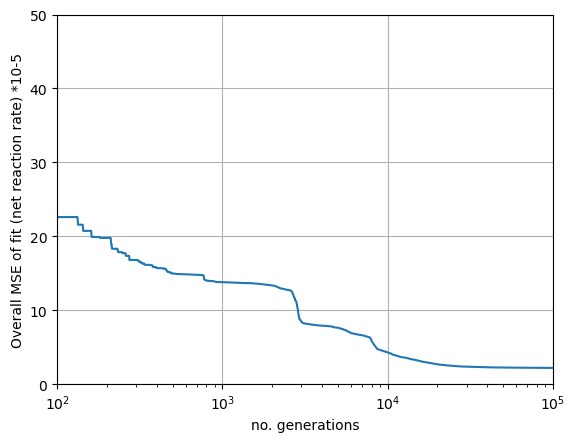

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.315445049858093
1.4904756590470358
0.8059968834775482
-4.106878136163876
0.4640831532611247
1.9199947290937065e-06
0.37268819229457517
-8.430851900895435
0.7835108287011212
7.124010207225861
5.535876725175366
5.521009189060057
0.039232947360778474
0.0788447487248038
2.799915299080706
0.02227661846763892
0.5001296962901668
-10.609188628073394
1.6579892771171445
1.4523190713956078
-10.382232928898448
1.0473393948979255
3.526367510575243
4.139145907113551e-05
3.7830611609638947
4.066562949201043
1.686225874840408
9.223938730767271
-9.745683220553753
2.7015426466502417
1.6890065713779592
3.434477492141
-4.17368651007775
0.5309160207754078
1.0048148027185493
-1.301029614748232


In [37]:
res.X

array([-1.13154450e+01,  1.49047566e+00,  8.05996883e-01, -4.10687814e+00,
        4.64083153e-01,  1.91999473e-06,  3.72688192e-01, -8.43085190e+00,
        7.83510829e-01,  7.12401021e+00,  5.53587673e+00,  5.52100919e+00,
        3.92329474e-02,  7.88447487e-02,  2.79991530e+00,  2.22766185e-02,
        5.00129696e-01, -1.06091886e+01,  1.65798928e+00,  1.45231907e+00,
       -1.03822329e+01,  1.04733939e+00,  3.52636751e+00,  4.13914591e-05,
        3.78306116e+00,  4.06656295e+00,  1.68622587e+00,  9.22393873e+00,
       -9.74568322e+00,  2.70154265e+00,  1.68900657e+00,  3.43447749e+00,
       -4.17368651e+00,  5.30916021e-01,  1.00481480e+00, -1.30102961e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.315445049858093
1.6: 1.4904756590470358
0.9: 0.8059968834775482
-4.3: -4.106878136163876
0.5: 0.4640831532611247
0.003: 1.9199947290937065e-06
0.4: 0.37268819229457517
-7.9: -8.430851900895435
0.7: 0.7835108287011212
7.2: 7.124010207225861
5.7: 5.535876725175366
5.7: 5.521009189060057
0.8: 0.039232947360778474
0.03: 0.0788447487248038
3.1: 2.799915299080706
6.000000000000001e-09: 0.02227661846763892
0.1: 0.5001296962901668
-12.0: -10.609188628073394
1.9: 1.6579892771171445
1.6: 1.4523190713956078
-11.6: -10.382232928898448
1.2: 1.0473393948979255
4.0: 3.526367510575243
0.01: 4.139145907113551e-05
4.2: 3.7830611609638947
5.4: 4.066562949201043
2.2: 1.686225874840408
11.8: 9.223938730767271
-12.0: -9.745683220553753
3.3: 2.7015426466502417
1.8: 1.6890065713779592
4.2: 3.434477492141
-4.0: -4.17368651007775
0.5: 0.5309160207754078
1.0: 1.0048148027185493
coeff fit: 0.9804268575557752
r: 0.9901650658126528


In [43]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.13154450e+01,  1.49047566e+00,  8.05996883e-01, -4.10687814e+00,
        4.64083153e-01,  1.91999473e-06,  3.72688192e-01, -8.43085190e+00,
        7.83510829e-01,  7.12401021e+00,  5.53587673e+00,  5.52100919e+00,
        3.92329474e-02,  7.88447487e-02,  2.79991530e+00,  2.22766185e-02,
        5.00129696e-01, -1.06091886e+01,  1.65798928e+00,  1.45231907e+00,
       -1.03822329e+01,  1.04733939e+00,  3.52636751e+00,  4.13914591e-05,
        3.78306116e+00,  4.06656295e+00,  1.68622587e+00,  9.22393873e+00,
       -9.74568322e+00,  2.70154265e+00,  1.68900657e+00,  3.43447749e+00,
       -4.17368651e+00,  5.30916021e-01,  1.00481480e+00, -1.30102961e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-1.14763873e+01,  1.51614890e+00,  8.27891412e-01, -1.40431704e+00,
        2.58477815e-02,  3.69592454e-07,  2.96517745e-01, -1.14993859e+01,
        1.19821373e+00,  8.49491857e+00,  6.74429647e+00,  6.64588439e+00,
        3.73755462e-06,  7.00781124e-02,  2.75759050e+00,  7.63221880e-02,
        4.49091526e-01, -1.12339717e+01,  1.76797648e+00,  1.54486926e+00,
       -1.09057473e+01,  1.11063051e+00,  3.75973806e+00,  8.81266070e-03,
        3.97529344e+00,  4.46063026e+00,  1.75787779e+00,  9.70521061e+00,
       -2.78918720e+00,  2.42736153e+00,  5.78702811e+00,  1.98410106e+00,
       -4.51201286e+00,  6.00110331e-01,  1.10828602e+00, -1.30102936e+00]
krseed101 = [-1.12983781e+01,  1.48773100e+00,  8.03552325e-01, -1.40507134e+00,
        2.67781166e-02,  2.23831398e-07,  2.99126315e-01, -9.43340559e+00,
        9.46450708e-01,  7.13039971e+00,  5.60975640e+00,  5.59696418e+00,
        5.71482966e-07,  7.16489926e-02,  2.76841179e+00,  6.52878532e-02,
        4.74140603e-01, -1.12591919e+01,  1.77241703e+00,  1.55217444e+00,
       -1.17208908e+01,  1.20645353e+00,  4.03562841e+00,  1.48629162e-06,
        4.30094581e+00,  4.92567384e+00,  1.95582172e+00,  1.06708174e+01,
       -5.14712967e+00,  3.13932789e+00,  6.19540391e+00,  2.77130515e+00,
       -3.91735884e+00,  4.91732283e-01,  1.05364416e+00, -1.30102913e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.939662761626558
r: 0.9693620384699196
-11.363403466666668
1.49811852
0.8124802066666668
-2.305422173333333
0.17223635036666665
8.378061940000001e-07
0.3227774173333333
-9.78788113
0.9760584223333333
7.583109496666666
5.963309866666667
5.92128592
0.013079085479195333
0.07352395123333333
2.775305863333333
0.054628886566666666
0.47445394166666666
-11.0341174
1.7327942633333333
1.5164542566666668
-11.002957
1.1214744766666669
3.773911326666667
0.00295184615024
4.019766803333334
4.484289016666667
1.7999751266666666
9.866655580000002
-5.894000030000001
2.7560773566666668
4.557146196666666
2.729961233333333
-4.201019403333333
0.5409195450000001
1.0555816599999999


In [44]:
meankr

[-11.363403466666668,
 1.49811852,
 0.8124802066666668,
 -2.305422173333333,
 0.17223635036666665,
 8.378061940000001e-07,
 0.3227774173333333,
 -9.78788113,
 0.9760584223333333,
 7.583109496666666,
 5.963309866666667,
 5.92128592,
 0.013079085479195333,
 0.07352395123333333,
 2.775305863333333,
 0.054628886566666666,
 0.47445394166666666,
 -11.0341174,
 1.7327942633333333,
 1.5164542566666668,
 -11.002957,
 1.1214744766666669,
 3.773911326666667,
 0.00295184615024,
 4.019766803333334,
 4.484289016666667,
 1.7999751266666666,
 9.866655580000002,
 -5.894000030000001,
 2.7560773566666668,
 4.557146196666666,
 2.729961233333333,
 -4.201019403333333,
 0.5409195450000001,
 1.0555816599999999]

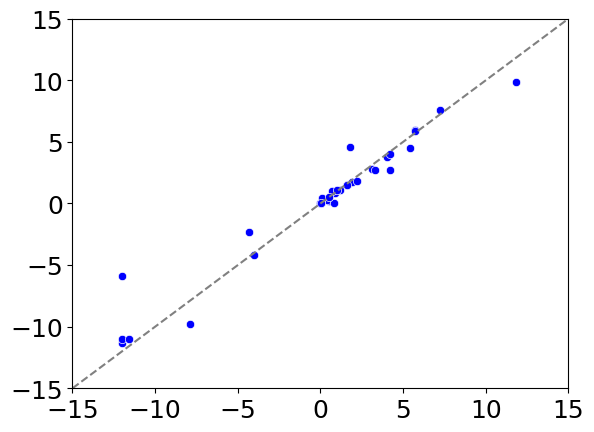

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()